In [1]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Progress bar
from tqdm import tqdm
# PyTorch related
import torch
from torch import nn 
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
# Sklearn related
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

0) Prepare data

In [4]:
insurance = pd.read_csv('./insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# One-Hot-Encoding, split data into X(features) and y(targets), and transform them to ndarray data type
X_array = pd.get_dummies(insurance.drop(['charges'], axis=1), drop_first=True, dtype=int).values
y_array = insurance.charges.values
X_array, y_array

(array([[19.  , 27.9 ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [18.  , 33.77,  1.  , ...,  0.  ,  1.  ,  0.  ],
        [28.  , 33.  ,  3.  , ...,  0.  ,  1.  ,  0.  ],
        ...,
        [18.  , 36.85,  0.  , ...,  0.  ,  1.  ,  0.  ],
        [21.  , 25.8 ,  0.  , ...,  0.  ,  0.  ,  1.  ],
        [61.  , 29.07,  0.  , ...,  1.  ,  0.  ,  0.  ]]),
 array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
        29141.3603]))

In [6]:
# Split dataset to train dataset and test dataset
X_train,X_test,y_train,y_test = train_test_split(X_array,y_array,test_size = 0.2,random_state = 0)
print(X_train)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train,y_train)
X_test = scaler.transform(X_test)
print(X_train)

[[37.   34.1   4.   ...  0.    0.    1.  ]
 [18.   34.43  0.   ...  0.    1.    0.  ]
 [23.   36.67  2.   ...  0.    0.    0.  ]
 ...
 [40.   25.08  0.   ...  0.    1.    0.  ]
 [19.   35.53  0.   ...  1.    0.    0.  ]
 [33.   18.5   1.   ...  0.    0.    1.  ]]
[[0.41304348 0.48802798 0.8        ... 0.         0.         1.        ]
 [0.         0.49690611 0.         ... 0.         1.         0.        ]
 [0.10869565 0.55716976 0.4        ... 0.         0.         0.        ]
 ...
 [0.47826087 0.24535916 0.         ... 0.         1.         0.        ]
 [0.02173913 0.52649987 0.         ... 1.         0.         0.        ]
 [0.32608696 0.06833468 0.2        ... 0.         0.         1.        ]]


In [7]:
# Transform data to tensor data type
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_train_tensor = torch.tensor(y_train).float()
y_test_tensor = torch.tensor(y_test).float()

In [8]:
# Dataloader for iteration
dataloader_train = DataLoader(dataset = TensorDataset(X_train_tensor,y_train_tensor), shuffle = True, batch_size = 10)
dataloader_test = DataLoader(dataset = TensorDataset(X_test_tensor,y_test_tensor), shuffle = True, batch_size = 10)

In [9]:
#for feature,label in dataloader_train:
#    print(feature,label)

1) Define model

In [10]:
class insurance_net(nn.Module):
    def __init__(self):
        super(insurance_net,self).__init__()
        self.hidden1 = nn.Linear(in_features = 8,out_features = 80)
        self.hidden2 = nn.Linear(in_features = 80,out_features = 40)
        self.hidden3 = nn.Linear(in_features = 40,out_features = 20)
        self.hidden4 = nn.Linear(in_features = 20,out_features = 10)
        self.regression = nn.Linear(in_features = 10,out_features = 1)
    
    # Define forward pass
    def forward(self,x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        y = self.regression(x)
        return y[:,0]

2) Valuation strandard

In [11]:
#Define r2 evaluation
def r2(y_pred,y_true):
    y_pred_cls = y_pred.data
    return r2_score(y_true,y_pred_cls)

3) Loss and optimizer

In [12]:
#Create my model
def createModel():
    model = insurance_net()
    #Choose MSELoss as the loss function
    model.loss_func = nn.MSELoss()
    #Choose Adam as the optimizer, learning rate is 0.01
    model.optimizer = torch.optim.Adam(params = model.parameters(),lr = 0.01)
    # Choose r2 as score
    model.metric_func = r2
    # Set metric_name as r2
    model.metric_name = 'r2'
    return model

4) Training function

In [13]:
def train(model,features,targets):
    # Switch to train mode
    model.train()
    # Reset gradient
    model.optimizer.zero_grad()
    # Forward pass and loss
    predictions = model(features)
    loss = model.loss_func(predictions,targets)
    # Evaluation metric calculation
    metric = model.metric_func(predictions,targets)
    # Backward pass
    loss.backward()
    # Updata
    model.optimizer.step()
    return loss.item(),metric.item()

5) Validating function

In [14]:
#Validation mode without gradient
@torch.no_grad()
def valid(model,features,targets):
    #Switch to eval mode
    model.eval()
    # Forward pass and loss
    prediction = model(features)
    loss = model.loss_func(prediction,targets)
    # Evaluation metric calculation
    metric = model.metric_func(prediction,targets)
    return loss.item(),metric.item()

6) Training and evaluation loop

In [15]:
def modelTrain(model,epochs,dataloader_train,dataloader_test,log_print_frequency):
    metric_name = model.metric_name
    # Record logs with 'epoch', 'loss', etc as a dataframe
    metirc_history = pd.DataFrame(columns = ['epoch','loss',metric_name,'val_loss','val_'+metric_name])
    print('Training starts')
    for epoch in tqdm(range(1, epochs+1)):
        #Training loop
        # Loss
        loss_sum = 0.0
        # Evaluation metric
        metric_sum = 0.0
        step = 1
        for step,(features,targets) in enumerate(dataloader_train,1):
            loss,metric = train(model,features,targets)
            # Every 'log_step_freq' times print steps and loss, etc.
            loss_sum += loss
            metric_sum += metric
            if step % log_print_frequency == 0:
                print(f'[step = {step}] loss:{loss_sum/step},{metric_name}:{metric_sum/step}')
        
        # Evaluation loop
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1
        for val_step, (features,targets) in enumerate(dataloader_test, 1):
            val_loss,val_metric = valid(model,features,targets)
            val_loss_sum += val_loss
            val_metric_sum += val_metric
        # Records
        info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
        metirc_history.loc[epoch-1] = info
        # Print log
        print(f'epoch = {info[0]},loss = {info[1]},{metric_name} = {info[2]},val_loss = {info[3]},val_+{metric_name} = {info[4]}')
        torch.save(model.state_dict(),f'./models/model{epoch}.pkl')
    print('Training done')
    return metirc_history

7) Training model

In [16]:
# Ceate my model
model1 = createModel()
# Total epochs of training
epochs = 1000 
# The frequency of prting log
log_printing_frequency = 10
history1 = modelTrain(model1,epochs,dataloader_train,dataloader_test,log_printing_frequency)

Training starts


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[step = 10] loss:288582372.8,r2:-1.834689510721963
[step = 20] loss:278410061.6,r2:-2.0034869611911903
[step = 30] loss:276033217.8666667,r2:-2.091976122614424
[step = 40] loss:268252384.6,r2:-1.9451342925847719
[step = 50] loss:265591209.68,r2:-1.7384183728491547
[step = 60] loss:240425878.2,r2:-1.4794640635936316
[step = 70] loss:226730434.68571427,r2:-1.3242370476842198
[step = 80] loss:211777475.425,r2:-1.131272267781725
[step = 90] loss:201663645.4,r2:-0.9717830297163607
[step = 100] loss:191444237.58,r2:-0.9378039852554079


  0%|                                                                                 | 1/1000 [00:00<03:19,  5.01it/s]

epoch = 1,loss = 186223868.39252338,r2 = -0.8755066776973972,val_loss = 86461626.14814815,val_+r2 = 0.28486525003532015
[step = 10] loss:69344886.8,r2:0.18306840799638488
[step = 20] loss:71731579.8,r2:0.19604548990213858


  0%|▏                                                                                | 2/1000 [00:00<03:15,  5.10it/s]

[step = 30] loss:67649915.6,r2:0.09498804464999414
[step = 40] loss:68842665.75,r2:0.17798443994127588
[step = 50] loss:73594552.12,r2:0.2537522095227661
[step = 60] loss:70301160.5,r2:0.2848426234524754
[step = 70] loss:64344973.571428575,r2:0.3136740855418739
[step = 80] loss:62416069.1125,r2:0.33621380117482075
[step = 90] loss:59997656.02222222,r2:0.37450537547552526
[step = 100] loss:58764475.74,r2:0.383113384534507
epoch = 2,loss = 57780171.705607474,r2 = 0.400872616121594,val_loss = 40390458.03703704,val_+r2 = 0.6636306182412463
[step = 10] loss:36767930.4,r2:0.6054449880472774
[step = 20] loss:50730308.7625,r2:0.5952447533875216
[step = 30] loss:52204423.675,r2:0.5976294825985706


  0%|▏                                                                                | 3/1000 [00:00<03:15,  5.09it/s]

[step = 40] loss:48858332.85625,r2:0.5467935685889479
[step = 50] loss:47513957.085,r2:0.56278319007944
[step = 60] loss:45053150.87916667,r2:0.5910940550070738
[step = 70] loss:42989640.225,r2:0.59957959049399
[step = 80] loss:42035707.496875,r2:0.6093121168102005
[step = 90] loss:40599640.29722222,r2:0.6097766859818902
[step = 100] loss:41411037.8575,r2:0.5972876640160771
epoch = 3,loss = 41136748.44626168,r2 = 0.5915861425228692,val_loss = 33249095.592592593,val_+r2 = 0.7354795933548363
[step = 10] loss:33275895.325,r2:0.4946616346610958
[step = 20] loss:31866526.05,r2:0.6165557782364375
[step = 30] loss:37902731.43333333,r2:0.5092664230056952
[step = 40] loss:42780506.425,r2:0.4515301433593134
[step = 50] loss:39532317.43,r2:0.4906146265013795


  0%|▎                                                                                | 4/1000 [00:00<03:23,  4.89it/s]

[step = 60] loss:42113593.675,r2:0.5042655898145674
[step = 70] loss:40065191.66428571,r2:0.5264999956374954
[step = 80] loss:39414284.39375,r2:0.5565318428981947
[step = 90] loss:41041551.16111111,r2:0.5467681163672584
[step = 100] loss:40859035.325,r2:0.546935365043937
epoch = 4,loss = 39950143.042056076,r2 = 0.5601369658067117,val_loss = 31720211.89814815,val_+r2 = 0.6487285969349942
[step = 10] loss:37535695.4,r2:0.4764775880238442
[step = 20] loss:37880942.8625,r2:0.5694013910762692
[step = 30] loss:31681371.183333334,r2:0.6295226023574845
[step = 40] loss:36321908.3125,r2:0.6472884723911241
[step = 50] loss:37821606.92,r2:0.647911579091012
[step = 60] loss:39210265.4,r2:0.6052839815603146


  0%|▍                                                                                | 5/1000 [00:01<03:21,  4.95it/s]

[step = 70] loss:36710963.557142854,r2:0.6166484491054988
[step = 80] loss:36197322.175,r2:0.6302636857228309
[step = 90] loss:37398495.54444444,r2:0.6141346359415379
[step = 100] loss:38901296.63,r2:0.6032229040917433
epoch = 5,loss = 38953345.07126168,r2 = 0.6068108300297277,val_loss = 31355476.35185185,val_+r2 = 0.6924592365335206
[step = 10] loss:27693551.15,r2:0.6836301701552224
[step = 20] loss:25910463.675,r2:0.6930107846989275
[step = 30] loss:32845642.216666665,r2:0.5625374657826383
[step = 40] loss:31569489.1125,r2:0.5988395172179285
[step = 50] loss:36431469.29,r2:0.6076627918855194
[step = 60] loss:36304974.458333336,r2:0.6274066030648123


  1%|▍                                                                                | 6/1000 [00:01<03:26,  4.80it/s]

[step = 70] loss:37877921.93571428,r2:0.6073927685253874
[step = 80] loss:39160090.36875,r2:0.6127571155548495
[step = 90] loss:40254546.96111111,r2:0.602853866283679
[step = 100] loss:39717587.615,r2:0.6066711481444488
epoch = 6,loss = 39609009.06542056,r2 = 0.6079730213577531,val_loss = 31810652.296296295,val_+r2 = 0.7258137890825371
[step = 10] loss:22356028.1,r2:0.6521765418387264
[step = 20] loss:36324151.95,r2:0.6772243347744843
[step = 30] loss:36670706.3,r2:0.6148053611271377
[step = 40] loss:37178518.79375,r2:0.5647006223312268
[step = 50] loss:39908137.255,r2:0.5528650957926804
[step = 60] loss:40151461.295833334,r2:0.46966478701317205
[step = 70] loss:40384887.217857145,r2:0.5033213982441919


  1%|▌                                                                                | 7/1000 [00:01<03:24,  4.85it/s]

[step = 80] loss:39609493.953125,r2:0.5207831567329013
[step = 90] loss:39709511.08611111,r2:0.5204785731812117
[step = 100] loss:39476671.9875,r2:0.5248269499811502
epoch = 7,loss = 39051430.36214953,r2 = 0.5384349044537041,val_loss = 33594616.666666664,val_+r2 = 0.5810184705260552
[step = 10] loss:38135651.8,r2:0.5347397804947042
[step = 20] loss:38321841.5375,r2:0.6084159023992998
[step = 30] loss:39374756.46666667,r2:0.5839612408795207
[step = 40] loss:37622062.625,r2:0.572958004204337
[step = 50] loss:35828563.45,r2:0.5910672996283616
[step = 60] loss:35566826.108333334,r2:0.6182833565093815
[step = 70] loss:36191517.95,r2:0.5946133777605287


  1%|▋                                                                                | 8/1000 [00:01<03:27,  4.79it/s]

[step = 80] loss:37545672.30625,r2:0.5968494365175536
[step = 90] loss:39363333.11666667,r2:0.5851294620234222
[step = 100] loss:39689972.355,r2:0.5956794498112744
epoch = 8,loss = 39105379.705607474,r2 = 0.5976156398026652,val_loss = 30075572.537037037,val_+r2 = 0.6812867985744968
[step = 10] loss:32677184.0,r2:0.5575309475708039
[step = 20] loss:37004243.35,r2:0.6198878426640533
[step = 30] loss:40013410.7,r2:0.5953680432357493
[step = 40] loss:37307753.55,r2:0.6421248884980473
[step = 50] loss:40869032.72,r2:0.616955927161466
[step = 60] loss:39206756.916666664,r2:0.5384478307607511
[step = 70] loss:40314663.15357143,r2:0.5538442631012357


  1%|▋                                                                                | 9/1000 [00:01<03:24,  4.85it/s]

[step = 80] loss:39458169.934375,r2:0.533544977116909
[step = 90] loss:37983593.48055556,r2:0.5456187235860862
[step = 100] loss:37468520.2825,r2:0.5583920130238352
epoch = 9,loss = 37372555.408878505,r2 = 0.5722356634088339,val_loss = 30751882.685185187,val_+r2 = 0.6266541392602049
[step = 10] loss:32405593.8,r2:0.6352411844043232
[step = 20] loss:46234761.6,r2:0.5463367893009106
[step = 30] loss:42458550.2,r2:0.5567522029242713
[step = 40] loss:40328339.3,r2:0.5857044688514408
[step = 50] loss:38821870.56,r2:0.5938138170211729
[step = 60] loss:36503811.61666667,r2:0.6108152910942345
[step = 70] loss:37297832.942857146,r2:0.5933047889826716
[step = 80] loss:37367297.1453125,r2:0.5953650474964242


  1%|▊                                                                               | 10/1000 [00:02<03:28,  4.75it/s]

[step = 90] loss:37839321.329166666,r2:0.5923722285880739
[step = 100] loss:36678177.36125,r2:0.5760128779639809
epoch = 10,loss = 36786784.593457945,r2 = 0.5853633986233989,val_loss = 29510715.675925925,val_+r2 = 0.6981143884687158
[step = 10] loss:43641494.9,r2:0.6298729078321881
[step = 20] loss:47845383.35,r2:0.5890092177977075
[step = 30] loss:45332443.641666666,r2:0.6111951537030855
[step = 40] loss:41533930.10625,r2:0.5515049097344219
[step = 50] loss:37897248.535,r2:0.5829295635161682
[step = 60] loss:36831617.0625,r2:0.6042193828549131
[step = 70] loss:35366407.84642857,r2:0.6049562551245634
[step = 80] loss:34974288.015625,r2:0.6188306071588198
[step = 90] loss:33937629.50833333,r2:0.6099497761697108


  1%|▉                                                                               | 11/1000 [00:02<03:29,  4.72it/s]

[step = 100] loss:34809779.3875,r2:0.5970220183713704
epoch = 11,loss = 35758710.25,r2 = 0.6038259285415651,val_loss = 28532406.314814813,val_+r2 = 0.7057871389453857
[step = 10] loss:26384661.8,r2:0.7406871400582103
[step = 20] loss:34916417.0375,r2:0.6384449823418514
[step = 30] loss:35462720.725,r2:0.6340630547809505
[step = 40] loss:36103631.121875,r2:0.6396900415068834
[step = 50] loss:33674604.8775,r2:0.6501764179350623
[step = 60] loss:34081803.797916666,r2:0.6432655394315606
[step = 70] loss:33430463.16964286,r2:0.6545893619261629
[step = 80] loss:35006957.8734375,r2:0.6479726129523722
[step = 90] loss:35441202.0875,r2:0.6232725677332323


  1%|▉                                                                               | 12/1000 [00:02<03:33,  4.63it/s]

[step = 100] loss:34814874.61375,r2:0.6386494630580539
epoch = 12,loss = 34396107.26518691,r2 = 0.6475865493537456,val_loss = 27220417.62962963,val_+r2 = 0.6975923001079748
[step = 10] loss:36497591.65,r2:0.5941000025882512
[step = 20] loss:31550521.4,r2:0.6652182230607765
[step = 30] loss:29256635.779166665,r2:0.7028273459576158
[step = 40] loss:30256361.065625,r2:0.684782958394171
[step = 50] loss:30518523.3125,r2:0.6453065279519743
[step = 60] loss:32062295.077083334,r2:0.6244894715336895
[step = 70] loss:32998682.79464286,r2:0.6124317887489831
[step = 80] loss:32438951.4765625,r2:0.6125253369642946


  1%|█                                                                               | 13/1000 [00:02<03:37,  4.53it/s]

[step = 90] loss:32485833.901388887,r2:0.6313164013435879
[step = 100] loss:32528129.86125,r2:0.6401037876581145
epoch = 13,loss = 32388320.519859813,r2 = 0.6472164803538752,val_loss = 26436413.01851852,val_+r2 = 0.7477446652737305
[step = 10] loss:29632964.4,r2:0.6473660998476636
[step = 20] loss:34083168.15,r2:0.6437605117652179
[step = 30] loss:30905324.933333334,r2:0.6312091216215966
[step = 40] loss:31209007.575,r2:0.6257311281212622
[step = 50] loss:35450093.18,r2:0.6027481168050748
[step = 60] loss:37115505.96666667,r2:0.5885842853335468
[step = 70] loss:35548220.28571428,r2:0.6156765686491376
[step = 80] loss:33405084.59375,r2:0.625006514992024


  1%|█                                                                               | 14/1000 [00:02<03:37,  4.53it/s]

[step = 90] loss:32649920.483333334,r2:0.6438181838605089
[step = 100] loss:32008095.755,r2:0.654402984633603
epoch = 14,loss = 31298087.59228972,r2 = 0.6507573022006765,val_loss = 25177970.26851852,val_+r2 = 0.7564694418578226
[step = 10] loss:32228510.95,r2:0.3385482156922343
[step = 20] loss:29615343.3,r2:0.5486011765143359
[step = 30] loss:24530909.35,r2:0.6229717025590406
[step = 40] loss:27044842.375,r2:0.5617971259064563
[step = 50] loss:28320431.09,r2:0.6031823091420336
[step = 60] loss:29389606.520833332,r2:0.587079357593136
[step = 70] loss:30575386.260714285,r2:0.5995002028473068
[step = 80] loss:31364060.284375,r2:0.5869648499720967
[step = 90] loss:31378538.252777778,r2:0.5934010344568925


  2%|█▏                                                                              | 15/1000 [00:03<03:26,  4.77it/s]

[step = 100] loss:30785870.2425,r2:0.6009942499660379
epoch = 15,loss = 29878080.794392522,r2 = 0.6181104373679408,val_loss = 24200627.574074075,val_+r2 = 0.7508780549836274
[step = 10] loss:28559139.4,r2:0.7138508925287826
[step = 20] loss:28342231.7,r2:0.6767064985733413
[step = 30] loss:27987037.583333332,r2:0.672812646408694
[step = 40] loss:27804643.45,r2:0.7041465789763771
[step = 50] loss:25048613.7175,r2:0.7213517192843908
[step = 60] loss:25640648.38125,r2:0.7283622914452543
[step = 70] loss:26055965.1125,r2:0.7339144664978511
[step = 80] loss:27294953.3234375,r2:0.7231495702586898
[step = 90] loss:29002070.343055554,r2:0.7087079491621685


  2%|█▎                                                                              | 16/1000 [00:03<03:29,  4.70it/s]

[step = 100] loss:28943601.28625,r2:0.7077269887121573
epoch = 16,loss = 28708819.533878505,r2 = 0.6973867002175268,val_loss = 23187134.777777776,val_+r2 = 0.7138498407247122
[step = 10] loss:30423786.7375,r2:0.5642339095357214
[step = 20] loss:24294474.39375,r2:0.7032896484977706
[step = 30] loss:21269530.1625,r2:0.7244183248855723
[step = 40] loss:22287885.9046875,r2:0.6890305104099189
[step = 50] loss:22740884.05875,r2:0.7047522860775254
[step = 60] loss:23619002.807291668,r2:0.7210165496913951
[step = 70] loss:24060691.320535716,r2:0.7119671316333519
[step = 80] loss:25698045.89296875,r2:0.6998658636979685
[step = 90] loss:26711583.840972222,r2:0.6888402418726508


  2%|█▎                                                                              | 17/1000 [00:03<03:26,  4.75it/s]

[step = 100] loss:29695400.906875,r2:0.6987708895512452
epoch = 17,loss = 29327103.49707944,r2 = 0.697508981752965,val_loss = 22228310.185185187,val_+r2 = 0.7659591968763771
[step = 10] loss:30741017.4,r2:0.619275381988885
[step = 20] loss:26228703.0,r2:0.7109981177853519
[step = 30] loss:23489050.233333334,r2:0.7570532638075523
[step = 40] loss:23026450.025,r2:0.7804687982305403
[step = 50] loss:27644574.36,r2:0.7547536100411495
[step = 60] loss:27672540.502083335,r2:0.7377722139266795


  2%|█▍                                                                              | 18/1000 [00:03<03:55,  4.16it/s]

[step = 70] loss:28712598.99107143,r2:0.7114769265458608
[step = 80] loss:27189434.5359375,r2:0.698387380010758
[step = 90] loss:28747113.00972222,r2:0.699848204937292
[step = 100] loss:27919916.43125,r2:0.6844634746487336
epoch = 18,loss = 27318341.77686916,r2 = 0.6943926212017701,val_loss = 22796808.78935185,val_+r2 = 0.802318068049078
[step = 10] loss:44569790.15,r2:0.5279774545054874
[step = 20] loss:32770005.7375,r2:0.6211811419422519
[step = 30] loss:28056208.933333334,r2:0.6991976538070244
[step = 40] loss:27557910.575,r2:0.7352154632463193
[step = 50] loss:28252086.19,r2:0.7416396291108585
[step = 60] loss:28825382.0,r2:0.7193547779558404
[step = 70] loss:27564417.84285714,r2:0.7333086419107112
[step = 80] loss:27417829.40625,r2:0.7267331478719312
[step = 90] loss:27423011.433333334,r2:0.7190070669268841
[step = 100] loss:26024600.315,r2:0.7196097203199815


  2%|█▌                                                                              | 19/1000 [00:04<04:15,  3.84it/s]

epoch = 19,loss = 26357225.172897197,r2 = 0.7050366216616514,val_loss = 22794370.689814813,val_+r2 = 0.7815232523371084
[step = 10] loss:18066637.65,r2:0.7584558292089636
[step = 20] loss:23479057.375,r2:0.7417024970756685
[step = 30] loss:23328625.583333332,r2:0.7613259771515837
[step = 40] loss:23805621.7015625,r2:0.7580958403636847
[step = 50] loss:24931821.62125,r2:0.7256219155602226
[step = 60] loss:25637065.851041667,r2:0.7075473722925792
[step = 70] loss:25584629.100892857,r2:0.7037863756595598
[step = 80] loss:27141379.94296875,r2:0.6962473186371303


  2%|█▌                                                                              | 20/1000 [00:04<04:31,  3.61it/s]

[step = 90] loss:26711604.132291667,r2:0.7089008507776998
[step = 100] loss:26708988.5815625,r2:0.7092455114133098
epoch = 20,loss = 26476983.767815422,r2 = 0.714447782714758,val_loss = 19777205.412037037,val_+r2 = 0.8304023980899401
[step = 10] loss:15601829.25,r2:0.8149364653939509
[step = 20] loss:28349995.575,r2:0.7936332783876383
[step = 30] loss:29311035.55,r2:0.7251730507421393
[step = 40] loss:28642839.66875,r2:0.6809672238996263
[step = 50] loss:26092464.3975,r2:0.7113193125388584
[step = 60] loss:24793994.64375,r2:0.7313875823163671


  2%|█▋                                                                              | 21/1000 [00:04<04:21,  3.75it/s]

[step = 70] loss:26720345.91607143,r2:0.7317081273199297
[step = 80] loss:27692484.2390625,r2:0.7107320746614653
[step = 90] loss:25698529.995833334,r2:0.7291445037784432
[step = 100] loss:25546712.7525,r2:0.7399251802008311
epoch = 21,loss = 25936903.30140187,r2 = 0.7324562560593775,val_loss = 25941072.37037037,val_+r2 = 0.7137279490371466
[step = 10] loss:34692529.35,r2:0.5300797327716548
[step = 20] loss:28303000.35,r2:0.5529236577646002
[step = 30] loss:26785365.416666668,r2:0.6424125525389355
[step = 40] loss:24845126.175,r2:0.6947398198006945
[step = 50] loss:25383999.0825,r2:0.7243673326292336
[step = 60] loss:25165253.702083334,r2:0.7154862412704934
[step = 70] loss:24799120.676785715,r2:0.7358986224118824
[step = 80] loss:26334342.0484375,r2:0.7310391418979753
[step = 90] loss:26880263.140277777,r2:0.7249521280179252
[step = 100] loss:27051816.28875,r2:0.7225802931980693


  2%|█▊                                                                              | 22/1000 [00:05<04:38,  3.51it/s]

epoch = 22,loss = 26551002.0073014,r2 = 0.7170025698476015,val_loss = 23504805.618055556,val_+r2 = 0.808404593081544
[step = 10] loss:37800712.675,r2:0.6043942521269635
[step = 20] loss:32799061.3625,r2:0.646614121101056
[step = 30] loss:30535511.208333332,r2:0.6839156712448428
[step = 40] loss:29907049.4375,r2:0.7074947493085723
[step = 50] loss:27414603.705,r2:0.7374212141431474
[step = 60] loss:27408694.708333332,r2:0.7554674926737146


  2%|█▊                                                                              | 23/1000 [00:05<04:57,  3.28it/s]

[step = 70] loss:27104764.135714285,r2:0.7552644196988647
[step = 80] loss:26864248.00703125,r2:0.7567122716804483
[step = 90] loss:26479476.88402778,r2:0.7576907536218253
[step = 100] loss:25714292.625625,r2:0.7577967337049878
epoch = 23,loss = 26405710.173481308,r2 = 0.7490390998340757,val_loss = 19752914.833333332,val_+r2 = 0.7877870381932893
[step = 10] loss:36413840.0,r2:0.6737373809869154
[step = 20] loss:36078116.05,r2:0.6950560214560788
[step = 30] loss:32326725.207291666,r2:0.6809397540415404
[step = 40] loss:28716491.58984375,r2:0.7138907751396644
[step = 50] loss:25670926.7775,r2:0.7451984160035409
[step = 60] loss:24572024.464583334,r2:0.7495831164560227
[step = 70] loss:23502088.25,r2:0.7669379465309496
[step = 80] loss:22495108.146875,r2:0.7653874016419974
[step = 90] loss:24015700.986111112,r2:0.7581389390802786
[step = 100] loss:23793007.9475,r2:0.752874923013565


  2%|█▉                                                                              | 24/1000 [00:05<04:57,  3.28it/s]

epoch = 24,loss = 24870184.00233645,r2 = 0.7500248450786654,val_loss = 20320520.666666668,val_+r2 = 0.8066287358077896
[step = 10] loss:22112532.775,r2:0.7995091528264281
[step = 20] loss:23364790.4875,r2:0.757906042447906
[step = 30] loss:19801813.175,r2:0.8019782709282868
[step = 40] loss:21455571.51875,r2:0.7978024058347438
[step = 50] loss:26878680.815,r2:0.7637095995354612
[step = 60] loss:26789971.2875,r2:0.7259383021495011


  2%|██                                                                              | 25/1000 [00:06<05:12,  3.12it/s]

[step = 70] loss:27398802.60357143,r2:0.7333948268029118
[step = 80] loss:25538194.4,r2:0.7463467955335517
[step = 90] loss:24187077.73888889,r2:0.7531127664444314
[step = 100] loss:25311440.3975,r2:0.7413150875921017
epoch = 25,loss = 25492268.53037383,r2 = 0.7368497938085842,val_loss = 20952549.222222224,val_+r2 = 0.8023316839692496
[step = 10] loss:25703991.5375,r2:0.7951704268258186
[step = 20] loss:23100663.54375,r2:0.8106505282492431
[step = 30] loss:24635659.854166668,r2:0.7946044226213071
[step = 40] loss:23153577.940625,r2:0.7963559592497719
[step = 50] loss:25404187.7425,r2:0.7765261692970737
[step = 60] loss:24759739.477083333,r2:0.7714684945506054
[step = 70] loss:25962682.501785714,r2:0.7699550254533025
[step = 80] loss:24947588.6015625,r2:0.7751643083556053
[step = 90] loss:24134267.684722222,r2:0.7794956169458124


  3%|██                                                                              | 26/1000 [00:06<05:16,  3.07it/s]

[step = 100] loss:24549121.6875,r2:0.771528420131096
epoch = 26,loss = 25639082.764018692,r2 = 0.7557600925399028,val_loss = 22911608.703703705,val_+r2 = 0.7562337992763042
[step = 10] loss:20394451.675,r2:0.6609760674652707
[step = 20] loss:21244892.465625,r2:0.7134672368571823
[step = 30] loss:19780305.91875,r2:0.7335193698193471
[step = 40] loss:21725527.7265625,r2:0.7014809787313903
[step = 50] loss:20690423.28125,r2:0.7361588594775312
[step = 60] loss:23400519.342708334,r2:0.7179076628217175
[step = 70] loss:25108798.511607144,r2:0.7143821194390428
[step = 80] loss:26522474.21640625,r2:0.707963632629008
[step = 90] loss:25685331.647916667,r2:0.7104551901263159
[step = 100] loss:24949866.643125,r2:0.7233175341419802


  3%|██▏                                                                             | 27/1000 [00:06<05:34,  2.91it/s]

epoch = 27,loss = 25375915.27628505,r2 = 0.7223630530207045,val_loss = 19398383.560185187,val_+r2 = 0.7950572009751187
[step = 10] loss:25862885.2,r2:0.6294617879661537
[step = 20] loss:19472940.1875,r2:0.72908207807706
[step = 30] loss:22863023.9875,r2:0.7320771979818057
[step = 40] loss:21548317.096875,r2:0.7587161380285792
[step = 50] loss:21567963.2775,r2:0.7696867053194281
[step = 60] loss:22678782.727083333,r2:0.7667093170651991


  3%|██▏                                                                             | 28/1000 [00:07<05:27,  2.97it/s]

[step = 70] loss:25138133.151785713,r2:0.7599226207036568
[step = 80] loss:23929111.2703125,r2:0.7734082184905297
[step = 90] loss:23703477.979166668,r2:0.769318704525683
[step = 100] loss:24214256.19125,r2:0.7635388705722693
epoch = 28,loss = 25656893.662383176,r2 = 0.7565176510425006,val_loss = 23188586.462962963,val_+r2 = 0.6975778102327569
[step = 10] loss:16513171.6375,r2:0.7953675241142805
[step = 20] loss:20536941.1375,r2:0.812017539456863
[step = 30] loss:20750152.354166668,r2:0.8060544143096297
[step = 40] loss:19024629.43125,r2:0.8223860393152471


  3%|██▎                                                                             | 29/1000 [00:07<05:14,  3.08it/s]

[step = 50] loss:19084419.21,r2:0.8079148481831314
[step = 60] loss:23124484.841666665,r2:0.7612210604964559
[step = 70] loss:22982006.375,r2:0.7617781232866241
[step = 80] loss:26155120.640625,r2:0.7191214400764466
[step = 90] loss:26722139.919444446,r2:0.7261177037802009
[step = 100] loss:25830544.315,r2:0.7385590282454367
epoch = 29,loss = 25754589.233644858,r2 = 0.7430220122943114,val_loss = 19896449.277777776,val_+r2 = 0.7576533860968069
[step = 10] loss:17445232.075,r2:0.8249852401666777
[step = 20] loss:31464594.3625,r2:0.7016439088211999
[step = 30] loss:31904123.075,r2:0.7046923560339131
[step = 40] loss:30884144.01875,r2:0.6834404368704068
[step = 50] loss:29709057.665,r2:0.7016759722425934
[step = 60] loss:27642618.283333335,r2:0.719324018314553
[step = 70] loss:27136131.84285714,r2:0.7149072115259438
[step = 80] loss:26024125.2125,r2:0.722413463746179
[step = 90] loss:25409547.388888888,r2:0.7391608922983156
[step = 100] loss:24300365.89375,r2:0.7514953191330187


  3%|██▍                                                                             | 30/1000 [00:07<05:00,  3.22it/s]

epoch = 30,loss = 25051231.68457944,r2 = 0.7477229467449764,val_loss = 18865094.532407407,val_+r2 = 0.7802959046911021
[step = 10] loss:21777894.475,r2:0.8059177553566957
[step = 20] loss:29750958.8625,r2:0.7384451295240707
[step = 30] loss:32074392.875,r2:0.7335423400602056
[step = 40] loss:31472214.80625,r2:0.6949733227878054
[step = 50] loss:30348318.7775,r2:0.6805452014866685
[step = 60] loss:31540123.25625,r2:0.6900789738743165
[step = 70] loss:29920713.367857143,r2:0.7144326945543858


  3%|██▍                                                                             | 31/1000 [00:08<05:01,  3.22it/s]

[step = 80] loss:29190047.5296875,r2:0.7231599293898746
[step = 90] loss:28893677.75972222,r2:0.7316562298685116
[step = 100] loss:26962138.20625,r2:0.7405550177204833
epoch = 31,loss = 25531519.850175235,r2 = 0.754266045401331,val_loss = 23117951.75289352,val_+r2 = 0.7329335674173462
[step = 10] loss:23960817.25,r2:0.7476762988189187
[step = 20] loss:20530883.625,r2:0.7831704216342533
[step = 30] loss:24206958.741666667,r2:0.7536343599422446
[step = 40] loss:28559320.95625,r2:0.7457536047540769
[step = 50] loss:28063406.255,r2:0.7385626423368125


  3%|██▌                                                                             | 32/1000 [00:08<05:02,  3.20it/s]

[step = 60] loss:26300768.910416666,r2:0.7447178459578224
[step = 70] loss:25769963.37142857,r2:0.7528122953726083
[step = 80] loss:24838849.6109375,r2:0.7548954722248566
[step = 90] loss:25368371.890277777,r2:0.7446759747328225
[step = 100] loss:25473472.1725,r2:0.7382745938036418
epoch = 32,loss = 25364845.171728972,r2 = 0.7448918318423169,val_loss = 20700970.111111112,val_+r2 = 0.7887850278134932
[step = 10] loss:21936163.875,r2:0.770345004921192
[step = 20] loss:28011971.125,r2:0.6335422875543302
[step = 30] loss:27056065.425,r2:0.6547886140449614
[step = 40] loss:26493758.75625,r2:0.6914409732672397
[step = 50] loss:24041477.0075,r2:0.7185818819226354
[step = 60] loss:24696258.139583334,r2:0.7067999195180242
[step = 70] loss:24325411.984375,r2:0.7182280443084932
[step = 80] loss:25321150.612890624,r2:0.7186481137607088
[step = 90] loss:25589957.75590278,r2:0.7144161403873418


  3%|██▋                                                                             | 33/1000 [00:08<05:00,  3.21it/s]

[step = 100] loss:25448681.6828125,r2:0.714571855133031
epoch = 33,loss = 25425949.44421729,r2 = 0.7159378982387247,val_loss = 23326072.421296295,val_+r2 = 0.8232650034853461
[step = 10] loss:27071769.55,r2:0.5705885184172084
[step = 20] loss:31101550.175,r2:0.5644896499784156
[step = 30] loss:27575491.35,r2:0.6403309228552746
[step = 40] loss:26984884.975,r2:0.6665650253043489
[step = 50] loss:27474323.045,r2:0.6924323445069149
[step = 60] loss:26856164.520833332,r2:0.7088840426217323
[step = 70] loss:25898347.519642856,r2:0.7184181383805879


  3%|██▋                                                                             | 34/1000 [00:08<04:58,  3.24it/s]

[step = 80] loss:24819047.65859375,r2:0.7183400054094049
[step = 90] loss:24217887.49097222,r2:0.7310167271743953
[step = 100] loss:25015312.626875,r2:0.7312715726108641
epoch = 34,loss = 24888985.67932243,r2 = 0.7323397001895539,val_loss = 18851762.087962963,val_+r2 = 0.8258805420129876
[step = 10] loss:15767667.875,r2:0.8447100228308961
[step = 20] loss:16622667.1625,r2:0.7953211148898841
[step = 30] loss:17057176.275,r2:0.7875708313531629
[step = 40] loss:20215288.58125,r2:0.7726659141076887
[step = 50] loss:23235999.825,r2:0.7691860537061782
[step = 60] loss:25090267.5375,r2:0.7416269114972308
[step = 70] loss:24612036.460714284,r2:0.7427846868112942
[step = 80] loss:23489817.0921875,r2:0.7493239526745297
[step = 90] loss:24742972.99861111,r2:0.7520518548784755
[step = 100] loss:25150107.19375,r2:0.7540919821763294


  4%|██▊                                                                             | 35/1000 [00:09<05:02,  3.19it/s]

epoch = 35,loss = 24915967.45911215,r2 = 0.7535163838383087,val_loss = 18946287.092592593,val_+r2 = 0.8186496652418895
[step = 10] loss:37649764.0,r2:0.7238658326821655
[step = 20] loss:29074830.4625,r2:0.7036870633442568
[step = 30] loss:26861808.816666666,r2:0.7027228287188715
[step = 40] loss:24128981.709375,r2:0.7395954380656555
[step = 50] loss:25234702.2925,r2:0.7534892004199902
[step = 60] loss:25757516.722916666,r2:0.7452903026476461
[step = 70] loss:24540712.136607144,r2:0.761277847104527


  4%|██▉                                                                             | 36/1000 [00:09<05:00,  3.21it/s]

[step = 80] loss:24175414.81953125,r2:0.7692278355400587
[step = 90] loss:24128163.38125,r2:0.7780494229308629
[step = 100] loss:24121699.713125,r2:0.7830997654052305
epoch = 36,loss = 24869954.56834112,r2 = 0.7514632024894929,val_loss = 21823831.296296295,val_+r2 = 0.7327308490533794
[step = 10] loss:14357772.55,r2:0.8330223265158134
[step = 20] loss:16344541.63125,r2:0.8442536550935443
[step = 30] loss:20212983.0,r2:0.8404077766413884
[step = 40] loss:22569987.0625,r2:0.7913685081306872
[step = 50] loss:25442022.9,r2:0.7801111872703858
[step = 60] loss:25179123.408333335,r2:0.7660524711549149
[step = 70] loss:25961814.810714286,r2:0.7521687811486267
[step = 80] loss:26694692.525,r2:0.7409061203393962
[step = 90] loss:26109000.533333335,r2:0.7404122517239071
[step = 100] loss:25446948.01875,r2:0.74341269930175


  4%|██▉                                                                             | 37/1000 [00:09<05:14,  3.06it/s]

epoch = 37,loss = 25265724.931074765,r2 = 0.7471141480705026,val_loss = 19648188.916666668,val_+r2 = 0.7985178376342972
[step = 10] loss:22078948.175,r2:0.7926545063831472
[step = 20] loss:18353255.5,r2:0.7561451473647697
[step = 30] loss:23129450.966666665,r2:0.7495450964232808
[step = 40] loss:22579697.20625,r2:0.7483644486505902
[step = 50] loss:22256337.795,r2:0.7494998975364899
[step = 60] loss:24088543.554166667,r2:0.7172292892672132


  4%|███                                                                             | 38/1000 [00:10<05:13,  3.07it/s]

[step = 70] loss:25786861.989285715,r2:0.7170124407247334
[step = 80] loss:25667587.596875,r2:0.7292992085656907
[step = 90] loss:26714599.919444446,r2:0.7308225642384031
[step = 100] loss:26661238.025,r2:0.733405066525216
epoch = 38,loss = 26452613.08878505,r2 = 0.7349198541297018,val_loss = 19555157.953703705,val_+r2 = 0.8064087373802293
[step = 10] loss:25694344.8,r2:0.6729264207445192
[step = 20] loss:23836332.625,r2:0.7127203130997432


  4%|███                                                                             | 39/1000 [00:10<05:03,  3.16it/s]

[step = 30] loss:20343754.125,r2:0.7429883835541139
[step = 40] loss:20500773.896875,r2:0.7622046510336403
[step = 50] loss:20914266.2975,r2:0.7719957104430509
[step = 60] loss:22546156.63125,r2:0.7566277645582516
[step = 70] loss:23333846.30892857,r2:0.7521706146786062
[step = 80] loss:22557924.6265625,r2:0.7644418376072118
[step = 90] loss:23646372.306944445,r2:0.7658380958540617
[step = 100] loss:25340353.74625,r2:0.744479573932513
epoch = 39,loss = 25220805.814252336,r2 = 0.7458092504360245,val_loss = 19770458.12962963,val_+r2 = 0.7948683665568801
[step = 10] loss:22001304.85,r2:0.8247515968308085
[step = 20] loss:22759407.225,r2:0.7983855197467278
[step = 30] loss:22188148.9625,r2:0.7817175879568227
[step = 40] loss:26840634.39375,r2:0.7367980345676433
[step = 50] loss:27709261.135,r2:0.7542103647128929
[step = 60] loss:26345302.0625,r2:0.7631048006676516
[step = 70] loss:26118314.008035716,r2:0.7682349723454163


  4%|███▏                                                                            | 40/1000 [00:10<05:10,  3.09it/s]

[step = 80] loss:24657286.36015625,r2:0.7662530988850074
[step = 90] loss:24640383.86527778,r2:0.752974271273479
[step = 100] loss:25619003.21875,r2:0.751038568180866
epoch = 40,loss = 25124671.40537383,r2 = 0.7538025642063475,val_loss = 22696204.814814813,val_+r2 = 0.7777823800772303
[step = 10] loss:15257995.1,r2:0.8434629499849293
[step = 20] loss:17871101.6640625,r2:0.7837021838754625
[step = 30] loss:15820112.155208332,r2:0.7436856005049672
[step = 40] loss:17590526.25234375,r2:0.732486235134463
[step = 50] loss:21247983.204375,r2:0.7243491479977184
[step = 60] loss:21491879.291145835,r2:0.7276514367681931
[step = 70] loss:20645381.338839285,r2:0.753605010675919
[step = 80] loss:23825023.701171875,r2:0.7355224630539205
[step = 90] loss:22839792.53715278,r2:0.7435258372468965


  4%|███▎                                                                            | 41/1000 [00:11<05:23,  2.97it/s]

[step = 100] loss:23812822.9384375,r2:0.7424583806921963
epoch = 41,loss = 25391570.554614484,r2 = 0.7367003778588214,val_loss = 19678515.89814815,val_+r2 = 0.7680462857632945
[step = 10] loss:31822991.4,r2:0.6849234177959711
[step = 20] loss:30050045.7625,r2:0.7436622512701744
[step = 30] loss:31125397.358333334,r2:0.718619148104887
[step = 40] loss:27611564.95625,r2:0.7355821927497126
[step = 50] loss:24884384.52,r2:0.7542118441674287


  4%|███▎                                                                            | 42/1000 [00:11<05:19,  3.00it/s]

[step = 60] loss:26622580.875,r2:0.7240067515863688
[step = 70] loss:24913246.339285713,r2:0.7407982801180906
[step = 80] loss:27464549.934375,r2:0.7074374043179315
[step = 90] loss:25601696.661111113,r2:0.7260163421974457
[step = 100] loss:26013756.955,r2:0.731528546137729
epoch = 42,loss = 25206579.016355142,r2 = 0.7413293278177082,val_loss = 19608491.430555556,val_+r2 = 0.8215275795471525
[step = 10] loss:46254233.275,r2:0.6316290301615319
[step = 20] loss:34840277.025,r2:0.7044406941726654
[step = 30] loss:29882177.0625,r2:0.7245324084792901
[step = 40] loss:32464561.071875,r2:0.6758348662803602
[step = 50] loss:29167179.2475,r2:0.6982847758193307
[step = 60] loss:27694104.83125,r2:0.7203763568158634
[step = 70] loss:26150621.744642857,r2:0.7361262783579071
[step = 80] loss:25305158.716015626,r2:0.7473573105237362


  4%|███▍                                                                            | 43/1000 [00:11<05:15,  3.03it/s]

[step = 90] loss:25620265.058680557,r2:0.753884820257259
[step = 100] loss:25464789.3028125,r2:0.7596010488338772
epoch = 43,loss = 25532486.729264017,r2 = 0.762342686249259,val_loss = 19433041.680555556,val_+r2 = 0.8176728272210751
[step = 10] loss:25604579.00625,r2:0.7629351604179997
[step = 20] loss:23204461.153125,r2:0.7324549949732908
[step = 30] loss:20513508.402083334,r2:0.7584659194763919
[step = 40] loss:19267441.0703125,r2:0.771311618912634
[step = 50] loss:20260040.3375,r2:0.7824394727326464


  4%|███▌                                                                            | 44/1000 [00:12<05:23,  2.96it/s]

[step = 60] loss:23489761.570833333,r2:0.7786431320069
[step = 70] loss:23682388.23214286,r2:0.7607126573312315
[step = 80] loss:24551773.709375,r2:0.7649323847090225
[step = 90] loss:25273003.480555557,r2:0.7599311372397669
[step = 100] loss:26239700.74875,r2:0.7570312990239947
epoch = 44,loss = 25577395.009929907,r2 = 0.7610152171050133,val_loss = 19463922.64814815,val_+r2 = 0.7809991257014531
[step = 10] loss:31382626.35,r2:0.790744073392667
[step = 20] loss:34865934.375,r2:0.6662923295806481
[step = 30] loss:31950426.366666667,r2:0.6838077332829486
[step = 40] loss:30453837.015625,r2:0.7034905940217177
[step = 50] loss:28379896.9025,r2:0.7336566537311997
[step = 60] loss:26776851.53125,r2:0.754826719424214
[step = 70] loss:27109226.555357143,r2:0.7398922707970733
[step = 80] loss:25854506.609375,r2:0.7359118058710451
[step = 90] loss:25423490.181944445,r2:0.7448887783670075
[step = 100] loss:25027629.10625,r2:0.738064572053861
epoch = 45,loss = 24461649.626168225,r2 = 0.74314632808

  4%|███▌                                                                            | 45/1000 [00:12<04:53,  3.25it/s]

[step = 10] loss:24222916.025,r2:0.7059329816937538
[step = 20] loss:21989526.0,r2:0.7599200906854642
[step = 30] loss:29200859.441666666,r2:0.6661655791171657
[step = 40] loss:28419165.25625,r2:0.6988318290921316
[step = 50] loss:27355457.665,r2:0.6785162874849402
[step = 60] loss:23544100.435416665,r2:0.7234336303567327
[step = 70] loss:23796847.87857143,r2:0.7305116492405012


  5%|███▋                                                                            | 46/1000 [00:12<04:49,  3.29it/s]

[step = 80] loss:22830334.971875,r2:0.7531877814345161
[step = 90] loss:23430917.002777778,r2:0.7372084142300754
[step = 100] loss:24664183.2525,r2:0.730514911689291
epoch = 46,loss = 24690114.21728972,r2 = 0.7302727425960827,val_loss = 20112961.074074075,val_+r2 = 0.7933237025686238
[step = 10] loss:20453480.2625,r2:0.7140379691065534
[step = 20] loss:25896293.85625,r2:0.764355806168792
[step = 30] loss:26485167.0875,r2:0.7436876533060929
[step = 40] loss:26027935.721875,r2:0.7435512704924584


  5%|███▊                                                                            | 47/1000 [00:13<04:55,  3.22it/s]

[step = 50] loss:28068543.6375,r2:0.7304250274504548
[step = 60] loss:28749555.527083334,r2:0.7109949853234355
[step = 70] loss:29517040.1375,r2:0.7011878909072004
[step = 80] loss:28014678.3828125,r2:0.7137038520517265
[step = 90] loss:27005843.51875,r2:0.7279806433381943
[step = 100] loss:26224622.581875,r2:0.7375649539761846
epoch = 47,loss = 25534817.324182242,r2 = 0.744306959698823,val_loss = 19008735.407407407,val_+r2 = 0.787038938712539
[step = 10] loss:31679339.75,r2:0.7328034438492537
[step = 20] loss:25377708.25,r2:0.7832471724177787
[step = 30] loss:25972187.004166666,r2:0.7725843936070319
[step = 40] loss:25045846.403125,r2:0.7802440488707145
[step = 50] loss:26545350.2425,r2:0.7712079991590136
[step = 60] loss:25587380.914583333,r2:0.7744968539145904
[step = 70] loss:25946400.21964286,r2:0.7686135563156612
[step = 80] loss:25338592.8234375,r2:0.7743888658570187


  5%|███▊                                                                            | 48/1000 [00:13<04:59,  3.17it/s]

[step = 90] loss:25415009.20972222,r2:0.7776180547303951
[step = 100] loss:25224117.32875,r2:0.7515806512107952
epoch = 48,loss = 25030663.673481308,r2 = 0.7488863841426384,val_loss = 23412164.990740743,val_+r2 = 0.7760611712555187
[step = 10] loss:36029205.25,r2:0.7137784416805606
[step = 20] loss:40892663.1,r2:0.7174099512970814
[step = 30] loss:36314038.43333333,r2:0.6600804714902437
[step = 40] loss:32468404.9375,r2:0.6747375488468121


  5%|███▉                                                                            | 49/1000 [00:13<04:53,  3.24it/s]

[step = 50] loss:29020623.86,r2:0.7086970729586524
[step = 60] loss:27563847.695833333,r2:0.715360506983384
[step = 70] loss:26376531.55357143,r2:0.7247359505239834
[step = 80] loss:26659950.04765625,r2:0.7220148951400998
[step = 90] loss:25706141.372916665,r2:0.73429119120956
[step = 100] loss:25713856.635625,r2:0.7342788486658471
epoch = 49,loss = 25570125.946845796,r2 = 0.7328570646654046,val_loss = 19275281.324074075,val_+r2 = 0.7493932162895114
[step = 10] loss:26275667.390625,r2:0.7251702194752447
[step = 20] loss:25543876.2703125,r2:0.7368099559800266
[step = 30] loss:24455147.996875,r2:0.7321543679778355
[step = 40] loss:24366055.30390625,r2:0.7635732678728747
[step = 50] loss:22671395.100625,r2:0.7678988911251915
[step = 60] loss:24142469.643229168,r2:0.7306254310493859
[step = 70] loss:25325632.972767856,r2:0.7254121237106822
[step = 80] loss:24886034.641796876,r2:0.739601768003463
[step = 90] loss:24648230.301041666,r2:0.7504894433857406


  5%|████                                                                            | 50/1000 [00:14<04:54,  3.23it/s]

[step = 100] loss:25272231.1934375,r2:0.7343260533896919
epoch = 50,loss = 25146377.236857478,r2 = 0.7346421098670226,val_loss = 20541255.944444444,val_+r2 = 0.7726142742627488
[step = 10] loss:30070030.45,r2:0.5410809194462454
[step = 20] loss:22439979.875,r2:0.699295138856904
[step = 30] loss:28372426.45,r2:0.6364802745643955
[step = 40] loss:26172709.925,r2:0.6717882674403555
[step = 50] loss:29007641.33,r2:0.6815098778045643


  5%|████                                                                            | 51/1000 [00:14<05:09,  3.06it/s]

[step = 60] loss:26425211.875,r2:0.6996751667652245
[step = 70] loss:27798539.47857143,r2:0.7066262123698662
[step = 80] loss:27190176.13125,r2:0.7171878127906124
[step = 90] loss:25755279.983333334,r2:0.7367231218110425
[step = 100] loss:24624113.380625,r2:0.7478674908295565
epoch = 51,loss = 24886513.34170561,r2 = 0.7402834492379019,val_loss = 19110069.85185185,val_+r2 = 0.8165688569873119
[step = 10] loss:30528643.7375,r2:0.6612901292466545
[step = 20] loss:27026435.75625,r2:0.6774769921124116
[step = 30] loss:22459807.6375,r2:0.7490352027799337
[step = 40] loss:24147328.915625,r2:0.7533137839677637
[step = 50] loss:23437204.765,r2:0.7576192156527577
[step = 60] loss:23028290.820833333,r2:0.7484116273328649
[step = 70] loss:24040667.067857143,r2:0.7469284241354514
[step = 80] loss:25394167.521875,r2:0.7453605346242526
[step = 90] loss:25509799.558333334,r2:0.7429793024006628


  5%|████▏                                                                           | 52/1000 [00:14<05:00,  3.15it/s]

[step = 100] loss:24404732.5475,r2:0.748992200937214
epoch = 52,loss = 25037167.230724297,r2 = 0.7535345424021128,val_loss = 19694781.712962963,val_+r2 = 0.8095378744603386
[step = 10] loss:18147823.0875,r2:0.8171405795601112
[step = 20] loss:25809891.30625,r2:0.7145073011632183
[step = 30] loss:21605637.7125,r2:0.7470437726494444
[step = 40] loss:22834247.484375,r2:0.7440398894170045
[step = 50] loss:23630198.2075,r2:0.7161858966143956
[step = 60] loss:24270803.980208334,r2:0.7119575417198131


  5%|████▏                                                                           | 53/1000 [00:15<05:03,  3.12it/s]

[step = 70] loss:24183112.713839285,r2:0.7157151142031459
[step = 80] loss:25329927.212109376,r2:0.7211742974115052
[step = 90] loss:25235839.152430557,r2:0.7170215067454624
[step = 100] loss:25484638.8721875,r2:0.726504121474693
epoch = 53,loss = 25139672.997371495,r2 = 0.736421782332565,val_loss = 19221425.564814813,val_+r2 = 0.7454595133542455
[step = 10] loss:21658981.25,r2:0.8327737712148167
[step = 20] loss:19076612.4625,r2:0.8481983569020641
[step = 30] loss:18956070.433333334,r2:0.7969525792086121
[step = 40] loss:19558799.65625,r2:0.7998354249813333
[step = 50] loss:19419262.095,r2:0.7956245457454898
[step = 60] loss:23896851.279166665,r2:0.7217916240821836
[step = 70] loss:22863477.755357143,r2:0.7350426217187968
[step = 80] loss:23206027.335546874,r2:0.7326218306085681
[step = 90] loss:25801550.731597222,r2:0.7288284507832952
[step = 100] loss:25852648.9271875,r2:0.7269775801366438


  5%|████▎                                                                           | 54/1000 [00:15<05:09,  3.05it/s]

epoch = 54,loss = 25487009.554614484,r2 = 0.7331264657316788,val_loss = 21092284.49537037,val_+r2 = 0.8062093763484506
[step = 10] loss:13634207.3,r2:0.8167483573108241
[step = 20] loss:21336796.046875,r2:0.7966343986161356
[step = 30] loss:24581735.297916666,r2:0.7966384863593172
[step = 40] loss:25570462.3859375,r2:0.7927668496425153
[step = 50] loss:25967552.58875,r2:0.7637785416519184
[step = 60] loss:26500951.269791666,r2:0.7689797990039632


  6%|████▍                                                                           | 55/1000 [00:15<05:11,  3.04it/s]

[step = 70] loss:26408080.713392857,r2:0.759344487595259
[step = 80] loss:24884123.99453125,r2:0.7695948981944642
[step = 90] loss:25441324.320833333,r2:0.7586810762997069
[step = 100] loss:25801768.64875,r2:0.7487532833508374
epoch = 55,loss = 25153553.783878505,r2 = 0.7499545119173816,val_loss = 20191162.342592593,val_+r2 = 0.7971898976089152
[step = 10] loss:21970106.9625,r2:0.7007641616251196
[step = 20] loss:29049812.05625,r2:0.7043983348134827
[step = 30] loss:28772202.927083332,r2:0.7060365440187156
[step = 40] loss:28190905.8109375,r2:0.7263669142220052
[step = 50] loss:27817432.59875,r2:0.7098411549138172
[step = 60] loss:26605466.180208333,r2:0.7183618172781011
[step = 70] loss:27017520.59017857,r2:0.7042415165282442
[step = 80] loss:25650084.47890625,r2:0.7244071074126431
[step = 90] loss:25518164.164583333,r2:0.7250292679297772
[step = 100] loss:25787286.175625,r2:0.7242383732597193


  6%|████▍                                                                           | 56/1000 [00:16<05:07,  3.07it/s]

epoch = 56,loss = 25130405.821845796,r2 = 0.7329660448554366,val_loss = 18877021.717592593,val_+r2 = 0.8375428309601006
[step = 10] loss:22319512.0625,r2:0.6764993295513897
[step = 20] loss:24293057.84375,r2:0.7437065311952296
[step = 30] loss:25259457.2625,r2:0.751041376050472
[step = 40] loss:24551239.378125,r2:0.7732928997985993
[step = 50] loss:24601749.9425,r2:0.7599157281517854
[step = 60] loss:23954715.835416667,r2:0.7462012290332176
[step = 70] loss:25261582.4375,r2:0.738816175952552
[step = 80] loss:24271885.0671875,r2:0.7472647200545869
[step = 90] loss:25169634.36527778,r2:0.7427171933063873
[step = 100] loss:25421694.10875,r2:0.7372578415028319


  6%|████▌                                                                           | 57/1000 [00:16<04:41,  3.35it/s]

epoch = 57,loss = 24750431.42640187,r2 = 0.7383368531715084,val_loss = 19973331.958333332,val_+r2 = 0.8012801049165381
[step = 10] loss:26479434.15,r2:0.7687030558315187
[step = 20] loss:25286442.025,r2:0.7708821916761468
[step = 30] loss:21321970.989583332,r2:0.8036236137331637
[step = 40] loss:22301681.7234375,r2:0.8135159073964578
[step = 50] loss:24912992.12875,r2:0.7788749336671127


  6%|████▋                                                                           | 58/1000 [00:16<05:00,  3.13it/s]

[step = 60] loss:26669338.607291665,r2:0.7708534508787542
[step = 70] loss:25604105.90982143,r2:0.7680069412115325
[step = 80] loss:24990573.63359375,r2:0.7697615947893948
[step = 90] loss:25071624.813194446,r2:0.7740119712177964
[step = 100] loss:24906352.376875,r2:0.7682380277710079
epoch = 58,loss = 24605956.984228972,r2 = 0.7529915913974552,val_loss = 19848487.990740743,val_+r2 = 0.8152364384024183
[step = 10] loss:24462563.225,r2:0.8044207312331002
[step = 20] loss:25150337.9625,r2:0.7728565339341749
[step = 30] loss:23535443.420833334,r2:0.7812197293853694
[step = 40] loss:21618978.7875,r2:0.8022936266111358
[step = 50] loss:23834728.64,r2:0.7611905101340856
[step = 60] loss:24366460.883333333,r2:0.7540847975713375
[step = 70] loss:23460811.95,r2:0.7504220147735173
[step = 80] loss:23099472.228125,r2:0.759561801109035


  6%|████▋                                                                           | 59/1000 [00:16<05:06,  3.07it/s]

[step = 90] loss:23772819.930555556,r2:0.7465314400815277
[step = 100] loss:23041000.90375,r2:0.758313325137691
epoch = 59,loss = 24510318.47546729,r2 = 0.7492979717215359,val_loss = 18617926.12962963,val_+r2 = 0.777276972551518
[step = 10] loss:29695295.25,r2:0.6552150443368532
[step = 20] loss:26106111.4875,r2:0.7105676146348212
[step = 30] loss:24967329.358333334,r2:0.7156090458621118
[step = 40] loss:23964347.38125,r2:0.7191217154145275


  6%|████▊                                                                           | 60/1000 [00:17<05:08,  3.05it/s]

[step = 50] loss:24448974.975,r2:0.7258925351857015
[step = 60] loss:25682697.9125,r2:0.7202253425821642
[step = 70] loss:27838500.25357143,r2:0.7057251808520751
[step = 80] loss:27253511.146875,r2:0.6970457148637264
[step = 90] loss:25738008.64652778,r2:0.7179874157117135
[step = 100] loss:24898275.103125,r2:0.7226786968277702
epoch = 60,loss = 24418806.830023363,r2 = 0.7342744196222133,val_loss = 21404926.490740743,val_+r2 = 0.7771106829709078
[step = 10] loss:15368786.575,r2:0.7993955424260901
[step = 20] loss:22180684.14375,r2:0.7883155975903232
[step = 30] loss:28339503.495833334,r2:0.7531255527571502
[step = 40] loss:28142886.159375,r2:0.7413713456126687
[step = 50] loss:26665546.3275,r2:0.7634462095609023
[step = 60] loss:23941605.941666666,r2:0.784996522864099
[step = 70] loss:24323981.714285713,r2:0.7861255839982368


  6%|████▉                                                                           | 61/1000 [00:17<05:04,  3.09it/s]

[step = 80] loss:23937427.675,r2:0.7660242009773621
[step = 90] loss:24189464.91597222,r2:0.7453041967249315
[step = 100] loss:24666686.214375,r2:0.7435098773901412
epoch = 61,loss = 24799683.233060747,r2 = 0.7493186539490134,val_loss = 20225276.555555556,val_+r2 = 0.7928914749283694
[step = 10] loss:18318077.95,r2:0.7917571310553564
[step = 20] loss:21845507.675,r2:0.7904619565265737
[step = 30] loss:23265360.766666666,r2:0.7484080633878348


  6%|████▉                                                                           | 62/1000 [00:17<05:02,  3.10it/s]

[step = 40] loss:23730777.4109375,r2:0.7624571285087189
[step = 50] loss:24468811.33875,r2:0.7509053347940133
[step = 60] loss:23499481.807291668,r2:0.7668259140535455
[step = 70] loss:24488814.88482143,r2:0.7531026020621338
[step = 80] loss:23432787.65859375,r2:0.7638070349126329
[step = 90] loss:24095351.39652778,r2:0.7680362778621951
[step = 100] loss:24921691.1328125,r2:0.7632797751851242
epoch = 62,loss = 24892492.68253505,r2 = 0.7593860625646134,val_loss = 19395869.25,val_+r2 = 0.7827203319037154
[step = 10] loss:30890695.95,r2:0.6218595703203925
[step = 20] loss:26511849.1671875,r2:0.68696110149354
[step = 30] loss:26894633.761458334,r2:0.7009861642611223
[step = 40] loss:28498544.13984375,r2:0.718822587317174
[step = 50] loss:27289395.281875,r2:0.7300024118976596
[step = 60] loss:26109650.0515625,r2:0.7235520333354617
[step = 70] loss:26219260.929910716,r2:0.7098151548071028


  6%|█████                                                                           | 63/1000 [00:18<05:01,  3.11it/s]

[step = 80] loss:25966369.276171874,r2:0.7130181923899764
[step = 90] loss:25576687.29548611,r2:0.7109811071417126
[step = 100] loss:25705980.1234375,r2:0.72556385974761
epoch = 63,loss = 25267478.40040888,r2 = 0.7343410495033057,val_loss = 20435904.375,val_+r2 = 0.815827691416341
[step = 10] loss:25609430.275,r2:0.705436270725076
[step = 20] loss:22953060.7375,r2:0.7300818429481033
[step = 30] loss:28614131.075,r2:0.701586909045113
[step = 40] loss:27654228.4875,r2:0.7062758577750189
[step = 50] loss:29221398.83,r2:0.6960927783750033
[step = 60] loss:28116125.636458334,r2:0.7180929468920348
[step = 70] loss:25677985.15267857,r2:0.7394658954179746
[step = 80] loss:25061871.03984375,r2:0.7320003071354466
[step = 90] loss:24730063.628472224,r2:0.7368561093672465
[step = 100] loss:25546015.898125,r2:0.7435369566329338


  6%|█████                                                                           | 64/1000 [00:18<05:12,  3.00it/s]

epoch = 64,loss = 25234248.705023363,r2 = 0.7492848257831283,val_loss = 21327779.87037037,val_+r2 = 0.801195453533848
[step = 10] loss:25807220.19375,r2:0.6911389544289762
[step = 20] loss:24782376.434375,r2:0.7207236114070569
[step = 30] loss:20824759.84375,r2:0.7717918421133996
[step = 40] loss:21350657.8078125,r2:0.7993766553645434
[step = 50] loss:20119553.59875,r2:0.8024852783795624
[step = 60] loss:22471189.788541667,r2:0.7788120841535547
[step = 70] loss:23954157.004464287,r2:0.7624250131406208


  6%|█████▏                                                                          | 65/1000 [00:18<05:02,  3.09it/s]

[step = 80] loss:22899930.60390625,r2:0.7633121577908379
[step = 90] loss:22864228.10486111,r2:0.7658216145355636
[step = 100] loss:23861871.254375,r2:0.7666691850705176
epoch = 65,loss = 24300503.742406543,r2 = 0.7654383736271143,val_loss = 21012842.703703705,val_+r2 = 0.7717822864152817
[step = 10] loss:26903115.3,r2:0.7309879268914943
[step = 20] loss:23239914.275,r2:0.7702759621376793
[step = 30] loss:25973395.016666666,r2:0.7603155269857381
[step = 40] loss:26994425.5,r2:0.736327613623087


  7%|█████▎                                                                          | 66/1000 [00:19<05:08,  3.03it/s]

[step = 50] loss:28643699.995,r2:0.7313975298383053
[step = 60] loss:28039833.279166665,r2:0.7365722400459345
[step = 70] loss:26764879.398214284,r2:0.7489591326895757
[step = 80] loss:26895899.0171875,r2:0.745793762286296
[step = 90] loss:25810985.16388889,r2:0.7520652851716954
[step = 100] loss:25346604.015625,r2:0.7643273822291066
epoch = 66,loss = 24945898.09871495,r2 = 0.772563659595757,val_loss = 19114080.708333332,val_+r2 = 0.8226085880345615
[step = 10] loss:22963856.45,r2:0.6617072231040912
[step = 20] loss:23742670.825,r2:0.6876467668365366
[step = 30] loss:22085114.15,r2:0.7386258998764162
[step = 40] loss:22602067.253125,r2:0.7067398030917803
[step = 50] loss:22257425.3575,r2:0.7081335919986137
[step = 60] loss:23121922.68125,r2:0.7069460653153992
[step = 70] loss:24252882.076785713,r2:0.7111965120929372
[step = 80] loss:23743010.9421875,r2:0.718888021928747


  7%|█████▎                                                                          | 67/1000 [00:19<05:07,  3.03it/s]

[step = 90] loss:24691579.37638889,r2:0.7085708833702462
[step = 100] loss:25292819.5875,r2:0.712017116654721
epoch = 67,loss = 25363593.37850467,r2 = 0.720876115187927,val_loss = 19228439.26851852,val_+r2 = 0.7928050779401358
[step = 10] loss:29792946.9,r2:0.6470468316075725
[step = 20] loss:25155236.0375,r2:0.7378308482920862
[step = 30] loss:23259930.233333334,r2:0.7233169270414076
[step = 40] loss:23874752.2,r2:0.7217921433544217
[step = 50] loss:23662946.41,r2:0.7116900179076185


  7%|█████▍                                                                          | 68/1000 [00:19<05:06,  3.04it/s]

[step = 60] loss:23006283.15,r2:0.7167984578560257
[step = 70] loss:24296924.507142857,r2:0.718252433742544
[step = 80] loss:25485778.925,r2:0.7166095005917734
[step = 90] loss:25082634.141666666,r2:0.7160271428685617
[step = 100] loss:24670997.035,r2:0.7278376018525542
epoch = 68,loss = 24685720.09579439,r2 = 0.7271425879239086,val_loss = 19084088.23148148,val_+r2 = 0.8291358376847404
[step = 10] loss:21925833.175,r2:0.803615155724341
[step = 20] loss:23827451.0125,r2:0.7380794788301086
[step = 30] loss:21600780.875,r2:0.7703776048432391
[step = 40] loss:20447933.04375,r2:0.7657461517240983
[step = 50] loss:20286327.595,r2:0.7650605029797148
[step = 60] loss:20335633.634375,r2:0.780865753702215
[step = 70] loss:20870438.64375,r2:0.7777878117405783
[step = 80] loss:23380519.41328125,r2:0.759592860830108
[step = 90] loss:23658122.10625,r2:0.7560908658549653


  7%|█████▌                                                                          | 69/1000 [00:20<04:49,  3.22it/s]

[step = 100] loss:23606486.538125,r2:0.7482585698905926
epoch = 69,loss = 24062648.03563084,r2 = 0.7393914678514786,val_loss = 20544411.967592593,val_+r2 = 0.7936098395758747
[step = 10] loss:26414939.9,r2:0.7598233559492356
[step = 20] loss:25335733.075,r2:0.684474715975316
[step = 30] loss:23775475.704166666,r2:0.7533255138150213
[step = 40] loss:23078936.4625,r2:0.7642470022819678
[step = 50] loss:24024115.27,r2:0.7506609529098326


  7%|█████▌                                                                          | 70/1000 [00:20<04:49,  3.21it/s]

[step = 60] loss:24794629.820833333,r2:0.7459217369070085
[step = 70] loss:25407861.75357143,r2:0.7555253399756416
[step = 80] loss:24344152.9046875,r2:0.7746993094452043
[step = 90] loss:23555986.55486111,r2:0.7696538124916491
[step = 100] loss:24116029.199375,r2:0.764832597633718
epoch = 70,loss = 24354740.786799066,r2 = 0.7533254480253083,val_loss = 19938376.833333332,val_+r2 = 0.7991672348405521
[step = 10] loss:27412410.35,r2:0.8103436537786053
[step = 20] loss:25692843.075,r2:0.7812041391091489
[step = 30] loss:25441721.6,r2:0.7637675654502736
[step = 40] loss:22541035.2546875,r2:0.7568655918695958
[step = 50] loss:21871872.7275,r2:0.7460989714168812
[step = 60] loss:21310955.953645833,r2:0.757025143976753
[step = 70] loss:23690069.570982143,r2:0.7532664272802272
[step = 80] loss:24089798.019921876,r2:0.75063002485476
[step = 90] loss:25182587.459375,r2:0.7577008551725921


  7%|█████▋                                                                          | 71/1000 [00:20<04:59,  3.10it/s]

[step = 100] loss:24622612.6934375,r2:0.7556731376685452
epoch = 71,loss = 24997445.71816589,r2 = 0.7520903741621284,val_loss = 19330660.51851852,val_+r2 = 0.7991037222847069
[step = 10] loss:19552342.25,r2:0.8172128092290603
[step = 20] loss:17732964.053125,r2:0.8383945850710994
[step = 30] loss:19461501.402083334,r2:0.8146315504272227
[step = 40] loss:21166234.0640625,r2:0.7902769368074947
[step = 50] loss:21695793.51125,r2:0.7832260583181323
[step = 60] loss:22185626.039583333,r2:0.7847114115429829
[step = 70] loss:23485946.855357144,r2:0.7675791732317957
[step = 80] loss:23035343.2671875,r2:0.7653136769613907
[step = 90] loss:23333666.245833334,r2:0.7624021272178927
[step = 100] loss:24242734.82625,r2:0.7570049118642883
epoch = 72,loss = 24495770.641355142,r2 = 0.7505173244028256,val_loss = 20064019.824074075,val_+r2 = 0.8366649374879414


  7%|█████▊                                                                          | 72/1000 [00:21<05:14,  2.95it/s]

[step = 10] loss:22797454.425,r2:0.8733653316305873
[step = 20] loss:30773995.5125,r2:0.7663979509601166
[step = 30] loss:30160056.916666668,r2:0.769167731928194
[step = 40] loss:27640963.725,r2:0.761981849468554
[step = 50] loss:26874345.9,r2:0.7566523360252296
[step = 60] loss:24572599.75625,r2:0.7490233741640385
[step = 70] loss:26145354.039285716,r2:0.7273664517171925
[step = 80] loss:25541136.540625,r2:0.7352956678660343


  7%|█████▊                                                                          | 73/1000 [00:21<05:08,  3.01it/s]

[step = 90] loss:24794886.030555554,r2:0.7486684406502183
[step = 100] loss:25392299.5875,r2:0.7467032650352183
epoch = 73,loss = 24826624.23130841,r2 = 0.7544035629082696,val_loss = 19353121.37037037,val_+r2 = 0.7801992200300676
[step = 10] loss:12844695.15,r2:0.8663712281125079
[step = 20] loss:22480041.65,r2:0.7974853011284114
[step = 30] loss:25143150.808333334,r2:0.7462086731808022
[step = 40] loss:25125265.978125,r2:0.7432968962475723
[step = 50] loss:24363299.9625,r2:0.7474066941859095
[step = 60] loss:25822579.01875,r2:0.7367107510621185
[step = 70] loss:24946689.101785716,r2:0.7426013907013159
[step = 80] loss:24232267.9796875,r2:0.7483494916633079
[step = 90] loss:24245562.934722222,r2:0.7516932998989396
[step = 100] loss:24236081.01375,r2:0.7508312360124165


  7%|█████▉                                                                          | 74/1000 [00:21<05:16,  2.93it/s]

epoch = 74,loss = 24887813.19042056,r2 = 0.7478266151817798,val_loss = 19091846.60185185,val_+r2 = 0.7696272707735978
[step = 10] loss:22895656.45,r2:0.7114316018707969
[step = 20] loss:27214414.875,r2:0.7354259693572981
[step = 30] loss:24399472.820833333,r2:0.7715407507981571
[step = 40] loss:24271317.190625,r2:0.774397841390625
[step = 50] loss:23909360.03875,r2:0.7694925674380145
[step = 60] loss:24552174.436458334,r2:0.7639666445405937
[step = 70] loss:22842130.56339286,r2:0.7679667482613362


  8%|██████                                                                          | 75/1000 [00:22<05:14,  2.94it/s]

[step = 80] loss:22211094.57734375,r2:0.7634636380755465
[step = 90] loss:22304583.39375,r2:0.7695823463031537
[step = 100] loss:22957820.019375,r2:0.7628959532043673
epoch = 75,loss = 24009466.37792056,r2 = 0.7573516397499344,val_loss = 19848994.962962963,val_+r2 = 0.7755488336190329
[step = 10] loss:32380529.25,r2:0.6759173758582926
[step = 20] loss:30826024.125,r2:0.7052856883078309
[step = 30] loss:26207022.058333334,r2:0.7199020839313435


  8%|██████                                                                          | 76/1000 [00:22<05:01,  3.06it/s]

[step = 40] loss:24846066.109375,r2:0.7568038548232244
[step = 50] loss:23927358.7075,r2:0.7635606638251333
[step = 60] loss:25729486.816666666,r2:0.7655413375814157
[step = 70] loss:25206046.882142857,r2:0.7569056506677103
[step = 80] loss:26902687.684375,r2:0.7655756436315968
[step = 90] loss:26714746.381944444,r2:0.7646722902621388
[step = 100] loss:25964038.83875,r2:0.7535526127841918
epoch = 76,loss = 25299200.587616824,r2 = 0.7480114531652801,val_loss = 19582376.699074075,val_+r2 = 0.7610618824626082
[step = 10] loss:21542967.7,r2:0.7759911315425093
[step = 20] loss:24373193.45,r2:0.7569750131686053
[step = 30] loss:23287671.433333334,r2:0.7712662241283655
[step = 40] loss:23993478.1875,r2:0.7262079455663776
[step = 50] loss:23982688.125,r2:0.739444209414836
[step = 60] loss:23336638.3625,r2:0.7563491263752448
[step = 70] loss:22760424.153571427,r2:0.768722944313439
[step = 80] loss:24882094.99296875,r2:0.7536257885285838


  8%|██████▏                                                                         | 77/1000 [00:22<05:01,  3.07it/s]

[step = 90] loss:24915842.66597222,r2:0.7514548927121498
[step = 100] loss:24710606.823125,r2:0.7493890730517018
epoch = 77,loss = 24863034.608060747,r2 = 0.7494538615799734,val_loss = 19405663.888888888,val_+r2 = 0.8300767806428995
[step = 10] loss:24554155.35,r2:0.747953149241724
[step = 20] loss:21209144.3625,r2:0.7467102012703672
[step = 30] loss:22582950.745833334,r2:0.7710484981145084
[step = 40] loss:23661412.821875,r2:0.7814777681776631


  8%|██████▏                                                                         | 78/1000 [00:23<05:00,  3.07it/s]

[step = 50] loss:25317795.7575,r2:0.7849675637427768
[step = 60] loss:25591708.164583333,r2:0.7696483284225141
[step = 70] loss:25944202.91964286,r2:0.7706126934503607
[step = 80] loss:26436413.1484375,r2:0.7615965059189602
[step = 90] loss:27050470.278472222,r2:0.7413053971447471
[step = 100] loss:26348439.310625,r2:0.7361483801911082
epoch = 78,loss = 25020325.08878505,r2 = 0.746537859232255,val_loss = 24261091.75462963,val_+r2 = 0.80485282300607
[step = 10] loss:28098842.990625,r2:0.7305956802268371
[step = 20] loss:24590276.0578125,r2:0.7464672297870779
[step = 30] loss:26074469.105208334,r2:0.7556237816649011
[step = 40] loss:25079546.17890625,r2:0.7759257683655805
[step = 50] loss:25210250.983125,r2:0.7809915182762909
[step = 60] loss:26514745.419270832,r2:0.76387552412492
[step = 70] loss:25984222.16294643,r2:0.7682521772209183
[step = 80] loss:26451199.020703126,r2:0.7616420603454566
[step = 90] loss:25372052.882291667,r2:0.7742221953538302


  8%|██████▎                                                                         | 79/1000 [00:23<04:59,  3.08it/s]

[step = 100] loss:25768131.3190625,r2:0.7664077225305411
epoch = 79,loss = 24861694.765478972,r2 = 0.7709571471532751,val_loss = 19720574.87037037,val_+r2 = 0.8284935732514724
[step = 10] loss:24117808.18125,r2:0.6599772653103582
[step = 20] loss:25035096.565625,r2:0.7051602884560448
[step = 30] loss:24770801.41875,r2:0.7148800987751798
[step = 40] loss:26553833.1140625,r2:0.6754122682633203
[step = 50] loss:28004808.57125,r2:0.6965902302414257


  8%|██████▍                                                                         | 80/1000 [00:23<04:56,  3.10it/s]

[step = 60] loss:27526787.845833335,r2:0.696660730350735
[step = 70] loss:26292106.17767857,r2:0.7116076417538885
[step = 80] loss:24937394.2,r2:0.7285864433374433
[step = 90] loss:25116480.17777778,r2:0.7294876713925554
[step = 100] loss:25602340.58,r2:0.7323769846001856
epoch = 80,loss = 24753438.509345796,r2 = 0.7428447397674387,val_loss = 19131361.805555556,val_+r2 = 0.8016820367580733
[step = 10] loss:16415073.35,r2:0.7965593659366712
[step = 20] loss:19469729.89375,r2:0.7973245141092118
[step = 30] loss:21487860.5125,r2:0.7476521537316316
[step = 40] loss:27794010.709375,r2:0.706014496178751
[step = 50] loss:25749580.58,r2:0.7209309908788964
[step = 60] loss:26180585.458333332,r2:0.7362379558126889
[step = 70] loss:26064991.382142857,r2:0.7522151206879066
[step = 80] loss:25501388.553125,r2:0.7603687349221926
[step = 90] loss:25324691.808333334,r2:0.7422618261136258


  8%|██████▍                                                                         | 81/1000 [00:24<04:50,  3.16it/s]

[step = 100] loss:24873304.22375,r2:0.7285638946590873
epoch = 81,loss = 24529800.914719626,r2 = 0.7369690212352983,val_loss = 21197279.796296295,val_+r2 = 0.8238594273468594
[step = 10] loss:14524190.7625,r2:0.8625306714079739
[step = 20] loss:16004913.87734375,r2:0.8253310985919153
[step = 30] loss:18629450.643229168,r2:0.8210094943298497
[step = 40] loss:21740885.576171875,r2:0.799507039467096
[step = 50] loss:21885284.5509375,r2:0.7896511018839283
[step = 60] loss:24537456.659114584,r2:0.7714662262452994
[step = 70] loss:23063905.98638393,r2:0.7701906833077243
[step = 80] loss:23519115.09121094,r2:0.7607330928591511


  8%|██████▌                                                                         | 82/1000 [00:24<04:28,  3.42it/s]

[step = 90] loss:24913336.350520834,r2:0.7356221348138323
[step = 100] loss:25584584.96296875,r2:0.7458193067952427
epoch = 82,loss = 25407247.995765187,r2 = 0.7419801104776375,val_loss = 23086694.62962963,val_+r2 = 0.6979441865065688
[step = 10] loss:27693067.25,r2:0.7139034462406653
[step = 20] loss:27049057.1375,r2:0.7019256303217555
[step = 30] loss:24241873.15,r2:0.7403335379187957
[step = 40] loss:23082714.2375,r2:0.7284927136076795


  8%|██████▋                                                                         | 83/1000 [00:24<04:45,  3.21it/s]

[step = 50] loss:25950707.375,r2:0.7043436964609917
[step = 60] loss:24013792.7625,r2:0.7355240377817157
[step = 70] loss:23545736.53214286,r2:0.7462225938480105
[step = 80] loss:24224567.9125,r2:0.7470764770210714
[step = 90] loss:23936285.402777776,r2:0.7554653885565866
[step = 100] loss:23587722.75,r2:0.7490015313131733
epoch = 83,loss = 24333776.705607478,r2 = 0.7317195413540821,val_loss = 22253098.814814813,val_+r2 = 0.7456023213084437
[step = 10] loss:16395891.28125,r2:0.8104896995522413
[step = 20] loss:25851309.390625,r2:0.7920820599651495
[step = 30] loss:25628289.327083334,r2:0.764751043108318
[step = 40] loss:24160548.5,r2:0.768991988117669
[step = 50] loss:22029311.36,r2:0.7678777613154935
[step = 60] loss:23422252.383333333,r2:0.7681932443759762
[step = 70] loss:25382320.1,r2:0.7425109931745535


  8%|██████▋                                                                         | 84/1000 [00:25<04:54,  3.11it/s]

[step = 80] loss:24746550.2125,r2:0.7341937510373626
[step = 90] loss:24281969.622222222,r2:0.7415304177731425
[step = 100] loss:24273841.38875,r2:0.7290807254067891
epoch = 84,loss = 25296607.87733645,r2 = 0.722266195677032,val_loss = 20246652.425925925,val_+r2 = 0.7803871076081049
[step = 10] loss:20031286.2,r2:0.8143383801954671
[step = 20] loss:20730969.54375,r2:0.8378653156738063
[step = 30] loss:25144397.3125,r2:0.8306631077587044
[step = 40] loss:23444378.65625,r2:0.8094251604656151
[step = 50] loss:22845039.635,r2:0.7888243149804126
[step = 60] loss:21621828.516666666,r2:0.7859864272025179
[step = 70] loss:21740615.46785714,r2:0.7594284699889913
[step = 80] loss:24002472.1578125,r2:0.7524944953372206
[step = 90] loss:23913907.4625,r2:0.7619788588959902
[step = 100] loss:24080882.05625,r2:0.7512399482147495


  8%|██████▊                                                                         | 85/1000 [00:25<05:00,  3.04it/s]

epoch = 85,loss = 24103277.384345796,r2 = 0.746394280692318,val_loss = 20110175.861111112,val_+r2 = 0.7614821161226553
[step = 10] loss:18373755.0,r2:0.726693773398521
[step = 20] loss:15241062.8,r2:0.7721900490779721
[step = 30] loss:23229125.283333335,r2:0.7314601490436148
[step = 40] loss:24786936.2125,r2:0.7266148873723608
[step = 50] loss:22802780.35,r2:0.7229427574854221
[step = 60] loss:22017511.358333334,r2:0.7394192624025092


  9%|██████▉                                                                         | 86/1000 [00:25<04:53,  3.11it/s]

[step = 70] loss:21990612.614285715,r2:0.7431974380499616
[step = 80] loss:23486521.4625,r2:0.738380037868924
[step = 90] loss:24853073.655555554,r2:0.7319324215588378
[step = 100] loss:25033246.9375,r2:0.7349709342386127
epoch = 86,loss = 24574071.025700934,r2 = 0.7436811121182811,val_loss = 20228673.990740743,val_+r2 = 0.8023633708725022
[step = 10] loss:17152392.05,r2:0.8431565833010127
[step = 20] loss:20164937.2875,r2:0.6809113579269341
[step = 30] loss:19966369.045833334,r2:0.6777489403191267
[step = 40] loss:22175075.940625,r2:0.6954245006226015


  9%|██████▉                                                                         | 87/1000 [00:25<04:40,  3.26it/s]

[step = 50] loss:22768104.4125,r2:0.7093262694699858
[step = 60] loss:24673685.602083333,r2:0.7181344294093657
[step = 70] loss:22972810.019642856,r2:0.7244528788915535
[step = 80] loss:22868262.6546875,r2:0.7332117008053574
[step = 90] loss:23157202.5875,r2:0.7338077101551342
[step = 100] loss:23064857.32625,r2:0.730490109441549
epoch = 87,loss = 23636091.664719626,r2 = 0.7298937495477913,val_loss = 19778691.962962963,val_+r2 = 0.801858690482497
[step = 10] loss:32093730.9,r2:0.7447414945265567
[step = 20] loss:22367919.8875,r2:0.7938624618602688
[step = 30] loss:20393004.275,r2:0.8075421456043972
[step = 40] loss:20896307.56875,r2:0.7947494604665986
[step = 50] loss:21057690.495,r2:0.7612231150503044
[step = 60] loss:21134964.241666667,r2:0.7664630101356571
[step = 70] loss:20609942.314285714,r2:0.7863301598920467
[step = 80] loss:23032113.178125,r2:0.7701059960766554
[step = 90] loss:22857961.659722224,r2:0.7697716144116568
[step = 100] loss:23128563.29625,r2:0.7727582579402325


  9%|███████                                                                         | 88/1000 [00:26<04:37,  3.29it/s]

epoch = 88,loss = 24105490.487149533,r2 = 0.7656721708009875,val_loss = 19593995.074074075,val_+r2 = 0.7679928248468884
[step = 10] loss:26618033.2,r2:0.6381012238762264
[step = 20] loss:30228033.50625,r2:0.6557034343050312
[step = 30] loss:27507276.0875,r2:0.6955925810526095
[step = 40] loss:27864432.878125,r2:0.6903412258889389
[step = 50] loss:28243391.81,r2:0.6843958976351758
[step = 60] loss:25404488.408333335,r2:0.7165099463750086
[step = 70] loss:24777095.63392857,r2:0.726255089592971


  9%|███████                                                                         | 89/1000 [00:26<04:37,  3.28it/s]

[step = 80] loss:24453109.5609375,r2:0.7324480124781795
[step = 90] loss:22743032.114236113,r2:0.7549555322594674
[step = 100] loss:22251611.4628125,r2:0.7669305297904543
epoch = 89,loss = 24149307.806366824,r2 = 0.7491760638450802,val_loss = 23091390.5,val_+r2 = 0.7267720985721164
[step = 10] loss:16883872.5875,r2:0.7372649080190209
[step = 20] loss:21106994.64375,r2:0.7864758575328251
[step = 30] loss:26223912.8625,r2:0.722264471976557
[step = 40] loss:26410632.9046875,r2:0.6760423918242612
[step = 50] loss:27286165.40375,r2:0.660292699754309
[step = 60] loss:27180251.948958334,r2:0.6724455163297297
[step = 70] loss:25353237.386607144,r2:0.6997839207532681
[step = 80] loss:24742623.68828125,r2:0.7206787409960345
[step = 90] loss:23925000.339583334,r2:0.727381990136508
[step = 100] loss:25240865.575625,r2:0.7263400999326093


  9%|███████▏                                                                        | 90/1000 [00:26<04:49,  3.14it/s]

epoch = 90,loss = 24886722.930490654,r2 = 0.7319267563583384,val_loss = 20334114.888888888,val_+r2 = 0.7457075971121166
[step = 10] loss:10061722.58125,r2:0.9297781133275091
[step = 20] loss:12994665.459375,r2:0.8706269153051311
[step = 30] loss:17204558.589583334,r2:0.787035249418708
[step = 40] loss:18862181.7671875,r2:0.7841992294450912
[step = 50] loss:18664319.04875,r2:0.7889849596551981
[step = 60] loss:19451234.303125,r2:0.7667631896768384


  9%|███████▎                                                                        | 91/1000 [00:27<04:57,  3.05it/s]

[step = 70] loss:19363928.65267857,r2:0.7661576760948362
[step = 80] loss:21540104.88984375,r2:0.7600566850699362
[step = 90] loss:21841469.724305555,r2:0.769905031405903
[step = 100] loss:23299760.241875,r2:0.7641343174895903
epoch = 91,loss = 24043962.917640187,r2 = 0.7572465132832069,val_loss = 19932138.527777776,val_+r2 = 0.8130449188399197
[step = 10] loss:16320474.2875,r2:0.8248782173287355
[step = 20] loss:24120928.86875,r2:0.7504168653944652
[step = 30] loss:23029552.054166667,r2:0.7562718955294189
[step = 40] loss:22776325.590625,r2:0.7295710630540918
[step = 50] loss:21673630.66,r2:0.7519125735107014
[step = 60] loss:21135014.333333332,r2:0.7595959845317194
[step = 70] loss:21318437.394642856,r2:0.7685390073138793
[step = 80] loss:22419590.7703125,r2:0.7607342086304085
[step = 90] loss:25143143.12361111,r2:0.7539133367291884
[step = 100] loss:25353160.64125,r2:0.734993698269005


  9%|███████▎                                                                        | 92/1000 [00:27<04:51,  3.11it/s]

epoch = 92,loss = 24732221.417056076,r2 = 0.7438189859653999,val_loss = 21472974.21412037,val_+r2 = 0.75623127572123
[step = 10] loss:10485131.7125,r2:0.8342466116452517
[step = 20] loss:12140049.396875,r2:0.824337072638286
[step = 30] loss:18704694.39375,r2:0.7751588203935611
[step = 40] loss:20082695.1609375,r2:0.7819129127784951
[step = 50] loss:22296739.81875,r2:0.7751201009939471
[step = 60] loss:24971238.390625,r2:0.7559662974078694
[step = 70] loss:25112312.725892857,r2:0.7564311498027748
[step = 80] loss:25640807.26640625,r2:0.7478015381803752


  9%|███████▍                                                                        | 93/1000 [00:27<04:44,  3.18it/s]

[step = 90] loss:26017555.547916666,r2:0.7353403890129336
[step = 100] loss:24856686.973125,r2:0.751177224891356
epoch = 93,loss = 24419360.094042055,r2 = 0.7487691347268375,val_loss = 19057300.152777776,val_+r2 = 0.8106081155769668
[step = 10] loss:24361867.6875,r2:0.7493329528751386
[step = 20] loss:19056088.78125,r2:0.7833269367120925
[step = 30] loss:19915651.133333333,r2:0.7862913837462386
[step = 40] loss:24798022.65,r2:0.7270394545011456


  9%|███████▌                                                                        | 94/1000 [00:28<04:48,  3.14it/s]

[step = 50] loss:23631548.8325,r2:0.7511242399925255
[step = 60] loss:25202962.46875,r2:0.7527637266888436
[step = 70] loss:25619007.351785716,r2:0.7441812001459381
[step = 80] loss:25396204.1390625,r2:0.7378367056660234
[step = 90] loss:24686318.644444443,r2:0.7507783911521417
[step = 100] loss:24273316.8475,r2:0.7563040276579284
epoch = 94,loss = 23846028.170560747,r2 = 0.761982964922838,val_loss = 19144734.574074075,val_+r2 = 0.8004593523254636
[step = 10] loss:25834270.05,r2:0.7488085011087833
[step = 20] loss:20498434.68125,r2:0.8335147206236633
[step = 30] loss:20908797.558333334,r2:0.8135802561422658
[step = 40] loss:21530555.46875,r2:0.8174320781357327
[step = 50] loss:23256214.055,r2:0.7800295833387161
[step = 60] loss:22851103.633333333,r2:0.7930907418209816
[step = 70] loss:23915873.00089286,r2:0.7758363996472409
[step = 80] loss:24460600.73203125,r2:0.7727997267779099
[step = 90] loss:25081777.942361113,r2:0.7664190604534848


 10%|███████▌                                                                        | 95/1000 [00:28<04:48,  3.14it/s]

[step = 100] loss:24712353.175625,r2:0.7634227822585093
epoch = 95,loss = 24400953.759929907,r2 = 0.760962754973219,val_loss = 19908813.814814813,val_+r2 = 0.7498417229358395
[step = 10] loss:16547567.425,r2:0.8385473346724291
[step = 20] loss:18642979.83125,r2:0.8154780032702419
[step = 30] loss:18895904.55,r2:0.7764492578378962
[step = 40] loss:19720182.25625,r2:0.7715734958062088
[step = 50] loss:23170810.34,r2:0.7505270467381103
[step = 60] loss:24287101.6,r2:0.7647108735298185
[step = 70] loss:23801806.65714286,r2:0.7441576489567655


 10%|███████▋                                                                        | 96/1000 [00:28<04:32,  3.32it/s]

[step = 80] loss:24514701.815625,r2:0.7425934324777239
[step = 90] loss:23988441.4,r2:0.7395339329508641
[step = 100] loss:24309789.0225,r2:0.7402785933014325
epoch = 96,loss = 24077429.73130841,r2 = 0.744032849867761,val_loss = 20403863.805555556,val_+r2 = 0.7538445652935697
[step = 10] loss:22476245.55,r2:0.8016191035944452
[step = 20] loss:25831047.625,r2:0.764267752016472
[step = 30] loss:24366937.525,r2:0.7407691214168035
[step = 40] loss:24693061.95625,r2:0.7532809414836563
[step = 50] loss:26766698.185,r2:0.7278861833927435
[step = 60] loss:26266593.34375,r2:0.7193481858690621
[step = 70] loss:26652727.25,r2:0.7202363511128611
[step = 80] loss:25074833.00625,r2:0.7351852430230219
[step = 90] loss:25203696.333333332,r2:0.7403915621488221
[step = 100] loss:24207876.135,r2:0.7452644434795812


 10%|███████▊                                                                        | 97/1000 [00:29<04:50,  3.11it/s]

epoch = 97,loss = 24027997.887850467,r2 = 0.7449635614835771,val_loss = 20321963.046296295,val_+r2 = 0.8309152830076969
[step = 10] loss:37711571.1,r2:0.4276292658117158
[step = 20] loss:27843304.2,r2:0.6229810798719769
[step = 30] loss:26393376.108333334,r2:0.6869413114452866
[step = 40] loss:24943779.5875,r2:0.7141518929272028
[step = 50] loss:23599233.175,r2:0.7229029153860393
[step = 60] loss:22984875.132291667,r2:0.7356886037985451
[step = 70] loss:22844285.13482143,r2:0.7353563761859226
[step = 80] loss:23645099.11796875,r2:0.7253061075820977
[step = 90] loss:24992725.938194446,r2:0.7203304108040485


 10%|███████▊                                                                        | 98/1000 [00:29<04:41,  3.20it/s]

[step = 100] loss:24422926.389375,r2:0.7356389837549702
epoch = 98,loss = 24510391.328855142,r2 = 0.7400981584179791,val_loss = 19261777.180555556,val_+r2 = 0.8149131780763326
[step = 10] loss:29455034.65,r2:0.676406958386554
[step = 20] loss:32667872.525,r2:0.6724898267938337
[step = 30] loss:27717356.541666668,r2:0.7190526666577988
[step = 40] loss:28945190.20625,r2:0.7110750985296739


 10%|███████▉                                                                        | 99/1000 [00:29<04:47,  3.13it/s]

[step = 50] loss:28191907.115,r2:0.7170213881120726
[step = 60] loss:29804215.508333333,r2:0.7144016688631221
[step = 70] loss:28728446.14285714,r2:0.7295205638695755
[step = 80] loss:26755926.290625,r2:0.7446340822637139
[step = 90] loss:26591245.877777778,r2:0.729425511161664
[step = 100] loss:25335711.20875,r2:0.7400603528259947
epoch = 99,loss = 24745289.59871495,r2 = 0.745112304446622,val_loss = 23613354.80787037,val_+r2 = 0.7893916906276516
[step = 10] loss:22868219.7,r2:0.7418533464496526
[step = 20] loss:22301611.775,r2:0.7164038824825235
[step = 30] loss:22997112.875,r2:0.7094762048741767
[step = 40] loss:22528341.85625,r2:0.7362030194352773
[step = 50] loss:26546254.425,r2:0.7277752932584449
[step = 60] loss:28020119.329166666,r2:0.724135518371931
[step = 70] loss:26017473.578571428,r2:0.7426775460149485
[step = 80] loss:25602632.909375,r2:0.7529597590669279
[step = 90] loss:25037992.87361111,r2:0.7607282745986772


 10%|███████▉                                                                       | 100/1000 [00:30<04:48,  3.12it/s]

[step = 100] loss:24435296.85875,r2:0.758744639867862
epoch = 100,loss = 23985057.05724299,r2 = 0.7562734951737886,val_loss = 20008265.634259257,val_+r2 = 0.7817840455990271
[step = 10] loss:28206512.075,r2:0.7674893045295753
[step = 20] loss:32296650.8625,r2:0.7449402775389671
[step = 30] loss:33032981.108333334,r2:0.7388614317135842
[step = 40] loss:30954514.64375,r2:0.7207443608806086
[step = 50] loss:27566626.55875,r2:0.7254674784016828


 10%|███████▉                                                                       | 101/1000 [00:30<04:40,  3.20it/s]

[step = 60] loss:25655058.344791666,r2:0.7392026628837371
[step = 70] loss:25597371.588392857,r2:0.7490528255221545
[step = 80] loss:25055680.69921875,r2:0.758909993244471
[step = 90] loss:25303939.399305556,r2:0.7501981692949187
[step = 100] loss:24188321.570625,r2:0.755843847468962
epoch = 101,loss = 24522309.422313083,r2 = 0.7515573724794474,val_loss = 19696676.342592593,val_+r2 = 0.7802605445497851
[step = 10] loss:20923536.3,r2:0.6986270967936493
[step = 20] loss:22845629.175,r2:0.7337241443853307
[step = 30] loss:21286248.658333335,r2:0.7895998280071904
[step = 40] loss:21639768.025,r2:0.7771165197460349
[step = 50] loss:23102617.805,r2:0.7660364078045554
[step = 60] loss:23431225.029166665,r2:0.7520217462937279
[step = 70] loss:23585780.082142856,r2:0.7428127845951599
[step = 80] loss:23523695.95,r2:0.7403590070282833
[step = 90] loss:23807771.06388889,r2:0.7388473849520523


 10%|████████                                                                       | 102/1000 [00:30<04:39,  3.22it/s]

[step = 100] loss:23890341.4075,r2:0.7441483810124946
epoch = 102,loss = 23310680.375,r2 = 0.7456431223731954,val_loss = 19381714.907407407,val_+r2 = 0.8285572551488357
[step = 10] loss:16756350.95,r2:0.7457069819293853
[step = 20] loss:22293715.275,r2:0.6800417570591037
[step = 30] loss:22780130.05,r2:0.7015987110113507
[step = 40] loss:25908408.93125,r2:0.662412058383677
[step = 50] loss:26524912.025,r2:0.6955503035470073


 10%|████████▏                                                                      | 103/1000 [00:31<04:44,  3.16it/s]

[step = 60] loss:26126451.995833334,r2:0.6983101124698123
[step = 70] loss:25301345.225,r2:0.7174084482276979
[step = 80] loss:25070106.2984375,r2:0.7219239729943394
[step = 90] loss:24669789.94861111,r2:0.721570430119349
[step = 100] loss:25190179.53,r2:0.7312509020328235
epoch = 103,loss = 24071843.50233645,r2 = 0.7445191231384589,val_loss = 19132035.685185187,val_+r2 = 0.759655578812375
[step = 10] loss:25928944.475,r2:0.7800043522025233
[step = 20] loss:32592649.2125,r2:0.716813626652612
[step = 30] loss:28815474.508333333,r2:0.7437445645847547
[step = 40] loss:24557297.903125,r2:0.762575685098509
[step = 50] loss:25681014.9625,r2:0.728537896050796
[step = 60] loss:25404178.485416666,r2:0.7410253997117838
[step = 70] loss:24176651.6125,r2:0.7528215329251564
[step = 80] loss:23942397.5171875,r2:0.764180581160422
[step = 90] loss:23482328.440972224,r2:0.7603856074819422
[step = 100] loss:23361136.115625,r2:0.7648560590059884


 10%|████████▏                                                                      | 104/1000 [00:31<04:41,  3.19it/s]

epoch = 104,loss = 23865862.905957945,r2 = 0.7654195651528134,val_loss = 19106402.180555556,val_+r2 = 0.8324100726256404
[step = 10] loss:27405765.025,r2:0.747956136157023
[step = 20] loss:22070385.2125,r2:0.760127817678124
[step = 30] loss:23034216.833333332,r2:0.7391338417394544
[step = 40] loss:24573060.175,r2:0.7163850605006521
[step = 50] loss:27104669.56,r2:0.7214776004285735
[step = 60] loss:25179250.46875,r2:0.7392348007741748
[step = 70] loss:24666675.12857143,r2:0.7311753573864025


 10%|████████▎                                                                      | 105/1000 [00:31<04:46,  3.12it/s]

[step = 80] loss:24635073.378125,r2:0.7277006821008905
[step = 90] loss:23466195.152777776,r2:0.7407630187953487
[step = 100] loss:23396539.99375,r2:0.7465561525712923
epoch = 105,loss = 23919305.806074765,r2 = 0.7493313945588769,val_loss = 19549325.925925925,val_+r2 = 0.7575997360605713
[step = 10] loss:21077972.325,r2:0.817127402391038
[step = 20] loss:22648531.8,r2:0.7919821126214178
[step = 30] loss:20930911.866666667,r2:0.7873429662445477
[step = 40] loss:23654614.6375,r2:0.76369638513674
[step = 50] loss:24862722.31,r2:0.7642460908692178
[step = 60] loss:22799376.00625,r2:0.7723763839042108
[step = 70] loss:23933791.269642856,r2:0.74680114891611
[step = 80] loss:22871715.628125,r2:0.7536509554337261
[step = 90] loss:24756941.269444443,r2:0.7554492576239253
[step = 100] loss:24572764.6375,r2:0.7566905839947311


 11%|████████▎                                                                      | 106/1000 [00:32<04:49,  3.08it/s]

epoch = 106,loss = 24507774.99415888,r2 = 0.756776574518394,val_loss = 21855513.736111112,val_+r2 = 0.8084600944374514
[step = 10] loss:25884854.075,r2:0.7803223538463919
[step = 20] loss:26334757.4125,r2:0.754166945969833
[step = 30] loss:23551899.375,r2:0.7801826705114134
[step = 40] loss:21968185.71875,r2:0.7937098802761953
[step = 50] loss:23074652.795,r2:0.755032785902334
[step = 60] loss:24548169.529166665,r2:0.7354767477716818
[step = 70] loss:23259295.9125,r2:0.7543072668192625


 11%|████████▍                                                                      | 107/1000 [00:32<04:47,  3.10it/s]

[step = 80] loss:22574115.678125,r2:0.7600129715452163
[step = 90] loss:22773253.747222222,r2:0.7656564762186515
[step = 100] loss:22187882.2275,r2:0.7612436345785415
epoch = 107,loss = 23757310.707943924,r2 = 0.7483722808712842,val_loss = 19823841.87962963,val_+r2 = 0.7958633235304382
[step = 10] loss:31269643.5,r2:0.6749102496957377
[step = 20] loss:27917788.125,r2:0.69512164405438
[step = 30] loss:23641529.483333334,r2:0.721272428960901
[step = 40] loss:23523538.43125,r2:0.7383264527714943
[step = 50] loss:23500465.555,r2:0.7513896188421749
[step = 60] loss:25373299.895833332,r2:0.7419749381318544
[step = 70] loss:25112612.796428572,r2:0.7441765671773167
[step = 80] loss:24573752.834375,r2:0.7430855461354865
[step = 90] loss:24150314.936805554,r2:0.7473970543013473
[step = 100] loss:23786133.023125,r2:0.7593368508466


 11%|████████▌                                                                      | 108/1000 [00:32<04:55,  3.02it/s]

epoch = 108,loss = 23795543.58703271,r2 = 0.7538546313156285,val_loss = 20388673.962962963,val_+r2 = 0.7693851184715556
[step = 10] loss:31367080.625,r2:0.7291538402615201
[step = 20] loss:32866807.1875,r2:0.659721671705731
[step = 30] loss:27754931.145833332,r2:0.6888168410502117
[step = 40] loss:27302525.384375,r2:0.6908035990268016
[step = 50] loss:24207627.66,r2:0.7161448344579174
[step = 60] loss:24759060.183333334,r2:0.7188065682287103


 11%|████████▌                                                                      | 109/1000 [00:33<04:58,  2.98it/s]

[step = 70] loss:23993188.90714286,r2:0.7238500698164063
[step = 80] loss:22846457.5546875,r2:0.7416900777739506
[step = 90] loss:23336402.973611113,r2:0.732538786263249
[step = 100] loss:24723740.54125,r2:0.720619548934603
epoch = 109,loss = 24302896.93808411,r2 = 0.7250591277114563,val_loss = 20879129.574074075,val_+r2 = 0.8321071600356292
[step = 10] loss:48405341.5,r2:0.5305136316932678
[step = 20] loss:37005488.55,r2:0.6196483036816833
[step = 30] loss:28289086.095833335,r2:0.7066850038185886
[step = 40] loss:26558984.059375,r2:0.741829584686617
[step = 50] loss:27649393.0675,r2:0.7301039512814218
[step = 60] loss:25248397.422916666,r2:0.7510971099802553
[step = 70] loss:23671289.363392856,r2:0.7606669979432951
[step = 80] loss:24772729.09765625,r2:0.7511690419262996
[step = 90] loss:25093499.84236111,r2:0.7422170291933619
[step = 100] loss:23906268.321875,r2:0.7514490678576246


 11%|████████▋                                                                      | 110/1000 [00:33<04:57,  2.99it/s]

epoch = 110,loss = 23842286.24941589,r2 = 0.7590191571057722,val_loss = 19631064.337962963,val_+r2 = 0.7651190472906573
[step = 10] loss:30899793.15,r2:0.6770379744834838
[step = 20] loss:31024485.5375,r2:0.6718940438954826
[step = 30] loss:26706075.691666666,r2:0.7147173688881107
[step = 40] loss:26697710.61875,r2:0.7373898744966321
[step = 50] loss:24347071.205,r2:0.7662795197848941
[step = 60] loss:24292680.63125,r2:0.7578730607524922
[step = 70] loss:23603978.3375,r2:0.7631241479880108


 11%|████████▊                                                                      | 111/1000 [00:33<05:04,  2.92it/s]

[step = 80] loss:23194294.4703125,r2:0.7667449418889382
[step = 90] loss:22000897.701388888,r2:0.773010390369673
[step = 100] loss:22384490.8475,r2:0.766084032193933
epoch = 111,loss = 23376845.453271028,r2 = 0.7529466411829469,val_loss = 22994498.675925925,val_+r2 = 0.7211528986693372
[step = 10] loss:32354322.0,r2:0.6122059093679504
[step = 20] loss:27514107.55,r2:0.637929879366301
[step = 30] loss:27873405.458333332,r2:0.6868697274586749
[step = 40] loss:23648202.08125,r2:0.6950141910242783
[step = 50] loss:26331181.43,r2:0.6850264888943858
[step = 60] loss:26127022.533333335,r2:0.7014136215665153
[step = 70] loss:25199893.425,r2:0.7207452548654636
[step = 80] loss:25510455.9875,r2:0.7193487082086794
[step = 90] loss:25111780.930555556,r2:0.7268673060223269
[step = 100] loss:24042597.48,r2:0.736930374526607


 11%|████████▊                                                                      | 112/1000 [00:34<05:01,  2.95it/s]

epoch = 112,loss = 23995328.61682243,r2 = 0.7458477054657623,val_loss = 19503445.787037037,val_+r2 = 0.801810386861778
[step = 10] loss:23678336.5,r2:0.6836381225814491
[step = 20] loss:26966013.05625,r2:0.7232776664524876
[step = 30] loss:23101476.754166666,r2:0.7379265160936571
[step = 40] loss:22669732.728125,r2:0.7320370792962506
[step = 50] loss:24065922.2475,r2:0.6975170669580311
[step = 60] loss:24475222.008333333,r2:0.7030551927041212
[step = 70] loss:24359643.528571427,r2:0.6955980607224623


 11%|████████▉                                                                      | 113/1000 [00:34<04:55,  3.01it/s]

[step = 80] loss:22756868.03359375,r2:0.7110067962168365
[step = 90] loss:23953736.925694443,r2:0.6983559699766315
[step = 100] loss:24683802.825625,r2:0.7114545917969796
epoch = 113,loss = 24507543.93983645,r2 = 0.7170122379755801,val_loss = 19467903.212962963,val_+r2 = 0.8120713508473486
[step = 10] loss:18121448.4625,r2:0.8602170563433041
[step = 20] loss:25103161.00625,r2:0.7716302914338935
[step = 30] loss:23199307.745833334,r2:0.7259162043233276


 11%|█████████                                                                      | 114/1000 [00:34<04:41,  3.15it/s]

[step = 40] loss:23225890.646875,r2:0.72331576221962
[step = 50] loss:24524354.0075,r2:0.7479911544930172
[step = 60] loss:24512224.220833335,r2:0.7272252277599365
[step = 70] loss:25755775.153571427,r2:0.7293886017817708
[step = 80] loss:24333159.26875,r2:0.7472641636939173
[step = 90] loss:23457100.18888889,r2:0.7492253280337346
[step = 100] loss:24098264.4,r2:0.7488241756527546
epoch = 114,loss = 23467947.41588785,r2 = 0.7575515228004577,val_loss = 21044532.37037037,val_+r2 = 0.8179716257802713
[step = 10] loss:28185679.3,r2:0.715135583667778
[step = 20] loss:21996486.05625,r2:0.7429030369225333
[step = 30] loss:20847403.8625,r2:0.7579975762700994
[step = 40] loss:18937156.2375,r2:0.7824037969588962
[step = 50] loss:20994064.725,r2:0.7762321804708248
[step = 60] loss:24885692.804166667,r2:0.7683951730665178
[step = 70] loss:24010017.58392857,r2:0.7664044609112538
[step = 80] loss:25039785.1421875,r2:0.7652278824645309
[step = 90] loss:25822608.995833334,r2:0.7596687524196386
[step =

 12%|█████████                                                                      | 115/1000 [00:34<04:38,  3.18it/s]

epoch = 115,loss = 24634604.07359813,r2 = 0.768901628913161,val_loss = 19164941.62962963,val_+r2 = 0.7546402754118812
[step = 10] loss:19409320.15,r2:0.864932085883488
[step = 20] loss:19607887.125,r2:0.817903546933823
[step = 30] loss:26792163.254166666,r2:0.7625527059080939
[step = 40] loss:25315945.359375,r2:0.7774153951970103
[step = 50] loss:25940577.0725,r2:0.756933440341561
[step = 60] loss:27073229.11875,r2:0.7452817207471159
[step = 70] loss:26415155.55892857,r2:0.7409506035238076


 12%|█████████▏                                                                     | 116/1000 [00:35<04:39,  3.16it/s]

[step = 80] loss:26023475.1640625,r2:0.7461788743774505
[step = 90] loss:25185224.968055554,r2:0.7528894477810945
[step = 100] loss:24287358.685,r2:0.7617762625353215
epoch = 116,loss = 24450409.13084112,r2 = 0.7644308453725669,val_loss = 35265343.37037037,val_+r2 = 0.68155079960761
[step = 10] loss:32933268.7,r2:0.6725579359467465
[step = 20] loss:25943455.790625,r2:0.72127196888573
[step = 30] loss:25844503.272916667,r2:0.7019469483320874
[step = 40] loss:24856759.2296875,r2:0.7285769198487213
[step = 50] loss:25772039.20375,r2:0.697049509520171
[step = 60] loss:22959406.505208332,r2:0.7319671755461121
[step = 70] loss:23557417.93660714,r2:0.7343016881327831
[step = 80] loss:24439707.91328125,r2:0.73676706706508
[step = 90] loss:23727642.95902778,r2:0.743900962180947
[step = 100] loss:25099090.123125,r2:0.7307029761463493


 12%|█████████▏                                                                     | 117/1000 [00:35<04:48,  3.06it/s]

epoch = 117,loss = 24800337.161799066,r2 = 0.7304287673827751,val_loss = 20759825.0,val_+r2 = 0.8009096921230011
[step = 10] loss:23220591.85,r2:0.8195276298478957
[step = 20] loss:24435687.925,r2:0.7466936397660786
[step = 30] loss:22649982.283333335,r2:0.7639255216470086
[step = 40] loss:24039022.6875,r2:0.7538958285172039
[step = 50] loss:21936397.425,r2:0.7730206966522435
[step = 60] loss:22281921.427083332,r2:0.7771614931877271
[step = 70] loss:23836275.242410716,r2:0.7732444920401937
[step = 80] loss:24333357.380859375,r2:0.7764798066454512


 12%|█████████▎                                                                     | 118/1000 [00:35<04:33,  3.23it/s]

[step = 90] loss:24086665.71076389,r2:0.7789504357689716
[step = 100] loss:23353269.2596875,r2:0.7861889051191973
epoch = 118,loss = 23533372.20998832,r2 = 0.7880481017124226,val_loss = 20839781.555555556,val_+r2 = 0.7021828145304425
[step = 10] loss:29321620.6,r2:0.6966960709895763
[step = 20] loss:18445100.86875,r2:0.8041730041496044
[step = 30] loss:21302854.2125,r2:0.7735034911955163
[step = 40] loss:24178466.284375,r2:0.7753492255476001


 12%|█████████▍                                                                     | 119/1000 [00:36<04:37,  3.18it/s]

[step = 50] loss:25032845.6075,r2:0.7667556394462928
[step = 60] loss:23658530.877083335,r2:0.772857677633218
[step = 70] loss:23617659.56607143,r2:0.7579343660930736
[step = 80] loss:24836617.2234375,r2:0.7423386223887218
[step = 90] loss:24862902.029166665,r2:0.7460029646407315
[step = 100] loss:24778390.36375,r2:0.7457523898446822
epoch = 119,loss = 24744041.797897197,r2 = 0.7370038377307492,val_loss = 19108708.638888888,val_+r2 = 0.7766439836901537
[step = 10] loss:20372804.8125,r2:0.8702208751492424
[step = 20] loss:27787427.25625,r2:0.7806247897557645
[step = 30] loss:24846930.379166666,r2:0.7637412868900512
[step = 40] loss:25581199.628125,r2:0.7554000953532526
[step = 50] loss:24789784.4125,r2:0.7669955109088575
[step = 60] loss:24220991.58125,r2:0.7765578843318703
[step = 70] loss:23703141.38392857,r2:0.7735386963448874
[step = 80] loss:24145015.2375,r2:0.778969321838226


 12%|█████████▍                                                                     | 120/1000 [00:36<04:47,  3.06it/s]

[step = 90] loss:24055909.002777778,r2:0.7703727998514506
[step = 100] loss:23404631.149375,r2:0.7686958252482167
epoch = 120,loss = 24372016.588200934,r2 = 0.7662435682910268,val_loss = 22963623.462962963,val_+r2 = 0.7270734422842702
[step = 10] loss:25565612.0,r2:0.6268860546347479
[step = 20] loss:22709229.75625,r2:0.735122608804595
[step = 30] loss:18804244.858333334,r2:0.7782684312196065
[step = 40] loss:19127135.60625,r2:0.7842360807688298


 12%|█████████▌                                                                     | 121/1000 [00:36<04:47,  3.06it/s]

[step = 50] loss:20765159.56375,r2:0.7405779895217921
[step = 60] loss:23706853.286458332,r2:0.7350196832689666
[step = 70] loss:23203506.83125,r2:0.7452370418984358
[step = 80] loss:23031144.23046875,r2:0.7432276069342114
[step = 90] loss:23262579.838194445,r2:0.7440790699029266
[step = 100] loss:23502220.469375,r2:0.7461912941243437
epoch = 121,loss = 23876812.46670561,r2 = 0.7438795557399621,val_loss = 19866666.537037037,val_+r2 = 0.7908140762617502
[step = 10] loss:24296907.05,r2:0.6924366126439567
[step = 20] loss:19514400.375,r2:0.7627770223062253
[step = 30] loss:21689693.116666667,r2:0.7844040413345358
[step = 40] loss:22384261.09375,r2:0.7740497132198525
[step = 50] loss:21514033.1975,r2:0.7816201377793461
[step = 60] loss:23648024.239583332,r2:0.7738158631352391
[step = 70] loss:24586549.298214287,r2:0.7681884359839196
[step = 80] loss:23951656.4453125,r2:0.7773087797953985


 12%|█████████▋                                                                     | 122/1000 [00:37<04:54,  2.98it/s]

[step = 90] loss:23861052.609722223,r2:0.7655034982172776
[step = 100] loss:23493528.68375,r2:0.7681383963672046
epoch = 122,loss = 23553541.349299066,r2 = 0.7667757064993304,val_loss = 19964290.935185187,val_+r2 = 0.7094067590602513
[step = 10] loss:22515606.825,r2:0.7959691782225776
[step = 20] loss:24064159.68125,r2:0.7490213889931076
[step = 30] loss:22183114.4125,r2:0.7588261420790617
[step = 40] loss:21973189.778125,r2:0.7347892110525028
[step = 50] loss:24594011.7325,r2:0.7011282279216867
[step = 60] loss:25627360.985416666,r2:0.7180320121674957
[step = 70] loss:27234305.744642857,r2:0.703515877288512
[step = 80] loss:26573678.0765625,r2:0.7193237855129896
[step = 90] loss:25224195.11388889,r2:0.7266630423713991
[step = 100] loss:24457412.6975,r2:0.7174378625516803


 12%|█████████▋                                                                     | 123/1000 [00:37<05:08,  2.85it/s]

epoch = 123,loss = 23850686.894859813,r2 = 0.7289015220619398,val_loss = 19168420.513888888,val_+r2 = 0.8288018821183469
[step = 10] loss:38165145.475,r2:0.7493391263363082
[step = 20] loss:33782392.4125,r2:0.7373806761446173
[step = 30] loss:29671444.875,r2:0.754109181928881
[step = 40] loss:27507166.625,r2:0.729911022238533
[step = 50] loss:25847505.52,r2:0.7591943614274104
[step = 60] loss:25435407.270833332,r2:0.7544286309414575


 12%|█████████▊                                                                     | 124/1000 [00:38<05:08,  2.84it/s]

[step = 70] loss:24456478.453571428,r2:0.7552754448182638
[step = 80] loss:23745504.953125,r2:0.7603372793403713
[step = 90] loss:23091069.92777778,r2:0.7595110820005085
[step = 100] loss:23353449.7,r2:0.760336517609964
epoch = 124,loss = 23421924.82126168,r2 = 0.751515649463186,val_loss = 19636450.50462963,val_+r2 = 0.7295109675039497
[step = 10] loss:21432998.5,r2:0.838800891973443
[step = 20] loss:25685222.4625,r2:0.7343495113880993
[step = 30] loss:22268969.3,r2:0.7548432884413426
[step = 40] loss:22281722.0375,r2:0.776433938500099
[step = 50] loss:21191765.68,r2:0.7778503813184758
[step = 60] loss:20147283.225,r2:0.7915641844797169
[step = 70] loss:23650375.314285714,r2:0.7724126494429686
[step = 80] loss:24607296.35625,r2:0.7468372245010624
[step = 90] loss:24881754.838888887,r2:0.7467477367800007
[step = 100] loss:24103549.115,r2:0.7449611142109763


 12%|█████████▉                                                                     | 125/1000 [00:38<04:52,  2.99it/s]

epoch = 125,loss = 23808082.485981308,r2 = 0.7518016734864882,val_loss = 20741276.671296295,val_+r2 = 0.7845153966473193
[step = 10] loss:22653776.1,r2:0.8665525294629581
[step = 20] loss:25591060.6875,r2:0.8029431699693209
[step = 30] loss:26084439.675,r2:0.7739553054286912
[step = 40] loss:25725662.7625,r2:0.7795798795136065
[step = 50] loss:26049787.095,r2:0.7666405729800445
[step = 60] loss:25974002.641666666,r2:0.7709747571668307


 13%|█████████▉                                                                     | 126/1000 [00:38<04:59,  2.92it/s]

[step = 70] loss:24654541.87142857,r2:0.7554777177120017
[step = 80] loss:24297056.646875,r2:0.7685053524429104
[step = 90] loss:23447808.65,r2:0.7738139825362608
[step = 100] loss:23511687.4725,r2:0.7722662283501937
epoch = 126,loss = 23108512.550233644,r2 = 0.772683795268476,val_loss = 22786510.712962963,val_+r2 = 0.7577634288147972
[step = 10] loss:25039443.55,r2:0.7044122212875155
[step = 20] loss:27383243.31875,r2:0.6564845915557823
[step = 30] loss:28292616.7625,r2:0.7011356641811834
[step = 40] loss:26358201.834375,r2:0.6995242048991093
[step = 50] loss:25183503.8875,r2:0.7268330023631769
[step = 60] loss:23741876.765625,r2:0.7426707184355731
[step = 70] loss:23383078.934821427,r2:0.7450509990921717
[step = 80] loss:23340712.76796875,r2:0.7383125218657126
[step = 90] loss:22626257.619444445,r2:0.746091448567914
[step = 100] loss:23368380.2175,r2:0.7536170104035945


 13%|██████████                                                                     | 127/1000 [00:38<04:48,  3.03it/s]

epoch = 127,loss = 24238192.712616824,r2 = 0.7384624539157614,val_loss = 20047626.680555556,val_+r2 = 0.7999885951174174
[step = 10] loss:17569759.4125,r2:0.8438907723269764
[step = 20] loss:24717136.95625,r2:0.775328351128766
[step = 30] loss:23142671.470833335,r2:0.7589623016753182
[step = 40] loss:21422740.409375,r2:0.770955442065067
[step = 50] loss:22019031.2175,r2:0.7722924062447682
[step = 60] loss:22457579.910416666,r2:0.7595216430783008


 13%|██████████                                                                     | 128/1000 [00:39<04:50,  3.01it/s]

[step = 70] loss:21871209.194642857,r2:0.7284253986966788
[step = 80] loss:22272817.4609375,r2:0.7439251311438329
[step = 90] loss:23093075.9125,r2:0.7476588533884555
[step = 100] loss:23580009.38375,r2:0.7467280137927067
epoch = 128,loss = 23125310.27453271,r2 = 0.7539980823208645,val_loss = 21268632.240740743,val_+r2 = 0.7425706190098394
[step = 10] loss:26043470.55,r2:0.6531216483967384
[step = 20] loss:27644334.4125,r2:0.6404541306368584
[step = 30] loss:24765660.95,r2:0.6769855930463929
[step = 40] loss:23160587.940625,r2:0.687491166391623
[step = 50] loss:23158173.9275,r2:0.7066118024781464
[step = 60] loss:24039001.45625,r2:0.6936955805638338
[step = 70] loss:24559397.880357143,r2:0.7085349099759641
[step = 80] loss:23779653.2328125,r2:0.7149895299513831
[step = 90] loss:23873274.590277776,r2:0.7263150556907236


 13%|██████████▏                                                                    | 129/1000 [00:39<05:04,  2.86it/s]

[step = 100] loss:23079824.1775,r2:0.7407392421014749
epoch = 129,loss = 23306037.792056076,r2 = 0.742528956877683,val_loss = 19307847.287037037,val_+r2 = 0.8083370333017443
[step = 10] loss:27469723.175,r2:0.7318204347329464
[step = 20] loss:27838865.55,r2:0.740250111855587
[step = 30] loss:27571341.6,r2:0.7531401194404529
[step = 40] loss:27985708.125,r2:0.7380539010381999


 13%|██████████▎                                                                    | 130/1000 [00:40<05:00,  2.89it/s]

[step = 50] loss:25640028.38,r2:0.7589288652695424
[step = 60] loss:24944224.129166666,r2:0.7616875729871495
[step = 70] loss:24607111.403571427,r2:0.758420105064253
[step = 80] loss:25008945.83125,r2:0.7458910844909706
[step = 90] loss:25148383.591666665,r2:0.743577776701966
[step = 100] loss:24399420.405,r2:0.7525054197807916
epoch = 130,loss = 23401104.31308411,r2 = 0.7632588115634916,val_loss = 19155299.319444444,val_+r2 = 0.8014904089104117
[step = 10] loss:26064997.0,r2:0.7349434545728808
[step = 20] loss:21917511.6125,r2:0.6582585129004455
[step = 30] loss:18935204.883333333,r2:0.6747394582166952
[step = 40] loss:19048112.25625,r2:0.7015012672019646
[step = 50] loss:21571714.135,r2:0.7066566943168927
[step = 60] loss:23249403.104166668,r2:0.6901135074496919
[step = 70] loss:23072127.78035714,r2:0.7058022777630837


 13%|██████████▎                                                                    | 131/1000 [00:40<05:09,  2.81it/s]

[step = 80] loss:23533454.9046875,r2:0.7140760390358472
[step = 90] loss:23667083.881944444,r2:0.7189512695889476
[step = 100] loss:23727959.07375,r2:0.731456741662747
epoch = 131,loss = 23663170.44275701,r2 = 0.7326021737459386,val_loss = 19439322.009259257,val_+r2 = 0.8000765106955674
[step = 10] loss:36267963.15,r2:0.5439108332955407
[step = 20] loss:35780176.925,r2:0.6193382076748033
[step = 30] loss:32382086.7,r2:0.6514111719232364
[step = 40] loss:30847296.740625,r2:0.6710012028529763


 13%|██████████▍                                                                    | 132/1000 [00:40<04:57,  2.91it/s]

[step = 50] loss:28955927.9625,r2:0.6909930753854856
[step = 60] loss:25508370.39375,r2:0.7288342071341578
[step = 70] loss:24150736.805357143,r2:0.7534691648805324
[step = 80] loss:22943680.9046875,r2:0.7640272346312995
[step = 90] loss:24487209.276388887,r2:0.7527872940322441
[step = 100] loss:23577050.6025,r2:0.7545973081982771
epoch = 132,loss = 23468655.37149533,r2 = 0.7583018818517157,val_loss = 19641814.5,val_+r2 = 0.7841792786509908
[step = 10] loss:39423709.925,r2:0.6077680402951269
[step = 20] loss:37078371.65,r2:0.5850676146989403
[step = 30] loss:30532423.816666666,r2:0.6842776477780067
[step = 40] loss:30769250.725,r2:0.6897505978759488
[step = 50] loss:28082709.2,r2:0.7192926676800908
[step = 60] loss:27636062.920833334,r2:0.7118931327449667
[step = 70] loss:25706114.975,r2:0.7337521893842103
[step = 80] loss:24909490.6046875,r2:0.7340500304080471
[step = 90] loss:24170261.73888889,r2:0.7447542667433055


 13%|██████████▌                                                                    | 133/1000 [00:41<04:54,  2.94it/s]

[step = 100] loss:23863815.62125,r2:0.7404232144747113
epoch = 133,loss = 23007787.075934578,r2 = 0.744521628278511,val_loss = 19683405.361111112,val_+r2 = 0.8075460775961408
[step = 10] loss:15172173.7125,r2:0.8655377591720399
[step = 20] loss:26091312.95625,r2:0.8111292899371254
[step = 30] loss:23545908.0125,r2:0.8049514909846833
[step = 40] loss:23153634.803125,r2:0.8023419597119401
[step = 50] loss:23058149.5875,r2:0.7798556799671005
[step = 60] loss:23255522.05625,r2:0.7740740747623458
[step = 70] loss:24709480.16964286,r2:0.7652578626197534


 13%|██████████▌                                                                    | 134/1000 [00:41<04:45,  3.04it/s]

[step = 80] loss:24556859.4859375,r2:0.7560004224388492
[step = 90] loss:24065162.576388888,r2:0.7658899743482293
[step = 100] loss:24964204.82875,r2:0.7469605187487821
epoch = 134,loss = 24018714.829439253,r2 = 0.7592494285448717,val_loss = 21551392.662037037,val_+r2 = 0.8494327441838975
[step = 10] loss:18765820.975,r2:0.7760366851205008
[step = 20] loss:23807077.6625,r2:0.7801650951604642
[step = 30] loss:22627178.1375,r2:0.7896846631859552
[step = 40] loss:22794163.671875,r2:0.7732208727116116
[step = 50] loss:24308359.8675,r2:0.749498706451711
[step = 60] loss:26268446.48125,r2:0.7369374431794861
[step = 70] loss:24122236.796428572,r2:0.759615406651329
[step = 80] loss:23555580.6921875,r2:0.7733399125477901


 14%|██████████▋                                                                    | 135/1000 [00:41<04:59,  2.89it/s]

[step = 90] loss:23220120.723611113,r2:0.7709679608861281
[step = 100] loss:24039492.21625,r2:0.7546252167624194
epoch = 135,loss = 23517742.5385514,r2 = 0.7611441284762621,val_loss = 22221577.537037037,val_+r2 = 0.7291086494323599
[step = 10] loss:27795103.3,r2:0.7079476947119133
[step = 20] loss:25257609.7375,r2:0.7406821106760624
[step = 30] loss:22431495.9,r2:0.7797159275228664
[step = 40] loss:21410959.09375,r2:0.7693836496443107
[step = 50] loss:22093958.465,r2:0.7384648573502052
[step = 60] loss:22215908.8,r2:0.7468609290112382
[step = 70] loss:21753725.12142857,r2:0.75999717439497
[step = 80] loss:22437883.15,r2:0.7316563977829399
[step = 90] loss:23314512.255555555,r2:0.7380803319967798
[step = 100] loss:23260992.02,r2:0.7385751448094944


 14%|██████████▋                                                                    | 136/1000 [00:42<05:04,  2.84it/s]

epoch = 136,loss = 23499356.40186916,r2 = 0.7337386341478606,val_loss = 19967500.796296295,val_+r2 = 0.7403678903802915
[step = 10] loss:23777791.675,r2:0.7335354893737005
[step = 20] loss:22028653.59375,r2:0.7334131947110716
[step = 30] loss:26449380.595833335,r2:0.7219573037251822
[step = 40] loss:24024631.896875,r2:0.734816900632192
[step = 50] loss:26880092.3875,r2:0.7310899152081001
[step = 60] loss:26248331.714583334,r2:0.7374794517520259
[step = 70] loss:25256742.36607143,r2:0.7444606131410595
[step = 80] loss:23478080.746875,r2:0.7588504546172599


 14%|██████████▊                                                                    | 137/1000 [00:42<04:44,  3.03it/s]

[step = 90] loss:23247020.383333333,r2:0.7512615506914289
[step = 100] loss:23788486.74,r2:0.7481621686705747
epoch = 137,loss = 23393773.070093457,r2 = 0.7515640672963592,val_loss = 19156329.717592593,val_+r2 = 0.7963554135375976
[step = 10] loss:17810031.525,r2:0.7668718638066924
[step = 20] loss:18564182.1875,r2:0.8147077146049438
[step = 30] loss:22491849.791666668,r2:0.7660252528044791
[step = 40] loss:23136620.69375,r2:0.75683642820161


 14%|██████████▉                                                                    | 138/1000 [00:42<04:46,  3.01it/s]

[step = 50] loss:23442945.215,r2:0.7332304734017266
[step = 60] loss:21611194.579166666,r2:0.7607341411013709
[step = 70] loss:21217495.03035714,r2:0.7575354827077356
[step = 80] loss:22704779.1765625,r2:0.7410506648898589
[step = 90] loss:22935146.866666667,r2:0.7357148395153638
[step = 100] loss:22832243.825,r2:0.7430624622533003
epoch = 138,loss = 23342228.275700934,r2 = 0.734866261698132,val_loss = 20542487.14351852,val_+r2 = 0.8253530715816895
[step = 10] loss:26378019.45,r2:0.6793804964318355
[step = 20] loss:24838666.4,r2:0.7088394316641391
[step = 30] loss:25329068.675,r2:0.7455538750881955
[step = 40] loss:25570833.9625,r2:0.7227025548108762
[step = 50] loss:25339809.82,r2:0.7206716298935923
[step = 60] loss:25913826.464583334,r2:0.7081980474882995
[step = 70] loss:24808510.41607143,r2:0.7148471911653372


 14%|██████████▉                                                                    | 139/1000 [00:43<04:50,  2.96it/s]

[step = 80] loss:24598303.3109375,r2:0.7176025525382289
[step = 90] loss:23869861.497222222,r2:0.7252550908095109
[step = 100] loss:23531207.9425,r2:0.7307165498413783
epoch = 139,loss = 23397899.754672896,r2 = 0.7318829841520484,val_loss = 19761242.39814815,val_+r2 = 0.7264519216231942
[step = 10] loss:26672903.65,r2:0.7762993522103548
[step = 20] loss:26754352.7625,r2:0.6698472593796883
[step = 30] loss:27140949.758333333,r2:0.6701089622016368
[step = 40] loss:25130756.759375,r2:0.6839238032224169
[step = 50] loss:23208183.7825,r2:0.7302333186997906
[step = 60] loss:24704728.952083334,r2:0.6852958352518568
[step = 70] loss:24113088.510714285,r2:0.7000506363423259
[step = 80] loss:24776751.465625,r2:0.7103287622754118
[step = 90] loss:24108490.327777777,r2:0.7297663510642224
[step = 100] loss:24112698.33875,r2:0.7364486015856678


 14%|███████████                                                                    | 140/1000 [00:43<04:59,  2.87it/s]

epoch = 140,loss = 23774187.57126168,r2 = 0.7394644912790462,val_loss = 21066696.203703705,val_+r2 = 0.7490760127744436
[step = 10] loss:27953760.275,r2:0.8441636607041982
[step = 20] loss:22059921.425,r2:0.8206299523211937
[step = 30] loss:20748551.458333332,r2:0.7444113893184023
[step = 40] loss:21733866.159375,r2:0.7536172194157436
[step = 50] loss:24725692.8725,r2:0.7582211449548827


 14%|███████████▏                                                                   | 141/1000 [00:43<05:07,  2.79it/s]

[step = 60] loss:24348103.452083334,r2:0.7555470158221279
[step = 70] loss:23401998.644642856,r2:0.7515272924319173
[step = 80] loss:22790507.3484375,r2:0.7478981806003825
[step = 90] loss:23762214.548611112,r2:0.7228368718603229
[step = 100] loss:23363898.72375,r2:0.7243975872882591
epoch = 141,loss = 23281938.984813083,r2 = 0.7324759830865621,val_loss = 19028683.342592593,val_+r2 = 0.8080560024543806
[step = 10] loss:28509638.825,r2:0.8076654468007547
[step = 20] loss:26205685.7625,r2:0.7971035288064108
[step = 30] loss:30151635.875,r2:0.7140024800668467
[step = 40] loss:26443022.90625,r2:0.7498322706799565
[step = 50] loss:24615858.7775,r2:0.7610120201764238
[step = 60] loss:24746037.297916666,r2:0.7745033563964014
[step = 70] loss:22997945.6375,r2:0.7824273428207406
[step = 80] loss:21991508.2859375,r2:0.7861290520650516


 14%|███████████▏                                                                   | 142/1000 [00:44<05:10,  2.76it/s]

[step = 90] loss:22582414.348611113,r2:0.7842941002157688
[step = 100] loss:23285850.41125,r2:0.7634469372905387
epoch = 142,loss = 22846444.72546729,r2 = 0.7635394875815237,val_loss = 18983986.666666668,val_+r2 = 0.8195254412049668
[step = 10] loss:23148944.75,r2:0.8237649884769913
[step = 20] loss:27618728.325,r2:0.778536391244672
[step = 30] loss:27424639.133333333,r2:0.7968841599114356
[step = 40] loss:23788450.26875,r2:0.8002622226346782
[step = 50] loss:24449364.215,r2:0.7883183462692479
[step = 60] loss:24618924.7125,r2:0.7787486172677563
[step = 70] loss:24227323.582142856,r2:0.7707903312896349
[step = 80] loss:23922281.6421875,r2:0.7513272698059984
[step = 90] loss:23437650.04375,r2:0.7553207469627239


 14%|███████████▎                                                                   | 143/1000 [00:44<05:12,  2.74it/s]

[step = 100] loss:23017178.589375,r2:0.747782705177091
epoch = 143,loss = 22886409.66296729,r2 = 0.7517511583617563,val_loss = 19667865.12962963,val_+r2 = 0.7046374120693925
[step = 10] loss:26017079.025,r2:0.6833742901582278
[step = 20] loss:22414818.2375,r2:0.7121964512816766
[step = 30] loss:22502407.6,r2:0.7326090489287564
[step = 40] loss:22496666.8,r2:0.7474481597464908
[step = 50] loss:22892851.82,r2:0.7254435778232472


 14%|███████████▍                                                                   | 144/1000 [00:44<05:04,  2.81it/s]

[step = 60] loss:22675061.095833335,r2:0.7497268569663448
[step = 70] loss:24738460.89642857,r2:0.7402331981825276
[step = 80] loss:23735741.109375,r2:0.7337394286378642
[step = 90] loss:24652420.097222224,r2:0.727428168664853
[step = 100] loss:24039042.6334375,r2:0.7204268061038313
epoch = 144,loss = 23528585.741530374,r2 = 0.7326915643848255,val_loss = 19443262.041666668,val_+r2 = 0.8186280695673981
[step = 10] loss:28034056.925,r2:0.7687971071338066
[step = 20] loss:24533377.9625,r2:0.7146778828982243
[step = 30] loss:25504757.125,r2:0.7196988526132682
[step = 40] loss:24224741.775,r2:0.7359544213086793
[step = 50] loss:25272508.37,r2:0.7499448716352789
[step = 60] loss:23532933.95,r2:0.762449242245927
[step = 70] loss:23962944.944642857,r2:0.7584596758969835
[step = 80] loss:24728444.0703125,r2:0.7575887754721546
[step = 90] loss:24515251.5125,r2:0.76240516850628


 14%|███████████▍                                                                   | 145/1000 [00:45<04:57,  2.87it/s]

[step = 100] loss:23603611.01625,r2:0.7753153063447058
epoch = 145,loss = 24050324.239485983,r2 = 0.7687388940689432,val_loss = 19108835.712962963,val_+r2 = 0.8028084154678837
[step = 10] loss:28138575.8875,r2:0.7419798423960573
[step = 20] loss:30285786.46875,r2:0.6523274604495078
[step = 30] loss:26372368.079166666,r2:0.6947254586438785
[step = 40] loss:23356184.246875,r2:0.7154051859466602
[step = 50] loss:25128140.5475,r2:0.7202460175810443


 15%|███████████▌                                                                   | 146/1000 [00:45<04:46,  2.98it/s]

[step = 60] loss:24832132.960416667,r2:0.7060168634913702
[step = 70] loss:24433248.45535714,r2:0.7229203257671742
[step = 80] loss:23972083.3578125,r2:0.7114753745028767
[step = 90] loss:23976372.29027778,r2:0.7194634894911738
[step = 100] loss:23810763.35875,r2:0.7259647018561073
epoch = 146,loss = 23061138.903037384,r2 = 0.7340495880230086,val_loss = 19090786.615740743,val_+r2 = 0.805233989660199
[step = 10] loss:30426706.15,r2:0.692829103458652
[step = 20] loss:27977366.275,r2:0.7150294603476043
[step = 30] loss:25460843.425,r2:0.760024141539514
[step = 40] loss:24325482.34375,r2:0.788576100377898
[step = 50] loss:24451035.59,r2:0.7540390693376441
[step = 60] loss:23967205.191666666,r2:0.7708455294055381
[step = 70] loss:24067038.739285715,r2:0.7684349546370496
[step = 80] loss:23624295.540625,r2:0.766962680719951
[step = 90] loss:23615907.141666666,r2:0.7711043278953938
[step = 100] loss:23815218.2225,r2:0.7611667937348306


 15%|███████████▌                                                                   | 147/1000 [00:45<04:47,  2.97it/s]

epoch = 147,loss = 23651821.581775703,r2 = 0.7538249467054424,val_loss = 19974362.64814815,val_+r2 = 0.7600811718121242
[step = 10] loss:22291510.45,r2:0.7992520420760443
[step = 20] loss:28159466.275,r2:0.7700290255793916
[step = 30] loss:27977743.166666668,r2:0.7561387028662006
[step = 40] loss:27470473.20625,r2:0.7690414099496273
[step = 50] loss:25351800.735,r2:0.7588645058995442
[step = 60] loss:24346688.3,r2:0.7635713374993636
[step = 70] loss:23213106.475,r2:0.753533350777434


 15%|███████████▋                                                                   | 148/1000 [00:46<04:46,  2.97it/s]

[step = 80] loss:24876547.128125,r2:0.7559419322654933
[step = 90] loss:25070013.109722223,r2:0.7476506309031068
[step = 100] loss:24848685.085,r2:0.7477780979651923
epoch = 148,loss = 23767429.66121495,r2 = 0.7582182666143544,val_loss = 19067637.73148148,val_+r2 = 0.8137181512890612
[step = 10] loss:14137012.325,r2:0.8326849499923249
[step = 20] loss:23188681.5125,r2:0.7184486218593884
[step = 30] loss:24466194.275,r2:0.7310816967448194


 15%|███████████▊                                                                   | 149/1000 [00:46<04:43,  3.00it/s]

[step = 40] loss:24662328.10625,r2:0.7477580595123315
[step = 50] loss:24360415.725,r2:0.751937706740934
[step = 60] loss:24858592.254166666,r2:0.7472391499493971
[step = 70] loss:24363715.07142857,r2:0.733018060198328
[step = 80] loss:23156307.49375,r2:0.7427159968440542
[step = 90] loss:23122038.3875,r2:0.743235376398713
[step = 100] loss:23150661.06875,r2:0.7464883791512648
epoch = 149,loss = 22730015.528037384,r2 = 0.7486992027008712,val_loss = 19294395.074074075,val_+r2 = 0.7672722646198046
[step = 10] loss:22531900.60625,r2:0.6633490331258376
[step = 20] loss:23173926.484375,r2:0.7118986514864118
[step = 30] loss:23659287.05625,r2:0.6965304317389819
[step = 40] loss:23219818.7671875,r2:0.7351919295949215
[step = 50] loss:22475992.18375,r2:0.7243380926291685
[step = 60] loss:23409727.936458334,r2:0.7323662003045737
[step = 70] loss:23206331.461607143,r2:0.7432630509515659


 15%|███████████▊                                                                   | 150/1000 [00:46<04:34,  3.09it/s]

[step = 80] loss:24121494.14921875,r2:0.7401452480432404
[step = 90] loss:22949476.538194444,r2:0.7436068925432191
[step = 100] loss:23829030.584375,r2:0.7240366906877981
epoch = 150,loss = 23521267.92932243,r2 = 0.7337814144271663,val_loss = 19162534.85185185,val_+r2 = 0.8075512784093234
[step = 10] loss:19146999.05,r2:0.796920887440041
[step = 20] loss:23126306.75,r2:0.8067441619973529
[step = 30] loss:23945815.275,r2:0.77954872808612
[step = 40] loss:20135789.575,r2:0.8138335413968134


 15%|███████████▉                                                                   | 151/1000 [00:47<04:44,  2.98it/s]

[step = 50] loss:20987510.84,r2:0.8030553354830474
[step = 60] loss:22739985.81875,r2:0.7762062385674348
[step = 70] loss:21776856.16964286,r2:0.7787708785819427
[step = 80] loss:23191710.6859375,r2:0.7432106712751773
[step = 90] loss:22977106.24027778,r2:0.7482048987480729
[step = 100] loss:23452181.27625,r2:0.7377044743159432
epoch = 151,loss = 23288232.382009346,r2 = 0.7460356144139684,val_loss = 23101468.592592593,val_+r2 = 0.7873638359201045
[step = 10] loss:17149187.35,r2:0.8878801188125062
[step = 20] loss:18398725.6375,r2:0.7956048771293152
[step = 30] loss:20984814.166666668,r2:0.77628388249154
[step = 40] loss:20880084.375,r2:0.7496673210925274
[step = 50] loss:20497844.105,r2:0.7614788357527061
[step = 60] loss:22898310.427083332,r2:0.7610445094958317
[step = 70] loss:24274605.09464286,r2:0.7525035850068538
[step = 80] loss:24248417.4703125,r2:0.7574021652011534


 15%|████████████                                                                   | 152/1000 [00:47<04:32,  3.11it/s]

[step = 90] loss:23722972.243055556,r2:0.7545217232614023
[step = 100] loss:23866844.75375,r2:0.7534353649000228
epoch = 152,loss = 23262044.045560747,r2 = 0.7535390376288981,val_loss = 19923470.569444444,val_+r2 = 0.8542817795026535
[step = 10] loss:18250092.15,r2:0.7170180102348651
[step = 20] loss:28126500.15,r2:0.7133944417445008
[step = 30] loss:25059812.516666666,r2:0.7313343608934945
[step = 40] loss:23083878.728125,r2:0.7363503105853558
[step = 50] loss:22450068.6275,r2:0.7321408888898965
[step = 60] loss:21741183.310416665,r2:0.7469078939990602


 15%|████████████                                                                   | 153/1000 [00:47<04:24,  3.20it/s]

[step = 70] loss:21730851.3375,r2:0.7553360674369188
[step = 80] loss:22751355.2453125,r2:0.7495271844866893
[step = 90] loss:23277204.395833332,r2:0.7412479272311939
[step = 100] loss:22688382.79625,r2:0.7431938242688344
epoch = 153,loss = 22662308.68691589,r2 = 0.7352891713216131,val_loss = 19540308.592592593,val_+r2 = 0.8100951560667733
[step = 10] loss:12803326.15,r2:0.8478408013383666
[step = 20] loss:20172698.15,r2:0.8077709436755919
[step = 30] loss:20922510.933333334,r2:0.7728777965204553
[step = 40] loss:23473659.46875,r2:0.7725881153022793
[step = 50] loss:24265992.53,r2:0.7643191329972412
[step = 60] loss:25402777.429166667,r2:0.7637413932208049
[step = 70] loss:24245999.94642857,r2:0.7644120548362321
[step = 80] loss:25347284.965625,r2:0.7657556807764327
[step = 90] loss:24446830.141666666,r2:0.7645640271158823


 15%|████████████▏                                                                  | 154/1000 [00:48<04:31,  3.11it/s]

[step = 100] loss:24581075.4725,r2:0.7553703533596159
epoch = 154,loss = 24206260.293224297,r2 = 0.7548117094643318,val_loss = 19638768.35185185,val_+r2 = 0.7582940818730187
[step = 10] loss:26537519.3,r2:0.6809122606277815
[step = 20] loss:21871367.55,r2:0.7554671560141142
[step = 30] loss:24205324.991666667,r2:0.7476722648538263
[step = 40] loss:23579691.2375,r2:0.7458083063520886
[step = 50] loss:21338416.935,r2:0.7800066093974842
[step = 60] loss:22758213.354166668,r2:0.7674427294877276
[step = 70] loss:23906621.332142856,r2:0.7628598841542497


 16%|████████████▏                                                                  | 155/1000 [00:48<04:31,  3.12it/s]

[step = 80] loss:22222731.55,r2:0.7756385623301632
[step = 90] loss:23151921.554166667,r2:0.7587130950194678
[step = 100] loss:22757186.80875,r2:0.7583676042017425
epoch = 155,loss = 22879896.054906543,r2 = 0.7530347739909169,val_loss = 21087834.407407407,val_+r2 = 0.7812199617953233
[step = 10] loss:14576670.9625,r2:0.7178800284534621
[step = 20] loss:13911578.14375,r2:0.7649966285548827
[step = 30] loss:16916038.725,r2:0.7940527671728153
[step = 40] loss:19526945.775,r2:0.7773496243108206
[step = 50] loss:19157318.44,r2:0.7805076805454972
[step = 60] loss:20024649.925,r2:0.7789995964917072
[step = 70] loss:21560400.385714285,r2:0.7670952364884542
[step = 80] loss:21551392.9,r2:0.7624567881782187
[step = 90] loss:22827258.635416668,r2:0.7601643452791175
[step = 100] loss:23896121.056875,r2:0.7495796907012746


 16%|████████████▎                                                                  | 156/1000 [00:48<04:36,  3.06it/s]

epoch = 156,loss = 23551629.534462616,r2 = 0.7552309046848942,val_loss = 21265890.416666668,val_+r2 = 0.7938400950476411
[step = 10] loss:19812138.0,r2:0.7546874520361289
[step = 20] loss:17616140.1,r2:0.8142373924197086
[step = 30] loss:17185789.570833333,r2:0.810722842942125
[step = 40] loss:18987645.353125,r2:0.7789622986398447
[step = 50] loss:19693646.8525,r2:0.745298182342085
[step = 60] loss:21628443.292708334,r2:0.7412745512361146
[step = 70] loss:21285562.05625,r2:0.7435491880741933
[step = 80] loss:21173581.25546875,r2:0.7474945094322029


 16%|████████████▍                                                                  | 157/1000 [00:49<04:28,  3.14it/s]

[step = 90] loss:22796440.79375,r2:0.7540461957622842
[step = 100] loss:23546338.569375,r2:0.7465143934224233
epoch = 157,loss = 23870717.980724297,r2 = 0.7455528745840639,val_loss = 20731901.75,val_+r2 = 0.8039338017052442
[step = 10] loss:12747027.55,r2:0.9041824793217706
[step = 20] loss:21882948.3,r2:0.7559697828971499
[step = 30] loss:24379705.2,r2:0.7257441088172237
[step = 40] loss:24808744.30625,r2:0.7248465014577566
[step = 50] loss:23090091.82,r2:0.7517655355158511
[step = 60] loss:22405036.8125,r2:0.7658990499194764
[step = 70] loss:21127473.95,r2:0.7706003202499279
[step = 80] loss:21598907.58125,r2:0.771696722839779
[step = 90] loss:21230064.480555557,r2:0.7769906584293174
[step = 100] loss:22115147.1525,r2:0.7728369263312431


 16%|████████████▍                                                                  | 158/1000 [00:49<04:33,  3.08it/s]

epoch = 158,loss = 22734749.55373832,r2 = 0.7745769820474264,val_loss = 19706323.310185187,val_+r2 = 0.7234309355768447
[step = 10] loss:28738649.25,r2:0.7055064089939547
[step = 20] loss:29231528.625,r2:0.6713355946279137
[step = 30] loss:26718607.733333334,r2:0.6949703518256413
[step = 40] loss:25566669.675,r2:0.7121710004242263
[step = 50] loss:23983783.855,r2:0.7336932108497433


 16%|████████████▌                                                                  | 159/1000 [00:49<04:39,  3.00it/s]

[step = 60] loss:22206561.733333334,r2:0.7434707316620037
[step = 70] loss:20648170.87857143,r2:0.7605506665511506
[step = 80] loss:21705911.30625,r2:0.7530243081381891
[step = 90] loss:22628860.25,r2:0.7393595086166024
[step = 100] loss:22575263.0725,r2:0.7405130159535389
epoch = 159,loss = 23119869.36915888,r2 = 0.7454182158303521,val_loss = 19989017.027777776,val_+r2 = 0.7419349467778065
[step = 10] loss:29201813.45,r2:0.6995582340771364
[step = 20] loss:29319361.6375,r2:0.707703571137708
[step = 30] loss:24696996.71875,r2:0.7323082668775852
[step = 40] loss:22093790.1890625,r2:0.7647612329566208
[step = 50] loss:22945414.30125,r2:0.7667629576114865
[step = 60] loss:23024117.967708334,r2:0.7609662245592481
[step = 70] loss:23387745.81875,r2:0.7664137789666546
[step = 80] loss:22819351.17109375,r2:0.7615809628341828
[step = 90] loss:23253546.210416667,r2:0.7509452631525011


 16%|████████████▋                                                                  | 160/1000 [00:50<04:41,  2.98it/s]

[step = 100] loss:23114520.198125,r2:0.7548204104441493
epoch = 160,loss = 23240872.56834112,r2 = 0.7552352188895924,val_loss = 19877203.39814815,val_+r2 = 0.8239697352226714
[step = 10] loss:26041417.05,r2:0.7914876945747628
[step = 20] loss:18839545.08125,r2:0.8019387565070826
[step = 30] loss:19887618.1375,r2:0.7945017792258074
[step = 40] loss:20629991.134375,r2:0.7623978658905124
[step = 50] loss:20196066.63,r2:0.7580607453768756
[step = 60] loss:20986956.954166666,r2:0.7464170479799284
[step = 70] loss:22296877.739285715,r2:0.7434542588046904


 16%|████████████▋                                                                  | 161/1000 [00:50<04:27,  3.14it/s]

[step = 80] loss:22305357.9203125,r2:0.7344807957201622
[step = 90] loss:22600379.006944444,r2:0.7421242569563375
[step = 100] loss:22474396.20875,r2:0.7501399452752406
epoch = 161,loss = 23301287.9614486,r2 = 0.736398744786093,val_loss = 20145929.944444444,val_+r2 = 0.7817625234211526
[step = 10] loss:21255181.1,r2:0.7938607092518762
[step = 20] loss:21906449.275,r2:0.8162953053190856
[step = 30] loss:20533977.066666666,r2:0.79659351282433
[step = 40] loss:22297669.5625,r2:0.7766258962400616


 16%|████████████▊                                                                  | 162/1000 [00:50<04:20,  3.21it/s]

[step = 50] loss:20883372.71,r2:0.7841268351903331
[step = 60] loss:21315440.558333334,r2:0.7856711175997007
[step = 70] loss:22493673.42857143,r2:0.7560072360719051
[step = 80] loss:23168381.934375,r2:0.7590572461706505
[step = 90] loss:21869904.111111112,r2:0.7500295400732856
[step = 100] loss:23246124.76,r2:0.7446277219931186
epoch = 162,loss = 22855945.762850467,r2 = 0.7498816806571186,val_loss = 19166412.35648148,val_+r2 = 0.7896994863644321
[step = 10] loss:26732166.73125,r2:0.705816880870162
[step = 20] loss:24316927.915625,r2:0.7417204197265689
[step = 30] loss:19997476.972916666,r2:0.7656912952581126
[step = 40] loss:19813720.8984375,r2:0.7644273984093852
[step = 50] loss:19628406.6125,r2:0.7673283116547736
[step = 60] loss:21301728.027083334,r2:0.7535285782956201
[step = 70] loss:22100580.13392857,r2:0.7473380365216848
[step = 80] loss:22261593.4984375,r2:0.7474146857322393


 16%|████████████▉                                                                  | 163/1000 [00:51<04:20,  3.22it/s]

[step = 90] loss:21690046.808333334,r2:0.7605528877729975
[step = 100] loss:23852747.1875,r2:0.7505456166391531
epoch = 163,loss = 23554202.039719626,r2 = 0.7517497930057206,val_loss = 19349183.5,val_+r2 = 0.8219341901541526
[step = 10] loss:17118521.375,r2:0.8456127981879057
[step = 20] loss:16414167.83125,r2:0.8190071312746516
[step = 30] loss:20348875.758333333,r2:0.7150280837457401
[step = 40] loss:21823252.95,r2:0.7145364672027306
[step = 50] loss:22340431.23,r2:0.7126353021488984


 16%|████████████▉                                                                  | 164/1000 [00:51<04:17,  3.24it/s]

[step = 60] loss:20852762.833333332,r2:0.7322286986935681
[step = 70] loss:20676600.639285713,r2:0.7400552187110155
[step = 80] loss:20630309.28515625,r2:0.7310122068586152
[step = 90] loss:21660086.24236111,r2:0.7353441972081127
[step = 100] loss:22374026.248125,r2:0.7376325903183216
epoch = 164,loss = 22762632.640771028,r2 = 0.7395881075466108,val_loss = 20557885.092592593,val_+r2 = 0.7741822942748231
[step = 10] loss:22513308.925,r2:0.7471035861072617
[step = 20] loss:22528967.81875,r2:0.748495167944307
[step = 30] loss:22101356.125,r2:0.7592690537545344
[step = 40] loss:20087696.978125,r2:0.7771717038903103
[step = 50] loss:20778706.4,r2:0.7743836380867655
[step = 60] loss:21005268.516666666,r2:0.7705893963200585
[step = 70] loss:21953707.14642857,r2:0.7261826518114946
[step = 80] loss:22309871.753125,r2:0.7380972496808266
[step = 90] loss:23505478.83611111,r2:0.7403624580255962


 16%|█████████████                                                                  | 165/1000 [00:51<04:33,  3.05it/s]

[step = 100] loss:23601129.4275,r2:0.7433429311815891
epoch = 165,loss = 22955124.224299066,r2 = 0.7524221696977195,val_loss = 19352459.444444444,val_+r2 = 0.7976550312542413
[step = 10] loss:25769158.625,r2:0.6544457468247534
[step = 20] loss:22870714.9375,r2:0.7548390021668302
[step = 30] loss:27242815.375,r2:0.722899993812184
[step = 40] loss:25730106.08125,r2:0.7369906328031847


 17%|█████████████                                                                  | 166/1000 [00:52<04:40,  2.97it/s]

[step = 50] loss:25001500.525,r2:0.7232829841490265
[step = 60] loss:24827923.454166666,r2:0.7254376249085437
[step = 70] loss:24070338.48214286,r2:0.7019004034733382
[step = 80] loss:24280496.6984375,r2:0.7263131416181936
[step = 90] loss:23646111.37361111,r2:0.7310521122400001
[step = 100] loss:23470680.035,r2:0.7419307203968849
epoch = 166,loss = 22908475.992990654,r2 = 0.7480557696501836,val_loss = 19876282.453703705,val_+r2 = 0.7774803059061112
[step = 10] loss:20016819.05,r2:0.8056185928790269
[step = 20] loss:21434876.66875,r2:0.7422113563849684
[step = 30] loss:22472652.054166667,r2:0.7834095968704345
[step = 40] loss:21626259.378125,r2:0.7751202973663933
[step = 50] loss:21092567.76,r2:0.7919890574688075
[step = 60] loss:21790521.347916666,r2:0.7972061604719475
[step = 70] loss:20873517.6125,r2:0.792694023384041


 17%|█████████████▏                                                                 | 167/1000 [00:52<04:45,  2.92it/s]

[step = 80] loss:22308787.4109375,r2:0.7794679239671731
[step = 90] loss:21690719.723611113,r2:0.7752891675182099
[step = 100] loss:22026964.71875,r2:0.7734986569173583
epoch = 167,loss = 22871750.358644858,r2 = 0.757767847748039,val_loss = 20770226.888888888,val_+r2 = 0.7407102678430435
[step = 10] loss:16660994.15,r2:0.881390527760771
[step = 20] loss:20344682.325,r2:0.8393416195243706
[step = 30] loss:23195160.725,r2:0.7913305063977173
[step = 40] loss:26542940.31875,r2:0.7077678619988372
[step = 50] loss:26088207.71,r2:0.731143877400703


 17%|█████████████▎                                                                 | 168/1000 [00:52<04:26,  3.12it/s]

[step = 60] loss:25053156.4625,r2:0.7379801231659585
[step = 70] loss:24297849.526785713,r2:0.7549583288217904
[step = 80] loss:23510668.9453125,r2:0.7621836048709982
[step = 90] loss:22323179.347222224,r2:0.7551955179936699
[step = 100] loss:23509176.0075,r2:0.7528662176574835
epoch = 168,loss = 23164944.87149533,r2 = 0.738113256759188,val_loss = 20500386.333333332,val_+r2 = 0.7897324609071185
[step = 10] loss:21380051.725,r2:0.7126981029661328
[step = 20] loss:23911613.7125,r2:0.738270946230165
[step = 30] loss:24934930.883333333,r2:0.7485570253519747
[step = 40] loss:26163608.45,r2:0.7408134622718758
[step = 50] loss:25411763.42,r2:0.7398413460634792
[step = 60] loss:23573041.975,r2:0.7383025399864789
[step = 70] loss:24256393.375,r2:0.7326852213313747
[step = 80] loss:23742550.44375,r2:0.7343982112399954


 17%|█████████████▎                                                                 | 169/1000 [00:53<04:30,  3.08it/s]

[step = 90] loss:22905689.194444444,r2:0.7375441452414283
[step = 100] loss:22971383.48625,r2:0.7402428301878158
epoch = 169,loss = 23296601.2114486,r2 = 0.7413078464291527,val_loss = 20111515.314814813,val_+r2 = 0.7833783162448518
[step = 10] loss:31294403.675,r2:0.6340874543632357
[step = 20] loss:27360587.81875,r2:0.6233323547982642
[step = 30] loss:27965265.8625,r2:0.6793558612789549
[step = 40] loss:24665361.771875,r2:0.6930711432460372


 17%|█████████████▍                                                                 | 170/1000 [00:53<04:25,  3.13it/s]

[step = 50] loss:22919331.34,r2:0.6973719695953398
[step = 60] loss:24377850.066666666,r2:0.6892658311363885
[step = 70] loss:22478799.873214286,r2:0.7146506963059892
[step = 80] loss:23824671.8828125,r2:0.7184836956699656
[step = 90] loss:23336239.434722222,r2:0.7226671096805997
[step = 100] loss:23502719.715,r2:0.7283092923131566
epoch = 170,loss = 23109221.308411215,r2 = 0.7410985225209377,val_loss = 19950796.89814815,val_+r2 = 0.7768859013745126
[step = 10] loss:20959307.2,r2:0.7097849659838904
[step = 20] loss:26167480.34375,r2:0.7564903039192536
[step = 30] loss:24796520.216666665,r2:0.7567933535305748
[step = 40] loss:23615975.015625,r2:0.7473108617027757
[step = 50] loss:24868509.5925,r2:0.7503152516730658
[step = 60] loss:23766782.635416668,r2:0.7596419958427181
[step = 70] loss:22578622.694642857,r2:0.7742822741285709


 17%|█████████████▌                                                                 | 171/1000 [00:53<04:24,  3.14it/s]

[step = 80] loss:23551657.34375,r2:0.760129989082467
[step = 90] loss:23219891.744444445,r2:0.7587746212028268
[step = 100] loss:22861111.97,r2:0.7537937640839121
epoch = 171,loss = 22649320.78271028,r2 = 0.7598779467302745,val_loss = 20479010.685185187,val_+r2 = 0.7465945107582098
[step = 10] loss:11494587.3,r2:0.9068998785736427
[step = 20] loss:13630284.0625,r2:0.894519573785599
[step = 30] loss:17664006.791666668,r2:0.853579357775869
[step = 40] loss:20108029.34375,r2:0.8334269995594591


 17%|█████████████▌                                                                 | 172/1000 [00:53<04:19,  3.20it/s]

[step = 50] loss:22747703.4125,r2:0.7741093809368086
[step = 60] loss:21759013.39375,r2:0.7652801996129383
[step = 70] loss:22121623.798214287,r2:0.7636481282769593
[step = 80] loss:21065212.2109375,r2:0.7801117193958954
[step = 90] loss:22484876.794444446,r2:0.7676271522981613
[step = 100] loss:23049614.5675,r2:0.7610071765616081
epoch = 172,loss = 23174345.843457945,r2 = 0.7625686954443776,val_loss = 19468841.796296295,val_+r2 = 0.8174361315300315
[step = 10] loss:26381549.475,r2:0.7085321367234511
[step = 20] loss:23090354.3625,r2:0.7456368324514304
[step = 30] loss:23601444.175,r2:0.7518121735697006
[step = 40] loss:23012886.1,r2:0.75321809454882
[step = 50] loss:23189494.555,r2:0.7313994383666226
[step = 60] loss:22508164.629166666,r2:0.7384190589117152
[step = 70] loss:20993558.730357144,r2:0.7382741427766466
[step = 80] loss:21328147.35234375,r2:0.7463050943668075


 17%|█████████████▋                                                                 | 173/1000 [00:54<04:26,  3.10it/s]

[step = 90] loss:21498031.91875,r2:0.7447675561716838
[step = 100] loss:21521806.939375,r2:0.7536026558947513
epoch = 173,loss = 22447079.84287383,r2 = 0.7551539935614552,val_loss = 19224258.87962963,val_+r2 = 0.7792603360566608
[step = 10] loss:21640424.55,r2:0.7792268671767718
[step = 20] loss:20083704.5875,r2:0.7570654779373516
[step = 30] loss:18819908.283333335,r2:0.8051480383595184
[step = 40] loss:17865789.9078125,r2:0.7940155275136167
[step = 50] loss:19848418.84625,r2:0.7847602261993063


 17%|█████████████▋                                                                 | 174/1000 [00:54<04:26,  3.11it/s]

[step = 60] loss:21190055.905208334,r2:0.7869201869598389
[step = 70] loss:21362558.315178573,r2:0.7893493306937712
[step = 80] loss:22896737.48515625,r2:0.79013154535418
[step = 90] loss:22347513.486805554,r2:0.77895507448371
[step = 100] loss:22000926.810625,r2:0.7818301636846446
epoch = 174,loss = 22381031.516939253,r2 = 0.7705088926242731,val_loss = 19707221.62962963,val_+r2 = 0.8013803377947823
[step = 10] loss:22704058.5,r2:0.8283929350118102
[step = 20] loss:22314596.659375,r2:0.8300110156570726
[step = 30] loss:20695719.95625,r2:0.8160927316159817
[step = 40] loss:24652185.8921875,r2:0.7749332491397617
[step = 50] loss:23079665.46375,r2:0.777856984635892
[step = 60] loss:22915435.836458333,r2:0.7830438384362807
[step = 70] loss:23487428.06339286,r2:0.7794023071109625
[step = 80] loss:22378758.20234375,r2:0.7916030125333622


 18%|█████████████▊                                                                 | 175/1000 [00:54<04:30,  3.05it/s]

[step = 90] loss:21663181.26875,r2:0.796096381697517
[step = 100] loss:22013491.881875,r2:0.783411536912582
epoch = 175,loss = 22497519.805490654,r2 = 0.7732173277323934,val_loss = 24285849.185185187,val_+r2 = 0.7346190099688731
[step = 10] loss:18043055.95,r2:0.7998772214529559
[step = 20] loss:19406016.025,r2:0.7789992263103612
[step = 30] loss:21827031.641666666,r2:0.7857037195812365
[step = 40] loss:22235366.39375,r2:0.7584512731502995


 18%|█████████████▉                                                                 | 176/1000 [00:55<04:23,  3.12it/s]

[step = 50] loss:22585213.695,r2:0.7584087762156051
[step = 60] loss:21713771.045833334,r2:0.7549228853965446
[step = 70] loss:21415458.417857144,r2:0.7716264557471705
[step = 80] loss:22434171.2640625,r2:0.7635857121733914
[step = 90] loss:22796176.1625,r2:0.7675017955007566
[step = 100] loss:23120083.67625,r2:0.7691771816678914
epoch = 176,loss = 22648432.921728972,r2 = 0.7689531698042898,val_loss = 19219274.564814813,val_+r2 = 0.7881283868300033
[step = 10] loss:21085653.475,r2:0.8214717979481744
[step = 20] loss:21570489.1375,r2:0.7812178836969259
[step = 30] loss:23668591.445833333,r2:0.747585203798818
[step = 40] loss:24388067.153125,r2:0.7350616010822375
[step = 50] loss:23412968.5475,r2:0.7488222896002331
[step = 60] loss:23036204.935416665,r2:0.7527212719264541
[step = 70] loss:23836061.4875,r2:0.7630043592506685
[step = 80] loss:23260331.825,r2:0.7720022278474755


 18%|█████████████▉                                                                 | 177/1000 [00:55<04:23,  3.12it/s]

[step = 90] loss:22672120.622222222,r2:0.7717858631713018
[step = 100] loss:22366359.13,r2:0.7532330897520418
epoch = 177,loss = 22532492.61682243,r2 = 0.7484092492558723,val_loss = 19300743.324074075,val_+r2 = 0.8186199646764222
[step = 10] loss:20152596.025,r2:0.7398670902198787
[step = 20] loss:17183408.91875,r2:0.7747911052144694
[step = 30] loss:22649169.1625,r2:0.7494727567479341
[step = 40] loss:20633098.10625,r2:0.7700710998540455


 18%|██████████████                                                                 | 178/1000 [00:55<04:24,  3.11it/s]

[step = 50] loss:20698952.3025,r2:0.7872157872613224
[step = 60] loss:20743956.597916666,r2:0.7740089405278604
[step = 70] loss:20806307.001785714,r2:0.7647065688713925
[step = 80] loss:22250867.5890625,r2:0.7466449912406262
[step = 90] loss:21731716.695833333,r2:0.7641338455473095
[step = 100] loss:21698553.36625,r2:0.7734486298970538
epoch = 178,loss = 22343318.947429907,r2 = 0.7635864872301537,val_loss = 19629747.657407407,val_+r2 = 0.7445322505734113
[step = 10] loss:14003926.625,r2:0.7587271728234523
[step = 20] loss:21247047.4125,r2:0.7593070594640178
[step = 30] loss:24397692.241666667,r2:0.6984131776835355
[step = 40] loss:23495515.315625,r2:0.7196530014716868
[step = 50] loss:23559528.1825,r2:0.7326272238334655
[step = 60] loss:23504932.910416666,r2:0.7408831884911831
[step = 70] loss:22879734.908928573,r2:0.7497516460063613
[step = 80] loss:22688946.32421875,r2:0.7423125611713806
[step = 90] loss:21809580.746527776,r2:0.759783528313634
[step = 100] loss:22516524.986875,r2:0.7

 18%|██████████████▏                                                                | 179/1000 [00:56<04:14,  3.23it/s]

epoch = 179,loss = 22506386.94100467,r2 = 0.7441555402324835,val_loss = 19925141.009259257,val_+r2 = 0.8027806994502222
[step = 10] loss:18298736.4,r2:0.7664706203483564
[step = 20] loss:21219453.7375,r2:0.7577319314126643
[step = 30] loss:18708263.833333332,r2:0.7708446682257379
[step = 40] loss:19253363.48125,r2:0.7781258131371055
[step = 50] loss:20232622.75,r2:0.7864746060515284
[step = 60] loss:19458485.027083334,r2:0.7999751806110916
[step = 70] loss:20216171.46964286,r2:0.7948022816716769
[step = 80] loss:21532588.6734375,r2:0.7790735150069155


 18%|██████████████▏                                                                | 180/1000 [00:56<04:07,  3.32it/s]

[step = 90] loss:21291030.654166665,r2:0.7723462257271171
[step = 100] loss:22672009.72375,r2:0.7603120043671239
epoch = 180,loss = 22556744.825934578,r2 = 0.7580531519933308,val_loss = 18821790.51851852,val_+r2 = 0.8085465421714858
[step = 10] loss:18059273.1125,r2:0.7834435507326047
[step = 20] loss:15399898.56875,r2:0.780299617985796
[step = 30] loss:18535213.658333335,r2:0.7666752170895557
[step = 40] loss:19961632.53125,r2:0.7723446292617175
[step = 50] loss:20363502.1975,r2:0.7767515466152805
[step = 60] loss:22377058.125,r2:0.775109274091408
[step = 70] loss:23238355.007142857,r2:0.7670384647040969
[step = 80] loss:22969342.2796875,r2:0.7764929635303703
[step = 90] loss:22691752.576388888,r2:0.7790347328679739
[step = 100] loss:22617570.11125,r2:0.785669477545178


 18%|██████████████▎                                                                | 181/1000 [00:56<04:21,  3.13it/s]

epoch = 181,loss = 22323918.510514017,r2 = 0.7891224694702443,val_loss = 18944593.157407407,val_+r2 = 0.7978544383300135
[step = 10] loss:27005823.1,r2:0.7914966861338325
[step = 20] loss:25859492.05,r2:0.7443117996420259
[step = 30] loss:22550794.020833332,r2:0.7686617252352136
[step = 40] loss:23284441.815625,r2:0.7498270912262428
[step = 50] loss:21427560.0425,r2:0.773554642170002
[step = 60] loss:22087166.19375,r2:0.7561792389387186


 18%|██████████████▍                                                                | 182/1000 [00:57<04:22,  3.11it/s]

[step = 70] loss:21785562.694642857,r2:0.7692148607562357
[step = 80] loss:21144998.9265625,r2:0.774007278365953
[step = 90] loss:20540524.881944444,r2:0.7745768113756374
[step = 100] loss:21326726.09,r2:0.7622105782052907
epoch = 182,loss = 22358935.18691589,r2 = 0.7542969932077679,val_loss = 24007033.185185187,val_+r2 = 0.7259516341233563
[step = 10] loss:25829136.8,r2:0.6297155759984934
[step = 20] loss:28755881.1,r2:0.7056743501310913
[step = 30] loss:26321578.916666668,r2:0.7369006743930683
[step = 40] loss:24823673.16875,r2:0.7089405111666451
[step = 50] loss:22376280.845,r2:0.7464045793424758
[step = 60] loss:24391012.05,r2:0.728447175755191
[step = 70] loss:24011903.65714286,r2:0.7350300524296429
[step = 80] loss:24066574.85,r2:0.7313846357294362
[step = 90] loss:22943378.225,r2:0.7421291078370258
[step = 100] loss:22773540.765,r2:0.7483138191555844


 18%|██████████████▍                                                                | 183/1000 [00:57<04:27,  3.05it/s]

epoch = 183,loss = 22487069.94859813,r2 = 0.756309969916852,val_loss = 18952254.944444444,val_+r2 = 0.73522100945597
[step = 10] loss:24021575.625,r2:0.6498052106728271
[step = 20] loss:19963688.25625,r2:0.6962311549463929
[step = 30] loss:17589755.45625,r2:0.7596137958897776
[step = 40] loss:17364363.6421875,r2:0.7918344326693486
[step = 50] loss:17470594.48375,r2:0.7966906405828883
[step = 60] loss:18735140.196875,r2:0.7940286978094198
[step = 70] loss:19812509.96875,r2:0.7940054170238414


 18%|██████████████▌                                                                | 184/1000 [00:57<04:26,  3.07it/s]

[step = 80] loss:19952663.46328125,r2:0.7871579162639454
[step = 90] loss:20693038.897916667,r2:0.7857899139655606
[step = 100] loss:21288200.038125,r2:0.7676009829654687
epoch = 184,loss = 23093334.858060747,r2 = 0.7498278310220194,val_loss = 19522755.490740743,val_+r2 = 0.7198915295346517
[step = 10] loss:21173389.8,r2:0.7454951664927145
[step = 20] loss:19548811.0,r2:0.7322863154513287
[step = 30] loss:20133321.583333332,r2:0.7502334974243781
[step = 40] loss:20689922.484375,r2:0.7544266206798799
[step = 50] loss:19878000.3875,r2:0.7831542234974193
[step = 60] loss:20851064.797916666,r2:0.7660637206030991
[step = 70] loss:21048841.99107143,r2:0.7582071604708988
[step = 80] loss:19301377.0359375,r2:0.7718879287291001
[step = 90] loss:19665083.820833333,r2:0.7764217533764177
[step = 100] loss:22042162.62875,r2:0.7642024615110775


 18%|██████████████▌                                                                | 185/1000 [00:58<04:34,  2.97it/s]

epoch = 185,loss = 22167388.968457945,r2 = 0.7668339502211587,val_loss = 19250194.555555556,val_+r2 = 0.7468329031612998
[step = 10] loss:15656294.35,r2:0.8998635395015653
[step = 20] loss:19482609.4,r2:0.8237704181434002
[step = 30] loss:20546108.1,r2:0.7914487718705586
[step = 40] loss:27386246.13125,r2:0.7448462398368221
[step = 50] loss:26694725.265,r2:0.7314668751908638
[step = 60] loss:24597768.380208332,r2:0.7467962485363805
[step = 70] loss:24052649.57589286,r2:0.7539260707828608


 19%|██████████████▋                                                                | 186/1000 [00:58<04:28,  3.03it/s]

[step = 80] loss:23687017.86015625,r2:0.7562637008363342
[step = 90] loss:23994467.561805554,r2:0.7530050478589551
[step = 100] loss:23226387.598125,r2:0.758868398985735
epoch = 186,loss = 23351358.094042055,r2 = 0.7528391097276717,val_loss = 19494527.287037037,val_+r2 = 0.8011067572825658
[step = 10] loss:34957179.2875,r2:0.6665595345345653
[step = 20] loss:30848112.64375,r2:0.6622396192508242
[step = 30] loss:26725014.020833332,r2:0.6513154538279188
[step = 40] loss:24319278.034375,r2:0.6505675106095268
[step = 50] loss:22982970.4775,r2:0.6976084183451547
[step = 60] loss:25030196.197916668,r2:0.6987280696112438
[step = 70] loss:24571643.5125,r2:0.7107297724046007
[step = 80] loss:23301583.7484375,r2:0.7195953590821459
[step = 90] loss:24083846.49861111,r2:0.7037121571558645
[step = 100] loss:23062650.53875,r2:0.7150743974816912


 19%|██████████████▊                                                                | 187/1000 [00:58<04:37,  2.93it/s]

epoch = 187,loss = 22363621.629672896,r2 = 0.7279032665301227,val_loss = 21044467.925925925,val_+r2 = 0.7504710368279324
[step = 10] loss:19074374.575,r2:0.778130651099725
[step = 20] loss:22532151.10625,r2:0.7898111581035366
[step = 30] loss:26033120.570833333,r2:0.749683097329646
[step = 40] loss:23659559.065625,r2:0.771792611670308
[step = 50] loss:22653190.4225,r2:0.7886411436629017
[step = 60] loss:21877850.047916666,r2:0.8054039447661481
[step = 70] loss:22501624.223214287,r2:0.7741858043049046


 19%|██████████████▊                                                                | 188/1000 [00:59<04:32,  2.97it/s]

[step = 80] loss:22514581.3078125,r2:0.7803743041911675
[step = 90] loss:22349973.6125,r2:0.7716236675735513
[step = 100] loss:21672386.31375,r2:0.7856882892911615
epoch = 188,loss = 22356843.325934578,r2 = 0.7711769412994713,val_loss = 21793786.944444444,val_+r2 = 0.7451554324366768
[step = 10] loss:14765647.6,r2:0.8785615413010109
[step = 20] loss:18157971.6125,r2:0.8188238536441961
[step = 30] loss:20638670.675,r2:0.7704341839366837
[step = 40] loss:23639376.41875,r2:0.7409538850553308


 19%|██████████████▉                                                                | 189/1000 [00:59<04:24,  3.07it/s]

[step = 50] loss:25102779.415,r2:0.754544460727197
[step = 60] loss:23342218.920833334,r2:0.7631063158990546
[step = 70] loss:22172209.59017857,r2:0.7806677243445489
[step = 80] loss:22583354.07578125,r2:0.7820503305698758
[step = 90] loss:23114767.61736111,r2:0.7686204877509681
[step = 100] loss:22149158.658125,r2:0.7768232744300405
epoch = 189,loss = 21772870.199182242,r2 = 0.7783910664201833,val_loss = 19918716.490740743,val_+r2 = 0.8105649918486626
[step = 10] loss:20028698.1625,r2:0.735839395997438
[step = 20] loss:21057703.23125,r2:0.7177721178161511
[step = 30] loss:19455979.4125,r2:0.7807588462511499
[step = 40] loss:18151823.078125,r2:0.803759073244487
[step = 50] loss:19270578.7475,r2:0.800730700574108
[step = 60] loss:20759753.84375,r2:0.783186650091956
[step = 70] loss:20313582.126785714,r2:0.7751103857949305
[step = 80] loss:22350666.2484375,r2:0.7724265522448822


 19%|███████████████                                                                | 190/1000 [00:59<04:25,  3.05it/s]

[step = 90] loss:22088570.570833333,r2:0.7766319622301672
[step = 100] loss:22457157.6225,r2:0.7694194051527465
epoch = 190,loss = 22090702.05373832,r2 = 0.7665762641244995,val_loss = 20947677.85185185,val_+r2 = 0.7831309821296685
[step = 10] loss:16644033.3,r2:0.7708255533559442
[step = 20] loss:20183640.7625,r2:0.7906910437297258
[step = 30] loss:20935538.575,r2:0.7869043589678573
[step = 40] loss:19579460.515625,r2:0.8065255863797809


 19%|███████████████                                                                | 191/1000 [01:00<04:26,  3.03it/s]

[step = 50] loss:18278956.48,r2:0.8035966121285025
[step = 60] loss:19086475.486458335,r2:0.8045456367033003
[step = 70] loss:17967302.64732143,r2:0.8043014334513763
[step = 80] loss:19152810.23203125,r2:0.7965513997582186
[step = 90] loss:22351471.453472223,r2:0.7686031240834635
[step = 100] loss:22604962.308125,r2:0.765305177920743
epoch = 191,loss = 22318876.81834112,r2 = 0.7661596448754862,val_loss = 21327089.796296295,val_+r2 = 0.8024477628821562
[step = 10] loss:35864739.8,r2:0.6972751771956862
[step = 20] loss:25851403.65,r2:0.7208689953624925
[step = 30] loss:24828852.608333334,r2:0.7112636137615357
[step = 40] loss:25182097.4625,r2:0.6952794989967329
[step = 50] loss:23601366.96125,r2:0.7291190719897541
[step = 60] loss:23143996.905208334,r2:0.738744544917777
[step = 70] loss:24311599.175892856,r2:0.737107717978987


 19%|███████████████▏                                                               | 192/1000 [01:00<04:29,  3.00it/s]

[step = 80] loss:22657936.13828125,r2:0.7553189630988694
[step = 90] loss:23240978.986805554,r2:0.7566422644603193
[step = 100] loss:22517542.795625,r2:0.7687875154840589
epoch = 192,loss = 22320091.824182242,r2 = 0.7649914711187827,val_loss = 18718294.583333332,val_+r2 = 0.8184810394059302
[step = 10] loss:21953639.2,r2:0.7494488958680632
[step = 20] loss:17561546.8375,r2:0.8128477414294805
[step = 30] loss:18257976.641666666,r2:0.8114382497115146
[step = 40] loss:20567908.903125,r2:0.8101625880308678


 19%|███████████████▏                                                               | 193/1000 [01:00<04:25,  3.04it/s]

[step = 50] loss:19530361.1725,r2:0.8084499488127095
[step = 60] loss:21143460.714583334,r2:0.7942628641708901
[step = 70] loss:21736703.326785713,r2:0.783167960519793
[step = 80] loss:22123475.7171875,r2:0.7892873673576387
[step = 90] loss:22658870.206944443,r2:0.7747185063643668
[step = 100] loss:22343705.10875,r2:0.7709168645433144
epoch = 193,loss = 22206590.977803737,r2 = 0.7756401966578682,val_loss = 19467684.064814813,val_+r2 = 0.8056054149400729
[step = 10] loss:27642930.4,r2:0.7925142376705971
[step = 20] loss:24018945.7,r2:0.7679807748426144
[step = 30] loss:25250179.466666665,r2:0.7606176730036524
[step = 40] loss:24067084.075,r2:0.7580406587775539
[step = 50] loss:22363443.295,r2:0.7826822594741282
[step = 60] loss:21323692.595833335,r2:0.786840661421822
[step = 70] loss:24242788.8,r2:0.7681905194832388
[step = 80] loss:24421053.90625,r2:0.7571115511643436


 19%|███████████████▎                                                               | 194/1000 [01:01<04:21,  3.08it/s]

[step = 90] loss:23449023.347222224,r2:0.7624603696705844
[step = 100] loss:22335223.895,r2:0.770741430832885
epoch = 194,loss = 22291107.40186916,r2 = 0.7746076402374416,val_loss = 19679830.12037037,val_+r2 = 0.8131829026703747
[step = 10] loss:26759255.075,r2:0.771535931724067
[step = 20] loss:26970321.7375,r2:0.772234423258895
[step = 30] loss:24801099.941666666,r2:0.7531586187769641
[step = 40] loss:24083926.08125,r2:0.7583477621933736
[step = 50] loss:22693059.755,r2:0.7729425493123833
[step = 60] loss:21411676.708333332,r2:0.7718300688492804
[step = 70] loss:21628187.510714285,r2:0.7593969535471196
[step = 80] loss:21687671.990625,r2:0.7600727484197665
[step = 90] loss:21716175.91388889,r2:0.7484651903322008
[step = 100] loss:22212988.43125,r2:0.7519574374639757


 20%|███████████████▍                                                               | 195/1000 [01:01<04:31,  2.97it/s]

epoch = 195,loss = 22317607.18808411,r2 = 0.7522605514599534,val_loss = 22420105.592592593,val_+r2 = 0.7213913804533987
[step = 10] loss:16069331.7,r2:0.8753933209259985
[step = 20] loss:30121054.1,r2:0.7537212914865808
[step = 30] loss:24596509.891666666,r2:0.8020221114528845
[step = 40] loss:22684293.60625,r2:0.8122276307641221
[step = 50] loss:22247020.6225,r2:0.8156070056797391
[step = 60] loss:24308915.122916665,r2:0.7981264260929678
[step = 70] loss:22869826.242857143,r2:0.7986324692895526


 20%|███████████████▍                                                               | 196/1000 [01:01<04:24,  3.04it/s]

[step = 80] loss:23476179.375,r2:0.795740452608532
[step = 90] loss:22109853.783333335,r2:0.7982573582784094
[step = 100] loss:22542864.335,r2:0.7865260751092268
epoch = 196,loss = 22844352.822429907,r2 = 0.7869298007068599,val_loss = 19319011.62962963,val_+r2 = 0.7855966085026901
[step = 10] loss:14498199.9375,r2:0.8175013344473635
[step = 20] loss:13454376.98125,r2:0.8116071312268434
[step = 30] loss:18432272.629166666,r2:0.8254106027261965
[step = 40] loss:20582655.384375,r2:0.7840699097351437
[step = 50] loss:19682015.3975,r2:0.7828760218240438


 20%|███████████████▌                                                               | 197/1000 [01:02<04:23,  3.05it/s]

[step = 60] loss:19441246.377083335,r2:0.7924142042114883
[step = 70] loss:18741592.773214284,r2:0.7845321149540764
[step = 80] loss:18914147.746875,r2:0.7831207584758826
[step = 90] loss:20473876.247222222,r2:0.7761106003403276
[step = 100] loss:21458890.1125,r2:0.7771502482524724
epoch = 197,loss = 22749699.320093457,r2 = 0.7641495296958505,val_loss = 23793434.907407407,val_+r2 = 0.7536112741367366
[step = 10] loss:24756343.6,r2:0.6901390480750036
[step = 20] loss:22895861.775,r2:0.6930230341296231
[step = 30] loss:22116392.366666667,r2:0.6665335695917204
[step = 40] loss:24748772.84375,r2:0.6803778491695511
[step = 50] loss:23098161.845,r2:0.6857030576552684
[step = 60] loss:21334484.691666666,r2:0.7192408094079039
[step = 70] loss:21583038.8375,r2:0.7201952261016664
[step = 80] loss:21069120.5359375,r2:0.7370986270758041


 20%|███████████████▋                                                               | 198/1000 [01:02<04:21,  3.07it/s]

[step = 90] loss:20708450.590277776,r2:0.7500189100025885
[step = 100] loss:21581892.21625,r2:0.7550630120144803
epoch = 198,loss = 22348742.97313084,r2 = 0.7427285987070142,val_loss = 19519125.805555556,val_+r2 = 0.7844933743827018
[step = 10] loss:28509984.75,r2:0.48160263618583593
[step = 20] loss:24599996.9125,r2:0.6144948796876963
[step = 30] loss:22628605.575,r2:0.6677122431918432
[step = 40] loss:20801554.90625,r2:0.7114524217364193
[step = 50] loss:22881517.325,r2:0.7270669955162696
[step = 60] loss:23612280.7125,r2:0.7352394859124184
[step = 70] loss:23766654.096428573,r2:0.7434506569176139
[step = 80] loss:23347779.1125,r2:0.7332703604758647
[step = 90] loss:22654055.980555557,r2:0.7497010633541831
[step = 100] loss:22210451.78,r2:0.7474263704711871


 20%|███████████████▋                                                               | 199/1000 [01:02<04:36,  2.89it/s]

epoch = 199,loss = 22260913.14953271,r2 = 0.7527284418161083,val_loss = 18904452.611111112,val_+r2 = 0.8198852099827187
[step = 10] loss:30446802.95,r2:0.6937242723424545
[step = 20] loss:28816213.125,r2:0.6904858402998987
[step = 30] loss:25478298.483333334,r2:0.7566629598440926
[step = 40] loss:26754090.1625,r2:0.7564879918193365
[step = 50] loss:25187413.04,r2:0.7413109071182579
[step = 60] loss:23952321.383333333,r2:0.7379635760054806
[step = 70] loss:23329362.89285714,r2:0.7525401693744586


 20%|███████████████▊                                                               | 200/1000 [01:03<04:27,  2.99it/s]

[step = 80] loss:23655982.7625,r2:0.7552351818014179
[step = 90] loss:23127940.22638889,r2:0.7586735498426914
[step = 100] loss:22356186.1625,r2:0.7558923292057055
epoch = 200,loss = 21858826.754672896,r2 = 0.7566119180518815,val_loss = 19411917.388888888,val_+r2 = 0.8002737987486898
[step = 10] loss:27438296.925,r2:0.7713114434463363
[step = 20] loss:24460992.7875,r2:0.7810638245846544
[step = 30] loss:25226809.6125,r2:0.7799172169963835
[step = 40] loss:24531436.009375,r2:0.7906659504768785
[step = 50] loss:24684296.8575,r2:0.7957340912760393
[step = 60] loss:24519356.395833332,r2:0.7931874455500021
[step = 70] loss:22725882.216071427,r2:0.7985269074788443
[step = 80] loss:21933196.478125,r2:0.803292682442799
[step = 90] loss:21604972.975,r2:0.8070690343386807
[step = 100] loss:21823974.1425,r2:0.7935564139285161


 20%|███████████████▉                                                               | 201/1000 [01:03<04:32,  2.93it/s]

epoch = 201,loss = 21810602.156542055,r2 = 0.7914660693449408,val_loss = 22788111.944444444,val_+r2 = 0.7682375157531169
[step = 10] loss:19764566.8,r2:0.7843177762807015
[step = 20] loss:18255859.65,r2:0.8232960412191648
[step = 30] loss:19875611.316666666,r2:0.7401177167795404
[step = 40] loss:20629584.56875,r2:0.741898136459429
[step = 50] loss:21544310.67,r2:0.7394876563807792


 20%|███████████████▉                                                               | 202/1000 [01:03<04:44,  2.80it/s]

[step = 60] loss:24548225.275,r2:0.7175401739947599
[step = 70] loss:23603086.507142857,r2:0.727591612434882
[step = 80] loss:23746786.496875,r2:0.7386585687574759
[step = 90] loss:23042796.719444446,r2:0.7529582672702012
[step = 100] loss:22314758.95375,r2:0.757869515954103
epoch = 202,loss = 22450259.400700934,r2 = 0.7602504768069591,val_loss = 20543220.074074075,val_+r2 = 0.7656037174508422
[step = 10] loss:24370644.8625,r2:0.7052701154613474
[step = 20] loss:22010986.83125,r2:0.7287324342844631
[step = 30] loss:19863311.679166667,r2:0.7293093689897252
[step = 40] loss:21706911.115625,r2:0.721604794824573
[step = 50] loss:24530339.0125,r2:0.6985944946702307
[step = 60] loss:23761005.239583332,r2:0.7021501665644484
[step = 70] loss:23144227.46964286,r2:0.7058088222549939
[step = 80] loss:22972762.8234375,r2:0.7210114586375949
[step = 90] loss:22500240.694444444,r2:0.7347227464828557


 20%|████████████████                                                               | 203/1000 [01:04<04:31,  2.94it/s]

[step = 100] loss:22310311.895,r2:0.7467390324848783
epoch = 203,loss = 22676630.733644858,r2 = 0.7481239071579022,val_loss = 20137595.310185187,val_+r2 = 0.8136735856308489
[step = 10] loss:23663102.73125,r2:0.8460649409740354
[step = 20] loss:19386401.728125,r2:0.8103896770886079
[step = 30] loss:23010572.210416667,r2:0.7859320093231028
[step = 40] loss:20414953.8265625,r2:0.8022858554882163
[step = 50] loss:21494120.58125,r2:0.7936777865767154
[step = 60] loss:21760855.601041667,r2:0.7898799593211158


 20%|████████████████                                                               | 204/1000 [01:04<04:18,  3.08it/s]

[step = 70] loss:22296252.800892856,r2:0.7885868818861983
[step = 80] loss:22816881.24140625,r2:0.7782592304960836
[step = 90] loss:23745506.63263889,r2:0.7725156255976274
[step = 100] loss:23969602.039375,r2:0.7701849331790318
epoch = 204,loss = 23176543.1875,r2 = 0.7685346975687303,val_loss = 19022708.185185187,val_+r2 = 0.7882006013589357
[step = 10] loss:20741059.95,r2:0.8650214911698235
[step = 20] loss:23020329.95,r2:0.8205810850746449
[step = 30] loss:21859370.458333332,r2:0.8337021261612108
[step = 40] loss:21144584.0,r2:0.7894058502313193
[step = 50] loss:20671832.1525,r2:0.7565715816290806
[step = 60] loss:20938697.252083335,r2:0.7641168255325397
[step = 70] loss:20371111.751785714,r2:0.7759783220906018
[step = 80] loss:21174911.0109375,r2:0.7628947013424936
[step = 90] loss:22340027.784722224,r2:0.7443979065736356


 20%|████████████████▏                                                              | 205/1000 [01:04<04:29,  2.95it/s]

[step = 100] loss:22029516.84375,r2:0.757731810668854
epoch = 205,loss = 22199264.52686916,r2 = 0.7592771132526064,val_loss = 19111043.157407407,val_+r2 = 0.794750711128014
[step = 10] loss:20664788.175,r2:0.7367184944987256
[step = 20] loss:24572095.346875,r2:0.7032831335989231
[step = 30] loss:22885819.93125,r2:0.6897317752937734
[step = 40] loss:26548309.1671875,r2:0.6983666739666667
[step = 50] loss:23595584.46875,r2:0.7279805781635056


 21%|████████████████▎                                                              | 206/1000 [01:05<04:29,  2.94it/s]

[step = 60] loss:23556729.161458332,r2:0.7356858412641354
[step = 70] loss:22819078.08125,r2:0.7486234433807467
[step = 80] loss:22225793.60234375,r2:0.7581147082493758
[step = 90] loss:21732079.979166668,r2:0.7638399830157891
[step = 100] loss:22059274.76,r2:0.7696318602227238
epoch = 206,loss = 22387931.925233644,r2 = 0.7717144953419414,val_loss = 20895845.657407407,val_+r2 = 0.7587385562782878
[step = 10] loss:21443757.85,r2:0.7854251500816506
[step = 20] loss:18053063.2625,r2:0.82304848599664
[step = 30] loss:20429413.1875,r2:0.8008028966550518
[step = 40] loss:20998696.278125,r2:0.783357952666605
[step = 50] loss:19752250.4575,r2:0.7850564452573084
[step = 60] loss:20222166.127083335,r2:0.7748691165483379
[step = 70] loss:19344704.04464286,r2:0.7783665376817408
[step = 80] loss:20280967.4984375,r2:0.7721396099633729
[step = 90] loss:19759407.19861111,r2:0.778789539165519


 21%|████████████████▎                                                              | 207/1000 [01:05<04:22,  3.02it/s]

[step = 100] loss:20381518.85375,r2:0.7765176582434647
epoch = 207,loss = 22232900.25584112,r2 = 0.7674010552286845,val_loss = 26011541.64814815,val_+r2 = 0.7295596572084972
[step = 10] loss:20133677.3,r2:0.7741374885495654
[step = 20] loss:23882833.7875,r2:0.7200373157313821
[step = 30] loss:24164818.991666667,r2:0.7169553342691214
[step = 40] loss:22576944.6875,r2:0.7352678634123392
[step = 50] loss:21873868.17,r2:0.7501714364995076


 21%|████████████████▍                                                              | 208/1000 [01:05<04:25,  2.99it/s]

[step = 60] loss:21352313.420833334,r2:0.7521129356486896
[step = 70] loss:20375067.171428572,r2:0.767336086817706
[step = 80] loss:21012114.3625,r2:0.7591666119030271
[step = 90] loss:21415983.61388889,r2:0.759580364653667
[step = 100] loss:21406350.5475,r2:0.7655793960280866
epoch = 208,loss = 22315537.528037384,r2 = 0.7642038212117348,val_loss = 19799962.166666668,val_+r2 = 0.7850733789879231
[step = 10] loss:22363544.725,r2:0.7157772173012442
[step = 20] loss:23196047.34375,r2:0.718799986093511
[step = 30] loss:22881238.029166665,r2:0.7408576225488159
[step = 40] loss:23930893.890625,r2:0.7415306592148909
[step = 50] loss:24091213.6525,r2:0.7551697213198456
[step = 60] loss:22950831.520833332,r2:0.7680590440204537
[step = 70] loss:22506838.75892857,r2:0.7768646251412583
[step = 80] loss:24542452.4640625,r2:0.7730180684907945
[step = 90] loss:23579051.35138889,r2:0.7528917068908009
[step = 100] loss:22841222.10625,r2:0.7582236231894232


 21%|████████████████▌                                                              | 209/1000 [01:06<04:15,  3.10it/s]

epoch = 209,loss = 22699854.50350467,r2 = 0.7646569298930956,val_loss = 22090867.259259257,val_+r2 = 0.7871720841382815
[step = 10] loss:30741854.2,r2:0.6988074205905264
[step = 20] loss:22881749.43125,r2:0.7579725207831218
[step = 30] loss:24454748.3625,r2:0.7541110966253423
[step = 40] loss:23912452.309375,r2:0.7526217955381288
[step = 50] loss:22804275.64125,r2:0.7369382529695037
[step = 60] loss:24206219.746875,r2:0.7243186600378202
[step = 70] loss:23979634.99017857,r2:0.7325060356300545


 21%|████████████████▌                                                              | 210/1000 [01:06<04:09,  3.17it/s]

[step = 80] loss:23029829.54921875,r2:0.742535257750798
[step = 90] loss:22457640.30486111,r2:0.7498871594541086
[step = 100] loss:22522466.699375,r2:0.7497531314886133
epoch = 210,loss = 22393725.641939253,r2 = 0.7577500541148179,val_loss = 19502464.23148148,val_+r2 = 0.7933560791420708
[step = 10] loss:25870835.275,r2:0.73312255390648
[step = 20] loss:24529299.0875,r2:0.7704439449969076
[step = 30] loss:22902899.591666665,r2:0.7751264970703959


 21%|████████████████▋                                                              | 211/1000 [01:06<04:05,  3.21it/s]

[step = 40] loss:21752938.30625,r2:0.7720179156695209
[step = 50] loss:23573916.9625,r2:0.7700815961969787
[step = 60] loss:22942488.71875,r2:0.7742157322091913
[step = 70] loss:23180499.423214287,r2:0.7789183852255294
[step = 80] loss:21535433.1828125,r2:0.7884771498980994
[step = 90] loss:21040752.555555556,r2:0.7880511352843519
[step = 100] loss:22541419.415,r2:0.7669659023776932
epoch = 211,loss = 22020593.58878505,r2 = 0.7726514724611526,val_loss = 19202229.89351852,val_+r2 = 0.8114688576880079
[step = 10] loss:15146081.475,r2:0.8411749557261494
[step = 20] loss:16377340.1,r2:0.8517446973263858
[step = 30] loss:17406637.108333334,r2:0.8108609343414731
[step = 40] loss:16580692.646875,r2:0.8320921994206566
[step = 50] loss:18538511.4025,r2:0.8155815978416093
[step = 60] loss:17304068.947916668,r2:0.8144134526417719
[step = 70] loss:20976038.869642857,r2:0.7905848657298916


 21%|████████████████▋                                                              | 212/1000 [01:07<04:02,  3.25it/s]

[step = 80] loss:20809684.1578125,r2:0.7750716358465619
[step = 90] loss:20517225.5875,r2:0.7871402457627735
[step = 100] loss:21627525.15875,r2:0.7683205530141944
epoch = 212,loss = 21825041.89369159,r2 = 0.7676446175973185,val_loss = 19711807.657407407,val_+r2 = 0.7995109460874756
[step = 10] loss:19174196.5125,r2:0.8575639219484066
[step = 20] loss:14394205.63125,r2:0.8626494249260798
[step = 30] loss:18297166.354166668,r2:0.8488994087483785
[step = 40] loss:17636875.665625,r2:0.8252663521580068


 21%|████████████████▊                                                              | 213/1000 [01:07<04:07,  3.18it/s]

[step = 50] loss:19708156.0325,r2:0.7901329352174988
[step = 60] loss:20849095.260416668,r2:0.8009691341895959
[step = 70] loss:20752360.5875,r2:0.7999141493053544
[step = 80] loss:21207304.5671875,r2:0.7944105618666017
[step = 90] loss:21613802.270833332,r2:0.7742986364081187
[step = 100] loss:20665166.2875,r2:0.7783764929467222
epoch = 213,loss = 21138013.612149533,r2 = 0.7790050678130227,val_loss = 20236108.814814813,val_+r2 = 0.7711032237444899
[step = 10] loss:29762769.5,r2:0.747139253077652
[step = 20] loss:22261475.2,r2:0.7961068125976406
[step = 30] loss:23990308.95,r2:0.7494720873959686
[step = 40] loss:24260540.0625,r2:0.7653758102606842
[step = 50] loss:23125231.33,r2:0.7600735060812922
[step = 60] loss:23614340.535416666,r2:0.7497768896505068
[step = 70] loss:23886873.551785715,r2:0.7492670904016268


 21%|████████████████▉                                                              | 214/1000 [01:07<04:21,  3.00it/s]

[step = 80] loss:22109359.7453125,r2:0.7699073373343486
[step = 90] loss:21947207.934722222,r2:0.7686458098289531
[step = 100] loss:22411890.85875,r2:0.7664798756010553
epoch = 214,loss = 21638831.53621495,r2 = 0.7778655286909621,val_loss = 19063001.73148148,val_+r2 = 0.8095392096822887
[step = 10] loss:23435102.4125,r2:0.8353088277189447
[step = 20] loss:28996021.24375,r2:0.7513303232599398
[step = 30] loss:28356428.179166667,r2:0.7532312720821398
[step = 40] loss:26141419.409375,r2:0.7690945269704526
[step = 50] loss:24660315.2375,r2:0.7815459562527345
[step = 60] loss:24568981.35625,r2:0.7823706348514106
[step = 70] loss:23505308.79107143,r2:0.7833519769496161
[step = 80] loss:22395668.209375,r2:0.7731361869739188
[step = 90] loss:21899392.291666668,r2:0.7789158476963922
[step = 100] loss:22407037.8975,r2:0.7819580438473731


 22%|████████████████▉                                                              | 215/1000 [01:08<04:14,  3.08it/s]

epoch = 215,loss = 21951284.852803737,r2 = 0.7875014848259689,val_loss = 19641908.37962963,val_+r2 = 0.7622835842721373
[step = 10] loss:21038790.05,r2:0.8017818078213871
[step = 20] loss:20388910.61875,r2:0.8005157212756078
[step = 30] loss:21403604.291666668,r2:0.7652312406599511
[step = 40] loss:18599133.04375,r2:0.8065618931984169
[step = 50] loss:20327300.08,r2:0.7971926664938239
[step = 60] loss:21385663.508333333,r2:0.798886756703071
[step = 70] loss:21880663.078571428,r2:0.7874470496873268


 22%|█████████████████                                                              | 216/1000 [01:08<04:19,  3.03it/s]

[step = 80] loss:20995232.45,r2:0.7769236388525893
[step = 90] loss:21001163.491666667,r2:0.7808852794296287
[step = 100] loss:21954595.4525,r2:0.7767171410250193
epoch = 216,loss = 21986628.906542055,r2 = 0.7800860453345312,val_loss = 19398970.127314813,val_+r2 = 0.8403240999464634
[step = 10] loss:31148730.9,r2:0.6490821928485339
[step = 20] loss:24082963.9,r2:0.6723587095205485
[step = 30] loss:21072283.025,r2:0.6912715920986456
[step = 40] loss:20840230.0625,r2:0.7141771124581758
[step = 50] loss:21257274.775,r2:0.7373891889085827
[step = 60] loss:25409741.245833334,r2:0.7249854020360569
[step = 70] loss:23686404.025,r2:0.7381315838102337
[step = 80] loss:21777601.915625,r2:0.7604139049672242
[step = 90] loss:21827562.194444444,r2:0.7653923451219247
[step = 100] loss:21632644.725,r2:0.7738103091065733


 22%|█████████████████▏                                                             | 217/1000 [01:08<04:23,  2.97it/s]

epoch = 217,loss = 22121628.25233645,r2 = 0.7664173320189119,val_loss = 20907796.759259257,val_+r2 = 0.7797829271777595
[step = 10] loss:26616754.1,r2:0.7339588559751572
[step = 20] loss:24301843.1125,r2:0.7148990227090031
[step = 30] loss:25111935.825,r2:0.7431834230747529
[step = 40] loss:22732976.925,r2:0.7585239893327957
[step = 50] loss:21399032.795,r2:0.7646133133010694
[step = 60] loss:20061237.158333335,r2:0.7724195346577124


 22%|█████████████████▏                                                             | 218/1000 [01:09<04:29,  2.90it/s]

[step = 70] loss:21558420.971428573,r2:0.7719458257303466
[step = 80] loss:21223005.4375,r2:0.7498466761882392
[step = 90] loss:22199029.604166668,r2:0.7554658204460858
[step = 100] loss:21649327.29875,r2:0.7632255793976125
epoch = 218,loss = 21842586.669392522,r2 = 0.7596636230393389,val_loss = 19642129.530092593,val_+r2 = 0.7953526986336125
[step = 10] loss:16670495.63125,r2:0.8535573260728894
[step = 20] loss:22988362.790625,r2:0.7215446089392846
[step = 30] loss:19755764.04375,r2:0.7732124023614184
[step = 40] loss:22846575.0921875,r2:0.7775058343316051
[step = 50] loss:25012556.34375,r2:0.7379706699942585
[step = 60] loss:23282783.622916665,r2:0.7464072242118225
[step = 70] loss:22341180.2875,r2:0.7567697523450891
[step = 80] loss:22216773.9328125,r2:0.7631965175179005
[step = 90] loss:22383545.780555554,r2:0.7675464917193602


 22%|█████████████████▎                                                             | 219/1000 [01:09<04:29,  2.90it/s]

[step = 100] loss:21553197.2875,r2:0.7776122791503886
epoch = 219,loss = 21731610.422897197,r2 = 0.7734069348200718,val_loss = 18496945.662037037,val_+r2 = 0.8184913715225014
[step = 10] loss:15330724.5375,r2:0.7808825727768551
[step = 20] loss:23765579.56875,r2:0.7479881981067196
[step = 30] loss:24887826.5375,r2:0.7512955195785843
[step = 40] loss:23413120.946875,r2:0.7629504424547547
[step = 50] loss:22748570.9375,r2:0.7758967800982749
[step = 60] loss:21989515.39375,r2:0.7904868298282838
[step = 70] loss:22174638.0625,r2:0.7874071526772971


 22%|█████████████████▍                                                             | 220/1000 [01:09<04:13,  3.07it/s]

[step = 80] loss:23369938.8609375,r2:0.7745683565100989
[step = 90] loss:23456423.67638889,r2:0.7722670593808232
[step = 100] loss:22486861.21125,r2:0.7741632870994334
epoch = 220,loss = 21898073.022196263,r2 = 0.7805691482262583,val_loss = 18509905.203703705,val_+r2 = 0.7600085969621726
[step = 10] loss:14727767.3,r2:0.8593828433054721
[step = 20] loss:17647773.30625,r2:0.8025264584995382
[step = 30] loss:16397354.520833334,r2:0.8344236738261913
[step = 40] loss:19354218.928125,r2:0.8074979043408745
[step = 50] loss:20508291.1675,r2:0.7834720947022917
[step = 60] loss:20329408.702083334,r2:0.7825997424261718
[step = 70] loss:21609470.751785714,r2:0.7559523650317331
[step = 80] loss:22402172.20625,r2:0.7511109823802664
[step = 90] loss:22497773.983333334,r2:0.7415515479139368
[step = 100] loss:21879080.2075,r2:0.7490517374622716


 22%|█████████████████▍                                                             | 221/1000 [01:10<04:14,  3.06it/s]

epoch = 221,loss = 21804299.810747664,r2 = 0.7516551757381911,val_loss = 18989917.407407407,val_+r2 = 0.7623222365278591
[step = 10] loss:24709643.4,r2:0.7014151626034648
[step = 20] loss:21712609.7875,r2:0.8013501441797144
[step = 30] loss:19691447.1625,r2:0.8035669695565166
[step = 40] loss:20400977.309375,r2:0.8121272052947989
[step = 50] loss:19707132.0325,r2:0.8211053636634573
[step = 60] loss:18724608.952083334,r2:0.8274130440202353


 22%|█████████████████▌                                                             | 222/1000 [01:10<04:18,  3.01it/s]

[step = 70] loss:18850352.358928572,r2:0.8149722044699527
[step = 80] loss:19882954.3453125,r2:0.8124866330843838
[step = 90] loss:20467883.120833334,r2:0.7916252903883768
[step = 100] loss:21498781.25625,r2:0.7724691582667795
epoch = 222,loss = 21132053.206775703,r2 = 0.7644168932836851,val_loss = 20551225.51851852,val_+r2 = 0.7546669688526413
[step = 10] loss:24331627.8875,r2:0.7400915404217907
[step = 20] loss:27531802.31875,r2:0.7300251512686239
[step = 30] loss:25084936.3375,r2:0.7250442515656454
[step = 40] loss:23610156.746875,r2:0.752993750239046
[step = 50] loss:21881888.3375,r2:0.7773754338266963
[step = 60] loss:22765220.08125,r2:0.7587174339058355
[step = 70] loss:22380793.95535714,r2:0.7497786798566016
[step = 80] loss:22126024.2140625,r2:0.758946481256149
[step = 90] loss:21744865.309722222,r2:0.7409719028394671
[step = 100] loss:21243092.27375,r2:0.7542482673006926


 22%|█████████████████▌                                                             | 223/1000 [01:10<04:20,  2.98it/s]

epoch = 223,loss = 21484886.260514017,r2 = 0.758043053302674,val_loss = 18684476.625,val_+r2 = 0.8042229483497825
[step = 10] loss:23017253.525,r2:0.5616183931224832
[step = 20] loss:23562155.6625,r2:0.6818699278841958
[step = 30] loss:21011161.216666665,r2:0.7357950647481004
[step = 40] loss:19664725.325,r2:0.7607978796867144
[step = 50] loss:18699259.21,r2:0.7672229604052195
[step = 60] loss:18147348.958333332,r2:0.7874039783437442


 22%|█████████████████▋                                                             | 224/1000 [01:11<04:30,  2.87it/s]

[step = 70] loss:19534203.714285713,r2:0.7794414571968679
[step = 80] loss:20661841.634375,r2:0.786411059999138
[step = 90] loss:20828038.066666666,r2:0.7852167208838523
[step = 100] loss:21933984.67625,r2:0.7616914152452321
epoch = 224,loss = 20994118.341121495,r2 = 0.7690054629382699,val_loss = 18350925.444444444,val_+r2 = 0.8137250547334309
[step = 10] loss:23064881.0375,r2:0.7959114858869689
[step = 20] loss:18791504.61875,r2:0.7390630902262945
[step = 30] loss:17465561.170833334,r2:0.7871286196051733


 22%|█████████████████▊                                                             | 225/1000 [01:11<04:15,  3.04it/s]

[step = 40] loss:19568534.6046875,r2:0.7621028667635265
[step = 50] loss:20619482.87375,r2:0.7673961501033206
[step = 60] loss:19500821.444791667,r2:0.7838683117166778
[step = 70] loss:20481487.416964285,r2:0.7791242458149894
[step = 80] loss:20633258.78359375,r2:0.7796695507121911
[step = 90] loss:21653734.33263889,r2:0.7727994347850015
[step = 100] loss:20768268.134375,r2:0.7772918620546545
epoch = 225,loss = 21673059.067172896,r2 = 0.7706364638633434,val_loss = 19034294.583333332,val_+r2 = 0.763628593909809
[step = 10] loss:28220958.35,r2:0.5496176770006193
[step = 20] loss:27073064.25,r2:0.5833291558915096
[step = 30] loss:22022929.166666668,r2:0.6811674982348083
[step = 40] loss:24745644.2,r2:0.6775750667095252
[step = 50] loss:24057793.24,r2:0.7024136203823664
[step = 60] loss:22835881.588541668,r2:0.7228840325565883
[step = 70] loss:23609431.14375,r2:0.7243967070430474
[step = 80] loss:21790348.93203125,r2:0.744972683440645
[step = 90] loss:20831089.247916665,r2:0.76425775987349

 23%|█████████████████▊                                                             | 226/1000 [01:11<04:00,  3.22it/s]

[step = 100] loss:20849973.158125,r2:0.7711738548339068
epoch = 226,loss = 20960496.615070093,r2 = 0.7709194548773344,val_loss = 18895812.638888888,val_+r2 = 0.8310531951827236
[step = 10] loss:15523643.875,r2:0.8083759185844078
[step = 20] loss:18394149.1625,r2:0.6609453844266273
[step = 30] loss:17594857.641666666,r2:0.7073343762344121
[step = 40] loss:20198764.8,r2:0.7096649089187322
[step = 50] loss:23915634.775,r2:0.7007659900025147
[step = 60] loss:23338135.504166666,r2:0.7018463137540287
[step = 70] loss:22293438.78214286,r2:0.7285252804715451
[step = 80] loss:21526614.8625,r2:0.7350673983514079


 23%|█████████████████▉                                                             | 227/1000 [01:11<03:46,  3.41it/s]

[step = 90] loss:21470894.701388888,r2:0.7433074257809054
[step = 100] loss:20776109.12625,r2:0.7509524518860857
epoch = 227,loss = 20884300.480140187,r2 = 0.751617000312485,val_loss = 18082454.090277776,val_+r2 = 0.7881460216432424
[step = 10] loss:21295067.5875,r2:0.7630964074458466
[step = 20] loss:23293938.86875,r2:0.6808527867364317
[step = 30] loss:23101733.545833334,r2:0.6817422077061518
[step = 40] loss:22754949.690625,r2:0.6805841477407604
[step = 50] loss:23437485.5975,r2:0.6832492243760333


 23%|██████████████████                                                             | 228/1000 [01:12<03:53,  3.30it/s]

[step = 60] loss:22341058.627083335,r2:0.7047257030024926
[step = 70] loss:20983955.0375,r2:0.7221174452686233
[step = 80] loss:20597056.4328125,r2:0.7276416895878995
[step = 90] loss:21098695.076388888,r2:0.7432403572044695
[step = 100] loss:21046609.2225,r2:0.7489034646220586
epoch = 228,loss = 20523378.287383176,r2 = 0.7543439906783693,val_loss = 17921171.35185185,val_+r2 = 0.8220466293989074
[step = 10] loss:24961848.725,r2:0.8167406635694002
[step = 20] loss:19466218.815625,r2:0.7993218660114401
[step = 30] loss:21515055.21875,r2:0.7731374350895941
[step = 40] loss:22270206.2765625,r2:0.7852117428134334
[step = 50] loss:23468978.99125,r2:0.7645078460638111
[step = 60] loss:21337130.923958335,r2:0.7922850086772625
[step = 70] loss:22688494.483035713,r2:0.7792631578826238
[step = 80] loss:22125422.46015625,r2:0.7773004807208398


 23%|██████████████████                                                             | 229/1000 [01:12<04:04,  3.15it/s]

[step = 90] loss:21689088.653472222,r2:0.7837642143767505
[step = 100] loss:20877734.335625,r2:0.7848539737894267
epoch = 229,loss = 20994958.290303737,r2 = 0.7804001950076515,val_loss = 18186183.513888888,val_+r2 = 0.8209115603459762
[step = 10] loss:22634766.0125,r2:0.7534565390296969
[step = 20] loss:24242094.23125,r2:0.7491237863239878
[step = 30] loss:22212751.029166665,r2:0.7225668452399652
[step = 40] loss:23111483.859375,r2:0.7571269791022298
[step = 50] loss:22369461.1725,r2:0.7623170025185573


 23%|██████████████████▏                                                            | 230/1000 [01:12<04:05,  3.14it/s]

[step = 60] loss:22174013.270833332,r2:0.7648329295300513
[step = 70] loss:21527967.55357143,r2:0.7774207925841607
[step = 80] loss:22158655.46875,r2:0.7689363116705562
[step = 90] loss:22737966.866666667,r2:0.7602112666600842
[step = 100] loss:22205985.595,r2:0.757346639344573
epoch = 230,loss = 21386715.827102803,r2 = 0.761974235138684,val_loss = 17953038.324074075,val_+r2 = 0.8123998884123852
[step = 10] loss:12364956.375,r2:0.8203488495025409
[step = 20] loss:17140225.7625,r2:0.7941008738427027
[step = 30] loss:15082131.0875,r2:0.8337837373820508
[step = 40] loss:16566513.3625,r2:0.8160202987439857
[step = 50] loss:17965475.555,r2:0.8087364384281315
[step = 60] loss:17242135.595833335,r2:0.807908523292845
[step = 70] loss:16444757.826785713,r2:0.7991900403088373
[step = 80] loss:16898658.7734375,r2:0.7812202512831026


 23%|██████████████████▏                                                            | 231/1000 [01:13<04:17,  2.99it/s]

[step = 90] loss:18501756.395833332,r2:0.7766920211672786
[step = 100] loss:19356754.5175,r2:0.7754130923196191
epoch = 231,loss = 20868605.63317757,r2 = 0.7696868314171629,val_loss = 20405365.98148148,val_+r2 = 0.7943411491525905
[step = 10] loss:15785595.1,r2:0.831260817195119
[step = 20] loss:18842704.875,r2:0.8176843118247806
[step = 30] loss:21702230.85,r2:0.7974405033886582
[step = 40] loss:21317210.60625,r2:0.8145837409606435


 23%|██████████████████▎                                                            | 232/1000 [01:13<04:08,  3.09it/s]

[step = 50] loss:22964610.665,r2:0.8078698568729372
[step = 60] loss:20614295.913541667,r2:0.8161608607880091
[step = 70] loss:20223750.29017857,r2:0.8126421927794224
[step = 80] loss:20647060.62265625,r2:0.8056486150797907
[step = 90] loss:20409253.64513889,r2:0.80457951429294
[step = 100] loss:21053536.135625,r2:0.7997943330792988
epoch = 232,loss = 21317263.323014017,r2 = 0.784737213905749,val_loss = 20720228.666666668,val_+r2 = 0.7683523151626346
[step = 10] loss:20440452.725,r2:0.7794804865646787
[step = 20] loss:21798047.7875,r2:0.7418430059313839
[step = 30] loss:22346879.325,r2:0.7124693957575334
[step = 40] loss:22832745.10625,r2:0.7246194725730476
[step = 50] loss:23169899.865,r2:0.7371726707104551
[step = 60] loss:24075776.320833333,r2:0.7399526743798079
[step = 70] loss:22655485.007142857,r2:0.7361346982062784
[step = 80] loss:21914913.346875,r2:0.7504060629040123


 23%|██████████████████▍                                                            | 233/1000 [01:13<04:14,  3.01it/s]

[step = 90] loss:21274831.841666665,r2:0.7521319475912158
[step = 100] loss:21357556.9275,r2:0.7552457582407002
epoch = 233,loss = 21146548.40186916,r2 = 0.7608988645881837,val_loss = 17984499.22685185,val_+r2 = 0.7787557953368444
[step = 10] loss:13591547.6,r2:0.8362314920315079
[step = 20] loss:14702156.7125,r2:0.7553263444162537
[step = 30] loss:17870612.383333333,r2:0.7326386352613831
[step = 40] loss:17234767.171875,r2:0.7486368695998301
[step = 50] loss:19909579.1075,r2:0.7261067219085696
[step = 60] loss:21874203.35625,r2:0.718410696318142
[step = 70] loss:21081003.367857143,r2:0.7358205496738318
[step = 80] loss:21605225.1125,r2:0.7291320487568336
[step = 90] loss:21445020.45,r2:0.7477290112199477
[step = 100] loss:21727018.1975,r2:0.7363976038147082


 23%|██████████████████▍                                                            | 234/1000 [01:14<04:22,  2.92it/s]

epoch = 234,loss = 21470246.273364484,r2 = 0.7387187617153994,val_loss = 17705209.925925925,val_+r2 = 0.7611895799952515
[step = 10] loss:8707406.31875,r2:0.8889817629789529
[step = 20] loss:12554050.096875,r2:0.8514058214075872
[step = 30] loss:13114598.747916667,r2:0.8552074619653275
[step = 40] loss:17795957.7796875,r2:0.8122154219854197
[step = 50] loss:18668510.37375,r2:0.8135775632732393
[step = 60] loss:19366013.478125,r2:0.8077870533404529


 24%|██████████████████▌                                                            | 235/1000 [01:14<04:23,  2.90it/s]

[step = 70] loss:19878941.03482143,r2:0.7850294543800133
[step = 80] loss:20182176.86484375,r2:0.794134783425971
[step = 90] loss:20115628.297222223,r2:0.7999483280758856
[step = 100] loss:20481738.2075,r2:0.7950761016353306
epoch = 235,loss = 20649661.78271028,r2 = 0.7968476123489976,val_loss = 19542395.638888888,val_+r2 = 0.7628432497123071
[step = 10] loss:22560659.05,r2:0.7849441798687172
[step = 20] loss:19938356.75625,r2:0.7803239465806874
[step = 30] loss:21594898.445833333,r2:0.7630304183612976
[step = 40] loss:24162410.371875,r2:0.7028106239267472
[step = 50] loss:23561504.8725,r2:0.7299783007135686
[step = 60] loss:23302618.93125,r2:0.7441714917402371
[step = 70] loss:22161915.2625,r2:0.759745590368456
[step = 80] loss:22233145.9453125,r2:0.7621644711464082
[step = 90] loss:22053209.233333334,r2:0.7562204111492105
[step = 100] loss:21113104.17,r2:0.7692588056592519


 24%|██████████████████▋                                                            | 236/1000 [01:15<04:23,  2.90it/s]

epoch = 236,loss = 21222329.8364486,r2 = 0.7654022150890581,val_loss = 19568390.759259257,val_+r2 = 0.7658091209637682
[step = 10] loss:15128849.5,r2:0.8692436431962086
[step = 20] loss:19458144.8625,r2:0.8339254104537828
[step = 30] loss:21994958.141666666,r2:0.787991283851133
[step = 40] loss:20914214.24375,r2:0.7933121539422304
[step = 50] loss:21695325.395,r2:0.7655904501786259
[step = 60] loss:21794302.920833334,r2:0.769960898681527


 24%|██████████████████▋                                                            | 237/1000 [01:15<04:19,  2.94it/s]

[step = 70] loss:21777237.389285713,r2:0.7818940029052422
[step = 80] loss:21609052.06875,r2:0.7846645615324531
[step = 90] loss:21778253.372222222,r2:0.7775139607326614
[step = 100] loss:21134275.965,r2:0.7672113385978243
epoch = 237,loss = 21169987.13084112,r2 = 0.772536949145401,val_loss = 17956938.402777776,val_+r2 = 0.8122537650207365
[step = 10] loss:18426601.234375,r2:0.8384476273948065
[step = 20] loss:17513059.2484375,r2:0.8064452594580505
[step = 30] loss:16345785.703125,r2:0.7971417875567456
[step = 40] loss:20118074.55234375,r2:0.7589503909460861
[step = 50] loss:22964205.041875,r2:0.709974357241145
[step = 60] loss:20912761.897395834,r2:0.723629980887183
[step = 70] loss:20313981.24776786,r2:0.7387475386681859
[step = 80] loss:20462930.801171876,r2:0.7393195225457333
[step = 90] loss:20506803.828819446,r2:0.7586825511153789
[step = 100] loss:21077649.5690625,r2:0.7676800966047049


 24%|██████████████████▊                                                            | 238/1000 [01:15<04:19,  2.94it/s]

epoch = 238,loss = 20275553.65332944,r2 = 0.7789807842031298,val_loss = 18591002.990740743,val_+r2 = 0.8050910400029594
[step = 10] loss:31514181.45,r2:0.6434942466010372
[step = 20] loss:25332872.875,r2:0.632889646042191
[step = 30] loss:25249691.610416666,r2:0.6757373830167174
[step = 40] loss:23329076.1515625,r2:0.7152684649672383
[step = 50] loss:22081808.31125,r2:0.7351490480108244
[step = 60] loss:21412599.417708334,r2:0.7495107236979138


 24%|██████████████████▉                                                            | 239/1000 [01:16<04:24,  2.87it/s]

[step = 70] loss:19574209.44732143,r2:0.7755178765252219
[step = 80] loss:21833613.22265625,r2:0.7482555368712278
[step = 90] loss:20620026.702083334,r2:0.7554121663874004
[step = 100] loss:20849108.76625,r2:0.7671235938933026
epoch = 239,loss = 21182821.12733645,r2 = 0.7708479555274158,val_loss = 23647520.85185185,val_+r2 = 0.7283527113707596
[step = 10] loss:13389638.025,r2:0.8898261164609522
[step = 20] loss:18728382.4875,r2:0.7945827430871208
[step = 30] loss:20181947.95,r2:0.7697281018172055
[step = 40] loss:23048586.75,r2:0.7225313833952672
[step = 50] loss:21631399.46,r2:0.7415087683576875
[step = 60] loss:22591591.427083332,r2:0.740551136283835
[step = 70] loss:23084359.944642857,r2:0.7245262351288082
[step = 80] loss:22923742.1296875,r2:0.722545100052499


 24%|██████████████████▉                                                            | 240/1000 [01:16<04:29,  2.82it/s]

[step = 90] loss:21967466.056944445,r2:0.7290568909283239
[step = 100] loss:21488920.72375,r2:0.7355087471616493
epoch = 240,loss = 21664278.47546729,r2 = 0.7401308196378809,val_loss = 19207121.842592593,val_+r2 = 0.7303183538552317
[step = 10] loss:17155449.55,r2:0.7735232642605407
[step = 20] loss:18278311.2125,r2:0.8071288787450364
[step = 30] loss:23149288.975,r2:0.7642394228714287
[step = 40] loss:21321648.53125,r2:0.7684955616250735
[step = 50] loss:21260815.055,r2:0.7462582495959384
[step = 60] loss:20623926.8625,r2:0.7364521537869387
[step = 70] loss:20991532.221428573,r2:0.7385774536315521
[step = 80] loss:20648402.71875,r2:0.750101326628202
[step = 90] loss:20579989.166666668,r2:0.7590962686494345


 24%|███████████████████                                                            | 241/1000 [01:16<04:41,  2.70it/s]

[step = 100] loss:21074633.245,r2:0.7622716030851874
epoch = 241,loss = 20486462.359813083,r2 = 0.7719319379051771,val_loss = 18000140.180555556,val_+r2 = 0.7981515559179339
[step = 10] loss:16138962.69375,r2:0.8094053308104223
[step = 20] loss:12851076.640625,r2:0.8592657046626812
[step = 30] loss:15586757.477083333,r2:0.8287348908486235
[step = 40] loss:18231879.5578125,r2:0.8015965409375146
[step = 50] loss:18698940.71625,r2:0.7944554596818192


 24%|███████████████████                                                            | 242/1000 [01:17<04:38,  2.72it/s]

[step = 60] loss:20474709.721875,r2:0.7875042177355958
[step = 70] loss:19996615.62589286,r2:0.782890540028205
[step = 80] loss:19594204.70390625,r2:0.7746276238738923
[step = 90] loss:18959486.59513889,r2:0.7793445823278268
[step = 100] loss:19437018.478125,r2:0.7821089965119288
epoch = 242,loss = 20446296.47254673,r2 = 0.7787066368250948,val_loss = 19527592.074074075,val_+r2 = 0.8058640939605517
[step = 10] loss:27184089.55,r2:0.6374934939831679
[step = 20] loss:26601459.25,r2:0.6916765373033111
[step = 30] loss:23236682.025,r2:0.7392295946006702
[step = 40] loss:22517607.7,r2:0.7421270692958768
[step = 50] loss:20770377.495,r2:0.7470274278941905
[step = 60] loss:21661564.241666667,r2:0.7627618331225098
[step = 70] loss:20746040.523214284,r2:0.7817373546505838


 24%|███████████████████▏                                                           | 243/1000 [01:17<04:40,  2.70it/s]

[step = 80] loss:21156543.9671875,r2:0.7844318413412538
[step = 90] loss:21531295.4125,r2:0.7760686244281428
[step = 100] loss:21221004.01125,r2:0.7734129670626487
epoch = 243,loss = 21097993.97546729,r2 = 0.7706735794854555,val_loss = 18591786.51851852,val_+r2 = 0.7790904826359528
[step = 10] loss:17132073.0,r2:0.7992965048177014
[step = 20] loss:16936925.2,r2:0.782956916076136
[step = 30] loss:16974748.1625,r2:0.7499888974481344
[step = 40] loss:19992565.134375,r2:0.7550404568196065
[step = 50] loss:20114162.5925,r2:0.7662406238469078
[step = 60] loss:19820744.560416665,r2:0.7439217164924518
[step = 70] loss:20858087.27142857,r2:0.7607830570135774
[step = 80] loss:20859656.75,r2:0.7685274727891271
[step = 90] loss:20693742.172222223,r2:0.7696199106440157
[step = 100] loss:19915934.985,r2:0.7797672329460791


 24%|███████████████████▎                                                           | 244/1000 [01:17<04:33,  2.76it/s]

epoch = 244,loss = 20668927.144859813,r2 = 0.7736450329099742,val_loss = 18348495.509259257,val_+r2 = 0.7842396973024549
[step = 10] loss:31888287.2375,r2:0.6888906220960899
[step = 20] loss:28342386.99375,r2:0.6890197950768178
[step = 30] loss:27443346.1875,r2:0.7196715691495612
[step = 40] loss:23841174.240625,r2:0.7529785870227912
[step = 50] loss:23142425.3925,r2:0.7672086822434349
[step = 60] loss:21724872.339583334,r2:0.784234857835015


 24%|███████████████████▎                                                           | 245/1000 [01:18<04:29,  2.81it/s]

[step = 70] loss:20651919.591071427,r2:0.798041147603762
[step = 80] loss:19911803.196875,r2:0.803486813117526
[step = 90] loss:20491958.380555555,r2:0.7969177488964405
[step = 100] loss:21297801.1075,r2:0.7899732192403778
epoch = 245,loss = 20853343.049065422,r2 = 0.7980258377817051,val_loss = 20657710.240740743,val_+r2 = 0.8003538069841544
[step = 10] loss:20539198.6,r2:0.8095253352074222
[step = 20] loss:17883534.9625,r2:0.7688458137225498
[step = 30] loss:19107459.733333334,r2:0.7672636512136396
[step = 40] loss:20685722.6125,r2:0.7627061303154112
[step = 50] loss:20906957.04,r2:0.7703491890252289
[step = 60] loss:19545788.941666666,r2:0.771800233384104
[step = 70] loss:20165962.275,r2:0.7671707609473456
[step = 80] loss:19533169.13125,r2:0.7728574472214718
[step = 90] loss:19882203.17638889,r2:0.7735936554080275
[step = 100] loss:20122367.605,r2:0.7836806817157759


 25%|███████████████████▍                                                           | 246/1000 [01:18<04:26,  2.83it/s]

epoch = 246,loss = 20265797.33878505,r2 = 0.7888597710231015,val_loss = 20566525.87962963,val_+r2 = 0.7783576073410414
[step = 10] loss:26283500.1875,r2:0.7641150428725522
[step = 20] loss:25560473.54375,r2:0.7240925445766633
[step = 30] loss:24224178.4375,r2:0.758681800881
[step = 40] loss:22389350.096875,r2:0.7788080292876826
[step = 50] loss:24012619.2575,r2:0.7824081493630846
[step = 60] loss:22011405.89375,r2:0.7830590412370132
[step = 70] loss:20869970.707142856,r2:0.7729896440151006


 25%|███████████████████▌                                                           | 247/1000 [01:18<04:20,  2.89it/s]

[step = 80] loss:20423357.034375,r2:0.7824636036537816
[step = 90] loss:19664288.65,r2:0.7917808169872742
[step = 100] loss:20551665.51,r2:0.7810176402921347
epoch = 247,loss = 20344116.425233644,r2 = 0.7718471036706215,val_loss = 19064556.296296295,val_+r2 = 0.7898080962527809
[step = 10] loss:23482492.8625,r2:0.7995955558958217
[step = 20] loss:23353299.68125,r2:0.7459439246671308
[step = 30] loss:19855240.345833335,r2:0.7296213178001778
[step = 40] loss:21625189.9125,r2:0.7184526845496231
[step = 50] loss:22791729.005,r2:0.705440190138067
[step = 60] loss:23816108.4625,r2:0.7045644192757343
[step = 70] loss:23105328.667857144,r2:0.7106504421818389
[step = 80] loss:22464159.85,r2:0.715000525607534
[step = 90] loss:20919184.08611111,r2:0.7309462308989245


 25%|███████████████████▌                                                           | 248/1000 [01:19<04:22,  2.86it/s]

[step = 100] loss:21403004.42,r2:0.7368194733641772
epoch = 248,loss = 20941937.164719626,r2 = 0.7422841019383879,val_loss = 20511922.689814813,val_+r2 = 0.8009056716614404
[step = 10] loss:20440413.75,r2:0.8148729476690599
[step = 20] loss:20892391.6625,r2:0.8191448426605593
[step = 30] loss:20863020.345833335,r2:0.8045708993895417
[step = 40] loss:22738512.803125,r2:0.79079930442949
[step = 50] loss:23144153.2025,r2:0.7795282178787776
[step = 60] loss:20886907.725,r2:0.7980849273370082
[step = 70] loss:19836480.876785714,r2:0.8033364864642024
[step = 80] loss:18934802.6515625,r2:0.7979704923651403
[step = 90] loss:19505059.006944444,r2:0.789386849255014
[step = 100] loss:20302486.64125,r2:0.7795627353797956


 25%|███████████████████▋                                                           | 249/1000 [01:19<04:30,  2.78it/s]

epoch = 249,loss = 20304628.533878505,r2 = 0.7814593613785926,val_loss = 18950047.87962963,val_+r2 = 0.7400960469537494
[step = 10] loss:27820399.15,r2:0.6848333692049688
[step = 20] loss:21975387.2875,r2:0.7081127975335295
[step = 30] loss:20926853.158333335,r2:0.7366113253726734
[step = 40] loss:20357851.975,r2:0.7448736499574665
[step = 50] loss:20573800.775,r2:0.7545151753206423
[step = 60] loss:20327259.20625,r2:0.7455113588216897


 25%|███████████████████▊                                                           | 250/1000 [01:20<04:27,  2.80it/s]

[step = 70] loss:20060456.523214284,r2:0.7571536151570414
[step = 80] loss:20238422.9328125,r2:0.7578875804018745
[step = 90] loss:19105468.32013889,r2:0.7708886203682441
[step = 100] loss:20767193.368125,r2:0.764933865178424
epoch = 250,loss = 21052554.02161215,r2 = 0.7626902866415888,val_loss = 19386648.041666668,val_+r2 = 0.7947205166245302
[step = 10] loss:16725514.1125,r2:0.817454735717041
[step = 20] loss:17003901.11875,r2:0.7569772980634312
[step = 30] loss:21251823.1625,r2:0.76717572640273
[step = 40] loss:21366388.675,r2:0.7736242228858974
[step = 50] loss:21937021.13,r2:0.7596758974202849
[step = 60] loss:21007668.783333335,r2:0.7555605486318522
[step = 70] loss:18950359.332142856,r2:0.7809487626412445
[step = 80] loss:19339911.88125,r2:0.7871103219205133
[step = 90] loss:20219456.51111111,r2:0.7838861013391781


 25%|███████████████████▊                                                           | 251/1000 [01:20<04:27,  2.80it/s]

[step = 100] loss:21148504.515,r2:0.774417772649468
epoch = 251,loss = 20787617.13084112,r2 = 0.7726457603223594,val_loss = 18943404.592592593,val_+r2 = 0.8148165856533459
[step = 10] loss:13074402.875,r2:0.8145092403941311
[step = 20] loss:23990228.75,r2:0.7703727481111262
[step = 30] loss:23657264.45,r2:0.8129766480893298
[step = 40] loss:20060371.61875,r2:0.833992810810454
[step = 50] loss:19143976.04,r2:0.8340309129072151
[step = 60] loss:19697080.079166666,r2:0.8078650255783121


 25%|███████████████████▉                                                           | 252/1000 [01:20<04:15,  2.93it/s]

[step = 70] loss:20063985.960714284,r2:0.8030318405071895
[step = 80] loss:20438621.278125,r2:0.7576587096814535
[step = 90] loss:20618965.608333334,r2:0.7635042408010585
[step = 100] loss:20249883.82,r2:0.7672393718476935
epoch = 252,loss = 20170267.516355142,r2 = 0.7660916324167687,val_loss = 18032343.097222224,val_+r2 = 0.8080601471982825
[step = 10] loss:14518268.775,r2:0.8292508240106569
[step = 20] loss:19196604.3375,r2:0.8364151480699655
[step = 30] loss:20814910.029166665,r2:0.8079508453639433
[step = 40] loss:18764325.671875,r2:0.8237240813744359
[step = 50] loss:19089176.9525,r2:0.7845082328822222
[step = 60] loss:17794253.702083334,r2:0.808542294346198
[step = 70] loss:18291310.005357143,r2:0.8009677287205275
[step = 80] loss:17992690.2578125,r2:0.7885916594480851


 25%|███████████████████▉                                                           | 253/1000 [01:21<04:22,  2.85it/s]

[step = 90] loss:20850748.205555554,r2:0.7622161670550985
[step = 100] loss:21167285.435,r2:0.764935410128945
epoch = 253,loss = 20249997.355140187,r2 = 0.7733658359573125,val_loss = 19581571.074074075,val_+r2 = 0.8206387665792657
[step = 10] loss:27846054.95,r2:0.7401781245938761
[step = 20] loss:22111883.225,r2:0.8003943403421573
[step = 30] loss:23770295.566666666,r2:0.7731688269437123
[step = 40] loss:22966653.0234375,r2:0.7643281030112894
[step = 50] loss:24932963.24625,r2:0.7301392549580306
[step = 60] loss:21868489.169791665,r2:0.7562421190341115
[step = 70] loss:23485016.720535714,r2:0.7617664136266198
[step = 80] loss:22847382.95390625,r2:0.76748834569038
[step = 90] loss:21401855.102083333,r2:0.7789724886882953
[step = 100] loss:20263018.911875,r2:0.7862339633018363


 25%|████████████████████                                                           | 254/1000 [01:21<04:19,  2.88it/s]

epoch = 254,loss = 20723248.821845796,r2 = 0.7758640808621333,val_loss = 18629160.87037037,val_+r2 = 0.6859797515768858
[step = 10] loss:20242234.05,r2:0.8020849360645401
[step = 20] loss:18320464.39375,r2:0.8039024489868083
[step = 30] loss:19399218.829166666,r2:0.7980714267778469
[step = 40] loss:20046636.396875,r2:0.7955387749031246
[step = 50] loss:19257570.93875,r2:0.8120020709616899
[step = 60] loss:19908879.594791666,r2:0.7920694993217114


 26%|████████████████████▏                                                          | 255/1000 [01:21<04:19,  2.87it/s]

[step = 70] loss:19520530.63482143,r2:0.7942759793759497
[step = 80] loss:20200184.08046875,r2:0.7955402516520891
[step = 90] loss:19774099.777083334,r2:0.785354677665908
[step = 100] loss:19945243.529375,r2:0.7830762681150439
epoch = 255,loss = 20162564.22371495,r2 = 0.780310365327042,val_loss = 20474116.73148148,val_+r2 = 0.7620758652720525
[step = 10] loss:18828261.1,r2:0.870174473270452
[step = 20] loss:27324494.225,r2:0.7862472887720231
[step = 30] loss:26053116.570833333,r2:0.7277081038106599
[step = 40] loss:27444203.584375,r2:0.7385029870567975
[step = 50] loss:26380666.9875,r2:0.7389600217308137
[step = 60] loss:26073366.114583332,r2:0.7231095584920223
[step = 70] loss:24540799.755357143,r2:0.7448856732289417
[step = 80] loss:23574459.1984375,r2:0.7379742444279316
[step = 90] loss:22413665.35277778,r2:0.7548336019339471


 26%|████████████████████▏                                                          | 256/1000 [01:22<04:26,  2.79it/s]

[step = 100] loss:21625643.545,r2:0.7661237668631873
epoch = 256,loss = 21945596.99766355,r2 = 0.7576831299436886,val_loss = 18308447.333333332,val_+r2 = 0.8132323962594603
[step = 10] loss:25054228.6125,r2:0.7658948302776535
[step = 20] loss:20356254.125,r2:0.7833830949938086
[step = 30] loss:21918448.966666665,r2:0.7902961999845685
[step = 40] loss:20302421.684375,r2:0.7813470595241789
[step = 50] loss:19994408.9475,r2:0.769854822843282
[step = 60] loss:19323295.435416665,r2:0.770551476454044
[step = 70] loss:19466584.0,r2:0.774376259599438
[step = 80] loss:19750506.33125,r2:0.7719794509992104
[step = 90] loss:18971377.658333335,r2:0.7782666586223747
[step = 100] loss:19295152.15625,r2:0.7767999313144703


 26%|████████████████████▎                                                          | 257/1000 [01:22<04:32,  2.72it/s]

epoch = 257,loss = 19921192.93224299,r2 = 0.7706111765505321,val_loss = 20826478.259259257,val_+r2 = 0.7364550695778597
[step = 10] loss:11336172.7375,r2:0.87061946499513
[step = 20] loss:19717980.8375,r2:0.8532190674875724
[step = 30] loss:21479456.008333333,r2:0.792655449039891
[step = 40] loss:21545735.471875,r2:0.8073753298270676


 26%|████████████████████▍                                                          | 258/1000 [01:22<04:35,  2.69it/s]

[step = 50] loss:20620818.9425,r2:0.7993159256759007
[step = 60] loss:21910501.627083335,r2:0.788704209189525
[step = 70] loss:22631284.023214284,r2:0.7834798028792969
[step = 80] loss:22534265.7671875,r2:0.7899077234085337
[step = 90] loss:22380739.2375,r2:0.7808851875606473
[step = 100] loss:21189337.205,r2:0.7834503834550977
epoch = 258,loss = 20331206.674649533,r2 = 0.7900948118794027,val_loss = 18281533.02314815,val_+r2 = 0.8069047663583336
[step = 10] loss:21645780.9625,r2:0.8303604606069438
[step = 20] loss:21116394.63125,r2:0.7984993250002829
[step = 30] loss:21122087.366666667,r2:0.8067000595534495
[step = 40] loss:18382445.609375,r2:0.8066678232374125
[step = 50] loss:20077003.6375,r2:0.7998589053013806
[step = 60] loss:20057934.552083332,r2:0.8027037863085634


 26%|████████████████████▍                                                          | 259/1000 [01:23<04:32,  2.72it/s]

[step = 70] loss:19571309.18839286,r2:0.7918428150253012
[step = 80] loss:20370216.08046875,r2:0.7726068636719271
[step = 90] loss:20505385.432638887,r2:0.7761631127216974
[step = 100] loss:20777344.341875,r2:0.7726510692000964
epoch = 259,loss = 20434652.176985983,r2 = 0.779827745064538,val_loss = 18958982.662037037,val_+r2 = 0.814348033143896
[step = 10] loss:20799939.9,r2:0.8359195317039895
[step = 20] loss:18490604.375,r2:0.8245258102214285
[step = 30] loss:19595206.641666666,r2:0.8042588081545712
[step = 40] loss:18637917.21875,r2:0.8030550143357512
[step = 50] loss:17060852.5525,r2:0.8232764910135494
[step = 60] loss:16153651.3625,r2:0.8353744595735705
[step = 70] loss:17955634.233928572,r2:0.8316955607707982
[step = 80] loss:17776904.3953125,r2:0.835171551655951


 26%|████████████████████▌                                                          | 260/1000 [01:23<04:36,  2.67it/s]

[step = 90] loss:19314445.275,r2:0.8036432965051324
[step = 100] loss:19878861.91,r2:0.8049784682347685
epoch = 260,loss = 20092096.450934578,r2 = 0.7978273797412706,val_loss = 19643301.666666668,val_+r2 = 0.7536179554359784
[step = 10] loss:19486532.55,r2:0.7799837919146764
[step = 20] loss:21339712.6,r2:0.7219910262864111
[step = 30] loss:19459785.620833334,r2:0.7698006228355664
[step = 40] loss:22002862.165625,r2:0.7609764202757262
[step = 50] loss:21038311.1575,r2:0.7677805584153345
[step = 60] loss:19551321.564583335,r2:0.7827313835335621
[step = 70] loss:19962231.66607143,r2:0.7711401594139726
[step = 80] loss:20490620.1515625,r2:0.7694663932788111
[step = 90] loss:19875246.74027778,r2:0.7622208134212991
[step = 100] loss:20455330.01,r2:0.7492807754533177


 26%|████████████████████▌                                                          | 261/1000 [01:24<04:38,  2.66it/s]

epoch = 261,loss = 20042551.857476637,r2 = 0.7534152236282289,val_loss = 18117474.361111112,val_+r2 = 0.7976041123296335
[step = 10] loss:10964648.428125,r2:0.9020612386493527
[step = 20] loss:13021234.9140625,r2:0.8564716289163732
[step = 30] loss:13203349.296875,r2:0.8404245382928546
[step = 40] loss:13710793.82265625,r2:0.8368772521065532
[step = 50] loss:20101578.663125,r2:0.7818621873167547
[step = 60] loss:20196988.802604165,r2:0.7934671825206173


 26%|████████████████████▋                                                          | 262/1000 [01:24<04:31,  2.72it/s]

[step = 70] loss:19316556.227232143,r2:0.8007448301431782
[step = 80] loss:19045661.283203125,r2:0.7932326854629349
[step = 90] loss:18665612.387847222,r2:0.792536586864473
[step = 100] loss:20064157.1528125,r2:0.776369958887904
epoch = 262,loss = 20318292.268983644,r2 = 0.773389132551961,val_loss = 19208842.5,val_+r2 = 0.7117138702038015
[step = 10] loss:14850318.375,r2:0.8552122081470344
[step = 20] loss:21211796.9875,r2:0.8233801327383183
[step = 30] loss:24183341.15,r2:0.7828866290921604
[step = 40] loss:23357481.7125,r2:0.7569859396168387
[step = 50] loss:20817510.5725,r2:0.7682996975875964
[step = 60] loss:20320067.022916667,r2:0.7625989811788372
[step = 70] loss:21143519.226785716,r2:0.7587240907905162
[step = 80] loss:20979692.7796875,r2:0.7612799629337981


 26%|████████████████████▊                                                          | 263/1000 [01:24<04:37,  2.66it/s]

[step = 90] loss:20034405.343055554,r2:0.7792791540520229
[step = 100] loss:20775004.96625,r2:0.7760838809886451
epoch = 263,loss = 20154785.447429907,r2 = 0.7840125083084645,val_loss = 19668398.296296295,val_+r2 = 0.7582796865131272
[step = 10] loss:17142598.575,r2:0.7030496534771485
[step = 20] loss:19401681.8484375,r2:0.6814434900556853
[step = 30] loss:18756957.332291666,r2:0.7448288659378909
[step = 40] loss:17496951.61953125,r2:0.7713333148927616
[step = 50] loss:18874366.560625,r2:0.7883655532414958


 26%|████████████████████▊                                                          | 264/1000 [01:25<04:19,  2.84it/s]

[step = 60] loss:18135544.421354167,r2:0.8046545419084997
[step = 70] loss:19699183.504017856,r2:0.7957161344924282
[step = 80] loss:20636626.622265626,r2:0.7955909424711389
[step = 90] loss:20546775.175347224,r2:0.7795323572870997
[step = 100] loss:21149167.3853125,r2:0.7754412008776336
epoch = 264,loss = 21503527.27599299,r2 = 0.7722174838580387,val_loss = 18630797.888888888,val_+r2 = 0.819090195460584
[step = 10] loss:17548669.3,r2:0.7949780582606164
[step = 20] loss:20009254.8125,r2:0.8237598842790858
[step = 30] loss:17321227.058333334,r2:0.8377386772426048
[step = 40] loss:19633468.275,r2:0.8117883883719627
[step = 50] loss:18911116.67,r2:0.8222431022400329
[step = 60] loss:18374922.447916668,r2:0.8088628222864204
[step = 70] loss:18913006.641071428,r2:0.8079043144379447
[step = 80] loss:19077329.6484375,r2:0.79151355623493


 26%|████████████████████▉                                                          | 265/1000 [01:25<04:23,  2.78it/s]

[step = 90] loss:19432222.545833334,r2:0.7777941470364321
[step = 100] loss:20475466.10625,r2:0.7751778090115989
epoch = 265,loss = 19759974.77453271,r2 = 0.7829833453925393,val_loss = 18033957.712962963,val_+r2 = 0.8284110863483266
[step = 10] loss:26433051.15,r2:0.6625202347251594
[step = 20] loss:23390856.075,r2:0.6991785550642942
[step = 30] loss:26644283.616666667,r2:0.7154601436097537
[step = 40] loss:23822918.809375,r2:0.7499662594543506
[step = 50] loss:23481874.8875,r2:0.7613722047424158
[step = 60] loss:23300568.539583333,r2:0.7652972910486654
[step = 70] loss:24307290.548214287,r2:0.7736086653074208
[step = 80] loss:22714881.7984375,r2:0.778844573333027
[step = 90] loss:22205072.379166666,r2:0.7773966250989379
[step = 100] loss:21306962.04375,r2:0.7842523249719562


 27%|█████████████████████                                                          | 266/1000 [01:25<04:23,  2.78it/s]

epoch = 266,loss = 20429546.55724299,r2 = 0.7936120572687324,val_loss = 18640552.055555556,val_+r2 = 0.8026222980639369
[step = 10] loss:14438140.825,r2:0.8471681046527456
[step = 20] loss:23852533.4125,r2:0.696437156992133
[step = 30] loss:22232490.875,r2:0.7474742640465598
[step = 40] loss:22076045.625,r2:0.7456635769591592
[step = 50] loss:22794803.08,r2:0.7613186323927601
[step = 60] loss:22860898.408333335,r2:0.7731202369954714


 27%|█████████████████████                                                          | 267/1000 [01:26<04:18,  2.84it/s]

[step = 70] loss:22275392.939285714,r2:0.7745869976265495
[step = 80] loss:21659763.734375,r2:0.7571960075782781
[step = 90] loss:20796387.754166666,r2:0.7613218318029379
[step = 100] loss:20352700.45375,r2:0.7553251486228142
epoch = 267,loss = 20060019.297897197,r2 = 0.7602716675306311,val_loss = 18691258.166666668,val_+r2 = 0.7186458691216319
[step = 10] loss:16340617.3,r2:0.8204634752934693
[step = 20] loss:16708683.9625,r2:0.8196584292997701
[step = 30] loss:17864074.808333334,r2:0.7874831936079957
[step = 40] loss:19019233.884375,r2:0.786661974540537
[step = 50] loss:19207917.0425,r2:0.8036322601989109
[step = 60] loss:18756291.39375,r2:0.7930770040673821
[step = 70] loss:20661838.5375,r2:0.7954038121944565
[step = 80] loss:21313797.1390625,r2:0.7947648880663746
[step = 90] loss:20534621.451388888,r2:0.8022756612202042


 27%|█████████████████████▏                                                         | 268/1000 [01:26<04:29,  2.72it/s]

[step = 100] loss:20117194.74125,r2:0.8044942596158577
epoch = 268,loss = 19938274.912383176,r2 = 0.8005712817175177,val_loss = 18069865.342592593,val_+r2 = 0.8362138976623732
[step = 10] loss:20068270.75,r2:0.7415700393377572
[step = 20] loss:15355302.984375,r2:0.7608689500117626
[step = 30] loss:12676763.7625,r2:0.817746131372586
[step = 40] loss:12712957.896875,r2:0.8174966288468516


 27%|█████████████████████▎                                                         | 269/1000 [01:26<04:25,  2.76it/s]

[step = 50] loss:14901013.3225,r2:0.8090909237053353
[step = 60] loss:16964737.310416665,r2:0.8046500515701802
[step = 70] loss:18033160.95535714,r2:0.8000806212274613
[step = 80] loss:18707206.0765625,r2:0.7906231603671944
[step = 90] loss:19400368.840277776,r2:0.7901175767568925
[step = 100] loss:19296142.44625,r2:0.790423695512287
epoch = 269,loss = 20152344.108644858,r2 = 0.7841766859001331,val_loss = 24758876.62962963,val_+r2 = 0.730266078599969
[step = 10] loss:15473021.5125,r2:0.8582579713690208
[step = 20] loss:20876138.33125,r2:0.8291283015734395
[step = 30] loss:22869974.7375,r2:0.8212233206689229
[step = 40] loss:20819221.371875,r2:0.8045835187146709
[step = 50] loss:20303244.3025,r2:0.8119740103503286
[step = 60] loss:20588146.670833334,r2:0.799886187828839
[step = 70] loss:20128052.34285714,r2:0.8056929116996515


 27%|█████████████████████▎                                                         | 270/1000 [01:27<04:15,  2.86it/s]

[step = 80] loss:19070304.95,r2:0.8160300901113755
[step = 90] loss:19172855.169444446,r2:0.8042686741328042
[step = 100] loss:20508158.47,r2:0.8005553842200105
epoch = 270,loss = 20701856.6635514,r2 = 0.7948850842155635,val_loss = 18140649.171296295,val_+r2 = 0.8018890196069939
[step = 10] loss:18720211.5,r2:0.8421374926220986
[step = 20] loss:15007844.3875,r2:0.8269647925933835
[step = 30] loss:15511473.683333334,r2:0.8232698490584475
[step = 40] loss:15303604.0828125,r2:0.8375194368816908
[step = 50] loss:16709363.56125,r2:0.7889004743122718


 27%|█████████████████████▍                                                         | 271/1000 [01:27<04:20,  2.79it/s]

[step = 60] loss:18957116.459375,r2:0.7862851276602622
[step = 70] loss:19184021.66517857,r2:0.784247210114918
[step = 80] loss:18846896.72578125,r2:0.7830466632378409
[step = 90] loss:19034435.233333334,r2:0.7802669799874287
[step = 100] loss:19074657.565,r2:0.7759914039030603
epoch = 271,loss = 19839380.71495327,r2 = 0.7543902045288055,val_loss = 18308226.884259257,val_+r2 = 0.8565875580134251
[step = 10] loss:13033778.1375,r2:0.8247531030696733
[step = 20] loss:14345950.26875,r2:0.828068136219583
[step = 30] loss:14227968.483333332,r2:0.8592583984335928
[step = 40] loss:17734022.696875,r2:0.842882034570702
[step = 50] loss:17348132.8425,r2:0.8436663765868505
[step = 60] loss:16875780.385416668,r2:0.8474657448985136
[step = 70] loss:18665350.048214287,r2:0.8274824418219471
[step = 80] loss:20306649.1484375,r2:0.8050765124909006


 27%|█████████████████████▍                                                         | 272/1000 [01:27<04:19,  2.81it/s]

[step = 90] loss:20634316.920833334,r2:0.7858350501357623
[step = 100] loss:20610442.51375,r2:0.784840038285368
epoch = 272,loss = 20352676.727803737,r2 = 0.7906868383301723,val_loss = 18180119.277777776,val_+r2 = 0.8214370785074662
[step = 10] loss:23635875.275,r2:0.6316514253928827
[step = 20] loss:21045501.40625,r2:0.7364562535857865
[step = 30] loss:21641785.120833334,r2:0.735226166763985
[step = 40] loss:20752056.434375,r2:0.77233446317454
[step = 50] loss:20381419.0525,r2:0.7711816335033516
[step = 60] loss:20215160.885416668,r2:0.7830454639515028
[step = 70] loss:19737010.033928573,r2:0.7831219766286983
[step = 80] loss:20488272.0796875,r2:0.784033203009514
[step = 90] loss:20564050.91527778,r2:0.7793973916537149


 27%|█████████████████████▌                                                         | 273/1000 [01:28<04:37,  2.62it/s]

[step = 100] loss:20487845.05375,r2:0.780550974534297
epoch = 273,loss = 20404929.269859813,r2 = 0.7762451505331996,val_loss = 19268852.814814813,val_+r2 = 0.7963515891093458
[step = 10] loss:21023214.65,r2:0.6520333480954548
[step = 20] loss:21772271.2125,r2:0.7112460911377366
[step = 30] loss:20386611.125,r2:0.7186407874519953
[step = 40] loss:23313761.61875,r2:0.7405947031414952
[step = 50] loss:23772400.225,r2:0.7423194819361121
[step = 60] loss:22531210.3625,r2:0.7500711524873721
[step = 70] loss:20580866.1375,r2:0.7729121598088857
[step = 80] loss:21376730.1203125,r2:0.7597558387126838
[step = 90] loss:20380493.694444444,r2:0.7747563276190987
[step = 100] loss:20474177.93625,r2:0.777748216767413


 27%|█████████████████████▋                                                         | 274/1000 [01:28<04:36,  2.63it/s]

epoch = 274,loss = 20140681.314252336,r2 = 0.7731862694728355,val_loss = 19771600.694444444,val_+r2 = 0.7785466668254531
[step = 10] loss:14642630.9,r2:0.8904257009914686
[step = 20] loss:20136353.975,r2:0.8034357391512558
[step = 30] loss:18962480.754166666,r2:0.7972299673149991
[step = 40] loss:19310354.60625,r2:0.7891510065748804
[step = 50] loss:19164241.93125,r2:0.7867638255796814
[step = 60] loss:19982610.505208332,r2:0.7842980605138195


 28%|█████████████████████▋                                                         | 275/1000 [01:29<04:43,  2.56it/s]

[step = 70] loss:19282787.933035713,r2:0.7888464644843253
[step = 80] loss:19779879.03515625,r2:0.7831394541196153
[step = 90] loss:20574467.19375,r2:0.7748926324381793
[step = 100] loss:20472684.743125,r2:0.7823076382778222
epoch = 275,loss = 19938385.245911215,r2 = 0.7896850443134419,val_loss = 18693147.98148148,val_+r2 = 0.7533188310997111
[step = 10] loss:26523847.25,r2:0.6859968204446367
[step = 20] loss:22658612.73125,r2:0.7492786176518941
[step = 30] loss:18770047.870833334,r2:0.804530843080734
[step = 40] loss:18169267.14375,r2:0.8132252118668537
[step = 50] loss:20214018.205,r2:0.8065616765513441
[step = 60] loss:20349664.054166667,r2:0.7965002375447948


 28%|█████████████████████▊                                                         | 276/1000 [01:29<04:44,  2.55it/s]

[step = 70] loss:21269689.87857143,r2:0.7820934544187746
[step = 80] loss:20292549.23125,r2:0.7896337189789372
[step = 90] loss:19109888.20972222,r2:0.8002468284927224
[step = 100] loss:18957727.615,r2:0.8032157222230231
epoch = 276,loss = 19538046.822429907,r2 = 0.80655320661247,val_loss = 18367705.574074075,val_+r2 = 0.7877845146790834
[step = 10] loss:30527781.2375,r2:0.711148851175912
[step = 20] loss:21695791.934375,r2:0.8052530522975498
[step = 30] loss:20961325.35625,r2:0.8133946332862444
[step = 40] loss:21320131.9421875,r2:0.7945560549876367
[step = 50] loss:20082124.05375,r2:0.8103246919718151
[step = 60] loss:21169466.623958334,r2:0.7943459849974702
[step = 70] loss:20580082.80267857,r2:0.8007535727019187


 28%|█████████████████████▉                                                         | 277/1000 [01:29<04:44,  2.54it/s]

[step = 80] loss:20704454.16484375,r2:0.7958702169903072
[step = 90] loss:20736229.552083332,r2:0.791958442184606
[step = 100] loss:20408989.15125,r2:0.7935578872913763
epoch = 277,loss = 19945101.639018692,r2 = 0.7845884515715817,val_loss = 22351692.261574075,val_+r2 = 0.8190928164412534
[step = 10] loss:25655053.0625,r2:0.803009105441377
[step = 20] loss:23272045.08125,r2:0.7472709857263478
[step = 30] loss:22489578.5375,r2:0.7576113562794471
[step = 40] loss:21906986.121875,r2:0.7682427149908331
[step = 50] loss:20650143.9325,r2:0.760980823133757


 28%|█████████████████████▉                                                         | 278/1000 [01:30<04:32,  2.65it/s]

[step = 60] loss:18494841.40625,r2:0.7803419188272332
[step = 70] loss:19296340.110714287,r2:0.7773541181692488
[step = 80] loss:19952026.01875,r2:0.7866824728118738
[step = 90] loss:20973606.444444444,r2:0.7805395334289974
[step = 100] loss:21186506.33,r2:0.7749133055251314
epoch = 278,loss = 20790086.49766355,r2 = 0.7803584427004441,val_loss = 18517832.166666668,val_+r2 = 0.7953716573217072
[step = 10] loss:10277708.5875,r2:0.8273802386787328
[step = 20] loss:11971669.725,r2:0.8220225430117027
[step = 30] loss:12283792.679166667,r2:0.8597194712655983
[step = 40] loss:14598084.384375,r2:0.8380360652058819
[step = 50] loss:15894902.6275,r2:0.8178969338583205
[step = 60] loss:17008402.208333332,r2:0.7909327739653481
[step = 70] loss:18160086.95892857,r2:0.7950527589207838


 28%|██████████████████████                                                         | 279/1000 [01:30<04:36,  2.61it/s]

[step = 80] loss:19146721.6953125,r2:0.7937905172266445
[step = 90] loss:20140882.52361111,r2:0.7918583951361123
[step = 100] loss:19215312.6275,r2:0.8028656114343196
epoch = 279,loss = 19622931.427570093,r2 = 0.79470132315972,val_loss = 19584837.14814815,val_+r2 = 0.7813204460927291
[step = 10] loss:23507528.675,r2:0.8108661214962452
[step = 20] loss:25638496.25,r2:0.7584115320489355
[step = 30] loss:21517943.933333334,r2:0.7851892576892137
[step = 40] loss:24093304.178125,r2:0.7702733999251784
[step = 50] loss:22550474.5425,r2:0.781070769796265
[step = 60] loss:22922833.222916666,r2:0.7940711148023111
[step = 70] loss:21412385.339285713,r2:0.781692119188434
[step = 80] loss:20786291.515625,r2:0.7904090645741606


 28%|██████████████████████                                                         | 280/1000 [01:31<04:36,  2.61it/s]

[step = 90] loss:20145269.269444443,r2:0.7928546348284169
[step = 100] loss:20704592.0825,r2:0.7929624411645968
epoch = 280,loss = 19969535.56542056,r2 = 0.8003251213402369,val_loss = 19222868.842592593,val_+r2 = 0.8092353687878636
[step = 10] loss:12809630.75,r2:0.9087706151973434
[step = 20] loss:16121646.83125,r2:0.8677345938404055
[step = 30] loss:17392275.533333335,r2:0.8444163810261963
[step = 40] loss:21419171.6625,r2:0.7892277781815162
[step = 50] loss:20516815.005,r2:0.7959468752684505
[step = 60] loss:21371807.4375,r2:0.7918096990042749
[step = 70] loss:20988539.367857143,r2:0.7929257194772573
[step = 80] loss:21041514.975,r2:0.7950138874455911
[step = 90] loss:20648276.605555557,r2:0.7971521081402629
[step = 100] loss:19834545.575,r2:0.7872866778470662


 28%|██████████████████████▏                                                        | 281/1000 [01:31<04:31,  2.65it/s]

epoch = 281,loss = 19357781.206775703,r2 = 0.789578320119766,val_loss = 18838541.23148148,val_+r2 = 0.8312393352105814
[step = 10] loss:20132648.9,r2:0.8688259198131145
[step = 20] loss:21009110.325,r2:0.7954156536445357
[step = 30] loss:22887840.4,r2:0.7790619882664191
[step = 40] loss:20404123.20625,r2:0.7812431002767142
[step = 50] loss:19324764.3625,r2:0.7831715853305603
[step = 60] loss:19621895.835416667,r2:0.7728386297841328


 28%|██████████████████████▎                                                        | 282/1000 [01:31<04:17,  2.79it/s]

[step = 70] loss:19475878.29107143,r2:0.7745672935987016
[step = 80] loss:18560675.6828125,r2:0.7742632506673496
[step = 90] loss:18956687.1875,r2:0.7804823525174552
[step = 100] loss:19151231.0825,r2:0.7825144824566719
epoch = 282,loss = 19481542.614485983,r2 = 0.7865145209872039,val_loss = 21832278.574074075,val_+r2 = 0.5847063097752634
[step = 10] loss:27999555.725,r2:0.6574994484685133
[step = 20] loss:23526804.8625,r2:0.7508334632295308
[step = 30] loss:20778128.65,r2:0.7915378582746027
[step = 40] loss:21172757.5625,r2:0.7811796825634052
[step = 50] loss:21122647.57,r2:0.7801566316021765
[step = 60] loss:21308711.34375,r2:0.7657978736610781
[step = 70] loss:20356760.623214286,r2:0.7840380285370913
[step = 80] loss:18977264.771875,r2:0.7965101036972482
[step = 90] loss:18755767.7625,r2:0.8040004532102295


 28%|██████████████████████▎                                                        | 283/1000 [01:32<04:19,  2.76it/s]

[step = 100] loss:19142657.2775,r2:0.7983027230012912
epoch = 283,loss = 19912205.689252336,r2 = 0.7964202694257301,val_loss = 22547360.037037037,val_+r2 = 0.7398288728212379
[step = 10] loss:23205925.575,r2:0.8254577459083992
[step = 20] loss:25258131.4125,r2:0.7873336150899505
[step = 30] loss:22208380.679166667,r2:0.8055988487877125
[step = 40] loss:19782904.74375,r2:0.831629330443832
[step = 50] loss:17992778.16875,r2:0.8476253093489688
[step = 60] loss:19839219.940625,r2:0.8242504487802632
[step = 70] loss:19191693.70625,r2:0.8164850920100628
[step = 80] loss:19321438.33046875,r2:0.8181192394355448
[step = 90] loss:19119519.83263889,r2:0.81424662403356
[step = 100] loss:19110039.113125,r2:0.7988658549896636


 28%|██████████████████████▍                                                        | 284/1000 [01:32<04:27,  2.68it/s]

epoch = 284,loss = 19246811.507593457,r2 = 0.7977512954390422,val_loss = 19129918.407407407,val_+r2 = 0.7364376677817398
[step = 10] loss:23394386.075,r2:0.7004308751266313
[step = 20] loss:20478983.153125,r2:0.7627933652366584
[step = 30] loss:20568420.560416665,r2:0.7362409668375892
[step = 40] loss:20633082.8828125,r2:0.7437135886632206
[step = 50] loss:21199825.46125,r2:0.7463079876197939
[step = 60] loss:20789673.321875,r2:0.7673740315754484


 28%|██████████████████████▌                                                        | 285/1000 [01:32<04:29,  2.66it/s]

[step = 70] loss:18807013.55625,r2:0.7947029721629097
[step = 80] loss:19291087.54921875,r2:0.7976168212905936
[step = 90] loss:19367055.80486111,r2:0.7929486986068097
[step = 100] loss:20494595.971875,r2:0.7742567120153423
epoch = 285,loss = 20146980.3989486,r2 = 0.7810465165312224,val_loss = 18883876.046296295,val_+r2 = 0.8093847277292953
[step = 10] loss:14406901.55,r2:0.8890445595154726
[step = 20] loss:13841345.6875,r2:0.8409315157308018
[step = 30] loss:13176408.3,r2:0.8235092439858971
[step = 40] loss:13616635.65,r2:0.832657673081191
[step = 50] loss:13379949.42,r2:0.8528953641702369
[step = 60] loss:16851027.98125,r2:0.8414976766669203
[step = 70] loss:17640346.098214287,r2:0.8278709498503541


 29%|██████████████████████▌                                                        | 286/1000 [01:33<04:38,  2.56it/s]

[step = 80] loss:19015448.7234375,r2:0.8112220801128821
[step = 90] loss:18388733.693055555,r2:0.8025689033817014
[step = 100] loss:19445944.4725,r2:0.7878786946887034
epoch = 286,loss = 19571554.65420561,r2 = 0.7922778216518815,val_loss = 18928445.546296295,val_+r2 = 0.7220102894959205
[step = 10] loss:23445030.8,r2:0.6766996340145072
[step = 20] loss:21045957.05625,r2:0.7293320172582132
[step = 30] loss:24158920.454166666,r2:0.7235155894729645
[step = 40] loss:22852363.984375,r2:0.7475187058305685
[step = 50] loss:21373347.8675,r2:0.7724888656628294
[step = 60] loss:22239304.852083333,r2:0.7640323715963114
[step = 70] loss:20909999.180357143,r2:0.7749511795152854
[step = 80] loss:20000473.39921875,r2:0.7851075447645102
[step = 90] loss:19454160.349305555,r2:0.7861540326606716
[step = 100] loss:19535067.259375,r2:0.7846546325961785


 29%|██████████████████████▋                                                        | 287/1000 [01:33<04:26,  2.67it/s]

epoch = 287,loss = 19274272.03212617,r2 = 0.7915297447955219,val_loss = 18000273.486111112,val_+r2 = 0.8043705616360007
[step = 10] loss:10107286.0875,r2:0.8613518027069589
[step = 20] loss:17922552.58125,r2:0.7245577148495885
[step = 30] loss:18542897.054166667,r2:0.7441374949193359
[step = 40] loss:16825561.765625,r2:0.7342697346528142
[step = 50] loss:17318746.92,r2:0.759902719887226
[step = 60] loss:17784490.270833332,r2:0.7693170406886206


 29%|██████████████████████▊                                                        | 288/1000 [01:34<04:24,  2.69it/s]

[step = 70] loss:17291958.775,r2:0.7802748447494677
[step = 80] loss:18517982.4125,r2:0.7896397304518269
[step = 90] loss:18770015.98888889,r2:0.7881718949676797
[step = 100] loss:18811014.14625,r2:0.7906151634045099
epoch = 288,loss = 19383763.454439253,r2 = 0.7928478409288094,val_loss = 19615397.537037037,val_+r2 = 0.8208297860137718
[step = 10] loss:19294485.45,r2:0.6225840031678566
[step = 20] loss:21163913.39375,r2:0.6818766071439107
[step = 30] loss:21471598.170833334,r2:0.7221302580826922
[step = 40] loss:19649832.865625,r2:0.7578237675814401
[step = 50] loss:19493579.5375,r2:0.755565368572694
[step = 60] loss:22130803.647916667,r2:0.7387601499561666
[step = 70] loss:22237761.5625,r2:0.7516994827034115
[step = 80] loss:22444700.5609375,r2:0.7550291667773497
[step = 90] loss:21182958.048611112,r2:0.7635434057148632
[step = 100] loss:20645225.145,r2:0.77292690763367


 29%|██████████████████████▊                                                        | 289/1000 [01:34<04:12,  2.82it/s]

epoch = 289,loss = 20103136.642523363,r2 = 0.7747216756442504,val_loss = 18676161.222222224,val_+r2 = 0.8348933250968555
[step = 10] loss:16290492.425,r2:0.7897674976781737
[step = 20] loss:19607509.1625,r2:0.7378936709294416
[step = 30] loss:17533773.508333333,r2:0.7449929639386902
[step = 40] loss:16649078.1140625,r2:0.7766655679099428
[step = 50] loss:16994930.37125,r2:0.7609888423523923
[step = 60] loss:17743908.617708333,r2:0.7558343624428097
[step = 70] loss:19639663.57589286,r2:0.7589120995555371


 29%|██████████████████████▉                                                        | 290/1000 [01:34<04:06,  2.88it/s]

[step = 80] loss:20533530.63515625,r2:0.7629992819268887
[step = 90] loss:20693482.964583334,r2:0.7580051336201219
[step = 100] loss:20143981.423125,r2:0.7597560022629033
epoch = 290,loss = 19797446.57067757,r2 = 0.765331152494541,val_loss = 19751854.967592593,val_+r2 = 0.7819257641037973
[step = 10] loss:24551566.4,r2:0.7724692834427362
[step = 20] loss:21523776.875,r2:0.8022367782882404
[step = 30] loss:20580768.608333334,r2:0.8146565773639328
[step = 40] loss:19143496.00625,r2:0.8175132108211359
[step = 50] loss:21041990.8475,r2:0.7992361067465515
[step = 60] loss:21271993.572916668,r2:0.7995251641173532
[step = 70] loss:21077400.010714285,r2:0.802472033177534
[step = 80] loss:21296139.4359375,r2:0.7963604424093332
[step = 90] loss:20604882.370833334,r2:0.8042184385766054


 29%|██████████████████████▉                                                        | 291/1000 [01:35<04:12,  2.81it/s]

[step = 100] loss:20429866.89,r2:0.8038528449468205
epoch = 291,loss = 19961741.21728972,r2 = 0.8072589841755128,val_loss = 18226742.287037037,val_+r2 = 0.7756710398181916
[step = 10] loss:26170161.7375,r2:0.6946050367693114
[step = 20] loss:24592918.11875,r2:0.7424616814351055
[step = 30] loss:25268084.9125,r2:0.7532029167156616
[step = 40] loss:26814726.809375,r2:0.6985677634111739
[step = 50] loss:23868651.3075,r2:0.7259859645261237


 29%|███████████████████████                                                        | 292/1000 [01:35<04:15,  2.77it/s]

[step = 60] loss:22101706.56875,r2:0.7548394840285297
[step = 70] loss:22349817.680357143,r2:0.7450352068725479
[step = 80] loss:21521399.0015625,r2:0.747219930789179
[step = 90] loss:20543966.19861111,r2:0.7534922037471496
[step = 100] loss:19086141.31375,r2:0.76878367352846
epoch = 292,loss = 19218616.849299066,r2 = 0.7677643032772816,val_loss = 19666016.675925925,val_+r2 = 0.7631875772492864
[step = 10] loss:33955491.3,r2:0.7693298610846702
[step = 20] loss:21611264.990625,r2:0.8290503407541003
[step = 30] loss:19923990.327083334,r2:0.7844575956523238
[step = 40] loss:18293836.309375,r2:0.8012117653427314
[step = 50] loss:21164070.0875,r2:0.7563215340003054
[step = 60] loss:21273363.10625,r2:0.7760257707178773
[step = 70] loss:21295265.7125,r2:0.7707749381351813


 29%|███████████████████████▏                                                       | 293/1000 [01:35<04:16,  2.75it/s]

[step = 80] loss:19715851.1078125,r2:0.786312690088893
[step = 90] loss:19835277.097222224,r2:0.7829957026276786
[step = 100] loss:20085925.1775,r2:0.7694238598223373
epoch = 293,loss = 19322715.193925235,r2 = 0.7715469662300486,val_loss = 19643672.22685185,val_+r2 = 0.8103508206613074
[step = 10] loss:27203038.775,r2:0.7039876176238333
[step = 20] loss:21935338.7,r2:0.7439580572641404
[step = 30] loss:21186227.883333333,r2:0.7603964035578452
[step = 40] loss:19279914.0875,r2:0.7798573218194668
[step = 50] loss:18598851.855,r2:0.7685529006708434
[step = 60] loss:19369377.229166668,r2:0.7738024392389575
[step = 70] loss:19601791.50892857,r2:0.7409221490299235
[step = 80] loss:20150555.3953125,r2:0.734438862964002
[step = 90] loss:19919298.87361111,r2:0.7530062451638363
[step = 100] loss:19090203.98125,r2:0.7678084072387799


 29%|███████████████████████▏                                                       | 294/1000 [01:36<04:17,  2.74it/s]

epoch = 294,loss = 19235433.547897197,r2 = 0.7703914165910996,val_loss = 18883787.425925925,val_+r2 = 0.796926669433465
[step = 10] loss:17102120.75,r2:0.7439471708365656
[step = 20] loss:17616801.225,r2:0.8032126028376986
[step = 30] loss:15409717.8,r2:0.8355622962185729
[step = 40] loss:16017831.4390625,r2:0.8299869226637261
[step = 50] loss:15496535.83625,r2:0.830486345986747


 30%|███████████████████████▎                                                       | 295/1000 [01:36<04:21,  2.69it/s]

[step = 60] loss:17856069.371875,r2:0.8024639622605282
[step = 70] loss:18516927.86517857,r2:0.7776290856855573
[step = 80] loss:18967922.45078125,r2:0.7766387728454295
[step = 90] loss:19485280.261805557,r2:0.7725310308576994
[step = 100] loss:19811342.050625,r2:0.7646815428387316
epoch = 295,loss = 20166500.68399533,r2 = 0.7703252834804944,val_loss = 18704377.14814815,val_+r2 = 0.7679301686608974
[step = 10] loss:16598274.55,r2:0.8915322655643394
[step = 20] loss:14683228.775,r2:0.8890301682593792
[step = 30] loss:16902912.441666666,r2:0.8519816762142168
[step = 40] loss:15599992.825,r2:0.8518672042130536
[step = 50] loss:19282410.76,r2:0.823091143484359
[step = 60] loss:20344780.595833335,r2:0.812590219890613
[step = 70] loss:20546150.05357143,r2:0.7927894350296004
[step = 80] loss:21019610.371875,r2:0.7819306135776349
[step = 90] loss:20317494.891666666,r2:0.794482027710247


 30%|███████████████████████▍                                                       | 296/1000 [01:36<04:08,  2.83it/s]

[step = 100] loss:20233073.965,r2:0.7659332318344564
epoch = 296,loss = 19588118.4614486,r2 = 0.773955281393904,val_loss = 19432815.342592593,val_+r2 = 0.815352943933577
[step = 10] loss:26403364.95,r2:0.7670675344837294
[step = 20] loss:27768529.15,r2:0.7562444355751975
[step = 30] loss:25954883.216666665,r2:0.7884233639860775
[step = 40] loss:24094846.1375,r2:0.7892629910449592


 30%|███████████████████████▍                                                       | 297/1000 [01:37<04:11,  2.80it/s]

[step = 50] loss:21541410.545,r2:0.8096351574248161
[step = 60] loss:20174899.004166666,r2:0.8223789147478887
[step = 70] loss:19934113.44375,r2:0.8206703769877371
[step = 80] loss:19708042.60859375,r2:0.8095943756358859
[step = 90] loss:19194332.796527777,r2:0.7969589658873155
[step = 100] loss:19099042.020625,r2:0.793736323017051
epoch = 297,loss = 19382278.150116824,r2 = 0.7926770935625508,val_loss = 18212636.87037037,val_+r2 = 0.7677454543435486
[step = 10] loss:13387742.5,r2:0.821216952425367
[step = 20] loss:20699021.925,r2:0.7945444963895174
[step = 30] loss:20042839.65,r2:0.7881587165658016
[step = 40] loss:19473784.99375,r2:0.8060152704442844
[step = 50] loss:19946514.135,r2:0.7891511726375618
[step = 60] loss:19281396.425,r2:0.7975716057758319
[step = 70] loss:20990913.314285714,r2:0.767224945597947


 30%|███████████████████████▌                                                       | 298/1000 [01:37<04:18,  2.72it/s]

[step = 80] loss:21331213.91875,r2:0.749119910062136
[step = 90] loss:20470808.30138889,r2:0.7610788683344487
[step = 100] loss:19882600.27,r2:0.7597941729786762
epoch = 298,loss = 19932322.422897197,r2 = 0.7661246128930361,val_loss = 18742423.280092593,val_+r2 = 0.8169093127686216
[step = 10] loss:24317797.75,r2:0.7470156354144315
[step = 20] loss:17215667.63125,r2:0.8095535014013159
[step = 30] loss:14295718.970833333,r2:0.8407226437626573
[step = 40] loss:13957386.646875,r2:0.8420973795134991
[step = 50] loss:15879190.2275,r2:0.8250251493784486
[step = 60] loss:17490041.99375,r2:0.814653366110063
[step = 70] loss:18671059.101785716,r2:0.817601839095565
[step = 80] loss:19119398.1953125,r2:0.8156077832438144
[step = 90] loss:19467750.776388887,r2:0.8052746562240557


 30%|███████████████████████▌                                                       | 299/1000 [01:38<04:20,  2.70it/s]

[step = 100] loss:20039562.26375,r2:0.7899109936018383
epoch = 299,loss = 19377822.947429907,r2 = 0.7972023715839466,val_loss = 21392847.703703705,val_+r2 = 0.7427852833830786
[step = 10] loss:17669189.275,r2:0.8118678282814434
[step = 20] loss:16331575.2375,r2:0.819912095282261
[step = 30] loss:22923710.329166666,r2:0.7982608537077475
[step = 40] loss:23600797.2875,r2:0.7798300681479822


 30%|███████████████████████▋                                                       | 300/1000 [01:38<04:18,  2.71it/s]

[step = 50] loss:22394768.34875,r2:0.7899181238337376
[step = 60] loss:21481101.303125,r2:0.7973918803491554
[step = 70] loss:21385003.288392857,r2:0.7877977343284869
[step = 80] loss:20571741.78984375,r2:0.7945268417134127
[step = 90] loss:20077084.652083334,r2:0.7877528052012145
[step = 100] loss:19642810.528125,r2:0.7812349877080951
epoch = 300,loss = 19645093.381425235,r2 = 0.7823171658124746,val_loss = 18516921.444444444,val_+r2 = 0.8222555358350186
[step = 10] loss:34341996.1,r2:0.6413619360520849
[step = 20] loss:23522315.825,r2:0.7603525049599833
[step = 30] loss:21855955.466666665,r2:0.7921843731404976
[step = 40] loss:19818914.8828125,r2:0.7550431962973984
[step = 50] loss:21952063.27875,r2:0.7369346491783741
[step = 60] loss:22004851.269791666,r2:0.7374517265988642


 30%|███████████████████████▊                                                       | 301/1000 [01:38<04:25,  2.63it/s]

[step = 70] loss:21652173.566964287,r2:0.7507249447519343
[step = 80] loss:20949423.65234375,r2:0.7502439307375444
[step = 90] loss:21301062.263194446,r2:0.7406198149888125
[step = 100] loss:20654091.671875,r2:0.7532429359916343
epoch = 301,loss = 19669813.243866824,r2 = 0.76473654946489,val_loss = 19541469.986111112,val_+r2 = 0.766064284717772
[step = 10] loss:17242745.4,r2:0.8736121505124708
[step = 20] loss:18175906.3125,r2:0.8202369819618314
[step = 30] loss:18419671.975,r2:0.802610895219001
[step = 40] loss:17126590.25625,r2:0.8291514461018561
[step = 50] loss:20214418.95,r2:0.7907941707691115
[step = 60] loss:22501388.314583335,r2:0.7658986607538273
[step = 70] loss:20870884.182142857,r2:0.7811064586184422
[step = 80] loss:20543591.015625,r2:0.7713720552122196


 30%|███████████████████████▊                                                       | 302/1000 [01:39<04:26,  2.62it/s]

[step = 90] loss:20429173.44722222,r2:0.7664291120946563
[step = 100] loss:19485680.24625,r2:0.7762164767560819
epoch = 302,loss = 19293294.77686916,r2 = 0.7760602804039822,val_loss = 19425453.935185187,val_+r2 = 0.7976103625204848
[step = 10] loss:29328398.55,r2:0.7689293561781987
[step = 20] loss:23554027.05,r2:0.7423473535391266
[step = 30] loss:21153992.133333333,r2:0.7552167183646772
[step = 40] loss:21511054.14375,r2:0.7765786409681446


 30%|███████████████████████▉                                                       | 303/1000 [01:39<04:09,  2.79it/s]

[step = 50] loss:19931825.805,r2:0.7817497408862792
[step = 60] loss:19382302.514583334,r2:0.7938578440785887
[step = 70] loss:19663020.45892857,r2:0.7878156009962605
[step = 80] loss:19881593.1453125,r2:0.7784994957446242
[step = 90] loss:19138415.720833335,r2:0.7886877780837098
[step = 100] loss:19026266.2575,r2:0.788726376460762
epoch = 303,loss = 19193420.675233644,r2 = 0.7698601565629662,val_loss = 18783406.296296295,val_+r2 = 0.7864328812056316
[step = 10] loss:21415983.8,r2:0.7811030799526437
[step = 20] loss:20958631.1125,r2:0.7528206877907958
[step = 30] loss:25834170.683333334,r2:0.7286758681937926
[step = 40] loss:25835525.5625,r2:0.715581480860807
[step = 50] loss:23656113.89,r2:0.7518932647268796
[step = 60] loss:23084447.041666668,r2:0.7584757067942679
[step = 70] loss:22952298.025,r2:0.7553440530834451
[step = 80] loss:21192014.596875,r2:0.7743427679104486


 30%|████████████████████████                                                       | 304/1000 [01:39<04:09,  2.79it/s]

[step = 90] loss:20360756.456944443,r2:0.7848756182628682
[step = 100] loss:20213473.08625,r2:0.7878215128633356
epoch = 304,loss = 19946623.55724299,r2 = 0.7932274814517941,val_loss = 19060854.842592593,val_+r2 = 0.7846420454393731
[step = 10] loss:19423718.275,r2:0.7645673369000406
[step = 20] loss:19645148.6,r2:0.8034068410448253
[step = 30] loss:16334751.375,r2:0.8335975007389301
[step = 40] loss:17297605.8625,r2:0.8209063515302661


 30%|████████████████████████                                                       | 305/1000 [01:40<04:01,  2.87it/s]

[step = 50] loss:17368736.67,r2:0.8288125744754465
[step = 60] loss:18007557.9375,r2:0.8078359137065299
[step = 70] loss:18828365.963392857,r2:0.8055945431810293
[step = 80] loss:18699435.68671875,r2:0.8081046714918729
[step = 90] loss:19693484.215972222,r2:0.7914817830793526
[step = 100] loss:19606251.681875,r2:0.7907457071414845
epoch = 305,loss = 19215903.754088785,r2 = 0.7909469642476549,val_loss = 19267941.314814813,val_+r2 = 0.7750282789038407
[step = 10] loss:19786152.4,r2:0.7922214736464966
[step = 20] loss:22050769.5,r2:0.7964669601172665
[step = 30] loss:20242491.166666668,r2:0.8041093199044896
[step = 40] loss:19366314.184375,r2:0.8021764646408794
[step = 50] loss:17857659.8225,r2:0.8148676905846375
[step = 60] loss:20852543.09375,r2:0.8015173689479483
[step = 70] loss:19790517.819642857,r2:0.8163437659135127
[step = 80] loss:20651745.2609375,r2:0.8063453669336818
[step = 90] loss:19665852.004166666,r2:0.7953629784322754


 31%|████████████████████████▏                                                      | 306/1000 [01:40<03:51,  3.00it/s]

[step = 100] loss:19842152.10125,r2:0.803151128365692
epoch = 306,loss = 19061023.86682243,r2 = 0.8080674483926433,val_loss = 18611875.23148148,val_+r2 = 0.7973336461285037
[step = 10] loss:15795069.7625,r2:0.8135627237797813
[step = 20] loss:16805783.6625,r2:0.7955893330560802
[step = 30] loss:17155143.408333335,r2:0.8190605994191547
[step = 40] loss:18161570.30625,r2:0.792683075966208


 31%|████████████████████████▎                                                      | 307/1000 [01:40<03:54,  2.95it/s]

[step = 50] loss:18341985.5675,r2:0.7767180118323935
[step = 60] loss:19016591.310416665,r2:0.7769486071311449
[step = 70] loss:19806543.53035714,r2:0.7798499848360604
[step = 80] loss:20704789.5828125,r2:0.7618042868308681
[step = 90] loss:19978996.140277777,r2:0.7665520907430753
[step = 100] loss:19941950.03125,r2:0.7701559634196573
epoch = 307,loss = 19492013.15478972,r2 = 0.7745836079519635,val_loss = 19088685.24537037,val_+r2 = 0.7394305152601215
[step = 10] loss:16148244.3,r2:0.795469095863168
[step = 20] loss:17025479.6375,r2:0.8103592787965471
[step = 30] loss:20278780.608333334,r2:0.809698156283101
[step = 40] loss:20336738.878125,r2:0.8003512494842312
[step = 50] loss:19795585.4425,r2:0.8157022562811269
[step = 60] loss:19331945.529166665,r2:0.820354407228257
[step = 70] loss:19820997.639285713,r2:0.8010646653979064


 31%|████████████████████████▎                                                      | 308/1000 [01:41<03:57,  2.92it/s]

[step = 80] loss:18873879.090625,r2:0.798631770703775
[step = 90] loss:17600099.91527778,r2:0.7961777539129811
[step = 100] loss:19093781.37625,r2:0.7820160844211912
epoch = 308,loss = 19308370.09228972,r2 = 0.7844498392484687,val_loss = 19115440.592592593,val_+r2 = 0.7416142222282813
[step = 10] loss:25251907.25,r2:0.860230302341469
[step = 20] loss:27909747.15,r2:0.7644256233349724
[step = 30] loss:28212195.366666667,r2:0.7076364102974304
[step = 40] loss:27111948.825,r2:0.7463857227534094
[step = 50] loss:24290973.93,r2:0.7565235430095788
[step = 60] loss:22138803.7875,r2:0.7742328285742043
[step = 70] loss:21783919.367857143,r2:0.7788505526171992
[step = 80] loss:21832073.0390625,r2:0.7849067305385058
[step = 90] loss:21421070.12361111,r2:0.7882046079133858
[step = 100] loss:21346726.80625,r2:0.7806413374004947


 31%|████████████████████████▍                                                      | 309/1000 [01:41<03:57,  2.91it/s]

epoch = 309,loss = 20681793.293224297,r2 = 0.7855073945466374,val_loss = 19018075.361111112,val_+r2 = 0.734869920444445
[step = 10] loss:19327703.4625,r2:0.7925637856187681
[step = 20] loss:19036077.1875,r2:0.7451951454075277
[step = 30] loss:17558012.441666666,r2:0.7506623190682897
[step = 40] loss:16696091.159375,r2:0.7561718514075726
[step = 50] loss:18927470.8375,r2:0.7440951974437869
[step = 60] loss:18556073.81875,r2:0.7652101877513402
[step = 70] loss:17405621.75892857,r2:0.7880937691132028
[step = 80] loss:19342318.5078125,r2:0.7789711612335545


 31%|████████████████████████▍                                                      | 310/1000 [01:41<03:48,  3.02it/s]

[step = 90] loss:19270091.00138889,r2:0.7689819377510332
[step = 100] loss:18859258.67625,r2:0.7758678799720833
epoch = 310,loss = 19187200.042056076,r2 = 0.7806352247425795,val_loss = 19280395.916666668,val_+r2 = 0.8038886184295571
[step = 10] loss:13666155.45,r2:0.9009055725373962
[step = 20] loss:14532263.15625,r2:0.902379193168931
[step = 30] loss:15394457.0125,r2:0.8346140892745638
[step = 40] loss:17887843.334375,r2:0.8285582706028427


 31%|████████████████████████▌                                                      | 311/1000 [01:42<03:53,  2.95it/s]

[step = 50] loss:18146264.4275,r2:0.79866053163853
[step = 60] loss:17726541.664583333,r2:0.8140229104149045
[step = 70] loss:18278140.707142856,r2:0.802560915963856
[step = 80] loss:17980747.503125,r2:0.7907488661014266
[step = 90] loss:17788207.043055557,r2:0.7965776105657536
[step = 100] loss:17646994.68875,r2:0.8005850015984093
epoch = 311,loss = 19162340.139018692,r2 = 0.7882400256100889,val_loss = 19564685.125,val_+r2 = 0.7889287704585832
[step = 10] loss:20368699.675,r2:0.6293964516913582
[step = 20] loss:18955768.18125,r2:0.722038669358413
[step = 30] loss:20493322.520833332,r2:0.7439471558173933
[step = 40] loss:19461640.915625,r2:0.760156320656084
[step = 50] loss:20528624.0175,r2:0.7631605641584299
[step = 60] loss:21219612.154166665,r2:0.7747159141062748
[step = 70] loss:20869386.582142856,r2:0.781740188775192


 31%|████████████████████████▋                                                      | 312/1000 [01:42<03:54,  2.93it/s]

[step = 80] loss:20699551.515625,r2:0.7695484463459035
[step = 90] loss:21120551.525,r2:0.7620340379104287
[step = 100] loss:21188305.86,r2:0.7568061705039447
epoch = 312,loss = 20620407.707943924,r2 = 0.7578263053811026,val_loss = 20091630.361111112,val_+r2 = 0.7421734257977952
[step = 10] loss:18097774.8,r2:0.8593978116629865
[step = 20] loss:19108917.384375,r2:0.8118965746585532
[step = 30] loss:21254476.410416666,r2:0.7692085391189454
[step = 40] loss:22541003.6078125,r2:0.756392717773518
[step = 50] loss:21069536.34625,r2:0.7372885390345979
[step = 60] loss:20328387.092708334,r2:0.7532174781343758
[step = 70] loss:19544359.515178572,r2:0.7511660359384372
[step = 80] loss:19867663.90078125,r2:0.7535110538986651
[step = 90] loss:19514756.261805557,r2:0.7577507301887338


 31%|████████████████████████▋                                                      | 313/1000 [01:42<04:03,  2.83it/s]

[step = 100] loss:19863452.255625,r2:0.759039749987628
epoch = 313,loss = 19450401.59170561,r2 = 0.7601447308291708,val_loss = 18437968.416666668,val_+r2 = 0.8607277728448132
[step = 10] loss:26256849.5,r2:0.6888993360999909
[step = 20] loss:21316167.2,r2:0.7702522812318242
[step = 30] loss:19030059.891666666,r2:0.7986450980602826
[step = 40] loss:17067472.6875,r2:0.8053003181391662


 31%|████████████████████████▊                                                      | 314/1000 [01:43<03:57,  2.89it/s]

[step = 50] loss:17003837.865,r2:0.8131354539826665
[step = 60] loss:17659802.767708335,r2:0.8180478640406801
[step = 70] loss:18707350.09017857,r2:0.8029062118089284
[step = 80] loss:18352646.18203125,r2:0.8109845869167149
[step = 90] loss:19029333.661805555,r2:0.8074871746623699
[step = 100] loss:19054036.025625,r2:0.8075247186263903
epoch = 314,loss = 19319958.21787383,r2 = 0.8088875393752496,val_loss = 22754677.680555556,val_+r2 = 0.7882926720188043
[step = 10] loss:17410174.0875,r2:0.7294230061657534
[step = 20] loss:17310648.8125,r2:0.7586904443926294
[step = 30] loss:18274271.65,r2:0.799710279992717
[step = 40] loss:21479803.1875,r2:0.7854700311877393
[step = 50] loss:19754841.97,r2:0.7938137057405487
[step = 60] loss:18694404.983333334,r2:0.80840307150747


 32%|████████████████████████▉                                                      | 315/1000 [01:43<04:06,  2.77it/s]

[step = 70] loss:18597470.596428573,r2:0.7883941758034178
[step = 80] loss:18489309.05625,r2:0.793214321486061
[step = 90] loss:18570634.483333334,r2:0.7812896544841972
[step = 100] loss:18934600.77875,r2:0.7850702292467092
epoch = 315,loss = 18782449.92873832,r2 = 0.7792428830323725,val_loss = 20622915.425925925,val_+r2 = 0.7957398001764638
[step = 10] loss:24582982.975,r2:0.7144405699143563
[step = 20] loss:28580973.9375,r2:0.7384963252867834
[step = 30] loss:23332184.166666668,r2:0.7836335555657162
[step = 40] loss:21725566.26875,r2:0.7763562799363326
[step = 50] loss:20684391.22875,r2:0.7670563836175813
[step = 60] loss:19702076.813541666,r2:0.7830048695041877
[step = 70] loss:18752168.03125,r2:0.7863647265427766
[step = 80] loss:18839131.16484375,r2:0.7745198243819255


 32%|████████████████████████▉                                                      | 316/1000 [01:44<04:12,  2.71it/s]

[step = 90] loss:18846890.26875,r2:0.7780468354226667
[step = 100] loss:19221652.660625,r2:0.7771928470894344
epoch = 316,loss = 19292633.547313083,r2 = 0.7785879745789395,val_loss = 19891811.166666668,val_+r2 = 0.7786122570836156
[step = 10] loss:16008075.9,r2:0.7993282319010742
[step = 20] loss:18078009.725,r2:0.8150262000380305
[step = 30] loss:17594151.375,r2:0.7872633644976135
[step = 40] loss:19062925.85,r2:0.8058616785625146
[step = 50] loss:19831360.78,r2:0.7813715900024198
[step = 60] loss:19841765.335416667,r2:0.7920933407673145
[step = 70] loss:18443593.442857143,r2:0.7948986903833685
[step = 80] loss:19600476.95625,r2:0.790657926335288
[step = 90] loss:19072552.93611111,r2:0.8003904025451742
[step = 100] loss:19833549.055,r2:0.7863007671338553
epoch = 317,loss = 19781079.021028038,r2 = 0.7901911403346755,val_loss = 19426369.407407407,val_+r2 = 0.7778111512482262


 32%|█████████████████████████                                                      | 317/1000 [01:44<04:05,  2.78it/s]

[step = 10] loss:23882795.075,r2:0.5070467562445765
[step = 20] loss:18629843.775,r2:0.6216240035657055
[step = 30] loss:19063502.575,r2:0.6714886889938947
[step = 40] loss:16953666.23125,r2:0.7210028941810747
[step = 50] loss:18629369.535,r2:0.7141938992251028
[step = 60] loss:18780552.440625,r2:0.7352515441578532
[step = 70] loss:17365614.359821428,r2:0.7600800783325101


 32%|█████████████████████████                                                      | 318/1000 [01:44<04:03,  2.80it/s]

[step = 80] loss:17745690.43984375,r2:0.7671722130649672
[step = 90] loss:19106421.50763889,r2:0.7521205235895797
[step = 100] loss:18564299.351875,r2:0.7586500363618259
epoch = 318,loss = 18920324.209696263,r2 = 0.7551013677185899,val_loss = 20662565.069444444,val_+r2 = 0.6692862559957689
[step = 10] loss:16816093.0,r2:0.8051398386465831
[step = 20] loss:16351370.4875,r2:0.8424826304785024
[step = 30] loss:15512133.091666667,r2:0.8313313630126643


 32%|█████████████████████████▏                                                     | 319/1000 [01:45<03:56,  2.88it/s]

[step = 40] loss:18106544.21875,r2:0.7942511139365132
[step = 50] loss:17844909.63625,r2:0.792002745477379
[step = 60] loss:18193114.463541668,r2:0.8028793580403123
[step = 70] loss:17908714.841964286,r2:0.7937589838452295
[step = 80] loss:18687994.88046875,r2:0.7993138022154536
[step = 90] loss:20206885.065972224,r2:0.7828289920852112
[step = 100] loss:19305461.103125,r2:0.79216961635718
epoch = 319,loss = 19092090.715537384,r2 = 0.7877241751921901,val_loss = 19517107.958333332,val_+r2 = 0.8047410952540358
[step = 10] loss:10305148.775,r2:0.8428293186486299
[step = 20] loss:11138331.759375,r2:0.8472445014770423
[step = 30] loss:11373395.966666667,r2:0.8466488359892661
[step = 40] loss:12704873.821875,r2:0.8480684964403371
[step = 50] loss:14922968.9925,r2:0.8261359239123928
[step = 60] loss:15641466.635416666,r2:0.8343671927040707


 32%|█████████████████████████▎                                                     | 320/1000 [01:45<04:10,  2.71it/s]

[step = 70] loss:16838029.726785716,r2:0.830080869523081
[step = 80] loss:17089280.5484375,r2:0.8197713788422819
[step = 90] loss:17949564.27361111,r2:0.8182825940878811
[step = 100] loss:18852610.64125,r2:0.812437147409151
epoch = 320,loss = 18602775.85630841,r2 = 0.8076985992175608,val_loss = 19121581.287037037,val_+r2 = 0.7989427862853475
[step = 10] loss:21693338.775,r2:0.7665278371758882
[step = 20] loss:22076306.9,r2:0.7918557676828468
[step = 30] loss:21352530.066666666,r2:0.7777466360085926
[step = 40] loss:17794187.796875,r2:0.815182886508586
[step = 50] loss:17865871.4225,r2:0.8218752627648586
[step = 60] loss:17784212.322916668,r2:0.8175811711130372


 32%|█████████████████████████▎                                                     | 321/1000 [01:45<04:08,  2.73it/s]

[step = 70] loss:18922162.608928572,r2:0.8206671663012475
[step = 80] loss:17749667.071875,r2:0.8191108292372634
[step = 90] loss:18498135.118055556,r2:0.8121760804249779
[step = 100] loss:18092628.17125,r2:0.8052784741840529
epoch = 321,loss = 18693925.297897197,r2 = 0.796458388328903,val_loss = 20163630.694444444,val_+r2 = 0.8128412085389921
[step = 10] loss:15025019.9625,r2:0.8493848542907386
[step = 20] loss:15941743.0625,r2:0.8351086280001686
[step = 30] loss:17034458.366666667,r2:0.8484718945994252
[step = 40] loss:16199388.803125,r2:0.8511184686109352
[step = 50] loss:18745904.7725,r2:0.8176663339638934
[step = 60] loss:19307615.677083332,r2:0.7957918209761573
[step = 70] loss:19405428.160714287,r2:0.8036782816275411
[step = 80] loss:19016182.578125,r2:0.8117092597981641
[step = 90] loss:19088704.619444445,r2:0.7927234317076729
[step = 100] loss:18311354.1825,r2:0.7999853423811943


 32%|█████████████████████████▍                                                     | 322/1000 [01:46<04:11,  2.70it/s]

epoch = 322,loss = 18624976.56775701,r2 = 0.8001961099235211,val_loss = 19709929.009259257,val_+r2 = 0.8379452439583299
[step = 10] loss:27783003.1,r2:0.6919338740605631
[step = 20] loss:27625183.25,r2:0.7203440385768519
[step = 30] loss:24191952.033333335,r2:0.7208410334604698
[step = 40] loss:24120434.64375,r2:0.7154846416328184
[step = 50] loss:22469244.185,r2:0.7478642705286692


 32%|█████████████████████████▌                                                     | 323/1000 [01:46<04:09,  2.71it/s]

[step = 60] loss:21475568.86875,r2:0.7554695150078515
[step = 70] loss:20741180.90535714,r2:0.7718789754484235
[step = 80] loss:21156108.2296875,r2:0.769350422984285
[step = 90] loss:20749815.765277777,r2:0.7652018522155734
[step = 100] loss:19354384.00875,r2:0.7737453906412768
epoch = 323,loss = 19076634.25350467,r2 = 0.7706957062295409,val_loss = 19008259.217592593,val_+r2 = 0.7955033299058413
[step = 10] loss:16826772.35,r2:0.8484053965363954
[step = 20] loss:19477619.0875,r2:0.8206501425625264
[step = 30] loss:19233864.225,r2:0.8238755571616344
[step = 40] loss:18309502.415625,r2:0.8327332883751932
[step = 50] loss:18819334.3325,r2:0.7998471567083313
[step = 60] loss:17743975.783333335,r2:0.8111798385054939
[step = 70] loss:18792203.54464286,r2:0.801876014434792
[step = 80] loss:18927463.4171875,r2:0.799245589436515
[step = 90] loss:18494812.320833333,r2:0.7877563245088862


 32%|█████████████████████████▌                                                     | 324/1000 [01:46<04:03,  2.78it/s]

[step = 100] loss:18644901.43125,r2:0.7884430126821691
epoch = 324,loss = 18657718.82126168,r2 = 0.789988383990797,val_loss = 19403080.078703705,val_+r2 = 0.8157945372483226
[step = 10] loss:17881736.9625,r2:0.7066293221020242
[step = 20] loss:17979870.11875,r2:0.7994115860355182
[step = 30] loss:16757766.283333333,r2:0.747655370063402
[step = 40] loss:16782692.93125,r2:0.7692127970760776
[step = 50] loss:16396049.655,r2:0.7878238660641803
[step = 60] loss:17471066.2375,r2:0.785074251052947
[step = 70] loss:17896495.846428573,r2:0.7870275372019809
[step = 80] loss:18924266.303125,r2:0.7699443870681242
[step = 90] loss:19096954.530555554,r2:0.764917721569216
[step = 100] loss:18954332.29,r2:0.7759895115918599


 32%|█████████████████████████▋                                                     | 325/1000 [01:47<04:08,  2.71it/s]

epoch = 325,loss = 18800490.56308411,r2 = 0.7832112471547906,val_loss = 20137498.62962963,val_+r2 = 0.7257496247696607
[step = 10] loss:20997708.625,r2:0.8038831354198293
[step = 20] loss:18134573.625,r2:0.8377549737427066
[step = 30] loss:18735521.316666666,r2:0.8331964548893611
[step = 40] loss:19007917.08125,r2:0.8169115891247382
[step = 50] loss:19624824.7325,r2:0.8043756287057393
[step = 60] loss:19103913.04375,r2:0.8156620958299367
[step = 70] loss:18699751.2875,r2:0.808243569626748


 33%|█████████████████████████▊                                                     | 326/1000 [01:47<04:00,  2.81it/s]

[step = 80] loss:18150624.8015625,r2:0.8116373507416886
[step = 90] loss:18924485.401388887,r2:0.7844921372515206
[step = 100] loss:18350117.33375,r2:0.7968601780486075
epoch = 326,loss = 18441559.890186917,r2 = 0.791101842099151,val_loss = 20297153.00462963,val_+r2 = 0.7968237580363478
[step = 10] loss:11797298.9,r2:0.8949442037617225
[step = 20] loss:19008470.84375,r2:0.8138250494164122
[step = 30] loss:18141788.2625,r2:0.7973889016039
[step = 40] loss:21179002.74375,r2:0.7720363967677315
[step = 50] loss:21597089.375,r2:0.7819435095665748
[step = 60] loss:21138026.179166667,r2:0.7934823483166921
[step = 70] loss:21733573.625,r2:0.7858314965180032
[step = 80] loss:21396641.678125,r2:0.7921303580876667
[step = 90] loss:20497851.41527778,r2:0.7952466583267992
[step = 100] loss:20725855.68875,r2:0.790025805055236


 33%|█████████████████████████▊                                                     | 327/1000 [01:47<03:59,  2.81it/s]

epoch = 327,loss = 20308353.44626168,r2 = 0.7893212075616174,val_loss = 20740205.87962963,val_+r2 = 0.7788815957345377
[step = 10] loss:14769898.3,r2:0.8921557544924233
[step = 20] loss:16389328.53125,r2:0.8854238040026752
[step = 30] loss:19902016.5875,r2:0.8359240943377073
[step = 40] loss:19259910.09375,r2:0.837572065278499
[step = 50] loss:20228968.55,r2:0.8180221604544541
[step = 60] loss:19914204.533333335,r2:0.7975916529677032


 33%|█████████████████████████▉                                                     | 328/1000 [01:48<03:57,  2.83it/s]

[step = 70] loss:19837297.757142857,r2:0.7993685096571462
[step = 80] loss:19913767.5140625,r2:0.7934266189052799
[step = 90] loss:19951469.445833333,r2:0.7905040274128958
[step = 100] loss:19498461.0625,r2:0.7981918359520239
epoch = 328,loss = 18941910.64953271,r2 = 0.7969148535510616,val_loss = 20664529.828703705,val_+r2 = 0.752511314130539
[step = 10] loss:23751646.7625,r2:0.7537141159756954
[step = 20] loss:20702359.58125,r2:0.8010744479050951
[step = 30] loss:21241938.183333334,r2:0.7950647480403857
[step = 40] loss:20666651.48125,r2:0.7800289122285669
[step = 50] loss:18626785.79,r2:0.7888298034651511
[step = 60] loss:17907127.745833334,r2:0.797866655556645
[step = 70] loss:17447909.917857144,r2:0.810740774712203
[step = 80] loss:16842779.840625,r2:0.8113109951757809
[step = 90] loss:17613036.341666665,r2:0.802647998179917


 33%|█████████████████████████▉                                                     | 329/1000 [01:48<04:05,  2.73it/s]

[step = 100] loss:18428466.91,r2:0.7755676389671915
epoch = 329,loss = 19281360.296728972,r2 = 0.768864071722887,val_loss = 20963699.185185187,val_+r2 = 0.6966660639716663
[step = 10] loss:12605811.525,r2:0.8394172325685277
[step = 20] loss:22221918.1125,r2:0.7622476988632432
[step = 30] loss:21190744.625,r2:0.7396814513030219
[step = 40] loss:19001113.83125,r2:0.7515397726119014
[step = 50] loss:18218487.505,r2:0.7729009710714729


 33%|██████████████████████████                                                     | 330/1000 [01:49<03:56,  2.83it/s]

[step = 60] loss:17001529.325,r2:0.79016980865539
[step = 70] loss:17357059.87857143,r2:0.7901426084933069
[step = 80] loss:18498768.540625,r2:0.785687173502691
[step = 90] loss:18873843.725,r2:0.7913058685474031
[step = 100] loss:18873727.3675,r2:0.7949763432399599
epoch = 330,loss = 18533187.06775701,r2 = 0.7908823789658096,val_loss = 20281214.416666668,val_+r2 = 0.7983571748959124
[step = 10] loss:20883929.6,r2:0.8076444202176992
[step = 20] loss:23655268.475,r2:0.798574118137451
[step = 30] loss:24468924.008333333,r2:0.7852840284466905
[step = 40] loss:23751666.575,r2:0.745243072421012
[step = 50] loss:22708551.71,r2:0.7445332505407721
[step = 60] loss:21311787.65625,r2:0.7595425530300065
[step = 70] loss:20424489.010714285,r2:0.7667891042211014


 33%|██████████████████████████▏                                                    | 331/1000 [01:49<04:04,  2.74it/s]

[step = 80] loss:19173410.190625,r2:0.7739614728326892
[step = 90] loss:18922780.838888887,r2:0.7824971580053222
[step = 100] loss:19637177.24,r2:0.7785731614675481
epoch = 331,loss = 19244234.569509346,r2 = 0.7855518560248593,val_loss = 21153771.592592593,val_+r2 = 0.8082111624099787
[step = 10] loss:22530542.05,r2:0.8037883260053217
[step = 20] loss:20395164.1,r2:0.7979884809587795
[step = 30] loss:21519742.1125,r2:0.7760560698941317
[step = 40] loss:20552775.146875,r2:0.7597359759367038
[step = 50] loss:21688809.555,r2:0.7628150523931017
[step = 60] loss:21237204.629166666,r2:0.7782432902570658
[step = 70] loss:20100528.689285714,r2:0.75380204349497
[step = 80] loss:19821479.725,r2:0.7627486911050918
[step = 90] loss:19421775.858333334,r2:0.7749077915934789
[step = 100] loss:19317860.52375,r2:0.7869416264072027


 33%|██████████████████████████▏                                                    | 332/1000 [01:49<04:08,  2.69it/s]

epoch = 332,loss = 18887826.704439253,r2 = 0.7932811562385941,val_loss = 21002149.027777776,val_+r2 = 0.7254063225430353
[step = 10] loss:31882127.6,r2:0.66155553034162
[step = 20] loss:19375791.1,r2:0.7796490354845045
[step = 30] loss:24634139.55,r2:0.7387900399584652
[step = 40] loss:25873846.5125,r2:0.7272751523517333
[step = 50] loss:23368825.495,r2:0.7273778784004686


 33%|██████████████████████████▎                                                    | 333/1000 [01:50<04:06,  2.70it/s]

[step = 60] loss:21732857.825,r2:0.7599693994985621
[step = 70] loss:20862473.48214286,r2:0.7785662746760397
[step = 80] loss:20627839.76875,r2:0.7714234808688634
[step = 90] loss:19855473.58611111,r2:0.7820962535129822
[step = 100] loss:18913851.22375,r2:0.7900910499134853
epoch = 333,loss = 19054565.31191589,r2 = 0.7827310537993464,val_loss = 19822466.203703705,val_+r2 = 0.817871252598475
[step = 10] loss:9747531.5625,r2:0.8903817664168209
[step = 20] loss:12667483.0640625,r2:0.7999074862290844
[step = 30] loss:14931107.605208334,r2:0.817240584930657
[step = 40] loss:16351780.42265625,r2:0.7855400591128406
[step = 50] loss:18622751.728125,r2:0.7743269602995562
[step = 60] loss:18219260.815104168,r2:0.7833552744531109
[step = 70] loss:18857363.970089287,r2:0.7792500766306739
[step = 80] loss:17531333.831640624,r2:0.7906662888624706
[step = 90] loss:17018518.810069446,r2:0.8003651154546315


 33%|██████████████████████████▍                                                    | 334/1000 [01:50<04:00,  2.76it/s]

[step = 100] loss:17635033.3690625,r2:0.7997388077781515
epoch = 334,loss = 17977639.27015187,r2 = 0.800825625784781,val_loss = 19671269.240740743,val_+r2 = 0.7453315380675705
[step = 10] loss:16053726.95,r2:0.8034317687536007
[step = 20] loss:19572202.55,r2:0.7772335935092776
[step = 30] loss:18768420.879166666,r2:0.8007017002769319
[step = 40] loss:19096296.66875,r2:0.7919998053854556


 34%|██████████████████████████▍                                                    | 335/1000 [01:50<03:55,  2.82it/s]

[step = 50] loss:17972058.2175,r2:0.7907016196656959
[step = 60] loss:20056648.70625,r2:0.7876448675268638
[step = 70] loss:18573107.595535714,r2:0.8028867440637166
[step = 80] loss:18002288.75234375,r2:0.801388371055784
[step = 90] loss:18137492.013194446,r2:0.8040219310377811
[step = 100] loss:17432885.4375,r2:0.8046474749946002
epoch = 335,loss = 18101344.667056076,r2 = 0.8054957278415578,val_loss = 19604554.074074075,val_+r2 = 0.7892777034811816
[step = 10] loss:10875359.075,r2:0.8219309292642443
[step = 20] loss:14887108.7875,r2:0.8199852904501839
[step = 30] loss:16510369.05,r2:0.8092602248121877
[step = 40] loss:15799999.675,r2:0.7901764353591644
[step = 50] loss:17438888.67,r2:0.7886741064765579
[step = 60] loss:17581930.641666666,r2:0.7956530872233072
[step = 70] loss:17753541.73214286,r2:0.7822398311228659
[step = 80] loss:19116895.728125,r2:0.7786112472292479


 34%|██████████████████████████▌                                                    | 336/1000 [01:51<03:53,  2.84it/s]

[step = 90] loss:19394325.533333335,r2:0.7805011428255917
[step = 100] loss:18978772.6375,r2:0.7846867255593506
epoch = 336,loss = 18637030.89953271,r2 = 0.7912483848034818,val_loss = 19859699.0,val_+r2 = 0.8242330536021164
[step = 10] loss:20279466.7375,r2:0.7709340243839906
[step = 20] loss:21697979.65625,r2:0.7245271936837832
[step = 30] loss:18762747.245833334,r2:0.7699068052316832
[step = 40] loss:19754268.121875,r2:0.7930924662572585


 34%|██████████████████████████▌                                                    | 337/1000 [01:51<03:46,  2.92it/s]

[step = 50] loss:21629878.785,r2:0.7970262773279297
[step = 60] loss:20529637.407291666,r2:0.79800658209199
[step = 70] loss:21262983.038392857,r2:0.7943259021086837
[step = 80] loss:20293007.77109375,r2:0.7969889648400608
[step = 90] loss:19160175.340972222,r2:0.8052451385162852
[step = 100] loss:18736111.323125,r2:0.8052444602373603
epoch = 337,loss = 18544502.88376168,r2 = 0.8069983237820427,val_loss = 20355503.203703705,val_+r2 = 0.7238515656048945
[step = 10] loss:18484797.6625,r2:0.7944196044029905
[step = 20] loss:19384266.40625,r2:0.8080162976979214
[step = 30] loss:17770830.9875,r2:0.798001349655994
[step = 40] loss:15838967.665625,r2:0.8266350569894737
[step = 50] loss:17520935.6875,r2:0.8162906077285852
[step = 60] loss:18105766.160416666,r2:0.8097631957526923


 34%|██████████████████████████▋                                                    | 338/1000 [01:51<03:52,  2.84it/s]

[step = 70] loss:19305139.4375,r2:0.7941541246210704
[step = 80] loss:19629202.7578125,r2:0.7968857508367793
[step = 90] loss:19559199.684722222,r2:0.7986697542728859
[step = 100] loss:18796503.120625,r2:0.8104145556739546
epoch = 338,loss = 18399686.33936916,r2 = 0.809554882419846,val_loss = 21626424.740740743,val_+r2 = 0.7739956368636819
[step = 10] loss:16647254.6375,r2:0.8047490799421968
[step = 20] loss:19258941.34375,r2:0.7690283686329825
[step = 30] loss:19714720.9625,r2:0.7813842203176159
[step = 40] loss:19551584.940625,r2:0.7314016892740742
[step = 50] loss:19404481.3925,r2:0.7542354564780864
[step = 60] loss:18670630.66875,r2:0.7745064807060987
[step = 70] loss:18318975.707142856,r2:0.773962867391447
[step = 80] loss:17221394.878125,r2:0.7882319013233278
[step = 90] loss:17996399.377777778,r2:0.784488229605499
[step = 100] loss:17632382.1275,r2:0.7869223575371801


 34%|██████████████████████████▊                                                    | 339/1000 [01:52<03:45,  2.93it/s]

epoch = 339,loss = 18182718.299065422,r2 = 0.7688144695097608,val_loss = 21708949.296296295,val_+r2 = 0.7767947034387475
[step = 10] loss:20542884.6,r2:0.8128635832400857
[step = 20] loss:19332028.425,r2:0.8199414087071194
[step = 30] loss:19978825.758333333,r2:0.8185001031768959
[step = 40] loss:17533195.45,r2:0.8328042870423552
[step = 50] loss:17905837.2725,r2:0.804843377252665


 34%|██████████████████████████▊                                                    | 340/1000 [01:52<03:45,  2.92it/s]

[step = 60] loss:17214016.991666667,r2:0.8059893682117405
[step = 70] loss:18246190.235714287,r2:0.7877538544143134
[step = 80] loss:18552470.659375,r2:0.7785290979313948
[step = 90] loss:18320256.922222223,r2:0.7634472054708947
[step = 100] loss:17715371.63,r2:0.7685589937289546
epoch = 340,loss = 18440745.577102803,r2 = 0.7694165713337504,val_loss = 20715888.64814815,val_+r2 = 0.7468334981401611
[step = 10] loss:25884821.95,r2:0.7026223438748682
[step = 20] loss:23709702.0875,r2:0.7471170634647097
[step = 30] loss:21174752.9375,r2:0.7757610311494051
[step = 40] loss:19762592.840625,r2:0.779132877149449
[step = 50] loss:21828730.0425,r2:0.7746667825613376
[step = 60] loss:20135836.11875,r2:0.7960297779348683
[step = 70] loss:19899735.3375,r2:0.7902794808796075


 34%|██████████████████████████▉                                                    | 341/1000 [01:52<03:56,  2.78it/s]

[step = 80] loss:19296403.384375,r2:0.7857701357167349
[step = 90] loss:18814628.083333332,r2:0.7888151391187673
[step = 100] loss:18497878.89625,r2:0.7993326979626596
epoch = 341,loss = 18279016.563668225,r2 = 0.7991867480999277,val_loss = 18689437.967592593,val_+r2 = 0.7656864418744236
[step = 10] loss:13336800.6375,r2:0.8473984337471784
[step = 20] loss:19391883.3125,r2:0.7526912986275637
[step = 30] loss:23953993.341666665,r2:0.7779059596131297
[step = 40] loss:22335512.4,r2:0.7948732940620636
[step = 50] loss:20809615.71,r2:0.80700360866165
[step = 60] loss:20594589.772916667,r2:0.8077381620814332
[step = 70] loss:21280431.9625,r2:0.801875947089585
[step = 80] loss:20831921.4734375,r2:0.8033597575203387
[step = 90] loss:20014061.018055554,r2:0.8067776792432028


 34%|███████████████████████████                                                    | 342/1000 [01:53<03:56,  2.79it/s]

[step = 100] loss:19182844.84,r2:0.8019868298129152
epoch = 342,loss = 18591981.000292055,r2 = 0.8056972072014875,val_loss = 20572418.236111112,val_+r2 = 0.735757395226017
[step = 10] loss:12782908.625,r2:0.7659749870980785
[step = 20] loss:11588304.5125,r2:0.8504781793634189
[step = 30] loss:14080809.083333334,r2:0.8249834335608403
[step = 40] loss:14818204.65,r2:0.8144446874994914
[step = 50] loss:19397265.38,r2:0.7811543715457363
[step = 60] loss:19265868.433333334,r2:0.7548706011209011
[step = 70] loss:19788008.901785713,r2:0.7579449012434619
[step = 80] loss:20884636.915625,r2:0.7604015254047607
[step = 90] loss:21025740.869444445,r2:0.7687679872445388
[step = 100] loss:21136681.4875,r2:0.7466188281390984


 34%|███████████████████████████                                                    | 343/1000 [01:53<04:02,  2.71it/s]

epoch = 343,loss = 20418836.922897197,r2 = 0.7518015593513584,val_loss = 19494958.00462963,val_+r2 = 0.7148124705535998
[step = 10] loss:16608012.8,r2:0.8736791510436364
[step = 20] loss:13310316.95,r2:0.884703343599529
[step = 30] loss:19700304.816666666,r2:0.7866815942869999
[step = 40] loss:18290706.96875,r2:0.7910784078657869
[step = 50] loss:17721095.37,r2:0.8001235343193224
[step = 60] loss:19189354.583333332,r2:0.7696321635213826


 34%|███████████████████████████▏                                                   | 344/1000 [01:54<03:59,  2.74it/s]

[step = 70] loss:18582992.45535714,r2:0.7810464044654709
[step = 80] loss:17333326.9890625,r2:0.7937506254455176
[step = 90] loss:18073017.027777776,r2:0.7865974911384404
[step = 100] loss:18515388.79625,r2:0.7791389374518434
epoch = 344,loss = 18697130.80724299,r2 = 0.7743340826680516,val_loss = 20826300.050925925,val_+r2 = 0.796186462848563
[step = 10] loss:22624283.525,r2:0.7965799763300025
[step = 20] loss:21767867.1,r2:0.7828577477328568
[step = 30] loss:19663686.358333334,r2:0.7843801869837042
[step = 40] loss:18546381.00625,r2:0.8021007382028454
[step = 50] loss:18234239.8775,r2:0.8153310232721295
[step = 60] loss:17706871.735416666,r2:0.8279321156515977
[step = 70] loss:17049074.41607143,r2:0.8058516320741759
[step = 80] loss:17303425.9671875,r2:0.8135825724362811
[step = 90] loss:18019179.548611112,r2:0.8111390437400322
[step = 100] loss:18310551.75125,r2:0.8033822124265109


 34%|███████████████████████████▎                                                   | 345/1000 [01:54<03:57,  2.76it/s]

epoch = 345,loss = 18344810.935747664,r2 = 0.802647664777444,val_loss = 20981344.37037037,val_+r2 = 0.7542898742165901
[step = 10] loss:17633061.125,r2:0.8598708060891926
[step = 20] loss:19075425.9875,r2:0.848103028959855
[step = 30] loss:22167351.391666666,r2:0.8093664645503477
[step = 40] loss:20937441.35,r2:0.8219957774694897


 35%|███████████████████████████▎                                                   | 346/1000 [01:54<04:06,  2.66it/s]

[step = 50] loss:19293879.815,r2:0.8324061442967919
[step = 60] loss:19223043.183333334,r2:0.8202577251326911
[step = 70] loss:19979620.139285713,r2:0.8183273967046721
[step = 80] loss:18366722.95,r2:0.8280776615891717
[step = 90] loss:18791966.531944446,r2:0.8171102623671508
[step = 100] loss:18404115.11375,r2:0.822198206867987
epoch = 346,loss = 18606628.702102803,r2 = 0.8200209959541117,val_loss = 20689051.574074075,val_+r2 = 0.7392696852158878
[step = 10] loss:18713007.75,r2:0.7024223685863604
[step = 20] loss:17472320.521875,r2:0.7864461860598947
[step = 30] loss:16943170.89375,r2:0.8116539832491568
[step = 40] loss:16577707.3109375,r2:0.8048779070511193
[step = 50] loss:17869439.60375,r2:0.8048179968676162


 35%|███████████████████████████▍                                                   | 347/1000 [01:55<04:15,  2.56it/s]

[step = 60] loss:18210247.703125,r2:0.7669138510127311
[step = 70] loss:17338138.17410714,r2:0.7839591852888241
[step = 80] loss:19050841.47109375,r2:0.771894506956232
[step = 90] loss:18891996.94652778,r2:0.7680448400262985
[step = 100] loss:19253018.344375,r2:0.7662543363941307
epoch = 347,loss = 19095628.19100467,r2 = 0.7644516865813966,val_loss = 21022615.157407407,val_+r2 = 0.8103938423275984
[step = 10] loss:15642891.13125,r2:0.8882934499349847
[step = 20] loss:12688545.028125,r2:0.8882496750077941
[step = 30] loss:17850398.452083334,r2:0.8385516174177513
[step = 40] loss:18946279.9328125,r2:0.8091470837015722
[step = 50] loss:19554989.99125,r2:0.8110793875979495
[step = 60] loss:19065619.621875,r2:0.8154819733785671
[step = 70] loss:19032952.320535716,r2:0.8204189608549184
[step = 80] loss:19879353.48046875,r2:0.8214562733437042
[step = 90] loss:18910515.47986111,r2:0.8211992126598611


 35%|███████████████████████████▍                                                   | 348/1000 [01:55<03:59,  2.72it/s]

[step = 100] loss:19727856.591875,r2:0.8012810918747814
epoch = 348,loss = 18711355.263434578,r2 = 0.8030703363507419,val_loss = 22321858.64351852,val_+r2 = 0.8041115022778504
[step = 10] loss:21893724.3,r2:0.8623675959117622
[step = 20] loss:21589956.68125,r2:0.8515025278965238
[step = 30] loss:21549921.1125,r2:0.8270308591128631
[step = 40] loss:19313706.484375,r2:0.8118545556790371
[step = 50] loss:18661136.0075,r2:0.8075408055822644
[step = 60] loss:18838979.86875,r2:0.8028758188724416
[step = 70] loss:18129725.141071428,r2:0.7977600392123687
[step = 80] loss:16817870.95,r2:0.8041316105422561
[step = 90] loss:17334058.705555554,r2:0.8139321666459222
[step = 100] loss:17503209.2575,r2:0.816604114127359


 35%|███████████████████████████▌                                                   | 349/1000 [01:55<04:01,  2.70it/s]

epoch = 349,loss = 18051402.091121495,r2 = 0.7928915256218394,val_loss = 20086615.407407407,val_+r2 = 0.8327275088773235
[step = 10] loss:19968203.75,r2:0.8644594309078318
[step = 20] loss:16570029.35,r2:0.8718116497912586
[step = 30] loss:19294092.954166666,r2:0.8554306586988047
[step = 40] loss:19408612.103125,r2:0.8000212683450435
[step = 50] loss:19354701.2925,r2:0.8086482359525792
[step = 60] loss:18644433.160416666,r2:0.8054422684306354


 35%|███████████████████████████▋                                                   | 350/1000 [01:56<03:56,  2.74it/s]

[step = 70] loss:19233607.214285713,r2:0.8025917183584259
[step = 80] loss:18720415.9390625,r2:0.8022693486271877
[step = 90] loss:18781747.945833333,r2:0.8020482901763885
[step = 100] loss:18970107.11,r2:0.7942208656538514
epoch = 350,loss = 18960406.44275701,r2 = 0.7985983922627319,val_loss = 19801685.407407407,val_+r2 = 0.8328205013861437
[step = 10] loss:10476843.0375,r2:0.8853074507995868
[step = 20] loss:20414260.44375,r2:0.8324704510228418
[step = 30] loss:19850751.854166668,r2:0.7879763217394343
[step = 40] loss:19252970.246875,r2:0.8005933634657785
[step = 50] loss:18193545.1225,r2:0.7831305578195149
[step = 60] loss:17344034.88125,r2:0.7871292507841241
[step = 70] loss:18670557.848214287,r2:0.7797481433014481
[step = 80] loss:19004914.996875,r2:0.7817069296759837
[step = 90] loss:19286614.513888888,r2:0.7773567687030052


 35%|███████████████████████████▋                                                   | 351/1000 [01:56<03:58,  2.73it/s]

[step = 100] loss:18825763.9625,r2:0.7819115743447572
epoch = 351,loss = 18757503.835280374,r2 = 0.7806751746966151,val_loss = 19207083.347222224,val_+r2 = 0.8455393288852443
[step = 10] loss:11902315.8875,r2:0.854942184210978
[step = 20] loss:15539434.35,r2:0.8078346211833562
[step = 30] loss:16691103.875,r2:0.740012642108434
[step = 40] loss:16336463.20625,r2:0.7573045299704628
[step = 50] loss:19684594.625,r2:0.7410649234940021
[step = 60] loss:20524945.004166666,r2:0.7382821295371826
[step = 70] loss:19982810.64285714,r2:0.7416915159107328


 35%|███████████████████████████▊                                                   | 352/1000 [01:56<03:45,  2.88it/s]

[step = 80] loss:19586377.04375,r2:0.7447906893264544
[step = 90] loss:18847978.481944446,r2:0.7450651131898514
[step = 100] loss:18037057.86625,r2:0.7578882347683029
epoch = 352,loss = 18204144.740070093,r2 = 0.7550231363146968,val_loss = 19818034.212962963,val_+r2 = 0.7506690631206945
[step = 10] loss:11571004.25,r2:0.7803193746664547
[step = 20] loss:15099224.5375,r2:0.8042670272113789
[step = 30] loss:18771773.858333334,r2:0.778989341861978
[step = 40] loss:19766413.95,r2:0.7638204598395897
[step = 50] loss:19392323.28,r2:0.7628837018536292
[step = 60] loss:19958232.470833335,r2:0.7373333427010359
[step = 70] loss:19825725.382142857,r2:0.7436575188663687
[step = 80] loss:19418625.796875,r2:0.7620920692069195


 35%|███████████████████████████▉                                                   | 353/1000 [01:57<03:52,  2.78it/s]

[step = 90] loss:19404945.708333332,r2:0.7609240125749164
[step = 100] loss:18899283.8975,r2:0.7671727886423096
epoch = 353,loss = 18208473.976635516,r2 = 0.7742163455021708,val_loss = 20879560.37962963,val_+r2 = 0.6577175650196884
[step = 10] loss:18780899.875,r2:0.8701420036429436
[step = 20] loss:18762247.18125,r2:0.8253105218659949
[step = 30] loss:15747719.483333332,r2:0.8537430264298149
[step = 40] loss:14920437.225,r2:0.854688036530049
[step = 50] loss:15313187.19,r2:0.8438078117422407
[step = 60] loss:15137298.9,r2:0.8451261532285652
[step = 70] loss:15976380.128571428,r2:0.8230566056025487
[step = 80] loss:17550581.26875,r2:0.8063345858696402
[step = 90] loss:18152442.55277778,r2:0.7977309085916355


 35%|███████████████████████████▉                                                   | 354/1000 [01:57<03:56,  2.73it/s]

[step = 100] loss:18945171.00125,r2:0.7923075992137025
epoch = 354,loss = 18534010.853971962,r2 = 0.7936973673771222,val_loss = 21494883.14814815,val_+r2 = 0.8171393956357037
[step = 10] loss:11893657.0,r2:0.9016808618333478
[step = 20] loss:19010256.2125,r2:0.7279214176976523
[step = 30] loss:17506474.5,r2:0.7545035584744687
[step = 40] loss:15346199.91875,r2:0.7935887524014046
[step = 50] loss:16891261.255,r2:0.7874726127343257


 36%|████████████████████████████                                                   | 355/1000 [01:58<04:00,  2.68it/s]

[step = 60] loss:18047905.679166667,r2:0.7807299970857009
[step = 70] loss:16809234.51785714,r2:0.7982830569832692
[step = 80] loss:16064539.1484375,r2:0.8054681622455486
[step = 90] loss:16515371.418055555,r2:0.8056596138193112
[step = 100] loss:17502176.22125,r2:0.7971359630054498
epoch = 355,loss = 18146503.44100467,r2 = 0.7943888752011036,val_loss = 20576904.314814813,val_+r2 = 0.8273751366735017
[step = 10] loss:6101424.3125,r2:0.842210997313855
[step = 20] loss:15757025.43125,r2:0.8341481866117085
[step = 30] loss:18292757.854166668,r2:0.7987620660699627
[step = 40] loss:19598480.978125,r2:0.8005719281275965
[step = 50] loss:21081911.3625,r2:0.7761423181583078
[step = 60] loss:20213506.854166668,r2:0.7826882354392264


 36%|████████████████████████████                                                   | 356/1000 [01:58<04:00,  2.68it/s]

[step = 70] loss:19370173.980357144,r2:0.781388474523087
[step = 80] loss:19545957.0578125,r2:0.7845014751625943
[step = 90] loss:18814205.593055554,r2:0.7945689013470201
[step = 100] loss:19260415.97375,r2:0.7792925895144367
epoch = 356,loss = 18823414.06834112,r2 = 0.784512741802894,val_loss = 22532758.64814815,val_+r2 = 0.7772412088900467
[step = 10] loss:21694311.65,r2:0.7216834691436466
[step = 20] loss:16064098.84375,r2:0.771759198968684
[step = 30] loss:17614032.716666665,r2:0.7575772888241129
[step = 40] loss:15510802.353125,r2:0.7791766483795101
[step = 50] loss:15384033.205,r2:0.7852730433905164
[step = 60] loss:15233813.566666666,r2:0.8024173211147735
[step = 70] loss:15611154.45,r2:0.8127734694715135
[step = 80] loss:16857505.9,r2:0.8056974517214261


 36%|████████████████████████████▏                                                  | 357/1000 [01:58<04:00,  2.67it/s]

[step = 90] loss:17136538.747222222,r2:0.7860346097584034
[step = 100] loss:17960879.745,r2:0.7858388739418496
epoch = 357,loss = 17967165.700934578,r2 = 0.7904597700124636,val_loss = 21085907.592592593,val_+r2 = 0.7634489636345114
[step = 10] loss:15754385.675,r2:0.8116238089751665
[step = 20] loss:15078330.7625,r2:0.8477499497377906
[step = 30] loss:16217430.141666668,r2:0.8100003133517221
[step = 40] loss:15150400.8,r2:0.8021481836323071
[step = 50] loss:15070396.18,r2:0.8137593258255736
[step = 60] loss:17899187.0,r2:0.7848062418998792
[step = 70] loss:17533289.40714286,r2:0.8001185870616379
[step = 80] loss:18774587.8,r2:0.7952012675389064


 36%|████████████████████████████▎                                                  | 358/1000 [01:59<03:59,  2.69it/s]

[step = 90] loss:18875331.406944446,r2:0.8044542218484043
[step = 100] loss:18157780.39625,r2:0.814560248625418
epoch = 358,loss = 17936873.898364484,r2 = 0.8192517205152011,val_loss = 19542277.775462963,val_+r2 = 0.7946081536070494
[step = 10] loss:12859390.825,r2:0.8265124439419852
[step = 20] loss:20696224.975,r2:0.8407067668183581
[step = 30] loss:20942085.741666667,r2:0.841281577363768
[step = 40] loss:19046517.025,r2:0.8513743105903318
[step = 50] loss:17535852.12375,r2:0.8493999171332008
[step = 60] loss:17512575.690625,r2:0.8461289914051184
[step = 70] loss:17691660.266964287,r2:0.8340591414203936
[step = 80] loss:18110213.57734375,r2:0.8213454204357173
[step = 90] loss:18234252.10486111,r2:0.814721035162911
[step = 100] loss:17871950.299375,r2:0.8111557911440205


 36%|████████████████████████████▎                                                  | 359/1000 [01:59<03:58,  2.69it/s]

epoch = 359,loss = 18599018.94567757,r2 = 0.8042362495193955,val_loss = 21182730.509259257,val_+r2 = 0.7292916224651316
[step = 10] loss:19087971.2375,r2:0.7851451571006882
[step = 20] loss:18868969.609375,r2:0.8041403378216341
[step = 30] loss:17474724.489583332,r2:0.8236973896991026
[step = 40] loss:17389306.8921875,r2:0.8114992644789364
[step = 50] loss:16705379.10375,r2:0.8108259348686475


 36%|████████████████████████████▍                                                  | 360/1000 [02:00<04:09,  2.57it/s]

[step = 60] loss:18462138.794791665,r2:0.7817558791924311
[step = 70] loss:17978671.66875,r2:0.7920814436319732
[step = 80] loss:17220459.2984375,r2:0.7901118241147407
[step = 90] loss:17593930.679166667,r2:0.7848911096474904
[step = 100] loss:17852809.04375,r2:0.7890116348142682
epoch = 360,loss = 17829702.87850467,r2 = 0.7937380359311411,val_loss = 20664605.555555556,val_+r2 = 0.7863905371502432
[step = 10] loss:23410901.45,r2:0.7416280679150877
[step = 20] loss:20223136.025,r2:0.7729492275244506
[step = 30] loss:18946531.533333335,r2:0.8123414554052106
[step = 40] loss:19680219.4375,r2:0.7794585632736868
[step = 50] loss:18647611.28,r2:0.8094006304401238
[step = 60] loss:18692821.7375,r2:0.8075016098345716


 36%|████████████████████████████▌                                                  | 361/1000 [02:00<03:57,  2.70it/s]

[step = 70] loss:17322042.34285714,r2:0.813776164123049
[step = 80] loss:17148513.759375,r2:0.8029445137504257
[step = 90] loss:17916463.969444446,r2:0.7981199672385311
[step = 100] loss:18248578.7025,r2:0.7970561421728055
epoch = 361,loss = 18234785.0864486,r2 = 0.7922951307839294,val_loss = 20304817.990740743,val_+r2 = 0.7920676763023455
[step = 10] loss:23736013.5,r2:0.8431878620066886
[step = 20] loss:15559910.0125,r2:0.8724736349152373
[step = 30] loss:17796124.083333332,r2:0.8199559179409669
[step = 40] loss:19435119.46875,r2:0.810278475788828
[step = 50] loss:19636915.08,r2:0.7984662630569654
[step = 60] loss:20800964.125,r2:0.7825436161529585
[step = 70] loss:20269855.62857143,r2:0.7923518061254126
[step = 80] loss:19645802.26875,r2:0.8015011562436734
[step = 90] loss:19256053.081944443,r2:0.8093250920158446


 36%|████████████████████████████▌                                                  | 362/1000 [02:00<04:00,  2.65it/s]

[step = 100] loss:18753753.09625,r2:0.809326714299548
epoch = 362,loss = 18371378.14953271,r2 = 0.8047013068222623,val_loss = 20393179.969907407,val_+r2 = 0.8115359190792537
[step = 10] loss:27967033.55,r2:0.7185277958480994
[step = 20] loss:22537805.86875,r2:0.6997418525647042
[step = 30] loss:21414258.904166665,r2:0.727097560781038
[step = 40] loss:20032522.771875,r2:0.7529914536412524
[step = 50] loss:19252666.26,r2:0.7703873450351487
[step = 60] loss:18093353.133333333,r2:0.7869770917960124
[step = 70] loss:17972803.153571427,r2:0.7908860101319096
[step = 80] loss:18187509.434375,r2:0.7850173539722386
[step = 90] loss:18409392.119444445,r2:0.7734635088694719
[step = 100] loss:18223577.385,r2:0.7728743356347243


 36%|████████████████████████████▋                                                  | 363/1000 [02:01<04:01,  2.63it/s]

epoch = 363,loss = 18150746.642523363,r2 = 0.7751487962333702,val_loss = 20032889.657407407,val_+r2 = 0.8082681316140876
[step = 10] loss:15047836.75,r2:0.7792305101880747
[step = 20] loss:17946970.475,r2:0.7503721882500854
[step = 30] loss:16919363.075,r2:0.7682359244813345
[step = 40] loss:19436674.18125,r2:0.7578375946074087
[step = 50] loss:18615967.99,r2:0.7715704420073607
[step = 60] loss:19488266.7625,r2:0.785214654602171
[step = 70] loss:19145851.575,r2:0.7846687331270759


 36%|████████████████████████████▊                                                  | 364/1000 [02:01<03:57,  2.68it/s]

[step = 80] loss:18803179.7875,r2:0.7831020238314224
[step = 90] loss:19116811.315277778,r2:0.7784390652695724
[step = 100] loss:18117128.4775,r2:0.7884410198268438
epoch = 364,loss = 17732398.831775703,r2 = 0.7953767295203712,val_loss = 20586578.87037037,val_+r2 = 0.8250561678802634
[step = 10] loss:12952639.4625,r2:0.8565983538487165
[step = 20] loss:13081701.91875,r2:0.8609905324089209
[step = 30] loss:14450395.452083332,r2:0.8628485135176837
[step = 40] loss:16722295.4640625,r2:0.8350668825514165
[step = 50] loss:15417452.86125,r2:0.8521643819302814


 36%|████████████████████████████▊                                                  | 365/1000 [02:01<03:50,  2.76it/s]

[step = 60] loss:17018762.071875,r2:0.8482475966896844
[step = 70] loss:17243998.09017857,r2:0.8398786899586784
[step = 80] loss:16604379.76328125,r2:0.8410112715921956
[step = 90] loss:17511312.60625,r2:0.8277730513972914
[step = 100] loss:17986547.503125,r2:0.827760962011748
epoch = 365,loss = 18212119.21787383,r2 = 0.8099302863877625,val_loss = 22244571.62037037,val_+r2 = 0.7257722088796457
[step = 10] loss:15688617.3125,r2:0.8747168910966743
[step = 20] loss:16116780.93125,r2:0.8348232390949445
[step = 30] loss:20089234.7875,r2:0.8088712914094649
[step = 40] loss:21650698.528125,r2:0.7894474751156186
[step = 50] loss:19254488.2075,r2:0.7984599755708603
[step = 60] loss:20678131.75625,r2:0.7871741592538837
[step = 70] loss:20106669.4625,r2:0.799487923603077


 37%|████████████████████████████▉                                                  | 366/1000 [02:02<03:50,  2.75it/s]

[step = 80] loss:19675912.2859375,r2:0.8040775851868498
[step = 90] loss:19549091.879166666,r2:0.8055884938285411
[step = 100] loss:18568377.24625,r2:0.8139005526063445
epoch = 366,loss = 18482230.89953271,r2 = 0.8099462619046407,val_loss = 20656661.14814815,val_+r2 = 0.8015467468063852
[step = 10] loss:8181953.675,r2:0.889215349306728
[step = 20] loss:14586474.3375,r2:0.8392747107293228
[step = 30] loss:13363056.6875,r2:0.871610186262402
[step = 40] loss:14391048.184375,r2:0.8556888269621611
[step = 50] loss:15659753.5225,r2:0.8303739327338684
[step = 60] loss:15476918.610416668,r2:0.8355654982960234
[step = 70] loss:15580591.591071429,r2:0.8114196770852733


 37%|████████████████████████████▉                                                  | 367/1000 [02:02<03:56,  2.68it/s]

[step = 80] loss:16445492.4859375,r2:0.8164037221998333
[step = 90] loss:17367423.60277778,r2:0.8064694249051363
[step = 100] loss:17596787.405,r2:0.806480156101602
epoch = 367,loss = 17513123.341121495,r2 = 0.8058842693636968,val_loss = 20758784.115740743,val_+r2 = 0.7426448099768299
[step = 10] loss:22853557.775,r2:0.7399420995664838
[step = 20] loss:20342620.5375,r2:0.7491981080539856
[step = 30] loss:17592087.8125,r2:0.7989995273490885
[step = 40] loss:14541986.125,r2:0.8224035180881973
[step = 50] loss:15854916.975,r2:0.8146679325897921
[step = 60] loss:16415959.545833332,r2:0.8153678847281949
[step = 70] loss:17553513.557142857,r2:0.8032065440287468
[step = 80] loss:16503211.953125,r2:0.813154999540691
[step = 90] loss:17290911.722222224,r2:0.8041675868495641


 37%|█████████████████████████████                                                  | 368/1000 [02:02<03:58,  2.65it/s]

[step = 100] loss:16717371.16,r2:0.8110484826192507
epoch = 368,loss = 17773358.21728972,r2 = 0.8087548309604442,val_loss = 19605950.458333332,val_+r2 = 0.7601198127436456
[step = 10] loss:13575110.55,r2:0.7810807979599927
[step = 20] loss:16123753.9625,r2:0.787819515904742
[step = 30] loss:17564385.0375,r2:0.8152256408470111
[step = 40] loss:17127605.8765625,r2:0.8110771159334886
[step = 50] loss:18496088.39125,r2:0.7676047566343303


 37%|█████████████████████████████▏                                                 | 369/1000 [02:03<03:52,  2.71it/s]

[step = 60] loss:17161172.284375,r2:0.7944847201323864
[step = 70] loss:17897230.94375,r2:0.7971195298832292
[step = 80] loss:17443358.81328125,r2:0.8105565943495223
[step = 90] loss:17769403.18125,r2:0.7902294679729198
[step = 100] loss:17580814.880625,r2:0.7806318642416794
epoch = 369,loss = 18108993.797313083,r2 = 0.7774262500226862,val_loss = 20975901.787037037,val_+r2 = 0.7681564504578113
[step = 10] loss:23112699.2,r2:0.7391377514035289
[step = 20] loss:21040327.075,r2:0.7965124096822451
[step = 30] loss:19351781.841666665,r2:0.8041646570401063
[step = 40] loss:17771553.309375,r2:0.8125890734480794
[step = 50] loss:17452094.6225,r2:0.8004440418306684
[step = 60] loss:15845004.526041666,r2:0.815038163764721
[step = 70] loss:16123439.983035713,r2:0.7959195333832751
[step = 80] loss:15787854.13203125,r2:0.8074532853041759


 37%|█████████████████████████████▏                                                 | 370/1000 [02:03<03:46,  2.78it/s]

[step = 90] loss:16631482.561805556,r2:0.8075245886963484
[step = 100] loss:17005419.153125,r2:0.8115797402652796
epoch = 370,loss = 17384391.801985983,r2 = 0.8074041235945614,val_loss = 20704784.89814815,val_+r2 = 0.7692722179104322
[step = 10] loss:13853651.0,r2:0.8608455549370646
[step = 20] loss:14884823.225,r2:0.8386492464401887
[step = 30] loss:14753227.866666667,r2:0.813735282207989
[step = 40] loss:15327608.409375,r2:0.8077684942699255
[step = 50] loss:14626238.86,r2:0.8276898283967717
[step = 60] loss:15863978.725,r2:0.8209220930600608
[step = 70] loss:17644475.6,r2:0.7961532833595162
[step = 80] loss:18020268.15,r2:0.7941027474499563
[step = 90] loss:17058310.9375,r2:0.7965173673427017
[step = 100] loss:17821407.32125,r2:0.7978167504539617


 37%|█████████████████████████████▎                                                 | 371/1000 [02:04<03:44,  2.80it/s]

epoch = 371,loss = 17444071.466121495,r2 = 0.8077673823278085,val_loss = 19551859.14814815,val_+r2 = 0.7150191947463113
[step = 10] loss:17911121.05625,r2:0.828010217690718
[step = 20] loss:18451996.871875,r2:0.8110194351431128
[step = 30] loss:19194169.472916666,r2:0.7853146107793401
[step = 40] loss:21583934.8796875,r2:0.7928638914519093
[step = 50] loss:19521182.67375,r2:0.8122623412845376
[step = 60] loss:19808814.628125,r2:0.8106556529688473
[step = 70] loss:19923656.622321427,r2:0.7945297877328491


 37%|█████████████████████████████▍                                                 | 372/1000 [02:04<03:46,  2.78it/s]

[step = 80] loss:18140710.16484375,r2:0.8066006505037828
[step = 90] loss:18541670.690972224,r2:0.8054495482667259
[step = 100] loss:19399126.251875,r2:0.7921280387784005
epoch = 372,loss = 18787133.72371495,r2 = 0.7959275644185447,val_loss = 19596929.638888888,val_+r2 = 0.782250442486702
[step = 10] loss:17826636.1,r2:0.8405344675346553
[step = 20] loss:15333372.3875,r2:0.8321386652032038
[step = 30] loss:18789240.2,r2:0.8167737292884654
[step = 40] loss:18266445.23125,r2:0.8197603069807962
[step = 50] loss:19115924.125,r2:0.8187085146697215
[step = 60] loss:18265212.7125,r2:0.8124327707361122
[step = 70] loss:17604659.825,r2:0.8165795506001152
[step = 80] loss:18037426.446875,r2:0.8198209981105528
[step = 90] loss:17990422.838888887,r2:0.815107855872281
[step = 100] loss:18040699.035,r2:0.815016016963456


 37%|█████████████████████████████▍                                                 | 373/1000 [02:04<03:42,  2.82it/s]

epoch = 373,loss = 18146425.447429907,r2 = 0.8166241560857803,val_loss = 20576402.759259257,val_+r2 = 0.7943778684931395
[step = 10] loss:16013124.25,r2:0.865759141042199
[step = 20] loss:19884220.0125,r2:0.8213969911680069
[step = 30] loss:19095675.425,r2:0.7918276851251231
[step = 40] loss:19747208.65625,r2:0.7904678734766653
[step = 50] loss:21401758.795,r2:0.7938477908380137


 37%|█████████████████████████████▌                                                 | 374/1000 [02:05<03:48,  2.74it/s]

[step = 60] loss:20052482.579166666,r2:0.7800290471903714
[step = 70] loss:19276163.77142857,r2:0.7860539265809682
[step = 80] loss:18725292.3734375,r2:0.7971215936606106
[step = 90] loss:17964267.872222222,r2:0.7999143900314932
[step = 100] loss:17661101.74125,r2:0.8071123658239207
epoch = 374,loss = 17520257.2885514,r2 = 0.8101230394424388,val_loss = 20531823.62962963,val_+r2 = 0.7815301643424916
[step = 10] loss:22780170.075,r2:0.7496021381578533
[step = 20] loss:16984245.5375,r2:0.8134234532655652
[step = 30] loss:16256670.154166667,r2:0.8188572884543436
[step = 40] loss:15336301.259375,r2:0.824463118495576
[step = 50] loss:17367259.2575,r2:0.8120862884650839
[step = 60] loss:17860396.697916668,r2:0.7688208926749505
[step = 70] loss:17593378.723214287,r2:0.7606700468593911
[step = 80] loss:17441777.5828125,r2:0.765766075486928
[step = 90] loss:17327785.027777776,r2:0.7780222919665744


 38%|█████████████████████████████▋                                                 | 375/1000 [02:05<03:36,  2.89it/s]

[step = 100] loss:18908389.081875,r2:0.7690682073504094
epoch = 375,loss = 18832476.992406543,r2 = 0.7679841969098482,val_loss = 22380908.814814813,val_+r2 = 0.7444963059252857
[step = 10] loss:9627884.1875,r2:0.8512741730750235
[step = 20] loss:17565300.19375,r2:0.776392444635132
[step = 30] loss:17730353.679166667,r2:0.8021342072575124
[step = 40] loss:19977234.309375,r2:0.7993067225479736
[step = 50] loss:20204506.0975,r2:0.7966863587647371


 38%|█████████████████████████████▋                                                 | 376/1000 [02:05<03:42,  2.81it/s]

[step = 60] loss:21977671.835416667,r2:0.7741594798712217
[step = 70] loss:20001413.30892857,r2:0.7726157086633622
[step = 80] loss:18669083.2640625,r2:0.7805602203201952
[step = 90] loss:17617831.465972222,r2:0.7893681247567271
[step = 100] loss:17888430.771875,r2:0.7933078961528115
epoch = 376,loss = 17826779.821845796,r2 = 0.7961004136918071,val_loss = 22752516.537037037,val_+r2 = 0.6975105421860741
[step = 10] loss:30540984.375,r2:0.6687660074382533
[step = 20] loss:22421812.78125,r2:0.7784075313406829
[step = 30] loss:21522671.316666666,r2:0.7841536956986612
[step = 40] loss:19618551.1,r2:0.7843249258488478
[step = 50] loss:17756464.535,r2:0.8036599673355324
[step = 60] loss:18568861.983333334,r2:0.8013447221879926
[step = 70] loss:18423502.701785713,r2:0.8149104261742632


 38%|█████████████████████████████▊                                                 | 377/1000 [02:06<03:53,  2.67it/s]

[step = 80] loss:18846217.2015625,r2:0.7971574757259459
[step = 90] loss:19159892.58472222,r2:0.8017934686263268
[step = 100] loss:18878206.69125,r2:0.7973271006274575
epoch = 377,loss = 18316126.59462617,r2 = 0.7993178490401897,val_loss = 21366113.222222224,val_+r2 = 0.7651920092356549
[step = 10] loss:23283687.325,r2:0.8510517985510987
[step = 20] loss:23330185.84375,r2:0.7843518564086602
[step = 30] loss:19481785.6375,r2:0.8108188542733366
[step = 40] loss:18794422.21875,r2:0.8214884619373661
[step = 50] loss:17790490.15,r2:0.8151392489860904
[step = 60] loss:17894128.645833332,r2:0.8095291887594883
[step = 70] loss:18254318.10357143,r2:0.8169242827554543
[step = 80] loss:18251665.6875,r2:0.8033281088930678
[step = 90] loss:17797553.019444443,r2:0.8099611532488855
[step = 100] loss:17554220.7025,r2:0.8011740591389481


 38%|█████████████████████████████▊                                                 | 378/1000 [02:06<03:41,  2.81it/s]

epoch = 378,loss = 17546719.073014017,r2 = 0.7956741847033015,val_loss = 22226266.796296295,val_+r2 = 0.7852043897122297
[step = 10] loss:19670874.0,r2:0.8194369621019029
[step = 20] loss:12242122.99375,r2:0.8764534929725605
[step = 30] loss:13646103.545833332,r2:0.8383486945300451
[step = 40] loss:16766362.5,r2:0.8266957044860502
[step = 50] loss:16091196.105,r2:0.8321936698396142


 38%|█████████████████████████████▉                                                 | 379/1000 [02:06<03:50,  2.70it/s]

[step = 60] loss:16820790.55,r2:0.8307624015980863
[step = 70] loss:16766324.25,r2:0.8229272097994867
[step = 80] loss:16257891.675,r2:0.830511180214903
[step = 90] loss:16693874.147222223,r2:0.8262389871805905
[step = 100] loss:16963783.3225,r2:0.8137876806090576
epoch = 379,loss = 17336847.28504673,r2 = 0.8179720902849554,val_loss = 22935281.453703705,val_+r2 = 0.7639181997336152
[step = 10] loss:15579782.6,r2:0.8616218464838112
[step = 20] loss:19293209.1375,r2:0.8113822605049051
[step = 30] loss:18317364.125,r2:0.8140245827457118
[step = 40] loss:19749384.78125,r2:0.8091491221679188
[step = 50] loss:19460645.52,r2:0.80998943358808
[step = 60] loss:18145470.429166667,r2:0.8151685191789415
[step = 70] loss:17901674.639285713,r2:0.8083752048960766
[step = 80] loss:18731659.515625,r2:0.8020619303497174


 38%|██████████████████████████████                                                 | 380/1000 [02:07<03:49,  2.71it/s]

[step = 90] loss:18836362.90625,r2:0.8103935402245674
[step = 100] loss:18188778.685625,r2:0.8126373695701227
epoch = 380,loss = 17955639.53329439,r2 = 0.8163252672544786,val_loss = 20961310.10185185,val_+r2 = 0.7719773144892877
[step = 10] loss:16898562.425,r2:0.8919665735168122
[step = 20] loss:15689047.0875,r2:0.8313688254872948
[step = 30] loss:16027080.158333333,r2:0.7677652610706063
[step = 40] loss:15342100.89375,r2:0.7793729988107975
[step = 50] loss:14862522.0025,r2:0.7983555781307591
[step = 60] loss:13876025.439583333,r2:0.8159509601024229
[step = 70] loss:15953460.88392857,r2:0.8024169868612852
[step = 80] loss:15431329.31875,r2:0.8152269072179248
[step = 90] loss:15098114.054166667,r2:0.818204224026919
[step = 100] loss:16047119.45375,r2:0.8099254046946284


 38%|██████████████████████████████                                                 | 381/1000 [02:07<03:51,  2.68it/s]

epoch = 381,loss = 17146581.90186916,r2 = 0.8008875304594969,val_loss = 20674115.953703705,val_+r2 = 0.7689412528195838
[step = 10] loss:20320307.4,r2:0.6021898059696806
[step = 20] loss:18466132.14375,r2:0.7064629860350549
[step = 30] loss:16213539.233333332,r2:0.7708811121503284
[step = 40] loss:17238949.05,r2:0.7486056713788493
[step = 50] loss:16312498.945,r2:0.7775880818674008
[step = 60] loss:17205844.033333335,r2:0.7753559312763854
[step = 70] loss:17733303.75,r2:0.788138436531955


 38%|██████████████████████████████▏                                                | 382/1000 [02:08<03:39,  2.82it/s]

[step = 80] loss:17909899.225,r2:0.7865663621384168
[step = 90] loss:17957573.747222222,r2:0.7856360522360851
[step = 100] loss:18124795.2375,r2:0.7953096069254653
epoch = 382,loss = 18133927.43691589,r2 = 0.7994687105523806,val_loss = 22741648.259259257,val_+r2 = 0.7672495442127755
[step = 10] loss:8721622.7125,r2:0.8337754503938937
[step = 20] loss:16151993.15,r2:0.8060636044293291
[step = 30] loss:14672793.775,r2:0.831962871766852
[step = 40] loss:14876806.58125,r2:0.800269225658762
[step = 50] loss:15996700.005,r2:0.806207855626679
[step = 60] loss:17577194.125,r2:0.8057592636716978
[step = 70] loss:19009874.32142857,r2:0.7632151449945535
[step = 80] loss:18449685.559375,r2:0.7824961655453


 38%|██████████████████████████████▎                                                | 383/1000 [02:08<03:51,  2.67it/s]

[step = 90] loss:18528152.143055554,r2:0.7859964780833248
[step = 100] loss:17776838.29625,r2:0.7864586400886074
epoch = 383,loss = 17745795.31191589,r2 = 0.7876130631227735,val_loss = 21247714.555555556,val_+r2 = 0.7707003220594857
[step = 10] loss:19260801.075,r2:0.8243921382512672
[step = 20] loss:17090950.4375,r2:0.8687156947976892
[step = 30] loss:18370134.35,r2:0.847770687289642
[step = 40] loss:16364487.3,r2:0.8578059660954261
[step = 50] loss:17592144.815,r2:0.8461709603320735
[step = 60] loss:18801113.2625,r2:0.8211899159009183
[step = 70] loss:18221536.11607143,r2:0.8341788757120367
[step = 80] loss:18295866.6359375,r2:0.8267065013572885
[step = 90] loss:18998032.41527778,r2:0.8128952110414875


 38%|██████████████████████████████▎                                                | 384/1000 [02:08<03:48,  2.70it/s]

[step = 100] loss:17963785.390625,r2:0.8176694262257891
epoch = 384,loss = 17568564.31834112,r2 = 0.8127574497397252,val_loss = 20762240.75,val_+r2 = 0.7657719918403703
[step = 10] loss:20118908.0625,r2:0.8309843666168015
[step = 20] loss:17423444.38125,r2:0.8329344977676836
[step = 30] loss:15095691.808333334,r2:0.8494028663987367
[step = 40] loss:17720603.5875,r2:0.8365241764807841
[step = 50] loss:17720586.515,r2:0.8177030868729515


 38%|██████████████████████████████▍                                                | 385/1000 [02:09<03:50,  2.67it/s]

[step = 60] loss:17134471.295833334,r2:0.8239297717306892
[step = 70] loss:16479276.282142857,r2:0.8261888443124664
[step = 80] loss:15921602.496875,r2:0.8268126547821695
[step = 90] loss:17175306.875,r2:0.8065178682592982
[step = 100] loss:16786834.5375,r2:0.810652245714677
epoch = 385,loss = 17550274.96962617,r2 = 0.8102636283249847,val_loss = 20931580.240740743,val_+r2 = 0.7648956455665826
[step = 10] loss:23985972.5,r2:0.811999920640434
[step = 20] loss:20183419.5,r2:0.7942472922664384
[step = 30] loss:18408804.466666665,r2:0.8231511714005505
[step = 40] loss:17592463.8,r2:0.8214296293485012
[step = 50] loss:18277390.475,r2:0.8207136225159232
[step = 60] loss:18473938.770833332,r2:0.8255349394817747
[step = 70] loss:18335261.50357143,r2:0.8109291140031798
[step = 80] loss:18548572.878125,r2:0.8018287787104541


 39%|██████████████████████████████▍                                                | 386/1000 [02:09<03:42,  2.76it/s]

[step = 90] loss:17722744.72777778,r2:0.7941319615108152
[step = 100] loss:17864825.765,r2:0.784262909592789
epoch = 386,loss = 17367998.754672896,r2 = 0.791901373433192,val_loss = 20927236.009259257,val_+r2 = 0.757069522203671
[step = 10] loss:18781978.7,r2:0.6572348076484753
[step = 20] loss:21768869.225,r2:0.7123521320231704
[step = 30] loss:18980997.220833335,r2:0.7740018104116541
[step = 40] loss:20026053.565625,r2:0.7553884068387917
[step = 50] loss:17944906.875,r2:0.786606139239974
[step = 60] loss:17441525.933333334,r2:0.7885662234724244
[step = 70] loss:18058003.6,r2:0.7874527231094258
[step = 80] loss:17829682.403125,r2:0.7908665651357004
[step = 90] loss:18248358.125,r2:0.7911255912750316


 39%|██████████████████████████████▌                                                | 387/1000 [02:09<03:49,  2.67it/s]

[step = 100] loss:18071068.65,r2:0.7935830709756773
epoch = 387,loss = 17440782.22313084,r2 = 0.7976155580692847,val_loss = 21445554.074074075,val_+r2 = 0.7556040839707736
[step = 10] loss:35794829.05,r2:0.6495132976227078
[step = 20] loss:26057773.525,r2:0.6691475136807865
[step = 30] loss:21519636.279166665,r2:0.6995825271354101
[step = 40] loss:20108113.134375,r2:0.7513560564235124
[step = 50] loss:18943567.4325,r2:0.759348468077502


 39%|██████████████████████████████▋                                                | 388/1000 [02:10<03:44,  2.72it/s]

[step = 60] loss:17753399.635416668,r2:0.7646445412372028
[step = 70] loss:18389118.573214285,r2:0.7741398246257383
[step = 80] loss:18491414.8703125,r2:0.7814191460859374
[step = 90] loss:17330457.315277778,r2:0.7918108445031536
[step = 100] loss:17244196.88375,r2:0.800644046801506
epoch = 388,loss = 17232922.557827104,r2 = 0.7990971039730931,val_loss = 20850321.423611112,val_+r2 = 0.7615690177409437
[step = 10] loss:17582735.425,r2:0.7963318649745675
[step = 20] loss:20192311.0625,r2:0.782878715477205
[step = 30] loss:18544163.2,r2:0.8146271937821272
[step = 40] loss:17722278.0921875,r2:0.8175860253892837
[step = 50] loss:18457535.85875,r2:0.8188539362844629
[step = 60] loss:19161021.890625,r2:0.8208161393437077


 39%|██████████████████████████████▋                                                | 389/1000 [02:10<03:55,  2.59it/s]

[step = 70] loss:19299452.127678573,r2:0.8164334482127962
[step = 80] loss:17956690.73671875,r2:0.8233767843778799
[step = 90] loss:17689909.639583334,r2:0.8213632924811382
[step = 100] loss:18169411.780625,r2:0.815616204386808
epoch = 389,loss = 17844423.609228972,r2 = 0.8191517856729936,val_loss = 20478387.37037037,val_+r2 = 0.7586964115082248
[step = 10] loss:6679712.94375,r2:0.8911941989850967
[step = 20] loss:10763693.171875,r2:0.786195596183615
[step = 30] loss:14853628.28125,r2:0.7902383108810994
[step = 40] loss:14281899.5640625,r2:0.8083194490664717
[step = 50] loss:13913664.76625,r2:0.8260707286701995
[step = 60] loss:14467856.913541667,r2:0.8129880765477893
[step = 70] loss:14509190.899107143,r2:0.8062613392117772
[step = 80] loss:15731671.53671875,r2:0.8041230257168474


 39%|██████████████████████████████▊                                                | 390/1000 [02:11<03:47,  2.69it/s]

[step = 90] loss:16160443.050694445,r2:0.8055045375911559
[step = 100] loss:17213225.805625,r2:0.8004725113048342
epoch = 390,loss = 17707478.126752336,r2 = 0.7928086641294917,val_loss = 22235591.388888888,val_+r2 = 0.7820528733976618
[step = 10] loss:24940793.225,r2:0.8072973587336758
[step = 20] loss:17605269.9125,r2:0.8720864886241871
[step = 30] loss:18786207.8,r2:0.8260653836611781
[step = 40] loss:18525128.13125,r2:0.8141132824485636
[step = 50] loss:18482029.81625,r2:0.8173577787673902
[step = 60] loss:17416534.711458333,r2:0.8208051564508718
[step = 70] loss:17841585.252678573,r2:0.8113495054226106
[step = 80] loss:17980686.49609375,r2:0.808670860097852
[step = 90] loss:17756984.949305557,r2:0.7933067518743305


 39%|██████████████████████████████▉                                                | 391/1000 [02:11<03:52,  2.62it/s]

[step = 100] loss:18064267.786875,r2:0.787588150867248
epoch = 391,loss = 17519559.803154204,r2 = 0.7929311507115244,val_loss = 21214129.48148148,val_+r2 = 0.7328135499766942
[step = 10] loss:15585778.4,r2:0.8389974029581134
[step = 20] loss:11636227.40625,r2:0.8363944416929787
[step = 30] loss:16138062.229166666,r2:0.7971717184022906
[step = 40] loss:16511494.015625,r2:0.8055274122855188
[step = 50] loss:17637393.81,r2:0.7977122638687839
[step = 60] loss:18249445.008333333,r2:0.7929889624757245
[step = 70] loss:18573350.90714286,r2:0.7923549958748245
[step = 80] loss:17444295.71875,r2:0.8072626054003411
[step = 90] loss:17498985.816666666,r2:0.7935978770189879
[step = 100] loss:18152415.60125,r2:0.7873363887326172
epoch = 392,loss = 18125137.31542056,r2 = 0.7885150924093444,val_loss = 22032813.574074075,val_+r2 = 0.8165107982017175


 39%|██████████████████████████████▉                                                | 392/1000 [02:11<04:00,  2.53it/s]

[step = 10] loss:21713314.35,r2:0.7818023942469764
[step = 20] loss:16898455.3125,r2:0.8330480696306252
[step = 30] loss:16660105.858333332,r2:0.8185067313192739
[step = 40] loss:18179583.28125,r2:0.7956567901455772
[step = 50] loss:17961835.625,r2:0.7913642128832636
[step = 60] loss:17283553.7,r2:0.8044345758274182


 39%|███████████████████████████████                                                | 393/1000 [02:12<03:59,  2.54it/s]

[step = 70] loss:16640459.527678572,r2:0.8157756040520765
[step = 80] loss:16226720.72734375,r2:0.8222450976836623
[step = 90] loss:16582824.06736111,r2:0.8207156164025101
[step = 100] loss:16752396.150625,r2:0.8198109427194837
epoch = 393,loss = 16852080.91880841,r2 = 0.8167800828242028,val_loss = 21529293.342592593,val_+r2 = 0.7847863758364378
[step = 10] loss:17656642.8,r2:0.8334705710357087
[step = 20] loss:19206238.59375,r2:0.7938263680850935
[step = 30] loss:19702163.6375,r2:0.7556096535467542
[step = 40] loss:18641298.703125,r2:0.7718586526483711
[step = 50] loss:17092010.03,r2:0.8023554038628457
[step = 60] loss:17281791.904166665,r2:0.7954303323276039
[step = 70] loss:16394267.63392857,r2:0.8119133029764397
[step = 80] loss:15473693.3359375,r2:0.8131911770509893
[step = 90] loss:17313494.868055556,r2:0.8060244476143634
[step = 100] loss:17362652.04125,r2:0.8139039823657531


 39%|███████████████████████████████▏                                               | 394/1000 [02:12<03:47,  2.67it/s]

epoch = 394,loss = 17283406.349299066,r2 = 0.8041892094779165,val_loss = 20379519.541666668,val_+r2 = 0.8252579768533237
[step = 10] loss:19961714.475,r2:0.7921073578821421
[step = 20] loss:17259456.3375,r2:0.7861063663132515
[step = 30] loss:17150541.054166667,r2:0.7889802185837096
[step = 40] loss:18347681.603125,r2:0.7915990852849315
[step = 50] loss:17554863.1225,r2:0.7876217717615966
[step = 60] loss:16186561.275,r2:0.7997702100073886
[step = 70] loss:17356241.07142857,r2:0.7917455385940461


 40%|███████████████████████████████▏                                               | 395/1000 [02:12<03:43,  2.70it/s]

[step = 80] loss:17180312.7515625,r2:0.7872558662481397
[step = 90] loss:17280682.9125,r2:0.79805372602192
[step = 100] loss:17223377.88375,r2:0.7990573309093346
epoch = 395,loss = 17360587.237149533,r2 = 0.8027193579011327,val_loss = 21492479.814814813,val_+r2 = 0.7745901837455007
[step = 10] loss:12176019.425,r2:0.9041839648412283
[step = 20] loss:13198335.046875,r2:0.8888391060817924
[step = 30] loss:13929320.11875,r2:0.8594318958484198
[step = 40] loss:15755346.8390625,r2:0.8378532964360005
[step = 50] loss:16383947.58625,r2:0.8151937731198631
[step = 60] loss:17212817.805208333,r2:0.8052916434032468
[step = 70] loss:17366026.32232143,r2:0.8014957400359388
[step = 80] loss:17464049.73828125,r2:0.802176895483284


 40%|███████████████████████████████▎                                               | 396/1000 [02:13<03:49,  2.63it/s]

[step = 90] loss:17366619.19513889,r2:0.8032790717904384
[step = 100] loss:17144125.155625,r2:0.8064673283691158
epoch = 396,loss = 17767538.766939253,r2 = 0.8014632619209064,val_loss = 21610471.777777776,val_+r2 = 0.7246604468027492
[step = 10] loss:19652378.1,r2:0.8580903611742828
[step = 20] loss:14497194.7,r2:0.8305883230481449
[step = 30] loss:17280663.558333334,r2:0.7797610610563078
[step = 40] loss:18456523.525,r2:0.7835384966160797


 40%|███████████████████████████████▎                                               | 397/1000 [02:13<03:52,  2.60it/s]

[step = 50] loss:18614007.915,r2:0.7778956062783489
[step = 60] loss:18941397.629166666,r2:0.7939918117737551
[step = 70] loss:19322237.735714287,r2:0.7898762584596036
[step = 80] loss:18986334.5,r2:0.8018196661123247
[step = 90] loss:17771383.29027778,r2:0.8130520634258886
[step = 100] loss:16825758.76625,r2:0.8189171598726632
epoch = 397,loss = 16867065.599299066,r2 = 0.8226784033497241,val_loss = 19888873.157407407,val_+r2 = 0.7274541910804478
[step = 10] loss:8190133.825,r2:0.8314066683640403
[step = 20] loss:9185290.55,r2:0.8790308285244652
[step = 30] loss:13832734.845833333,r2:0.8622063564298329
[step = 40] loss:12418220.590625,r2:0.876700657439003
[step = 50] loss:15267570.3825,r2:0.8413049196253084
[step = 60] loss:15804745.064583333,r2:0.8296449679484896
[step = 70] loss:15305450.4125,r2:0.8308364977526785


 40%|███████████████████████████████▍                                               | 398/1000 [02:14<03:48,  2.63it/s]

[step = 80] loss:14954891.4265625,r2:0.8365456450708877
[step = 90] loss:15371190.175,r2:0.8327216789858115
[step = 100] loss:16568743.72125,r2:0.8196810300672679
epoch = 398,loss = 16994891.610981308,r2 = 0.8228937511948984,val_loss = 24187356.037037037,val_+r2 = 0.678781645385655
[step = 10] loss:17612391.625,r2:0.6711055029054311
[step = 20] loss:16023025.93125,r2:0.7595265877596699
[step = 30] loss:14033716.129166666,r2:0.7947513953219231
[step = 40] loss:14679698.5,r2:0.8108892477180045
[step = 50] loss:15663143.55,r2:0.8162402769263997
[step = 60] loss:15031543.570833333,r2:0.8187153273182994
[step = 70] loss:15588693.371428572,r2:0.8201936296525872
[step = 80] loss:18716520.015625,r2:0.7613830993775108
[step = 90] loss:18184738.030555554,r2:0.7547859712172037


 40%|███████████████████████████████▌                                               | 399/1000 [02:14<03:47,  2.64it/s]

[step = 100] loss:17600426.7275,r2:0.7617437182623518
epoch = 399,loss = 18184886.004672896,r2 = 0.7650200109398361,val_loss = 21301185.333333332,val_+r2 = 0.6870845160513361
[step = 10] loss:14858779.5,r2:0.8813656510078056
[step = 20] loss:15531754.8125,r2:0.8086352236710981
[step = 30] loss:17525294.308333334,r2:0.8121416048193179
[step = 40] loss:19540507.1625,r2:0.7938088461901222


 40%|███████████████████████████████▌                                               | 400/1000 [02:14<03:45,  2.66it/s]

[step = 50] loss:18145994.405,r2:0.8026923734806023
[step = 60] loss:18205282.666666668,r2:0.8134504090337488
[step = 70] loss:18020207.185714286,r2:0.8176034964313339
[step = 80] loss:17086449.0796875,r2:0.8239119540638382
[step = 90] loss:17912266.00138889,r2:0.8187122765573259
[step = 100] loss:18195709.9475,r2:0.8025433802734977
epoch = 400,loss = 17620740.299065422,r2 = 0.807434590842047,val_loss = 21287234.89351852,val_+r2 = 0.779202127477038
[step = 10] loss:17798736.675,r2:0.8107913870052601
[step = 20] loss:18968732.675,r2:0.8276491414402095
[step = 30] loss:18178155.977083333,r2:0.847435429415043
[step = 40] loss:18341078.4453125,r2:0.8415360145826908
[step = 50] loss:17217933.40875,r2:0.8234019479818686
[step = 60] loss:17642340.692708332,r2:0.7850121492926454


 40%|███████████████████████████████▋                                               | 401/1000 [02:15<03:54,  2.55it/s]

[step = 70] loss:17599017.190178573,r2:0.79345761322315
[step = 80] loss:18094096.82890625,r2:0.7918954850658644
[step = 90] loss:18603236.285416666,r2:0.7960528244206676
[step = 100] loss:17984281.154375,r2:0.8034654166188386
epoch = 401,loss = 17746528.02628505,r2 = 0.8058313957272755,val_loss = 23228094.509259257,val_+r2 = 0.7451886745967049
[step = 10] loss:13806169.275,r2:0.6996862716489525
[step = 20] loss:11831764.64375,r2:0.8142808293923958
[step = 30] loss:16923903.395833332,r2:0.8100112788323603
[step = 40] loss:16757354.51875,r2:0.8037301242702298
[step = 50] loss:16445834.475,r2:0.7864973530141637
[step = 60] loss:16417080.120833334,r2:0.7877751443606834
[step = 70] loss:15967420.691071428,r2:0.8004758954203448
[step = 80] loss:15280978.87890625,r2:0.8030503827056344
[step = 90] loss:15033886.122916667,r2:0.8084998495210826


 40%|███████████████████████████████▊                                               | 402/1000 [02:15<03:34,  2.79it/s]

[step = 100] loss:16524691.690625,r2:0.7911858131720793
epoch = 402,loss = 17114306.944509346,r2 = 0.7949407509817573,val_loss = 20965446.361111112,val_+r2 = 0.7392117496799557
[step = 10] loss:11767313.25,r2:0.9319871976672888
[step = 20] loss:16370571.7125,r2:0.8694996663268786
[step = 30] loss:15873614.683333334,r2:0.8597655466219082
[step = 40] loss:14785506.090625,r2:0.8203047295160758


 40%|███████████████████████████████▊                                               | 403/1000 [02:15<03:35,  2.77it/s]

[step = 50] loss:16080367.8975,r2:0.8159142260830997
[step = 60] loss:16144522.60625,r2:0.8177979039761004
[step = 70] loss:16415539.716071429,r2:0.7907499166952885
[step = 80] loss:16405281.0578125,r2:0.7846093461169767
[step = 90] loss:15446371.90138889,r2:0.8003187943369121
[step = 100] loss:16125341.67125,r2:0.8009443370430873
epoch = 403,loss = 16820650.332943924,r2 = 0.7959616866963516,val_loss = 21714958.638888888,val_+r2 = 0.7652516907028591
[step = 10] loss:17379627.7,r2:0.8406132324156598
[step = 20] loss:19492225.44375,r2:0.8242034780917852
[step = 30] loss:21794854.1625,r2:0.7720434186301214
[step = 40] loss:21415914.740625,r2:0.7634136107312293
[step = 50] loss:20648251.3875,r2:0.773794143075859
[step = 60] loss:20047963.535416666,r2:0.7735230665394224
[step = 70] loss:18767956.45892857,r2:0.7812003499663168


 40%|███████████████████████████████▉                                               | 404/1000 [02:16<03:27,  2.87it/s]

[step = 80] loss:18273774.5296875,r2:0.7906145517576479
[step = 90] loss:18166181.434722222,r2:0.7972538223431188
[step = 100] loss:17522528.57125,r2:0.8023255401368597
epoch = 404,loss = 17095256.67640187,r2 = 0.8070306025365711,val_loss = 21062437.287037037,val_+r2 = 0.8056009136658576
[step = 10] loss:19012817.35,r2:0.8138551366839728
[step = 20] loss:16294057.959375,r2:0.798883180460446
[step = 30] loss:14977041.764583332,r2:0.8278003566173345
[step = 40] loss:17172808.7421875,r2:0.8099422361936268
[step = 50] loss:16803609.38125,r2:0.7878485955910648
[step = 60] loss:16563345.984375,r2:0.7911879720284812
[step = 70] loss:17592154.654464286,r2:0.7782476572856827
[step = 80] loss:17646280.81015625,r2:0.7773338089999019
[step = 90] loss:17817633.25902778,r2:0.7800827220225478
[step = 100] loss:17774067.003125,r2:0.7812051869650444


 40%|███████████████████████████████▉                                               | 405/1000 [02:16<03:29,  2.84it/s]

epoch = 405,loss = 17366335.425817758,r2 = 0.7858966949186896,val_loss = 23305762.252314813,val_+r2 = 0.8007033471335392
[step = 10] loss:14428666.65,r2:0.8636268506660402
[step = 20] loss:19944092.4375,r2:0.7478884699727695
[step = 30] loss:21905819.383333333,r2:0.7553063484649772
[step = 40] loss:19066391.2625,r2:0.7720281517977386
[step = 50] loss:19206455.585,r2:0.7623764167453488


 41%|████████████████████████████████                                               | 406/1000 [02:16<03:34,  2.77it/s]

[step = 60] loss:18270364.570833333,r2:0.7753895800861087
[step = 70] loss:18123328.133035716,r2:0.7769145782046544
[step = 80] loss:17822675.46015625,r2:0.7838407529385086
[step = 90] loss:17841991.97847222,r2:0.7930610428370308
[step = 100] loss:17305758.798125,r2:0.7870220033715046
epoch = 406,loss = 17535932.387850467,r2 = 0.7888758588437634,val_loss = 23485184.472222224,val_+r2 = 0.8143275007229067
[step = 10] loss:20897593.625,r2:0.7891186002408281
[step = 20] loss:22213702.45,r2:0.7441811170458489
[step = 30] loss:18496274.31875,r2:0.8070808198083811
[step = 40] loss:17341914.9828125,r2:0.8034540050553902
[step = 50] loss:16633179.01125,r2:0.8078699672767534
[step = 60] loss:16422953.895833334,r2:0.803261649998465
[step = 70] loss:17225222.9,r2:0.7931698999470622
[step = 80] loss:16864526.003125,r2:0.7952539986562159
[step = 90] loss:16578417.077777777,r2:0.7960333216841992


 41%|████████████████████████████████▏                                              | 407/1000 [02:17<03:29,  2.82it/s]

[step = 100] loss:16647226.94625,r2:0.7949926603760085
epoch = 407,loss = 17319457.875,r2 = 0.7917838073077681,val_loss = 22767578.814814813,val_+r2 = 0.7872471350991253
[step = 10] loss:23802467.0,r2:0.7665780744435844
[step = 20] loss:21353345.725,r2:0.7774107769106229
[step = 30] loss:19735473.970833335,r2:0.8079117525605137
[step = 40] loss:18873114.721875,r2:0.8062499918666042
[step = 50] loss:19588149.2075,r2:0.8034194463914168
[step = 60] loss:18771654.2875,r2:0.8089172022776044
[step = 70] loss:17756156.485714287,r2:0.8192296581980648
[step = 80] loss:16457291.4484375,r2:0.8312123176891506
[step = 90] loss:16225256.05,r2:0.8345721061482497
[step = 100] loss:16603450.67,r2:0.8265776554841766


 41%|████████████████████████████████▏                                              | 408/1000 [02:17<03:36,  2.74it/s]

epoch = 408,loss = 17085169.504672896,r2 = 0.8220759782770197,val_loss = 21646375.12962963,val_+r2 = 0.7835304675450829
[step = 10] loss:17620513.45,r2:0.7762291332148417
[step = 20] loss:20574559.7,r2:0.8030192005078268
[step = 30] loss:17929417.520833332,r2:0.8207520067737778
[step = 40] loss:18729081.534375,r2:0.7996155204979803
[step = 50] loss:17787664.6525,r2:0.8028286258940858


 41%|████████████████████████████████▎                                              | 409/1000 [02:18<03:44,  2.64it/s]

[step = 60] loss:17484602.560416665,r2:0.8093196790196687
[step = 70] loss:17116434.207142856,r2:0.8170797528448335
[step = 80] loss:17453624.3390625,r2:0.8037451669276091
[step = 90] loss:16758080.920833332,r2:0.8076677294841592
[step = 100] loss:16671943.30375,r2:0.814151261417939
epoch = 409,loss = 16967579.031542055,r2 = 0.8119986809389333,val_loss = 21957225.314814813,val_+r2 = 0.6970571710151513
[step = 10] loss:17946384.425,r2:0.7744017682640888
[step = 20] loss:15272408.40625,r2:0.8159301663710934
[step = 30] loss:13570330.504166666,r2:0.814772187423475
[step = 40] loss:14806546.459375,r2:0.8006558378450853
[step = 50] loss:15021706.86,r2:0.8013873121670056


 41%|████████████████████████████████▍                                              | 410/1000 [02:18<03:46,  2.60it/s]

[step = 60] loss:13895540.60625,r2:0.816566920855509
[step = 70] loss:15163938.130357143,r2:0.8101372689618895
[step = 80] loss:15954255.3328125,r2:0.8005214534297466
[step = 90] loss:16988621.848611113,r2:0.7927942229184334
[step = 100] loss:17095414.34625,r2:0.7963940665462222
epoch = 410,loss = 17139753.564252336,r2 = 0.796378892196692,val_loss = 22457308.14814815,val_+r2 = 0.7175176796955012
[step = 10] loss:16560927.65,r2:0.753561487950234
[step = 20] loss:23887344.7375,r2:0.774960442435885
[step = 30] loss:22805647.558333334,r2:0.7964056396116354
[step = 40] loss:19964734.15625,r2:0.8066751931549483
[step = 50] loss:18660327.3625,r2:0.8063739642308063
[step = 60] loss:18829105.845833335,r2:0.8097501905511592
[step = 70] loss:17972337.980357144,r2:0.8241930209823333
[step = 80] loss:17735265.1578125,r2:0.8326556143134974


 41%|████████████████████████████████▍                                              | 411/1000 [02:18<03:40,  2.67it/s]

[step = 90] loss:17822213.906944446,r2:0.8235119843608445
[step = 100] loss:17197438.12375,r2:0.8307382440479519
epoch = 411,loss = 17010534.462616824,r2 = 0.8274651336308929,val_loss = 22149160.138888888,val_+r2 = 0.7922136887980956
[step = 10] loss:18365116.45,r2:0.7051485553702903
[step = 20] loss:16436923.9,r2:0.7928653333194345
[step = 30] loss:16058352.666666666,r2:0.8199001798009039
[step = 40] loss:16286465.6671875,r2:0.7918249035931051
[step = 50] loss:15057139.77375,r2:0.8077158120244288
[step = 60] loss:15408495.136458334,r2:0.8085211739094017
[step = 70] loss:14758922.440178571,r2:0.8178061241357691
[step = 80] loss:17010353.16328125,r2:0.7924266078519951
[step = 90] loss:16123915.640972223,r2:0.8004260159966193
[step = 100] loss:16732655.631875,r2:0.7964589802916952


 41%|████████████████████████████████▌                                              | 412/1000 [02:19<03:39,  2.68it/s]

epoch = 412,loss = 16885946.41296729,r2 = 0.7930720085382549,val_loss = 22133851.26851852,val_+r2 = 0.7924815455536716
[step = 10] loss:15120008.1,r2:0.7920300821348665
[step = 20] loss:17372382.75,r2:0.7663078861148942
[step = 30] loss:15161303.304166667,r2:0.8113057362261906
[step = 40] loss:15913187.546875,r2:0.8018838236532695
[step = 50] loss:17830678.4575,r2:0.8034232307284023


 41%|████████████████████████████████▋                                              | 413/1000 [02:19<03:46,  2.59it/s]

[step = 60] loss:19163276.047916666,r2:0.7983736751987761
[step = 70] loss:18917266.591071427,r2:0.800194635207187
[step = 80] loss:18403585.315625,r2:0.7925158991278496
[step = 90] loss:19063437.883333333,r2:0.790791129050433
[step = 100] loss:18040061.38,r2:0.8015948818795182
epoch = 413,loss = 17201923.816588785,r2 = 0.8080876000214011,val_loss = 20984671.685185187,val_+r2 = 0.7490501459593815
[step = 10] loss:12619462.825,r2:0.8164748299182536
[step = 20] loss:14296056.78125,r2:0.8034306796273206
[step = 30] loss:13105301.15,r2:0.8415489516905412
[step = 40] loss:14223240.15625,r2:0.8562893743193033
[step = 50] loss:15280267.84,r2:0.8407512260920358
[step = 60] loss:15848776.90625,r2:0.8332927272017137
[step = 70] loss:16168729.64107143,r2:0.8347548202052718
[step = 80] loss:17480400.2453125,r2:0.8111910295056257


 41%|████████████████████████████████▋                                              | 414/1000 [02:19<03:33,  2.74it/s]

[step = 90] loss:16947083.809722222,r2:0.8178682484319562
[step = 100] loss:17520222.14875,r2:0.8132288808301971
epoch = 414,loss = 16983191.54088785,r2 = 0.816424741229467,val_loss = 21806136.657407407,val_+r2 = 0.8207300367883521
[step = 10] loss:20709331.6,r2:0.6892099043969658
[step = 20] loss:20110201.4375,r2:0.758110959409939
[step = 30] loss:18113101.55,r2:0.8063623459264915
[step = 40] loss:18542753.64375,r2:0.8146336111477164


 42%|████████████████████████████████▊                                              | 415/1000 [02:20<03:33,  2.74it/s]

[step = 50] loss:17976349.725,r2:0.8072659895340483
[step = 60] loss:18303512.691666666,r2:0.8102109014396042
[step = 70] loss:19298005.50357143,r2:0.8055481620195012
[step = 80] loss:18607043.159375,r2:0.809095385167893
[step = 90] loss:18523624.75,r2:0.8047520707400135
[step = 100] loss:18053456.6625,r2:0.8138913323596987
epoch = 415,loss = 17860344.73130841,r2 = 0.7967434865574412,val_loss = 23065110.87962963,val_+r2 = 0.7425620657061069
[step = 10] loss:19321167.45,r2:0.7232381595372359
[step = 20] loss:15131500.378125,r2:0.7447125868286243
[step = 30] loss:17780113.76875,r2:0.7484081520933151
[step = 40] loss:18385387.4671875,r2:0.7410290473311618
[step = 50] loss:17290233.18875,r2:0.7589507670938395
[step = 60] loss:16870762.128125,r2:0.7802527958118962
[step = 70] loss:16770550.700892856,r2:0.7851927187259532
[step = 80] loss:17684074.18828125,r2:0.7876955533416911


 42%|████████████████████████████████▊                                              | 416/1000 [02:20<03:25,  2.84it/s]

[step = 90] loss:17256345.08402778,r2:0.7923492079771848
[step = 100] loss:17037603.064375,r2:0.7907949874192575
epoch = 416,loss = 16910321.03212617,r2 = 0.7908920488786706,val_loss = 21222863.25462963,val_+r2 = 0.7806042916987421
[step = 10] loss:21267847.45,r2:0.7972977118862182
[step = 20] loss:18695100.96875,r2:0.8127290970928085
[step = 30] loss:15091269.84375,r2:0.8205660865759968
[step = 40] loss:15757189.3578125,r2:0.8304905674213744
[step = 50] loss:14925237.50125,r2:0.8465661550116786


 42%|████████████████████████████████▉                                              | 417/1000 [02:21<03:28,  2.79it/s]

[step = 60] loss:14457992.960416667,r2:0.8436069815175482
[step = 70] loss:14305402.319642857,r2:0.8479238937989293
[step = 80] loss:15672912.1015625,r2:0.8290910505467176
[step = 90] loss:15516531.3375,r2:0.8263335604693116
[step = 100] loss:15850749.75625,r2:0.8276251515347228
epoch = 417,loss = 16404320.337616822,r2 = 0.8188796867399535,val_loss = 21771083.5,val_+r2 = 0.7795378838909189
[step = 10] loss:16676515.4875,r2:0.78081080144928
[step = 20] loss:17178625.79375,r2:0.8216105670492176
[step = 30] loss:16799195.364583332,r2:0.8241740863772228
[step = 40] loss:17365741.4859375,r2:0.7986692246191347
[step = 50] loss:17831087.84625,r2:0.8015891735532417


 42%|█████████████████████████████████                                              | 418/1000 [02:21<03:37,  2.67it/s]

[step = 60] loss:17112042.109375,r2:0.8006164464178362
[step = 70] loss:16023587.611607144,r2:0.8085704408940224
[step = 80] loss:16209787.94140625,r2:0.8119081365246797
[step = 90] loss:16708521.345138889,r2:0.8094846930602771
[step = 100] loss:16607422.748125,r2:0.8106086214740806
epoch = 418,loss = 16543655.652453272,r2 = 0.8091973224666343,val_loss = 23336133.759259257,val_+r2 = 0.7824916929736708
[step = 10] loss:23244581.25,r2:0.6942273939953946
[step = 20] loss:22106742.30625,r2:0.7342874559538821
[step = 30] loss:18437338.0875,r2:0.7897240787527692
[step = 40] loss:17654902.271875,r2:0.8013537357222231
[step = 50] loss:18581880.584375,r2:0.7903237567096246
[step = 60] loss:17753368.041145835,r2:0.8068610263841819


 42%|█████████████████████████████████                                              | 419/1000 [02:21<03:43,  2.60it/s]

[step = 70] loss:16444708.599553572,r2:0.816262435865727
[step = 80] loss:17461965.166796874,r2:0.8090511907895204
[step = 90] loss:17591299.331597224,r2:0.8048082559366342
[step = 100] loss:17054248.5878125,r2:0.8100283621637021
epoch = 419,loss = 16913653.711740654,r2 = 0.8083591856711325,val_loss = 20382820.37037037,val_+r2 = 0.8210128082816295
[step = 10] loss:9815605.75,r2:0.8693627051854008
[step = 20] loss:11622859.125,r2:0.8389273184938981
[step = 30] loss:12552092.575,r2:0.7939637830740394
[step = 40] loss:13999322.88125,r2:0.807045112340288
[step = 50] loss:14439039.735,r2:0.812401347947453
[step = 60] loss:14913251.125,r2:0.8087186834851068
[step = 70] loss:14923485.2,r2:0.8156660927141932
[step = 80] loss:14574167.7359375,r2:0.8181951297271063


 42%|█████████████████████████████████▏                                             | 420/1000 [02:22<03:45,  2.57it/s]

[step = 90] loss:17467061.043055557,r2:0.8016265474514473
[step = 100] loss:17310070.47125,r2:0.7970842307006287
epoch = 420,loss = 16828846.816588785,r2 = 0.7929054398751696,val_loss = 23150736.87037037,val_+r2 = 0.7128176113483297
[step = 10] loss:12265418.375,r2:0.9146128430540672
[step = 20] loss:15846904.09375,r2:0.8533644924317993
[step = 30] loss:12904611.8,r2:0.8531749756541536
[step = 40] loss:14746635.53359375,r2:0.8332500236447897
[step = 50] loss:15233054.516875,r2:0.8116628389155032
[step = 60] loss:16282600.080729166,r2:0.7937818834719669
[step = 70] loss:15842303.479910715,r2:0.8017974108619804
[step = 80] loss:16102022.898046875,r2:0.8145368823680309


 42%|█████████████████████████████████▎                                             | 421/1000 [02:22<03:46,  2.56it/s]

[step = 90] loss:17321275.764930554,r2:0.8044442910264542
[step = 100] loss:17395436.3434375,r2:0.7974656427427523
epoch = 421,loss = 16989770.080315422,r2 = 0.8025933619155469,val_loss = 23029859.638888888,val_+r2 = 0.6711798517484281
[step = 10] loss:24162389.075,r2:0.7443646290498299
[step = 20] loss:19540143.5375,r2:0.7725071856937292
[step = 30] loss:17988090.364583332,r2:0.8021427716584373
[step = 40] loss:17846981.4546875,r2:0.8163663257052434
[step = 50] loss:18140618.38875,r2:0.8153255918648168
[step = 60] loss:17194451.205208335,r2:0.8256353009249856
[step = 70] loss:16963501.704464287,r2:0.8239285609477088
[step = 80] loss:16266545.74453125,r2:0.8321275513887898
[step = 90] loss:16312902.497916667,r2:0.8175448319530132
[step = 100] loss:16748557.918125,r2:0.8170268458203356


 42%|█████████████████████████████████▎                                             | 422/1000 [02:23<03:44,  2.57it/s]

epoch = 422,loss = 17304489.96670561,r2 = 0.8115230546433466,val_loss = 22609461.98148148,val_+r2 = 0.7679448324859209
[step = 10] loss:18888442.1,r2:0.7880794825163978
[step = 20] loss:17105313.725,r2:0.7493238329157946
[step = 30] loss:16972728.75625,r2:0.7944157471367088
[step = 40] loss:17495428.7296875,r2:0.7936583503122533
[step = 50] loss:17523816.86375,r2:0.7843786539482615
[step = 60] loss:16357804.565625,r2:0.7991296207223402
[step = 70] loss:16520807.395535715,r2:0.7995125889249609
[step = 80] loss:16330264.92421875,r2:0.7939383318908179
[step = 90] loss:15638800.763194444,r2:0.8065202065623874
[step = 100] loss:16551122.514375,r2:0.803839453862752


 42%|█████████████████████████████████▍                                             | 423/1000 [02:23<03:51,  2.49it/s]

epoch = 423,loss = 16577317.884929907,r2 = 0.8032125726986667,val_loss = 25021691.138888888,val_+r2 = 0.7815504493952372
[step = 10] loss:11353335.675,r2:0.8884565263447959
[step = 20] loss:13842133.84375,r2:0.8389219934891706
[step = 30] loss:15363987.6625,r2:0.7932014473223237
[step = 40] loss:17126138.440625,r2:0.7833205299492906
[step = 50] loss:16128610.2825,r2:0.7941209496197346
[step = 60] loss:16609850.127083333,r2:0.7883980167100997
[step = 70] loss:17498137.04464286,r2:0.7884265666174134
[step = 80] loss:17325398.690625,r2:0.791640427011765


 42%|█████████████████████████████████▍                                             | 424/1000 [02:23<03:33,  2.70it/s]

[step = 90] loss:17084558.969444446,r2:0.8034347549392101
[step = 100] loss:16771966.495,r2:0.807219075876449
epoch = 424,loss = 16874565.927570093,r2 = 0.8064861173748809,val_loss = 23179742.296296295,val_+r2 = 0.7078396214601824
[step = 10] loss:15011714.425,r2:0.734124817327723
[step = 20] loss:18106559.525,r2:0.7902713416782936
[step = 30] loss:16663256.191666666,r2:0.7815044113081151
[step = 40] loss:17772582.53125,r2:0.7790243215994133
[step = 50] loss:17323737.705,r2:0.7659921098028966
[step = 60] loss:18194621.158333335,r2:0.7753454567329914
[step = 70] loss:17226792.710714284,r2:0.7853804908829994
[step = 80] loss:16706288.35625,r2:0.7895116704456229
[step = 90] loss:16660036.802777778,r2:0.7947454531703234
[step = 100] loss:17307067.3875,r2:0.7839279571807808


 42%|█████████████████████████████████▌                                             | 425/1000 [02:24<03:34,  2.68it/s]

epoch = 425,loss = 17377265.44859813,r2 = 0.7870161546195725,val_loss = 21768206.388888888,val_+r2 = 0.7814311159704109
[step = 10] loss:11246912.55625,r2:0.8887950295144714
[step = 20] loss:11710626.803125,r2:0.8684255865774813
[step = 30] loss:13054489.76875,r2:0.8691670462767127
[step = 40] loss:13641907.6046875,r2:0.8592017122486804
[step = 50] loss:14363287.67875,r2:0.8461268421285216
[step = 60] loss:15636031.432291666,r2:0.8475726833555008


 43%|█████████████████████████████████▋                                             | 426/1000 [02:24<03:30,  2.73it/s]

[step = 70] loss:15533953.877678571,r2:0.8380105510426382
[step = 80] loss:16254949.16953125,r2:0.8354199548447575
[step = 90] loss:15721535.438194444,r2:0.8312004393655893
[step = 100] loss:16372455.271875,r2:0.8183204999874786
epoch = 426,loss = 16615957.543808412,r2 = 0.8153074057692926,val_loss = 22467141.259259257,val_+r2 = 0.6167045647561864
[step = 10] loss:5844841.375,r2:0.9190972134806172
[step = 20] loss:10779707.35625,r2:0.8012899968154297
[step = 30] loss:10077400.683333334,r2:0.8451062606532846
[step = 40] loss:13503952.38125,r2:0.8109241490398365
[step = 50] loss:16616770.175,r2:0.7874058760273271
[step = 60] loss:15811924.120833334,r2:0.784439566097806
[step = 70] loss:16680236.014285713,r2:0.7872571340864704


 43%|█████████████████████████████████▋                                             | 427/1000 [02:24<03:37,  2.64it/s]

[step = 80] loss:16405571.728125,r2:0.7866592142239678
[step = 90] loss:16664374.780555556,r2:0.7899823023098281
[step = 100] loss:17093252.36875,r2:0.7847413789686212
epoch = 427,loss = 17479819.891355142,r2 = 0.7896025628766095,val_loss = 22705208.907407407,val_+r2 = 0.7139299619445817
[step = 10] loss:18922028.625,r2:0.8178883010330811
[step = 20] loss:17628634.9875,r2:0.8235020601657721
[step = 30] loss:16317747.933333334,r2:0.8402841093150116
[step = 40] loss:17915793.553125,r2:0.8119373068868108
[step = 50] loss:16440436.3225,r2:0.8084889294976999
[step = 60] loss:16714767.91875,r2:0.8122119364981898
[step = 70] loss:16906126.41607143,r2:0.8031218905049607
[step = 80] loss:16777471.7984375,r2:0.8050238838943438
[step = 90] loss:16742481.3875,r2:0.8080997791721803
[step = 100] loss:16409771.49125,r2:0.8072986926635334


 43%|█████████████████████████████████▊                                             | 428/1000 [02:25<03:32,  2.69it/s]

epoch = 428,loss = 16493308.627336448,r2 = 0.8110682320865148,val_loss = 21417068.10648148,val_+r2 = 0.7688873087050775
[step = 10] loss:14613814.3375,r2:0.8208316209010622
[step = 20] loss:14324366.03125,r2:0.8334219055562159
[step = 30] loss:16493000.2375,r2:0.820977047303181
[step = 40] loss:15614895.753125,r2:0.8336854994526268
[step = 50] loss:17613036.7125,r2:0.8151319504735822
[step = 60] loss:17999555.33125,r2:0.8063280400105586


 43%|█████████████████████████████████▉                                             | 429/1000 [02:25<03:27,  2.75it/s]

[step = 70] loss:17228525.210714284,r2:0.7967569970184417
[step = 80] loss:17092250.690625,r2:0.8003556338350108
[step = 90] loss:16311233.63611111,r2:0.8065164443693021
[step = 100] loss:16317105.99125,r2:0.8070335561670352
epoch = 429,loss = 16317065.400700934,r2 = 0.8121595204317248,val_loss = 23190954.944444444,val_+r2 = 0.7235302497714751
[step = 10] loss:15210106.6875,r2:0.8497329038899343
[step = 20] loss:18506751.36875,r2:0.8080221422841796
[step = 30] loss:15788712.8875,r2:0.8351171890477095
[step = 40] loss:17577402.015625,r2:0.7791488534451603
[step = 50] loss:17430706.3475,r2:0.7765926393514738
[step = 60] loss:16699570.797916668,r2:0.7973873968102188
[step = 70] loss:17436537.7875,r2:0.7816017610274688
[step = 80] loss:17873428.784375,r2:0.7797715611605636


 43%|█████████████████████████████████▉                                             | 430/1000 [02:25<03:26,  2.76it/s]

[step = 90] loss:16777003.079861112,r2:0.7991527987228823
[step = 100] loss:17458540.246875,r2:0.7891330130249328
epoch = 430,loss = 17489098.515771028,r2 = 0.7866359391211657,val_loss = 23442029.85185185,val_+r2 = 0.6470326551960137
[step = 10] loss:24566420.6,r2:0.7146198449234924
[step = 20] loss:18405577.6875,r2:0.8008882928257837
[step = 30] loss:16542055.541666666,r2:0.7979067608706248
[step = 40] loss:14742493.978125,r2:0.8219667940722776
[step = 50] loss:15064225.1775,r2:0.8314695918781447


 43%|██████████████████████████████████                                             | 431/1000 [02:26<03:28,  2.73it/s]

[step = 60] loss:14980547.09375,r2:0.8313358202539263
[step = 70] loss:16104655.898214286,r2:0.8066404216292333
[step = 80] loss:16297594.57109375,r2:0.8115698477192215
[step = 90] loss:16544331.147916667,r2:0.8120768795564014
[step = 100] loss:16562493.158125,r2:0.8032750075060242
epoch = 431,loss = 16377561.266939253,r2 = 0.8040844946003388,val_loss = 24818718.050925925,val_+r2 = 0.7351866133320334
[step = 10] loss:8646029.8,r2:0.7477048720101437
[step = 20] loss:11656498.2125,r2:0.7926714133861159
[step = 30] loss:12128339.84375,r2:0.7969690781743578
[step = 40] loss:13390846.6015625,r2:0.8191699400358697
[step = 50] loss:13690278.70375,r2:0.8338123364879669
[step = 60] loss:16133131.411458334,r2:0.8211657601581507


 43%|██████████████████████████████████▏                                            | 432/1000 [02:26<03:32,  2.67it/s]

[step = 70] loss:16241599.48482143,r2:0.8062167384012126
[step = 80] loss:17409331.96796875,r2:0.7969520593401553
[step = 90] loss:16978989.138194446,r2:0.801223236966963
[step = 100] loss:16598025.403125,r2:0.7990020319000289
epoch = 432,loss = 16385579.126752336,r2 = 0.8026698132548571,val_loss = 22587668.324074075,val_+r2 = 0.7451524297269545
[step = 10] loss:16027856.375,r2:0.8387319586298541
[step = 20] loss:17865080.89375,r2:0.8005408460742771
[step = 30] loss:17885657.279166665,r2:0.7768078315227335
[step = 40] loss:16672312.05625,r2:0.7911788740117689
[step = 50] loss:16051530.355,r2:0.8078961427961557
[step = 60] loss:15782706.302083334,r2:0.8159513284417625
[step = 70] loss:16644793.73392857,r2:0.8161399740915722
[step = 80] loss:17287164.4578125,r2:0.8059920118216727
[step = 90] loss:16439568.759722222,r2:0.8157890131167017


 43%|██████████████████████████████████▏                                            | 433/1000 [02:27<03:32,  2.67it/s]

[step = 100] loss:16062193.75875,r2:0.8113909353747285
epoch = 433,loss = 17145377.554906543,r2 = 0.807921454846697,val_loss = 24413747.194444444,val_+r2 = 0.7460693088494893
[step = 10] loss:20496946.1,r2:0.6312330766023192
[step = 20] loss:17913264.1875,r2:0.6960573737178392
[step = 30] loss:18404368.183333334,r2:0.7248576238571208
[step = 40] loss:19715474.4375,r2:0.7442649958500401
[step = 50] loss:18230008.28,r2:0.7651080248603873


 43%|██████████████████████████████████▎                                            | 434/1000 [02:27<03:27,  2.73it/s]

[step = 60] loss:16563979.814583333,r2:0.7786853431671251
[step = 70] loss:15523202.026785715,r2:0.7874577124247115
[step = 80] loss:15446514.85390625,r2:0.7954364312386081
[step = 90] loss:15735541.836805556,r2:0.7978576978913429
[step = 100] loss:17061878.145625,r2:0.7935635908003705
epoch = 434,loss = 16861135.992406543,r2 = 0.8008198327987066,val_loss = 23116058.611111112,val_+r2 = 0.7263972024142802
[step = 10] loss:13096166.525,r2:0.8553849503435071
[step = 20] loss:17042308.0875,r2:0.8156956476837814
[step = 30] loss:16429205.983333332,r2:0.8090789551909138
[step = 40] loss:16018466.828125,r2:0.8031926000126106
[step = 50] loss:14544429.3475,r2:0.8276115821732603
[step = 60] loss:14648275.454166668,r2:0.8370639711234709


 44%|██████████████████████████████████▎                                            | 435/1000 [02:27<03:32,  2.66it/s]

[step = 70] loss:15377946.511607142,r2:0.8392202835329347
[step = 80] loss:14923673.16015625,r2:0.8363842357421616
[step = 90] loss:15603465.686805556,r2:0.8271846389858841
[step = 100] loss:16692114.798125,r2:0.8209392902234245
epoch = 435,loss = 16635076.657126168,r2 = 0.8143923176799293,val_loss = 23323166.574074075,val_+r2 = 0.7060126125533602
[step = 10] loss:13437569.55,r2:0.8725203194640538
[step = 20] loss:11920825.175,r2:0.8508946630976167
[step = 30] loss:10903473.35,r2:0.8457312791856023
[step = 40] loss:11975134.846875,r2:0.8002804353567902
[step = 50] loss:13483932.5875,r2:0.7916906934804484
[step = 60] loss:15344778.647916667,r2:0.7846929506270419
[step = 70] loss:16065476.301785715,r2:0.7927927934311688
[step = 80] loss:15918292.053125,r2:0.7960525832837451


 44%|██████████████████████████████████▍                                            | 436/1000 [02:28<03:38,  2.59it/s]

[step = 90] loss:16262716.46388889,r2:0.7927307227177317
[step = 100] loss:16418789.595,r2:0.7893085129970853
epoch = 436,loss = 16338183.436915888,r2 = 0.7912790984720776,val_loss = 22843757.027777776,val_+r2 = 0.67890613841935
[step = 10] loss:22670902.425,r2:0.6312632264399497
[step = 20] loss:20997700.8125,r2:0.6953684081887904
[step = 30] loss:20776425.225,r2:0.7200973828435647
[step = 40] loss:18928349.30625,r2:0.7604392048060802
[step = 50] loss:18828383.75,r2:0.7790391776401023
[step = 60] loss:18243535.20625,r2:0.7942095644963267
[step = 70] loss:17326591.630357143,r2:0.8118903370541677
[step = 80] loss:16307422.178125,r2:0.8269587858823669
[step = 90] loss:16346556.961111112,r2:0.821600201977393


 44%|██████████████████████████████████▌                                            | 437/1000 [02:28<03:39,  2.57it/s]

[step = 100] loss:16901528.388125,r2:0.811004006192311
epoch = 437,loss = 16738748.780957945,r2 = 0.8107563271290517,val_loss = 22081211.222222224,val_+r2 = 0.7674763125217403
[step = 10] loss:13393310.55,r2:0.7311215565690052
[step = 20] loss:12844573.25625,r2:0.7137414366444725
[step = 30] loss:14511297.829166668,r2:0.7342517427788369
[step = 40] loss:14836719.31875,r2:0.7581112903400788
[step = 50] loss:16053226.395,r2:0.7681798853627521


 44%|██████████████████████████████████▌                                            | 438/1000 [02:29<03:39,  2.56it/s]

[step = 60] loss:15300007.145833334,r2:0.7782432383161714
[step = 70] loss:15856314.2375,r2:0.7887541103197058
[step = 80] loss:17763607.2203125,r2:0.7819411424538457
[step = 90] loss:17597579.61527778,r2:0.7890472613834919
[step = 100] loss:17491605.55125,r2:0.791333880290123
epoch = 438,loss = 17139900.879672896,r2 = 0.7998996661133486,val_loss = 22425039.26851852,val_+r2 = 0.6037997098576454
[step = 10] loss:12130855.5625,r2:0.8964383990443409
[step = 20] loss:14997733.3875,r2:0.8406918805727447
[step = 30] loss:17185111.908333335,r2:0.8298106486500286
[step = 40] loss:17508124.8125,r2:0.8113968955675042
[step = 50] loss:16024826.62,r2:0.819637598059276
[step = 60] loss:17710355.416666668,r2:0.7748672123826617


 44%|██████████████████████████████████▋                                            | 439/1000 [02:29<03:37,  2.58it/s]

[step = 70] loss:17732066.542857144,r2:0.7914245015077367
[step = 80] loss:17695607.1,r2:0.7682451705778781
[step = 90] loss:17085461.390277777,r2:0.7750138696247785
[step = 100] loss:17238783.26875,r2:0.7797011659260817
epoch = 439,loss = 17926074.302570093,r2 = 0.7752032957867367,val_loss = 26452616.01851852,val_+r2 = 0.6640721951280014
[step = 10] loss:15396061.375,r2:0.8228547946252371
[step = 20] loss:16402196.175,r2:0.8069384135886128
[step = 30] loss:14432950.516666668,r2:0.792759749687225
[step = 40] loss:14417439.203125,r2:0.809225080289603
[step = 50] loss:15857121.8825,r2:0.791841878823705
[step = 60] loss:14556995.95625,r2:0.8141800648711572
[step = 70] loss:15029279.594642857,r2:0.7874445803455234
[step = 80] loss:14762496.4140625,r2:0.7877491177539706
[step = 90] loss:15631740.755555555,r2:0.7937873729744734
[step = 100] loss:16734237.7175,r2:0.7869999377133652


 44%|██████████████████████████████████▊                                            | 440/1000 [02:29<03:21,  2.78it/s]

epoch = 440,loss = 17587916.810747664,r2 = 0.7798962798994552,val_loss = 26872169.314814813,val_+r2 = 0.6853933725910806
[step = 10] loss:10959085.95,r2:0.8576681927795938
[step = 20] loss:13698545.134375,r2:0.8153621605133086
[step = 30] loss:15441817.647916667,r2:0.7720755940549145
[step = 40] loss:18488518.7859375,r2:0.7369641955070749
[step = 50] loss:18629635.46375,r2:0.7587645182975611
[step = 60] loss:18688247.407291666,r2:0.7660929757569246


 44%|██████████████████████████████████▊                                            | 441/1000 [02:30<03:26,  2.71it/s]

[step = 70] loss:17602928.483035713,r2:0.7766491489322815
[step = 80] loss:16944248.1625,r2:0.7844745957481606
[step = 90] loss:16934208.795833334,r2:0.789380072933501
[step = 100] loss:16383161.65,r2:0.7966008560746168
epoch = 441,loss = 16844369.721962616,r2 = 0.7958268338598561,val_loss = 22211847.740740743,val_+r2 = 0.7348047349683561
[step = 10] loss:11718517.25,r2:0.7830512497317212
[step = 20] loss:14408669.95,r2:0.8108497906442427
[step = 30] loss:17852008.029166665,r2:0.7951590892569489
[step = 40] loss:17065801.5046875,r2:0.8029658519381909
[step = 50] loss:16413397.55625,r2:0.820714476666901
[step = 60] loss:15973727.976041667,r2:0.8240456152704466
[step = 70] loss:14578853.427678572,r2:0.8399908173267225


 44%|██████████████████████████████████▉                                            | 442/1000 [02:30<03:32,  2.62it/s]

[step = 80] loss:15028103.69453125,r2:0.8443832797281603
[step = 90] loss:15699962.714583334,r2:0.8382369772645781
[step = 100] loss:16165874.940625,r2:0.8215663834434401
epoch = 442,loss = 16159920.97021028,r2 = 0.8169473319313225,val_loss = 25876445.759259257,val_+r2 = 0.7354525779520537
[step = 10] loss:16236118.7625,r2:0.8338049084105217
[step = 20] loss:16237005.55625,r2:0.8385836503120204
[step = 30] loss:16556059.9375,r2:0.8395330886227863
[step = 40] loss:16563857.021875,r2:0.8275693755782484
[step = 50] loss:16818432.7325,r2:0.8244400161810674
[step = 60] loss:16269849.591666667,r2:0.8151126888280703
[step = 70] loss:16659834.628571428,r2:0.8002274831304894
[step = 80] loss:16012472.4671875,r2:0.8137194560531833
[step = 90] loss:15541580.468055556,r2:0.8115284954562526
[step = 100] loss:16662477.68375,r2:0.7967596949861041


 44%|██████████████████████████████████▉                                            | 443/1000 [02:30<03:24,  2.73it/s]

epoch = 443,loss = 16693508.115654206,r2 = 0.7980272608076514,val_loss = 25226739.5,val_+r2 = 0.7583572010951835
[step = 10] loss:21300308.85,r2:0.7442133359302207
[step = 20] loss:17495174.221875,r2:0.7926219146083822
[step = 30] loss:14752122.277083334,r2:0.8353549650671539
[step = 40] loss:17314537.6765625,r2:0.830623799863333
[step = 50] loss:15297572.27125,r2:0.8242712716138696
[step = 60] loss:15256026.757291667,r2:0.8140213757996203


 44%|███████████████████████████████████                                            | 444/1000 [02:31<03:28,  2.66it/s]

[step = 70] loss:15466234.791964285,r2:0.8006822460057912
[step = 80] loss:16275298.13984375,r2:0.8018592140682618
[step = 90] loss:16789533.807638887,r2:0.8068006509819944
[step = 100] loss:16758450.671875,r2:0.7965488064993224
epoch = 444,loss = 16656007.658294393,r2 = 0.7996166195306658,val_loss = 23751266.458333332,val_+r2 = 0.7809683851682083
[step = 10] loss:8722450.6125,r2:0.9359457810820475
[step = 20] loss:12966155.33125,r2:0.8931332434367889
[step = 30] loss:13241988.05625,r2:0.8554612654389063
[step = 40] loss:14578822.0296875,r2:0.8263538126685976
[step = 50] loss:15127383.98375,r2:0.8250008387258938
[step = 60] loss:16534217.967708332,r2:0.7973641799892205
[step = 70] loss:16166437.34375,r2:0.7972315825073386


 44%|███████████████████████████████████▏                                           | 445/1000 [02:31<03:27,  2.68it/s]

[step = 80] loss:15702467.53515625,r2:0.7875256774286077
[step = 90] loss:16742820.059027778,r2:0.7961112145050191
[step = 100] loss:16409930.793125,r2:0.8041579420504622
epoch = 445,loss = 16545102.474883178,r2 = 0.7982614651731195,val_loss = 22399716.611111112,val_+r2 = 0.7587339913231276
[step = 10] loss:11578316.1,r2:0.7858833540508108
[step = 20] loss:13708763.625,r2:0.8360730372978858
[step = 30] loss:13188745.033333333,r2:0.8438621652528637
[step = 40] loss:12535317.9078125,r2:0.8257203331624
[step = 50] loss:12602031.86375,r2:0.811484680304866
[step = 60] loss:13512476.013541667,r2:0.8148567835671819
[step = 70] loss:15391480.936607143,r2:0.7970047838665878
[step = 80] loss:14380272.8640625,r2:0.8137306820465889
[step = 90] loss:14109215.548611112,r2:0.8138718918073166
[step = 100] loss:15736444.82375,r2:0.8084976678668268
epoch = 446,loss = 16384468.484813085,r2 = 0.805970415828395,val_loss = 25452379.26851852,val_+r2 = 0.785216015876203


 45%|███████████████████████████████████▏                                           | 446/1000 [02:31<03:20,  2.76it/s]

[step = 10] loss:19514988.2,r2:0.7155894918148709
[step = 20] loss:16061279.2625,r2:0.7442268813867262
[step = 30] loss:18221705.904166665,r2:0.7699988670114615
[step = 40] loss:17234485.15,r2:0.7845472284838132
[step = 50] loss:19208075.805,r2:0.7916163149495632
[step = 60] loss:18314706.608333334,r2:0.7994704327835963


 45%|███████████████████████████████████▎                                           | 447/1000 [02:32<03:23,  2.71it/s]

[step = 70] loss:17655195.671428572,r2:0.8140682357329109
[step = 80] loss:17867276.115625,r2:0.7937504097875897
[step = 90] loss:17560650.377777778,r2:0.7974326265417099
[step = 100] loss:17799752.0125,r2:0.7976389039932108
epoch = 447,loss = 17381699.0,r2 = 0.8018668002483221,val_loss = 22652392.037037037,val_+r2 = 0.7495822131840626
[step = 10] loss:10981624.4125,r2:0.8555618808963038
[step = 20] loss:11471445.6,r2:0.840235897352111
[step = 30] loss:12627628.5875,r2:0.8658903979462413
[step = 40] loss:12653988.234375,r2:0.8579170166647085
[step = 50] loss:13258700.6025,r2:0.8334080947619377
[step = 60] loss:14320589.422916668,r2:0.8281828510459132
[step = 70] loss:15253796.99107143,r2:0.8068062017574776
[step = 80] loss:15281405.2421875,r2:0.7980836650420282
[step = 90] loss:15369389.043055555,r2:0.8051310064044862
[step = 100] loss:16214271.59625,r2:0.7857386787820367


 45%|███████████████████████████████████▍                                           | 448/1000 [02:32<03:20,  2.76it/s]

epoch = 448,loss = 16453553.77686916,r2 = 0.7888544264217913,val_loss = 22946253.453703705,val_+r2 = 0.7042434469096129
[step = 10] loss:26886755.775,r2:0.76280735494202
[step = 20] loss:18347940.3125,r2:0.7901461689089009
[step = 30] loss:16762286.875,r2:0.791904773430957
[step = 40] loss:17355951.440625,r2:0.7725808280593143
[step = 50] loss:16629234.965,r2:0.7892028867173502


 45%|███████████████████████████████████▍                                           | 449/1000 [02:33<03:25,  2.69it/s]

[step = 60] loss:16046260.234895833,r2:0.7815684445645084
[step = 70] loss:15680593.413839286,r2:0.7824219118350444
[step = 80] loss:15428255.015234375,r2:0.79047437378869
[step = 90] loss:15393978.032986112,r2:0.7884615817685765
[step = 100] loss:16223855.3771875,r2:0.7784622255021916
epoch = 449,loss = 16234823.782418225,r2 = 0.7817013243935256,val_loss = 22628471.953703705,val_+r2 = 0.7820815637509456
[step = 10] loss:16293019.9125,r2:0.8484868409124866
[step = 20] loss:14319303.58125,r2:0.8630813069474176
[step = 30] loss:13243495.308333334,r2:0.88260684307714
[step = 40] loss:14476147.7875,r2:0.8703309418972228
[step = 50] loss:16117941.54,r2:0.8210116938158287
[step = 60] loss:16712201.266666668,r2:0.8005517893011186


 45%|███████████████████████████████████▌                                           | 450/1000 [02:33<03:16,  2.80it/s]

[step = 70] loss:16995676.64285714,r2:0.8054770710407974
[step = 80] loss:16866829.54375,r2:0.8159234232563882
[step = 90] loss:16750935.83888889,r2:0.810524938483468
[step = 100] loss:16426121.84,r2:0.8138928694000682
epoch = 450,loss = 16746395.571261682,r2 = 0.8131842923819833,val_loss = 22252772.546296295,val_+r2 = 0.7755378306696904
[step = 10] loss:17174166.55,r2:0.8396104942471186
[step = 20] loss:18010760.7,r2:0.8061983725684609
[step = 30] loss:17527434.325,r2:0.7702758848429363
[step = 40] loss:17829735.94375,r2:0.7623723741255879
[step = 50] loss:16909365.7675,r2:0.788563250774953
[step = 60] loss:17439697.264583334,r2:0.7874764834985346
[step = 70] loss:17224177.91607143,r2:0.7928055985900969
[step = 80] loss:16234845.77578125,r2:0.8075520751614942
[step = 90] loss:15685362.022916667,r2:0.8150246744287127


 45%|███████████████████████████████████▋                                           | 451/1000 [02:33<03:21,  2.73it/s]

[step = 100] loss:15619007.235625,r2:0.8174377946799729
epoch = 451,loss = 15769234.320677571,r2 = 0.817683949372389,val_loss = 22750077.435185187,val_+r2 = 0.6885781738568922
[step = 10] loss:18292990.075,r2:0.8716457753525008
[step = 20] loss:20035284.775,r2:0.8316596538247746
[step = 30] loss:19838384.366666667,r2:0.7827165245209198
[step = 40] loss:18157263.0875,r2:0.8152692932602161
[step = 50] loss:18744134.18,r2:0.8086689753140222


 45%|███████████████████████████████████▋                                           | 452/1000 [02:34<03:28,  2.62it/s]

[step = 60] loss:17587745.154166665,r2:0.811766087220674
[step = 70] loss:16846390.471428573,r2:0.8211214540468948
[step = 80] loss:16180854.0828125,r2:0.83328394670911
[step = 90] loss:15649380.330555556,r2:0.8291925961225414
[step = 100] loss:15331186.22125,r2:0.827102362596534
epoch = 452,loss = 15688158.540887851,r2 = 0.8215286063707018,val_loss = 21885449.875,val_+r2 = 0.7825219671804362
[step = 10] loss:13154370.3,r2:0.9149614121591098
[step = 20] loss:16984328.1625,r2:0.8431834455370542
[step = 30] loss:15461350.225,r2:0.8562151356686668
[step = 40] loss:15351540.83125,r2:0.8502716996143087
[step = 50] loss:15748785.71,r2:0.8466095292789931
[step = 60] loss:15394595.683333334,r2:0.850408325533322
[step = 70] loss:15733905.789285714,r2:0.8448385509824229


 45%|███████████████████████████████████▊                                           | 453/1000 [02:34<03:23,  2.68it/s]

[step = 80] loss:16182348.35,r2:0.8465838998328443
[step = 90] loss:16702567.990277778,r2:0.8340302115523229
[step = 100] loss:16170277.4625,r2:0.8221193753933401
epoch = 453,loss = 15996090.691588785,r2 = 0.8236012586691699,val_loss = 22908087.972222224,val_+r2 = 0.7386874266461966
[step = 10] loss:8728916.446875,r2:0.9244163586910137
[step = 20] loss:10379016.1078125,r2:0.889908154304905
[step = 30] loss:10403893.038541667,r2:0.8789290946751812
[step = 40] loss:14946819.64140625,r2:0.8378719481821392
[step = 50] loss:15366525.553125,r2:0.8156378986215532
[step = 60] loss:15910746.577604167,r2:0.8201770743227349
[step = 70] loss:16307962.359375,r2:0.8147644523563258
[step = 80] loss:15271610.752734374,r2:0.8184511793451298
[step = 90] loss:15489712.366319444,r2:0.8188146972703049


 45%|███████████████████████████████████▊                                           | 454/1000 [02:34<03:22,  2.70it/s]

[step = 100] loss:15701932.9696875,r2:0.8056186412457312
epoch = 454,loss = 16338054.539427571,r2 = 0.806384379033528,val_loss = 23739827.39814815,val_+r2 = 0.6885974299725752
[step = 10] loss:22617307.75,r2:0.7464361986053522
[step = 20] loss:16234629.35,r2:0.8047315216396506
[step = 30] loss:16726392.858333332,r2:0.7813746114567203
[step = 40] loss:17362699.54375,r2:0.7796237208963585
[step = 50] loss:17058883.435,r2:0.7937463528351443
[step = 60] loss:15422018.058333334,r2:0.8066595689225159


 46%|███████████████████████████████████▉                                           | 455/1000 [02:35<03:13,  2.82it/s]

[step = 70] loss:16369644.117857143,r2:0.8123606502303485
[step = 80] loss:16351236.8125,r2:0.8116992632424969
[step = 90] loss:15918658.066666666,r2:0.8098047512677902
[step = 100] loss:16102991.855,r2:0.8087526827054049
epoch = 455,loss = 16069310.502336448,r2 = 0.8131330267144606,val_loss = 22336204.972222224,val_+r2 = 0.7547181285828578
[step = 10] loss:10296903.5,r2:0.8655611632640037
[step = 20] loss:11208940.0625,r2:0.8528219865625937
[step = 30] loss:11162388.689583333,r2:0.8023510501888771
[step = 40] loss:12590825.02734375,r2:0.8087177004679221
[step = 50] loss:12698914.251875,r2:0.8204604932932871
[step = 60] loss:12376410.6203125,r2:0.82013631802159
[step = 70] loss:13814200.856696429,r2:0.8246523857809097
[step = 80] loss:14374596.085546875,r2:0.8086841470367474
[step = 90] loss:15059368.387152778,r2:0.8011514723499166


 46%|████████████████████████████████████                                           | 456/1000 [02:35<03:15,  2.79it/s]

[step = 100] loss:15292325.1659375,r2:0.8082404867463182
epoch = 456,loss = 16264832.986857476,r2 = 0.7868394704557022,val_loss = 23020020.175925925,val_+r2 = 0.7270948854164421
[step = 10] loss:12892847.75,r2:0.8774477938547012
[step = 20] loss:12484530.975,r2:0.8145839211465619
[step = 30] loss:10901729.466666667,r2:0.8385572224723385
[step = 40] loss:12915593.15625,r2:0.8401673483804435
[step = 50] loss:16293886.015,r2:0.7954663558612671


 46%|████████████████████████████████████                                           | 457/1000 [02:36<03:20,  2.71it/s]

[step = 60] loss:15795472.295833332,r2:0.809116360000084
[step = 70] loss:15810312.625,r2:0.8097674423405398
[step = 80] loss:16440424.01875,r2:0.8077756767902932
[step = 90] loss:16573883.7375,r2:0.8014827549901982
[step = 100] loss:16454659.93125,r2:0.8051313241693723
epoch = 457,loss = 16721649.397196261,r2 = 0.8029473398375165,val_loss = 22729102.277777776,val_+r2 = 0.7261678720323465
[step = 10] loss:15088375.725,r2:0.8019306040593989
[step = 20] loss:11597978.3375,r2:0.7693540294489932
[step = 30] loss:12734392.183333334,r2:0.8197195898573874
[step = 40] loss:14920724.525,r2:0.8297267042877587
[step = 50] loss:15419576.355,r2:0.8241237095172645
[step = 60] loss:16013780.565625,r2:0.8040493837935608


 46%|████████████████████████████████████▏                                          | 458/1000 [02:36<03:23,  2.66it/s]

[step = 70] loss:17244035.920535713,r2:0.778818373900201
[step = 80] loss:16704668.47578125,r2:0.7835602832509674
[step = 90] loss:16316008.263194444,r2:0.7919951019399246
[step = 100] loss:15813821.720625,r2:0.7997545725562383
epoch = 458,loss = 16330225.860397195,r2 = 0.7971411866464734,val_loss = 21784430.75,val_+r2 = 0.7454324692588753
[step = 10] loss:12979800.35,r2:0.8105934210461416
[step = 20] loss:15736333.4375,r2:0.8239271099389475
[step = 30] loss:15242269.366666667,r2:0.8484628867758665
[step = 40] loss:15386687.4625,r2:0.8191677154316768
[step = 50] loss:16250522.81,r2:0.7847801139089227
[step = 60] loss:16992105.904166665,r2:0.7887324580014481
[step = 70] loss:16993913.817857143,r2:0.7959361946002227


 46%|████████████████████████████████████▎                                          | 459/1000 [02:36<03:24,  2.65it/s]

[step = 80] loss:16221085.825,r2:0.7980427531281169
[step = 90] loss:16496316.569444444,r2:0.7967899238631275
[step = 100] loss:16794487.7575,r2:0.7945062134694306
epoch = 459,loss = 16878493.623831775,r2 = 0.794493686961444,val_loss = 24526454.125,val_+r2 = 0.7290954624936974
[step = 10] loss:15196569.55,r2:0.7094249584993657
[step = 20] loss:15008019.9125,r2:0.7647145856088893
[step = 30] loss:17158609.475,r2:0.776565474836602
[step = 40] loss:18222924.05,r2:0.7633176756451459
[step = 50] loss:17855566.13,r2:0.7757029706079124
[step = 60] loss:17885834.6,r2:0.7945925412732675
[step = 70] loss:17488079.939285714,r2:0.7914991460332701
[step = 80] loss:17001528.809375,r2:0.8018188559463255
[step = 90] loss:16731205.222222222,r2:0.8077605975383897


 46%|████████████████████████████████████▎                                          | 460/1000 [02:37<03:27,  2.61it/s]

[step = 100] loss:15946008.581875,r2:0.8200552949846382
epoch = 460,loss = 16339131.123247664,r2 = 0.8134919788848143,val_loss = 22105152.166666668,val_+r2 = 0.7683267934686426
[step = 10] loss:11725137.025,r2:0.8872144291409718
[step = 20] loss:14877159.490625,r2:0.7636205118373308
[step = 30] loss:12794058.060416667,r2:0.8107555780926642
[step = 40] loss:15654139.0265625,r2:0.8203676570766119
[step = 50] loss:14976240.02125,r2:0.8321740154449688
[step = 60] loss:14888458.142708333,r2:0.8305989775522232
[step = 70] loss:15199707.909821428,r2:0.8325230959842885


 46%|████████████████████████████████████▍                                          | 461/1000 [02:37<03:06,  2.89it/s]

[step = 80] loss:16103263.54765625,r2:0.82199405775468
[step = 90] loss:16375674.570138888,r2:0.8157759412705583
[step = 100] loss:15991771.923125,r2:0.8160018763516612
epoch = 461,loss = 16277072.643107476,r2 = 0.8118593231210887,val_loss = 24698197.953703705,val_+r2 = 0.7513989997202726
[step = 10] loss:19665243.95,r2:0.7498735011525347
[step = 20] loss:21246750.2453125,r2:0.8034479903177685
[step = 30] loss:18932439.930208333,r2:0.802869762864237
[step = 40] loss:16925596.22578125,r2:0.8206005636624022
[step = 50] loss:18429916.760625,r2:0.8006548390726406
[step = 60] loss:17444220.8921875,r2:0.7945331629531047
[step = 70] loss:17615903.41830357,r2:0.7973603397844418
[step = 80] loss:17381004.464453124,r2:0.8118762748915683
[step = 90] loss:16463061.787847223,r2:0.8141976365810683


 46%|████████████████████████████████████▍                                          | 462/1000 [02:37<03:18,  2.71it/s]

[step = 100] loss:16436743.4715625,r2:0.8168044994952397
epoch = 462,loss = 17202977.06688084,r2 = 0.8122531840620588,val_loss = 28310413.35185185,val_+r2 = 0.6986728242435623
[step = 10] loss:15812160.175,r2:0.7284735309596129
[step = 20] loss:13474346.16875,r2:0.8020922795283061
[step = 30] loss:12448448.079166668,r2:0.8330334539117678
[step = 40] loss:13752199.9375,r2:0.8315158869705073
[step = 50] loss:16760617.43625,r2:0.8149313883178324
[step = 60] loss:17650800.005208332,r2:0.8148693792600348
[step = 70] loss:17696588.783035714,r2:0.8086464764621825
[step = 80] loss:16251719.23515625,r2:0.820425683663772
[step = 90] loss:16876004.975694444,r2:0.8278908921650573
[step = 100] loss:17288737.975625,r2:0.8254013047790955


 46%|████████████████████████████████████▌                                          | 463/1000 [02:38<03:17,  2.72it/s]

epoch = 463,loss = 16882862.573014017,r2 = 0.8215362884623811,val_loss = 24136502.98148148,val_+r2 = 0.5889652232264739
[step = 10] loss:23553327.825,r2:0.8242449130207834
[step = 20] loss:17108480.646875,r2:0.8503103854014556
[step = 30] loss:18499827.197916668,r2:0.8061476938954814
[step = 40] loss:17712714.1328125,r2:0.7935836943121436
[step = 50] loss:16998774.88125,r2:0.7879065219613937


 46%|████████████████████████████████████▋                                          | 464/1000 [02:38<03:24,  2.62it/s]

[step = 60] loss:17483035.692708332,r2:0.7783226140770082
[step = 70] loss:16800302.36517857,r2:0.7912447196837152
[step = 80] loss:15688318.87734375,r2:0.7989510476443649
[step = 90] loss:16197141.578472223,r2:0.7945684547337377
[step = 100] loss:16605851.116875,r2:0.8020730832042996
epoch = 464,loss = 16088296.118574766,r2 = 0.8026639335000518,val_loss = 21480886.425925925,val_+r2 = 0.7382678003613992
[step = 10] loss:15292708.475,r2:0.8461853285079289
[step = 20] loss:12503142.096875,r2:0.8948544568426648
[step = 30] loss:14110781.895833334,r2:0.8576168659671617
[step = 40] loss:13693929.23125,r2:0.8471013001367916
[step = 50] loss:14766135.285,r2:0.84479426739227
[step = 60] loss:14993416.035416666,r2:0.8359057349844015
[step = 70] loss:14659109.433928572,r2:0.8324846480055709
[step = 80] loss:16428625.6765625,r2:0.8228590496309873


 46%|████████████████████████████████████▋                                          | 465/1000 [02:39<03:19,  2.68it/s]

[step = 90] loss:16460347.873611111,r2:0.8236439676085116
[step = 100] loss:16615062.93875,r2:0.8192153521606117
epoch = 465,loss = 16188500.121495327,r2 = 0.820065206055771,val_loss = 23047347.037037037,val_+r2 = 0.7485356365625982
[step = 10] loss:23793988.8,r2:0.7512383438862984
[step = 20] loss:19742194.675,r2:0.8053206537959923
[step = 30] loss:16822581.254166666,r2:0.787368837191318
[step = 40] loss:16535074.0,r2:0.7871087895388293


 47%|████████████████████████████████████▊                                          | 466/1000 [02:39<03:17,  2.71it/s]

[step = 50] loss:17898296.61,r2:0.8008171604808919
[step = 60] loss:18973542.825,r2:0.8017302689483936
[step = 70] loss:18386240.289285716,r2:0.800951096820168
[step = 80] loss:18148923.34375,r2:0.8022591085083632
[step = 90] loss:17836485.69652778,r2:0.7966699928381342
[step = 100] loss:17028556.414375,r2:0.8023042828776112
epoch = 466,loss = 16575452.337616822,r2 = 0.8015621498705104,val_loss = 22375639.564814813,val_+r2 = 0.8106465521337495
[step = 10] loss:14000157.45,r2:0.8102461507315842
[step = 20] loss:10720234.225,r2:0.8453078825962331
[step = 30] loss:12299462.0375,r2:0.806494457900848
[step = 40] loss:12860976.434375,r2:0.8100968151634967
[step = 50] loss:14638363.6425,r2:0.7932345871371994
[step = 60] loss:15283662.985416668,r2:0.7908116601212586


 47%|████████████████████████████████████▉                                          | 467/1000 [02:39<03:23,  2.62it/s]

[step = 70] loss:15216715.269642858,r2:0.8034894442779498
[step = 80] loss:15125056.278125,r2:0.8073356804165716
[step = 90] loss:14441926.584722223,r2:0.8184931903612332
[step = 100] loss:15679874.4075,r2:0.8050347179552483
epoch = 467,loss = 16008220.689252336,r2 = 0.8050404473537349,val_loss = 22621617.847222224,val_+r2 = 0.7410772448475931
[step = 10] loss:10744620.4625,r2:0.9022273606524429
[step = 20] loss:12468697.89375,r2:0.8606160697095249
[step = 30] loss:14195620.716666667,r2:0.8189117820035603
[step = 40] loss:15686619.7,r2:0.8180169229293469
[step = 50] loss:15149091.35,r2:0.8329982279069221
[step = 60] loss:16581868.0,r2:0.8150672607343188
[step = 70] loss:16073291.889285713,r2:0.8054720560356968
[step = 80] loss:15723221.646875,r2:0.8155204220228487


 47%|████████████████████████████████████▉                                          | 468/1000 [02:40<03:20,  2.65it/s]

[step = 90] loss:16172646.9,r2:0.8192597126755444
[step = 100] loss:16532010.585,r2:0.8175602626008337
epoch = 468,loss = 16094636.964953272,r2 = 0.8146078958991766,val_loss = 23447833.055555556,val_+r2 = 0.7780631116200519
[step = 10] loss:20298739.025,r2:0.6192232193159282
[step = 20] loss:18019640.125,r2:0.6625777029018429
[step = 30] loss:17286983.979166668,r2:0.6867896117461758
[step = 40] loss:17610147.634375,r2:0.6745636804851391
[step = 50] loss:17729199.7225,r2:0.7039331171612431
[step = 60] loss:16743887.310416667,r2:0.7128812932232764
[step = 70] loss:16500131.966071429,r2:0.7359832227261336
[step = 80] loss:16435169.74375,r2:0.7462646179530072
[step = 90] loss:16610449.090277778,r2:0.7597247934852973


 47%|█████████████████████████████████████                                          | 469/1000 [02:40<03:24,  2.59it/s]

[step = 100] loss:16090105.57,r2:0.7721048709675667
epoch = 469,loss = 16102249.135514019,r2 = 0.7798657541316935,val_loss = 23000119.342592593,val_+r2 = 0.773525111647133
[step = 10] loss:15710051.5625,r2:0.8482181783097141
[step = 20] loss:13407219.89375,r2:0.8735828529075151
[step = 30] loss:14601958.816666666,r2:0.8633930665141811
[step = 40] loss:14431002.825,r2:0.8660138010883272
[step = 50] loss:14762234.5,r2:0.8330269333570328
[step = 60] loss:15606785.516666668,r2:0.8336396472393449
[step = 70] loss:16239707.264285713,r2:0.8291145497585474
[step = 80] loss:15896504.475,r2:0.8323503163140149
[step = 90] loss:16232878.916666666,r2:0.8275781390054887
[step = 100] loss:16235957.535,r2:0.8180114242992819


 47%|█████████████████████████████████████▏                                         | 470/1000 [02:40<03:24,  2.60it/s]

epoch = 470,loss = 16389806.380841121,r2 = 0.8154218112435542,val_loss = 23434357.064814813,val_+r2 = 0.6863687796156883
[step = 10] loss:8703503.075,r2:0.8889574190243517
[step = 20] loss:14605933.5125,r2:0.880972873726115
[step = 30] loss:16566275.108333332,r2:0.8222408736910948
[step = 40] loss:16916877.825,r2:0.8256837677302613
[step = 50] loss:18803359.795,r2:0.8173598133113389


 47%|█████████████████████████████████████▏                                         | 471/1000 [02:41<03:25,  2.58it/s]

[step = 60] loss:17556543.658333335,r2:0.8316773099158582
[step = 70] loss:17799313.582142856,r2:0.8203273101056783
[step = 80] loss:17762144.465625,r2:0.8201692772237976
[step = 90] loss:17557265.266666666,r2:0.8171804808949441
[step = 100] loss:17336491.375,r2:0.8176591614208043
epoch = 471,loss = 16601122.938084112,r2 = 0.8164091497231664,val_loss = 24623245.722222224,val_+r2 = 0.7521512335061281
[step = 10] loss:20404564.375,r2:0.8022397398853579
[step = 20] loss:17258888.05,r2:0.7702579962221427
[step = 30] loss:17496467.675,r2:0.7763437038106474
[step = 40] loss:19129886.88125,r2:0.7802576043334841
[step = 50] loss:17297571.995,r2:0.7816173227045087
[step = 60] loss:17550675.09375,r2:0.7923160344336891
[step = 70] loss:16092554.919642856,r2:0.8119558309478163
[step = 80] loss:15728986.628125,r2:0.823048322459568
[step = 90] loss:15864402.968055556,r2:0.8189763401826926


 47%|█████████████████████████████████████▎                                         | 472/1000 [02:41<03:13,  2.73it/s]

[step = 100] loss:16337449.45125,r2:0.8194867001618691
epoch = 472,loss = 16271244.330607476,r2 = 0.8193748003951937,val_loss = 24191497.462962963,val_+r2 = 0.7819431500823242
[step = 10] loss:15956326.45,r2:0.8101272068016373
[step = 20] loss:22352383.425,r2:0.7875147081996008
[step = 30] loss:21355740.816666666,r2:0.7542394550910623
[step = 40] loss:19957536.48125,r2:0.7710492659514212


 47%|█████████████████████████████████████▎                                         | 473/1000 [02:42<03:16,  2.68it/s]

[step = 50] loss:21035623.16,r2:0.7725056972912044
[step = 60] loss:19503578.68125,r2:0.7840427386834875
[step = 70] loss:17808303.786607143,r2:0.7938256384633572
[step = 80] loss:17012499.22578125,r2:0.8072446657655268
[step = 90] loss:17449493.289583333,r2:0.8021775426707859
[step = 100] loss:17332534.868125,r2:0.8039411403564517
epoch = 473,loss = 16637319.016939253,r2 = 0.8062627544396923,val_loss = 24884463.305555556,val_+r2 = 0.7967440367648733
[step = 10] loss:16220607.025,r2:0.870925407202423
[step = 20] loss:16882275.29375,r2:0.7664895952019609
[step = 30] loss:17933990.785416666,r2:0.7856955928866398
[step = 40] loss:16633865.5390625,r2:0.8060249944332238
[step = 50] loss:15745121.37625,r2:0.816864929784322
[step = 60] loss:15501107.742708333,r2:0.8303464851452911
[step = 70] loss:16025278.94375,r2:0.8219558371907266
[step = 80] loss:16062685.48828125,r2:0.8230902512749093


 47%|█████████████████████████████████████▍                                         | 474/1000 [02:42<03:07,  2.80it/s]

[step = 90] loss:15177773.090972222,r2:0.8157151118728676
[step = 100] loss:15864591.121875,r2:0.8102276160263386
epoch = 474,loss = 15878715.681658879,r2 = 0.8099002650068516,val_loss = 22568185.564814813,val_+r2 = 0.6993527302933418
[step = 10] loss:7888589.9125,r2:0.9357932132688649
[step = 20] loss:10816566.41875,r2:0.8957539034890812
[step = 30] loss:15452497.225,r2:0.8563846988606709
[step = 40] loss:13977914.94375,r2:0.8509505063740009


 48%|█████████████████████████████████████▌                                         | 475/1000 [02:42<03:03,  2.86it/s]

[step = 50] loss:15254486.395,r2:0.8484287623782611
[step = 60] loss:16076893.8875,r2:0.837108040504648
[step = 70] loss:15787600.405357143,r2:0.8405788670011587
[step = 80] loss:16197762.7453125,r2:0.8358193474774718
[step = 90] loss:16266398.108333332,r2:0.8319258727758521
[step = 100] loss:15942192.0525,r2:0.8404202646841206
epoch = 475,loss = 15948557.571261682,r2 = 0.8378575159806613,val_loss = 22355994.675925925,val_+r2 = 0.827660340272829
[step = 10] loss:19220254.4375,r2:0.6828225547509505
[step = 20] loss:14675965.0375,r2:0.7956790788125191
[step = 30] loss:14538205.641666668,r2:0.798260775781518
[step = 40] loss:14892198.60625,r2:0.8067282622944021
[step = 50] loss:15337732.665,r2:0.7987906096619268
[step = 60] loss:17511337.954166666,r2:0.7960590215989372
[step = 70] loss:17818579.796428572,r2:0.7966727797238422
[step = 80] loss:17167980.05,r2:0.8075301954844918
[step = 90] loss:16392096.494444445,r2:0.8085943478719116


 48%|█████████████████████████████████████▌                                         | 476/1000 [02:43<02:58,  2.93it/s]

[step = 100] loss:15981977.9875,r2:0.8185577879788921
epoch = 476,loss = 15272703.857476635,r2 = 0.8251504417550541,val_loss = 22372721.083333332,val_+r2 = 0.7761809463887679
[step = 10] loss:20020205.65,r2:0.8700899044100272
[step = 20] loss:16186201.034375,r2:0.8494164761131888
[step = 30] loss:16113831.964583334,r2:0.8727899543880091
[step = 40] loss:15816422.0359375,r2:0.8450249905559077
[step = 50] loss:15454011.87125,r2:0.8451423536849942
[step = 60] loss:16117399.363541666,r2:0.821540028756709
[step = 70] loss:16433420.64732143,r2:0.8154614319847893
[step = 80] loss:15806759.20859375,r2:0.8173240688196058
[step = 90] loss:15883655.797569444,r2:0.8239875933301272
[step = 100] loss:15556882.7353125,r2:0.8244769131303371


 48%|█████████████████████████████████████▋                                         | 477/1000 [02:43<03:05,  2.82it/s]

epoch = 477,loss = 16167466.24561916,r2 = 0.8168809904609364,val_loss = 25454192.814814813,val_+r2 = 0.7281831854269043
[step = 10] loss:13327645.3,r2:0.8561287256962276
[step = 20] loss:12950333.64375,r2:0.8788722005987697
[step = 30] loss:12280374.204166668,r2:0.8498097168702204
[step = 40] loss:13133502.128125,r2:0.8559272494769148
[step = 50] loss:12669854.6725,r2:0.8153354350015155
[step = 60] loss:13149854.68125,r2:0.8186654066187102


 48%|█████████████████████████████████████▊                                         | 478/1000 [02:43<03:09,  2.76it/s]

[step = 70] loss:13819609.480357142,r2:0.8240629129617749
[step = 80] loss:13911494.4921875,r2:0.826910990719702
[step = 90] loss:14531916.706944445,r2:0.829614490054282
[step = 100] loss:15883839.42625,r2:0.8153806645040094
epoch = 478,loss = 16152492.20093458,r2 = 0.8114126379609329,val_loss = 25980104.76851852,val_+r2 = 0.685741035683426
[step = 10] loss:16064915.8375,r2:0.8072317975895599
[step = 20] loss:14757345.54375,r2:0.8332928042868174
[step = 30] loss:15374633.3125,r2:0.8353507891998401
[step = 40] loss:16814003.525,r2:0.8217682431122096
[step = 50] loss:16019449.059375,r2:0.8170287910276138
[step = 60] loss:15898293.711979168,r2:0.7974766630136062
[step = 70] loss:15609716.613839285,r2:0.8041530374581604


 48%|█████████████████████████████████████▊                                         | 479/1000 [02:44<03:14,  2.68it/s]

[step = 80] loss:15642526.612109374,r2:0.8136716377340403
[step = 90] loss:15696344.719097223,r2:0.8103848240984104
[step = 100] loss:16388998.9996875,r2:0.802498877980128
epoch = 479,loss = 16010681.12353972,r2 = 0.8026150050021899,val_loss = 24921428.97685185,val_+r2 = 0.7356190164573285
[step = 10] loss:19789285.3125,r2:0.8497685558123684
[step = 20] loss:16715796.11875,r2:0.8739645728688007
[step = 30] loss:15658243.0375,r2:0.8852216784879351
[step = 40] loss:16887201.815625,r2:0.8780460598050608
[step = 50] loss:14570001.78,r2:0.8835436185366412
[step = 60] loss:15718853.872916667,r2:0.8711541359457596
[step = 70] loss:16236926.005357143,r2:0.8538556739857233
[step = 80] loss:15820682.509375,r2:0.8423913622604153


 48%|█████████████████████████████████████▉                                         | 480/1000 [02:44<03:19,  2.60it/s]

[step = 90] loss:16013787.25,r2:0.8303361863551054
[step = 100] loss:16103367.495,r2:0.8297835106275449
epoch = 480,loss = 15999584.177570093,r2 = 0.8352525881321105,val_loss = 22962187.175925925,val_+r2 = 0.6986790006121267
[step = 10] loss:16638214.8125,r2:0.8172805311950796
[step = 20] loss:18194198.59375,r2:0.8092218946688096
[step = 30] loss:15681930.785416666,r2:0.796363917569739
[step = 40] loss:13910792.3109375,r2:0.8178979828874764
[step = 50] loss:14009131.62375,r2:0.8270008804237398
[step = 60] loss:13637648.288541667,r2:0.8415350479332696
[step = 70] loss:13585060.920535713,r2:0.8422467517402691
[step = 80] loss:13736325.29609375,r2:0.8402695985263998
[step = 90] loss:14737693.635416666,r2:0.8165714352762735
[step = 100] loss:15214965.929375,r2:0.8036598014001154


 48%|█████████████████████████████████████▉                                         | 481/1000 [02:44<03:13,  2.69it/s]

epoch = 481,loss = 15320075.933995327,r2 = 0.8089946817130157,val_loss = 24086765.064814813,val_+r2 = 0.741289044774841
[step = 10] loss:8221757.5375,r2:0.9274813133277388
[step = 20] loss:9404687.78125,r2:0.890913169027814
[step = 30] loss:12610562.595833333,r2:0.8453980968007714
[step = 40] loss:14098037.621875,r2:0.8143956170570542
[step = 50] loss:14890834.2725,r2:0.8185966491219946
[step = 60] loss:15539514.43125,r2:0.8195589766081471


 48%|██████████████████████████████████████                                         | 482/1000 [02:45<03:14,  2.67it/s]

[step = 70] loss:15014178.448214285,r2:0.811590612985551
[step = 80] loss:15512670.1359375,r2:0.8107670188122823
[step = 90] loss:14988460.490277778,r2:0.8244652844252804
[step = 100] loss:15240895.27125,r2:0.8293756338235645
epoch = 482,loss = 15874820.475467289,r2 = 0.8173754503425759,val_loss = 22752466.462962963,val_+r2 = 0.6536988999460926
[step = 10] loss:16625255.35,r2:0.844862353582579
[step = 20] loss:14886712.5375,r2:0.7703232555750847
[step = 30] loss:16943651.816666666,r2:0.7839441682772343
[step = 40] loss:15256439.253125,r2:0.7962260011220944
[step = 50] loss:14914473.7625,r2:0.8184525406788405
[step = 60] loss:15692273.514583332,r2:0.8151956178880578
[step = 70] loss:16935251.1,r2:0.8036755815985092


 48%|██████████████████████████████████████▏                                        | 483/1000 [02:45<03:19,  2.60it/s]

[step = 80] loss:15861359.4828125,r2:0.8152581567470799
[step = 90] loss:16289459.626388889,r2:0.8181474089462899
[step = 100] loss:16498430.47625,r2:0.8113834045678217
epoch = 483,loss = 15604128.220794393,r2 = 0.8163930237109974,val_loss = 23589202.888888888,val_+r2 = 0.7687352400504269
[step = 10] loss:15098383.675,r2:0.8380799314953047
[step = 20] loss:20865968.2375,r2:0.7909995373830985
[step = 30] loss:20573625.005208332,r2:0.7861066031568137
[step = 40] loss:20189718.07265625,r2:0.7525670734501977


 48%|██████████████████████████████████████▏                                        | 484/1000 [02:46<03:06,  2.76it/s]

[step = 50] loss:19223885.613125,r2:0.7746941588957094
[step = 60] loss:18208807.0859375,r2:0.7812068888291284
[step = 70] loss:16837262.602232143,r2:0.7784343730046168
[step = 80] loss:16597437.566015625,r2:0.7855105299510161
[step = 90] loss:16449631.805902777,r2:0.7909001407658321
[step = 100] loss:15608384.4253125,r2:0.7893272068058712
epoch = 484,loss = 15946336.687207945,r2 = 0.7957031168759612,val_loss = 21885128.037037037,val_+r2 = 0.7562981648983335
[step = 10] loss:11963835.925,r2:0.8774455548863299
[step = 20] loss:10965856.4,r2:0.8621960931001613
[step = 30] loss:12803045.775,r2:0.8095280643278316
[step = 40] loss:14132666.215625,r2:0.7989335992558041
[step = 50] loss:13753614.67,r2:0.8075033689473109
[step = 60] loss:14348835.920833332,r2:0.8161674505247928
[step = 70] loss:14603647.50892857,r2:0.8167275227121392


 48%|██████████████████████████████████████▎                                        | 485/1000 [02:46<03:06,  2.76it/s]

[step = 80] loss:14748953.9,r2:0.8211342469935436
[step = 90] loss:15222241.561111111,r2:0.821077221253524
[step = 100] loss:15985794.2675,r2:0.8097702711277002
epoch = 485,loss = 16097009.980140187,r2 = 0.8094456558923524,val_loss = 27688600.333333332,val_+r2 = 0.40301851432830677
[step = 10] loss:16864919.425,r2:0.7718433405991656
[step = 20] loss:22146293.9875,r2:0.7516690270027349
[step = 30] loss:19649422.7,r2:0.7732443211038011
[step = 40] loss:19994718.9125,r2:0.7712246889891692
[step = 50] loss:20560580.295,r2:0.769830456809471
[step = 60] loss:19561729.216666665,r2:0.7846713976785049
[step = 70] loss:18240785.863392856,r2:0.7841068234188383
[step = 80] loss:17410204.31953125,r2:0.7992012992174219
[step = 90] loss:17439844.20902778,r2:0.7987090993671986


 49%|██████████████████████████████████████▍                                        | 486/1000 [02:46<03:07,  2.74it/s]

[step = 100] loss:17196711.86625,r2:0.8019385859332118
epoch = 486,loss = 17096233.068925235,r2 = 0.8002626460309097,val_loss = 23203318.888888888,val_+r2 = 0.7834219695084528
[step = 10] loss:6593385.740625,r2:0.9360131843479339
[step = 20] loss:9394879.9140625,r2:0.8849706748011448
[step = 30] loss:10241246.588541666,r2:0.8612679472440536
[step = 40] loss:12591464.57265625,r2:0.838247078899337
[step = 50] loss:13492411.503125,r2:0.8317199422541478


 49%|██████████████████████████████████████▍                                        | 487/1000 [02:47<03:11,  2.68it/s]

[step = 60] loss:13854546.144270834,r2:0.8374670687165578
[step = 70] loss:14651717.355803572,r2:0.8376222662913811
[step = 80] loss:15370042.326953124,r2:0.8387417729804092
[step = 90] loss:15624961.351736112,r2:0.8364261961901854
[step = 100] loss:15652205.8240625,r2:0.8185169750311232
epoch = 487,loss = 15617556.994450934,r2 = 0.8204599784105607,val_loss = 22314388.833333332,val_+r2 = 0.8196088775846095
[step = 10] loss:15869448.4125,r2:0.8877376700584184
[step = 20] loss:13948771.6375,r2:0.8163056456056103
[step = 30] loss:14399891.920833332,r2:0.8076437412757278
[step = 40] loss:13574427.359375,r2:0.8331026018968244
[step = 50] loss:14001071.865,r2:0.8353990860575354
[step = 60] loss:15539047.533333333,r2:0.8129324266826143
[step = 70] loss:15241121.692857143,r2:0.8072781105216514


 49%|██████████████████████████████████████▌                                        | 488/1000 [02:47<03:09,  2.70it/s]

[step = 80] loss:16040346.725,r2:0.7936007473953474
[step = 90] loss:15751198.69375,r2:0.8034077158241061
[step = 100] loss:15806361.841875,r2:0.8123729436267151
epoch = 488,loss = 15916068.99707944,r2 = 0.8154177213339104,val_loss = 22708026.01851852,val_+r2 = 0.7175796600325619
[step = 10] loss:18446889.625,r2:0.8797781134746392
[step = 20] loss:14508745.5,r2:0.8885718198607446
[step = 30] loss:13688507.629166666,r2:0.8829123668968621
[step = 40] loss:14952376.315625,r2:0.8666201872502114
[step = 50] loss:15919576.2325,r2:0.8426573319224454
[step = 60] loss:16003517.460416667,r2:0.8299862897117241
[step = 70] loss:15049069.003571428,r2:0.8269355572339548
[step = 80] loss:16615369.121875,r2:0.8109015457456084
[step = 90] loss:16641686.972222222,r2:0.8141757495988653


 49%|██████████████████████████████████████▋                                        | 489/1000 [02:47<03:14,  2.63it/s]

[step = 100] loss:16505225.73625,r2:0.8118275272174464
epoch = 489,loss = 17121204.94042056,r2 = 0.8111762338258235,val_loss = 24163479.962962963,val_+r2 = 0.7114940463870637
[step = 10] loss:13750160.025,r2:0.9139253802408802
[step = 20] loss:16631275.1,r2:0.8170654636340544
[step = 30] loss:15081328.908333333,r2:0.8311369596386183
[step = 40] loss:15448906.79375,r2:0.8282611990984501
[step = 50] loss:15136700.12,r2:0.8207560467825836


 49%|██████████████████████████████████████▋                                        | 490/1000 [02:48<03:12,  2.65it/s]

[step = 60] loss:15249500.579166668,r2:0.8311594123901946
[step = 70] loss:15051389.589285715,r2:0.8349186198349552
[step = 80] loss:16177556.125,r2:0.8212603055309927
[step = 90] loss:16484360.622222222,r2:0.8151831773770858
[step = 100] loss:15984661.465,r2:0.8162987834823318
epoch = 490,loss = 16053560.364485981,r2 = 0.8178339160579047,val_loss = 23560295.25,val_+r2 = 0.7764400476301385
[step = 10] loss:14650684.925,r2:0.9059896777256402
[step = 20] loss:13230824.29375,r2:0.8908193747784641
[step = 30] loss:16478800.3625,r2:0.7999106043825714
[step = 40] loss:15173433.403125,r2:0.7832523178481521
[step = 50] loss:14256380.9825,r2:0.8080713069102878
[step = 60] loss:15141076.81875,r2:0.807971112328577
[step = 70] loss:16305806.755357143,r2:0.7912735690948617
[step = 80] loss:15430716.721875,r2:0.7920988606844672


 49%|██████████████████████████████████████▊                                        | 491/1000 [02:48<03:03,  2.77it/s]

[step = 90] loss:15714418.180555556,r2:0.8014465553068773
[step = 100] loss:15363218.715,r2:0.8080088237268319
epoch = 491,loss = 15377412.623831775,r2 = 0.814216071570417,val_loss = 23056334.465277776,val_+r2 = 0.7437286593600144
[step = 10] loss:16316501.95,r2:0.7453036644463417
[step = 20] loss:18630336.825,r2:0.7301581696987175
[step = 30] loss:17261390.316666666,r2:0.7864105924344529
[step = 40] loss:16824011.9125,r2:0.7984596009839287
[step = 50] loss:18731812.04,r2:0.7753095414521709
[step = 60] loss:17082152.929166667,r2:0.7963785776463322
[step = 70] loss:15575138.864285715,r2:0.812006971547493
[step = 80] loss:15485532.7140625,r2:0.816046496644514
[step = 90] loss:15224954.993055556,r2:0.812681288218263
[step = 100] loss:15490366.46875,r2:0.8062109315353498


 49%|██████████████████████████████████████▊                                        | 492/1000 [02:48<03:05,  2.74it/s]

epoch = 492,loss = 15753087.301401868,r2 = 0.797064940134341,val_loss = 24892724.888888888,val_+r2 = 0.7254624643813824
[step = 10] loss:19000773.2,r2:0.7274440821338778
[step = 20] loss:20163504.1625,r2:0.7805758614932434
[step = 30] loss:19179694.541666668,r2:0.7877266128239822
[step = 40] loss:17167869.7140625,r2:0.8049470000337952
[step = 50] loss:16344028.44125,r2:0.8170824853783303


 49%|██████████████████████████████████████▉                                        | 493/1000 [02:49<03:09,  2.67it/s]

[step = 60] loss:16487925.563541668,r2:0.8253077236988492
[step = 70] loss:15864295.819642857,r2:0.8365576218335962
[step = 80] loss:16338645.2328125,r2:0.8291403174970874
[step = 90] loss:15604078.375694444,r2:0.8305016015960319
[step = 100] loss:15852454.939375,r2:0.827869280725087
epoch = 493,loss = 15581533.256425234,r2 = 0.8277395551735859,val_loss = 22587926.58564815,val_+r2 = 0.7762437019286201
[step = 10] loss:15912550.01875,r2:0.6704444947068855
[step = 20] loss:13676581.265625,r2:0.7019727334538926
[step = 30] loss:12566234.14375,r2:0.7273326169249771
[step = 40] loss:13596662.5640625,r2:0.7497032349587994
[step = 50] loss:13689954.9025,r2:0.7629997416441764
[step = 60] loss:14358173.83125,r2:0.7745024031533875


 49%|███████████████████████████████████████                                        | 494/1000 [02:49<03:15,  2.59it/s]

[step = 70] loss:14263168.408928571,r2:0.7818706329550208
[step = 80] loss:15332018.2984375,r2:0.7900827942393092
[step = 90] loss:15901848.076388888,r2:0.7909701030158718
[step = 100] loss:15787471.70875,r2:0.8013230703157304
epoch = 494,loss = 15622699.046728972,r2 = 0.8049425306213263,val_loss = 21216459.472222224,val_+r2 = 0.8122969082270053
[step = 10] loss:13698274.325,r2:0.858591353389239
[step = 20] loss:13778259.125,r2:0.8228297553660632
[step = 30] loss:16410070.2125,r2:0.810092353979464
[step = 40] loss:16729622.390625,r2:0.8000985797498741
[step = 50] loss:16324604.52,r2:0.8014951570343449
[step = 60] loss:16742484.00625,r2:0.8004035482273812
[step = 70] loss:16271497.342857143,r2:0.8044297048249174
[step = 80] loss:16879485.6046875,r2:0.7902604576677792


 50%|███████████████████████████████████████                                        | 495/1000 [02:50<03:16,  2.57it/s]

[step = 90] loss:16196717.3375,r2:0.7965487179752644
[step = 100] loss:16360176.52875,r2:0.796657737664474
epoch = 495,loss = 15447970.748831775,r2 = 0.8083498994235965,val_loss = 22968863.925925925,val_+r2 = 0.7438609713540949
[step = 10] loss:8972822.459375,r2:0.9094122426823732
[step = 20] loss:13630676.1546875,r2:0.8168381045176881
[step = 30] loss:16601575.844791668,r2:0.8091560434518065
[step = 40] loss:17226173.02421875,r2:0.8177729883322324
[step = 50] loss:18093731.829375,r2:0.7506724712221151
[step = 60] loss:15644578.8578125,r2:0.7853314390949555
[step = 70] loss:16704853.045982143,r2:0.7950818386602537
[step = 80] loss:16855853.204296876,r2:0.7913904271695231
[step = 90] loss:16962223.531597223,r2:0.7876707026381329


 50%|███████████████████████████████████████▏                                       | 496/1000 [02:50<03:16,  2.56it/s]

[step = 100] loss:16099799.6796875,r2:0.7996251676602212
epoch = 496,loss = 16011143.052278038,r2 = 0.8015102063248652,val_loss = 23347922.925925925,val_+r2 = 0.7138380419593382
[step = 10] loss:23551726.5,r2:0.7770452076664415
[step = 20] loss:18005898.8,r2:0.7433013196875666
[step = 30] loss:15899414.754166666,r2:0.7947210627790106
[step = 40] loss:16110725.54375,r2:0.8022924158686685
[step = 50] loss:14286547.9075,r2:0.8306686539928699


 50%|███████████████████████████████████████▎                                       | 497/1000 [02:50<03:09,  2.65it/s]

[step = 60] loss:15994584.28125,r2:0.8239400197343307
[step = 70] loss:15364360.194642857,r2:0.8289774545826382
[step = 80] loss:15131209.7765625,r2:0.8378617568045582
[step = 90] loss:15276275.6875,r2:0.8428968763481226
[step = 100] loss:15452048.83125,r2:0.8461490446980878
epoch = 497,loss = 15373850.865654206,r2 = 0.8418243796723676,val_loss = 23542155.37962963,val_+r2 = 0.7404513987213774
[step = 10] loss:15301208.1625,r2:0.8370690638628251
[step = 20] loss:16822579.29375,r2:0.834329417471609
[step = 30] loss:19021858.454166666,r2:0.8328719987580138
[step = 40] loss:17101342.490625,r2:0.8432876990534599
[step = 50] loss:16950841.09,r2:0.8351033199477215
[step = 60] loss:15926252.120833334,r2:0.8435377223584549


 50%|███████████████████████████████████████▎                                       | 498/1000 [02:51<03:21,  2.49it/s]

[step = 70] loss:15636984.925892858,r2:0.8400857684168985
[step = 80] loss:15249228.107421875,r2:0.8352244096803471
[step = 90] loss:15224432.563541668,r2:0.8304670679842654
[step = 100] loss:14934164.0734375,r2:0.8206750980236349
epoch = 498,loss = 14968637.673773365,r2 = 0.8232335958508712,val_loss = 22649903.990740743,val_+r2 = 0.7024322889666679
[step = 10] loss:8346635.65,r2:0.8714966805415972
[step = 20] loss:9445063.975,r2:0.8632046313862901
[step = 30] loss:9561068.679166667,r2:0.8772446297515814
[step = 40] loss:10903227.58125,r2:0.8536024400337638
[step = 50] loss:12393300.8025,r2:0.8374224837682104
[step = 60] loss:12714557.89375,r2:0.8443415313730533
[step = 70] loss:13638815.258035714,r2:0.8405730490240925


 50%|███████████████████████████████████████▍                                       | 499/1000 [02:51<03:15,  2.56it/s]

[step = 80] loss:14790019.48828125,r2:0.8378884845019469
[step = 90] loss:14561455.138194444,r2:0.8473909153711447
[step = 100] loss:15917260.179375,r2:0.8339146298224414
epoch = 499,loss = 15618244.884929907,r2 = 0.8387539446226989,val_loss = 23642323.25462963,val_+r2 = 0.7242409901651357
[step = 10] loss:6089395.9125,r2:0.9218651472112663
[step = 20] loss:11202954.10625,r2:0.853034160705709
[step = 30] loss:12832621.529166667,r2:0.8513663405850347
[step = 40] loss:14156605.059375,r2:0.8415335726261273
[step = 50] loss:13834550.1925,r2:0.8414174827769638
[step = 60] loss:13511677.654166667,r2:0.8425017488014398
[step = 70] loss:13352605.75,r2:0.8465509738732668
[step = 80] loss:13807395.3375,r2:0.8331837024664337
[step = 90] loss:14709019.079166668,r2:0.8299203300370124


 50%|███████████████████████████████████████▌                                       | 500/1000 [02:52<03:14,  2.57it/s]

[step = 100] loss:14862064.4525,r2:0.8239803172433482
epoch = 500,loss = 15517443.81542056,r2 = 0.8207997763834842,val_loss = 24420372.01851852,val_+r2 = 0.7114236279716197
[step = 10] loss:12373317.725,r2:0.8806907504618069
[step = 20] loss:14161860.6125,r2:0.8211717490678551
[step = 30] loss:15876067.025,r2:0.8172545592956098
[step = 40] loss:17382330.228125,r2:0.8133844597629734
[step = 50] loss:15857269.9425,r2:0.8325696278346527
[step = 60] loss:16241708.35625,r2:0.8261187484873995


 50%|███████████████████████████████████████▌                                       | 501/1000 [02:52<03:00,  2.76it/s]

[step = 70] loss:16599867.20357143,r2:0.8254891037973777
[step = 80] loss:16572617.121875,r2:0.8259066213490145
[step = 90] loss:15386618.73888889,r2:0.8328875162476678
[step = 100] loss:15608750.49,r2:0.832426526810125
epoch = 501,loss = 16014773.531542055,r2 = 0.8299121107024607,val_loss = 22721020.62962963,val_+r2 = 0.7153733560359647
[step = 10] loss:13654183.925,r2:0.8589517479012768
[step = 20] loss:13265797.4875,r2:0.7954419633251917
[step = 30] loss:14463131.583333334,r2:0.7817680227558352
[step = 40] loss:14273058.809375,r2:0.7878034545392738
[step = 50] loss:14151864.6875,r2:0.8051630051878815
[step = 60] loss:13919208.384375,r2:0.8117908040039935
[step = 70] loss:14903439.839732142,r2:0.8047706617460415
[step = 80] loss:15915620.141015625,r2:0.8089400037842795
[step = 90] loss:15493316.717013888,r2:0.8164543156295434
[step = 100] loss:15196482.4953125,r2:0.823164224328701


 50%|███████████████████████████████████████▋                                       | 502/1000 [02:52<02:58,  2.79it/s]

epoch = 502,loss = 15639854.585572429,r2 = 0.8237604186918378,val_loss = 22147754.175925925,val_+r2 = 0.7215748665662383
[step = 10] loss:12488734.9125,r2:0.8577868892562472
[step = 20] loss:11881384.23125,r2:0.8472803816853045
[step = 30] loss:14621390.120833334,r2:0.8423200883817169
[step = 40] loss:16338457.878125,r2:0.8250356506037713
[step = 50] loss:16966588.9325,r2:0.8145582235407254
[step = 60] loss:16313832.61875,r2:0.8239659996719855
[step = 70] loss:16802470.91607143,r2:0.7882196320943632


 50%|███████████████████████████████████████▋                                       | 503/1000 [02:53<02:54,  2.85it/s]

[step = 80] loss:16611387.071875,r2:0.786481259836626
[step = 90] loss:16049898.501388889,r2:0.7999168699617653
[step = 100] loss:15875331.165,r2:0.8054619525037938
epoch = 503,loss = 15768449.728971962,r2 = 0.8095617275710757,val_loss = 22909793.407407407,val_+r2 = 0.7215495955311388
[step = 10] loss:13278021.75,r2:0.871682969067049
[step = 20] loss:12766031.0875,r2:0.8917813415627631
[step = 30] loss:13678594.716666667,r2:0.877287299105213
[step = 40] loss:15901091.85,r2:0.8559450171163345
[step = 50] loss:16455130.4325,r2:0.8460784991489867
[step = 60] loss:15735639.572916666,r2:0.8472266852109935
[step = 70] loss:15248610.898214286,r2:0.836366759680081
[step = 80] loss:15697852.2203125,r2:0.8302050702729117


 50%|███████████████████████████████████████▊                                       | 504/1000 [02:53<03:00,  2.74it/s]

[step = 90] loss:15794693.383333333,r2:0.8294334963673312
[step = 100] loss:15804733.534375,r2:0.8116550582501736
epoch = 504,loss = 15079927.59521028,r2 = 0.818595843441324,val_loss = 25624139.048611112,val_+r2 = 0.7609773520239979
[step = 10] loss:15897916.5875,r2:0.8411693038526764
[step = 20] loss:13903928.48125,r2:0.8058515216568581
[step = 30] loss:21137327.354166668,r2:0.7406628648113925
[step = 40] loss:21720798.665625,r2:0.7499324625006631
[step = 50] loss:21699143.4025,r2:0.7387501864365821
[step = 60] loss:20972181.585416667,r2:0.7489895745696384
[step = 70] loss:19297883.798214287,r2:0.7670152162471425
[step = 80] loss:19154047.5359375,r2:0.773530714901524
[step = 90] loss:17830276.059722222,r2:0.7908164934067945
[step = 100] loss:17086848.6375,r2:0.8036896810712608


 50%|███████████████████████████████████████▉                                       | 505/1000 [02:53<03:02,  2.71it/s]

epoch = 505,loss = 16349041.272780374,r2 = 0.8098348110461958,val_loss = 22412719.26851852,val_+r2 = 0.7735223749515737
[step = 10] loss:14720589.475,r2:0.7930745300857195
[step = 20] loss:12749584.4125,r2:0.8301926646515024
[step = 30] loss:13500614.891666668,r2:0.8498906043902624
[step = 40] loss:13868015.6375,r2:0.8435762795071261
[step = 50] loss:13336489.9725,r2:0.8497629396065249


 51%|███████████████████████████████████████▉                                       | 506/1000 [02:54<03:08,  2.62it/s]

[step = 60] loss:13371065.172916668,r2:0.856907108481815
[step = 70] loss:13929942.604464285,r2:0.8599409959911172
[step = 80] loss:14624685.1046875,r2:0.8327088330241355
[step = 90] loss:14800950.4375,r2:0.8402240264036939
[step = 100] loss:15522440.1475,r2:0.831999202676188
epoch = 506,loss = 15241966.737149533,r2 = 0.8377051231509843,val_loss = 22007883.97685185,val_+r2 = 0.8078678906802985
[step = 10] loss:13703426.55,r2:0.8999800470378467
[step = 20] loss:13462402.225,r2:0.8345838037146951
[step = 30] loss:13178760.295833332,r2:0.8312330614644523
[step = 40] loss:13638422.78515625,r2:0.8366391811240437
[step = 50] loss:14569722.528125,r2:0.8452053909436421
[step = 60] loss:13949544.981770834,r2:0.8531335375973218
[step = 70] loss:15831829.262946429,r2:0.8295533185038844


 51%|████████████████████████████████████████                                       | 507/1000 [02:54<03:08,  2.61it/s]

[step = 80] loss:16434364.087890625,r2:0.8246565028761579
[step = 90] loss:16496273.855902778,r2:0.8306708096713078
[step = 100] loss:16254750.3653125,r2:0.822812854658373
epoch = 507,loss = 15839842.582067758,r2 = 0.8219169005331183,val_loss = 23851701.740740743,val_+r2 = 0.7766909076015914
[step = 10] loss:17017289.2625,r2:0.7321790948713582
[step = 20] loss:12212174.215625,r2:0.8219529607294902
[step = 30] loss:16019915.310416667,r2:0.7824339560340585
[step = 40] loss:15022444.296875,r2:0.8041509384979684
[step = 50] loss:13878495.72875,r2:0.8275135289029406
[step = 60] loss:14062674.242708333,r2:0.833162477097794
[step = 70] loss:15296714.700892856,r2:0.8312691779092807
[step = 80] loss:14629726.05078125,r2:0.8240571996134314
[step = 90] loss:14903935.584027778,r2:0.8272341665079643


 51%|████████████████████████████████████████▏                                      | 508/1000 [02:55<03:06,  2.63it/s]

[step = 100] loss:15089903.690625,r2:0.8138436872192837
epoch = 508,loss = 15356659.648948599,r2 = 0.7990541250079078,val_loss = 24418440.800925925,val_+r2 = 0.7970188717074177
[step = 10] loss:13787445.7,r2:0.8150243690151211
[step = 20] loss:16711330.25625,r2:0.7843079716292831
[step = 30] loss:14821937.333333334,r2:0.8283458054292036
[step = 40] loss:13925360.2,r2:0.8346545563573369


 51%|████████████████████████████████████████▏                                      | 509/1000 [02:55<03:00,  2.73it/s]

[step = 50] loss:14074342.0825,r2:0.8232900528896255
[step = 60] loss:13996353.0875,r2:0.8290895891343483
[step = 70] loss:13571498.57857143,r2:0.8350845154231672
[step = 80] loss:14632946.884375,r2:0.8215073194611096
[step = 90] loss:14871822.802777778,r2:0.7925188087527876
[step = 100] loss:15353334.6125,r2:0.8009080679776537
epoch = 509,loss = 16098213.904205607,r2 = 0.7985124002443877,val_loss = 23631601.657407407,val_+r2 = 0.7280019390405316
[step = 10] loss:21967224.1,r2:0.7532222016058413
[step = 20] loss:17750048.525,r2:0.8119286135393974
[step = 30] loss:16827348.941666666,r2:0.7907814292204836
[step = 40] loss:15074625.571875,r2:0.8186965220226442
[step = 50] loss:15171812.425625,r2:0.8287812348092161
[step = 60] loss:14837755.3046875,r2:0.8190182860478624
[step = 70] loss:15355568.039732143,r2:0.815652526635132
[step = 80] loss:15340757.706640625,r2:0.8262049053446703


 51%|████████████████████████████████████████▎                                      | 510/1000 [02:55<03:02,  2.69it/s]

[step = 90] loss:15579784.894791666,r2:0.8252088415949763
[step = 100] loss:15036146.0978125,r2:0.82828198408439
epoch = 510,loss = 15494499.378796728,r2 = 0.821879933568814,val_loss = 21257863.342592593,val_+r2 = 0.7740105210261423
[step = 10] loss:10451278.25,r2:0.8458264266295027
[step = 20] loss:11807069.975,r2:0.8227106299647321
[step = 30] loss:10868154.866666667,r2:0.834839946285676
[step = 40] loss:9627881.88125,r2:0.8610981209036301
[step = 50] loss:11131404.31,r2:0.8485537412903511
[step = 60] loss:12363185.56875,r2:0.8500516508331103
[step = 70] loss:13011789.564285714,r2:0.8501709636355003
[step = 80] loss:13970213.7078125,r2:0.8397791579371241
[step = 90] loss:14595597.326388888,r2:0.8290225748327412
[step = 100] loss:14586133.17875,r2:0.8305647400910553


 51%|████████████████████████████████████████▎                                      | 511/1000 [02:56<03:06,  2.62it/s]

epoch = 511,loss = 15343126.466121495,r2 = 0.827200226050693,val_loss = 25007018.328703705,val_+r2 = 0.7226647087012885
[step = 10] loss:15732524.55,r2:0.7649844955523564
[step = 20] loss:10563099.978125,r2:0.8413798767928634
[step = 30] loss:12654273.177083334,r2:0.8400069585412565
[step = 40] loss:13862623.8015625,r2:0.823382627917843
[step = 50] loss:15158467.36125,r2:0.8160805512239452
[step = 60] loss:15076289.847916666,r2:0.8209313072587684
[step = 70] loss:16588468.933928572,r2:0.815648299680423


 51%|████████████████████████████████████████▍                                      | 512/1000 [02:56<03:00,  2.71it/s]

[step = 80] loss:16154879.8640625,r2:0.8234658036780174
[step = 90] loss:16101798.516666668,r2:0.8211144097492539
[step = 100] loss:15261689.93625,r2:0.826422758708862
epoch = 512,loss = 15204457.256425234,r2 = 0.8229724414824748,val_loss = 21915333.196759257,val_+r2 = 0.7325826818795528
[step = 10] loss:13436005.575,r2:0.8959061585004109
[step = 20] loss:12680669.025,r2:0.8487014867081912
[step = 30] loss:12584608.366666667,r2:0.8286190929231941
[step = 40] loss:13182230.6625,r2:0.8249932714136694
[step = 50] loss:13084011.675,r2:0.841464512823401
[step = 60] loss:13112766.820833333,r2:0.8394935021007941
[step = 70] loss:13556287.933928572,r2:0.8320173724481545
[step = 80] loss:13941635.328125,r2:0.8377510252969484
[step = 90] loss:15420080.816666666,r2:0.831622236427334


 51%|████████████████████████████████████████▌                                      | 513/1000 [02:56<03:06,  2.61it/s]

[step = 100] loss:15406678.4175,r2:0.8087059256299755
epoch = 513,loss = 15029915.271028038,r2 = 0.8154181630669933,val_loss = 24654150.967592593,val_+r2 = 0.7873567082010188
[step = 10] loss:7919777.25,r2:0.9235288156617933
[step = 20] loss:14076146.91875,r2:0.8491742879939503
[step = 30] loss:16728625.995833334,r2:0.8135800725396366
[step = 40] loss:15173689.540625,r2:0.8347644661257769
[step = 50] loss:16103513.9,r2:0.8306162545408187
[step = 60] loss:15401063.896875,r2:0.8472182934877928
[step = 70] loss:15135535.097321428,r2:0.8444830262287027
[step = 80] loss:15115862.64765625,r2:0.8169091158829163
[step = 90] loss:14971492.849305555,r2:0.8047061345354466
[step = 100] loss:15327791.241875,r2:0.8060971030464961


 51%|████████████████████████████████████████▌                                      | 514/1000 [02:57<03:07,  2.59it/s]

epoch = 514,loss = 15345464.293808412,r2 = 0.8007768219842394,val_loss = 24894616.52314815,val_+r2 = 0.6649341945138554
[step = 10] loss:18951104.35,r2:0.8148728339277813
[step = 20] loss:16856324.2875,r2:0.8378025148745198
[step = 30] loss:13634451.621875,r2:0.848246026593804
[step = 40] loss:14703194.37890625,r2:0.8241002381069708
[step = 50] loss:15686585.873125,r2:0.8175979453558486
[step = 60] loss:15655539.030729167,r2:0.821470915788101


 52%|████████████████████████████████████████▋                                      | 515/1000 [02:57<03:04,  2.64it/s]

[step = 70] loss:15644104.408482144,r2:0.8269207452716555
[step = 80] loss:16428192.719921876,r2:0.8169899049246757
[step = 90] loss:15877899.159375,r2:0.8049152018817155
[step = 100] loss:15573815.7971875,r2:0.8097400085707969
epoch = 515,loss = 15367186.968165888,r2 = 0.8078702763391328,val_loss = 22609272.54398148,val_+r2 = 0.7945549443797555
[step = 10] loss:10190467.375,r2:0.9065376631508941
[step = 20] loss:9213142.85625,r2:0.8788726987040061
[step = 30] loss:13571692.8375,r2:0.8593389844429338
[step = 40] loss:13989640.609375,r2:0.8503939773617061
[step = 50] loss:13531449.325,r2:0.8529661241153751
[step = 60] loss:13847761.491666667,r2:0.8397642954225765
[step = 70] loss:15187896.832142858,r2:0.8264916575624022


 52%|████████████████████████████████████████▊                                      | 516/1000 [02:58<03:03,  2.64it/s]

[step = 80] loss:14880155.225,r2:0.8235640219448495
[step = 90] loss:14009873.40138889,r2:0.8335470873158839
[step = 100] loss:14623721.77,r2:0.8323239870959364
epoch = 516,loss = 15008400.322429907,r2 = 0.8331937296341566,val_loss = 23783073.453703705,val_+r2 = 0.6419838337553683
[step = 10] loss:10995511.375,r2:0.8614781948818553
[step = 20] loss:10644893.03125,r2:0.8298223090816783
[step = 30] loss:12902273.170833332,r2:0.8214707425961493
[step = 40] loss:12830801.0640625,r2:0.8091113262916025
[step = 50] loss:14197037.12375,r2:0.8035119003496116
[step = 60] loss:13044201.986458333,r2:0.8249451035399809
[step = 70] loss:12891476.999107143,r2:0.8255735672404432
[step = 80] loss:12964624.05546875,r2:0.8248756242737627
[step = 90] loss:13451549.001041668,r2:0.8280971280532126


 52%|████████████████████████████████████████▊                                      | 517/1000 [02:58<03:06,  2.59it/s]

[step = 100] loss:14235134.0934375,r2:0.8167169196404257
epoch = 517,loss = 14974846.061623832,r2 = 0.8076226948916622,val_loss = 24752666.657407407,val_+r2 = 0.681229703572672
[step = 10] loss:11095010.975,r2:0.8935535674776066
[step = 20] loss:12480826.6875,r2:0.839963619787991
[step = 30] loss:13344096.433333334,r2:0.8359407867468289
[step = 40] loss:13682585.896875,r2:0.8294749829096316
[step = 50] loss:13965357.9025,r2:0.8308110724030677
[step = 60] loss:13722353.45,r2:0.8288797273313119
[step = 70] loss:14262458.105357142,r2:0.827045546222956
[step = 80] loss:14222409.0546875,r2:0.8251147221545267
[step = 90] loss:14384055.666666666,r2:0.816646581792378
[step = 100] loss:15942037.06,r2:0.8109954375465444


 52%|████████████████████████████████████████▉                                      | 518/1000 [02:58<03:04,  2.61it/s]

epoch = 518,loss = 15499308.911214953,r2 = 0.8195568781232183,val_loss = 23055923.037037037,val_+r2 = 0.7868772661250111
[step = 10] loss:9172117.2,r2:0.8457338788725097
[step = 20] loss:9832072.365625,r2:0.8813244175569673
[step = 30] loss:13296716.339583334,r2:0.8217592107011631
[step = 40] loss:13184403.2359375,r2:0.8332004584401058
[step = 50] loss:13014345.42625,r2:0.8279068464399866


 52%|█████████████████████████████████████████                                      | 519/1000 [02:59<03:03,  2.62it/s]

[step = 60] loss:12347723.803645832,r2:0.8387811087115974
[step = 70] loss:12949360.731696429,r2:0.8471720420093423
[step = 80] loss:12688895.040625,r2:0.8526330781270589
[step = 90] loss:13817994.498611111,r2:0.8358357519129552
[step = 100] loss:13976663.95125,r2:0.8287482045216009
epoch = 519,loss = 14895654.5432243,r2 = 0.8200976195398055,val_loss = 24066837.555555556,val_+r2 = 0.7402486812277524
[step = 10] loss:11282077.375,r2:0.7578851042531011
[step = 20] loss:10120545.10625,r2:0.8374903391950402
[step = 30] loss:12965410.004166666,r2:0.795830585226073
[step = 40] loss:12644323.1375,r2:0.8163096954057398
[step = 50] loss:13852437.29,r2:0.8111591331776726
[step = 60] loss:15002309.516666668,r2:0.8067249507233624


 52%|█████████████████████████████████████████                                      | 520/1000 [02:59<03:01,  2.64it/s]

[step = 70] loss:14547650.273214286,r2:0.818008218334374
[step = 80] loss:14364894.2890625,r2:0.8126610281893087
[step = 90] loss:14523137.265277777,r2:0.8086044572127269
[step = 100] loss:14584568.22625,r2:0.8036651594159919
epoch = 520,loss = 14490264.931074766,r2 = 0.810443008371544,val_loss = 25159976.62037037,val_+r2 = 0.749298253530273
[step = 10] loss:8636492.5625,r2:0.9101139640636854
[step = 20] loss:12348491.64375,r2:0.8587897819387311
[step = 30] loss:14139769.0125,r2:0.8195057319726895
[step = 40] loss:14874724.753125,r2:0.8331868162834046
[step = 50] loss:14404248.9175,r2:0.8200086414966024
[step = 60] loss:15312201.872916667,r2:0.7933016617430788
[step = 70] loss:14824381.874107143,r2:0.8029322885594825
[step = 80] loss:14609953.01484375,r2:0.8081084153211157
[step = 90] loss:14543265.852083333,r2:0.8075302664186954
[step = 100] loss:14158475.076875,r2:0.8105567392617848


 52%|█████████████████████████████████████████▏                                     | 521/1000 [02:59<02:56,  2.71it/s]

epoch = 521,loss = 14930049.015771028,r2 = 0.8038242158896204,val_loss = 26895574.759259257,val_+r2 = 0.6637221310362393
[step = 10] loss:24814096.6,r2:0.6006363581238358
[step = 20] loss:18563722.1,r2:0.7137303213522695
[step = 30] loss:16205676.7625,r2:0.7401881419469087
[step = 40] loss:16409756.890625,r2:0.768470873198533
[step = 50] loss:16154271.9525,r2:0.7898267684865113
[step = 60] loss:15063925.139583332,r2:0.794553339677662


 52%|█████████████████████████████████████████▏                                     | 522/1000 [03:00<02:50,  2.80it/s]

[step = 70] loss:15927301.319642857,r2:0.7937073674444439
[step = 80] loss:15400523.99453125,r2:0.8013502888808766
[step = 90] loss:15440410.695138888,r2:0.8001330567844903
[step = 100] loss:15137791.484375,r2:0.8075494353198043
epoch = 522,loss = 15435868.943341121,r2 = 0.8026735981271153,val_loss = 24843881.259259257,val_+r2 = 0.738265188902077
[step = 10] loss:16402441.35,r2:0.8667355359377451
[step = 20] loss:17078449.8125,r2:0.8377401197632967


 52%|█████████████████████████████████████████▎                                     | 523/1000 [03:00<02:46,  2.86it/s]

[step = 30] loss:16072400.754166666,r2:0.8269005202150457
[step = 40] loss:15926898.06875,r2:0.8223835112222433
[step = 50] loss:17507667.7975,r2:0.8289604474231382
[step = 60] loss:16815960.247916665,r2:0.8308551486195153
[step = 70] loss:16036128.914285714,r2:0.8384795695429297
[step = 80] loss:14963071.4625,r2:0.8487343819343215
[step = 90] loss:14478821.77638889,r2:0.8555836428937157
[step = 100] loss:15044498.88,r2:0.8507663167082046
epoch = 523,loss = 15308396.086448599,r2 = 0.8447225952630402,val_loss = 25163534.861111112,val_+r2 = 0.6995112337834105
[step = 10] loss:15546954.975,r2:0.8034904211539569
[step = 20] loss:13375566.2125,r2:0.8181231420808661
[step = 30] loss:12698139.466666667,r2:0.8449574212889639
[step = 40] loss:16355639.271875,r2:0.8055624421442753
[step = 50] loss:14882709.32625,r2:0.8210605107565798
[step = 60] loss:15416051.530208332,r2:0.8044317353212178


 52%|█████████████████████████████████████████▍                                     | 524/1000 [03:00<02:47,  2.83it/s]

[step = 70] loss:15413904.16517857,r2:0.8090886080994165
[step = 80] loss:14578085.25703125,r2:0.8101094414130493
[step = 90] loss:14635835.349305555,r2:0.8159358014556816
[step = 100] loss:15305320.145625,r2:0.8217441920146655
epoch = 524,loss = 15220755.316004673,r2 = 0.8281928816820028,val_loss = 26041342.796296295,val_+r2 = 0.6464843077554
[step = 10] loss:12484253.625,r2:0.8831770422283828
[step = 20] loss:14456427.1375,r2:0.8477322165329515
[step = 30] loss:13841323.108333332,r2:0.8502426244534707
[step = 40] loss:14803157.55,r2:0.8519235520860822
[step = 50] loss:13747920.68375,r2:0.8447916820644304
[step = 60] loss:14964333.635416666,r2:0.8149269292708238
[step = 70] loss:14961145.333928572,r2:0.8117975583127193
[step = 80] loss:14950278.44140625,r2:0.8164672825978713
[step = 90] loss:14281234.338194445,r2:0.8228184842588007


 52%|█████████████████████████████████████████▍                                     | 525/1000 [03:01<02:51,  2.77it/s]

[step = 100] loss:14450749.010625,r2:0.8232018550126035
epoch = 525,loss = 14820992.792640187,r2 = 0.8231070831794106,val_loss = 24774376.64814815,val_+r2 = 0.6816577465589767
[step = 10] loss:15093767.25,r2:0.756954367533985
[step = 20] loss:14270703.6375,r2:0.8137731832470931
[step = 30] loss:14078210.541666666,r2:0.7983436342122929
[step = 40] loss:14840197.975,r2:0.8089591860394855


 53%|█████████████████████████████████████████▌                                     | 526/1000 [03:01<02:51,  2.77it/s]

[step = 50] loss:13956555.83,r2:0.8139562025533056
[step = 60] loss:15019037.2625,r2:0.8060257385432799
[step = 70] loss:14805753.832142858,r2:0.8210020947598042
[step = 80] loss:14803844.74140625,r2:0.8197546554850084
[step = 90] loss:14886841.91736111,r2:0.8206076077428932
[step = 100] loss:14755076.238125,r2:0.8158583449430931
epoch = 526,loss = 15181957.358060747,r2 = 0.8064633802273989,val_loss = 23503926.62037037,val_+r2 = 0.6399409245450559
[step = 10] loss:15427860.8,r2:0.7910512031071619
[step = 20] loss:14502251.38125,r2:0.8295752608786906
[step = 30] loss:13824439.59375,r2:0.8501802121235725
[step = 40] loss:13095088.4015625,r2:0.8691611372271216
[step = 50] loss:13843649.285,r2:0.8636940135735641
[step = 60] loss:14148732.410416666,r2:0.8489899908772325
[step = 70] loss:13280108.161607143,r2:0.8467187283306057
[step = 80] loss:13334997.72734375,r2:0.8460793677477977


 53%|█████████████████████████████████████████▋                                     | 527/1000 [03:02<02:51,  2.75it/s]

[step = 90] loss:13868651.972222222,r2:0.8416884333374672
[step = 100] loss:14711463.6125,r2:0.8328896078316458
epoch = 527,loss = 15066826.890186915,r2 = 0.8202140159043606,val_loss = 24709991.37037037,val_+r2 = 0.7051426793666707
[step = 10] loss:16490123.95,r2:0.7793464676445263
[step = 20] loss:18831348.175,r2:0.7463673270080681
[step = 30] loss:17274109.275,r2:0.7784799025474494
[step = 40] loss:17660091.48125,r2:0.7954713328708587
[step = 50] loss:16321545.705,r2:0.7979346960412037
[step = 60] loss:15301612.1,r2:0.8068913452812918
[step = 70] loss:16763139.689285714,r2:0.7937288739075147
[step = 80] loss:16027506.396875,r2:0.8079388875416853
[step = 90] loss:16204759.930555556,r2:0.805714517667397
[step = 100] loss:15764273.525,r2:0.8158496533624329


 53%|█████████████████████████████████████████▋                                     | 528/1000 [03:02<02:54,  2.70it/s]

epoch = 528,loss = 15015671.979410047,r2 = 0.8249558231093455,val_loss = 24143572.916666668,val_+r2 = 0.7843403015864528
[step = 10] loss:17921026.8625,r2:0.7489327965205652
[step = 20] loss:15222310.55,r2:0.8189490106165256
[step = 30] loss:14266695.125,r2:0.8022150723912482
[step = 40] loss:13995067.65,r2:0.8306297366201292
[step = 50] loss:13468162.3125,r2:0.8291091367467716
[step = 60] loss:14565173.50625,r2:0.817582694206626


 53%|█████████████████████████████████████████▊                                     | 529/1000 [03:02<02:54,  2.70it/s]

[step = 70] loss:14000290.994642857,r2:0.8163813933115205
[step = 80] loss:14761831.3515625,r2:0.810785524862508
[step = 90] loss:14563478.179166667,r2:0.8137882346329971
[step = 100] loss:13862396.15125,r2:0.8218603539753301
epoch = 529,loss = 14774178.17406542,r2 = 0.8106923894631725,val_loss = 24190419.828703705,val_+r2 = 0.758875071708359
[step = 10] loss:20011440.925,r2:0.7329732441935448
[step = 20] loss:15555895.6203125,r2:0.7761912851015684
[step = 30] loss:15359211.121875,r2:0.8050034108101694
[step = 40] loss:13790768.46640625,r2:0.8007139475795763
[step = 50] loss:14972055.328125,r2:0.7923131288763066
[step = 60] loss:15706227.806770833,r2:0.7981163595441689
[step = 70] loss:15690164.666517857,r2:0.7974717720829582
[step = 80] loss:15978586.733203124,r2:0.8007063301290163


 53%|█████████████████████████████████████████▊                                     | 530/1000 [03:03<02:54,  2.69it/s]

[step = 90] loss:15773283.561458332,r2:0.8090331065718053
[step = 100] loss:15676662.8365625,r2:0.8124761977080575
epoch = 530,loss = 15498854.195385514,r2 = 0.8179406112540051,val_loss = 26351095.203703705,val_+r2 = 0.6305369862624803
[step = 10] loss:13945186.7,r2:0.8306018748382689
[step = 20] loss:11793247.75625,r2:0.8273888759965047
[step = 30] loss:11796118.354166666,r2:0.8461609367427765
[step = 40] loss:12212247.1875,r2:0.8382808729904067
[step = 50] loss:13823678.64,r2:0.8308001093381384
[step = 60] loss:14691816.614583334,r2:0.8325618570664517
[step = 70] loss:14968328.736607144,r2:0.8341422327060214
[step = 80] loss:16047999.72578125,r2:0.8322188506288809


 53%|█████████████████████████████████████████▉                                     | 531/1000 [03:03<02:59,  2.62it/s]

[step = 90] loss:15538476.725694444,r2:0.8421456455350115
[step = 100] loss:15590224.220625,r2:0.8307147116655927
epoch = 531,loss = 15710430.745911215,r2 = 0.8247851476594577,val_loss = 24440655.5,val_+r2 = 0.5993921992486515
[step = 10] loss:6951597.05,r2:0.9531653310402437
[step = 20] loss:10004752.21875,r2:0.9141904113571601
[step = 30] loss:8881344.158333333,r2:0.9144876328523558
[step = 40] loss:11561869.96875,r2:0.857734925551564
[step = 50] loss:10659837.74375,r2:0.8671902063900666
[step = 60] loss:10426635.383333333,r2:0.8751326102985861
[step = 70] loss:10953549.548214287,r2:0.8651316511691698
[step = 80] loss:12705477.5234375,r2:0.8532902196863432


 53%|██████████████████████████████████████████                                     | 532/1000 [03:04<03:06,  2.50it/s]

[step = 90] loss:12544339.344444444,r2:0.8553895344582699
[step = 100] loss:13185748.35,r2:0.8492491220182227
epoch = 532,loss = 14197576.906542055,r2 = 0.8398440837821156,val_loss = 26761220.138888888,val_+r2 = 0.6958773844803887
[step = 10] loss:13932638.625,r2:0.8540088032000327
[step = 20] loss:15508379.6625,r2:0.8020235667676647
[step = 30] loss:13671881.239583334,r2:0.8140074250857429
[step = 40] loss:13593479.00625,r2:0.8304037668871989
[step = 50] loss:14735450.69,r2:0.8258705331435741
[step = 60] loss:14839907.783333333,r2:0.8309457502671717
[step = 70] loss:15845426.267857144,r2:0.8313389160452334
[step = 80] loss:16398492.825,r2:0.82978493964997
[step = 90] loss:16300069.436111111,r2:0.8103786948083813
[step = 100] loss:16194883.065,r2:0.8114024765264066


 53%|██████████████████████████████████████████                                     | 533/1000 [03:04<03:00,  2.59it/s]

epoch = 533,loss = 16034406.747663552,r2 = 0.8120999464926187,val_loss = 22914908.046296295,val_+r2 = 0.7394410171857223
[step = 10] loss:9031738.75,r2:0.9056879136245397
[step = 20] loss:13329968.08125,r2:0.8755411256081647
[step = 30] loss:12555424.19375,r2:0.8649780497273765
[step = 40] loss:13983295.9046875,r2:0.8471027229531624
[step = 50] loss:15642086.26875,r2:0.826426396341447
[step = 60] loss:15032471.615625,r2:0.8352926995332819


 53%|██████████████████████████████████████████▏                                    | 534/1000 [03:04<03:01,  2.57it/s]

[step = 70] loss:14526576.891964287,r2:0.8358293733946701
[step = 80] loss:13990084.75234375,r2:0.836501236508691
[step = 90] loss:13436415.1625,r2:0.8454376097846287
[step = 100] loss:14054015.255,r2:0.8363277841726048
epoch = 534,loss = 14266015.514018692,r2 = 0.8365395862711659,val_loss = 24494550.657407407,val_+r2 = 0.7506168660297811
[step = 10] loss:15810181.55,r2:0.6840480052308453
[step = 20] loss:13521912.625,r2:0.804902662257628
[step = 30] loss:13016758.927083334,r2:0.8110642042731918
[step = 40] loss:12196467.10625,r2:0.832119014488659
[step = 50] loss:12103463.86875,r2:0.8386646634545193
[step = 60] loss:13395497.259375,r2:0.8369165654356668
[step = 70] loss:13807707.761607142,r2:0.8395300024024469
[step = 80] loss:13927123.01953125,r2:0.8272271844622893


 54%|██████████████████████████████████████████▎                                    | 535/1000 [03:05<02:59,  2.59it/s]

[step = 90] loss:14389649.677083334,r2:0.8226180388366716
[step = 100] loss:14589699.971875,r2:0.816197114812167
epoch = 535,loss = 14260042.768107476,r2 = 0.8225004699267182,val_loss = 23352678.537037037,val_+r2 = 0.7621544448395254
[step = 10] loss:4252381.0921875,r2:0.9196112785077499
[step = 20] loss:12336312.37734375,r2:0.8544282517330648
[step = 30] loss:15561679.3015625,r2:0.8588797740560038
[step = 40] loss:14077095.963671874,r2:0.8723779128219296
[step = 50] loss:14828429.8184375,r2:0.8727130969439725
[step = 60] loss:13928084.586197916,r2:0.8702288808576581
[step = 70] loss:14779224.943526786,r2:0.8573838038422598
[step = 80] loss:15198095.342773438,r2:0.8521627468068902
[step = 90] loss:14713877.371354166,r2:0.8561646467456405


 54%|██████████████████████████████████████████▎                                    | 536/1000 [03:05<03:00,  2.57it/s]

[step = 100] loss:14337273.77671875,r2:0.8600743943188249
epoch = 536,loss = 15034423.46655958,r2 = 0.8562011292442993,val_loss = 23935720.75,val_+r2 = 0.7706949618995634
[step = 10] loss:17957104.65,r2:0.8039846072110816
[step = 20] loss:17174060.425,r2:0.8157169884538759
[step = 30] loss:13484729.9,r2:0.8395404745319837
[step = 40] loss:13167509.625,r2:0.8426508610367545
[step = 50] loss:12031542.095,r2:0.8493622705866276
[step = 60] loss:14369193.333333334,r2:0.8248213222916615
[step = 70] loss:14279141.23482143,r2:0.8229351546435022


 54%|██████████████████████████████████████████▍                                    | 537/1000 [03:05<02:44,  2.82it/s]

[step = 80] loss:15120063.57734375,r2:0.8227953918746518
[step = 90] loss:15345911.654861111,r2:0.820069533729921
[step = 100] loss:15531839.873125,r2:0.8253710544475638
epoch = 537,loss = 15621276.553154206,r2 = 0.8311939931503579,val_loss = 24472908.537037037,val_+r2 = 0.6967213280532312
[step = 10] loss:15486147.76875,r2:0.7480913892410173
[step = 20] loss:15021088.171875,r2:0.8091413685645339
[step = 30] loss:16398907.522916667,r2:0.7869720141243735
[step = 40] loss:16065446.7234375,r2:0.8142935857084307
[step = 50] loss:15707799.19875,r2:0.827883678320197
[step = 60] loss:16396599.605208334,r2:0.8004288111028725
[step = 70] loss:16195283.013392856,r2:0.793089845274491
[step = 80] loss:15899228.503125,r2:0.8006033711409302
[step = 90] loss:15457044.018055556,r2:0.8041024114838319
[step = 100] loss:15034920.92625,r2:0.8140530588340724


 54%|██████████████████████████████████████████▌                                    | 538/1000 [03:06<02:48,  2.74it/s]

epoch = 538,loss = 15119055.492990654,r2 = 0.8141702237168595,val_loss = 21728952.638888888,val_+r2 = 0.7659368457833695
[step = 10] loss:13521778.05,r2:0.9275726529095157
[step = 20] loss:15038363.78125,r2:0.8285093617667533
[step = 30] loss:13527709.6875,r2:0.8189679518785468
[step = 40] loss:13558601.834765624,r2:0.8354389069194383
[step = 50] loss:13151805.8678125,r2:0.8482267100185661


 54%|██████████████████████████████████████████▌                                    | 539/1000 [03:06<02:55,  2.62it/s]

[step = 60] loss:13500740.610677084,r2:0.8390852436959845
[step = 70] loss:13516376.9859375,r2:0.8438494552216813
[step = 80] loss:13491663.115820313,r2:0.8500588954066648
[step = 90] loss:13003572.498784723,r2:0.8526400521624047
[step = 100] loss:14852267.54890625,r2:0.8453070903306936
epoch = 539,loss = 15043222.896174066,r2 = 0.8436298151290063,val_loss = 26042044.722222224,val_+r2 = 0.6271554472895565
[step = 10] loss:7953696.175,r2:0.8865340941157893
[step = 20] loss:12660649.23125,r2:0.8609438823621598
[step = 30] loss:11875422.620833334,r2:0.8615259984041964
[step = 40] loss:13399209.253125,r2:0.8327036999633464
[step = 50] loss:12540174.605,r2:0.8460952807168425
[step = 60] loss:13682617.395833334,r2:0.8295016998566832


 54%|██████████████████████████████████████████▋                                    | 540/1000 [03:07<02:58,  2.57it/s]

[step = 70] loss:14437227.867857143,r2:0.8060127428347377
[step = 80] loss:14705391.0375,r2:0.8124431877690697
[step = 90] loss:15011320.572222222,r2:0.8010939068572976
[step = 100] loss:14189412.1375,r2:0.812185511524511
epoch = 540,loss = 14887367.488317758,r2 = 0.8075385384570359,val_loss = 27076325.611111112,val_+r2 = 0.687720032681879
[step = 10] loss:17151924.95,r2:0.6773548625388839
[step = 20] loss:14926868.45,r2:0.7790308738684137
[step = 30] loss:14478227.008333333,r2:0.8091111355444602
[step = 40] loss:13224286.09375,r2:0.8135362203730503
[step = 50] loss:14011688.9875,r2:0.8226957444294959
[step = 60] loss:13125631.98125,r2:0.8343270037548255
[step = 70] loss:13582248.275,r2:0.8342566585910751
[step = 80] loss:13813001.3125,r2:0.8335891755155693
[step = 90] loss:14494374.383333333,r2:0.8312822508277252


 54%|██████████████████████████████████████████▋                                    | 541/1000 [03:07<02:52,  2.67it/s]

[step = 100] loss:14434313.83625,r2:0.835900678064858
epoch = 541,loss = 15308903.800233645,r2 = 0.8260003135697483,val_loss = 25124836.060185187,val_+r2 = 0.7070410349761784
[step = 10] loss:12992148.71875,r2:0.9065791537050508
[step = 20] loss:12271128.3875,r2:0.8837935956781567
[step = 30] loss:11437102.475,r2:0.8488467598533719
[step = 40] loss:12855598.459375,r2:0.8365256314511204
[step = 50] loss:14467533.0175,r2:0.8208340483977975
[step = 60] loss:14446121.70625,r2:0.8236939654455401
[step = 70] loss:15252334.776785715,r2:0.8282207854176005
[step = 80] loss:14859995.35,r2:0.8281628162053372
[step = 90] loss:14297535.380555555,r2:0.8324044355968122
[step = 100] loss:14387028.020625,r2:0.8243770201064166


 54%|██████████████████████████████████████████▊                                    | 542/1000 [03:07<02:58,  2.56it/s]

epoch = 542,loss = 14373990.610397195,r2 = 0.8286913619865179,val_loss = 24001301.97685185,val_+r2 = 0.7193843871684827
[step = 10] loss:12897878.50625,r2:0.8713844188025369
[step = 20] loss:15613995.828125,r2:0.8676981788344372
[step = 30] loss:15691079.979166666,r2:0.8482555469018463
[step = 40] loss:16090935.259375,r2:0.8465199773882699
[step = 50] loss:15442175.435,r2:0.8408520566261924


 54%|██████████████████████████████████████████▉                                    | 543/1000 [03:08<03:03,  2.49it/s]

[step = 60] loss:14967002.445833333,r2:0.8480862010390081
[step = 70] loss:14190833.3625,r2:0.8553981506568593
[step = 80] loss:14300856.978125,r2:0.8537110828990817
[step = 90] loss:14221953.594444444,r2:0.8520036264027855
[step = 100] loss:14468539.8175,r2:0.8456389121584482
epoch = 543,loss = 14346988.90771028,r2 = 0.8473249026771098,val_loss = 25499668.865740743,val_+r2 = 0.6550643309558927
[step = 10] loss:15944509.68125,r2:0.7787892688908077
[step = 20] loss:14782411.996875,r2:0.752865289000867
[step = 30] loss:15356948.654166667,r2:0.7742150036564763
[step = 40] loss:14378912.1734375,r2:0.7940866668646599
[step = 50] loss:13721604.39875,r2:0.818894930283255


 54%|██████████████████████████████████████████▉                                    | 544/1000 [03:08<03:06,  2.44it/s]

[step = 60] loss:13554260.653125,r2:0.8086485284130318
[step = 70] loss:13460260.25625,r2:0.8133398322413002
[step = 80] loss:14459445.64921875,r2:0.8121856920892017
[step = 90] loss:13866555.68125,r2:0.8123840727960079
[step = 100] loss:13844138.174375,r2:0.819979898429339
epoch = 544,loss = 14375077.648948599,r2 = 0.812224574044008,val_loss = 24990477.814814813,val_+r2 = 0.7609615164223518
[step = 10] loss:16766105.275,r2:0.7894761673564035
[step = 20] loss:14411853.9,r2:0.8234496107412527
[step = 30] loss:14219641.483333332,r2:0.8346126147107307
[step = 40] loss:14475189.5,r2:0.8353972266852876
[step = 50] loss:13624025.21125,r2:0.8388133586595495
[step = 60] loss:14945212.951041667,r2:0.8312369992619103
[step = 70] loss:14298047.75625,r2:0.8435545625654685
[step = 80] loss:14986424.48359375,r2:0.8357532134755015


 55%|███████████████████████████████████████████                                    | 545/1000 [03:09<02:54,  2.61it/s]

[step = 90] loss:15354195.428472223,r2:0.8269562678640524
[step = 100] loss:15905507.510625,r2:0.8141760672597745
epoch = 545,loss = 15483585.162967289,r2 = 0.8164305276250796,val_loss = 27170377.62037037,val_+r2 = 0.788630411037463
[step = 10] loss:13038550.9,r2:0.8939088748000661
[step = 20] loss:11996787.2875,r2:0.9052057916103736
[step = 30] loss:14207694.8,r2:0.8655581966351727
[step = 40] loss:16995714.6875,r2:0.8364857387835267
[step = 50] loss:15346125.61,r2:0.8008046448558714
[step = 60] loss:16207334.020833334,r2:0.7852089417705628
[step = 70] loss:16330772.389285713,r2:0.7939360201681651
[step = 80] loss:16258823.5078125,r2:0.8013767699252513
[step = 90] loss:16624930.403472222,r2:0.8061289899521592


 55%|███████████████████████████████████████████▏                                   | 546/1000 [03:09<02:57,  2.55it/s]

[step = 100] loss:17106903.525625,r2:0.804287655704504
epoch = 546,loss = 16973003.346378505,r2 = 0.8001120919472938,val_loss = 26590852.23148148,val_+r2 = 0.7559827132799294
[step = 10] loss:4746327.575,r2:0.8933554297832862
[step = 20] loss:9853229.50625,r2:0.8670903514565094
[step = 30] loss:12804877.1125,r2:0.8639850000448901
[step = 40] loss:13330335.815625,r2:0.868336303824641
[step = 50] loss:13739372.1325,r2:0.8443054755448048
[step = 60] loss:14282538.872916667,r2:0.8325607101657135
[step = 70] loss:15471124.145535715,r2:0.8225351482401826
[step = 80] loss:15580743.26640625,r2:0.8094466708987305
[step = 90] loss:15209327.003472222,r2:0.8160803200319462
[step = 100] loss:15222317.908125,r2:0.8074715870531938


 55%|███████████████████████████████████████████▏                                   | 547/1000 [03:09<02:58,  2.54it/s]

epoch = 547,loss = 14696465.766939253,r2 = 0.8054437888028122,val_loss = 24493877.416666668,val_+r2 = 0.7196929404931943
[step = 10] loss:20083224.8,r2:0.8260508540112351
[step = 20] loss:14295398.559375,r2:0.8246427020305613
[step = 30] loss:13043742.539583333,r2:0.8143975812853429
[step = 40] loss:13094137.0046875,r2:0.812464843457486
[step = 50] loss:14008062.45875,r2:0.8030385912806816


 55%|███████████████████████████████████████████▎                                   | 548/1000 [03:10<02:53,  2.60it/s]

[step = 60] loss:16363610.853125,r2:0.7867932813513894
[step = 70] loss:15640586.920535713,r2:0.7987992853540739
[step = 80] loss:15605368.22578125,r2:0.8095075788384122
[step = 90] loss:15181438.18125,r2:0.8214322256621825
[step = 100] loss:14943499.278125,r2:0.8249893031104246
epoch = 548,loss = 14483307.890771028,r2 = 0.8253323630047129,val_loss = 23386812.203703705,val_+r2 = 0.7544062187600065
[step = 10] loss:14223779.75,r2:0.8147693790904198
[step = 20] loss:16349565.075,r2:0.8121425739723233
[step = 30] loss:14911089.708333334,r2:0.8385119628125108
[step = 40] loss:14664730.775,r2:0.8159415015957581
[step = 50] loss:13699867.585,r2:0.8162108858005114
[step = 60] loss:14242679.279166667,r2:0.8225761080324386
[step = 70] loss:14210679.17857143,r2:0.8214084925716559


 55%|███████████████████████████████████████████▎                                   | 549/1000 [03:10<02:59,  2.51it/s]

[step = 80] loss:15326654.0484375,r2:0.8212474845348888
[step = 90] loss:14852792.269444445,r2:0.8322743493490309
[step = 100] loss:14876147.3275,r2:0.8352549504198403
epoch = 549,loss = 15142161.904205607,r2 = 0.8337582101856023,val_loss = 24297557.222222224,val_+r2 = 0.6704540964137152
[step = 10] loss:20263228.3125,r2:0.8065437086505662
[step = 20] loss:18367297.85625,r2:0.7845621419039371
[step = 30] loss:15896104.620833334,r2:0.8262702487521365
[step = 40] loss:14627499.678125,r2:0.8346725190197939
[step = 50] loss:14072958.09375,r2:0.8391947406098251
[step = 60] loss:13722646.21875,r2:0.8414670307682633
[step = 70] loss:13802473.732142856,r2:0.8341500633389739
[step = 80] loss:13468723.125,r2:0.8436168995755742


 55%|███████████████████████████████████████████▍                                   | 550/1000 [03:11<03:03,  2.45it/s]

[step = 90] loss:13973136.538888888,r2:0.825440069871905
[step = 100] loss:14646779.9653125,r2:0.8194537235397452
epoch = 550,loss = 14362647.572721962,r2 = 0.8192449173686664,val_loss = 24119339.527777776,val_+r2 = 0.7977619607619869
[step = 10] loss:12275609.8,r2:0.8739147632853161
[step = 20] loss:10915931.45,r2:0.8897828390373921
[step = 30] loss:12480762.866666667,r2:0.8576652887690824
[step = 40] loss:12189059.215625,r2:0.8402068786931091
[step = 50] loss:12947504.5525,r2:0.8062652819368082
[step = 60] loss:13435816.44375,r2:0.8165471644706036
[step = 70] loss:12816241.26517857,r2:0.8292345386902304
[step = 80] loss:13042276.44453125,r2:0.8242227346801945
[step = 90] loss:13379447.152083334,r2:0.820105442281156


 55%|███████████████████████████████████████████▌                                   | 551/1000 [03:11<02:59,  2.50it/s]

[step = 100] loss:13957187.436875,r2:0.8176330983549661
epoch = 551,loss = 14759855.805490654,r2 = 0.8168400138776001,val_loss = 24200846.37037037,val_+r2 = 0.729138603174061
[step = 10] loss:8251668.85625,r2:0.89898218262939
[step = 20] loss:11420298.603125,r2:0.8942792285913448
[step = 30] loss:12504316.785416666,r2:0.8740910399465974
[step = 40] loss:14371066.65625,r2:0.8472296515429389
[step = 50] loss:13900019.02,r2:0.8605191669442488
[step = 60] loss:13401429.752083333,r2:0.8566933184671803
[step = 70] loss:14241431.323214285,r2:0.8586676753772368
[step = 80] loss:14281775.6296875,r2:0.854625296468478
[step = 90] loss:13747712.447222222,r2:0.8577668537094424
[step = 100] loss:14298484.3775,r2:0.8488897593647304


 55%|███████████████████████████████████████████▌                                   | 552/1000 [03:11<03:01,  2.47it/s]

epoch = 552,loss = 14923285.25,r2 = 0.8408187417292162,val_loss = 24709759.185185187,val_+r2 = 0.7621287406099427
[step = 10] loss:13339440.675,r2:0.8424504595673102
[step = 20] loss:11901011.25625,r2:0.8881394352101115
[step = 30] loss:15057271.014583332,r2:0.8582715993391833
[step = 40] loss:13655692.3484375,r2:0.8647830788727298
[step = 50] loss:13378110.23375,r2:0.8721670668801818
[step = 60] loss:13181627.334375,r2:0.8586880726725943


 55%|███████████████████████████████████████████▋                                   | 553/1000 [03:12<03:01,  2.46it/s]

[step = 70] loss:13815128.774107143,r2:0.8434799912269647
[step = 80] loss:13545830.07265625,r2:0.8478410520728975
[step = 90] loss:15132664.925694445,r2:0.8355053346708604
[step = 100] loss:14860123.458125,r2:0.835029828410834
epoch = 553,loss = 14776820.157126168,r2 = 0.8365836075955133,val_loss = 24932236.759259257,val_+r2 = 0.6787657696602083
[step = 10] loss:12209858.3125,r2:0.8030996748595356
[step = 20] loss:17781917.340625,r2:0.8081586121855946
[step = 30] loss:14455567.277083334,r2:0.8255157722801524
[step = 40] loss:15441239.1671875,r2:0.8073237724134934
[step = 50] loss:15221282.88875,r2:0.8152828630046565
[step = 60] loss:14057505.704166668,r2:0.8202381586954385
[step = 70] loss:14811832.873214286,r2:0.8186775147160313
[step = 80] loss:14601339.4203125,r2:0.8212449883938471


 55%|███████████████████████████████████████████▊                                   | 554/1000 [03:12<02:50,  2.61it/s]

[step = 90] loss:14554836.55138889,r2:0.825689814662319
[step = 100] loss:14552575.73,r2:0.8334831529144594
epoch = 554,loss = 14893611.810747664,r2 = 0.8318846322360176,val_loss = 24471191.27314815,val_+r2 = 0.7454992378783287
[step = 10] loss:9286849.4,r2:0.9076639178203554
[step = 20] loss:13879216.5,r2:0.8440578813247456
[step = 30] loss:13986242.35,r2:0.8398994772302452
[step = 40] loss:15787076.946875,r2:0.8087414116800163
[step = 50] loss:14539685.855,r2:0.8335761573576168
[step = 60] loss:14378872.258333333,r2:0.8420070230492995
[step = 70] loss:14086230.778571429,r2:0.8276734134246396
[step = 80] loss:15575049.7765625,r2:0.816129867283534
[step = 90] loss:15784157.321527777,r2:0.8186006110400545


 56%|███████████████████████████████████████████▊                                   | 555/1000 [03:13<02:55,  2.54it/s]

[step = 100] loss:16064161.954375,r2:0.7988963008843202
epoch = 555,loss = 15491599.886682242,r2 = 0.8051760846585151,val_loss = 25074429.85185185,val_+r2 = 0.7963456606804186
[step = 10] loss:12268696.6625,r2:0.9178930157723049
[step = 20] loss:11877028.6375,r2:0.8985051755200635
[step = 30] loss:14452386.320833333,r2:0.8465037910995055
[step = 40] loss:14437371.7625,r2:0.8475710945623304


 56%|███████████████████████████████████████████▉                                   | 556/1000 [03:13<02:48,  2.64it/s]

[step = 50] loss:14533224.4775,r2:0.8505303975988555
[step = 60] loss:14207891.408333333,r2:0.8339652256127319
[step = 70] loss:13698658.563392857,r2:0.8464252330121042
[step = 80] loss:14357449.19921875,r2:0.836531958641755
[step = 90] loss:13959940.476388888,r2:0.8426360536288344
[step = 100] loss:13786691.5875,r2:0.8421612756882534
epoch = 556,loss = 14003651.501168225,r2 = 0.8366616682342668,val_loss = 26124031.037037037,val_+r2 = 0.5908319760673946
[step = 10] loss:9202659.6375,r2:0.7901342958725193
[step = 20] loss:11019306.446875,r2:0.8005168563027366
[step = 30] loss:9030158.05,r2:0.8322326429027451
[step = 40] loss:11835321.640625,r2:0.8189448245776181
[step = 50] loss:12118944.41,r2:0.8234170630381239
[step = 60] loss:12274940.320833333,r2:0.8126343555178307
[step = 70] loss:12764450.398214286,r2:0.8163574384929486
[step = 80] loss:13657357.9515625,r2:0.8199418114580398


 56%|████████████████████████████████████████████                                   | 557/1000 [03:13<02:41,  2.74it/s]

[step = 90] loss:14813286.283333333,r2:0.8080495279573608
[step = 100] loss:14379857.7925,r2:0.8209993755476984
epoch = 557,loss = 14166172.570093459,r2 = 0.8211555647994022,val_loss = 25551337.296296295,val_+r2 = 0.6903463455911464
[step = 10] loss:19078497.74375,r2:0.761413417627711
[step = 20] loss:16646871.559375,r2:0.7762990338802465
[step = 30] loss:19089211.939583335,r2:0.7532872233752814
[step = 40] loss:17921842.0859375,r2:0.7632568741357653
[step = 50] loss:17278760.74125,r2:0.7789174072741227
[step = 60] loss:16939076.351041667,r2:0.7914351098374728
[step = 70] loss:16173958.9875,r2:0.8067967335890652
[step = 80] loss:15385731.117578125,r2:0.814260838832982
[step = 90] loss:15539774.146180555,r2:0.8233624578210985


 56%|████████████████████████████████████████████                                   | 558/1000 [03:14<02:45,  2.67it/s]

[step = 100] loss:15088723.4753125,r2:0.8267810779270757
epoch = 558,loss = 15467399.458235981,r2 = 0.8208924555417018,val_loss = 20842507.185185187,val_+r2 = 0.7500376568487241
[step = 10] loss:8742109.1875,r2:0.8989814931605604
[step = 20] loss:12390303.14375,r2:0.8502926255576769
[step = 30] loss:15631549.308333334,r2:0.8374777894273744
[step = 40] loss:15562090.91875,r2:0.8356888544288816
[step = 50] loss:15480841.4725,r2:0.8372593316470741


 56%|████████████████████████████████████████████▏                                  | 559/1000 [03:14<02:47,  2.63it/s]

[step = 60] loss:14597027.770833334,r2:0.8465722136016941
[step = 70] loss:14291584.919642856,r2:0.824949818280853
[step = 80] loss:15037828.59609375,r2:0.8173673482194721
[step = 90] loss:15443471.31875,r2:0.8159566767946124
[step = 100] loss:15101269.931875,r2:0.8260788428114374
epoch = 559,loss = 15069794.26343458,r2 = 0.8193596660573488,val_loss = 30974144.208333332,val_+r2 = 0.7344555305975513
[step = 10] loss:18204606.2,r2:0.7775038558460986
[step = 20] loss:13809414.8875,r2:0.7962061228338116
[step = 30] loss:13346397.8875,r2:0.8305504753539753
[step = 40] loss:12845265.30625,r2:0.8404421669465186
[step = 50] loss:15034624.41,r2:0.8237517772467906
[step = 60] loss:13283952.19375,r2:0.8451313808337042


 56%|████████████████████████████████████████████▏                                  | 560/1000 [03:14<02:52,  2.55it/s]

[step = 70] loss:13726876.855357142,r2:0.836237814004437
[step = 80] loss:14517126.5484375,r2:0.8334685557512019
[step = 90] loss:14736281.40138889,r2:0.835747164250982
[step = 100] loss:14970942.47125,r2:0.8333124992768507
epoch = 560,loss = 15546182.392523365,r2 = 0.8333670035967944,val_loss = 26585287.666666668,val_+r2 = 0.7367242978218682
[step = 10] loss:9503791.45,r2:0.849088899235964
[step = 20] loss:12686089.009375,r2:0.8761912378540195
[step = 30] loss:13732845.989583334,r2:0.8449561182302127
[step = 40] loss:14436091.1234375,r2:0.8163137361254295
[step = 50] loss:14214868.88375,r2:0.827105308467099
[step = 60] loss:15684445.686458332,r2:0.8218370359526923
[step = 70] loss:14543486.009821428,r2:0.8395995150759232


 56%|████████████████████████████████████████████▎                                  | 561/1000 [03:15<02:48,  2.60it/s]

[step = 80] loss:14285136.19921875,r2:0.8428170022694262
[step = 90] loss:14490025.217361111,r2:0.8456566876489168
[step = 100] loss:14788280.010625,r2:0.84701642510129
epoch = 561,loss = 14362077.626752336,r2 = 0.8532116419288907,val_loss = 21955487.555555556,val_+r2 = 0.7020795516427059
[step = 10] loss:16872946.8,r2:0.7864730096603423
[step = 20] loss:15448800.08125,r2:0.7939029685746226
[step = 30] loss:13796844.8,r2:0.8062578409163429
[step = 40] loss:14279064.08125,r2:0.8256948575424202
[step = 50] loss:13508517.9775,r2:0.8382703368729154
[step = 60] loss:14196540.53125,r2:0.8260971368911602
[step = 70] loss:15381681.458928572,r2:0.8103927131436192
[step = 80] loss:14923419.0890625,r2:0.8205584810945847
[step = 90] loss:13946371.42638889,r2:0.8350067242146133


 56%|████████████████████████████████████████████▍                                  | 562/1000 [03:15<02:52,  2.54it/s]

[step = 100] loss:14122687.31125,r2:0.8309660703899994
epoch = 562,loss = 13982969.017523365,r2 = 0.8319052875168548,val_loss = 25124412.694444444,val_+r2 = 0.748515110468724
[step = 10] loss:15434744.025,r2:0.8146131270109962
[step = 20] loss:14420313.7,r2:0.82115383355191
[step = 30] loss:13327555.4,r2:0.8502847641485173
[step = 40] loss:13598802.870703125,r2:0.8412357441209783
[step = 50] loss:13501101.8915625,r2:0.8350239649191421
[step = 60] loss:14003546.819010416,r2:0.8401717120949507
[step = 70] loss:13259010.955580357,r2:0.8541223334863183
[step = 80] loss:13851408.195507813,r2:0.8247864495733909
[step = 90] loss:13896842.354340278,r2:0.828152716176396
[step = 100] loss:13778004.51015625,r2:0.823179757272831


 56%|████████████████████████████████████████████▍                                  | 563/1000 [03:16<02:51,  2.55it/s]

epoch = 563,loss = 14188759.041033879,r2 = 0.825354418156887,val_loss = 26896671.12037037,val_+r2 = 0.732075193618528
[step = 10] loss:13806658.41875,r2:0.8610403091462242
[step = 20] loss:11195596.5046875,r2:0.8983299483458147
[step = 30] loss:13730176.498958332,r2:0.8605412088620543
[step = 40] loss:13419992.81796875,r2:0.8596848197744503
[step = 50] loss:12407481.4621875,r2:0.8643805085254122
[step = 60] loss:12610548.862239582,r2:0.8315180971194629


 56%|████████████████████████████████████████████▌                                  | 564/1000 [03:16<02:45,  2.64it/s]

[step = 70] loss:13109088.171205357,r2:0.8327745639880361
[step = 80] loss:13678138.912304688,r2:0.8296031485025193
[step = 90] loss:13897602.099826388,r2:0.8266229960854509
[step = 100] loss:13874217.34109375,r2:0.8093472697848434
epoch = 564,loss = 14256251.244012851,r2 = 0.8132561229660066,val_loss = 24827843.805555556,val_+r2 = 0.6846824264303885
[step = 10] loss:12828248.75,r2:0.8953297333105317
[step = 20] loss:12228156.18125,r2:0.8372487721549


 56%|████████████████████████████████████████████▋                                  | 565/1000 [03:16<02:36,  2.78it/s]

[step = 30] loss:9503276.495833334,r2:0.8758860834689178
[step = 40] loss:13359718.784375,r2:0.8355495478059236
[step = 50] loss:12735681.5875,r2:0.8395319046513269
[step = 60] loss:13021824.560416667,r2:0.8365864037751176
[step = 70] loss:14830713.10892857,r2:0.8074917458064025
[step = 80] loss:14619658.2609375,r2:0.8056263624478085
[step = 90] loss:14252490.90138889,r2:0.8199677691359766
[step = 100] loss:14352753.49125,r2:0.8009034370518645
epoch = 565,loss = 14614688.773364486,r2 = 0.8024456264491789,val_loss = 23866520.435185187,val_+r2 = 0.7909809959232179
[step = 10] loss:14936292.175,r2:0.7934657249564946
[step = 20] loss:14395670.09375,r2:0.814912481876061
[step = 30] loss:14816688.804166667,r2:0.8108109552855413
[step = 40] loss:15250908.403125,r2:0.7799179895617547
[step = 50] loss:15688957.5625,r2:0.7888235449890453
[step = 60] loss:14938589.297916668,r2:0.7925342227813309


 57%|████████████████████████████████████████████▋                                  | 566/1000 [03:17<02:42,  2.66it/s]

[step = 70] loss:14502561.639285713,r2:0.8005279164540159
[step = 80] loss:13508813.571875,r2:0.8139606896131196
[step = 90] loss:14148470.869444445,r2:0.8198876256206563
[step = 100] loss:14005773.0025,r2:0.8236272107585414
epoch = 566,loss = 14151745.350467289,r2 = 0.8267019614573036,val_loss = 25969681.203703705,val_+r2 = 0.7440978981392535
[step = 10] loss:14901979.025,r2:0.899720745509676
[step = 20] loss:13086128.61875,r2:0.9061673855638448
[step = 30] loss:14565403.775,r2:0.8756290729417177
[step = 40] loss:15208814.7375,r2:0.8611979715261617
[step = 50] loss:15566534.65,r2:0.8644946198300048
[step = 60] loss:14966880.616666667,r2:0.8682210600315551
[step = 70] loss:15165735.652008928,r2:0.857373839674347


 57%|████████████████████████████████████████████▊                                  | 567/1000 [03:17<02:40,  2.70it/s]

[step = 80] loss:14732043.722070312,r2:0.8594152749256354
[step = 90] loss:14864615.758506944,r2:0.860808213967098
[step = 100] loss:14414040.32953125,r2:0.8637416436472166
epoch = 567,loss = 14281681.514748832,r2 = 0.8632945844763306,val_loss = 26037118.680555556,val_+r2 = 0.6783471488834998
[step = 10] loss:19394506.5875,r2:0.782917576272194
[step = 20] loss:19154094.69375,r2:0.7734726527409029
[step = 30] loss:15214344.7375,r2:0.819759900797274
[step = 40] loss:17498850.834375,r2:0.8166019439541874
[step = 50] loss:17126053.5875,r2:0.805073792804386
[step = 60] loss:16508897.772916667,r2:0.8113836480993155
[step = 70] loss:16667629.666071428,r2:0.8200024354773894
[step = 80] loss:15652406.01015625,r2:0.8261907780162027
[step = 90] loss:15221770.699652778,r2:0.8272413578848319
[step = 100] loss:15805755.5509375,r2:0.823831352263343


 57%|████████████████████████████████████████████▊                                  | 568/1000 [03:17<02:43,  2.64it/s]

epoch = 568,loss = 15255980.670268692,r2 = 0.8279976121923623,val_loss = 25299613.240740743,val_+r2 = 0.7591281624344403
[step = 10] loss:11755284.2,r2:0.8468353630575498
[step = 20] loss:16914872.91875,r2:0.8467855891438891
[step = 30] loss:14145586.941666666,r2:0.8538646124181265
[step = 40] loss:13559285.95625,r2:0.8651420425351676
[step = 50] loss:12872679.71125,r2:0.8700932276258614


 57%|████████████████████████████████████████████▉                                  | 569/1000 [03:18<02:47,  2.57it/s]

[step = 60] loss:12163268.56875,r2:0.8711623141767355
[step = 70] loss:13131212.916071428,r2:0.848491258216122
[step = 80] loss:13677099.5578125,r2:0.834295766440824
[step = 90] loss:13881638.856944444,r2:0.8382115007387033
[step = 100] loss:14681700.45875,r2:0.8186067031082813
epoch = 569,loss = 14769737.274532711,r2 = 0.8201890951513106,val_loss = 25838724.759259257,val_+r2 = 0.7210506874829845
[step = 10] loss:17394685.4,r2:0.799174082030039
[step = 20] loss:16962419.1,r2:0.7345886462330662
[step = 30] loss:14059545.666666666,r2:0.7719110409381486
[step = 40] loss:14777222.334375,r2:0.7644615123555937
[step = 50] loss:13860746.2275,r2:0.7774840660663993
[step = 60] loss:15267511.23125,r2:0.7790801797342641
[step = 70] loss:15768766.930357143,r2:0.7742435310703079


 57%|█████████████████████████████████████████████                                  | 570/1000 [03:18<02:41,  2.66it/s]

[step = 80] loss:14968705.5375,r2:0.7924679278781928
[step = 90] loss:15024354.313888889,r2:0.7981776441435067
[step = 100] loss:14820350.8175,r2:0.8033264552161395
epoch = 570,loss = 14772725.01635514,r2 = 0.8055953441312989,val_loss = 23259303.694444444,val_+r2 = 0.7231757972477313
[step = 10] loss:9963270.14375,r2:0.7955450076601608
[step = 20] loss:14014650.071875,r2:0.7166345150724205
[step = 30] loss:14019295.00625,r2:0.7619900376590153
[step = 40] loss:14695349.8578125,r2:0.7892079180840734
[step = 50] loss:13642847.3275,r2:0.7887015719485863


 57%|█████████████████████████████████████████████                                  | 571/1000 [03:18<02:29,  2.86it/s]

[step = 60] loss:12796878.221875,r2:0.7978508227202531
[step = 70] loss:13597876.07767857,r2:0.7944609897942746
[step = 80] loss:13925439.28984375,r2:0.802115516888561
[step = 90] loss:13705165.063194444,r2:0.806985786376931
[step = 100] loss:13721549.891875,r2:0.8098047768596608
epoch = 571,loss = 13628820.541471962,r2 = 0.8091151210784603,val_loss = 24133092.342592593,val_+r2 = 0.7375312613212068
[step = 10] loss:12181909.45,r2:0.8413774861251628
[step = 20] loss:12529676.225,r2:0.8568978531963957
[step = 30] loss:15906054.516666668,r2:0.8292044083158209
[step = 40] loss:14552258.740625,r2:0.834696156117076
[step = 50] loss:14015823.8825,r2:0.8375852170245577
[step = 60] loss:13783586.94375,r2:0.8338787259025982
[step = 70] loss:14949828.394642858,r2:0.8180451690918428
[step = 80] loss:15568192.8265625,r2:0.7706219111443187
[step = 90] loss:15453145.794444444,r2:0.779589439648481


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [03:19<02:33,  2.79it/s]

[step = 100] loss:14413453.345,r2:0.7920158721064362
epoch = 572,loss = 14457588.703271028,r2 = 0.7990034618754435,val_loss = 23986073.416666668,val_+r2 = 0.7575291903991351
[step = 10] loss:12680306.25,r2:0.8829703418347119
[step = 20] loss:12594146.24375,r2:0.8891604342268865
[step = 30] loss:13530878.125,r2:0.8655697236733035
[step = 40] loss:13307367.0625,r2:0.8806894353630238
[step = 50] loss:13155458.575,r2:0.8799592192556712
[step = 60] loss:13024810.375,r2:0.8848891242211252
[step = 70] loss:13327805.966071429,r2:0.8829745437513326
[step = 80] loss:13418918.559375,r2:0.8747207302143467
[step = 90] loss:14236685.116666667,r2:0.8524342293172679
[step = 100] loss:14513634.675,r2:0.8456503991589696


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [03:19<02:35,  2.74it/s]

epoch = 573,loss = 13881591.761682242,r2 = 0.8531036234020265,val_loss = 25447370.453703705,val_+r2 = 0.7139808745536462
[step = 10] loss:15071547.275,r2:0.8594725240564335
[step = 20] loss:13712885.5359375,r2:0.8246107964061531
[step = 30] loss:12368121.894791666,r2:0.8458808199129864
[step = 40] loss:14170106.25234375,r2:0.8039628707532376
[step = 50] loss:14660489.136875,r2:0.805924173173498
[step = 60] loss:13459699.784895834,r2:0.8187415136648327


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [03:20<02:37,  2.71it/s]

[step = 70] loss:13915463.738839285,r2:0.8296205984909759
[step = 80] loss:13454547.421484375,r2:0.8399282640563414
[step = 90] loss:13623074.766319444,r2:0.8411154914715946
[step = 100] loss:14182885.7765625,r2:0.8353506745688751
epoch = 574,loss = 14269161.152161215,r2 = 0.8360583962355651,val_loss = 25626158.592592593,val_+r2 = 0.713014714157341
[step = 10] loss:14912081.94375,r2:0.845514979711482
[step = 20] loss:12476882.696875,r2:0.8360344944718674
[step = 30] loss:14082855.202083332,r2:0.8315162432754668
[step = 40] loss:15142656.9765625,r2:0.8070287425443545
[step = 50] loss:14289193.39375,r2:0.8271281128211964
[step = 60] loss:14137475.240625,r2:0.8215505262497466
[step = 70] loss:14129383.777678572,r2:0.8154189333719917
[step = 80] loss:13790546.37421875,r2:0.824074347125037


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [03:20<02:36,  2.72it/s]

[step = 90] loss:13742584.484027777,r2:0.8215098245680137
[step = 100] loss:14221894.446875,r2:0.825450030179
epoch = 575,loss = 14219567.27978972,r2 = 0.8117290546557828,val_loss = 24520148.888888888,val_+r2 = 0.7308485448203215
[step = 10] loss:7952879.6625,r2:0.9312227548883172
[step = 20] loss:11019238.50625,r2:0.8733628263091111
[step = 30] loss:12019030.004166666,r2:0.8643471512289286
[step = 40] loss:11725922.9015625,r2:0.8622492605348253
[step = 50] loss:12370854.98625,r2:0.8670320118771682
[step = 60] loss:12710858.480208334,r2:0.8521172135161151
[step = 70] loss:12624504.07142857,r2:0.8448584197241035
[step = 80] loss:13280844.29765625,r2:0.8413820577517332
[step = 90] loss:14485412.964583334,r2:0.8209998759897265


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [03:20<02:41,  2.63it/s]

[step = 100] loss:14852683.918125,r2:0.8206917572669475
epoch = 576,loss = 14769375.189836448,r2 = 0.8111866906712424,val_loss = 24914537.384259257,val_+r2 = 0.7428357649393623
[step = 10] loss:13954079.85,r2:0.8459572503052222
[step = 20] loss:14642794.8875,r2:0.831037509701603
[step = 30] loss:12180900.10625,r2:0.8332134144001117
[step = 40] loss:12302510.4734375,r2:0.8465011015430676
[step = 50] loss:12136902.62375,r2:0.8491118566054249
[step = 60] loss:13461752.098958334,r2:0.8324878861598806
[step = 70] loss:14390367.878571428,r2:0.8175000635841008
[step = 80] loss:14245276.7828125,r2:0.8242098971633253
[step = 90] loss:13924976.856944444,r2:0.8213925342010965
[step = 100] loss:15178069.69375,r2:0.7973182414201401


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [03:21<02:43,  2.58it/s]

epoch = 577,loss = 14836729.844626168,r2 = 0.8072782693251789,val_loss = 23686218.962962963,val_+r2 = 0.7367369967273361
[step = 10] loss:10458627.1125,r2:0.9030100913085792
[step = 20] loss:11838405.6375,r2:0.8498655105355086
[step = 30] loss:14065087.608333332,r2:0.8246831169001313
[step = 40] loss:13628890.95,r2:0.8194403892889174
[step = 50] loss:14211059.36375,r2:0.8261149171088369
[step = 60] loss:15164277.976041667,r2:0.8190637037699918
[step = 70] loss:14389937.228571428,r2:0.8297918992800296
[step = 80] loss:14960847.76875,r2:0.8316050983663363
[step = 90] loss:15197931.36388889,r2:0.8256552741822027
[step = 100] loss:14407578.9475,r2:0.8322696442626922


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [03:21<02:47,  2.51it/s]

epoch = 578,loss = 14213752.682242991,r2 = 0.8371922834657115,val_loss = 23205329.91435185,val_+r2 = 0.8228763449897323
[step = 10] loss:10275897.2,r2:0.9058859582832621
[step = 20] loss:12324235.0625,r2:0.9057919578141659
[step = 30] loss:13187853.65,r2:0.8812636067754406
[step = 40] loss:13734595.2625,r2:0.8437366347009976
[step = 50] loss:14853345.725,r2:0.8229408420357585
[step = 60] loss:14982751.7125,r2:0.8326524402590363
[step = 70] loss:15310826.435714286,r2:0.8270920170340604


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [03:22<02:37,  2.67it/s]

[step = 80] loss:14734968.3546875,r2:0.8311410658301959
[step = 90] loss:14761524.306944445,r2:0.8300941600580476
[step = 100] loss:15152931.81,r2:0.8299849677299457
epoch = 579,loss = 15287415.130841121,r2 = 0.8230188536459514,val_loss = 25367335.62037037,val_+r2 = 0.6566561684334935
[step = 10] loss:13880918.3,r2:0.7919495138720942
[step = 20] loss:17332635.9625,r2:0.7987617265258405
[step = 30] loss:14094191.979166666,r2:0.8398729719667192
[step = 40] loss:13004321.525,r2:0.8228609351341941
[step = 50] loss:12799634.09625,r2:0.841922228165303


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [03:22<02:33,  2.74it/s]

[step = 60] loss:13776509.501041668,r2:0.8194292389857483
[step = 70] loss:14087133.236607144,r2:0.8263334713836957
[step = 80] loss:14107026.47421875,r2:0.815363282668945
[step = 90] loss:14248969.329861112,r2:0.8085099103232283
[step = 100] loss:13838892.27625,r2:0.8077295338702964
epoch = 580,loss = 14270509.02686916,r2 = 0.8094708620555766,val_loss = 24854188.944444444,val_+r2 = 0.6421883680311531
[step = 10] loss:10564824.4875,r2:0.9062062290837829
[step = 20] loss:13117640.13125,r2:0.8329959951921462
[step = 30] loss:16088915.945833333,r2:0.8202437543884006
[step = 40] loss:15137113.00625,r2:0.8292837364880044
[step = 50] loss:15056498.54,r2:0.8351421010736528
[step = 60] loss:14252005.320833333,r2:0.8428483630583233


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [03:22<02:39,  2.63it/s]

[step = 70] loss:14238202.964285715,r2:0.846289388392491
[step = 80] loss:14267197.065625,r2:0.8519287595411408
[step = 90] loss:13770713.265277777,r2:0.8469775233005667
[step = 100] loss:13883100.296875,r2:0.8383361589579417
epoch = 581,loss = 14058347.351051401,r2 = 0.82900070311169,val_loss = 24098148.324074075,val_+r2 = 0.7290333417748277
[step = 10] loss:17352907.2,r2:0.7429647090618674
[step = 20] loss:17231903.45625,r2:0.74408779448794
[step = 30] loss:18379157.391666666,r2:0.7699212649174646
[step = 40] loss:17705085.7,r2:0.7757009769007273
[step = 50] loss:16594360.78,r2:0.78124381103061
[step = 60] loss:15435715.279166667,r2:0.8031264742692528
[step = 70] loss:13823367.372321429,r2:0.8190788751846753


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [03:23<02:43,  2.55it/s]

[step = 80] loss:13594576.07578125,r2:0.8265855257740776
[step = 90] loss:13140833.996527778,r2:0.8346408293477383
[step = 100] loss:13543477.429375,r2:0.8163017582363584
epoch = 582,loss = 14170091.195677571,r2 = 0.8121968280029243,val_loss = 25901934.157407407,val_+r2 = 0.695527976809963
[step = 10] loss:13599946.45,r2:0.853283290911919
[step = 20] loss:12474153.1390625,r2:0.8729924067252757
[step = 30] loss:15560084.859375,r2:0.859898125233104
[step = 40] loss:16544292.71328125,r2:0.8504134664256278
[step = 50] loss:16352163.770625,r2:0.8437948030851835
[step = 60] loss:15569449.8859375,r2:0.8452300395042448
[step = 70] loss:15435931.745089285,r2:0.8522884588630258
[step = 80] loss:15101488.550390625,r2:0.855535927959604


 58%|██████████████████████████████████████████████                                 | 583/1000 [03:23<02:45,  2.53it/s]

[step = 90] loss:14856322.03576389,r2:0.8602157217318064
[step = 100] loss:15415104.8990625,r2:0.8392408801499402
epoch = 583,loss = 15032490.022488318,r2 = 0.8428571903371629,val_loss = 26707456.916666668,val_+r2 = 0.7103940253489678
[step = 10] loss:14391135.4,r2:0.7245825700505474
[step = 20] loss:15518060.1375,r2:0.7845323353605212
[step = 30] loss:15139043.85,r2:0.8130234598095145
[step = 40] loss:13455398.4109375,r2:0.8089364233697312
[step = 50] loss:12191140.98875,r2:0.8279256136711046
[step = 60] loss:12749422.782291668,r2:0.825488636505653
[step = 70] loss:13767520.791964285,r2:0.820047108003846
[step = 80] loss:13351893.14609375,r2:0.825048954536947


 58%|██████████████████████████████████████████████▏                                | 584/1000 [03:24<02:52,  2.41it/s]

[step = 90] loss:13757413.374305556,r2:0.8224556594376294
[step = 100] loss:14171925.433125,r2:0.8197542072569408
epoch = 584,loss = 14124075.965537382,r2 = 0.826697371660819,val_loss = 26121548.759259257,val_+r2 = 0.6944550674639345
[step = 10] loss:18168659.975,r2:0.7713272944274392
[step = 20] loss:16163772.075,r2:0.8233048786674431
[step = 30] loss:14175267.564583333,r2:0.8438008679595784
[step = 40] loss:14709804.3609375,r2:0.846795333118313
[step = 50] loss:13025230.95375,r2:0.8662348648095448
[step = 60] loss:14081580.109375,r2:0.8545763197216781
[step = 70] loss:13687904.797767857,r2:0.8551600198933792
[step = 80] loss:13755572.748046875,r2:0.8430061015083611
[step = 90] loss:13917859.128819445,r2:0.8314252062271436
[step = 100] loss:13967730.7334375,r2:0.8223030608552807


 58%|██████████████████████████████████████████████▏                                | 585/1000 [03:24<02:45,  2.50it/s]

epoch = 585,loss = 14329147.441296728,r2 = 0.8267276806138377,val_loss = 22886218.925925925,val_+r2 = 0.689730324107351
[step = 10] loss:10326636.00625,r2:0.8872561157689747
[step = 20] loss:10055739.828125,r2:0.8802560357236164
[step = 30] loss:10228253.789583333,r2:0.8859346799304024
[step = 40] loss:13467436.1109375,r2:0.8383309813941968
[step = 50] loss:14276232.83125,r2:0.8125494033145109


 59%|██████████████████████████████████████████████▎                                | 586/1000 [03:24<02:43,  2.54it/s]

[step = 60] loss:13106241.751041668,r2:0.8152143761181886
[step = 70] loss:12726931.20625,r2:0.8245164864025565
[step = 80] loss:13180821.88984375,r2:0.8167017426797306
[step = 90] loss:13203596.857638888,r2:0.8215427083403364
[step = 100] loss:13652057.344375,r2:0.8175877321358499
epoch = 586,loss = 14624544.293808412,r2 = 0.814812614663048,val_loss = 23537873.935185187,val_+r2 = 0.7616850753457044
[step = 10] loss:14526611.3,r2:0.9102350277089954
[step = 20] loss:11588796.6125,r2:0.9147016863705458
[step = 30] loss:13160793.6375,r2:0.8451453797411086
[step = 40] loss:13859167.221875,r2:0.8346009320356742
[step = 50] loss:14417179.1625,r2:0.8375026782103991
[step = 60] loss:14158597.758333333,r2:0.8413746186420872
[step = 70] loss:13397301.72767857,r2:0.8481160627425246


 59%|██████████████████████████████████████████████▎                                | 587/1000 [03:25<02:42,  2.54it/s]

[step = 80] loss:13874101.07265625,r2:0.8526626524378162
[step = 90] loss:13714979.147916667,r2:0.854695101577225
[step = 100] loss:14102275.000625,r2:0.8479156753242673
epoch = 587,loss = 14131723.757593459,r2 = 0.8468384559714203,val_loss = 24278578.759259257,val_+r2 = 0.7925949973652072
[step = 10] loss:12048570.36875,r2:0.8838840584360821
[step = 20] loss:12055965.259375,r2:0.832884821270033
[step = 30] loss:10540206.422916668,r2:0.8345958741942108
[step = 40] loss:11615198.3265625,r2:0.8289734587426825
[step = 50] loss:10530671.46125,r2:0.843148081527106
[step = 60] loss:11624773.588541666,r2:0.8392386276729641
[step = 70] loss:11997093.474107143,r2:0.830240756745748
[step = 80] loss:12368011.678125,r2:0.8325497284367611
[step = 90] loss:12734936.352777777,r2:0.8340392422727272


 59%|██████████████████████████████████████████████▍                                | 588/1000 [03:25<02:37,  2.61it/s]

[step = 100] loss:13074909.716875,r2:0.8356952305411002
epoch = 588,loss = 13612581.104556074,r2 = 0.8262180770266878,val_loss = 27259221.48148148,val_+r2 = 0.3623644714205163
[step = 10] loss:18528423.0625,r2:0.7850209860498039
[step = 20] loss:17814024.55625,r2:0.8271972772355409
[step = 30] loss:13360327.5,r2:0.8624340011004545
[step = 40] loss:13132832.1609375,r2:0.8674680365408527
[step = 50] loss:13243468.45125,r2:0.8518903876060339
[step = 60] loss:13316693.890625,r2:0.8463794355883418
[step = 70] loss:14477942.01875,r2:0.8293294075995086
[step = 80] loss:14244393.71015625,r2:0.8267180314393515
[step = 90] loss:14344583.422916668,r2:0.832322594091826
[step = 100] loss:14363019.313125,r2:0.8327000164593911


 59%|██████████████████████████████████████████████▌                                | 589/1000 [03:25<02:38,  2.59it/s]

epoch = 589,loss = 14146485.889602805,r2 = 0.8384459225311631,val_loss = 24158153.70601852,val_+r2 = 0.7772272363117433
[step = 10] loss:19012478.00625,r2:0.8117776790916167
[step = 20] loss:14014742.334375,r2:0.8632661631459134
[step = 30] loss:12947679.347916666,r2:0.8664732939933244
[step = 40] loss:15296564.6421875,r2:0.8511937771634864
[step = 50] loss:14337888.52375,r2:0.846957546069335
[step = 60] loss:14226318.336458333,r2:0.8417905413799969
[step = 70] loss:14761415.627678571,r2:0.8354583347112715


 59%|██████████████████████████████████████████████▌                                | 590/1000 [03:26<02:35,  2.64it/s]

[step = 80] loss:15167716.09296875,r2:0.8384405470016242
[step = 90] loss:14732073.877777778,r2:0.8429606609542786
[step = 100] loss:14934217.105,r2:0.8371184253330268
epoch = 590,loss = 14878227.102803739,r2 = 0.837030724772158,val_loss = 23853241.944444444,val_+r2 = 0.7223433967461399
[step = 10] loss:15225866.490625,r2:0.9070448860118054
[step = 20] loss:13588846.1703125,r2:0.8928421630795823
[step = 30] loss:12057432.967708332,r2:0.8897750956529322
[step = 40] loss:12149323.59453125,r2:0.8808087551946263
[step = 50] loss:13192455.155625,r2:0.8611417459129816
[step = 60] loss:13142168.2703125,r2:0.8629641430603137
[step = 70] loss:13950159.078125,r2:0.861485623814211
[step = 80] loss:15233963.780859375,r2:0.8320243617213932
[step = 90] loss:15213971.662152778,r2:0.8177982091994829


 59%|██████████████████████████████████████████████▋                                | 591/1000 [03:26<02:31,  2.70it/s]

[step = 100] loss:15160932.8859375,r2:0.8067512276103738
epoch = 591,loss = 15952156.706483645,r2 = 0.7843792212116707,val_loss = 30166046.26851852,val_+r2 = 0.733363451864202
[step = 10] loss:11663969.225,r2:0.796707511419511
[step = 20] loss:14198456.63125,r2:0.7971631932384032
[step = 30] loss:13886298.004166666,r2:0.7908495081453479
[step = 40] loss:12436912.378125,r2:0.8206882748370846
[step = 50] loss:13424641.5025,r2:0.8034472556329461
[step = 60] loss:13554170.835416667,r2:0.8098287928321865
[step = 70] loss:13313752.708928572,r2:0.81650735151742
[step = 80] loss:13451216.428125,r2:0.8193438536491062
[step = 90] loss:13773536.4,r2:0.8190760343147765
[step = 100] loss:13891456.635625,r2:0.8230844483164651


 59%|██████████████████████████████████████████████▊                                | 592/1000 [03:27<02:36,  2.61it/s]

epoch = 592,loss = 14283872.47021028,r2 = 0.8226157272785117,val_loss = 25919766.39814815,val_+r2 = 0.7130572725145128
[step = 10] loss:11268969.4,r2:0.8994763316626067
[step = 20] loss:9421668.98125,r2:0.9122553418810355
[step = 30] loss:11279412.7,r2:0.8865656510039952
[step = 40] loss:11986076.1328125,r2:0.8864969773113758
[step = 50] loss:11311488.03375,r2:0.8625295897687199
[step = 60] loss:12074391.665625,r2:0.8457175107912499


 59%|██████████████████████████████████████████████▊                                | 593/1000 [03:27<02:33,  2.65it/s]

[step = 70] loss:12979818.53125,r2:0.8451725338743787
[step = 80] loss:12967680.2328125,r2:0.8355958905861005
[step = 90] loss:13830004.548611112,r2:0.8253458520620423
[step = 100] loss:14120094.07875,r2:0.8178283397021663
epoch = 593,loss = 14089767.685163552,r2 = 0.8133499169419036,val_loss = 25859190.20601852,val_+r2 = 0.7020599545488032
[step = 10] loss:9134125.8125,r2:0.9121990478661461
[step = 20] loss:9180000.28125,r2:0.9077113861841957
[step = 30] loss:10198034.470833333,r2:0.8880449463540249
[step = 40] loss:10059671.471875,r2:0.8924127237258679
[step = 50] loss:10817328.0275,r2:0.8826243904232429
[step = 60] loss:12512343.664583333,r2:0.8274694945327682
[step = 70] loss:13132337.282589287,r2:0.8144521578700592
[step = 80] loss:13162091.356640626,r2:0.8126447707077278


 59%|██████████████████████████████████████████████▉                                | 594/1000 [03:27<02:32,  2.66it/s]

[step = 90] loss:13021743.06701389,r2:0.8222660832237867
[step = 100] loss:14630838.7303125,r2:0.8204502500973221
epoch = 594,loss = 14774101.39281542,r2 = 0.8132876653894102,val_loss = 29053726.425925925,val_+r2 = 0.7615726632484682
[step = 10] loss:16477402.9625,r2:0.8580293784866819
[step = 20] loss:12468198.171875,r2:0.8950029140393229
[step = 30] loss:12574408.289583333,r2:0.8925875577497341


 60%|███████████████████████████████████████████████                                | 595/1000 [03:28<02:29,  2.71it/s]

[step = 40] loss:12272912.7109375,r2:0.8616465463124238
[step = 50] loss:12847022.13875,r2:0.8588910456526271
[step = 60] loss:12064262.532291668,r2:0.8601487860768697
[step = 70] loss:12509534.891964287,r2:0.8514752104236427
[step = 80] loss:12691649.66484375,r2:0.8509029400619719
[step = 90] loss:12796347.007638888,r2:0.8514224653246103
[step = 100] loss:13121437.211875,r2:0.8346792707318036
epoch = 595,loss = 13540034.265771028,r2 = 0.8348065734031762,val_loss = 26992304.537037037,val_+r2 = 0.6533978093635249
[step = 10] loss:13634303.25,r2:0.7376819854578278
[step = 20] loss:11767122.725,r2:0.8097643639105481
[step = 30] loss:13121674.654166667,r2:0.8256103504110535
[step = 40] loss:14125473.978125,r2:0.8199510002618748
[step = 50] loss:14516881.0525,r2:0.814618627752434
[step = 60] loss:14966148.719270833,r2:0.798941627227373
[step = 70] loss:14553364.601339286,r2:0.813620115660975
[step = 80] loss:13635110.16640625,r2:0.8313928451505251


 60%|███████████████████████████████████████████████                                | 596/1000 [03:28<02:23,  2.82it/s]

[step = 90] loss:13406806.513194444,r2:0.8366798400469859
[step = 100] loss:13616163.379375,r2:0.8375110917852326
epoch = 596,loss = 13996015.688668225,r2 = 0.8351988396451081,val_loss = 25952483.263888888,val_+r2 = 0.6953731297718485
[step = 10] loss:13418875.65625,r2:0.8422200579741913
[step = 20] loss:14746807.640625,r2:0.8628283800642839
[step = 30] loss:15893717.252083333,r2:0.8176871910673047
[step = 40] loss:16661856.2328125,r2:0.7706237686911279
[step = 50] loss:15657533.00125,r2:0.7796890895310241
[step = 60] loss:14706922.155208332,r2:0.8012098199988356
[step = 70] loss:15393598.300892858,r2:0.8059535741265703
[step = 80] loss:14875924.38359375,r2:0.8118471751509084
[step = 90] loss:15266086.271527778,r2:0.8099717388037272
[step = 100] loss:14488180.299375,r2:0.8229334452386035


 60%|███████████████████████████████████████████████▏                               | 597/1000 [03:28<02:24,  2.79it/s]

epoch = 597,loss = 14048029.544976635,r2 = 0.8251163510807894,val_loss = 26682171.814814813,val_+r2 = 0.7335151597609998
[step = 10] loss:12206837.2,r2:0.8867360749790988
[step = 20] loss:11058896.725,r2:0.8386283088762875
[step = 30] loss:11834433.708333334,r2:0.8488392997565027
[step = 40] loss:12989910.659375,r2:0.8573043993330758
[step = 50] loss:13293453.8775,r2:0.8242535351532736
[step = 60] loss:13011511.547916668,r2:0.8351252497705626


 60%|███████████████████████████████████████████████▏                               | 598/1000 [03:29<02:24,  2.77it/s]

[step = 70] loss:14045680.011607142,r2:0.8381635369129994
[step = 80] loss:14249081.08515625,r2:0.8241018660640826
[step = 90] loss:13939178.462847222,r2:0.8242904062908917
[step = 100] loss:13838379.7165625,r2:0.8149600309953862
epoch = 598,loss = 14014109.966413552,r2 = 0.8183638173962937,val_loss = 23826451.055555556,val_+r2 = 0.7344399335350885
[step = 10] loss:8907916.275,r2:0.9240053232576966
[step = 20] loss:14433168.4,r2:0.886892615211285
[step = 30] loss:13713765.533333333,r2:0.8700270755685733
[step = 40] loss:11658692.88984375,r2:0.8865178202775359
[step = 50] loss:13893271.1375,r2:0.8713171077673553
[step = 60] loss:14378157.214583334,r2:0.858453376919174
[step = 70] loss:14354040.573214285,r2:0.8539085291914178
[step = 80] loss:13977532.9265625,r2:0.8571547619777545


 60%|███████████████████████████████████████████████▎                               | 599/1000 [03:29<02:25,  2.76it/s]

[step = 90] loss:13900604.808333334,r2:0.8546823195600592
[step = 100] loss:13512101.10125,r2:0.8607469968572681
epoch = 599,loss = 13675918.060747664,r2 = 0.8562724956701417,val_loss = 25606705.666666668,val_+r2 = 0.7863137772988963
[step = 10] loss:13190619.65,r2:0.8270449163724211
[step = 20] loss:11386465.3,r2:0.7781301984761972
[step = 30] loss:11549203.479166666,r2:0.8234515067337361
[step = 40] loss:11385976.653125,r2:0.8477617703856017
[step = 50] loss:11577932.503125,r2:0.8552959488328966


 60%|███████████████████████████████████████████████▍                               | 600/1000 [03:29<02:15,  2.95it/s]

[step = 60] loss:12246879.515104167,r2:0.8562785312440957
[step = 70] loss:12748937.441517858,r2:0.8457047740743361
[step = 80] loss:12282628.456640625,r2:0.8557140795830017
[step = 90] loss:12796896.794791667,r2:0.8477884674974534
[step = 100] loss:13178682.2146875,r2:0.8364173319166287
epoch = 600,loss = 13333097.214661215,r2 = 0.8326975812338993,val_loss = 26412004.888888888,val_+r2 = 0.596896219361019
[step = 10] loss:13512760.175,r2:0.8871445855679664
[step = 20] loss:15881248.5125,r2:0.8557592595686732
[step = 30] loss:13708122.691666666,r2:0.8523907734017375
[step = 40] loss:13844535.5625,r2:0.8682283303467436
[step = 50] loss:13575816.4925,r2:0.8715495027155097
[step = 60] loss:13726949.872916667,r2:0.8677747896138689
[step = 70] loss:14179293.880357143,r2:0.8648126340844788
[step = 80] loss:13988203.9453125,r2:0.8574588095237431


 60%|███████████████████████████████████████████████▍                               | 601/1000 [03:30<02:22,  2.80it/s]

[step = 90] loss:13909513.322916666,r2:0.8461287144625602
[step = 100] loss:14058507.518125,r2:0.8406969240975581
epoch = 601,loss = 14257439.375584112,r2 = 0.8348022775279325,val_loss = 23354170.416666668,val_+r2 = 0.7409416337740395
[step = 10] loss:12778393.85,r2:0.8101668423643436
[step = 20] loss:10563698.2,r2:0.8436261573233642
[step = 30] loss:11384797.616666667,r2:0.8427077339612856
[step = 40] loss:13629911.76875,r2:0.8184798052896329
[step = 50] loss:13363436.27,r2:0.8231937122508878
[step = 60] loss:13116828.595833333,r2:0.8277418761396808
[step = 70] loss:13119642.47767857,r2:0.8312217865420594
[step = 80] loss:12912056.79921875,r2:0.8407810530798232
[step = 90] loss:12645868.907638889,r2:0.841831522294394
[step = 100] loss:13461489.789375,r2:0.8386190742964084


 60%|███████████████████████████████████████████████▌                               | 602/1000 [03:30<02:25,  2.74it/s]

epoch = 602,loss = 13834989.966705607,r2 = 0.8359248811810317,val_loss = 26454564.842592593,val_+r2 = 0.7349463456252436
[step = 10] loss:14666883.925,r2:0.8870630533052433
[step = 20] loss:12804257.4625,r2:0.8410236341604241
[step = 30] loss:11617912.622916667,r2:0.8229077105217794
[step = 40] loss:12412304.2765625,r2:0.8247983106004699
[step = 50] loss:12192108.18125,r2:0.837223202011731


 60%|███████████████████████████████████████████████▋                               | 603/1000 [03:31<02:25,  2.72it/s]

[step = 60] loss:12127551.711458333,r2:0.8450716077766675
[step = 70] loss:12889535.220535714,r2:0.8423503912653266
[step = 80] loss:14315620.17734375,r2:0.828657685981519
[step = 90] loss:13861886.70763889,r2:0.8227855623200264
[step = 100] loss:13672842.486875,r2:0.8241137972149108
epoch = 603,loss = 13264863.507593459,r2 = 0.8247663534997955,val_loss = 22792557.217592593,val_+r2 = 0.7678152844302465
[step = 10] loss:18826685.5,r2:0.8382179487300148
[step = 20] loss:18085936.5875,r2:0.8423772843882625
[step = 30] loss:16326159.795833332,r2:0.8650138428881763
[step = 40] loss:14880993.278125,r2:0.8462773752323554
[step = 50] loss:14283846.32,r2:0.8466635598866615
[step = 60] loss:13546768.610416668,r2:0.862105348738104
[step = 70] loss:14542987.1625,r2:0.830393188642459
[step = 80] loss:15367292.4046875,r2:0.8143321767873056


 60%|███████████████████████████████████████████████▋                               | 604/1000 [03:31<02:25,  2.71it/s]

[step = 90] loss:14180573.816666666,r2:0.8296221053537162
[step = 100] loss:14009814.6775,r2:0.8356845801064945
epoch = 604,loss = 13890279.477219626,r2 = 0.8249353575876838,val_loss = 24509818.461805556,val_+r2 = 0.7041634930036084
[step = 10] loss:12734158.96875,r2:0.8878749357610882
[step = 20] loss:18056701.109375,r2:0.8314761901608401
[step = 30] loss:17860418.472916666,r2:0.8188830231476795
[step = 40] loss:17921427.6421875,r2:0.7915648169690217
[step = 50] loss:17049229.20375,r2:0.8134913904218496
[step = 60] loss:16416141.028125,r2:0.827830062506375
[step = 70] loss:15382507.659821428,r2:0.8408542651762089
[step = 80] loss:15259339.8140625,r2:0.850667074471415
[step = 90] loss:15288206.80138889,r2:0.8327910435583268
[step = 100] loss:15334420.97,r2:0.8329367704525508


 60%|███████████████████████████████████████████████▊                               | 605/1000 [03:31<02:27,  2.68it/s]

epoch = 605,loss = 15221609.70093458,r2 = 0.8360642850576571,val_loss = 25427597.222222224,val_+r2 = 0.7516986369520298
[step = 10] loss:9642598.00625,r2:0.851351686202892
[step = 20] loss:15166195.290625,r2:0.8541699425948099
[step = 30] loss:17835671.127083335,r2:0.8063983051985812
[step = 40] loss:17843617.8828125,r2:0.8164851236538796
[step = 50] loss:15657927.63125,r2:0.8263236204738132
[step = 60] loss:16089231.786458334,r2:0.8232422852329597
[step = 70] loss:16215794.463392857,r2:0.8292952654155065


 61%|███████████████████████████████████████████████▊                               | 606/1000 [03:32<02:23,  2.75it/s]

[step = 80] loss:14821703.41015625,r2:0.8463865683046287
[step = 90] loss:14697303.164583333,r2:0.8495276489795701
[step = 100] loss:15079276.965625,r2:0.84074794549546
epoch = 606,loss = 14865348.234228972,r2 = 0.8412138678272796,val_loss = 23255120.277777776,val_+r2 = 0.773815608518692
[step = 10] loss:3961320.9125,r2:0.9423453080732452
[step = 20] loss:9484651.128125,r2:0.8649429054715843
[step = 30] loss:8601050.433333334,r2:0.887482474246024
[step = 40] loss:11343627.26953125,r2:0.8866396445055497
[step = 50] loss:12110061.298125,r2:0.88279283956324
[step = 60] loss:12058256.463020833,r2:0.8696587636834419
[step = 70] loss:13515086.520982143,r2:0.853449964597123
[step = 80] loss:13049640.324609375,r2:0.8593776974922456
[step = 90] loss:13418040.238541666,r2:0.8569866825702647
[step = 100] loss:13854992.9371875,r2:0.8445522448257907


 61%|███████████████████████████████████████████████▉                               | 607/1000 [03:32<02:19,  2.82it/s]

epoch = 607,loss = 13756012.475175234,r2 = 0.8483625753522152,val_loss = 22821859.666666668,val_+r2 = 0.7409898774888274
[step = 10] loss:11883358.325,r2:0.8557544402630424
[step = 20] loss:11211172.16875,r2:0.8778392152306809
[step = 30] loss:15467273.645833334,r2:0.8411648693168856
[step = 40] loss:16842917.846875,r2:0.803644239959092
[step = 50] loss:15675195.1675,r2:0.8179220882161132
[step = 60] loss:14914723.9,r2:0.8231921527136036
[step = 70] loss:14667727.517857144,r2:0.8322387919186315
[step = 80] loss:14413301.7359375,r2:0.836885020668302
[step = 90] loss:14269025.173611112,r2:0.8405673070933188
[step = 100] loss:14401119.59625,r2:0.8356210417069194


 61%|████████████████████████████████████████████████                               | 608/1000 [03:32<02:26,  2.67it/s]

epoch = 608,loss = 14529638.460280374,r2 = 0.8348171248592698,val_loss = 25175889.85648148,val_+r2 = 0.6756365131944391
[step = 10] loss:9845069.5875,r2:0.8878886901696873
[step = 20] loss:13262771.5875,r2:0.8511463864771039
[step = 30] loss:13891757.325,r2:0.8530936011014724
[step = 40] loss:13685919.909375,r2:0.8466356696342157
[step = 50] loss:14224494.085,r2:0.8418722020737885


 61%|████████████████████████████████████████████████                               | 609/1000 [03:33<02:28,  2.64it/s]

[step = 60] loss:12423599.510416666,r2:0.8590222918852505
[step = 70] loss:12740565.219642857,r2:0.8465670338635726
[step = 80] loss:12443296.940625,r2:0.8486910616279133
[step = 90] loss:12805186.397222223,r2:0.8500658927129136
[step = 100] loss:13254579.9375,r2:0.8488788208532274
epoch = 609,loss = 13849607.165887851,r2 = 0.8483884795355807,val_loss = 29937192.861111112,val_+r2 = 0.6588500504794689
[step = 10] loss:18841768.7625,r2:0.6136462434751833
[step = 20] loss:19507067.80625,r2:0.7206030129503025
[step = 30] loss:16104568.1375,r2:0.7839793414781374
[step = 40] loss:15788453.946875,r2:0.8137472428704224
[step = 50] loss:16900021.6575,r2:0.7816398154804083
[step = 60] loss:17473167.35625,r2:0.778812790019647
[step = 70] loss:15957715.348214285,r2:0.7911651176301339
[step = 80] loss:15154085.609375,r2:0.8081265816620412


 61%|████████████████████████████████████████████████▏                              | 610/1000 [03:33<02:25,  2.68it/s]

[step = 90] loss:14812193.452777777,r2:0.8198285662657225
[step = 100] loss:14310552.1775,r2:0.8240543400252558
epoch = 610,loss = 14489841.40186916,r2 = 0.827508134238148,val_loss = 24230278.611111112,val_+r2 = 0.7181386871470165
[step = 10] loss:11080985.90625,r2:0.8906690780070224
[step = 20] loss:13820836.428125,r2:0.7728838317614996
[step = 30] loss:12947477.710416667,r2:0.8038658182865828
[step = 40] loss:14012478.1140625,r2:0.7961063975367001
[step = 50] loss:14404544.94625,r2:0.8000249441940039


 61%|████████████████████████████████████████████████▎                              | 611/1000 [03:33<02:26,  2.65it/s]

[step = 60] loss:13533040.894791666,r2:0.8161168362351111
[step = 70] loss:12837506.274107143,r2:0.8314720244727828
[step = 80] loss:13015971.95234375,r2:0.8315083911399679
[step = 90] loss:14002398.384722222,r2:0.8297825059585578
[step = 100] loss:13915225.14625,r2:0.8250630773995355
epoch = 611,loss = 14214745.349299066,r2 = 0.8270360532652418,val_loss = 24770480.48148148,val_+r2 = 0.8044366507307051
[step = 10] loss:23053066.6,r2:0.7249292831418739
[step = 20] loss:18377265.225,r2:0.7802178863377993
[step = 30] loss:14811492.304166667,r2:0.8221006777586825
[step = 40] loss:14588881.6875,r2:0.7972519415082686
[step = 50] loss:14811253.86,r2:0.8130724046964248
[step = 60] loss:13173412.389583332,r2:0.8347915101965122


 61%|████████████████████████████████████████████████▎                              | 612/1000 [03:34<02:29,  2.60it/s]

[step = 70] loss:13960324.589285715,r2:0.8270792376355628
[step = 80] loss:14171968.7125,r2:0.8181056371183393
[step = 90] loss:13809952.041666666,r2:0.8218098787941422
[step = 100] loss:14146297.6275,r2:0.8201158513037633
epoch = 612,loss = 14019176.095794393,r2 = 0.8228144718428975,val_loss = 25315267.611111112,val_+r2 = 0.6868094242987297
[step = 10] loss:12179597.975,r2:0.8547441779837961
[step = 20] loss:11532557.99375,r2:0.8676313470499636
[step = 30] loss:12437869.729166666,r2:0.8704762166554668
[step = 40] loss:11506908.0296875,r2:0.8851035925964549
[step = 50] loss:11254276.1525,r2:0.8881856763765397
[step = 60] loss:11635275.320833333,r2:0.8839712281927977
[step = 70] loss:11162503.494642857,r2:0.8703620119334174
[step = 80] loss:13031861.94140625,r2:0.8378661487336272
[step = 90] loss:13036152.804861112,r2:0.824208892388359


 61%|████████████████████████████████████████████████▍                              | 613/1000 [03:34<02:26,  2.63it/s]

[step = 100] loss:14151897.034375,r2:0.8092598221285372
epoch = 613,loss = 14267133.221378505,r2 = 0.8027383523757803,val_loss = 25936051.462962963,val_+r2 = 0.67088842552111
[step = 10] loss:15053469.7,r2:0.8849415494467214
[step = 20] loss:12826269.71875,r2:0.900620272396934
[step = 30] loss:12068849.497916667,r2:0.8833319915849391
[step = 40] loss:12821085.090625,r2:0.8656113378711812
[step = 50] loss:14956494.2375,r2:0.8255670867151857
[step = 60] loss:14523258.397916667,r2:0.8323485451953121


 61%|████████████████████████████████████████████████▌                              | 614/1000 [03:35<02:21,  2.73it/s]

[step = 70] loss:14188442.657589287,r2:0.8174273713959826
[step = 80] loss:13786459.719140625,r2:0.8205673915459573
[step = 90] loss:14351211.775347222,r2:0.8184586810975574
[step = 100] loss:13668456.2815625,r2:0.8247089657788019
epoch = 614,loss = 13751896.101927571,r2 = 0.8301995463110243,val_loss = 25119502.73148148,val_+r2 = 0.7132696189905701
[step = 10] loss:12919703.225,r2:0.9036396239708294
[step = 20] loss:11220292.2625,r2:0.8918299500570317
[step = 30] loss:10846586.625,r2:0.8800248787481234
[step = 40] loss:11417686.646875,r2:0.8766541199778283
[step = 50] loss:11723667.335,r2:0.8751052545563672
[step = 60] loss:11192479.966666667,r2:0.8826743862823238
[step = 70] loss:12306221.70357143,r2:0.8723877794381253


 62%|████████████████████████████████████████████████▌                              | 615/1000 [03:35<02:29,  2.58it/s]

[step = 80] loss:12885923.225,r2:0.8426970262643213
[step = 90] loss:13688408.015277777,r2:0.8429099398609093
[step = 100] loss:13532357.2925,r2:0.8287650970415329
epoch = 615,loss = 13799512.56542056,r2 = 0.8285258430864083,val_loss = 28358630.759259257,val_+r2 = 0.6774826059364463
[step = 10] loss:15803914.075,r2:0.8074968339549589
[step = 20] loss:12287997.5875,r2:0.8578965435350016
[step = 30] loss:14127328.525,r2:0.8455084474102063
[step = 40] loss:14029299.8,r2:0.8591803510981612
[step = 50] loss:14442448.4375,r2:0.8486382658050524
[step = 60] loss:13691976.45625,r2:0.8605013289657901
[step = 70] loss:13082947.323214285,r2:0.8594976835401389
[step = 80] loss:13662297.2765625,r2:0.8624156910372424
[step = 90] loss:14022323.416666666,r2:0.8548231107379917
[step = 100] loss:14068546.14,r2:0.8531079126641535


 62%|████████████████████████████████████████████████▋                              | 616/1000 [03:35<02:23,  2.67it/s]

epoch = 616,loss = 13844894.476051401,r2 = 0.8517978127001454,val_loss = 23144610.574074075,val_+r2 = 0.6794261409812783
[step = 10] loss:19528323.8125,r2:0.84947728960493
[step = 20] loss:18640824.65,r2:0.8508279837780199
[step = 30] loss:16182074.925,r2:0.8430721333638168
[step = 40] loss:14369315.14375,r2:0.855872144958535
[step = 50] loss:13867992.485,r2:0.8505926699499143


 62%|████████████████████████████████████████████████▋                              | 617/1000 [03:36<02:28,  2.58it/s]

[step = 60] loss:13600719.360416668,r2:0.843289240431091
[step = 70] loss:12669855.07142857,r2:0.8540493259517624
[step = 80] loss:12213415.99375,r2:0.8563083780921769
[step = 90] loss:12868123.618055556,r2:0.821718654320101
[step = 100] loss:12980373.23875,r2:0.8131541584824866
epoch = 617,loss = 13283660.952102805,r2 = 0.8139318236860981,val_loss = 22924291.527777776,val_+r2 = 0.668984459281001
[step = 10] loss:13896609.3625,r2:0.7802942745991727
[step = 20] loss:14087817.83125,r2:0.82679232604794
[step = 30] loss:11788003.195833333,r2:0.8554220146604209
[step = 40] loss:12524407.584375,r2:0.8627758252498344
[step = 50] loss:13336672.725,r2:0.8436496499944377
[step = 60] loss:13588821.688541668,r2:0.8366340360672871
[step = 70] loss:13253641.904464286,r2:0.837210206036751


 62%|████████████████████████████████████████████████▊                              | 618/1000 [03:36<02:26,  2.60it/s]

[step = 80] loss:14121047.56796875,r2:0.8357541957570677
[step = 90] loss:14554811.863194445,r2:0.8251087715772631
[step = 100] loss:13881227.09875,r2:0.8362010768254994
epoch = 618,loss = 14057219.387850467,r2 = 0.8396682823689082,val_loss = 25222233.324074075,val_+r2 = 0.6788760725329896
[step = 10] loss:12515295.6,r2:0.7337232245328971
[step = 20] loss:14428059.6125,r2:0.7467609039188725
[step = 30] loss:13399592.233333332,r2:0.8056465867229718
[step = 40] loss:13871599.25,r2:0.8223857139512477
[step = 50] loss:13065339.48,r2:0.8494819918974609
[step = 60] loss:12751987.445833333,r2:0.8559732290768953
[step = 70] loss:12900213.055357143,r2:0.860011139396339


 62%|████████████████████████████████████████████████▉                              | 619/1000 [03:37<02:25,  2.62it/s]

[step = 80] loss:14229632.6734375,r2:0.8515782799670184
[step = 90] loss:14361451.572222222,r2:0.8351844559982772
[step = 100] loss:14443815.8375,r2:0.8418180432923179
epoch = 619,loss = 14468003.498831775,r2 = 0.839052104482063,val_loss = 26542123.671296295,val_+r2 = 0.7550642393882645
[step = 10] loss:10478160.9125,r2:0.922517866177295
[step = 20] loss:15368369.45625,r2:0.8504286470745261
[step = 30] loss:14358892.90625,r2:0.8542886754041283
[step = 40] loss:14383020.9921875,r2:0.8378763373141895
[step = 50] loss:14416441.10875,r2:0.8520511038674949
[step = 60] loss:15010222.248958332,r2:0.8434280804088782
[step = 70] loss:14916444.988392858,r2:0.8436666929404626
[step = 80] loss:14916951.4578125,r2:0.8509010920438922
[step = 90] loss:15251654.068055555,r2:0.8336329530093936


 62%|████████████████████████████████████████████████▉                              | 620/1000 [03:37<02:26,  2.60it/s]

[step = 100] loss:14774393.7925,r2:0.8416940479711321
epoch = 620,loss = 14824384.25,r2 = 0.8414570067841315,val_loss = 24511182.342592593,val_+r2 = 0.7021339537550018
[step = 10] loss:18253859.15625,r2:0.805531912849531
[step = 20] loss:15665080.778125,r2:0.8339824043047791
[step = 30] loss:15082447.06875,r2:0.824309681152512
[step = 40] loss:14829705.4703125,r2:0.8470114240412141


 62%|█████████████████████████████████████████████████                              | 621/1000 [03:37<02:24,  2.62it/s]

[step = 50] loss:14476937.68875,r2:0.8463917125817828
[step = 60] loss:13422614.457291666,r2:0.8332326010313628
[step = 70] loss:13063543.160267858,r2:0.8285732513357841
[step = 80] loss:12871190.383984376,r2:0.8285940313399003
[step = 90] loss:12619148.667708334,r2:0.8296918884902686
[step = 100] loss:13659365.4259375,r2:0.8217639728326689
epoch = 621,loss = 13817515.87938084,r2 = 0.8192614818622601,val_loss = 26291701.037037037,val_+r2 = 0.6470700153975246
[step = 10] loss:22774207.984375,r2:0.7569205462541173
[step = 20] loss:18398708.1109375,r2:0.8166981030313482
[step = 30] loss:17655509.182291668,r2:0.8075518505498965
[step = 40] loss:16295281.32734375,r2:0.8290173009541781
[step = 50] loss:15502487.856875,r2:0.8401156155904416
[step = 60] loss:14589964.253645834,r2:0.8429263056394504
[step = 70] loss:15265672.669196429,r2:0.836208664223392


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [03:38<02:24,  2.62it/s]

[step = 80] loss:14900078.307421874,r2:0.839872057054041
[step = 90] loss:14473909.167708334,r2:0.8442771194409038
[step = 100] loss:13825853.0259375,r2:0.8498281604661002
epoch = 622,loss = 13934126.016939253,r2 = 0.850182043664891,val_loss = 23877746.92939815,val_+r2 = 0.6573981644426842
[step = 10] loss:11014372.353125,r2:0.8891282384890193
[step = 20] loss:10194340.5484375,r2:0.8939525228749711
[step = 30] loss:12742992.103125,r2:0.8626874827476176
[step = 40] loss:12876392.60859375,r2:0.8659192140589898
[step = 50] loss:11415288.298125,r2:0.8598428100085604
[step = 60] loss:12741706.2109375,r2:0.8617087624927957
[step = 70] loss:12431381.161160715,r2:0.8436891066955872
[step = 80] loss:12833705.083203126,r2:0.8444491003246718


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [03:38<02:24,  2.60it/s]

[step = 90] loss:13334748.194791667,r2:0.8433002373342916
[step = 100] loss:13735357.3378125,r2:0.8355383025853588
epoch = 623,loss = 13744037.236273365,r2 = 0.839754394293127,val_loss = 31130976.185185187,val_+r2 = 0.6572057741341145
[step = 10] loss:19843566.5,r2:0.7487303682384789
[step = 20] loss:14428842.2375,r2:0.8392901284247601
[step = 30] loss:14411777.616666667,r2:0.84415108424757
[step = 40] loss:13565846.63125,r2:0.8437485821830972
[step = 50] loss:13687160.0225,r2:0.8441869353058364
[step = 60] loss:13131464.141666668,r2:0.8501467105526287
[step = 70] loss:13472367.528571429,r2:0.849578689794747
[step = 80] loss:13871162.71484375,r2:0.8511364231671129
[step = 90] loss:13749975.810416667,r2:0.8362521084359953
[step = 100] loss:13325214.649375,r2:0.8386120727376223


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [03:38<02:24,  2.61it/s]

epoch = 624,loss = 14297688.373247664,r2 = 0.8360341558446905,val_loss = 23980703.462962963,val_+r2 = 0.7827494743506924
[step = 10] loss:15473010.95,r2:0.6969790436499176
[step = 20] loss:17355037.425,r2:0.7582793995389758
[step = 30] loss:15546548.691666666,r2:0.8002867789084509
[step = 40] loss:15410326.625,r2:0.8200731488647766
[step = 50] loss:14891701.8,r2:0.8197963790413999
[step = 60] loss:13510191.198958334,r2:0.828961261901816


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [03:39<02:25,  2.57it/s]

[step = 70] loss:13550938.733035713,r2:0.8271634791329531
[step = 80] loss:13413749.82109375,r2:0.8323758990138455
[step = 90] loss:13263091.490972223,r2:0.8321164211854093
[step = 100] loss:13210878.88875,r2:0.8395982385907996
epoch = 625,loss = 13695488.877336448,r2 = 0.83246195802163,val_loss = 26858184.592592593,val_+r2 = 0.7127725068869686
[step = 10] loss:7314246.675,r2:0.8694493350907442
[step = 20] loss:10171803.703125,r2:0.8645268419822788
[step = 30] loss:11787800.402083334,r2:0.8351840573909999
[step = 40] loss:12028551.6703125,r2:0.8301667756632884
[step = 50] loss:12227910.63375,r2:0.8302395589757242
[step = 60] loss:12539295.132291667,r2:0.8334474295926351
[step = 70] loss:13086731.427678572,r2:0.8238101893020897
[step = 80] loss:13671175.11015625,r2:0.8201091952184776


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [03:39<02:22,  2.63it/s]

[step = 90] loss:13109247.528472222,r2:0.8215271672864781
[step = 100] loss:13081406.336875,r2:0.8276481545593428
epoch = 626,loss = 13332699.335864486,r2 = 0.8187122687386952,val_loss = 30289744.407407407,val_+r2 = 0.6786639213940726
[step = 10] loss:21175202.875,r2:0.8484793814486057
[step = 20] loss:18421394.95,r2:0.8641468610126373
[step = 30] loss:14563910.958333334,r2:0.8714850150632792
[step = 40] loss:15274558.075,r2:0.8684775545564525
[step = 50] loss:14468368.23875,r2:0.8513903460455498
[step = 60] loss:14175957.586458333,r2:0.846443190886589
[step = 70] loss:13238901.275,r2:0.8542884230775248
[step = 80] loss:13150927.43125,r2:0.8441132758972685
[step = 90] loss:13945778.325,r2:0.8333412930176338


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [03:40<02:23,  2.60it/s]

[step = 100] loss:13742775.63,r2:0.8336537764642141
epoch = 627,loss = 13726374.774532711,r2 = 0.831369417943908,val_loss = 24273717.157407407,val_+r2 = 0.7538671386992314
[step = 10] loss:7776567.5875,r2:0.9223738929492764
[step = 20] loss:9406528.66875,r2:0.9138424982768971
[step = 30] loss:12766292.804166667,r2:0.866572553993003
[step = 40] loss:13378859.81875,r2:0.8279379006715171
[step = 50] loss:12331099.13,r2:0.843600891864197
[step = 60] loss:12338881.235416668,r2:0.8520011236092646
[step = 70] loss:14982579.7375,r2:0.8349696352787176
[step = 80] loss:15340177.05,r2:0.8300072205412828
[step = 90] loss:14502886.527777778,r2:0.837673179355113
[step = 100] loss:15087599.83375,r2:0.8328708875861939


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [03:40<02:25,  2.56it/s]

epoch = 628,loss = 14424329.144859813,r2 = 0.8409470227781561,val_loss = 29407481.907407407,val_+r2 = 0.6072225999996266
[step = 10] loss:10679649.96875,r2:0.8220538528132204
[step = 20] loss:17082170.909375,r2:0.8412540937280326
[step = 30] loss:15318686.539583333,r2:0.8594352684875532
[step = 40] loss:14903250.4078125,r2:0.8475978089860338
[step = 50] loss:14063453.69375,r2:0.8387414429264066
[step = 60] loss:14580677.394791666,r2:0.8299880316300109


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [03:40<02:22,  2.60it/s]

[step = 70] loss:14778167.713392857,r2:0.8224415327152823
[step = 80] loss:15010140.77109375,r2:0.8211315466694978
[step = 90] loss:14785986.875,r2:0.822055250761381
[step = 100] loss:14548120.7975,r2:0.8213144920703519
epoch = 629,loss = 14726464.943341121,r2 = 0.8254465626650872,val_loss = 23062732.490740743,val_+r2 = 0.6178277117302756
[step = 10] loss:18265273.875,r2:0.7557532686200332
[step = 20] loss:15336555.0625,r2:0.793568024290719
[step = 30] loss:13779864.108333332,r2:0.8331739673646903
[step = 40] loss:15232833.278125,r2:0.8400243934650511
[step = 50] loss:13844589.1675,r2:0.8534330868187784
[step = 60] loss:13973819.858333332,r2:0.8535801333495014
[step = 70] loss:13312066.398214286,r2:0.8626035621104396
[step = 80] loss:13930722.2078125,r2:0.8595840494378253


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [03:41<02:21,  2.61it/s]

[step = 90] loss:13378418.05138889,r2:0.863074021117672
[step = 100] loss:13672251.2028125,r2:0.863775226616246
epoch = 630,loss = 13385849.168516355,r2 = 0.8639995237639211,val_loss = 23745338.935185187,val_+r2 = 0.7548744403844094
[step = 10] loss:16031952.8625,r2:0.7832649801495191
[step = 20] loss:11584267.571875,r2:0.8678473738645838
[step = 30] loss:12728898.164583333,r2:0.8596947782510914
[step = 40] loss:12140278.1453125,r2:0.8529968204524204
[step = 50] loss:12924604.72625,r2:0.8460228604851282
[step = 60] loss:12740858.848958334,r2:0.853660414246742
[step = 70] loss:12448620.391964287,r2:0.8628260693222582
[step = 80] loss:12920937.346875,r2:0.850559605834903
[step = 90] loss:12892205.971527778,r2:0.8413653456966675


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [03:41<02:25,  2.54it/s]

[step = 100] loss:13265328.888125,r2:0.8386299859777903
epoch = 631,loss = 13179941.196845794,r2 = 0.8348780120685898,val_loss = 23994204.48148148,val_+r2 = 0.6977160471335139
[step = 10] loss:8127064.125,r2:0.9314539508041225
[step = 20] loss:11230476.5625,r2:0.8962167026532477
[step = 30] loss:10776852.725,r2:0.9039636863993133
[step = 40] loss:11864110.725,r2:0.8714975945137192
[step = 50] loss:13923748.13,r2:0.8484888253469307
[step = 60] loss:14073426.164583333,r2:0.8532988962451308
[step = 70] loss:14145897.955357144,r2:0.8472667225460297
[step = 80] loss:14491944.7984375,r2:0.8328320828897298
[step = 90] loss:13640262.418055555,r2:0.8437750464021468


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [03:42<02:28,  2.47it/s]

[step = 100] loss:13419839.81,r2:0.8429927013650422
epoch = 632,loss = 13475846.338785047,r2 = 0.8423828383597748,val_loss = 24687295.02314815,val_+r2 = 0.7099896510386295
[step = 10] loss:12726789.725,r2:0.8101444313221349
[step = 20] loss:12327314.125,r2:0.8163785041088161
[step = 30] loss:10088096.952083332,r2:0.8671341653237564
[step = 40] loss:12149925.9765625,r2:0.8388443995576764


 63%|██████████████████████████████████████████████████                             | 633/1000 [03:42<02:28,  2.47it/s]

[step = 50] loss:12965174.90875,r2:0.8460543022307659
[step = 60] loss:12343950.042708334,r2:0.8550351318544924
[step = 70] loss:12453410.04375,r2:0.8542745947681415
[step = 80] loss:12374262.93515625,r2:0.8578927858843505
[step = 90] loss:13012642.411805555,r2:0.8556789795026813
[step = 100] loss:13132956.569375,r2:0.8596590834448898
epoch = 633,loss = 13400736.001752336,r2 = 0.8454086157000833,val_loss = 26487024.694444444,val_+r2 = 0.7052967393125544
[step = 10] loss:9553062.6375,r2:0.86235444554225
[step = 20] loss:12149332.80625,r2:0.8024920742894736
[step = 30] loss:11403862.204166668,r2:0.8466989401852598
[step = 40] loss:9490917.8703125,r2:0.866267976874812
[step = 50] loss:10925457.44625,r2:0.8693854251999626
[step = 60] loss:11543636.005208334,r2:0.8582646782255645
[step = 70] loss:12539758.608035713,r2:0.8430982716400842
[step = 80] loss:12551983.79765625,r2:0.8367483419329966


 63%|██████████████████████████████████████████████████                             | 634/1000 [03:42<02:17,  2.66it/s]

[step = 90] loss:12045242.911805555,r2:0.8399988856644708
[step = 100] loss:12245794.365625,r2:0.8421889784479327
epoch = 634,loss = 12939515.1057243,r2 = 0.8421113421384638,val_loss = 30674943.194444444,val_+r2 = 0.6329181782201034
[step = 10] loss:17918610.075,r2:0.8387557675735348
[step = 20] loss:12267434.565625,r2:0.8641015013359974
[step = 30] loss:13095568.327083332,r2:0.8403339055724037
[step = 40] loss:14158574.7015625,r2:0.818410358464374
[step = 50] loss:14297270.11375,r2:0.8293670749083865
[step = 60] loss:14045795.319791667,r2:0.8373915774877206
[step = 70] loss:13056783.125892857,r2:0.8428023886716279
[step = 80] loss:12908005.59453125,r2:0.8429191886622555
[step = 90] loss:13010939.997916667,r2:0.8451033497338583


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [03:43<02:20,  2.59it/s]

[step = 100] loss:13473770.363125,r2:0.8354075430363149
epoch = 635,loss = 13292972.62207944,r2 = 0.8406048039236207,val_loss = 24664419.282407407,val_+r2 = 0.7781373464339788
[step = 10] loss:16484334.875,r2:0.7968866494218438
[step = 20] loss:14791755.959375,r2:0.8169443862189538
[step = 30] loss:13934767.889583332,r2:0.8284313989932652
[step = 40] loss:13441761.5671875,r2:0.8421068249356912
[step = 50] loss:14141455.565,r2:0.840890028885318


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [03:43<02:14,  2.70it/s]

[step = 60] loss:13119759.0234375,r2:0.8549178543582728
[step = 70] loss:13379356.93080357,r2:0.8460509105669696
[step = 80] loss:13781694.001953125,r2:0.8442220759204847
[step = 90] loss:13811552.496180555,r2:0.8484869699070792
[step = 100] loss:14011156.4240625,r2:0.8445785883241821
epoch = 636,loss = 14136532.641647195,r2 = 0.8454210542895318,val_loss = 28256419.962962963,val_+r2 = 0.6119378867452278
[step = 10] loss:12589922.15,r2:0.9137951606700305
[step = 20] loss:11395428.65,r2:0.9081436853460744
[step = 30] loss:13106980.945833333,r2:0.8812818076506613
[step = 40] loss:14499164.859375,r2:0.8500187297732704
[step = 50] loss:13940427.2475,r2:0.8479873455953287
[step = 60] loss:13224608.989583334,r2:0.8580891866051288


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [03:44<02:21,  2.57it/s]

[step = 70] loss:12544110.164285714,r2:0.8701398920426869
[step = 80] loss:12738701.03515625,r2:0.8578994715734453
[step = 90] loss:13279855.43125,r2:0.8493410759812097
[step = 100] loss:13259341.400625,r2:0.8542285564229175
epoch = 637,loss = 13577578.271612149,r2 = 0.8455109434482757,val_loss = 25160712.39814815,val_+r2 = 0.7476645240962055
[step = 10] loss:10957181.5125,r2:0.7768079877551449
[step = 20] loss:11067091.9375,r2:0.7671894322783004
[step = 30] loss:12389242.391666668,r2:0.7394627787104285
[step = 40] loss:10953336.378125,r2:0.7864373378521833
[step = 50] loss:11692054.3725,r2:0.8050980122458249
[step = 60] loss:12904701.060416667,r2:0.8163600616212862
[step = 70] loss:13871531.707142858,r2:0.8083564926745858
[step = 80] loss:13779164.4421875,r2:0.8217403261059306


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [03:44<02:17,  2.64it/s]

[step = 90] loss:13788171.2625,r2:0.8129728905744456
[step = 100] loss:14099016.72125,r2:0.8126702873865433
epoch = 638,loss = 14125730.501168225,r2 = 0.8149901906646265,val_loss = 25426326.89814815,val_+r2 = 0.6915759628460602
[step = 10] loss:12624662.075,r2:0.7830212507742427
[step = 20] loss:9068286.11875,r2:0.8270996373811709
[step = 30] loss:9104235.91875,r2:0.8603066322394665
[step = 40] loss:12322356.0953125,r2:0.8440581794599424


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [03:44<02:12,  2.73it/s]

[step = 50] loss:12341813.67625,r2:0.835247479085764
[step = 60] loss:11477537.748958332,r2:0.8329164584994665
[step = 70] loss:12086769.20625,r2:0.8335512707618908
[step = 80] loss:13737303.61796875,r2:0.8275529922494871
[step = 90] loss:14628224.085416667,r2:0.8188509876992026
[step = 100] loss:14474163.249375,r2:0.8242547713151341
epoch = 639,loss = 14775278.474883178,r2 = 0.8220734621462011,val_loss = 29204368.666666668,val_+r2 = 0.7413879093682977
[step = 10] loss:9219958.7,r2:0.8976324777234588
[step = 20] loss:10105357.40625,r2:0.9004771370996257
[step = 30] loss:14792070.516666668,r2:0.7883610781195346
[step = 40] loss:14882663.4125,r2:0.779472414687168
[step = 50] loss:13820988.815,r2:0.8058342214457785
[step = 60] loss:14664758.41875,r2:0.789279592018183
[step = 70] loss:14221133.85,r2:0.7960213518049039


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [03:45<02:11,  2.73it/s]

[step = 80] loss:13828349.5421875,r2:0.8050923329728924
[step = 90] loss:14314425.416666666,r2:0.8084496074488112
[step = 100] loss:13809924.4125,r2:0.8193759306878805
epoch = 640,loss = 13743454.922897195,r2 = 0.825179276774212,val_loss = 25730486.14814815,val_+r2 = 0.7452827048657431
[step = 10] loss:15095776.475,r2:0.876693723893165
[step = 20] loss:11855684.6125,r2:0.9057209512399111
[step = 30] loss:10825696.741666667,r2:0.905814546622318
[step = 40] loss:10238229.9703125,r2:0.8934379040419922
[step = 50] loss:9783114.61125,r2:0.8867009683715092
[step = 60] loss:10568386.653125,r2:0.8703600704043738
[step = 70] loss:11183385.570535714,r2:0.866015100874189
[step = 80] loss:12024783.24609375,r2:0.8570029004807894
[step = 90] loss:12103602.62986111,r2:0.8611337620235577


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [03:45<02:14,  2.67it/s]

[step = 100] loss:12996709.484375,r2:0.8542134601242308
epoch = 641,loss = 13284978.384929907,r2 = 0.8396262267302639,val_loss = 25100805.62962963,val_+r2 = 0.7694726375182454
[step = 10] loss:22269367.8,r2:0.6386742418143119
[step = 20] loss:18484168.7,r2:0.728611006247097
[step = 30] loss:16149585.875,r2:0.7669966345686979
[step = 40] loss:16091422.4375,r2:0.7602803598931351
[step = 50] loss:15315597.96,r2:0.7570319094991498
[step = 60] loss:14577461.020833334,r2:0.760902364000815


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [03:45<02:06,  2.84it/s]

[step = 70] loss:14065870.564285714,r2:0.7794686473631407
[step = 80] loss:13644060.769140625,r2:0.7950569252434477
[step = 90] loss:13762917.283680556,r2:0.7989233388195669
[step = 100] loss:13453548.5940625,r2:0.808437532073268
epoch = 642,loss = 13375231.636390187,r2 = 0.8139695757435658,val_loss = 23464001.111111112,val_+r2 = 0.7446838542735263
[step = 10] loss:11841765.225,r2:0.899492628239807
[step = 20] loss:12328571.425,r2:0.8701988682503865
[step = 30] loss:14624453.920833332,r2:0.8227644433079989
[step = 40] loss:12882888.0078125,r2:0.8551156937217652
[step = 50] loss:13008959.39625,r2:0.8545063272080051
[step = 60] loss:12876627.273958333,r2:0.8641700878235767
[step = 70] loss:12541670.26875,r2:0.8740477768711935
[step = 80] loss:13228989.62578125,r2:0.863890075831425
[step = 90] loss:13297635.911805555,r2:0.8586261145588563
[step = 100] loss:13767165.135625,r2:0.8568438096748991


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [03:46<02:02,  2.91it/s]

epoch = 643,loss = 13611367.463200934,r2 = 0.8562771492689344,val_loss = 25788092.078703705,val_+r2 = 0.7305318588917947
[step = 10] loss:9048908.99375,r2:0.8946314918928188
[step = 20] loss:12703927.096875,r2:0.829160866980077
[step = 30] loss:12589319.478125,r2:0.814214890320665
[step = 40] loss:12242759.33515625,r2:0.8275011636510584
[step = 50] loss:12783890.244375,r2:0.8380443396100826
[step = 60] loss:13316298.186979167,r2:0.830166948071746
[step = 70] loss:13473919.483482143,r2:0.8105405092056072
[step = 80] loss:12803396.673046876,r2:0.8205222301897326
[step = 90] loss:12205767.782986112,r2:0.8331515371159395
[step = 100] loss:12739097.9146875,r2:0.8290075776971552


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [03:46<02:11,  2.72it/s]

epoch = 644,loss = 12992576.691296728,r2 = 0.8280311455857906,val_loss = 22452725.782407407,val_+r2 = 0.6817658644305327
[step = 10] loss:8256303.3,r2:0.9433401707947491
[step = 20] loss:11785835.253125,r2:0.828642550825192
[step = 30] loss:10467772.560416667,r2:0.869968686394411
[step = 40] loss:9950459.9515625,r2:0.8781196272563134
[step = 50] loss:11758686.66625,r2:0.8575464360338299
[step = 60] loss:11664790.842708332,r2:0.8654592964216208
[step = 70] loss:11628681.861607144,r2:0.8675071778431294


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [03:46<02:08,  2.77it/s]

[step = 80] loss:12091518.66328125,r2:0.8647145212296673
[step = 90] loss:12862808.734027777,r2:0.8439071669234337
[step = 100] loss:14103918.228125,r2:0.8346655898331957
epoch = 645,loss = 13873288.619742991,r2 = 0.840141858479793,val_loss = 24642404.402777776,val_+r2 = 0.7192546772208653
[step = 10] loss:13771239.95,r2:0.8446016884911323
[step = 20] loss:13178097.11875,r2:0.8241618734967675
[step = 30] loss:13672259.005208334,r2:0.8472622298941144
[step = 40] loss:13178180.44765625,r2:0.8398447769357998
[step = 50] loss:13376691.693125,r2:0.8404137794885722
[step = 60] loss:12995110.2296875,r2:0.8418943552756404
[step = 70] loss:13073514.523660714,r2:0.8386166543449152
[step = 80] loss:13173555.898828125,r2:0.8437045433349836


 65%|███████████████████████████████████████████████████                            | 646/1000 [03:47<02:11,  2.69it/s]

[step = 90] loss:13189590.773958333,r2:0.8140922203843679
[step = 100] loss:14019838.0028125,r2:0.8186950467512463
epoch = 646,loss = 13680614.906834112,r2 = 0.8244883078572681,val_loss = 26567783.888888888,val_+r2 = 0.7166014664431007
[step = 10] loss:14295412.025,r2:0.7863033805777703
[step = 20] loss:12974815.1375,r2:0.8315557336452567
[step = 30] loss:13027387.716666667,r2:0.8230240411675539
[step = 40] loss:14799140.34375,r2:0.8029680532769058
[step = 50] loss:14184556.98375,r2:0.8053561851886638
[step = 60] loss:13553129.764583332,r2:0.8217848949723255
[step = 70] loss:13437725.994642857,r2:0.8309181887525414
[step = 80] loss:13162252.0359375,r2:0.8306705678821988
[step = 90] loss:13761175.352777777,r2:0.8336622394642105


 65%|███████████████████████████████████████████████████                            | 647/1000 [03:47<02:11,  2.68it/s]

[step = 100] loss:14603057.51,r2:0.8379312017911128
epoch = 647,loss = 14477642.323598132,r2 = 0.8413030535937028,val_loss = 25478743.865740743,val_+r2 = 0.7636968687132308
[step = 10] loss:9463714.83125,r2:0.9158883955795959
[step = 20] loss:12215539.690625,r2:0.9142695720760852
[step = 30] loss:13092847.747916667,r2:0.9105589961480355
[step = 40] loss:14052453.2078125,r2:0.871295547762144
[step = 50] loss:14300858.84375,r2:0.8464487874469251


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [03:48<02:12,  2.66it/s]

[step = 60] loss:14507340.436458332,r2:0.8508335252112252
[step = 70] loss:14037544.888392856,r2:0.8595717532298361
[step = 80] loss:13938876.0265625,r2:0.8626903278898548
[step = 90] loss:13404363.893055556,r2:0.8671297306213033
[step = 100] loss:12996441.05578125,r2:0.8703879259999303
epoch = 648,loss = 13054600.268253505,r2 = 0.8674876430325574,val_loss = 24829300.212962963,val_+r2 = 0.6824576882575749
[step = 10] loss:7940747.4875,r2:0.8981634811594237
[step = 20] loss:10634999.94375,r2:0.8707996296803152
[step = 30] loss:10712040.8125,r2:0.8906081345974725
[step = 40] loss:12090252.884375,r2:0.8343135087731532
[step = 50] loss:12687785.7625,r2:0.815544741198082
[step = 60] loss:12241675.041666666,r2:0.8259300570988372
[step = 70] loss:12732964.028571429,r2:0.8382203043627805


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [03:48<02:11,  2.67it/s]

[step = 80] loss:13685091.428125,r2:0.8285319810763733
[step = 90] loss:13209718.006944444,r2:0.8298423672489382
[step = 100] loss:13704573.26875,r2:0.8288621353085597
epoch = 649,loss = 13954698.494742991,r2 = 0.8191242139702525,val_loss = 25286943.472222224,val_+r2 = 0.7738341664313363
[step = 10] loss:15715444.325,r2:0.7293174610550539
[step = 20] loss:14110059.9875,r2:0.8188059471806859
[step = 30] loss:12819711.54375,r2:0.8453455193265502
[step = 40] loss:14005897.1296875,r2:0.8418745704612742
[step = 50] loss:12888411.28375,r2:0.8307468033307809
[step = 60] loss:13037980.728125,r2:0.831795485228236
[step = 70] loss:13339072.64375,r2:0.8240333270540355
[step = 80] loss:13180883.93671875,r2:0.8258562018027377


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [03:48<02:12,  2.65it/s]

[step = 90] loss:13261168.174305556,r2:0.8204972850392661
[step = 100] loss:13671974.596875,r2:0.8222229745849629
epoch = 650,loss = 13681480.431658879,r2 = 0.8157379851252863,val_loss = 26883684.537037037,val_+r2 = 0.6176648363731106
[step = 10] loss:10973366.6625,r2:0.9282137349671004
[step = 20] loss:11253360.328125,r2:0.914068998486593
[step = 30] loss:11634813.577083332,r2:0.88287407985634
[step = 40] loss:11373975.4,r2:0.8579043349415716
[step = 50] loss:11246050.2875,r2:0.8513349090244094
[step = 60] loss:11171522.94375,r2:0.8572357559942076
[step = 70] loss:13092540.291071428,r2:0.8297370699783425
[step = 80] loss:12832474.1234375,r2:0.8339136615173077
[step = 90] loss:13264189.555555556,r2:0.8342283812244017
[step = 100] loss:12875905.10125,r2:0.8329967002121538


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [03:49<02:14,  2.60it/s]

epoch = 651,loss = 13124656.545560747,r2 = 0.8362105750964561,val_loss = 25893460.032407407,val_+r2 = 0.7507770761332776
[step = 10] loss:16883507.1125,r2:0.8155321993010489
[step = 20] loss:14544173.81875,r2:0.8521115675714007
[step = 30] loss:14586573.583333334,r2:0.8369396820239393
[step = 40] loss:13371066.4625,r2:0.8525175049189967
[step = 50] loss:12969650.615,r2:0.8514416416648661


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [03:49<02:16,  2.55it/s]

[step = 60] loss:13730300.425,r2:0.8249226986930985
[step = 70] loss:13516037.076785713,r2:0.820413421867825
[step = 80] loss:13134594.2140625,r2:0.8300268648296164
[step = 90] loss:13501902.841666667,r2:0.8215964447283254
[step = 100] loss:13113503.44375,r2:0.8305866107416694
epoch = 652,loss = 13021110.398364486,r2 = 0.8357417771404939,val_loss = 25094883.972222224,val_+r2 = 0.6565604722891399
[step = 10] loss:14644200.28125,r2:0.7887829322435422
[step = 20] loss:13132946.309375,r2:0.824664826762576
[step = 30] loss:11573232.922916668,r2:0.8354840225689559
[step = 40] loss:10713831.8796875,r2:0.8148250117654106
[step = 50] loss:10802280.59375,r2:0.8291439854540269
[step = 60] loss:11560751.486458333,r2:0.8267715841633241
[step = 70] loss:11598237.214285715,r2:0.8429549717179016


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [03:50<02:19,  2.49it/s]

[step = 80] loss:13156651.478125,r2:0.8306987766999887
[step = 90] loss:13091871.748611111,r2:0.8331139143910524
[step = 100] loss:12924709.09625,r2:0.8391206701453742
epoch = 653,loss = 12805855.84813084,r2 = 0.843648076971423,val_loss = 24558438.902777776,val_+r2 = 0.7803765549023735
[step = 10] loss:5589696.9875,r2:0.9543280512287813
[step = 20] loss:14741187.484375,r2:0.839763604630706
[step = 30] loss:13804736.439583333,r2:0.8411809575515927
[step = 40] loss:13356563.2359375,r2:0.8368157629128037
[step = 50] loss:13446833.64375,r2:0.8326231992907818
[step = 60] loss:14865483.290625,r2:0.8325534515285453
[step = 70] loss:14481991.958035715,r2:0.8347521950604555
[step = 80] loss:14901000.45390625,r2:0.8228455409502512
[step = 90] loss:14168956.222916666,r2:0.8332422428526527
[step = 100] loss:13760292.148125,r2:0.833940231988148


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [03:50<02:10,  2.65it/s]

epoch = 654,loss = 13605455.9182243,r2 = 0.8365298844005623,val_loss = 20797402.60648148,val_+r2 = 0.8247124824834197
[step = 10] loss:15621592.275,r2:0.8703119009982252
[step = 20] loss:14975649.925,r2:0.8264113463059939
[step = 30] loss:11762469.341666667,r2:0.8720059384626282
[step = 40] loss:11953627.990625,r2:0.8741203644497864
[step = 50] loss:12889020.925,r2:0.8584798092351495


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [03:50<02:11,  2.63it/s]

[step = 60] loss:12274989.747916667,r2:0.8615343104639283
[step = 70] loss:13143888.520982143,r2:0.8661360377521442
[step = 80] loss:12221403.40703125,r2:0.8684595756392313
[step = 90] loss:12970800.17638889,r2:0.8549639335935624
[step = 100] loss:13170895.33,r2:0.8561926480875094
epoch = 655,loss = 12930043.918808412,r2 = 0.850128334382976,val_loss = 28237687.712962963,val_+r2 = 0.7767635829118582
[step = 10] loss:11221473.775,r2:0.8579323994010146
[step = 20] loss:10707238.875,r2:0.8698738160314342
[step = 30] loss:13195817.120833334,r2:0.8285856860181221
[step = 40] loss:11946158.634375,r2:0.8386765822702096
[step = 50] loss:12674718.9225,r2:0.8463007918817719


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [03:51<02:13,  2.58it/s]

[step = 60] loss:12339842.866666667,r2:0.8529811305191065
[step = 70] loss:12796884.92142857,r2:0.8549735083239273
[step = 80] loss:13224889.828125,r2:0.8532884473691649
[step = 90] loss:13552816.806944445,r2:0.8353756739404667
[step = 100] loss:13118218.41,r2:0.8450525916753467
epoch = 656,loss = 13137091.752336448,r2 = 0.8440298807765069,val_loss = 25247832.47685185,val_+r2 = 0.7425905236868678
[step = 10] loss:9623570.6375,r2:0.8924378641427942
[step = 20] loss:8207983.690625,r2:0.9199209907068375
[step = 30] loss:10665093.63125,r2:0.9024764035332697
[step = 40] loss:12352541.7359375,r2:0.8592073739445041
[step = 50] loss:11888933.59125,r2:0.8559407913137784
[step = 60] loss:13419654.555208333,r2:0.8478557208351903
[step = 70] loss:14640211.775892857,r2:0.8365554204150812
[step = 80] loss:15061918.69453125,r2:0.8238046571534111
[step = 90] loss:14369623.925694445,r2:0.8251209434944602


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [03:51<02:06,  2.71it/s]

[step = 100] loss:13806384.786875,r2:0.8225358503522285
epoch = 657,loss = 13511477.025116822,r2 = 0.828326988683266,val_loss = 23335140.49537037,val_+r2 = 0.7955414251428019
[step = 10] loss:8980430.384375,r2:0.8659396474726186
[step = 20] loss:14616698.0640625,r2:0.8464203988295557
[step = 30] loss:13662045.196875,r2:0.8439612974888931


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [03:51<02:05,  2.72it/s]

[step = 40] loss:13391101.67265625,r2:0.8538988470457964
[step = 50] loss:13717533.918125,r2:0.8471487936544917
[step = 60] loss:12694203.344270833,r2:0.8371996841645715
[step = 70] loss:12391962.526339285,r2:0.8442745622877457
[step = 80] loss:12654476.837109376,r2:0.8443510275111097
[step = 90] loss:12289368.627430556,r2:0.8394659849388252
[step = 100] loss:12182638.7528125,r2:0.8463763120037427
epoch = 658,loss = 12886581.2619743,r2 = 0.8416217922447249,val_loss = 23949025.666666668,val_+r2 = 0.7795805165414476
[step = 10] loss:11482835.9625,r2:0.8940259217097377
[step = 20] loss:12505363.03125,r2:0.866103654332227
[step = 30] loss:12618490.616666667,r2:0.876441221319305
[step = 40] loss:11790105.725,r2:0.8840950698478277
[step = 50] loss:10741917.54625,r2:0.8870227124115148
[step = 60] loss:11690983.217708332,r2:0.8641175553689259
[step = 70] loss:11801859.09375,r2:0.8654241157596255
[step = 80] loss:11998713.71953125,r2:0.8675312339249167


 66%|████████████████████████████████████████████████████                           | 659/1000 [03:52<02:05,  2.72it/s]

[step = 90] loss:12015652.289583333,r2:0.8560044709229645
[step = 100] loss:12596337.668125,r2:0.8527144975967106
epoch = 659,loss = 12784949.708528038,r2 = 0.8509714936086792,val_loss = 25780364.638888888,val_+r2 = 0.674785511719019
[step = 10] loss:13044739.0,r2:0.9104466401454939
[step = 20] loss:13026924.61875,r2:0.8658078146289234
[step = 30] loss:14359543.195833333,r2:0.8537223408666128
[step = 40] loss:12568797.94375,r2:0.8580868888992679
[step = 50] loss:12855935.925,r2:0.8537187065307407
[step = 60] loss:12459861.0890625,r2:0.8523181306390788
[step = 70] loss:12313833.504910715,r2:0.8559336754248005
[step = 80] loss:12410130.296484375,r2:0.8556860711603379
[step = 90] loss:12705132.224652778,r2:0.8421597547076815


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [03:52<02:05,  2.70it/s]

[step = 100] loss:12849973.0334375,r2:0.829213443228936
epoch = 660,loss = 12857746.00438084,r2 = 0.8357237227515646,val_loss = 26647655.611111112,val_+r2 = 0.7101067818470038
[step = 10] loss:9389068.65,r2:0.9369631315492477
[step = 20] loss:11513091.0375,r2:0.8962762789709077
[step = 30] loss:11512384.4875,r2:0.8893706983620748
[step = 40] loss:13304323.659375,r2:0.8796609907401715
[step = 50] loss:13342709.6925,r2:0.8686149318948544
[step = 60] loss:13773836.70625,r2:0.8634083985162276
[step = 70] loss:13429131.723214285,r2:0.8555455693749432
[step = 80] loss:12865746.628125,r2:0.8491489297659383
[step = 90] loss:12794573.044444444,r2:0.8353376731825651
[step = 100] loss:13671491.9875,r2:0.8223105047325112
epoch = 661,loss = 13642215.522196261,r2 = 0.8263231983864499,val_loss = 24616377.277777776,val_+r2 = 0.7604666146295307


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [03:52<02:07,  2.66it/s]

[step = 10] loss:13194037.4875,r2:0.8505962525169679
[step = 20] loss:12946840.1875,r2:0.8230754483836942
[step = 30] loss:14369725.641666668,r2:0.816717369738598
[step = 40] loss:14140974.65625,r2:0.7942433884465113
[step = 50] loss:14009843.65375,r2:0.8107300839542455
[step = 60] loss:13379598.940625,r2:0.8261237565283648


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [03:53<02:10,  2.59it/s]

[step = 70] loss:12637529.75892857,r2:0.8310850769849936
[step = 80] loss:12485369.51015625,r2:0.8373535599744544
[step = 90] loss:12534760.315972222,r2:0.833974985067338
[step = 100] loss:13026293.396875,r2:0.829719134308215
epoch = 662,loss = 13015754.915303739,r2 = 0.8284666035159145,val_loss = 26049668.574074075,val_+r2 = 0.6882298040001663
[step = 10] loss:6523066.2375,r2:0.8943824296158136
[step = 20] loss:11911691.63125,r2:0.8723655655204994
[step = 30] loss:12421833.233333332,r2:0.870355337288259
[step = 40] loss:13626591.7125,r2:0.8529694907110033
[step = 50] loss:12687668.445,r2:0.8621925951907201
[step = 60] loss:12187133.545833332,r2:0.8699505712969144
[step = 70] loss:12498278.135714285,r2:0.8725980647692186
[step = 80] loss:13068311.765625,r2:0.868473179644548
[step = 90] loss:13228502.522222223,r2:0.8624607801588926


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [03:53<02:03,  2.72it/s]

[step = 100] loss:13176644.885,r2:0.8264362219245629
epoch = 663,loss = 13596424.904205607,r2 = 0.8249565615977524,val_loss = 25822674.51851852,val_+r2 = 0.7418291610594897
[step = 10] loss:12589712.675,r2:0.8998215142749555
[step = 20] loss:13456135.7,r2:0.8771667991713828
[step = 30] loss:12544284.883333333,r2:0.8476584766007961
[step = 40] loss:11607571.140625,r2:0.8502792164635027
[step = 50] loss:12375087.4075,r2:0.8417580407052894


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [03:54<02:04,  2.71it/s]

[step = 60] loss:12493478.403645834,r2:0.8426945751491408
[step = 70] loss:12569464.423660714,r2:0.8484812895429118
[step = 80] loss:12467996.255078126,r2:0.8467472756611094
[step = 90] loss:12082056.582291666,r2:0.8496595939334836
[step = 100] loss:13103295.8953125,r2:0.8355263763419621
epoch = 664,loss = 13006264.861273365,r2 = 0.8336992128456517,val_loss = 24619648.203703705,val_+r2 = 0.728710868266779
[step = 10] loss:7919553.2125,r2:0.8295964658604952
[step = 20] loss:11020937.7625,r2:0.8334977344576323
[step = 30] loss:13269630.15,r2:0.843930516970852
[step = 40] loss:12081691.925,r2:0.8642907198993589
[step = 50] loss:12054569.165,r2:0.852312646552326
[step = 60] loss:12296594.183333334,r2:0.8515421821388256
[step = 70] loss:12492841.82142857,r2:0.8548668525921279
[step = 80] loss:12439486.246875,r2:0.8468575354681274
[step = 90] loss:12381424.663888888,r2:0.850652479404826


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [03:54<02:00,  2.78it/s]

[step = 100] loss:12459153.006875,r2:0.843039532494022
epoch = 665,loss = 12461115.661799066,r2 = 0.8451725382688337,val_loss = 26938252.555555556,val_+r2 = 0.7118054635852812
[step = 10] loss:7477010.3875,r2:0.8870585194759671
[step = 20] loss:9355461.39375,r2:0.9014479564145924
[step = 30] loss:10268034.583333334,r2:0.8955953883907758
[step = 40] loss:10818361.73125,r2:0.8817553454316513
[step = 50] loss:10908501.58,r2:0.887288888175303
[step = 60] loss:10688045.129166666,r2:0.867606022770869
[step = 70] loss:12590040.0125,r2:0.8617493613700639
[step = 80] loss:13156838.1421875,r2:0.8493956257898867
[step = 90] loss:13068476.640277777,r2:0.8519317881517163
[step = 100] loss:13481931.9084375,r2:0.8376400038107179
epoch = 666,loss = 13837959.85718458,r2 = 0.841603561581512,val_loss = 23976925.37962963,val_+r2 = 0.7043749189391423


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [03:54<02:01,  2.74it/s]

[step = 10] loss:16175260.5125,r2:0.8476316716154064
[step = 20] loss:17814523.73125,r2:0.8344465873382818
[step = 30] loss:15889358.816666666,r2:0.8576863947910206
[step = 40] loss:14057377.296875,r2:0.8547609134951223
[step = 50] loss:15534855.2025,r2:0.8269500264127793
[step = 60] loss:14824041.602083333,r2:0.8410603617382333


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [03:55<02:01,  2.74it/s]

[step = 70] loss:14256978.116964286,r2:0.8443610883792065
[step = 80] loss:13780149.71640625,r2:0.8502059972857628
[step = 90] loss:13831213.88125,r2:0.8479839092938138
[step = 100] loss:13872399.103125,r2:0.8303255987096136
epoch = 667,loss = 13506647.152453272,r2 = 0.834351262371191,val_loss = 27814188.76851852,val_+r2 = 0.669817692661652
[step = 10] loss:14641446.625,r2:0.8555893030451918
[step = 20] loss:13204238.0625,r2:0.8870670767225214
[step = 30] loss:14771838.695833333,r2:0.8805004802090289
[step = 40] loss:13562541.109375,r2:0.8893319819686241
[step = 50] loss:13351910.84,r2:0.8928310511752084
[step = 60] loss:12753145.775,r2:0.8847651668244876
[step = 70] loss:12540373.408928571,r2:0.8803945185331611
[step = 80] loss:13639134.7515625,r2:0.8617093816148597


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [03:55<02:02,  2.72it/s]

[step = 90] loss:13294481.543055555,r2:0.8615797836927186
[step = 100] loss:13504104.54375,r2:0.8608598229836925
epoch = 668,loss = 13684829.301401868,r2 = 0.8559285907875152,val_loss = 23374142.240740743,val_+r2 = 0.6884961806252434
[step = 10] loss:6077718.5125,r2:0.9026765562085586
[step = 20] loss:10826016.0,r2:0.8462969436649187
[step = 30] loss:10916517.466666667,r2:0.8400597747006532
[step = 40] loss:9713692.79375,r2:0.8533722416046056
[step = 50] loss:10324994.2725,r2:0.8613724443829761
[step = 60] loss:10752937.096875,r2:0.8633998110667535
[step = 70] loss:12070618.575892856,r2:0.8541279057070552
[step = 80] loss:12004088.68515625,r2:0.8638534951373948
[step = 90] loss:11989766.010416666,r2:0.8596839519463871


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [03:55<02:10,  2.54it/s]

[step = 100] loss:12526659.654375,r2:0.8583220023794234
epoch = 669,loss = 12637844.167056074,r2 = 0.8614690622165956,val_loss = 26279005.259259257,val_+r2 = 0.5360273053266458
[step = 10] loss:10568513.6,r2:0.8307454334318974
[step = 20] loss:9700220.48125,r2:0.8837553545774723
[step = 30] loss:10953462.0,r2:0.8716039338436622
[step = 40] loss:10599341.9515625,r2:0.8663412223797271
[step = 50] loss:10478245.405,r2:0.8698515575205664
[step = 60] loss:11922346.447916666,r2:0.8362482549172863
[step = 70] loss:12766907.355357142,r2:0.8212613299731493
[step = 80] loss:12768190.2,r2:0.8260848124728415
[step = 90] loss:12735750.493055556,r2:0.826623876908171
[step = 100] loss:12665418.90875,r2:0.8367270203990712


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [03:56<02:14,  2.46it/s]

epoch = 670,loss = 12537023.323598132,r2 = 0.8403394393607814,val_loss = 26708928.055555556,val_+r2 = 0.6771750415150608
[step = 10] loss:9194873.109375,r2:0.9262680523190758
[step = 20] loss:10071784.1171875,r2:0.9236828068542453
[step = 30] loss:9972645.286458334,r2:0.8933413902757881
[step = 40] loss:10899418.09609375,r2:0.8944064520276489
[step = 50] loss:11550999.506875,r2:0.8720288122607238


 67%|█████████████████████████████████████████████████████                          | 671/1000 [03:56<02:07,  2.58it/s]

[step = 60] loss:11525305.278645834,r2:0.8693371076866039
[step = 70] loss:11337597.642410714,r2:0.8784460762866073
[step = 80] loss:11237442.266796876,r2:0.8773313898225302
[step = 90] loss:11266915.585763888,r2:0.8790895539528795
[step = 100] loss:12454900.7371875,r2:0.8637737604714328
epoch = 671,loss = 12166268.63989486,r2 = 0.8687442034309681,val_loss = 29567376.222222224,val_+r2 = 0.5484565597305988
[step = 10] loss:13464013.35,r2:0.9033606570599402
[step = 20] loss:12875031.94375,r2:0.8506787020147947
[step = 30] loss:11826082.49375,r2:0.8573563208228279
[step = 40] loss:11867106.1109375,r2:0.8553280982613355
[step = 50] loss:10881806.82625,r2:0.8555854767134333
[step = 60] loss:11676179.90625,r2:0.8560945506509358
[step = 70] loss:12710714.489285715,r2:0.8469165423493547
[step = 80] loss:12421986.971875,r2:0.8563855824831705
[step = 90] loss:12685005.175,r2:0.8534185764384222
[step = 100] loss:13229668.5075,r2:0.8515412504490368


 67%|█████████████████████████████████████████████████████                          | 672/1000 [03:57<02:00,  2.73it/s]

epoch = 672,loss = 12812815.246495327,r2 = 0.8538809017829547,val_loss = 26867818.98148148,val_+r2 = 0.5697988643385967
[step = 10] loss:9935995.725,r2:0.7960401206261549
[step = 20] loss:12926340.5125,r2:0.8269101512949935
[step = 30] loss:13360278.529166667,r2:0.8161510548107372
[step = 40] loss:13559658.128125,r2:0.8274962788400497
[step = 50] loss:12792963.7875,r2:0.8340316576084291


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [03:57<01:58,  2.76it/s]

[step = 60] loss:13386512.660416666,r2:0.8194142560508112
[step = 70] loss:12522438.597767858,r2:0.8333088257413108
[step = 80] loss:12190444.623046875,r2:0.8424027725874277
[step = 90] loss:12379112.982986111,r2:0.8442387866706533
[step = 100] loss:12021117.6046875,r2:0.8543440784235332
epoch = 673,loss = 12277221.611857476,r2 = 0.8549396067181423,val_loss = 24217077.76851852,val_+r2 = 0.735802319977815
[step = 10] loss:14292496.6625,r2:0.9169360143442733
[step = 20] loss:13697012.8125,r2:0.882370905677147
[step = 30] loss:11954955.216666667,r2:0.8967222123702536
[step = 40] loss:13603392.328125,r2:0.8691257692332697
[step = 50] loss:14050426.505,r2:0.8592945913192418
[step = 60] loss:13693912.358333332,r2:0.8049537065938795
[step = 70] loss:13414274.269642858,r2:0.811768869052392
[step = 80] loss:13353584.7015625,r2:0.8135373972232414
[step = 90] loss:13819367.993055556,r2:0.817235818129806


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [03:57<01:57,  2.78it/s]

[step = 100] loss:13447494.145,r2:0.8192128337621188
epoch = 674,loss = 13330059.023364486,r2 = 0.8099629884284157,val_loss = 26091729.796296295,val_+r2 = 0.7272002745390402
[step = 10] loss:15146336.95,r2:0.869785047540063
[step = 20] loss:15808796.7625,r2:0.8750026209122792
[step = 30] loss:13783970.097916666,r2:0.8798581436086945
[step = 40] loss:14469537.2171875,r2:0.8678331131072442
[step = 50] loss:14843210.18875,r2:0.8737538224794983
[step = 60] loss:13517253.713541666,r2:0.8787835312797249
[step = 70] loss:12734372.475892857,r2:0.8838695562480553
[step = 80] loss:13436207.70703125,r2:0.8752023600065965
[step = 90] loss:14252607.361805556,r2:0.8643448663226698


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [03:58<02:00,  2.69it/s]

[step = 100] loss:14053792.760625,r2:0.8591773235159212
epoch = 675,loss = 13555429.472546728,r2 = 0.8576700437969347,val_loss = 26583769.48148148,val_+r2 = 0.6496760818464651
[step = 10] loss:13896262.4375,r2:0.8199206577450244
[step = 20] loss:10384890.540625,r2:0.8640710833009397
[step = 30] loss:9783845.539583333,r2:0.8627065327188735
[step = 40] loss:12057052.72421875,r2:0.8140654691731989
[step = 50] loss:11998057.376875,r2:0.8080675831951011
[step = 60] loss:12178925.818229167,r2:0.8184922639103643
[step = 70] loss:11325907.25044643,r2:0.829637696569381
[step = 80] loss:12129793.662890624,r2:0.8196967033777435
[step = 90] loss:12883388.626041668,r2:0.8125920890023559
[step = 100] loss:12845064.1234375,r2:0.823028418429027


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [03:58<02:03,  2.61it/s]

epoch = 676,loss = 12828662.216997664,r2 = 0.8226769126833247,val_loss = 26382269.259259257,val_+r2 = 0.6864054374334785
[step = 10] loss:5105240.4125,r2:0.9351834561755735
[step = 20] loss:11257869.14375,r2:0.9048847883270021
[step = 30] loss:11895300.445833333,r2:0.8488713091092743
[step = 40] loss:12980056.44453125,r2:0.8362409649195504
[step = 50] loss:13560241.065625,r2:0.8350016316221622


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [03:59<02:08,  2.51it/s]

[step = 60] loss:13864326.846354166,r2:0.8237182376090264
[step = 70] loss:13781799.693303572,r2:0.8287801655600718
[step = 80] loss:14021908.172265625,r2:0.8199741316018597
[step = 90] loss:13687691.774652777,r2:0.8303511465225112
[step = 100] loss:13201869.2321875,r2:0.8336207650073318
epoch = 677,loss = 13169787.854848132,r2 = 0.8354080766282298,val_loss = 23895830.037037037,val_+r2 = 0.785396150392261
[step = 10] loss:13280073.0125,r2:0.8645068300893781
[step = 20] loss:12281598.534375,r2:0.8557576645886122
[step = 30] loss:12935909.372916667,r2:0.8412522836690411
[step = 40] loss:12117242.0171875,r2:0.8512474010163313
[step = 50] loss:11504923.5025,r2:0.8632841465580025
[step = 60] loss:10927418.980208334,r2:0.8651758428160737
[step = 70] loss:11667726.333035715,r2:0.8411417728039432


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [03:59<02:03,  2.62it/s]

[step = 80] loss:12121489.93515625,r2:0.8317220675553955
[step = 90] loss:12219022.717361111,r2:0.8325162515701998
[step = 100] loss:12042011.205625,r2:0.8409897796396166
epoch = 678,loss = 11827572.667640187,r2 = 0.8470669897874652,val_loss = 25527301.89814815,val_+r2 = 0.636614385022398
[step = 10] loss:9484802.30625,r2:0.8897269051233581
[step = 20] loss:7953582.6625,r2:0.9002487532664449
[step = 30] loss:8221935.477083334,r2:0.875462861065605
[step = 40] loss:9744941.5265625,r2:0.8797597391771184
[step = 50] loss:10540500.01125,r2:0.8680411118413996
[step = 60] loss:11113210.857291667,r2:0.8615489172364073
[step = 70] loss:10844703.64732143,r2:0.8628552416616824
[step = 80] loss:11148368.4671875,r2:0.8556257113107592
[step = 90] loss:12239659.55138889,r2:0.8513452293158502
[step = 100] loss:12498562.73625,r2:0.8486287390590764


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [03:59<02:04,  2.57it/s]

epoch = 679,loss = 12373386.036214953,r2 = 0.8493829163215884,val_loss = 26697336.75,val_+r2 = 0.6550325533668044
[step = 10] loss:13398627.9,r2:0.6526141322267784
[step = 20] loss:17310578.0359375,r2:0.7003291728526163
[step = 30] loss:15837596.061458332,r2:0.7253574894413609
[step = 40] loss:15339248.04609375,r2:0.7289277867977505
[step = 50] loss:13749764.806875,r2:0.759454021953104
[step = 60] loss:13148711.896354167,r2:0.7508757953947912


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [04:00<02:02,  2.61it/s]

[step = 70] loss:13319479.701339286,r2:0.7660252580770605
[step = 80] loss:13439016.677734375,r2:0.7750846401028151
[step = 90] loss:13778446.421875,r2:0.7807219233418488
[step = 100] loss:13406101.8871875,r2:0.7765844306622056
epoch = 680,loss = 13174290.187792055,r2 = 0.7873819965667956,val_loss = 21927296.092592593,val_+r2 = 0.7956929324205135
[step = 10] loss:8724140.05,r2:0.8598916792093142
[step = 20] loss:7696109.771875,r2:0.8890767621731765
[step = 30] loss:9173012.085416667,r2:0.8858463096844621
[step = 40] loss:9869727.3734375,r2:0.879475209278928
[step = 50] loss:10070519.975625,r2:0.8767616543959386
[step = 60] loss:10324200.3921875,r2:0.8814858727685342
[step = 70] loss:11030715.764732143,r2:0.8792698947054824
[step = 80] loss:11886761.681640625,r2:0.8718490073749173


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [04:00<01:59,  2.67it/s]

[step = 90] loss:11832644.269791666,r2:0.8728139056674568
[step = 100] loss:11908958.7053125,r2:0.8672868389090084
epoch = 681,loss = 12072256.978095794,r2 = 0.8611738036265997,val_loss = 23042566.35185185,val_+r2 = 0.7420372798147071
[step = 10] loss:14661785.4,r2:0.7994695894175976
[step = 20] loss:11189882.9,r2:0.8615959294730604
[step = 30] loss:11926522.216666667,r2:0.822819156661167
[step = 40] loss:12868308.0375,r2:0.8290292545417974
[step = 50] loss:13295525.39,r2:0.8238018983793254


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [04:00<01:58,  2.69it/s]

[step = 60] loss:12971526.145833334,r2:0.8377923619714013
[step = 70] loss:12970617.35892857,r2:0.8326535457515384
[step = 80] loss:12200274.73125,r2:0.8452733553024883
[step = 90] loss:12468860.95,r2:0.8328524304482801
[step = 100] loss:12396843.68375,r2:0.8350517665788284
epoch = 682,loss = 12809851.164719626,r2 = 0.8214447106508737,val_loss = 25441517.583333332,val_+r2 = 0.7463322904325722
[step = 10] loss:11811841.625,r2:0.832501338815763
[step = 20] loss:11908294.984375,r2:0.8396825760368353
[step = 30] loss:13591039.747916667,r2:0.8529428652573756
[step = 40] loss:12976022.603125,r2:0.8609997312561202
[step = 50] loss:12277866.7575,r2:0.8737160830038061
[step = 60] loss:12422477.635416666,r2:0.8563872160830673
[step = 70] loss:12314448.259821428,r2:0.8480917731538867


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [04:01<01:54,  2.77it/s]

[step = 80] loss:11728820.11640625,r2:0.8559214643666404
[step = 90] loss:12490477.899305556,r2:0.8573003733388248
[step = 100] loss:12552637.106875,r2:0.8560639695245547
epoch = 683,loss = 13373180.646612149,r2 = 0.8392042466816647,val_loss = 25282396.194444444,val_+r2 = 0.700209436319888
[step = 10] loss:12619945.3875,r2:0.8451374805453972
[step = 20] loss:13436783.25,r2:0.8295640088574968
[step = 30] loss:14672541.628125,r2:0.8281350940050181
[step = 40] loss:14833100.03046875,r2:0.8407290278245222
[step = 50] loss:15789375.719375,r2:0.8311108511324707
[step = 60] loss:14935993.699479166,r2:0.8363268395718247
[step = 70] loss:14188535.84419643,r2:0.8476996697747042
[step = 80] loss:14143869.985546876,r2:0.8494182673728916
[step = 90] loss:13600777.07326389,r2:0.8544214891610143


 68%|██████████████████████████████████████████████████████                         | 684/1000 [04:01<01:57,  2.69it/s]

[step = 100] loss:12982714.3259375,r2:0.8587975644958077
epoch = 684,loss = 13288070.389310747,r2 = 0.8532682477918694,val_loss = 31310226.51851852,val_+r2 = 0.5810535960475184
[step = 10] loss:13538205.85,r2:0.8579878825457066
[step = 20] loss:11877392.5375,r2:0.8737079774964072
[step = 30] loss:11834742.475,r2:0.8640797892258074
[step = 40] loss:12459336.74375,r2:0.8497652040519874
[step = 50] loss:12530086.65,r2:0.8219634950135736
[step = 60] loss:12806387.4875,r2:0.8113637712994897
[step = 70] loss:12749511.875,r2:0.8275684771237889
[step = 80] loss:12926693.7125,r2:0.8251281312618994
[step = 90] loss:12926783.170833332,r2:0.8234046490226725
[step = 100] loss:12436303.81625,r2:0.8308626840794462


 68%|██████████████████████████████████████████████████████                         | 685/1000 [04:01<01:58,  2.66it/s]

epoch = 685,loss = 12748909.451518692,r2 = 0.8290795393880745,val_loss = 23400011.666666668,val_+r2 = 0.732041718244819
[step = 10] loss:11991878.7875,r2:0.8683488094932713
[step = 20] loss:10659527.3,r2:0.8861230642665691
[step = 30] loss:10988168.8625,r2:0.8614432924810488
[step = 40] loss:11896636.221875,r2:0.837377734419087
[step = 50] loss:11689734.3075,r2:0.8398486543177228
[step = 60] loss:12787357.377083333,r2:0.8376855337684134


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [04:02<01:54,  2.74it/s]

[step = 70] loss:12030158.01607143,r2:0.8389396686121188
[step = 80] loss:12121204.3046875,r2:0.839028772878577
[step = 90] loss:12524404.029166667,r2:0.8238230076344477
[step = 100] loss:12531161.484375,r2:0.8324805202399898
epoch = 686,loss = 11882110.57885514,r2 = 0.8403777648914794,val_loss = 22408248.368055556,val_+r2 = 0.7145367405493452
[step = 10] loss:16325241.45,r2:0.8406797332370968
[step = 20] loss:13238848.9,r2:0.8032047898974323
[step = 30] loss:12118103.05,r2:0.8399855420991715
[step = 40] loss:12025645.715625,r2:0.8491292508625857
[step = 50] loss:11826431.5525,r2:0.8472958669575941
[step = 60] loss:13042475.64375,r2:0.8350033820198542
[step = 70] loss:12245826.55,r2:0.8423644481517364
[step = 80] loss:12770633.0546875,r2:0.8479702777524591
[step = 90] loss:12164607.9,r2:0.8506179610208022


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [04:02<01:55,  2.70it/s]

[step = 100] loss:12982954.00875,r2:0.8346832700847258
epoch = 687,loss = 13089550.914719626,r2 = 0.8307851405780781,val_loss = 26077934.80787037,val_+r2 = 0.7066041239123605
[step = 10] loss:9709329.9625,r2:0.8326239373796902
[step = 20] loss:11720567.90625,r2:0.8212476026776889
[step = 30] loss:12303955.454166668,r2:0.8414750474577272
[step = 40] loss:12147572.11171875,r2:0.8408316096776399
[step = 50] loss:12315443.789375,r2:0.816939476304595
[step = 60] loss:12810760.174479166,r2:0.8118851996475723
[step = 70] loss:12592638.059375,r2:0.823637794555984
[step = 80] loss:12157201.598828126,r2:0.836586325273759
[step = 90] loss:12047601.266319444,r2:0.8358562216220337
[step = 100] loss:11340378.2815625,r2:0.8451627978423301
epoch = 688,loss = 13087727.03417056,r2 = 0.8375193895541906,val_loss = 21937860.76851852,val_+r2 = 0.7649495550597671


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [04:03<01:56,  2.67it/s]

[step = 10] loss:5130496.95,r2:0.9134287782019813
[step = 20] loss:9081034.325,r2:0.868765054882115
[step = 30] loss:12012125.079166668,r2:0.84601073290951
[step = 40] loss:11391702.175,r2:0.8334903082552202
[step = 50] loss:11767762.06875,r2:0.8407010027691451
[step = 60] loss:12203890.011458334,r2:0.8327088926206241
[step = 70] loss:12297562.791964285,r2:0.8419715352982654


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [04:03<01:56,  2.68it/s]

[step = 80] loss:12303656.04921875,r2:0.845540066620201
[step = 90] loss:12711985.964583334,r2:0.8466769888950514
[step = 100] loss:12383010.799375,r2:0.8479790420658259
epoch = 689,loss = 12246823.4807243,r2 = 0.8525590114998068,val_loss = 25528038.568287037,val_+r2 = 0.7118674860871893
[step = 10] loss:5794956.85625,r2:0.8588941214781496
[step = 20] loss:9291981.909375,r2:0.8800546627913439
[step = 30] loss:11289523.56875,r2:0.8635856725272917
[step = 40] loss:12563005.0265625,r2:0.8675436845667914
[step = 50] loss:12667477.20625,r2:0.8628747376817881
[step = 60] loss:13494123.667708334,r2:0.8439437290493194
[step = 70] loss:13642439.71875,r2:0.8400558516131827
[step = 80] loss:13178413.99453125,r2:0.8454189968978637
[step = 90] loss:13280081.965972222,r2:0.8457366149320866
[step = 100] loss:12780120.09875,r2:0.8520108201944459


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [04:03<01:54,  2.72it/s]

epoch = 690,loss = 12492151.148948599,r2 = 0.8525547099942115,val_loss = 21792639.828703705,val_+r2 = 0.6950634324126378
[step = 10] loss:9919215.325,r2:0.9237433419033252
[step = 20] loss:12037538.1125,r2:0.875113653674134
[step = 30] loss:11987509.583333334,r2:0.8483507232225637
[step = 40] loss:11837688.15625,r2:0.844990776906265
[step = 50] loss:11786600.425,r2:0.8548705413025496
[step = 60] loss:11525078.9875,r2:0.8475387711404347
[step = 70] loss:10686129.025892857,r2:0.8576901637050796


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [04:04<01:51,  2.78it/s]

[step = 80] loss:11466018.42578125,r2:0.8484403141873225
[step = 90] loss:11561116.00486111,r2:0.8559193080509786
[step = 100] loss:11413737.983125,r2:0.8523643457761875
epoch = 691,loss = 12243755.608060747,r2 = 0.8480344583474947,val_loss = 26571846.430555556,val_+r2 = 0.7703897486701942
[step = 10] loss:11164850.1375,r2:0.9235444159565294
[step = 20] loss:10956146.90625,r2:0.8982813373166254
[step = 30] loss:12730238.604166666,r2:0.8295080554556478
[step = 40] loss:11226386.684375,r2:0.8572837521099504
[step = 50] loss:12851227.2875,r2:0.8420938525541171
[step = 60] loss:13494343.645833334,r2:0.8425419585240485
[step = 70] loss:13380905.248214286,r2:0.8278976343345613
[step = 80] loss:12838741.6640625,r2:0.8386850716915728
[step = 90] loss:12719099.147916667,r2:0.8478135900957369


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [04:04<01:56,  2.65it/s]

[step = 100] loss:12955992.098125,r2:0.849728595339434
epoch = 692,loss = 12692026.145443926,r2 = 0.8509380711479316,val_loss = 25872634.740740743,val_+r2 = 0.6790740458999942
[step = 10] loss:4521722.93125,r2:0.9420114199104777
[step = 20] loss:5923033.7,r2:0.894700908052741
[step = 30] loss:9382967.91875,r2:0.8847322730255134
[step = 40] loss:10682581.0703125,r2:0.851233107057
[step = 50] loss:11355111.50875,r2:0.852161024057724


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [04:04<01:54,  2.67it/s]

[step = 60] loss:12775474.638541667,r2:0.8481479503348949
[step = 70] loss:12241667.583035715,r2:0.8566296334929506
[step = 80] loss:11995569.70078125,r2:0.858681608446385
[step = 90] loss:12167841.834027778,r2:0.8614348107960585
[step = 100] loss:12033807.175625,r2:0.8635464688677392
epoch = 693,loss = 12478579.040303739,r2 = 0.8584602307357422,val_loss = 23259648.592592593,val_+r2 = 0.7300430195815684
[step = 10] loss:11238731.6125,r2:0.885614877757287
[step = 20] loss:8957734.3125,r2:0.9105159823832167
[step = 30] loss:10830826.479166666,r2:0.8603540064530152
[step = 40] loss:10842015.11796875,r2:0.8760534300197593
[step = 50] loss:10375281.979375,r2:0.8818480714376156
[step = 60] loss:11694865.4265625,r2:0.8748817897960353


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [04:05<01:53,  2.70it/s]

[step = 70] loss:12983829.674553571,r2:0.8549552503088871
[step = 80] loss:12450754.993359376,r2:0.8627263777452778
[step = 90] loss:12065908.756597223,r2:0.8690323140895011
[step = 100] loss:11768545.0984375,r2:0.8728158280553874
epoch = 694,loss = 12186039.45531542,r2 = 0.8638746808596026,val_loss = 23897037.916666668,val_+r2 = 0.7903698102709179
[step = 10] loss:8940916.9125,r2:0.8890492642538265
[step = 20] loss:11260695.95625,r2:0.8350563185020594
[step = 30] loss:12060056.683333334,r2:0.8555451679547575
[step = 40] loss:12168223.69375,r2:0.8574383805495429
[step = 50] loss:13214929.085,r2:0.8439331749356613
[step = 60] loss:13667529.372916667,r2:0.8207175432679984
[step = 70] loss:12591727.275,r2:0.8377873729822098


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [04:05<01:57,  2.59it/s]

[step = 80] loss:13314290.24921875,r2:0.827271218639581
[step = 90] loss:12521894.090972222,r2:0.8257156844316162
[step = 100] loss:12606985.6125,r2:0.8286923892460848
epoch = 695,loss = 12266111.169976635,r2 = 0.8261606454601551,val_loss = 23179405.722222224,val_+r2 = 0.6838294907351006
[step = 10] loss:8865297.1625,r2:0.915424783873006
[step = 20] loss:12320083.46875,r2:0.8826744690160062
[step = 30] loss:9510330.933333334,r2:0.8905559623222223
[step = 40] loss:9330315.0359375,r2:0.89432115870317
[step = 50] loss:9274080.1875,r2:0.8929610587102268
[step = 60] loss:10225349.75625,r2:0.8857269024916216
[step = 70] loss:10038537.402678572,r2:0.8930690878216725
[step = 80] loss:9710660.61171875,r2:0.890551810913706
[step = 90] loss:10525011.396527778,r2:0.8854704593956474


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [04:06<01:58,  2.56it/s]

[step = 100] loss:11815467.556875,r2:0.8637741633692215
epoch = 696,loss = 11940169.609228972,r2 = 0.8675560039123883,val_loss = 24608040.189814813,val_+r2 = 0.7042871593108763
[step = 10] loss:12711913.225,r2:0.8777938118604665
[step = 20] loss:15427009.9,r2:0.8370491523752144
[step = 30] loss:14229438.279166667,r2:0.8328927863788398
[step = 40] loss:14288251.909375,r2:0.7261754457539398
[step = 50] loss:17187652.3875,r2:0.7050939238447139
[step = 60] loss:17034210.364583332,r2:0.7219826044434756
[step = 70] loss:15892722.916071428,r2:0.7475521140036991
[step = 80] loss:16070463.5890625,r2:0.7555773817751991
[step = 90] loss:15554258.124652777,r2:0.7719560099137174


 70%|███████████████████████████████████████████████████████                        | 697/1000 [04:06<02:04,  2.44it/s]

[step = 100] loss:14734206.6653125,r2:0.7898361789800716
epoch = 697,loss = 14134003.458235981,r2 = 0.7987107041283504,val_loss = 25582366.009259257,val_+r2 = 0.7224776602817561
[step = 10] loss:9569359.375,r2:0.9076580566399735
[step = 20] loss:9875621.959375,r2:0.8747691563408612
[step = 30] loss:12296540.895833334,r2:0.8445381587680203
[step = 40] loss:12591288.546875,r2:0.8451076420614241
[step = 50] loss:11956676.21375,r2:0.8516775185053624
[step = 60] loss:11567635.728125,r2:0.8575462161575517
[step = 70] loss:11547473.795535713,r2:0.8445309649710029
[step = 80] loss:12064640.30859375,r2:0.8380026597361757
[step = 90] loss:11810697.43125,r2:0.8498292289018304


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [04:06<02:05,  2.40it/s]

[step = 100] loss:11255690.040625,r2:0.8580872668760895
epoch = 698,loss = 11877962.201226635,r2 = 0.856878638170815,val_loss = 24933101.287037037,val_+r2 = 0.6034574433235838
[step = 10] loss:8692628.275,r2:0.8765366614095212
[step = 20] loss:11939866.0375,r2:0.8162820045234167
[step = 30] loss:15423650.375,r2:0.8077545218293962
[step = 40] loss:14960986.91875,r2:0.811104773725566
[step = 50] loss:14678831.445,r2:0.8195594359339173
[step = 60] loss:14183703.233333332,r2:0.8279412701377161


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [04:07<02:01,  2.47it/s]

[step = 70] loss:13466739.018526785,r2:0.8359021767488297
[step = 80] loss:13087504.937304687,r2:0.829837654234551
[step = 90] loss:12964912.618576389,r2:0.8300985674444843
[step = 100] loss:12544908.22421875,r2:0.8329053343835432
epoch = 699,loss = 12451269.437353972,r2 = 0.8302928430673236,val_loss = 24194621.649305556,val_+r2 = 0.7597527288650044
[step = 10] loss:12571505.475,r2:0.8383718373107987
[step = 20] loss:11442845.9,r2:0.8330307337079754
[step = 30] loss:14440844.783333333,r2:0.7941228564894663
[step = 40] loss:14047859.034375,r2:0.8113584691676147
[step = 50] loss:13554935.2625,r2:0.8336127725985757
[step = 60] loss:13774539.635416666,r2:0.7986095327167384
[step = 70] loss:13286174.1,r2:0.804817673992559


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [04:07<02:00,  2.49it/s]

[step = 80] loss:13294838.7328125,r2:0.8123602544502011
[step = 90] loss:12817295.851388888,r2:0.8240066642615127
[step = 100] loss:12517324.9025,r2:0.8260961856029454
epoch = 700,loss = 12471380.53563084,r2 = 0.826818770541963,val_loss = 24272803.162037037,val_+r2 = 0.7379192396925915
[step = 10] loss:14630416.1625,r2:0.8816488392987216
[step = 20] loss:12822485.45625,r2:0.85853785732725
[step = 30] loss:11004299.729166666,r2:0.8611818113890577
[step = 40] loss:10095875.33828125,r2:0.881582765379523
[step = 50] loss:11177810.809375,r2:0.8725613675218675
[step = 60] loss:10761918.205208333,r2:0.8774134515990589
[step = 70] loss:10388329.97767857,r2:0.8732902989553538
[step = 80] loss:10608089.20546875,r2:0.8725350403772258
[step = 90] loss:11553596.384027777,r2:0.864145149046358


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [04:08<01:59,  2.51it/s]

[step = 100] loss:12423407.120625,r2:0.8556898166704247
epoch = 701,loss = 12495878.7692757,r2 = 0.8555125431462797,val_loss = 25270993.078703705,val_+r2 = 0.6813140905876025
[step = 10] loss:13189876.9125,r2:0.8597458833575363
[step = 20] loss:12031490.125,r2:0.8512539828362657
[step = 30] loss:13347731.00625,r2:0.8436847188766445
[step = 40] loss:12893172.4328125,r2:0.8261502809596599


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [04:08<01:54,  2.61it/s]

[step = 50] loss:13276567.71375,r2:0.8232505271256794
[step = 60] loss:12720101.067708334,r2:0.8410342836064679
[step = 70] loss:13162078.29375,r2:0.8328523239643153
[step = 80] loss:12056759.48046875,r2:0.8383855712362509
[step = 90] loss:11770435.645833334,r2:0.8342219907219453
[step = 100] loss:11660439.93125,r2:0.8353662713390672
epoch = 702,loss = 12172377.038551401,r2 = 0.8315061192256477,val_loss = 27601763.25,val_+r2 = 0.6767577961784286
[step = 10] loss:7203327.5125,r2:0.8855652198864918
[step = 20] loss:9770438.95,r2:0.8666019952868972
[step = 30] loss:10562281.8375,r2:0.8695861642029029
[step = 40] loss:10425721.746875,r2:0.8623061729492237
[step = 50] loss:11272832.4825,r2:0.8439919685477294
[step = 60] loss:12137470.564583333,r2:0.8412917955969355
[step = 70] loss:12851640.848214285,r2:0.8308801330794175


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [04:08<01:51,  2.67it/s]

[step = 80] loss:13089626.0421875,r2:0.8384766467714757
[step = 90] loss:12843413.333333334,r2:0.8448175234059818
[step = 100] loss:12790320.4275,r2:0.8488964096014903
epoch = 703,loss = 12779440.511682242,r2 = 0.8523566804832938,val_loss = 26273288.092592593,val_+r2 = 0.6328765218097473
[step = 10] loss:12019994.025,r2:0.8169622188115495
[step = 20] loss:14132270.925,r2:0.8032996001641525
[step = 30] loss:12339711.358333332,r2:0.8344939924985741
[step = 40] loss:12664729.515625,r2:0.8499166099995754
[step = 50] loss:11702165.61,r2:0.8684331539812825
[step = 60] loss:11093306.604166666,r2:0.8703593259884592
[step = 70] loss:11785657.598214285,r2:0.8625808396690924
[step = 80] loss:12590787.2140625,r2:0.8655431558453304


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [04:09<01:53,  2.61it/s]

[step = 90] loss:12174415.399305556,r2:0.8654214967412572
[step = 100] loss:12040855.676875,r2:0.8647033929959584
epoch = 704,loss = 11734816.25,r2 = 0.8657231771563159,val_loss = 25341524.743055556,val_+r2 = 0.7102526919557346
[step = 10] loss:9328249.4125,r2:0.8921755553791518
[step = 20] loss:9404897.290625,r2:0.9014169127932521
[step = 30] loss:11101787.845833333,r2:0.8622191076792883
[step = 40] loss:11206982.559375,r2:0.860694859836159
[step = 50] loss:11110350.295,r2:0.8598318423865272
[step = 60] loss:11999351.634375,r2:0.8624976706703329
[step = 70] loss:12134341.74375,r2:0.8636376042662429
[step = 80] loss:12543228.07734375,r2:0.8601037777518237
[step = 90] loss:12791463.758333333,r2:0.8605240038869574
[step = 100] loss:12900332.845,r2:0.8493054796489149


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [04:09<01:51,  2.64it/s]

epoch = 705,loss = 12754533.699766355,r2 = 0.8502818995142222,val_loss = 28021614.291666668,val_+r2 = 0.6278560325942012
[step = 10] loss:9805954.8875,r2:0.8441440204714585
[step = 20] loss:9694428.93125,r2:0.8475733121013134
[step = 30] loss:11835552.191666666,r2:0.7910489400536976
[step = 40] loss:10859305.8625,r2:0.8277783423024048
[step = 50] loss:10928852.005,r2:0.8242974257804192
[step = 60] loss:11543339.158854166,r2:0.8357086072115046


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [04:10<01:54,  2.57it/s]

[step = 70] loss:11669033.784375,r2:0.8448639304444722
[step = 80] loss:11886024.949609375,r2:0.8494996129260362
[step = 90] loss:11504982.46423611,r2:0.8596581630041089
[step = 100] loss:12084207.870625,r2:0.8539900534560353
epoch = 706,loss = 12516199.75292056,r2 = 0.8538284753922575,val_loss = 29305376.944444444,val_+r2 = 0.7070939665226441
[step = 10] loss:13482785.575,r2:0.8565918584301295
[step = 20] loss:14018436.55625,r2:0.8542417549445014
[step = 30] loss:13507474.15,r2:0.8398776980152023
[step = 40] loss:12633240.465625,r2:0.8630618947958857
[step = 50] loss:11238021.91125,r2:0.8823328706334052
[step = 60] loss:11186066.28125,r2:0.88784867287891
[step = 70] loss:11428122.528571429,r2:0.8817927782805867


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [04:10<01:55,  2.55it/s]

[step = 80] loss:11018372.220703125,r2:0.872132233638481
[step = 90] loss:12109776.46423611,r2:0.8519189767034372
[step = 100] loss:12576527.6278125,r2:0.8474832593537109
epoch = 707,loss = 12342234.18896028,r2 = 0.8503122935724814,val_loss = 22214448.763888888,val_+r2 = 0.7763778811195791
[step = 10] loss:11067414.25,r2:0.8753282742525486
[step = 20] loss:12013205.24375,r2:0.8539746597838571
[step = 30] loss:12212139.652083334,r2:0.861257885373592
[step = 40] loss:12044775.1015625,r2:0.8608272341164532
[step = 50] loss:11336976.77875,r2:0.8739673000504264
[step = 60] loss:10813732.338541666,r2:0.8786683249416275
[step = 70] loss:11011054.700892856,r2:0.8709776360402118
[step = 80] loss:10785985.90703125,r2:0.8766251650822611
[step = 90] loss:11579557.739583334,r2:0.8774392425633825


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [04:10<01:55,  2.54it/s]

[step = 100] loss:12287447.140625,r2:0.8712603716299292
epoch = 708,loss = 12173398.323014019,r2 = 0.8662554780891907,val_loss = 31293678.333333332,val_+r2 = 0.6361717472454385
[step = 10] loss:15638331.6,r2:0.8088323028401033
[step = 20] loss:14868973.1078125,r2:0.8270358405673284
[step = 30] loss:14905256.613541666,r2:0.8213509376280558
[step = 40] loss:14688194.90703125,r2:0.828657908838878
[step = 50] loss:13633446.123125,r2:0.8466724616943202
[step = 60] loss:12734468.0140625,r2:0.8547023112491429
[step = 70] loss:13693512.846428571,r2:0.8269484531188057
[step = 80] loss:13156029.69375,r2:0.8253368840620867
[step = 90] loss:13043172.241666667,r2:0.8224850634987023
[step = 100] loss:12600007.85625,r2:0.8332124029217141


 71%|████████████████████████████████████████████████████████                       | 709/1000 [04:11<01:55,  2.52it/s]

epoch = 709,loss = 12688437.508177571,r2 = 0.8277485063829256,val_loss = 26626732.574074075,val_+r2 = 0.6861192095892219
[step = 10] loss:8107527.6,r2:0.892954795834507
[step = 20] loss:9352328.75,r2:0.892849719445703
[step = 30] loss:11372136.633333333,r2:0.8777969683098711
[step = 40] loss:11326946.55,r2:0.8811872278089117
[step = 50] loss:11567051.4825,r2:0.8853864085741214


 71%|████████████████████████████████████████████████████████                       | 710/1000 [04:11<01:52,  2.58it/s]

[step = 60] loss:10661548.885416666,r2:0.8848652450251114
[step = 70] loss:11426424.49375,r2:0.8814175428003661
[step = 80] loss:11886854.41015625,r2:0.859535985399552
[step = 90] loss:11470651.160416666,r2:0.8628495331715466
[step = 100] loss:11991861.68140625,r2:0.8579865199620691
epoch = 710,loss = 11386681.400846962,r2 = 0.8595618196348792,val_loss = 23900352.652777776,val_+r2 = 0.7469006241678938
[step = 10] loss:12820760.48125,r2:0.8541743226671464
[step = 20] loss:14365384.053125,r2:0.8436377052253876
[step = 30] loss:15482580.76875,r2:0.7432850250065264
[step = 40] loss:14159004.6203125,r2:0.7562473662912542
[step = 50] loss:14317453.04875,r2:0.778984933114566
[step = 60] loss:13301943.671875,r2:0.7857301252337765
[step = 70] loss:13440660.00625,r2:0.7910590912960885


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [04:11<01:48,  2.66it/s]

[step = 80] loss:13146536.04921875,r2:0.7969878701142993
[step = 90] loss:12710972.752083333,r2:0.8067899693915255
[step = 100] loss:12397757.633125,r2:0.8151229753187037
epoch = 711,loss = 12896628.879088785,r2 = 0.8127722908048018,val_loss = 22604222.833333332,val_+r2 = 0.6895765757408824
[step = 10] loss:21639987.6,r2:0.7433189752354465
[step = 20] loss:19618261.7625,r2:0.7723696991449043
[step = 30] loss:17270431.475,r2:0.8043820224956555
[step = 40] loss:15321635.58125,r2:0.7867071340368151
[step = 50] loss:14545736.95125,r2:0.8105415796907077
[step = 60] loss:14490270.861458333,r2:0.7957226745058811
[step = 70] loss:13649251.402678572,r2:0.8176483454559142
[step = 80] loss:12898321.44296875,r2:0.8277519504267083
[step = 90] loss:12998963.274305556,r2:0.8270564459164663
[step = 100] loss:13003934.1103125,r2:0.8340126019834428


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [04:12<01:50,  2.62it/s]

epoch = 712,loss = 12818092.216997664,r2 = 0.8300480411818275,val_loss = 25117120.10185185,val_+r2 = 0.6992681005046213
[step = 10] loss:6204204.8375,r2:0.9557811046436443
[step = 20] loss:8243603.778125,r2:0.9400652406666946
[step = 30] loss:7805773.260416667,r2:0.9416934661046645
[step = 40] loss:8971681.7015625,r2:0.9236002787054339
[step = 50] loss:9480548.0675,r2:0.9076440688114593


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [04:12<01:52,  2.54it/s]

[step = 60] loss:10567688.00625,r2:0.8980515223394704
[step = 70] loss:10839717.014285713,r2:0.8889232266796964
[step = 80] loss:11954863.730859375,r2:0.872704933082521
[step = 90] loss:11720181.666319445,r2:0.874259325362677
[step = 100] loss:11497965.6946875,r2:0.8523364210259723
epoch = 713,loss = 11828300.0744743,r2 = 0.8525029354546173,val_loss = 23650797.98148148,val_+r2 = 0.7387332673951471
[step = 10] loss:7742904.2,r2:0.8289542913376542
[step = 20] loss:8582866.5,r2:0.8643333962773628
[step = 30] loss:8491477.905208332,r2:0.8657112324272622
[step = 40] loss:8288134.66953125,r2:0.8807297938833571
[step = 50] loss:9165637.455625,r2:0.8758096418519615
[step = 60] loss:9506332.225520832,r2:0.8715517923328877


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [04:13<01:56,  2.45it/s]

[step = 70] loss:9390233.802232143,r2:0.8781266664863537
[step = 80] loss:10940822.301953126,r2:0.865562146640757
[step = 90] loss:11086813.050347222,r2:0.8679474555185387
[step = 100] loss:11258418.6428125,r2:0.8525536871549498
epoch = 714,loss = 11672173.100759346,r2 = 0.8391364835273963,val_loss = 23509729.722222224,val_+r2 = 0.7076765178299612
[step = 10] loss:14710716.775,r2:0.8337939560672336
[step = 20] loss:10947679.00625,r2:0.8564420895543599
[step = 30] loss:10676792.320833333,r2:0.8668167514827189
[step = 40] loss:11197214.021875,r2:0.8691622099537032
[step = 50] loss:11202228.165,r2:0.8444702056154548


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [04:13<01:58,  2.40it/s]

[step = 60] loss:10511399.682291666,r2:0.8632976036061488
[step = 70] loss:11104836.411607143,r2:0.8567689310252373
[step = 80] loss:11506861.99296875,r2:0.8502526638875159
[step = 90] loss:12587731.050694445,r2:0.8408056266897151
[step = 100] loss:12349421.389375,r2:0.8369924990606722
epoch = 715,loss = 12037546.943341121,r2 = 0.8439755669244957,val_loss = 25458618.041666668,val_+r2 = 0.7279170071648667
[step = 10] loss:17780121.175,r2:0.6758624835408902
[step = 20] loss:17592104.9125,r2:0.761768556241522
[step = 30] loss:17296828.79375,r2:0.7963655063094338
[step = 40] loss:17015122.7640625,r2:0.796133515689628
[step = 50] loss:15358428.77625,r2:0.7836732574863179
[step = 60] loss:14526110.39375,r2:0.7949305156935561


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [04:14<01:57,  2.41it/s]

[step = 70] loss:13214764.849107143,r2:0.8184961036652731
[step = 80] loss:12651791.35546875,r2:0.813701927868648
[step = 90] loss:12568558.41875,r2:0.8215803196448751
[step = 100] loss:12253440.180625,r2:0.8290089112063567
epoch = 716,loss = 11826616.012266355,r2 = 0.8374444709126049,val_loss = 27036597.833333332,val_+r2 = 0.7371756523892076
[step = 10] loss:12170607.1265625,r2:0.9257075081959188
[step = 20] loss:9429316.58828125,r2:0.9292613360153628
[step = 30] loss:8346845.3046875,r2:0.9065486015063072
[step = 40] loss:8141207.069140625,r2:0.9084364756289579
[step = 50] loss:10787608.5353125,r2:0.8571856264143363
[step = 60] loss:10529586.06171875,r2:0.8456846270188701


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [04:14<01:57,  2.40it/s]

[step = 70] loss:10677377.360044643,r2:0.844187693456575
[step = 80] loss:11622614.874414062,r2:0.8372185250120543
[step = 90] loss:11112161.613368055,r2:0.8446898873284425
[step = 100] loss:11120114.17703125,r2:0.8482050744916918
epoch = 717,loss = 11382564.496057242,r2 = 0.8491847812717735,val_loss = 22399027.722222224,val_+r2 = 0.7706486534412668
[step = 10] loss:13632313.3125,r2:0.8511469225429236
[step = 20] loss:13208754.26875,r2:0.8210250224645759
[step = 30] loss:13416426.4625,r2:0.8219212300239985
[step = 40] loss:11732198.69765625,r2:0.8397783179367838
[step = 50] loss:12001564.239375,r2:0.8324206368732409
[step = 60] loss:12588434.743229168,r2:0.8296116937340322
[step = 70] loss:12473635.612053571,r2:0.8191333580817575
[step = 80] loss:12054546.307421874,r2:0.8304771832160276


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [04:14<01:54,  2.46it/s]

[step = 90] loss:12004359.462152777,r2:0.8368880964054038
[step = 100] loss:11648443.0640625,r2:0.842353953631003
epoch = 718,loss = 11561378.108352805,r2 = 0.847498848377594,val_loss = 26215362.270833332,val_+r2 = 0.6277632132595278
[step = 10] loss:7139597.6421875,r2:0.9443046558355072
[step = 20] loss:11524878.65859375,r2:0.9049948730067193
[step = 30] loss:13223498.522395832,r2:0.8865492710945818
[step = 40] loss:13040791.782421876,r2:0.8925388243418391
[step = 50] loss:11969385.3634375,r2:0.8926501741697426
[step = 60] loss:12877414.56953125,r2:0.8754791437144822
[step = 70] loss:12153105.331919642,r2:0.8826744691955459
[step = 80] loss:11452621.657617187,r2:0.8869396734923514
[step = 90] loss:10836736.45642361,r2:0.882568537477468
[step = 100] loss:11553542.58515625,r2:0.8788122132178543


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [04:15<01:54,  2.46it/s]

epoch = 719,loss = 12330234.677716121,r2 = 0.8672989933884687,val_loss = 21736602.689814813,val_+r2 = 0.7495835860337942
[step = 10] loss:15585508.5,r2:0.8855537021207406
[step = 20] loss:14076455.8,r2:0.8756578228392551
[step = 30] loss:13302848.504166666,r2:0.8609027813152584
[step = 40] loss:11905573.271875,r2:0.8670284023775976
[step = 50] loss:11697825.545,r2:0.8673513974891853


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [04:15<01:56,  2.39it/s]

[step = 60] loss:12165149.533333333,r2:0.8603166101299885
[step = 70] loss:12112780.701785713,r2:0.8616805176472071
[step = 80] loss:12114885.2953125,r2:0.8681731052129781
[step = 90] loss:11922836.243055556,r2:0.864156252907496
[step = 100] loss:11492620.3409375,r2:0.8682584304669908
epoch = 720,loss = 12079357.187792055,r2 = 0.862740117695729,val_loss = 22038209.537037037,val_+r2 = 0.7255397088068393
[step = 10] loss:6705801.03125,r2:0.9255841198845868
[step = 20] loss:7384108.753125,r2:0.9140248216234124
[step = 30] loss:8853222.369791666,r2:0.8881578765036636
[step = 40] loss:8198712.29453125,r2:0.8907853022645412
[step = 50] loss:8476963.849375,r2:0.9016139992688931
[step = 60] loss:9775223.8390625,r2:0.8902517382536829
[step = 70] loss:10187902.445982143,r2:0.8724646189783586
[step = 80] loss:10305890.029296875,r2:0.8620646936586315
[step = 90] loss:11459076.928819444,r2:0.8522294129724793
[step = 100] loss:11873952.7634375,r2:0.8551243209089767


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [04:16<01:58,  2.35it/s]

epoch = 721,loss = 11537586.507885514,r2 = 0.861231523174098,val_loss = 23273911.759259257,val_+r2 = 0.6639446758511083
[step = 10] loss:14443545.8375,r2:0.8951121183500745
[step = 20] loss:15332592.53125,r2:0.8272905201349052
[step = 30] loss:15305029.104166666,r2:0.8192900035570987
[step = 40] loss:14750591.56875,r2:0.7995198364583292
[step = 50] loss:13329747.2425,r2:0.8187395104163506
[step = 60] loss:14034171.577083332,r2:0.8160628628120784
[step = 70] loss:13034657.651785715,r2:0.8295267112843877


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [04:16<01:51,  2.49it/s]

[step = 80] loss:12950789.73203125,r2:0.834808484719024
[step = 90] loss:12983747.486284722,r2:0.8400223869553688
[step = 100] loss:12853522.05265625,r2:0.83697405465687
epoch = 722,loss = 12807922.496641355,r2 = 0.8359428987084007,val_loss = 27962558.708333332,val_+r2 = 0.77072710786294
[step = 10] loss:14733923.8875,r2:0.7366632633457492
[step = 20] loss:12410516.95625,r2:0.8306962142766429
[step = 30] loss:13288861.395833334,r2:0.83803112573104
[step = 40] loss:12240194.696875,r2:0.8509337208183094
[step = 50] loss:12918554.80875,r2:0.850086930044233
[step = 60] loss:11901789.775,r2:0.8633269554573748
[step = 70] loss:12468677.510714285,r2:0.8480290424741098
[step = 80] loss:11785217.159375,r2:0.8593945975889697


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [04:16<01:49,  2.53it/s]

[step = 90] loss:11981002.040625,r2:0.8485307779331177
[step = 100] loss:11569478.5809375,r2:0.8579976303161607
epoch = 723,loss = 11741671.22167056,r2 = 0.8572024849772321,val_loss = 24699614.064814813,val_+r2 = 0.6751338282104046
[step = 10] loss:12067488.3,r2:0.8142908121042837
[step = 20] loss:12212975.0625,r2:0.8377893926963018
[step = 30] loss:12804294.325,r2:0.8548592160366436
[step = 40] loss:10830927.14375,r2:0.8825324387427924
[step = 50] loss:10598753.2725,r2:0.8852283401864726
[step = 60] loss:11176739.329166668,r2:0.8690764670296772
[step = 70] loss:10915021.182142857,r2:0.8620733844529106
[step = 80] loss:11222055.49453125,r2:0.8620753917434243
[step = 90] loss:11349526.81875,r2:0.8457366047651386
[step = 100] loss:11275070.535625,r2:0.8470207236195503


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [04:17<01:52,  2.45it/s]

epoch = 724,loss = 11186201.735397195,r2 = 0.8477431757849252,val_loss = 25622258.337962963,val_+r2 = 0.7432235772028144
[step = 10] loss:6303368.8,r2:0.7452678534402458
[step = 20] loss:5087575.58515625,r2:0.8198016603400584
[step = 30] loss:6398137.200520833,r2:0.8384561924067193
[step = 40] loss:7221008.819140625,r2:0.8631887173034782
[step = 50] loss:8033913.2578125,r2:0.8761874978006888


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [04:17<01:50,  2.48it/s]

[step = 60] loss:8379631.397135417,r2:0.8694045477266207
[step = 70] loss:9373956.360044643,r2:0.8730307903165967
[step = 80] loss:10041526.750976562,r2:0.8597090294757116
[step = 90] loss:10905680.1703125,r2:0.8621087061550715
[step = 100] loss:11060516.38078125,r2:0.866825914266234
epoch = 725,loss = 11174304.20458528,r2 = 0.8635141048942533,val_loss = 23457721.175925925,val_+r2 = 0.7697895911028028
[step = 10] loss:9289676.325,r2:0.8788882558955663
[step = 20] loss:9921050.51875,r2:0.8796812864587489
[step = 30] loss:9014987.291666666,r2:0.8852546184478215
[step = 40] loss:9038511.1578125,r2:0.8704184847692922
[step = 50] loss:9435364.85125,r2:0.8615180842209692
[step = 60] loss:10574960.428125,r2:0.8486210112885998
[step = 70] loss:11222009.991964286,r2:0.848226829602309


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [04:18<01:49,  2.50it/s]

[step = 80] loss:11495782.88671875,r2:0.8516961705125963
[step = 90] loss:11345048.947916666,r2:0.8437709851142731
[step = 100] loss:11415052.03,r2:0.8305094157764564
epoch = 726,loss = 11705301.981308412,r2 = 0.8293320811978551,val_loss = 23000522.85185185,val_+r2 = 0.7464635916166246
[step = 10] loss:9703759.8,r2:0.9393809669063506
[step = 20] loss:11134028.175,r2:0.9027144949324745
[step = 30] loss:11088310.683333334,r2:0.8908012221923164
[step = 40] loss:11454844.4625,r2:0.8866855165742512
[step = 50] loss:11905216.2925,r2:0.8869458115750797
[step = 60] loss:12187713.625,r2:0.8256472627017438
[step = 70] loss:12605761.857142856,r2:0.8261062077625314
[step = 80] loss:11669306.759375,r2:0.8405804543089989


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [04:18<01:47,  2.55it/s]

[step = 90] loss:11347322.644444445,r2:0.8431012865424364
[step = 100] loss:10972948.47375,r2:0.8514927479341982
epoch = 727,loss = 11611221.689252336,r2 = 0.8382117567362327,val_loss = 25561323.611111112,val_+r2 = 0.7026706554187823
[step = 10] loss:7700274.5875,r2:0.9408721873827955
[step = 20] loss:9881200.1375,r2:0.9022404899058222
[step = 30] loss:9386125.410416666,r2:0.8987837896343522
[step = 40] loss:8282425.0328125,r2:0.9138414380323402
[step = 50] loss:9479738.23125,r2:0.8987996560435603
[step = 60] loss:10122062.105208334,r2:0.8850709951183225
[step = 70] loss:10942438.950892856,r2:0.8636226387142537
[step = 80] loss:11427939.01640625,r2:0.8694061407528368


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [04:18<01:47,  2.52it/s]

[step = 90] loss:11370940.342361111,r2:0.8704132706592631
[step = 100] loss:11483005.88375,r2:0.8704123753577497
epoch = 728,loss = 11545225.914719626,r2 = 0.8644851799444592,val_loss = 26233897.14814815,val_+r2 = 0.6609754397174065
[step = 10] loss:9971037.4,r2:0.9087325969334359
[step = 20] loss:9075852.35,r2:0.9090855820175554
[step = 30] loss:9760774.120833334,r2:0.8949315253519043
[step = 40] loss:12582615.06875,r2:0.8480034508093114
[step = 50] loss:11920318.505,r2:0.8644287985206535
[step = 60] loss:11901656.691666666,r2:0.8557533096134896
[step = 70] loss:11650462.392857144,r2:0.8569570823843146
[step = 80] loss:11471480.140625,r2:0.8425276293118953
[step = 90] loss:12068656.183333334,r2:0.8423005718930172


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [04:19<01:51,  2.43it/s]

[step = 100] loss:11867357.1825,r2:0.849765682949637
epoch = 729,loss = 11519544.035046728,r2 = 0.8520478044033958,val_loss = 28386475.62037037,val_+r2 = 0.6884094199341355
[step = 10] loss:7679031.9375,r2:0.8788115862464577
[step = 20] loss:9356432.034375,r2:0.8678292567472943
[step = 30] loss:10993458.072916666,r2:0.8536360490004462
[step = 40] loss:9888413.20859375,r2:0.8662596437090521
[step = 50] loss:9714077.661875,r2:0.8764205546027661
[step = 60] loss:10273905.9765625,r2:0.8754336612100343
[step = 70] loss:10621516.810267856,r2:0.8629286903411296
[step = 80] loss:10701400.839453125,r2:0.8709323479711724
[step = 90] loss:10243124.826041667,r2:0.8779374183114151
[step = 100] loss:11039153.4084375,r2:0.8735383456153696


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [04:19<01:49,  2.46it/s]

epoch = 730,loss = 11275001.278913552,r2 = 0.8765238018980083,val_loss = 31292605.64814815,val_+r2 = 0.5800176514786771
[step = 10] loss:9780043.1875,r2:0.7458860548305993
[step = 20] loss:9400626.25625,r2:0.8132030959168658
[step = 30] loss:10786045.093229167,r2:0.8279865785714443
[step = 40] loss:10656323.157421876,r2:0.8390510557599992
[step = 50] loss:10311843.0871875,r2:0.8453090364253179
[step = 60] loss:10199736.67890625,r2:0.8573699038211995


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [04:20<01:45,  2.56it/s]

[step = 70] loss:10177845.4640625,r2:0.8574684313687767
[step = 80] loss:11381119.191210937,r2:0.8551621685699603
[step = 90] loss:12383614.682465278,r2:0.8488801963133014
[step = 100] loss:12217773.58046875,r2:0.854523188822086
epoch = 731,loss = 12395152.002774533,r2 = 0.8532882035036726,val_loss = 22944731.013888888,val_+r2 = 0.7973378765176541
[step = 10] loss:8550910.6375,r2:0.9110993130022532
[step = 20] loss:9990311.65625,r2:0.8703590979706716
[step = 30] loss:12219115.095833333,r2:0.8328143980671147
[step = 40] loss:12242684.66875,r2:0.8298648970705663
[step = 50] loss:11594082.035,r2:0.8408069758916252
[step = 60] loss:11521402.933333334,r2:0.8514342637524684
[step = 70] loss:11180059.161607143,r2:0.854945564251181
[step = 80] loss:12770020.84765625,r2:0.8350130800174342


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [04:20<01:45,  2.54it/s]

[step = 90] loss:12479322.267361112,r2:0.8410976194008578
[step = 100] loss:12672244.0575,r2:0.827787723937835
epoch = 732,loss = 12479806.101635514,r2 = 0.8264443288631395,val_loss = 23684739.435185187,val_+r2 = 0.7264593275709134
[step = 10] loss:13068034.8,r2:0.8911966442349708
[step = 20] loss:10850686.74375,r2:0.8261695979563062
[step = 30] loss:12133157.7,r2:0.8323091624028217
[step = 40] loss:11385971.634375,r2:0.8474000905450477
[step = 50] loss:11791629.3125,r2:0.840894193660979
[step = 60] loss:10831632.75625,r2:0.857993018127317


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [04:20<01:38,  2.71it/s]

[step = 70] loss:11153720.39107143,r2:0.855472002500479
[step = 80] loss:11262049.865625,r2:0.8560176942853094
[step = 90] loss:10791510.63125,r2:0.8590802839881974
[step = 100] loss:11580607.413125,r2:0.8453986491724789
epoch = 733,loss = 11192624.313668225,r2 = 0.8523433374696914,val_loss = 28823717.35185185,val_+r2 = 0.6561866145505536
[step = 10] loss:3319651.5125,r2:0.9363662441136735
[step = 20] loss:7470284.93125,r2:0.8957894851447114
[step = 30] loss:9298206.704166668,r2:0.851986877153774
[step = 40] loss:9540342.45,r2:0.840316268717147
[step = 50] loss:10000598.20375,r2:0.8542300514717535
[step = 60] loss:10008774.554166667,r2:0.8494977244731048
[step = 70] loss:10517018.158928571,r2:0.8328168595327121


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [04:21<01:40,  2.64it/s]

[step = 80] loss:10885435.7203125,r2:0.841333986652162
[step = 90] loss:10672394.493055556,r2:0.8467531598994671
[step = 100] loss:10984152.59875,r2:0.8466072776923693
epoch = 734,loss = 10872143.68457944,r2 = 0.8529849568759537,val_loss = 22679765.002314813,val_+r2 = 0.7517530789641088
[step = 10] loss:11318006.7125,r2:0.884543540137589
[step = 20] loss:11069834.278125,r2:0.8883440939699903
[step = 30] loss:10782468.727083333,r2:0.8654597172144753
[step = 40] loss:10949528.7984375,r2:0.8072597220872648
[step = 50] loss:11193918.57375,r2:0.8165488010675855
[step = 60] loss:10665279.171875,r2:0.8274760720441987
[step = 70] loss:11341830.434821429,r2:0.8366459524862169
[step = 80] loss:10988038.1828125,r2:0.8474526281912693


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [04:21<01:45,  2.51it/s]

[step = 90] loss:10874349.720138889,r2:0.8494816170922468
[step = 100] loss:11288526.564375,r2:0.8520772574157179
epoch = 735,loss = 11027526.305490654,r2 = 0.8505960517800457,val_loss = 25325562.027777776,val_+r2 = 0.7236904431393936
[step = 10] loss:13534936.8375,r2:0.7677026838976595
[step = 20] loss:14859027.44375,r2:0.777944557645452
[step = 30] loss:12339119.520833334,r2:0.8101421504083367
[step = 40] loss:11197374.89375,r2:0.8264674245566462
[step = 50] loss:11569262.965,r2:0.8179126109024436
[step = 60] loss:11468850.5875,r2:0.829547694320836
[step = 70] loss:11554741.723214285,r2:0.8405259457735079
[step = 80] loss:11553627.25625,r2:0.8433038551145235
[step = 90] loss:11602705.231944444,r2:0.8497103343402249


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [04:22<01:46,  2.48it/s]

[step = 100] loss:11638400.62125,r2:0.8453599783821016
epoch = 736,loss = 11586403.508177571,r2 = 0.8475648750165723,val_loss = 22615963.10648148,val_+r2 = 0.7138357712817823
[step = 10] loss:12405865.6421875,r2:0.8136395537419224
[step = 20] loss:10551897.40078125,r2:0.8648445741361865
[step = 30] loss:9680807.706770834,r2:0.8553073967709547
[step = 40] loss:10572309.420703124,r2:0.8560868329303173
[step = 50] loss:10714801.6765625,r2:0.8531069136421411
[step = 60] loss:12146650.351302084,r2:0.8355619174829433
[step = 70] loss:11263354.711830357,r2:0.8548867208734707
[step = 80] loss:11053073.843164062,r2:0.8594323022150266
[step = 90] loss:11315561.205729166,r2:0.8541187286011899
[step = 100] loss:11094028.07828125,r2:0.8570526392268534


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [04:22<01:45,  2.49it/s]

epoch = 737,loss = 11331736.1525993,r2 = 0.8533750721936006,val_loss = 25595289.449074075,val_+r2 = 0.6834627545503407
[step = 10] loss:8636005.1,r2:0.9063040238698026
[step = 20] loss:9320764.296875,r2:0.9037779240298454
[step = 30] loss:10932186.45625,r2:0.8953649607139692
[step = 40] loss:11619063.0203125,r2:0.8795217384892201
[step = 50] loss:10551653.5075,r2:0.8912954508086753
[step = 60] loss:10162021.146875,r2:0.8945688807380375
[step = 70] loss:9908580.806696428,r2:0.8851817236747516
[step = 80] loss:10709443.996484375,r2:0.8800755301013788
[step = 90] loss:10707270.255208334,r2:0.8821899771929768


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [04:22<01:36,  2.71it/s]

[step = 100] loss:10633245.2846875,r2:0.8851363717602339
epoch = 738,loss = 10886684.226927571,r2 = 0.8774762285232175,val_loss = 26871005.134259257,val_+r2 = 0.6958545087494491
[step = 10] loss:10948676.8125,r2:0.8223650703241765
[step = 20] loss:8808669.30625,r2:0.8757335861957355
[step = 30] loss:10381030.525,r2:0.8726696686043772
[step = 40] loss:10103114.9359375,r2:0.8502164421735984
[step = 50] loss:9456142.57375,r2:0.8510285334630064


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [04:23<01:35,  2.72it/s]

[step = 60] loss:9838684.166666666,r2:0.8502598860198863
[step = 70] loss:10607759.835714286,r2:0.8465658910031876
[step = 80] loss:10816789.64765625,r2:0.8528632058121802
[step = 90] loss:10833230.892361112,r2:0.8598626429016781
[step = 100] loss:10716283.40359375,r2:0.8613128025412344
epoch = 739,loss = 11412719.582797898,r2 = 0.8592519249747493,val_loss = 23916728.51851852,val_+r2 = 0.5743251187702471
[step = 10] loss:9525025.25,r2:0.8739050232866644
[step = 20] loss:11249180.725,r2:0.8480403220331055
[step = 30] loss:9174406.575,r2:0.8767573336300398
[step = 40] loss:10644206.40625,r2:0.8831649648731063
[step = 50] loss:11232909.9275,r2:0.8691939844186788
[step = 60] loss:11526188.439583333,r2:0.859408631743548


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [04:23<01:38,  2.65it/s]

[step = 70] loss:11098940.066071428,r2:0.870143559875035
[step = 80] loss:11096408.98515625,r2:0.8709268852319438
[step = 90] loss:12448146.096527778,r2:0.8643742015967797
[step = 100] loss:12381565.5875,r2:0.8639967969475677
epoch = 740,loss = 12506630.240654206,r2 = 0.8649470684478149,val_loss = 24921171.60185185,val_+r2 = 0.7547448285650108
[step = 10] loss:13611680.425,r2:0.8099266647745516
[step = 20] loss:10160711.275,r2:0.8569255840431393
[step = 30] loss:10916360.602083333,r2:0.8520159929226234
[step = 40] loss:10356384.9328125,r2:0.8695110736580025
[step = 50] loss:11780125.0425,r2:0.8582447289382216
[step = 60] loss:11218856.291666666,r2:0.8478088595939464
[step = 70] loss:11057756.91875,r2:0.859177291282108
[step = 80] loss:11612893.94453125,r2:0.8658305987926607


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [04:23<01:37,  2.66it/s]

[step = 90] loss:11761827.131944444,r2:0.871086281473811
[step = 100] loss:11811519.339375,r2:0.8605924713428753
epoch = 741,loss = 12025361.898948599,r2 = 0.8530366930080486,val_loss = 21512647.944444444,val_+r2 = 0.7860405741642973
[step = 10] loss:15794688.803125,r2:0.878527458025532
[step = 20] loss:12584425.2140625,r2:0.8895644009619387
[step = 30] loss:13949900.853125,r2:0.853393444888172
[step = 40] loss:14472064.19921875,r2:0.8560130206033675
[step = 50] loss:13391160.899375,r2:0.8740088293733662
[step = 60] loss:12645988.9265625,r2:0.8768911291898218
[step = 70] loss:12327661.4421875,r2:0.8688249802746714
[step = 80] loss:11953896.65625,r2:0.8733987785980902
[step = 90] loss:11390625.804861112,r2:0.8764422546187002
[step = 100] loss:11011030.698125,r2:0.8790127691668175


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [04:24<01:37,  2.64it/s]

epoch = 742,loss = 12311106.895443926,r2 = 0.8419271864953882,val_loss = 23006530.291666668,val_+r2 = 0.6786666291251998
[step = 10] loss:15459640.25,r2:0.8806608398786396
[step = 20] loss:11717100.69375,r2:0.8865575418174332
[step = 30] loss:12341036.945833333,r2:0.8464939732655505
[step = 40] loss:12621521.846875,r2:0.8371158507099933
[step = 50] loss:13433044.5125,r2:0.8232799612221042


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [04:24<01:40,  2.55it/s]

[step = 60] loss:12420273.001041668,r2:0.8290729269003333
[step = 70] loss:11862183.141964287,r2:0.8374986390676662
[step = 80] loss:11893826.82109375,r2:0.8318656830922052
[step = 90] loss:11379483.043229166,r2:0.8450962938061755
[step = 100] loss:10905128.03703125,r2:0.8476693350500649
epoch = 743,loss = 11196966.993136682,r2 = 0.8455153986879429,val_loss = 24961000.115740743,val_+r2 = 0.6398156104427938
[step = 10] loss:17880668.29375,r2:0.8004254203351128
[step = 20] loss:12967437.284375,r2:0.8158388714142136
[step = 30] loss:12445939.697916666,r2:0.8529361238654036
[step = 40] loss:12404879.5984375,r2:0.8522911246888144
[step = 50] loss:10891337.29125,r2:0.8719921034740841
[step = 60] loss:10482726.215625,r2:0.8777996887643295


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [04:25<01:40,  2.56it/s]

[step = 70] loss:10990236.373214286,r2:0.8751561726320952
[step = 80] loss:11148849.4359375,r2:0.8753911795108407
[step = 90] loss:10986209.964583334,r2:0.8751596659179297
[step = 100] loss:11308422.563125,r2:0.8744840825266066
epoch = 744,loss = 11204775.694509346,r2 = 0.8699128454263648,val_loss = 22818466.296296295,val_+r2 = 0.7204013135790677
[step = 10] loss:3961173.78125,r2:0.9288434725207135
[step = 20] loss:7875175.040625,r2:0.8760772060864269
[step = 30] loss:10725403.610416668,r2:0.8601539868723667
[step = 40] loss:12141436.5484375,r2:0.8639125829231027
[step = 50] loss:12372275.78875,r2:0.8559346906052724
[step = 60] loss:11939706.077083332,r2:0.8660833316036864
[step = 70] loss:11910891.50625,r2:0.864859716813248
[step = 80] loss:11609019.53203125,r2:0.8647265436199169
[step = 90] loss:11301057.585416667,r2:0.8628676759087271


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [04:25<01:37,  2.62it/s]

[step = 100] loss:10889019.83,r2:0.8654152467780395
epoch = 745,loss = 10878120.51635514,r2 = 0.8603420647295322,val_loss = 25858172.91435185,val_+r2 = 0.7516288085248641
[step = 10] loss:18110874.5,r2:0.7865298412206427
[step = 20] loss:15584412.6796875,r2:0.8294601775166164
[step = 30] loss:15612608.053125,r2:0.8271996496555961
[step = 40] loss:13124962.91796875,r2:0.851293048245747
[step = 50] loss:12591312.836875,r2:0.85918318229642


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [04:25<01:37,  2.60it/s]

[step = 60] loss:11456105.420833332,r2:0.8603693784870882
[step = 70] loss:10872421.769196428,r2:0.8664511989425017
[step = 80] loss:11360841.301171875,r2:0.8717801638641367
[step = 90] loss:11514780.57326389,r2:0.8740231797067547
[step = 100] loss:11554626.3446875,r2:0.8604380922139272
epoch = 746,loss = 11459516.131717289,r2 = 0.858219713339654,val_loss = 21807150.157407407,val_+r2 = 0.7910822585943532
[step = 10] loss:14123930.8875,r2:0.8701503729446539
[step = 20] loss:13059854.91875,r2:0.864393270850791
[step = 30] loss:11779350.372916667,r2:0.8646485913937533
[step = 40] loss:11057528.2734375,r2:0.8529452906110524
[step = 50] loss:10158801.04125,r2:0.8662279953876875
[step = 60] loss:9787699.972395834,r2:0.8754873776673353


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [04:26<01:37,  2.58it/s]

[step = 70] loss:10605717.142410714,r2:0.8804038346738308
[step = 80] loss:12138923.962109376,r2:0.8309801968805803
[step = 90] loss:11917974.063541668,r2:0.8381548131684028
[step = 100] loss:12448772.8571875,r2:0.8291418809452966
epoch = 747,loss = 12316311.312792055,r2 = 0.8347640762460978,val_loss = 26298469.092592593,val_+r2 = 0.682614033862532
[step = 10] loss:16752847.075,r2:0.8319722600012822
[step = 20] loss:12684620.5375,r2:0.8482949257341197
[step = 30] loss:13631695.125,r2:0.8653870346465754
[step = 40] loss:14482625.490625,r2:0.8539993323885747
[step = 50] loss:13298421.695,r2:0.8663514837301141
[step = 60] loss:12995936.860416668,r2:0.8544194725559533
[step = 70] loss:12921479.294642856,r2:0.8593049001332973


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [04:26<01:40,  2.50it/s]

[step = 80] loss:13341426.2828125,r2:0.8317810031180326
[step = 90] loss:13383333.168055555,r2:0.8337014758519086
[step = 100] loss:12493181.29,r2:0.84781373699297
epoch = 748,loss = 11976390.750584112,r2 = 0.8480051879474875,val_loss = 23178124.435185187,val_+r2 = 0.6193850823552488
[step = 10] loss:10767024.2125,r2:0.8652440011755687
[step = 20] loss:13267538.825,r2:0.8709828504827011
[step = 30] loss:12755171.070833333,r2:0.8700266306035034
[step = 40] loss:12148560.684375,r2:0.8637294010405577
[step = 50] loss:11744887.77375,r2:0.8604802429682841
[step = 60] loss:10891700.5484375,r2:0.8621138268014931
[step = 70] loss:10558282.752232144,r2:0.8665867347491352
[step = 80] loss:11264339.983203124,r2:0.8560046122694047


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [04:27<01:39,  2.52it/s]

[step = 90] loss:10872130.403125,r2:0.8641034435991347
[step = 100] loss:11103198.7265625,r2:0.8366223837296691
epoch = 749,loss = 11319218.286507009,r2 = 0.8361591540697936,val_loss = 25036872.435185187,val_+r2 = 0.6829615150453542
[step = 10] loss:5084787.825,r2:0.9469184789954987
[step = 20] loss:6810514.425,r2:0.8904588571763693
[step = 30] loss:8878748.78125,r2:0.8443141060335161
[step = 40] loss:10112924.0984375,r2:0.8624778434189835
[step = 50] loss:11094767.88625,r2:0.8564859710720062
[step = 60] loss:11454401.690625,r2:0.8599050906763683
[step = 70] loss:10495801.746428572,r2:0.8671893401408006
[step = 80] loss:10632404.0484375,r2:0.8653875867396976
[step = 90] loss:10657381.079166668,r2:0.8638747651272738
[step = 100] loss:10791319.2340625,r2:0.8692965024506636


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [04:27<01:34,  2.65it/s]

epoch = 750,loss = 11260482.639310747,r2 = 0.8572017280996913,val_loss = 26578357.462962963,val_+r2 = 0.6078033236418321
[step = 10] loss:7264107.675,r2:0.9160500886922159
[step = 20] loss:10988779.89375,r2:0.8905584493155174
[step = 30] loss:9137148.816666666,r2:0.9006073949955656
[step = 40] loss:9259799.5359375,r2:0.8789874173598807
[step = 50] loss:9494607.40375,r2:0.8904289655114872
[step = 60] loss:10681912.755208334,r2:0.8639470638924863
[step = 70] loss:9880713.572321428,r2:0.8765806782913139
[step = 80] loss:10787514.11015625,r2:0.8771968305068508
[step = 90] loss:10907384.268055556,r2:0.8648848548956981
[step = 100] loss:10554329.966875,r2:0.8721395013409939


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [04:27<01:39,  2.51it/s]

epoch = 751,loss = 10696864.198014019,r2 = 0.8708125249955502,val_loss = 23312242.300925925,val_+r2 = 0.7834231934632867
[step = 10] loss:12813861.425,r2:0.732135486752081
[step = 20] loss:11062159.3125,r2:0.7947051869019564
[step = 30] loss:11297723.74375,r2:0.8164176836566593
[step = 40] loss:10628471.45390625,r2:0.8401110722329804
[step = 50] loss:10557172.411875,r2:0.8426757029593339


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [04:28<01:36,  2.57it/s]

[step = 60] loss:10915480.143229166,r2:0.8473620972307819
[step = 70] loss:11064792.846875,r2:0.8557511404898964
[step = 80] loss:10812211.812890625,r2:0.8665997791196188
[step = 90] loss:10789462.588541666,r2:0.8628155537547706
[step = 100] loss:10624537.9878125,r2:0.8653345581888969
epoch = 752,loss = 11063999.446553739,r2 = 0.8624273705458843,val_loss = 26124338.01851852,val_+r2 = 0.6515129301673791
[step = 10] loss:11816500.84375,r2:0.8006501604999098
[step = 20] loss:11848986.6375,r2:0.8526651670141658
[step = 30] loss:10815669.00625,r2:0.8606725533873861
[step = 40] loss:10342411.1921875,r2:0.7948977860607938
[step = 50] loss:10388800.63875,r2:0.8114294070391196
[step = 60] loss:10747952.348958334,r2:0.8219854274949626
[step = 70] loss:11353911.259821428,r2:0.8277483228716929
[step = 80] loss:11681093.19921875,r2:0.830211333271038


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [04:28<01:36,  2.57it/s]

[step = 90] loss:11011473.197916666,r2:0.8436580919631224
[step = 100] loss:11333884.87375,r2:0.842666927824951
epoch = 753,loss = 11319040.09813084,r2 = 0.8432980962020401,val_loss = 23367410.509259257,val_+r2 = 0.7804145423749967
[step = 10] loss:11931731.26875,r2:0.9055535513755146
[step = 20] loss:9392344.128125,r2:0.894882453535287
[step = 30] loss:9716525.522916667,r2:0.8887768733934729
[step = 40] loss:9552762.0625,r2:0.8653998282597893
[step = 50] loss:8555393.1075,r2:0.8785290589700436
[step = 60] loss:8625706.928645832,r2:0.8684947566140061
[step = 70] loss:9733815.653125,r2:0.8599444238601364
[step = 80] loss:10323397.055859376,r2:0.853853943411534
[step = 90] loss:10396887.321875,r2:0.8604810557916529


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [04:29<01:38,  2.49it/s]

[step = 100] loss:10474889.4184375,r2:0.8576808141251252
epoch = 754,loss = 10370468.757885514,r2 = 0.8604853864144177,val_loss = 29183199.962962963,val_+r2 = 0.7065197931258048
[step = 10] loss:13090045.56875,r2:0.8704872501642832
[step = 20] loss:9207810.565625,r2:0.9163358942455948
[step = 30] loss:9826427.714583334,r2:0.8977946882079199
[step = 40] loss:9749672.0859375,r2:0.8690984705605034
[step = 50] loss:9805713.4275,r2:0.8764573240331869
[step = 60] loss:9941047.405208332,r2:0.8751453353592769
[step = 70] loss:10013550.14017857,r2:0.8723033490724653
[step = 80] loss:10206656.36953125,r2:0.8696743372990978
[step = 90] loss:9900151.003472222,r2:0.8745438268773396
[step = 100] loss:10595833.225625,r2:0.8677259568624196


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [04:29<01:35,  2.56it/s]

epoch = 755,loss = 10984029.425817758,r2 = 0.8693742550371765,val_loss = 25239927.64814815,val_+r2 = 0.6777086447302694
[step = 10] loss:13032863.6,r2:0.810451065671605
[step = 20] loss:13359333.61875,r2:0.8623229265777393
[step = 30] loss:11494486.545833332,r2:0.870399691035381
[step = 40] loss:11222522.76875,r2:0.8659382518549752
[step = 50] loss:11201614.445,r2:0.8709932272683554


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [04:29<01:37,  2.51it/s]

[step = 60] loss:10642638.878125,r2:0.884915207729383
[step = 70] loss:10016918.241517857,r2:0.8896443429383691
[step = 80] loss:10386507.491796875,r2:0.8881976666376374
[step = 90] loss:10658172.489930555,r2:0.8711633174828104
[step = 100] loss:11215233.0034375,r2:0.8503074603579153
epoch = 756,loss = 11133518.742698599,r2 = 0.8553778263803256,val_loss = 23082418.712962963,val_+r2 = 0.7777627309328626
[step = 10] loss:9871839.85625,r2:0.8971723581062182
[step = 20] loss:13001886.9,r2:0.8552841500438422
[step = 30] loss:12606549.641666668,r2:0.8507725966463463
[step = 40] loss:14849868.690625,r2:0.8104772774443555
[step = 50] loss:14402782.06125,r2:0.8308895184357716
[step = 60] loss:14873415.384375,r2:0.8278876506393531


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [04:30<01:36,  2.51it/s]

[step = 70] loss:14575008.729464285,r2:0.8164154952078814
[step = 80] loss:13688443.5015625,r2:0.8072390070626152
[step = 90] loss:13586394.48888889,r2:0.7985605258417598
[step = 100] loss:13015945.385,r2:0.8123016773962963
epoch = 757,loss = 13290662.322429907,r2 = 0.8177728102396579,val_loss = 23477341.314814813,val_+r2 = 0.7276416318242604
[step = 10] loss:6729326.58125,r2:0.9093262862060124
[step = 20] loss:9254874.878125,r2:0.8840608265113493
[step = 30] loss:8335498.727083334,r2:0.8982747511310915
[step = 40] loss:8738081.996875,r2:0.8607842512756173
[step = 50] loss:9026841.37625,r2:0.8660454442811854
[step = 60] loss:10328053.311458332,r2:0.8627863483737468
[step = 70] loss:10596573.638392856,r2:0.8650369053703902
[step = 80] loss:10361393.33515625,r2:0.8697579996330672


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [04:30<01:35,  2.54it/s]

[step = 90] loss:10954410.345138889,r2:0.8268255210441464
[step = 100] loss:10794460.638125,r2:0.8344084938645993
epoch = 758,loss = 11149721.948014019,r2 = 0.8364736262699772,val_loss = 29839097.01851852,val_+r2 = 0.5646834974055586
[step = 10] loss:10251256.95,r2:0.7615384248038614
[step = 20] loss:10287573.58125,r2:0.8389374868505362
[step = 30] loss:9915362.634375,r2:0.8540872261359774
[step = 40] loss:11031795.17890625,r2:0.8406535076417775
[step = 50] loss:10760031.354375,r2:0.8567370403207346
[step = 60] loss:10747271.6296875,r2:0.86341830338476
[step = 70] loss:11124346.943303572,r2:0.8646448380589424
[step = 80] loss:10484726.606640626,r2:0.8750472764522007
[step = 90] loss:10702264.640625,r2:0.8733765284764401
[step = 100] loss:11331984.4271875,r2:0.8713054220027501


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [04:30<01:35,  2.52it/s]

epoch = 759,loss = 11613117.464661215,r2 = 0.8577434219782999,val_loss = 29330722.703703705,val_+r2 = 0.5516948904845509
[step = 10] loss:14201708.75,r2:0.8543891740592322
[step = 20] loss:10514687.58125,r2:0.8955550815877421
[step = 30] loss:12480775.06875,r2:0.8642723151137193
[step = 40] loss:12217848.8421875,r2:0.8526605016610613
[step = 50] loss:12634174.956875,r2:0.8297966343367471
[step = 60] loss:11623472.3453125,r2:0.8477420728493147


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [04:31<01:32,  2.59it/s]

[step = 70] loss:11016013.660267858,r2:0.8600460721923813
[step = 80] loss:10791290.704296876,r2:0.864784322437508
[step = 90] loss:10843301.074652778,r2:0.8676270666338854
[step = 100] loss:11095342.7384375,r2:0.8614979617915537
epoch = 760,loss = 11022154.80811916,r2 = 0.8599768201641111,val_loss = 23943979.37037037,val_+r2 = 0.7704521823752957
[step = 10] loss:10856005.628125,r2:0.8619118043170602
[step = 20] loss:11185637.8453125,r2:0.848050315212569
[step = 30] loss:10898663.738541666,r2:0.8423696653859224
[step = 40] loss:10227009.45390625,r2:0.8564305182841239
[step = 50] loss:9420077.646875,r2:0.872541590395589
[step = 60] loss:9798785.094270833,r2:0.810501701935891
[step = 70] loss:10525404.712946428,r2:0.7902963689754665
[step = 80] loss:10538814.972265625,r2:0.8065567907410577
[step = 90] loss:10434759.798958333,r2:0.8122460305719011


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [04:31<01:32,  2.59it/s]

[step = 100] loss:11374239.1315625,r2:0.8203457979553335
epoch = 761,loss = 11152356.371203272,r2 = 0.8249250259849044,val_loss = 24535931.423611112,val_+r2 = 0.806561001670484
[step = 10] loss:9239675.9,r2:0.8825593321764913
[step = 20] loss:10852898.3640625,r2:0.8624493877002359
[step = 30] loss:10851355.982291667,r2:0.8423353228358187
[step = 40] loss:9837358.06484375,r2:0.8701452100177323
[step = 50] loss:10097089.158125,r2:0.8792703391010668


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [04:32<01:32,  2.57it/s]

[step = 60] loss:10180803.6140625,r2:0.887948588641592
[step = 70] loss:10167639.452232143,r2:0.8849745477679108
[step = 80] loss:10084444.673046876,r2:0.8850991369986778
[step = 90] loss:10588117.685069444,r2:0.8754359178968526
[step = 100] loss:10975312.7440625,r2:0.8697778875894496
epoch = 762,loss = 10869544.513142524,r2 = 0.8694523118493679,val_loss = 20640797.337962963,val_+r2 = 0.7935055962931452
[step = 10] loss:13128301.95625,r2:0.9210242590652872
[step = 20] loss:11269286.315625,r2:0.853778676980759
[step = 30] loss:12614422.677083334,r2:0.8636737173494314
[step = 40] loss:11760754.6296875,r2:0.8579099437495794
[step = 50] loss:12144498.68625,r2:0.8670385393389209


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [04:32<01:33,  2.54it/s]

[step = 60] loss:12584009.059375,r2:0.8643887144748185
[step = 70] loss:12885661.76607143,r2:0.8692489391037498
[step = 80] loss:12200275.6,r2:0.8768860055118379
[step = 90] loss:12549317.422222223,r2:0.8701908604617686
[step = 100] loss:12085977.868125,r2:0.8752528954154757
epoch = 763,loss = 12142076.28271028,r2 = 0.8662199259416389,val_loss = 23771779.162037037,val_+r2 = 0.701514255206896
[step = 10] loss:9194418.4625,r2:0.8625663964145801
[step = 20] loss:9848046.1125,r2:0.8750641100500955
[step = 30] loss:9554518.377083333,r2:0.8854885375585368
[step = 40] loss:10046413.653125,r2:0.8799734559400976
[step = 50] loss:9689845.7325,r2:0.8819423997149559


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [04:32<01:34,  2.49it/s]

[step = 60] loss:9560680.270833334,r2:0.8837758440314099
[step = 70] loss:9121752.051785715,r2:0.8931257822067421
[step = 80] loss:10258414.21640625,r2:0.8895567899338909
[step = 90] loss:11140289.599305555,r2:0.8879985761098294
[step = 100] loss:11569359.623125,r2:0.886373736280072
epoch = 764,loss = 11153904.889310747,r2 = 0.8884131677634468,val_loss = 22874753.314814813,val_+r2 = 0.68677817798968
[step = 10] loss:14694403.175,r2:0.9059476232989748
[step = 20] loss:13128201.4375,r2:0.8324721212913015
[step = 30] loss:11517271.021875,r2:0.8299689739703389
[step = 40] loss:10950367.45390625,r2:0.8378046149182851
[step = 50] loss:11496113.370625,r2:0.8404251766430687
[step = 60] loss:11378424.516145833,r2:0.851771355426542


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [04:33<01:34,  2.49it/s]

[step = 70] loss:12007982.688839287,r2:0.8368615505728366
[step = 80] loss:11196651.073046874,r2:0.8474017865766065
[step = 90] loss:11801185.927430555,r2:0.8422308804096299
[step = 100] loss:11557305.4471875,r2:0.8474047379425456
epoch = 765,loss = 11267286.530665888,r2 = 0.8522371481254747,val_loss = 25282963.761574075,val_+r2 = 0.7493447279786947
[step = 10] loss:10638360.85,r2:0.8218611019509892
[step = 20] loss:11300950.3625,r2:0.8337736868327644
[step = 30] loss:11907776.283333333,r2:0.84917122795972
[step = 40] loss:11107612.653125,r2:0.8571569333699307
[step = 50] loss:10165308.93125,r2:0.8694884781827413
[step = 60] loss:9593621.8375,r2:0.8794636556625351
[step = 70] loss:9480503.605357142,r2:0.8772691531289213


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [04:33<01:32,  2.54it/s]

[step = 80] loss:9837818.3765625,r2:0.8713634593806752
[step = 90] loss:10153160.758333333,r2:0.8714567204566737
[step = 100] loss:10138991.7575,r2:0.8666921940700983
epoch = 766,loss = 10569375.843457945,r2 = 0.8538943073019121,val_loss = 24130771.055555556,val_+r2 = 0.7462401439100218
[step = 10] loss:6384253.33125,r2:0.9249239391994479
[step = 20] loss:11247913.265625,r2:0.8597446611320342
[step = 30] loss:10703091.202083332,r2:0.8803513855716866
[step = 40] loss:11176620.8703125,r2:0.8812556415715266
[step = 50] loss:10870317.89375,r2:0.8822529750641013
[step = 60] loss:10422094.015625,r2:0.8875783967859938
[step = 70] loss:10995526.882589286,r2:0.8814705685896361
[step = 80] loss:11475286.58984375,r2:0.8741487068743259
[step = 90] loss:10738092.24375,r2:0.8824924001596957


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [04:34<01:31,  2.54it/s]

[step = 100] loss:10923172.629375,r2:0.8778144191127288
epoch = 767,loss = 11495537.616238318,r2 = 0.8644681295514643,val_loss = 24035890.092592593,val_+r2 = 0.6756587883455566
[step = 10] loss:6707889.9625,r2:0.9425113133756472
[step = 20] loss:8241851.490625,r2:0.8993426765180205
[step = 30] loss:8091330.833333333,r2:0.9005768471172956
[step = 40] loss:7261798.71640625,r2:0.9084716629616123
[step = 50] loss:9266429.963125,r2:0.8952970593544906
[step = 60] loss:9409247.3609375,r2:0.882211092750676
[step = 70] loss:9206942.934375,r2:0.8823300437721477
[step = 80] loss:10350147.794140626,r2:0.8747944701858849
[step = 90] loss:10972376.883680556,r2:0.859138561455832
[step = 100] loss:10656180.4790625,r2:0.8675346353424404


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [04:34<01:33,  2.48it/s]

epoch = 768,loss = 10606439.201810747,r2 = 0.8709670321172007,val_loss = 27333468.990740743,val_+r2 = 0.7561680765687457
[step = 10] loss:8547607.5,r2:0.9168927189058396
[step = 20] loss:16272697.9875,r2:0.8910933692547148
[step = 30] loss:13594319.05625,r2:0.8912605756630704
[step = 40] loss:12068920.615625,r2:0.8964391270984662
[step = 50] loss:12201419.8025,r2:0.891457903635052


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [04:34<01:34,  2.45it/s]

[step = 60] loss:10808276.138541667,r2:0.9041594257374892
[step = 70] loss:10727087.294642856,r2:0.9029440596410101
[step = 80] loss:10891810.5265625,r2:0.8962615940559069
[step = 90] loss:11343936.968055556,r2:0.889364047236996
[step = 100] loss:10869683.23625,r2:0.8929049755767821
epoch = 769,loss = 11009101.134345794,r2 = 0.8845973143090223,val_loss = 21555226.935185187,val_+r2 = 0.6949860132704269
[step = 10] loss:8251925.9,r2:0.8396226668089479
[step = 20] loss:10043560.478125,r2:0.8148491943155338
[step = 30] loss:8352699.894791666,r2:0.855502888906836
[step = 40] loss:10069275.20390625,r2:0.8504482293614176
[step = 50] loss:11060380.710625,r2:0.840301092350748
[step = 60] loss:11847846.433854166,r2:0.8181128745709532
[step = 70] loss:11694041.403125,r2:0.8301104480133543


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [04:35<01:32,  2.48it/s]

[step = 80] loss:12206918.669921875,r2:0.8290376262674093
[step = 90] loss:11788718.451041667,r2:0.8340483876532232
[step = 100] loss:11506545.0109375,r2:0.8425385070300513
epoch = 770,loss = 11753955.135221962,r2 = 0.8425336670658082,val_loss = 27526928.564814813,val_+r2 = 0.6551957837330424
[step = 10] loss:12075480.7,r2:0.6811210105644339
[step = 20] loss:9654647.9734375,r2:0.8097144621594051
[step = 30] loss:10499872.607291667,r2:0.8249908965685374
[step = 40] loss:10260683.86484375,r2:0.8398443459634267
[step = 50] loss:9054343.259375,r2:0.8571815713225933
[step = 60] loss:9045041.294270834,r2:0.864997724991268
[step = 70] loss:8657201.14955357,r2:0.8732157016619341


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [04:35<01:33,  2.44it/s]

[step = 80] loss:9083104.754296875,r2:0.8749628344722634
[step = 90] loss:9674345.721527778,r2:0.8739481019258922
[step = 100] loss:10084576.444375,r2:0.8703982275757219
epoch = 771,loss = 10498687.610397195,r2 = 0.8738649426742515,val_loss = 26165912.777777776,val_+r2 = 0.7434708270550145
[step = 10] loss:4514334.871875,r2:0.962422391987331
[step = 20] loss:5978087.2328125,r2:0.9451062060079215
[step = 30] loss:10049508.538541667,r2:0.9115871838464613
[step = 40] loss:10122703.58828125,r2:0.9012453275179165
[step = 50] loss:9884646.57,r2:0.8938238412292242
[step = 60] loss:10566511.125,r2:0.8636530293608262
[step = 70] loss:9687309.13392857,r2:0.8709835028604827
[step = 80] loss:9670223.621875,r2:0.8598793509338595


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [04:36<01:32,  2.46it/s]

[step = 90] loss:9076642.711805556,r2:0.8640731966841219
[step = 100] loss:10035684.305625,r2:0.8577245995727952
epoch = 772,loss = 10693722.414135514,r2 = 0.8587882110077902,val_loss = 32444518.60185185,val_+r2 = 0.6399314805221361
[step = 10] loss:12787929.49375,r2:0.8484147519797098
[step = 20] loss:10394597.0625,r2:0.8750786155122053
[step = 30] loss:10547583.254166666,r2:0.8768926484991059
[step = 40] loss:11482014.88125,r2:0.8524867763883129
[step = 50] loss:10923224.1175,r2:0.8623649633957414
[step = 60] loss:9960547.175,r2:0.868293174454745
[step = 70] loss:10325157.271428572,r2:0.8754065292175819
[step = 80] loss:10350952.109765625,r2:0.873751713835842
[step = 90] loss:11279667.414236112,r2:0.8561864212103683


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [04:36<01:33,  2.43it/s]

[step = 100] loss:11069785.7775,r2:0.8564602400163119
epoch = 773,loss = 11297010.29614486,r2 = 0.855274243410768,val_loss = 29446808.73148148,val_+r2 = 0.5819209959500343
[step = 10] loss:10121386.225,r2:0.6810063148558461
[step = 20] loss:9585836.8234375,r2:0.7522703465998961
[step = 30] loss:10483494.151041666,r2:0.7529907103378994
[step = 40] loss:10085232.47578125,r2:0.7780452758998476
[step = 50] loss:10249429.454375,r2:0.7795757556515924
[step = 60] loss:11623939.250520833,r2:0.7886419008824563
[step = 70] loss:11593189.991517857,r2:0.8024748828388704
[step = 80] loss:11303306.019140625,r2:0.8208056507816821
[step = 90] loss:11300101.971875,r2:0.8155873432577398
[step = 100] loss:10976583.3490625,r2:0.8277190844022908


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [04:36<01:31,  2.46it/s]

epoch = 774,loss = 10756804.277161215,r2 = 0.830467408944239,val_loss = 22969108.136574075,val_+r2 = 0.689234008045073
[step = 10] loss:6510185.7125,r2:0.9348802106022143
[step = 20] loss:6397103.60625,r2:0.9115189343797967
[step = 30] loss:9874906.939583333,r2:0.8855434151532763
[step = 40] loss:9229331.80546875,r2:0.8883645281251459
[step = 50] loss:9115660.814375,r2:0.8695194025517674
[step = 60] loss:10127615.911979167,r2:0.8605663332030673


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [04:37<01:30,  2.49it/s]

[step = 70] loss:9615080.477232143,r2:0.8727565212931769
[step = 80] loss:9957366.524804687,r2:0.8679474513401202
[step = 90] loss:9777634.249826388,r2:0.8758367195251014
[step = 100] loss:9832022.53359375,r2:0.8608283560886469
epoch = 775,loss = 10119075.155227805,r2 = 0.8579320399905711,val_loss = 22270688.064814813,val_+r2 = 0.7538328421460058
[step = 10] loss:19418540.15,r2:0.8381865458841646
[step = 20] loss:16759868.9625,r2:0.842397084924464
[step = 30] loss:13853269.6,r2:0.8680051727022474
[step = 40] loss:11959553.271875,r2:0.876628704486549
[step = 50] loss:11775781.6775,r2:0.858405627200848
[step = 60] loss:11942438.277083334,r2:0.8531538068339874
[step = 70] loss:11455347.48125,r2:0.859242215667719


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [04:37<01:26,  2.60it/s]

[step = 80] loss:12378847.94453125,r2:0.8620698753987723
[step = 90] loss:12478811.521527778,r2:0.8598735479772096
[step = 100] loss:12730769.274375,r2:0.857514402871631
epoch = 776,loss = 12265495.852219626,r2 = 0.859214543961714,val_loss = 26772990.138888888,val_+r2 = 0.6487707352696659
[step = 10] loss:11114981.8875,r2:0.8314451595875901
[step = 20] loss:11046627.50625,r2:0.8653201389483186
[step = 30] loss:10681747.127083333,r2:0.8381261883388856
[step = 40] loss:11675575.82734375,r2:0.8552334755068209
[step = 50] loss:11391113.084375,r2:0.8597054786465915
[step = 60] loss:11893960.799479166,r2:0.8479437533805939
[step = 70] loss:10780148.2625,r2:0.8654183743780307
[step = 80] loss:10452741.494921874,r2:0.8745774530360079
[step = 90] loss:10345332.277430555,r2:0.8714313568813358
[step = 100] loss:10203017.5390625,r2:0.873809744532795


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [04:38<01:22,  2.71it/s]

epoch = 777,loss = 10005018.110689253,r2 = 0.8744734289094103,val_loss = 23145140.548611112,val_+r2 = 0.79899351394375
[step = 10] loss:6596396.5125,r2:0.863486780925532
[step = 20] loss:8102667.91875,r2:0.8520009211997245
[step = 30] loss:8964056.470833333,r2:0.8695626107791926
[step = 40] loss:8519422.740625,r2:0.8655535654681777
[step = 50] loss:8350061.8225,r2:0.8652175210359718


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [04:38<01:19,  2.78it/s]

[step = 60] loss:8990099.4,r2:0.8604862266067215
[step = 70] loss:9213102.783928571,r2:0.8708353955327797
[step = 80] loss:9352871.9953125,r2:0.8758117325157123
[step = 90] loss:10072563.370833334,r2:0.8729278001203178
[step = 100] loss:10567959.43875,r2:0.8631874069444397
epoch = 778,loss = 10459295.29906542,r2 = 0.8638222401184478,val_loss = 24936138.157407407,val_+r2 = 0.7864776921475723
[step = 10] loss:11302718.184375,r2:0.8526055125662468
[step = 20] loss:11525211.4546875,r2:0.8297875364580009
[step = 30] loss:12232809.203125,r2:0.8286655706920434
[step = 40] loss:11049148.85703125,r2:0.8485647616625693
[step = 50] loss:10339265.804375,r2:0.853309407543917
[step = 60] loss:9696730.909375,r2:0.8639466085867995
[step = 70] loss:10442020.688392857,r2:0.8634415178580661
[step = 80] loss:11008474.41171875,r2:0.8642248302468329
[step = 90] loss:11810482.665972222,r2:0.8580447751577206
[step = 100] loss:12027266.5678125,r2:0.8538307195938732


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [04:38<01:20,  2.75it/s]

epoch = 779,loss = 11903760.705899533,r2 = 0.8554273046094033,val_loss = 26524998.259259257,val_+r2 = 0.7174245426716485
[step = 10] loss:8133804.284375,r2:0.9198408014409745
[step = 20] loss:7826751.8796875,r2:0.9153068892979779
[step = 30] loss:8406855.925,r2:0.9105919419416172
[step = 40] loss:9107337.5,r2:0.8958505248176138
[step = 50] loss:9371604.76,r2:0.8833676412821165
[step = 60] loss:10885899.00625,r2:0.8712917266414447


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [04:39<01:21,  2.69it/s]

[step = 70] loss:10030465.21875,r2:0.8794902455434908
[step = 80] loss:10233722.10546875,r2:0.877709917617316
[step = 90] loss:10767377.115972223,r2:0.8775781602192185
[step = 100] loss:11145172.465625,r2:0.8779031603701352
epoch = 780,loss = 10884204.001752336,r2 = 0.8824837367144386,val_loss = 26664797.259259257,val_+r2 = 0.719920612035672
[step = 10] loss:5957232.5875,r2:0.9345131499311277
[step = 20] loss:9004177.24375,r2:0.8782943012315737
[step = 30] loss:9563208.170833332,r2:0.8880614691632459
[step = 40] loss:8545370.333984375,r2:0.9065223087045308
[step = 50] loss:8040162.3990625,r2:0.9158868723143159
[step = 60] loss:8444668.08046875,r2:0.9168830621712626


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [04:39<01:20,  2.73it/s]

[step = 70] loss:9436993.868973214,r2:0.9130737604303096
[step = 80] loss:9686619.238476563,r2:0.9004018871659631
[step = 90] loss:10263236.164756944,r2:0.8873399349749328
[step = 100] loss:10008742.72328125,r2:0.8899451763497279
epoch = 781,loss = 10386651.996641355,r2 = 0.8897546681926726,val_loss = 26087084.48148148,val_+r2 = 0.6083033362198639
[step = 10] loss:10533875.2125,r2:0.8846281828507019
[step = 20] loss:9197113.3125,r2:0.9039562329919224
[step = 30] loss:9195541.925,r2:0.9037551758623839
[step = 40] loss:9854621.5875,r2:0.8941361752423653
[step = 50] loss:11512538.275,r2:0.8857513294281038
[step = 60] loss:11598159.99375,r2:0.8894285370021718
[step = 70] loss:11887999.5875,r2:0.8856529194711591
[step = 80] loss:11303102.55625,r2:0.8868904737412852
[step = 90] loss:11640023.566666666,r2:0.8817043989427229
[step = 100] loss:11568977.69625,r2:0.8846387081179985


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [04:39<01:19,  2.75it/s]

epoch = 782,loss = 11194448.449766355,r2 = 0.8889091273466416,val_loss = 27548022.333333332,val_+r2 = 0.6697842234247311
[step = 10] loss:12192624.0,r2:0.8516059727080322
[step = 20] loss:12403090.9625,r2:0.8415291824637082
[step = 30] loss:9845849.364583334,r2:0.8779859811868967
[step = 40] loss:9181448.2171875,r2:0.895554981362101
[step = 50] loss:9256811.924375,r2:0.8874844555695516
[step = 60] loss:10002133.647395832,r2:0.8752020078598418
[step = 70] loss:9713610.483482143,r2:0.8770992301600116


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [04:40<01:17,  2.81it/s]

[step = 80] loss:9952193.782421876,r2:0.8722024150281437
[step = 90] loss:10216476.69826389,r2:0.866934394736916
[step = 100] loss:10199741.7903125,r2:0.864682206821015
epoch = 783,loss = 10212704.897488318,r2 = 0.8684967176655222,val_loss = 25408574.73148148,val_+r2 = 0.7383496227826596
[step = 10] loss:5993353.6125,r2:0.9119766084187366
[step = 20] loss:10314527.3875,r2:0.8553584880418017
[step = 30] loss:11664824.475,r2:0.8592516430764054
[step = 40] loss:11089719.20546875,r2:0.8773066021514693
[step = 50] loss:10912125.886875,r2:0.8785233456042397
[step = 60] loss:10653478.734895833,r2:0.8827468041413328
[step = 70] loss:10532969.0,r2:0.8800643081300534
[step = 80] loss:10463474.8671875,r2:0.8832529416201412
[step = 90] loss:10044814.54236111,r2:0.8864882420883231


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [04:40<01:20,  2.68it/s]

[step = 100] loss:10118124.02375,r2:0.8787697314957958
epoch = 784,loss = 10224726.935747664,r2 = 0.8765288237841024,val_loss = 24708150.48148148,val_+r2 = 0.7110115601907234
[step = 10] loss:7323798.875,r2:0.9599505709626521
[step = 20] loss:9596445.940625,r2:0.9078756690460656
[step = 30] loss:10728627.714583334,r2:0.8887429663248897
[step = 40] loss:9350389.2265625,r2:0.9074245884950404
[step = 50] loss:9149237.91,r2:0.8956395468238544
[step = 60] loss:8702880.140625,r2:0.9016436724265542
[step = 70] loss:8371017.458928571,r2:0.9063469193439897
[step = 80] loss:8433254.1265625,r2:0.9020410807916939
[step = 90] loss:9265366.53611111,r2:0.8826787579368109
[step = 100] loss:9655764.7,r2:0.8808078048380807


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [04:41<01:22,  2.61it/s]

epoch = 785,loss = 9850334.994450934,r2 = 0.8810294069553845,val_loss = 28364044.675925925,val_+r2 = 0.6110456544285144
[step = 10] loss:10106395.8375,r2:0.9031179503630323
[step = 20] loss:9193294.0609375,r2:0.9165900231889756
[step = 30] loss:9191140.928125,r2:0.9229271922888757
[step = 40] loss:9822673.71484375,r2:0.8983286033602005
[step = 50] loss:10294298.286875,r2:0.884010360153991
[step = 60] loss:10360599.422395833,r2:0.8866339800862264


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [04:41<01:22,  2.60it/s]

[step = 70] loss:10056881.942410715,r2:0.8917710421554556
[step = 80] loss:10601480.26875,r2:0.8777177004539197
[step = 90] loss:10992039.813888889,r2:0.876057173108443
[step = 100] loss:11078864.88125,r2:0.874827626224596
epoch = 786,loss = 10835618.662383178,r2 = 0.8775675111861742,val_loss = 23363599.291666668,val_+r2 = 0.7803203590009553
[step = 10] loss:8690361.20625,r2:0.8950374891057109
[step = 20] loss:8569097.7859375,r2:0.8862621988483894
[step = 30] loss:8303460.253125,r2:0.9027805916876456
[step = 40] loss:8359918.69609375,r2:0.8849740512470978
[step = 50] loss:8437478.555625,r2:0.8809786327490557
[step = 60] loss:9047678.000520833,r2:0.8790023932308458
[step = 70] loss:9817272.196875,r2:0.8807972529137099


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [04:41<01:22,  2.60it/s]

[step = 80] loss:10032058.612109374,r2:0.8699767878408171
[step = 90] loss:10603707.321875,r2:0.8615038912817937
[step = 100] loss:10834327.9371875,r2:0.8544969484032936
epoch = 787,loss = 10760793.966997664,r2 = 0.8573917899189469,val_loss = 27501148.37037037,val_+r2 = 0.7145893553911996
[step = 10] loss:9753910.05,r2:0.8887339390756572
[step = 20] loss:9775045.290625,r2:0.8867566293998783
[step = 30] loss:9591147.589583334,r2:0.8788097595585038
[step = 40] loss:8718072.0078125,r2:0.8761135355967017
[step = 50] loss:9686891.34,r2:0.8686860208498437
[step = 60] loss:10714477.091666667,r2:0.8672360862515316
[step = 70] loss:10558866.002232144,r2:0.8745325062274028
[step = 80] loss:11293564.402734375,r2:0.8617941966125244
[step = 90] loss:10921297.059027778,r2:0.8681586200560397


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [04:42<01:21,  2.62it/s]

[step = 100] loss:10743052.744375,r2:0.8706940506110508
epoch = 788,loss = 11316021.429322429,r2 = 0.8628438600341264,val_loss = 35193473.481481485,val_+r2 = 0.3546121928121491
[step = 10] loss:12959403.5875,r2:0.852950636785681
[step = 20] loss:13176373.8125,r2:0.8366407124730924
[step = 30] loss:12586740.316666666,r2:0.8372981159019278
[step = 40] loss:11827380.23125,r2:0.8536773587351878
[step = 50] loss:11452972.82,r2:0.8710773060352376


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [04:42<01:21,  2.59it/s]

[step = 60] loss:11996026.002083333,r2:0.8519157496584308
[step = 70] loss:12912210.075,r2:0.8530180649598638
[step = 80] loss:12554061.15,r2:0.8605108267983091
[step = 90] loss:12727322.720833333,r2:0.8576080799561655
[step = 100] loss:12417736.35875,r2:0.862834311042096
epoch = 789,loss = 12109756.327102805,r2 = 0.8677160321644283,val_loss = 25516994.01851852,val_+r2 = 0.7562370509236985
[step = 10] loss:8037465.0625,r2:0.9145429377607774
[step = 20] loss:11189042.375,r2:0.8641839040190591
[step = 30] loss:12576455.675,r2:0.8484242330359686
[step = 40] loss:12622803.975,r2:0.861515696874334
[step = 50] loss:12603042.6425,r2:0.8325075123162756
[step = 60] loss:13781641.014583332,r2:0.8107799492432578
[step = 70] loss:13587837.64107143,r2:0.8248843148194699


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [04:42<01:20,  2.61it/s]

[step = 80] loss:13278741.1625,r2:0.8252543667488805
[step = 90] loss:13134080.384027777,r2:0.8282069864284036
[step = 100] loss:12612421.86546875,r2:0.8361564795620043
epoch = 790,loss = 12205794.471232476,r2 = 0.8438714081044343,val_loss = 21223353.842592593,val_+r2 = 0.7775309232251023
[step = 10] loss:15746913.31875,r2:0.8311254389813651
[step = 20] loss:13777401.659375,r2:0.8327138399515785
[step = 30] loss:13256562.10625,r2:0.8498575651513386
[step = 40] loss:11865206.26484375,r2:0.8749986168416726
[step = 50] loss:10866633.116875,r2:0.8787776061294906
[step = 60] loss:10310209.129166666,r2:0.8783959801778092
[step = 70] loss:10556918.355357142,r2:0.8746924910275448
[step = 80] loss:10281967.5140625,r2:0.8821136550502834


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [04:43<01:20,  2.60it/s]

[step = 90] loss:9792183.724305555,r2:0.8908370812164405
[step = 100] loss:10583848.6290625,r2:0.8761089995254703
epoch = 791,loss = 10550766.721086448,r2 = 0.8721862288194757,val_loss = 30140319.490740743,val_+r2 = 0.6882524008099252
[step = 10] loss:16114750.25,r2:0.662934697033062
[step = 20] loss:12085348.175,r2:0.7671013351925315
[step = 30] loss:11848933.542708334,r2:0.8036757798207428
[step = 40] loss:11990417.44765625,r2:0.8145805797791054
[step = 50] loss:11319550.13625,r2:0.8187415182571774
[step = 60] loss:10913029.196875,r2:0.8392730862388472
[step = 70] loss:11139196.275892857,r2:0.8451881547121738
[step = 80] loss:10772237.41640625,r2:0.8569198981060163
[step = 90] loss:10746224.614583334,r2:0.8533846947720196


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [04:43<01:22,  2.52it/s]

[step = 100] loss:10524919.26,r2:0.8587207680021365
epoch = 792,loss = 10263456.215537382,r2 = 0.8623593120303698,val_loss = 26201967.87037037,val_+r2 = 0.6563055849229892
[step = 10] loss:8352257.4875,r2:0.9320399315176038
[step = 20] loss:8819119.2203125,r2:0.9117844130086438
[step = 30] loss:10449832.063541668,r2:0.8865302375911165
[step = 40] loss:9142621.25703125,r2:0.9033498883406785


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [04:44<01:20,  2.56it/s]

[step = 50] loss:8753171.811875,r2:0.907196366960878
[step = 60] loss:9085439.8828125,r2:0.9098227906787186
[step = 70] loss:9528193.970982144,r2:0.8772285031934027
[step = 80] loss:9933943.694921875,r2:0.8770467393159995
[step = 90] loss:10159767.696875,r2:0.8698966421706482
[step = 100] loss:10173757.1121875,r2:0.8670463162872715
epoch = 793,loss = 10276131.82739486,r2 = 0.8662351185223358,val_loss = 23850940.310185187,val_+r2 = 0.7119635034162264
[step = 10] loss:13237648.41875,r2:0.8773858528021095
[step = 20] loss:11882066.028125,r2:0.9071606514720173
[step = 30] loss:11522340.522916667,r2:0.8774517677561245
[step = 40] loss:10265288.2453125,r2:0.8854323238953457
[step = 50] loss:9788828.6775,r2:0.8895672526974008
[step = 60] loss:10206066.235416668,r2:0.8789002628199795
[step = 70] loss:10268356.894642858,r2:0.8663419114020213


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [04:44<01:19,  2.59it/s]

[step = 80] loss:10139299.26328125,r2:0.8711052855338046
[step = 90] loss:10446916.663194444,r2:0.8631292315174459
[step = 100] loss:10242175.695625,r2:0.8661137008349243
epoch = 794,loss = 10253965.015771028,r2 = 0.8668788312138567,val_loss = 23646168.777777776,val_+r2 = 0.7520871284394742
[step = 10] loss:11062538.275,r2:0.8748273964155088
[step = 20] loss:11237859.575,r2:0.8545845816855107
[step = 30] loss:9949605.566666666,r2:0.8737349680609569
[step = 40] loss:9551611.746875,r2:0.8773633489214312
[step = 50] loss:9016370.196875,r2:0.8848619041208088
[step = 60] loss:8647826.7484375,r2:0.8844961850454731
[step = 70] loss:9066807.793973215,r2:0.8908365413221725
[step = 80] loss:8756898.683789063,r2:0.8936335418463262


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [04:44<01:20,  2.55it/s]

[step = 90] loss:9349036.79392361,r2:0.8905896161018663
[step = 100] loss:10165996.92578125,r2:0.8859101656053257
epoch = 795,loss = 9963441.484375,r2 = 0.8882190266068917,val_loss = 26939905.14814815,val_+r2 = 0.7424454119807803
[step = 10] loss:4150491.7125,r2:0.9390432605534041
[step = 20] loss:7786934.78125,r2:0.9051196825237214
[step = 30] loss:9027550.589583334,r2:0.9045066425385963
[step = 40] loss:9141897.9515625,r2:0.9110935551940964
[step = 50] loss:8821572.3,r2:0.9024709043198588
[step = 60] loss:8870754.946875,r2:0.9013554810493587
[step = 70] loss:9408179.752678571,r2:0.8974114007850514
[step = 80] loss:10748110.87578125,r2:0.8921506254655094


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [04:45<01:21,  2.49it/s]

[step = 90] loss:11599181.717361111,r2:0.889593778595773
[step = 100] loss:11432748.245625,r2:0.8851058580434359
epoch = 796,loss = 11308162.996495327,r2 = 0.8859789358670584,val_loss = 26243122.069444444,val_+r2 = 0.7751563769033907
[step = 10] loss:10782717.825,r2:0.8601527672582321
[step = 20] loss:8497786.875,r2:0.8813698382623434
[step = 30] loss:9533391.302083334,r2:0.8860615515185635
[step = 40] loss:10476119.2953125,r2:0.8801116767663493
[step = 50] loss:10358495.15625,r2:0.8617190300743901
[step = 60] loss:10005155.084375,r2:0.8410756191571479
[step = 70] loss:10276405.6375,r2:0.852743781498664
[step = 80] loss:9853829.2609375,r2:0.8632923020918714


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [04:45<01:21,  2.48it/s]

[step = 90] loss:9572117.6375,r2:0.8694500109893742
[step = 100] loss:9806053.295,r2:0.8703883674036348
epoch = 797,loss = 10115702.383177571,r2 = 0.8722760545166394,val_loss = 20476995.24537037,val_+r2 = 0.7545028694302099
[step = 10] loss:13243112.5875,r2:0.8885124738553938
[step = 20] loss:11362170.4,r2:0.8712514547395165
[step = 30] loss:10139500.8375,r2:0.8745805233682106
[step = 40] loss:10642867.58984375,r2:0.8736171298274856
[step = 50] loss:10362657.06875,r2:0.8812827665382744
[step = 60] loss:10189655.747916667,r2:0.8674793656557429
[step = 70] loss:10919289.745535715,r2:0.855946624306766
[step = 80] loss:10509069.47265625,r2:0.8601410555250775
[step = 90] loss:10508040.241666667,r2:0.8637748646091706
[step = 100] loss:10837220.60375,r2:0.8689438692164064


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [04:46<01:18,  2.57it/s]

epoch = 798,loss = 11043260.073598132,r2 = 0.8646109317403801,val_loss = 27872369.847222224,val_+r2 = 0.7049271990527571
[step = 10] loss:8012843.30625,r2:0.8651066469357811
[step = 20] loss:11560830.4484375,r2:0.8560913557597779
[step = 30] loss:11893911.507291667,r2:0.8736290489890055
[step = 40] loss:12462938.60546875,r2:0.8566610718273029
[step = 50] loss:12824212.294375,r2:0.8377814598944546


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [04:46<01:19,  2.52it/s]

[step = 60] loss:12274468.3828125,r2:0.8484051468036679
[step = 70] loss:12029949.53080357,r2:0.8593531243652838
[step = 80] loss:11691212.995703125,r2:0.8545547492166511
[step = 90] loss:11127965.110069444,r2:0.8643546088887256
[step = 100] loss:10554932.8378125,r2:0.8741042635645748
epoch = 799,loss = 10856696.554030374,r2 = 0.8706072377380373,val_loss = 26700139.407986112,val_+r2 = 0.6922551097550842
[step = 10] loss:12715533.034375,r2:0.91169163193065
[step = 20] loss:10223746.4734375,r2:0.9170902679566921
[step = 30] loss:10682635.535416666,r2:0.9085904268558581
[step = 40] loss:10265561.0515625,r2:0.8993750996844136
[step = 50] loss:10673061.43375,r2:0.8670241676479056
[step = 60] loss:11446744.570833333,r2:0.8328591556046733


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [04:46<01:21,  2.45it/s]

[step = 70] loss:11251065.971428571,r2:0.8346574236775386
[step = 80] loss:10790376.15625,r2:0.8460310638456173
[step = 90] loss:11050572.935069444,r2:0.8535557905259281
[step = 100] loss:11301896.6715625,r2:0.8579204638909563
epoch = 800,loss = 11891092.868282711,r2 = 0.8452485559440778,val_loss = 34840182.55555555,val_+r2 = 0.5175526259829567
[step = 10] loss:6732509.16875,r2:0.8640579448720805
[step = 20] loss:7459674.096875,r2:0.8790646289435194
[step = 30] loss:8165863.353125,r2:0.8783566905801551
[step = 40] loss:8945290.50859375,r2:0.8656937545592784
[step = 50] loss:10448100.264375,r2:0.8730024633056008
[step = 60] loss:10667609.1515625,r2:0.8691905961207539


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [04:47<01:24,  2.35it/s]

[step = 70] loss:10648829.940625,r2:0.8710776689329222
[step = 80] loss:10815661.787109375,r2:0.8727957984134995
[step = 90] loss:10676474.339930555,r2:0.8777239110829489
[step = 100] loss:10076150.1990625,r2:0.8839850365413993
epoch = 801,loss = 10034105.227219626,r2 = 0.8828479718141795,val_loss = 23805936.97685185,val_+r2 = 0.7006053496795354
[step = 10] loss:9107272.21875,r2:0.9269433952125523
[step = 20] loss:8906769.240625,r2:0.914747239039231
[step = 30] loss:8056818.75625,r2:0.921757735876294
[step = 40] loss:7934622.6234375,r2:0.8892791143022956
[step = 50] loss:7485292.231875,r2:0.895490969962988
[step = 60] loss:8549851.0015625,r2:0.8831609030420624


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [04:47<01:26,  2.30it/s]

[step = 70] loss:9500597.87455357,r2:0.8661777043389273
[step = 80] loss:9747968.133984376,r2:0.8665035056552203
[step = 90] loss:10458796.055208333,r2:0.8557053772759666
[step = 100] loss:11004096.6896875,r2:0.8530579900201251
epoch = 802,loss = 10958810.773072429,r2 = 0.8521909343580297,val_loss = 28385793.24537037,val_+r2 = 0.6589751455812606
[step = 10] loss:11230576.95,r2:0.9212224060537721
[step = 20] loss:8239849.23125,r2:0.9351609778717223
[step = 30] loss:11318121.577083332,r2:0.9055019629445247
[step = 40] loss:10361110.8328125,r2:0.880998439420423
[step = 50] loss:10723869.15375,r2:0.8740742647845298
[step = 60] loss:10467419.986458333,r2:0.8669609833324867
[step = 70] loss:9906972.70625,r2:0.8692400973610697
[step = 80] loss:9533241.530078124,r2:0.8785547207180832
[step = 90] loss:9724536.587152777,r2:0.8838756086974004
[step = 100] loss:10138011.5859375,r2:0.8843033243868631


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [04:48<01:25,  2.30it/s]

epoch = 803,loss = 10273324.507885514,r2 = 0.8820529690009314,val_loss = 24102703.782407407,val_+r2 = 0.7093127847425065
[step = 10] loss:9323778.1,r2:0.8815053997359245
[step = 20] loss:10356040.55,r2:0.8885738781193215
[step = 30] loss:10120109.2125,r2:0.8985530230839038
[step = 40] loss:8885222.4,r2:0.9031803797307474
[step = 50] loss:9151032.225,r2:0.9041018302103151


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [04:48<01:26,  2.27it/s]

[step = 60] loss:8771415.407291668,r2:0.9086568110510278
[step = 70] loss:8875456.539285714,r2:0.9131289668856645
[step = 80] loss:8682124.221875,r2:0.9114918639682186
[step = 90] loss:8620887.750694444,r2:0.9156980544863839
[step = 100] loss:9557067.05625,r2:0.9022089043283238
epoch = 804,loss = 9891621.23656542,r2 = 0.897380484460598,val_loss = 28554754.074074075,val_+r2 = 0.6200092298816166
[step = 10] loss:10442396.8125,r2:0.8310457456629725
[step = 20] loss:10504841.70625,r2:0.8343710992247308
[step = 30] loss:12269190.39375,r2:0.8157014603428838
[step = 40] loss:13106282.9765625,r2:0.8223728745498213
[step = 50] loss:11756306.66125,r2:0.8509378190835455
[step = 60] loss:10634924.849479167,r2:0.8664830128839971


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [04:49<01:24,  2.30it/s]

[step = 70] loss:10837862.147767857,r2:0.8671814806875434
[step = 80] loss:10869182.452734375,r2:0.8568627381537105
[step = 90] loss:10489543.012152778,r2:0.8651329330763157
[step = 100] loss:10736876.3434375,r2:0.8654862560668272
epoch = 805,loss = 10673105.010221962,r2 = 0.8684283660825673,val_loss = 27620798.300925925,val_+r2 = 0.7845997211263407
[step = 10] loss:10280027.525,r2:0.9079472300298705
[step = 20] loss:7589322.4328125,r2:0.9137076695437758
[step = 30] loss:8285418.351041666,r2:0.9053877523918786
[step = 40] loss:9354418.99921875,r2:0.8911083324639412
[step = 50] loss:8907491.936875,r2:0.8889593659736679
[step = 60] loss:9120411.4734375,r2:0.8965325051878235
[step = 70] loss:9656738.65625,r2:0.8806181964435165
[step = 80] loss:9416092.8953125,r2:0.8804487489034536


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [04:49<01:22,  2.34it/s]

[step = 90] loss:10622324.28611111,r2:0.8714293683655918
[step = 100] loss:10847037.8525,r2:0.8688280201911041
epoch = 806,loss = 11175763.872663552,r2 = 0.8708236942687829,val_loss = 24446231.22685185,val_+r2 = 0.7216583296786302
[step = 10] loss:12711178.15,r2:0.8398434364766997
[step = 20] loss:11857701.975,r2:0.8626715071074507
[step = 30] loss:13121964.8625,r2:0.8504840549662356
[step = 40] loss:12283179.48125,r2:0.8660142827055874
[step = 50] loss:11673995.0784375,r2:0.8545045037118719
[step = 60] loss:10995556.65078125,r2:0.8475068212107898
[step = 70] loss:11304990.5390625,r2:0.8441885072173755
[step = 80] loss:12359804.574804688,r2:0.8441504968353497
[step = 90] loss:11535146.367881944,r2:0.8580757469673437
[step = 100] loss:11971600.35609375,r2:0.8602667621117709


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [04:49<01:19,  2.43it/s]

epoch = 807,loss = 11535446.600321261,r2 = 0.8640131545908317,val_loss = 25598263.027777776,val_+r2 = 0.7648600232916345
[step = 10] loss:11099338.15625,r2:0.9141514847153387
[step = 20] loss:10148344.16875,r2:0.894297071582258
[step = 30] loss:9091441.418229166,r2:0.9092788238160165
[step = 40] loss:11268885.551171875,r2:0.8818363612216782
[step = 50] loss:11071861.6659375,r2:0.8802257783907571
[step = 60] loss:10402843.628385417,r2:0.8900923410390406


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [04:50<01:17,  2.47it/s]

[step = 70] loss:10148747.04575893,r2:0.8938783661360227
[step = 80] loss:9943757.286132812,r2:0.899422274454231
[step = 90] loss:10467664.577951388,r2:0.8887407577068714
[step = 100] loss:10648447.76015625,r2:0.884035612058553
epoch = 808,loss = 10877773.458089953,r2 = 0.8766469727852154,val_loss = 25186938.87037037,val_+r2 = 0.6424043862575796
[step = 10] loss:6964456.34375,r2:0.9000451566248489
[step = 20] loss:7483121.384375,r2:0.9141800661668575
[step = 30] loss:8742006.327083332,r2:0.8853044264488334
[step = 40] loss:9231267.5171875,r2:0.8768327734886465
[step = 50] loss:8839698.319375,r2:0.8761515865711286
[step = 60] loss:9162851.025520833,r2:0.8718536117733094
[step = 70] loss:8217007.9234375,r2:0.8857359427018761
[step = 80] loss:8892118.994726563,r2:0.8781258548528635


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [04:50<01:14,  2.56it/s]

[step = 90] loss:10153908.931423612,r2:0.853704467326147
[step = 100] loss:10481491.32578125,r2:0.8614251854918394
epoch = 809,loss = 10102252.63624416,r2 = 0.8644706358426265,val_loss = 28554582.314814813,val_+r2 = 0.7627837761882144
[step = 10] loss:7987885.35625,r2:0.9236782158467408
[step = 20] loss:11895727.471875,r2:0.8441820984542879
[step = 30] loss:10197077.002083333,r2:0.8220120973461955
[step = 40] loss:9537624.1671875,r2:0.8544835744053632
[step = 50] loss:9409628.32125,r2:0.8347436868336082
[step = 60] loss:9760380.421875,r2:0.8360443960473972
[step = 70] loss:10338915.008482143,r2:0.8394144832809337
[step = 80] loss:9572819.12890625,r2:0.8545378100504628
[step = 90] loss:9976351.796527777,r2:0.8468400985494355


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [04:51<01:15,  2.51it/s]

[step = 100] loss:10326790.941875,r2:0.8507032636550664
epoch = 810,loss = 10518944.26343458,r2 = 0.8562186268470406,val_loss = 31475028.537037037,val_+r2 = 0.2730578725574667
[step = 10] loss:10065654.0125,r2:0.9368187756089308
[step = 20] loss:8696385.92265625,r2:0.9178919656441658
[step = 30] loss:9780805.5359375,r2:0.8952408099460503
[step = 40] loss:9954859.055078125,r2:0.899481830442922
[step = 50] loss:10299654.9540625,r2:0.8864104439441696


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [04:51<01:13,  2.58it/s]

[step = 60] loss:10243675.707552083,r2:0.8808706902720186
[step = 70] loss:10254388.127901785,r2:0.8835865503989432
[step = 80] loss:10466955.890039062,r2:0.8838284430339108
[step = 90] loss:10089788.492534723,r2:0.8856768363525489
[step = 100] loss:10096712.17203125,r2:0.8876815374731831
epoch = 811,loss = 10029315.390917055,r2 = 0.8905738646362632,val_loss = 24554559.962962963,val_+r2 = 0.6410052281812073
[step = 10] loss:9705654.29375,r2:0.8829618431711206
[step = 20] loss:10560120.665625,r2:0.8927578954914008
[step = 30] loss:10084747.002083333,r2:0.8969158061380293
[step = 40] loss:11269748.6109375,r2:0.88440725965606
[step = 50] loss:10642445.35625,r2:0.893161366041752


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [04:51<01:12,  2.58it/s]

[step = 60] loss:9840107.844791668,r2:0.8984402640787515
[step = 70] loss:9855083.179464286,r2:0.9016515061121471
[step = 80] loss:9795203.480078125,r2:0.8953543527906136
[step = 90] loss:9488746.382986112,r2:0.895897929033717
[step = 100] loss:9631239.6471875,r2:0.8900243477406665
epoch = 812,loss = 9952537.602511682,r2 = 0.8835997365626725,val_loss = 27031827.638888888,val_+r2 = 0.7371165464495241
[step = 10] loss:10987380.125,r2:0.883078780854382
[step = 20] loss:11235884.059375,r2:0.883451735219823
[step = 30] loss:9218670.716666667,r2:0.905681459035609
[step = 40] loss:8771555.175,r2:0.9079492164820404
[step = 50] loss:9553462.42625,r2:0.9022154360084993
[step = 60] loss:9283501.69375,r2:0.8988568545610092
[step = 70] loss:9620342.498214286,r2:0.8950380920305228


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [04:52<01:15,  2.47it/s]

[step = 80] loss:9355215.2078125,r2:0.9001151576319065
[step = 90] loss:9108703.909722222,r2:0.9034388073086981
[step = 100] loss:9704916.845,r2:0.8923292813428642
epoch = 813,loss = 9982918.625584112,r2 = 0.8813988471218506,val_loss = 28238241.842592593,val_+r2 = 0.6213985076317656
[step = 10] loss:9966963.065625,r2:0.928512498775758
[step = 20] loss:8585532.825,r2:0.9050315508890849
[step = 30] loss:10624243.1,r2:0.8954669709703758
[step = 40] loss:11609332.6625,r2:0.8838297243007638
[step = 50] loss:11315012.34625,r2:0.841761169716824
[step = 60] loss:10991930.233333332,r2:0.850722948389011
[step = 70] loss:10444427.685714286,r2:0.8543906555174396
[step = 80] loss:10112544.794921875,r2:0.861525946395075


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [04:52<01:14,  2.50it/s]

[step = 90] loss:9593310.914930556,r2:0.8690660959908227
[step = 100] loss:10171297.2834375,r2:0.8692727276421056
epoch = 814,loss = 10025092.708820093,r2 = 0.872369094023338,val_loss = 25623231.907407407,val_+r2 = 0.6713194511170605
[step = 10] loss:14559436.875,r2:0.8024498707899139
[step = 20] loss:12915182.74375,r2:0.8220597155152293
[step = 30] loss:11025137.170833332,r2:0.8514665250357933
[step = 40] loss:12787176.4140625,r2:0.8255256929179019
[step = 50] loss:12368057.755,r2:0.8409110742617133
[step = 60] loss:12230956.170833332,r2:0.8315085285746449
[step = 70] loss:11793887.35267857,r2:0.8360452688160759
[step = 80] loss:12408950.10390625,r2:0.8331025608591164
[step = 90] loss:11524651.793055555,r2:0.8348919121612073


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [04:53<01:15,  2.44it/s]

[step = 100] loss:11500906.184375,r2:0.8416000517242835
epoch = 815,loss = 11275970.571845794,r2 = 0.845225382038958,val_loss = 27828584.469907407,val_+r2 = 0.7021964942591163
[step = 10] loss:7993431.43125,r2:0.9196029636103192
[step = 20] loss:7969358.98046875,r2:0.926402469220682
[step = 30] loss:8954860.5265625,r2:0.911938678009749
[step = 40] loss:9335289.266796876,r2:0.9083452761184372
[step = 50] loss:10107270.6234375,r2:0.8860514367027544


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [04:53<01:12,  2.54it/s]

[step = 60] loss:9041486.26015625,r2:0.8949572349085092
[step = 70] loss:9401947.187276786,r2:0.8929107571108843
[step = 80] loss:10051449.757617187,r2:0.8859338094921008
[step = 90] loss:10175166.366493056,r2:0.8758023148295722
[step = 100] loss:9766264.42546875,r2:0.8807848209366159
epoch = 816,loss = 10347720.40698014,r2 = 0.8772308878142551,val_loss = 22983351.083333332,val_+r2 = 0.6222442340986378
[step = 10] loss:11172033.29375,r2:0.9282420989967601
[step = 20] loss:11237055.734375,r2:0.9224223055162766
[step = 30] loss:11424672.060416667,r2:0.9202659751503739
[step = 40] loss:10382609.08203125,r2:0.9087089733087164
[step = 50] loss:9356669.629375,r2:0.9140567831887482
[step = 60] loss:9613780.0203125,r2:0.8971177825250076
[step = 70] loss:9452040.417410715,r2:0.8950169948194351


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [04:53<01:11,  2.57it/s]

[step = 80] loss:10072008.496484375,r2:0.8897396298410278
[step = 90] loss:9599647.492708333,r2:0.8934766855160935
[step = 100] loss:9607946.4228125,r2:0.8872109258280383
epoch = 817,loss = 10129196.883469626,r2 = 0.884707225796518,val_loss = 35180334.77314815,val_+r2 = 0.6695725919480728
[step = 10] loss:7110325.2,r2:0.8344572363160843
[step = 20] loss:7479899.825,r2:0.8585084542281038
[step = 30] loss:9225630.035416666,r2:0.8419686165166348
[step = 40] loss:9999561.1078125,r2:0.8464569251109865
[step = 50] loss:10049082.1425,r2:0.8528564122311123
[step = 60] loss:9694780.433333334,r2:0.8707835699515755
[step = 70] loss:9174406.7625,r2:0.8753032057816672


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [04:54<01:11,  2.54it/s]

[step = 80] loss:8830123.460546875,r2:0.8855068302080695
[step = 90] loss:8742763.838541666,r2:0.8808344328737423
[step = 100] loss:8990251.605625,r2:0.871511287242818
epoch = 818,loss = 9515127.313668225,r2 = 0.8682102157619275,val_loss = 26247725.314814813,val_+r2 = 0.6955905603218174
[step = 10] loss:12517336.4,r2:0.8387073167745698
[step = 20] loss:8819792.046875,r2:0.8739330701784731
[step = 30] loss:6857208.060416667,r2:0.9009243218254798
[step = 40] loss:7380788.096875,r2:0.9065862671630676
[step = 50] loss:7516966.441875,r2:0.8762632600906392
[step = 60] loss:9247851.431770833,r2:0.8747484475829101
[step = 70] loss:8745741.686160713,r2:0.8812855139178644
[step = 80] loss:9028621.147265624,r2:0.8840827086283586
[step = 90] loss:9679508.669791667,r2:0.8792057561531714


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [04:54<01:10,  2.56it/s]

[step = 100] loss:10384708.4778125,r2:0.8649671288945254
epoch = 819,loss = 10528242.299357476,r2 = 0.8584179245559855,val_loss = 31206320.407407407,val_+r2 = 0.7058026313781631
[step = 10] loss:11272212.3625,r2:0.8930908726814752
[step = 20] loss:8584314.1375,r2:0.9113424185437926
[step = 30] loss:7894857.290625,r2:0.9195216357008434
[step = 40] loss:8250132.3328125,r2:0.9158540460673731
[step = 50] loss:8820735.335,r2:0.9124597590566488
[step = 60] loss:9087826.708333334,r2:0.914107858120159
[step = 70] loss:9602151.460714286,r2:0.9050474884836148
[step = 80] loss:9618259.853125,r2:0.9022370929418724
[step = 90] loss:9242148.675,r2:0.9001231790658802
[step = 100] loss:9721956.2225,r2:0.8961276347748792


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [04:55<01:14,  2.42it/s]

epoch = 820,loss = 10015896.679322429,r2 = 0.8933422986683617,val_loss = 24169860.032407407,val_+r2 = 0.75354846704918
[step = 10] loss:12245503.9375,r2:0.5602461364432242
[step = 20] loss:13094736.0,r2:0.6871762104162766
[step = 30] loss:12026417.645833334,r2:0.7528205662013605
[step = 40] loss:11147370.9390625,r2:0.7992165883279709
[step = 50] loss:11067639.3725,r2:0.79862682220288


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [04:55<01:14,  2.42it/s]

[step = 60] loss:11327989.622916667,r2:0.8148802805212175
[step = 70] loss:11029126.414285714,r2:0.8162200898970252
[step = 80] loss:11350945.53125,r2:0.8272240472757251
[step = 90] loss:11410422.331944445,r2:0.8340468710996414
[step = 100] loss:11164701.156875,r2:0.8384016975254509
epoch = 821,loss = 10932861.435747664,r2 = 0.8427150556740883,val_loss = 23101578.421296295,val_+r2 = 0.7019817443157444
[step = 10] loss:5556050.925,r2:0.8843231561451228
[step = 20] loss:8103056.7828125,r2:0.8813328977579149
[step = 30] loss:7836260.4265625,r2:0.8915972075537121
[step = 40] loss:8166525.084765625,r2:0.9004355268862024
[step = 50] loss:7968308.2621875,r2:0.9009587476126307
[step = 60] loss:8754627.583072918,r2:0.8878044456774783
[step = 70] loss:9704292.431919644,r2:0.8865285915203309


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [04:55<01:11,  2.50it/s]

[step = 80] loss:10107283.352929687,r2:0.8851439312908672
[step = 90] loss:9921060.638715278,r2:0.8892997372895779
[step = 100] loss:9550983.93234375,r2:0.8871562022330488
epoch = 822,loss = 10163601.661068926,r2 = 0.8789807414036305,val_loss = 25066741.138888888,val_+r2 = 0.6882980470472987
[step = 10] loss:6548651.775,r2:0.8227534151862891
[step = 20] loss:9197129.15,r2:0.8411952477393104
[step = 30] loss:10048440.616666667,r2:0.8121225949908333
[step = 40] loss:10363192.36875,r2:0.8226729866528334
[step = 50] loss:9018460.6796875,r2:0.8508195651141435
[step = 60] loss:9068568.71640625,r2:0.864146634170245
[step = 70] loss:9059140.425669642,r2:0.8568343744608912


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [04:56<01:11,  2.47it/s]

[step = 80] loss:9380559.175585937,r2:0.8615404399823952
[step = 90] loss:9030745.661284722,r2:0.8648476780140805
[step = 100] loss:9208768.72515625,r2:0.8665980140685626
epoch = 823,loss = 9789392.446407711,r2 = 0.8599859584921143,val_loss = 28552088.909722224,val_+r2 = 0.5815069185248313
[step = 10] loss:12398275.8375,r2:0.8945788296060609
[step = 20] loss:9165428.3,r2:0.895134659973486
[step = 30] loss:10182976.354166666,r2:0.8894498558572472
[step = 40] loss:10985261.01875,r2:0.8743127760209142
[step = 50] loss:10468505.3875,r2:0.8730091826722821
[step = 60] loss:9870939.111458333,r2:0.8842057544619337
[step = 70] loss:9622760.543526785,r2:0.8812349132917104


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [04:56<01:12,  2.42it/s]

[step = 80] loss:9413396.300976563,r2:0.8861527109417358
[step = 90] loss:9084362.755034722,r2:0.8829520872790809
[step = 100] loss:10238537.60453125,r2:0.8683661050071002
epoch = 824,loss = 10386210.490216121,r2 = 0.8678022713087645,val_loss = 27586561.430555556,val_+r2 = 0.6399666032171311
[step = 10] loss:10680989.7375,r2:0.826549758483543
[step = 20] loss:7814334.928125,r2:0.8901100427332087
[step = 30] loss:8938315.072916666,r2:0.8804766369044762
[step = 40] loss:9348685.3171875,r2:0.8713222303887967
[step = 50] loss:9092913.61125,r2:0.8784676105011475
[step = 60] loss:8959281.846875,r2:0.8841156219178147
[step = 70] loss:9919310.627678571,r2:0.8694021947786957
[step = 80] loss:9354717.91171875,r2:0.8763031384515585


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [04:57<01:09,  2.52it/s]

[step = 90] loss:9812534.78611111,r2:0.8764154836357059
[step = 100] loss:10165605.903125,r2:0.8639177781107761
epoch = 825,loss = 10528499.664135514,r2 = 0.86333413546514,val_loss = 22807660.657407407,val_+r2 = 0.8177088775004492
[step = 10] loss:10834842.1875,r2:0.8368493158052243
[step = 20] loss:9009184.8921875,r2:0.8949607049566763
[step = 30] loss:10444181.620833334,r2:0.8425515102327548
[step = 40] loss:10085828.79375,r2:0.8551573939798237
[step = 50] loss:10120415.44,r2:0.8638967472834221


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [04:57<01:06,  2.61it/s]

[step = 60] loss:9399778.596875,r2:0.8757803172446519
[step = 70] loss:9716004.254464285,r2:0.8831091912081754
[step = 80] loss:9737021.05,r2:0.8804001586398111
[step = 90] loss:9914457.58125,r2:0.8797678264370367
[step = 100] loss:9926232.7559375,r2:0.8746406078194663
epoch = 826,loss = 9757293.352511682,r2 = 0.8780146161690411,val_loss = 22472400.805555556,val_+r2 = 0.8024003441650336
[step = 10] loss:13427113.7,r2:0.8051356369481552
[step = 20] loss:11750061.34375,r2:0.8535068713209943
[step = 30] loss:12264128.958333334,r2:0.8638233882242429
[step = 40] loss:12311631.35625,r2:0.8453089051046623
[step = 50] loss:11668220.6275,r2:0.8492653589883433
[step = 60] loss:10683946.75625,r2:0.8635208904467802


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [04:57<01:08,  2.54it/s]

[step = 70] loss:10393301.4875,r2:0.8706955091787335
[step = 80] loss:10477001.5890625,r2:0.8663938023900132
[step = 90] loss:10288122.477083333,r2:0.8746790385852127
[step = 100] loss:10215876.725625,r2:0.8807005530695855
epoch = 827,loss = 10280942.143107476,r2 = 0.8804392546582371,val_loss = 28416858.574074075,val_+r2 = 0.695156717532825
[step = 10] loss:13246323.975,r2:0.8348076658029446
[step = 20] loss:10176448.2515625,r2:0.8424220874995217
[step = 30] loss:9690539.944791667,r2:0.8730613408938541
[step = 40] loss:9976940.807421874,r2:0.8736093122379108
[step = 50] loss:10934183.2259375,r2:0.8694323303390235
[step = 60] loss:10944985.06953125,r2:0.8783527379138566
[step = 70] loss:10875469.490401786,r2:0.8837072021234916


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [04:58<01:05,  2.63it/s]

[step = 80] loss:10497833.265039062,r2:0.8877419598087475
[step = 90] loss:10534948.80954861,r2:0.876809157173046
[step = 100] loss:10150051.34609375,r2:0.8806956594129396
epoch = 828,loss = 9794020.972984813,r2 = 0.8863411779947278,val_loss = 28229490.541666668,val_+r2 = 0.6264991606282462
[step = 10] loss:6751157.7,r2:0.9203111577428702
[step = 20] loss:6734439.0421875,r2:0.8883643994425237
[step = 30] loss:7775493.434375,r2:0.8782188189780995
[step = 40] loss:8263227.92265625,r2:0.8858359254021391
[step = 50] loss:9268484.458125,r2:0.8866964480194399
[step = 60] loss:9792429.277604166,r2:0.8729663193276882
[step = 70] loss:10762633.300446428,r2:0.8619203664577864
[step = 80] loss:10923777.000390625,r2:0.8693731042323977
[step = 90] loss:11086904.522569444,r2:0.8584304604782104
[step = 100] loss:11140073.7625,r2:0.8604229023250215


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [04:58<01:02,  2.74it/s]

epoch = 829,loss = 10703261.34082944,r2 = 0.8675690643999091,val_loss = 21697367.25,val_+r2 = 0.6100159622166695
[step = 10] loss:12035477.80625,r2:0.811018636612431
[step = 20] loss:9115972.484375,r2:0.8651261678731454
[step = 30] loss:11932320.03125,r2:0.8636158301335943
[step = 40] loss:10979569.4203125,r2:0.8759611666679243
[step = 50] loss:11274373.63625,r2:0.8813281641793861
[step = 60] loss:11091546.955208333,r2:0.8829939458473189


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [04:58<01:01,  2.76it/s]

[step = 70] loss:11134396.509821428,r2:0.8809974924410449
[step = 80] loss:10948169.93046875,r2:0.883936418913281
[step = 90] loss:10767640.603472222,r2:0.8793080024563561
[step = 100] loss:11601679.205,r2:0.8735052420357392
epoch = 830,loss = 11746723.120327102,r2 = 0.8709444546006166,val_loss = 30138308.12962963,val_+r2 = 0.5435736247204568
[step = 10] loss:11865844.325,r2:0.8880402884609382
[step = 20] loss:10713173.15625,r2:0.8807712199207615
[step = 30] loss:10210029.735416668,r2:0.8954611225582609
[step = 40] loss:9934597.7328125,r2:0.8914899030019511
[step = 50] loss:10829099.78125,r2:0.8932586273626483
[step = 60] loss:10550314.563541668,r2:0.8773522957908739
[step = 70] loss:10502666.377678571,r2:0.8742961508701649
[step = 80] loss:10486177.81484375,r2:0.8797900948187966
[step = 90] loss:10387885.404861111,r2:0.8803194058251179
[step = 100] loss:10268554.331875,r2:0.8681136949288681


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [04:59<01:02,  2.71it/s]

epoch = 831,loss = 10575333.608060747,r2 = 0.8671882135660348,val_loss = 22144572.333333332,val_+r2 = 0.7614383152492266
[step = 10] loss:11515995.9875,r2:0.8521148985040895
[step = 20] loss:12685770.33125,r2:0.8334779633335451
[step = 30] loss:12873575.9125,r2:0.8449087250175472
[step = 40] loss:11035630.70703125,r2:0.8712730752196892
[step = 50] loss:10746852.63375,r2:0.8656300383198097
[step = 60] loss:10490676.389583332,r2:0.8718542442403131


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [04:59<01:02,  2.68it/s]

[step = 70] loss:10609528.01875,r2:0.8685767727486529
[step = 80] loss:10531623.01015625,r2:0.8752557032750774
[step = 90] loss:10171168.513888888,r2:0.8722037108393901
[step = 100] loss:9707517.6975,r2:0.8803251757666802
epoch = 832,loss = 9473836.843457945,r2 = 0.8843626961831835,val_loss = 26320524.636574075,val_+r2 = 0.6917587216838657
[step = 10] loss:8765761.7375,r2:0.9223248560811562
[step = 20] loss:8556688.4046875,r2:0.9172313685981344
[step = 30] loss:10770130.303125,r2:0.8908665168873575
[step = 40] loss:9378343.05078125,r2:0.9046074724048967
[step = 50] loss:9722088.713125,r2:0.8921160282341541
[step = 60] loss:9149469.6296875,r2:0.9037611046285308


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [05:00<01:04,  2.59it/s]

[step = 70] loss:9374461.270982143,r2:0.9048700483886953
[step = 80] loss:9039546.087109376,r2:0.9062150993243481
[step = 90] loss:9722454.210763888,r2:0.8983545163597964
[step = 100] loss:9735384.9528125,r2:0.8984118081913935
epoch = 833,loss = 9517296.258469626,r2 = 0.9008700156944687,val_loss = 22265650.305555556,val_+r2 = 0.7356579869539348
[step = 10] loss:10116393.4375,r2:0.8961746371000329
[step = 20] loss:9753514.32265625,r2:0.891060391896173
[step = 30] loss:9054410.240104167,r2:0.9069037076014574
[step = 40] loss:7911780.598828125,r2:0.9038191726510725
[step = 50] loss:7914190.7878125,r2:0.9041495764008048
[step = 60] loss:7912540.83359375,r2:0.901820911826215
[step = 70] loss:8466265.555580357,r2:0.898595827517895
[step = 80] loss:8964013.479882812,r2:0.8835786931585847


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [05:00<01:04,  2.56it/s]

[step = 90] loss:9006104.63767361,r2:0.8827291734791161
[step = 100] loss:9820064.44578125,r2:0.8791255208259947
epoch = 834,loss = 9992234.028767524,r2 = 0.879219758404406,val_loss = 26018511.965277776,val_+r2 = 0.6115767560323881
[step = 10] loss:15097798.634375,r2:0.873640972741064
[step = 20] loss:10472581.7046875,r2:0.8978903830494896
[step = 30] loss:9666526.861458333,r2:0.9060618091349361


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [05:00<01:01,  2.67it/s]

[step = 40] loss:10073378.32734375,r2:0.8957213954342309
[step = 50] loss:9185679.128125,r2:0.9042122105102812
[step = 60] loss:9632317.844270833,r2:0.8810871001399363
[step = 70] loss:9310095.059375,r2:0.8796562898386128
[step = 80] loss:9387958.661328126,r2:0.8779239591016651
[step = 90] loss:9772078.037847223,r2:0.8769078914228048
[step = 100] loss:9519124.4240625,r2:0.877877261571093
epoch = 835,loss = 9609272.486273365,r2 = 0.879194050806472,val_loss = 24263986.125,val_+r2 = 0.7468920691974286
[step = 10] loss:11578430.890625,r2:0.7832956304365006
[step = 20] loss:10009680.75703125,r2:0.8198475781398848
[step = 30] loss:10509836.038020832,r2:0.837363238440638
[step = 40] loss:9296595.387890626,r2:0.8555781542274359
[step = 50] loss:9661169.4778125,r2:0.8570678989457143
[step = 60] loss:9577615.356510418,r2:0.8678037404543945
[step = 70] loss:9619654.500223214,r2:0.8716329738746244


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [05:01<00:59,  2.75it/s]

[step = 80] loss:9296817.842382813,r2:0.874083070535552
[step = 90] loss:9175670.790451389,r2:0.8757030703063394
[step = 100] loss:8904920.87328125,r2:0.8839556042092034
epoch = 836,loss = 9372656.680636682,r2 = 0.8832282800749811,val_loss = 28255820.66435185,val_+r2 = 0.5736687627637683
[step = 10] loss:4473616.03125,r2:0.9560391832085259
[step = 20] loss:5901436.7125,r2:0.9431031872663487
[step = 30] loss:6838962.620833334,r2:0.9185918870037694
[step = 40] loss:8213570.309375,r2:0.9112701512666208
[step = 50] loss:7293464.39875,r2:0.9193526226515862
[step = 60] loss:8070889.442708333,r2:0.9114758690168239
[step = 70] loss:8287448.705357143,r2:0.9069025703009483
[step = 80] loss:8625016.3109375,r2:0.9071559560981053
[step = 90] loss:8765290.325694444,r2:0.8882150165021806
[step = 100] loss:9391346.038125,r2:0.8903342194729356


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [05:01<00:59,  2.76it/s]

epoch = 837,loss = 9376200.451518692,r2 = 0.8829896994359,val_loss = 23129763.296296295,val_+r2 = 0.6808104778223198
[step = 10] loss:9597371.2453125,r2:0.8884324772275802
[step = 20] loss:11103990.28828125,r2:0.8681893114203287
[step = 30] loss:9883069.3546875,r2:0.8793864999109963
[step = 40] loss:10256539.548828125,r2:0.8909462818307331
[step = 50] loss:9824317.2090625,r2:0.8921509764851113
[step = 60] loss:9498587.034635417,r2:0.8941928676428863


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [05:01<00:59,  2.71it/s]

[step = 70] loss:9263971.705580357,r2:0.8988850898122995
[step = 80] loss:8970325.314257812,r2:0.9035633140351644
[step = 90] loss:8494963.849305555,r2:0.9075798754517058
[step = 100] loss:9154201.2465625,r2:0.8938726392504563
epoch = 838,loss = 9355826.923189253,r2 = 0.8950078058134591,val_loss = 24180474.62962963,val_+r2 = 0.6848920782292305
[step = 10] loss:8743847.65625,r2:0.9172590369218409
[step = 20] loss:14097519.565625,r2:0.8172049653185256
[step = 30] loss:12102153.66875,r2:0.8355678057654714
[step = 40] loss:10932710.565625,r2:0.8658393877168551
[step = 50] loss:11138611.0275,r2:0.8679103000350047
[step = 60] loss:10757746.811979167,r2:0.8608283409890354
[step = 70] loss:10396681.813839287,r2:0.8683288334921674
[step = 80] loss:9983207.78515625,r2:0.878364816385918
[step = 90] loss:9648863.246527778,r2:0.8808531558401854
[step = 100] loss:9732196.751875,r2:0.8528958431147566


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [05:02<00:58,  2.77it/s]

epoch = 839,loss = 9764252.613901868,r2 = 0.8545272384622441,val_loss = 28370158.759259257,val_+r2 = 0.6691466027244292
[step = 10] loss:7378361.175,r2:0.954496621075851
[step = 20] loss:10459441.740625,r2:0.9167459039848938
[step = 30] loss:8481623.8875,r2:0.9191201683648701
[step = 40] loss:9004601.196875,r2:0.9139384501171977
[step = 50] loss:8934935.99625,r2:0.9121860089803766
[step = 60] loss:8578980.720833333,r2:0.912111044431729


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [05:02<00:58,  2.73it/s]

[step = 70] loss:9197073.582142858,r2:0.8948427042329725
[step = 80] loss:9480826.56484375,r2:0.8915984488882482
[step = 90] loss:9964426.693055555,r2:0.8918060098296613
[step = 100] loss:9931371.93,r2:0.8863431907238266
epoch = 840,loss = 9872868.781542055,r2 = 0.8866998707049486,val_loss = 30576219.974537037,val_+r2 = 0.6691214099658834
[step = 10] loss:5272847.2625,r2:0.9115860465764213
[step = 20] loss:8736904.625,r2:0.8740676335926212
[step = 30] loss:8743754.08125,r2:0.8949641655514282
[step = 40] loss:9656877.5796875,r2:0.8868610506568446
[step = 50] loss:9260978.26875,r2:0.8971218104564808
[step = 60] loss:9300443.186458332,r2:0.8913892566227638
[step = 70] loss:9530176.409821428,r2:0.8882313898902178
[step = 80] loss:9604656.394140625,r2:0.8855477278692214
[step = 90] loss:9865925.255902778,r2:0.8780010832219468
[step = 100] loss:9507388.2828125,r2:0.8827330831328883


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [05:03<00:57,  2.76it/s]

epoch = 841,loss = 9887708.543516355,r2 = 0.8748286937979959,val_loss = 32175008.046296295,val_+r2 = 0.6784941110989097
[step = 10] loss:10320078.45,r2:0.8257179536657915
[step = 20] loss:8137403.625,r2:0.8706840343306943
[step = 30] loss:10284055.229166666,r2:0.8476938306706023
[step = 40] loss:10000597.715625,r2:0.8579846825670072
[step = 50] loss:10624785.9425,r2:0.8464974647201012
[step = 60] loss:10358214.410416666,r2:0.8558682276005185
[step = 70] loss:11267253.75625,r2:0.8548844586794923


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [05:03<00:57,  2.75it/s]

[step = 80] loss:12268062.70078125,r2:0.857825160026656
[step = 90] loss:12261820.49375,r2:0.8631302474707981
[step = 100] loss:11743277.90125,r2:0.8620193916128693
epoch = 842,loss = 11308074.736273365,r2 = 0.8682394798045912,val_loss = 21573100.14814815,val_+r2 = 0.749807097836337
[step = 10] loss:10319024.9453125,r2:0.8922666389486196
[step = 20] loss:11599321.20390625,r2:0.8865925631326326
[step = 30] loss:10799086.806770833,r2:0.8930607822034364
[step = 40] loss:9637496.926953126,r2:0.9076569360589982
[step = 50] loss:10958204.3640625,r2:0.9012369269879155
[step = 60] loss:10515591.175260417,r2:0.9008469258808292
[step = 70] loss:10291371.293973215,r2:0.9002113267667675
[step = 80] loss:10148298.724414062,r2:0.8911523452092778


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [05:03<00:57,  2.72it/s]

[step = 90] loss:10135243.691145834,r2:0.8908571026089891
[step = 100] loss:10079940.21828125,r2:0.8963285100980407
epoch = 843,loss = 10145407.118428739,r2 = 0.8968663363691433,val_loss = 22018273.12962963,val_+r2 = 0.6871430689823738
[step = 10] loss:17543003.48125,r2:0.7935012466460292
[step = 20] loss:13931225.159375,r2:0.8339413198814972
[step = 30] loss:11257960.107291667,r2:0.8716191117867302
[step = 40] loss:12221735.22421875,r2:0.8661413242748074
[step = 50] loss:11791221.279375,r2:0.87470121657005
[step = 60] loss:11674438.6296875,r2:0.8823945634226227
[step = 70] loss:11296887.129017858,r2:0.8788403058013112
[step = 80] loss:11466161.584765624,r2:0.8810250260495337
[step = 90] loss:10802671.719097223,r2:0.8852320042452996
[step = 100] loss:11016101.0734375,r2:0.887409014725293


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [05:04<00:58,  2.67it/s]

epoch = 844,loss = 10960368.451810747,r2 = 0.8875942885100653,val_loss = 25561118.634259257,val_+r2 = 0.6380364740349391
[step = 10] loss:5478517.975,r2:0.9058936613273293
[step = 20] loss:6770690.9875,r2:0.895236095549183
[step = 30] loss:7677150.833333333,r2:0.8655804502073436
[step = 40] loss:8500578.415625,r2:0.8520741310680288
[step = 50] loss:7991618.4675,r2:0.8677451410193453


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [05:04<00:59,  2.61it/s]

[step = 60] loss:8654342.68125,r2:0.8675893507640992
[step = 70] loss:8749388.233035713,r2:0.872576527069055
[step = 80] loss:8854127.313671876,r2:0.8805340108795738
[step = 90] loss:9082426.819097223,r2:0.8868023906776704
[step = 100] loss:8999789.504375,r2:0.8903963044005373
epoch = 845,loss = 9466765.229264019,r2 = 0.8897009057864154,val_loss = 25883834.532407407,val_+r2 = 0.739764375970347
[step = 10] loss:7717746.4,r2:0.9364994833795068
[step = 20] loss:13092456.2,r2:0.8983094556465951
[step = 30] loss:13281621.7625,r2:0.8539921888137961
[step = 40] loss:14149728.821875,r2:0.8445250283997485
[step = 50] loss:14210629.8625,r2:0.8399150621733256
[step = 60] loss:13846030.865104167,r2:0.8490604245858411
[step = 70] loss:13001488.082589285,r2:0.8568472794518599


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [05:04<00:57,  2.67it/s]

[step = 80] loss:13105173.226953125,r2:0.8525143425960078
[step = 90] loss:12642235.360069444,r2:0.8599938588328767
[step = 100] loss:11974629.2340625,r2:0.8686657801572251
epoch = 846,loss = 12072997.980432242,r2 = 0.8633034623106342,val_loss = 23388628.814814813,val_+r2 = 0.7262677643949631
[step = 10] loss:4143587.08125,r2:0.9263573561052434
[step = 20] loss:5923424.04375,r2:0.9087476994227999
[step = 30] loss:7295399.139583333,r2:0.9061756382080789
[step = 40] loss:7314642.72421875,r2:0.8907910841793747
[step = 50] loss:8481953.779375,r2:0.8848371712034329
[step = 60] loss:8943937.634895833,r2:0.8875359523797121
[step = 70] loss:8562245.33705357,r2:0.8942638494909327
[step = 80] loss:8668513.127734374,r2:0.8966383343626101
[step = 90] loss:8923403.088541666,r2:0.8877753846669896
[step = 100] loss:9410604.6909375,r2:0.8715980465517512


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [05:05<00:57,  2.67it/s]

epoch = 847,loss = 9372483.075642524,r2 = 0.8713372037740785,val_loss = 27892853.935185187,val_+r2 = 0.6927992818848251
[step = 10] loss:7546730.325,r2:0.9084969068714074
[step = 20] loss:9658762.003125,r2:0.8750428874202903
[step = 30] loss:11176259.29375,r2:0.869430788908043
[step = 40] loss:11015655.4765625,r2:0.8755905722603249
[step = 50] loss:11216638.05625,r2:0.8483336682410733
[step = 60] loss:11081445.788541667,r2:0.864931408715077
[step = 70] loss:10972815.161160715,r2:0.8729225858329362
[step = 80] loss:10673760.592578124,r2:0.8820705362170198
[step = 90] loss:11114955.7796875,r2:0.8827945241212182
[step = 100] loss:10890871.93921875,r2:0.8797002328550169


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [05:05<00:59,  2.55it/s]

epoch = 848,loss = 10623966.406396028,r2 = 0.8844183802319988,val_loss = 29100005.092592593,val_+r2 = 0.653659611414149
[step = 10] loss:10386431.525,r2:0.8925107041483591
[step = 20] loss:10176800.28125,r2:0.8519293750106517
[step = 30] loss:11588780.65625,r2:0.8105518082563101
[step = 40] loss:13153799.8546875,r2:0.8187521504593347
[step = 50] loss:11315533.92125,r2:0.8460660760238353
[step = 60] loss:11185944.767708333,r2:0.8535534748197723


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [05:06<00:57,  2.62it/s]

[step = 70] loss:12028577.54017857,r2:0.8580204698132909
[step = 80] loss:11476511.484375,r2:0.8645511296200656
[step = 90] loss:10669948.33263889,r2:0.8677410767162989
[step = 100] loss:11142203.66,r2:0.8561926549839852
epoch = 849,loss = 11071031.515771028,r2 = 0.8538108036885595,val_loss = 26355312.055555556,val_+r2 = 0.6480671055152408
[step = 10] loss:14125326.2375,r2:0.8552546368433666
[step = 20] loss:11395634.66875,r2:0.8737968439099513
[step = 30] loss:9108592.315104166,r2:0.9004277997203601
[step = 40] loss:7597739.534765625,r2:0.9165220580481901
[step = 50] loss:8133332.2165625,r2:0.8963908624593979
[step = 60] loss:8766319.05234375,r2:0.8894037811610961
[step = 70] loss:8437196.346651785,r2:0.8970028979179377


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [05:06<00:58,  2.55it/s]

[step = 80] loss:8849934.840820312,r2:0.8781598358347221
[step = 90] loss:9240902.590104166,r2:0.8755926177986822
[step = 100] loss:9151450.69734375,r2:0.8749141740847547
epoch = 850,loss = 9076340.829293225,r2 = 0.8790381683037185,val_loss = 23515945.185185187,val_+r2 = 0.7501102402011095
[step = 10] loss:9282105.4125,r2:0.8243179522071085
[step = 20] loss:7014471.634375,r2:0.8568999699682414
[step = 30] loss:6624675.56875,r2:0.8871119959352743
[step = 40] loss:6176542.3109375,r2:0.8957906682034696
[step = 50] loss:6071010.298125,r2:0.8968414067367426
[step = 60] loss:6605476.9609375,r2:0.8834310163622761
[step = 70] loss:7138812.565848215,r2:0.8880765763388807
[step = 80] loss:7522898.750585938,r2:0.8847049690433476
[step = 90] loss:8088601.046354166,r2:0.8851488267808387


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [05:06<00:58,  2.55it/s]

[step = 100] loss:8460873.35140625,r2:0.8883460493085436
epoch = 851,loss = 8837567.277015187,r2 = 0.8879438053963042,val_loss = 26248217.583333332,val_+r2 = 0.7213446389310647
[step = 10] loss:11807936.6625,r2:0.8354003971416801
[step = 20] loss:8698929.5,r2:0.8458190023451102
[step = 30] loss:9893217.776041666,r2:0.8500895615419516
[step = 40] loss:9321158.89765625,r2:0.8627262901657134
[step = 50] loss:10033125.895625,r2:0.8674989704646194
[step = 60] loss:10535505.125520833,r2:0.8699295651193671
[step = 70] loss:9793548.706696428,r2:0.8795317374816155
[step = 80] loss:10269565.015234375,r2:0.866408209338102
[step = 90] loss:9558115.30173611,r2:0.8749738502398136
[step = 100] loss:9882174.2515625,r2:0.8755267331600913


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [05:07<01:00,  2.45it/s]

epoch = 852,loss = 9790742.942172898,r2 = 0.8793739758700314,val_loss = 24901245.092592593,val_+r2 = 0.5992640500036006
[step = 10] loss:6084249.275,r2:0.942168419090798
[step = 20] loss:10266464.8734375,r2:0.8660681169661881
[step = 30] loss:9055586.665625,r2:0.8764038505700705
[step = 40] loss:8094319.3859375,r2:0.887703660028567
[step = 50] loss:9299041.75875,r2:0.8677595591485856
[step = 60] loss:9899571.811458332,r2:0.8524426527252016


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [05:07<01:00,  2.43it/s]

[step = 70] loss:10741042.474107143,r2:0.8456851118142663
[step = 80] loss:9885394.1359375,r2:0.8577519688330929
[step = 90] loss:9508856.076388888,r2:0.8620603882464176
[step = 100] loss:9441247.779375,r2:0.8660078689406205
epoch = 853,loss = 9684951.504088785,r2 = 0.8672171247398068,val_loss = 28081264.421296295,val_+r2 = 0.6925911173421058
[step = 10] loss:10630249.35625,r2:0.7991157562840001
[step = 20] loss:7723377.61875,r2:0.8717737318514477
[step = 30] loss:7403619.458333333,r2:0.8512739367730766
[step = 40] loss:7872802.2484375,r2:0.8577918193453993
[step = 50] loss:7812595.18125,r2:0.8715466397616193
[step = 60] loss:7666945.197916667,r2:0.8801272689999026
[step = 70] loss:8649976.201785713,r2:0.8720916572516333


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [05:08<00:59,  2.47it/s]

[step = 80] loss:8733551.55546875,r2:0.8782881471293218
[step = 90] loss:9027237.599305555,r2:0.8718724055403031
[step = 100] loss:9174456.620625,r2:0.8706730262997379
epoch = 854,loss = 9111667.446845794,r2 = 0.8742539579524253,val_loss = 23793205.884259257,val_+r2 = 0.7314965186399931
[step = 10] loss:9138198.4125,r2:0.9045116465554643
[step = 20] loss:12371345.98125,r2:0.8600825315766653
[step = 30] loss:13078211.083333334,r2:0.8228950090704686
[step = 40] loss:11278647.6015625,r2:0.8474473840555831
[step = 50] loss:11782892.65625,r2:0.8527663130205366
[step = 60] loss:12630302.980208334,r2:0.8460004648378197


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [05:08<00:59,  2.44it/s]

[step = 70] loss:12066811.811607143,r2:0.8544550721726661
[step = 80] loss:11908843.84609375,r2:0.8588258397746207
[step = 90] loss:11149908.35625,r2:0.869968415038467
[step = 100] loss:10587180.87625,r2:0.8777893353496837
epoch = 855,loss = 10463119.238317758,r2 = 0.8793300562616694,val_loss = 22307463.300925925,val_+r2 = 0.6998752532136793
[step = 10] loss:7779902.46875,r2:0.9065934004886469
[step = 20] loss:10540047.184375,r2:0.8477801418041763
[step = 30] loss:11775454.263020834,r2:0.8357652638053761
[step = 40] loss:12301878.991015624,r2:0.837878479808363
[step = 50] loss:12179568.6465625,r2:0.8265660827712688
[step = 60] loss:11037204.74296875,r2:0.8478305222267475
[step = 70] loss:11029944.8734375,r2:0.8559309375514514
[step = 80] loss:10665369.808007812,r2:0.8654942176448926
[step = 90] loss:11416122.415798612,r2:0.8657137913379014


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [05:08<00:58,  2.47it/s]

[step = 100] loss:11423809.16796875,r2:0.8655321013041523
epoch = 856,loss = 11388732.390625,r2 = 0.8678164756298169,val_loss = 33273759.513888888,val_+r2 = 0.6713239143107067
[step = 10] loss:14782009.9875,r2:0.773418801815976
[step = 20] loss:13132341.025,r2:0.8251628616515578
[step = 30] loss:12263063.55,r2:0.8515652873567194
[step = 40] loss:11708133.6,r2:0.8475047152829044
[step = 50] loss:10749062.13125,r2:0.8574905254049945
[step = 60] loss:11338347.569010416,r2:0.8588387149784121
[step = 70] loss:10090838.474330356,r2:0.8756774271524749
[step = 80] loss:10022001.483007813,r2:0.883886860886053
[step = 90] loss:9605697.868923612,r2:0.8830499666472793


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [05:09<00:59,  2.42it/s]

[step = 100] loss:9298915.61890625,r2:0.8907393542704577
epoch = 857,loss = 9639297.849445093,r2 = 0.8844511874952488,val_loss = 23385723.685185187,val_+r2 = 0.7641425360926041
[step = 10] loss:6628520.93125,r2:0.970399177491379
[step = 20] loss:7837750.559375,r2:0.9288468887600917
[step = 30] loss:7301620.05625,r2:0.9302612201543673
[step = 40] loss:7621361.3703125,r2:0.9182618135696778


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [05:09<00:56,  2.53it/s]

[step = 50] loss:7417517.911875,r2:0.9227954055090417
[step = 60] loss:8005145.556770833,r2:0.9175149264059501
[step = 70] loss:8331465.38125,r2:0.9099027167069261
[step = 80] loss:8913648.8265625,r2:0.8958415197550776
[step = 90] loss:9523338.509548612,r2:0.8905784200218666
[step = 100] loss:9884528.72109375,r2:0.883752199436156
epoch = 858,loss = 10223875.592143692,r2 = 0.8814699738564348,val_loss = 24362887.347222224,val_+r2 = 0.745890219162005
[step = 10] loss:7317864.1375,r2:0.8999599191180515
[step = 20] loss:8196869.84375,r2:0.901590736625509
[step = 30] loss:8647082.270833334,r2:0.9032111523453742
[step = 40] loss:7500908.934375,r2:0.9148375191639697
[step = 50] loss:9047281.293125,r2:0.9053318871093652
[step = 60] loss:9962606.4796875,r2:0.8701057038720986
[step = 70] loss:10439456.46830357,r2:0.8666885424598418
[step = 80] loss:10393967.55390625,r2:0.8715411955812046
[step = 90] loss:10112662.814583333,r2:0.8708857754361696


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [05:10<00:53,  2.63it/s]

[step = 100] loss:9739840.4075,r2:0.8774893043804849
epoch = 859,loss = 9776288.87792056,r2 = 0.8805363577413421,val_loss = 25708657.046296295,val_+r2 = 0.6329776380224248
[step = 10] loss:9622507.89375,r2:0.9345662899332521
[step = 20] loss:9743270.046875,r2:0.9326708532277944
[step = 30] loss:8063452.571875,r2:0.9310587179711963
[step = 40] loss:7939059.64609375,r2:0.9334951892206433
[step = 50] loss:8916662.889375,r2:0.9322601570478632
[step = 60] loss:9276134.241145832,r2:0.908179843834524


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [05:10<00:52,  2.67it/s]

[step = 70] loss:9836163.94375,r2:0.905123402141578
[step = 80] loss:10476397.74765625,r2:0.8960879016700669
[step = 90] loss:11026631.22361111,r2:0.892052461873879
[step = 100] loss:10885904.383125,r2:0.8854350574679393
epoch = 860,loss = 10817512.724883178,r2 = 0.8847016714060237,val_loss = 25358455.800925925,val_+r2 = 0.6943162709652781
[step = 10] loss:8467862.24375,r2:0.9100619249529442
[step = 20] loss:7186386.515625,r2:0.8785500240697569
[step = 30] loss:7882226.75,r2:0.8551833067711615
[step = 40] loss:7982160.50390625,r2:0.8698179529517306
[step = 50] loss:8671561.435625,r2:0.879121403346973
[step = 60] loss:9607564.229166666,r2:0.8644879779889243
[step = 70] loss:9030893.69375,r2:0.8731936968221413
[step = 80] loss:10026923.654296875,r2:0.8567565605618155


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [05:10<00:51,  2.70it/s]

[step = 90] loss:10131401.117708333,r2:0.8586891355478729
[step = 100] loss:10005468.3978125,r2:0.8615440673802448
epoch = 861,loss = 9627516.382593459,r2 = 0.8676038842665834,val_loss = 23566434.814814813,val_+r2 = 0.7644814343274462
[step = 10] loss:7122528.38125,r2:0.9002717783649038
[step = 20] loss:9204215.15625,r2:0.8944388186992945
[step = 30] loss:9907274.219791668,r2:0.8582680181435233
[step = 40] loss:8793896.7375,r2:0.8756868976167705
[step = 50] loss:9071869.98,r2:0.8816558922833906
[step = 60] loss:8968684.355208334,r2:0.8895652370748063
[step = 70] loss:9137085.149107143,r2:0.8890523210761206
[step = 80] loss:9725958.53359375,r2:0.887257920139621
[step = 90] loss:9382037.920833332,r2:0.8932008355414941
[step = 100] loss:8921413.78375,r2:0.8985774432743999


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [05:11<00:51,  2.68it/s]

epoch = 862,loss = 9545299.571845794,r2 = 0.8946061473478158,val_loss = 22945553.521990743,val_+r2 = 0.7088161408278251
[step = 10] loss:1314116.709375,r2:0.9768031986821031
[step = 20] loss:5770750.2546875,r2:0.9317383941898181
[step = 30] loss:5552848.051041666,r2:0.9285143313162706
[step = 40] loss:6868181.54921875,r2:0.9194515015740672
[step = 50] loss:7463981.304375,r2:0.9120682432450208


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [05:11<00:52,  2.61it/s]

[step = 60] loss:8550025.024479168,r2:0.8931481190445525
[step = 70] loss:8578199.692410715,r2:0.8956216012051009
[step = 80] loss:9737010.263671875,r2:0.8776246308102762
[step = 90] loss:10431737.078819444,r2:0.8706168944936407
[step = 100] loss:10727806.3259375,r2:0.8608328062129388
epoch = 863,loss = 10583252.317464953,r2 = 0.8671921942998272,val_loss = 24829652.759259257,val_+r2 = 0.7782016384810797
[step = 10] loss:15171281.375,r2:0.819449661497506
[step = 20] loss:9757800.18125,r2:0.8894242080705805
[step = 30] loss:9548359.725,r2:0.8732314504431657
[step = 40] loss:11017381.0,r2:0.8453574104263073
[step = 50] loss:9358476.5425,r2:0.8655724175988179
[step = 60] loss:9097778.553645832,r2:0.8705221012819232


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [05:11<00:52,  2.58it/s]

[step = 70] loss:8772815.471875,r2:0.870827595252252
[step = 80] loss:9167777.555859376,r2:0.8717952244572562
[step = 90] loss:9069723.576041667,r2:0.8701417820756789
[step = 100] loss:9266914.5621875,r2:0.8706686955857351
epoch = 864,loss = 9796292.936623832,r2 = 0.8677635045725719,val_loss = 24328601.12962963,val_+r2 = 0.6894433586926405
[step = 10] loss:11894743.1125,r2:0.8921582154501626
[step = 20] loss:11910562.7125,r2:0.9051507194190247
[step = 30] loss:10454981.310416667,r2:0.8749419224192571
[step = 40] loss:10422422.1171875,r2:0.8667636602716025
[step = 50] loss:10046039.9325,r2:0.8710788501127616
[step = 60] loss:10054871.629166666,r2:0.8675468135851923
[step = 70] loss:10380604.194642857,r2:0.8606185818019932
[step = 80] loss:10078978.59140625,r2:0.8653925003741563
[step = 90] loss:9829252.313194444,r2:0.8737512070327375


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [05:12<00:51,  2.65it/s]

[step = 100] loss:9634452.77984375,r2:0.8740619918673588
epoch = 865,loss = 9437475.392377336,r2 = 0.8763398384109828,val_loss = 30012814.861111112,val_+r2 = 0.4499175342273012
[step = 10] loss:6612093.28125,r2:0.8754203404806276
[step = 20] loss:7739396.77578125,r2:0.8905692668764132
[step = 30] loss:7597920.840104166,r2:0.9021379460438718
[step = 40] loss:8723429.014453124,r2:0.882651203506881
[step = 50] loss:7889586.1203125,r2:0.8762325694707629
[step = 60] loss:8312899.081510416,r2:0.882685566122911
[step = 70] loss:8631630.165401787,r2:0.8885345039767918
[step = 80] loss:8613037.732226562,r2:0.8919528917099896
[step = 90] loss:8264997.540451389,r2:0.898637486519413
[step = 100] loss:8726461.01390625,r2:0.9014854789258642


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [05:12<00:50,  2.67it/s]

epoch = 866,loss = 8920806.489632009,r2 = 0.8901179324356107,val_loss = 26745526.95601852,val_+r2 = 0.416126757213894
[step = 10] loss:6361248.75625,r2:0.9189071716362888
[step = 20] loss:9048479.678125,r2:0.922600775229016
[step = 30] loss:8782269.386458334,r2:0.9159340749038368
[step = 40] loss:9387220.55703125,r2:0.9112377920922053
[step = 50] loss:9137621.325625,r2:0.9118655213926391
[step = 60] loss:8121141.531770834,r2:0.9203210235047892
[step = 70] loss:8245650.069196428,r2:0.9147833014468995


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [05:13<00:48,  2.73it/s]

[step = 80] loss:8086877.161328125,r2:0.9158515459099705
[step = 90] loss:7929868.423958333,r2:0.9178886746067434
[step = 100] loss:8357216.899375,r2:0.9044824112205704
epoch = 867,loss = 8952219.323014019,r2 = 0.8998641225762922,val_loss = 25973180.439814813,val_+r2 = 0.6935044497279087
[step = 10] loss:10554052.575,r2:0.8930083023244372
[step = 20] loss:9235294.2828125,r2:0.8859814077162651
[step = 30] loss:11150993.467708332,r2:0.8957899938960735
[step = 40] loss:10512832.77890625,r2:0.8846502861727383
[step = 50] loss:9715900.935625,r2:0.89333890325965
[step = 60] loss:9889896.072395833,r2:0.8946722757080293
[step = 70] loss:10238345.39955357,r2:0.8845431618526313
[step = 80] loss:10780679.881640624,r2:0.875831476363898
[step = 90] loss:10637260.894791666,r2:0.8731238526553499


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [05:13<00:47,  2.78it/s]

[step = 100] loss:10333338.5996875,r2:0.8815737618176057
epoch = 868,loss = 10527095.428154206,r2 = 0.8809594555787814,val_loss = 21668268.488425925,val_+r2 = 0.7874568626122576
[step = 10] loss:15627853.75,r2:0.8613714813457249
[step = 20] loss:12690340.35,r2:0.8692591361465686
[step = 30] loss:10959506.847916666,r2:0.8902022157082287
[step = 40] loss:11279055.325,r2:0.8859688490581663
[step = 50] loss:10239451.585,r2:0.8953186751300126
[step = 60] loss:9731771.364583334,r2:0.9012095492257354
[step = 70] loss:10372951.533928571,r2:0.8964039783220421
[step = 80] loss:10822665.1296875,r2:0.8911035763280666
[step = 90] loss:10415123.806944445,r2:0.8835882402433214
[step = 100] loss:10702911.5928125,r2:0.8794379128917366


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [05:13<00:48,  2.70it/s]

epoch = 869,loss = 10774077.475759346,r2 = 0.8776932460948222,val_loss = 26075950.509259257,val_+r2 = 0.7483433165653638
[step = 10] loss:10283305.58125,r2:0.8715989054015644
[step = 20] loss:9186221.721875,r2:0.9115787196049991
[step = 30] loss:9227389.091145834,r2:0.8563019956625255
[step = 40] loss:9147239.168359375,r2:0.8641397097901183
[step = 50] loss:9023283.3796875,r2:0.8638226678538921
[step = 60] loss:10333644.133072916,r2:0.8576343520786985


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [05:14<00:50,  2.57it/s]

[step = 70] loss:10358497.303348213,r2:0.8572915818175152
[step = 80] loss:11109142.174414063,r2:0.8592153956326305
[step = 90] loss:10622778.071180556,r2:0.8637870983334174
[step = 100] loss:10000836.8303125,r2:0.8693787742412112
epoch = 870,loss = 10331876.838200934,r2 = 0.8669183005967198,val_loss = 23126496.157407407,val_+r2 = 0.7875941726227458
[step = 10] loss:7747935.703125,r2:0.9326954338303652
[step = 20] loss:9055465.7390625,r2:0.9245581460976485
[step = 30] loss:7883310.839583334,r2:0.9260138317797193
[step = 40] loss:9073489.9984375,r2:0.8790174352870548
[step = 50] loss:9241485.165,r2:0.8409636098345378
[step = 60] loss:9985731.45625,r2:0.8474084699706783


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [05:14<00:50,  2.57it/s]

[step = 70] loss:9520671.425,r2:0.8534986183351821
[step = 80] loss:9592714.7546875,r2:0.8613931866279009
[step = 90] loss:9100153.98888889,r2:0.8725714921842098
[step = 100] loss:9732100.0703125,r2:0.8734289913349502
epoch = 871,loss = 9577771.476927571,r2 = 0.8748223278370887,val_loss = 32910320.240740743,val_+r2 = 0.598109208644204
[step = 10] loss:7969267.6125,r2:0.9237857550138144
[step = 20] loss:7643564.3953125,r2:0.935607396341114
[step = 30] loss:7971603.077083333,r2:0.9181898564968803
[step = 40] loss:8183447.18671875,r2:0.9169432844054137
[step = 50] loss:8021910.941875,r2:0.907667667562809
[step = 60] loss:8195749.016145834,r2:0.9101777265067881
[step = 70] loss:7461711.238616072,r2:0.9153884170785671
[step = 80] loss:8199015.459570313,r2:0.9088274598238929


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [05:15<00:51,  2.51it/s]

[step = 90] loss:8825693.453993056,r2:0.9025948319492821
[step = 100] loss:9298516.56109375,r2:0.8944044224754276
epoch = 872,loss = 9511043.244012851,r2 = 0.8924435090134851,val_loss = 26386702.64814815,val_+r2 = 0.7507184271127701
[step = 10] loss:7529856.9125,r2:0.8987520177837867
[step = 20] loss:9313677.371875,r2:0.8981641417338497
[step = 30] loss:9395131.28125,r2:0.8834827997321038
[step = 40] loss:9479131.4234375,r2:0.8921469614538988
[step = 50] loss:9634403.65875,r2:0.8986165723038714
[step = 60] loss:9407888.501041668,r2:0.901330846423599
[step = 70] loss:8711740.490625,r2:0.9071195586281529
[step = 80] loss:8383475.869921875,r2:0.9122171621469825
[step = 90] loss:8894212.978819445,r2:0.9032875326163441


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [05:15<00:49,  2.56it/s]

[step = 100] loss:8741302.3721875,r2:0.9033266141795206
epoch = 873,loss = 8921993.943633178,r2 = 0.8949543342291609,val_loss = 25213720.07060185,val_+r2 = 0.7174597389974975
[step = 10] loss:10265106.65,r2:0.8328313157971194
[step = 20] loss:9823081.83125,r2:0.8728445462309828
[step = 30] loss:10487707.870833334,r2:0.8570610702292765
[step = 40] loss:11244918.171875,r2:0.8329607199587461
[step = 50] loss:10728844.33875,r2:0.8475667716552292


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [05:15<00:49,  2.53it/s]

[step = 60] loss:10553238.598958334,r2:0.8435285610979694
[step = 70] loss:10760393.320535714,r2:0.8385063205888503
[step = 80] loss:11122336.71796875,r2:0.8436386820569926
[step = 90] loss:10273548.364583334,r2:0.8546353257811744
[step = 100] loss:9797485.891875,r2:0.8578014382990777
epoch = 874,loss = 9492344.84082944,r2 = 0.8641343011477743,val_loss = 24192049.217592593,val_+r2 = 0.7173427984019388
[step = 10] loss:13005380.16875,r2:0.9043281739862433
[step = 20] loss:12975838.915625,r2:0.8793774369417738
[step = 30] loss:11279890.747916667,r2:0.8911290427123034
[step = 40] loss:11390704.2390625,r2:0.8804887245632491
[step = 50] loss:11790427.25625,r2:0.8703677419716818
[step = 60] loss:11046566.353125,r2:0.8711932544858384


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [05:16<00:51,  2.43it/s]

[step = 70] loss:11311871.478571428,r2:0.8711001252777824
[step = 80] loss:10811810.98203125,r2:0.8711352103132434
[step = 90] loss:10157472.29375,r2:0.8755632319528865
[step = 100] loss:9730251.509375,r2:0.8737469001412456
epoch = 875,loss = 9651160.303738318,r2 = 0.876994812610797,val_loss = 25020881.842592593,val_+r2 = 0.7472319467972414
[step = 10] loss:4472514.784375,r2:0.9175801262671616
[step = 20] loss:7628107.7296875,r2:0.8426204286454586
[step = 30] loss:7706523.129166666,r2:0.8682860776285067
[step = 40] loss:7890917.55703125,r2:0.8731637039789988
[step = 50] loss:8211782.873125,r2:0.8784627290050199
[step = 60] loss:8126868.1171875,r2:0.8770632512243111
[step = 70] loss:8191850.337053572,r2:0.8813157971366264
[step = 80] loss:8692173.060546875,r2:0.8744881317443307


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [05:16<00:49,  2.51it/s]

[step = 90] loss:8468445.250347223,r2:0.881707706267275
[step = 100] loss:8417644.7228125,r2:0.8762858468125743
epoch = 876,loss = 8290510.9634929905,r2 = 0.8795446572585327,val_loss = 26689953.166666668,val_+r2 = 0.7275387454448153
[step = 10] loss:7572123.6375,r2:0.8941863724201807
[step = 20] loss:7811251.17421875,r2:0.9004345632789263
[step = 30] loss:10788273.641145833,r2:0.8877068749017774
[step = 40] loss:10228093.253515625,r2:0.8988900355065595
[step = 50] loss:9424889.366875,r2:0.9114022023269743
[step = 60] loss:9206757.155729167,r2:0.9146283436132553
[step = 70] loss:9274462.913839286,r2:0.9086094462085206
[step = 80] loss:9325576.388671875,r2:0.9032195096177997
[step = 90] loss:9394466.28576389,r2:0.9037210591794256


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [05:17<00:49,  2.50it/s]

[step = 100] loss:8919863.9975,r2:0.9052058122088359
epoch = 877,loss = 8718090.871495327,r2 = 0.9054462737364304,val_loss = 25411722.377314813,val_+r2 = 0.5666226431633944
[step = 10] loss:10879804.825,r2:0.8924035163665465
[step = 20] loss:8545752.68125,r2:0.9256863388144904
[step = 30] loss:7205937.7875,r2:0.9246606075411701
[step = 40] loss:7710998.62734375,r2:0.9265043302062782
[step = 50] loss:8607678.343125,r2:0.909369081146219
[step = 60] loss:8001998.9140625,r2:0.906703219063325
[step = 70] loss:8251453.704017857,r2:0.8963988970458
[step = 80] loss:8352367.948046875,r2:0.8981239527214508
[step = 90] loss:8651522.187847223,r2:0.8904929930687308


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [05:17<00:50,  2.40it/s]

[step = 100] loss:9072621.5490625,r2:0.877610569036956
epoch = 878,loss = 9082521.246787382,r2 = 0.8799626076002663,val_loss = 24225309.296296295,val_+r2 = 0.6650326271448834
[step = 10] loss:6310076.075,r2:0.9293146961165668
[step = 20] loss:8219589.7421875,r2:0.912541709229038
[step = 30] loss:11097047.090625,r2:0.8776012901865128
[step = 40] loss:9811721.2921875,r2:0.894591305783434
[step = 50] loss:10684111.75625,r2:0.8922743565590828
[step = 60] loss:10418770.044791667,r2:0.8965917328569868
[step = 70] loss:10077075.398214286,r2:0.897490457784537
[step = 80] loss:10428985.33359375,r2:0.8922910316845909
[step = 90] loss:10157152.749305556,r2:0.8914899777798456


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [05:17<00:51,  2.34it/s]

[step = 100] loss:9946070.07875,r2:0.8864702898320087
epoch = 879,loss = 10012040.536799066,r2 = 0.8817425994100756,val_loss = 23168726.074074075,val_+r2 = 0.6446543554826852
[step = 10] loss:8929506.425,r2:0.9031954447061296
[step = 20] loss:7858281.3625,r2:0.9058110666850746
[step = 30] loss:7984160.878125,r2:0.9077270855723357
[step = 40] loss:8820601.17421875,r2:0.8954518614680074
[step = 50] loss:7671520.644375,r2:0.9093852791846604


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [05:18<00:50,  2.39it/s]

[step = 60] loss:8207143.522395833,r2:0.9119344493601373
[step = 70] loss:9372307.919196429,r2:0.9001216434685062
[step = 80] loss:9747175.551171875,r2:0.8953214521153938
[step = 90] loss:9433700.913194444,r2:0.8955266714357826
[step = 100] loss:9762394.156875,r2:0.8883692010151611
epoch = 880,loss = 10485683.335864486,r2 = 0.8870992028915603,val_loss = 28134650.277777776,val_+r2 = 0.5801252960141762
[step = 10] loss:9649278.4875,r2:0.830557218450686
[step = 20] loss:9379056.89375,r2:0.8746078613471576
[step = 30] loss:9662767.033333333,r2:0.8807108599919842
[step = 40] loss:9425956.009375,r2:0.8874817046787546
[step = 50] loss:9776340.3525,r2:0.8757702600678877
[step = 60] loss:9806024.795833332,r2:0.8821190309982704


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [05:18<00:49,  2.43it/s]

[step = 70] loss:10885655.817857143,r2:0.8807973160552027
[step = 80] loss:10796228.3296875,r2:0.8802877988849771
[step = 90] loss:10452512.488194445,r2:0.886236733390135
[step = 100] loss:10703774.161875,r2:0.8679371108560272
epoch = 881,loss = 10544199.84228972,r2 = 0.8684861199400611,val_loss = 29230819.583333332,val_+r2 = 0.4004584442659751
[step = 10] loss:4723326.9125,r2:0.9570535585987183
[step = 20] loss:4831853.9671875,r2:0.912986308677471
[step = 30] loss:7699032.244791667,r2:0.8921392469474153
[step = 40] loss:10513170.20234375,r2:0.8453948830284388
[step = 50] loss:9695863.7775,r2:0.8645933493398776
[step = 60] loss:9456029.3625,r2:0.8707462452276558
[step = 70] loss:10023426.30357143,r2:0.86786604645787


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [05:19<00:47,  2.47it/s]

[step = 80] loss:9387545.894140625,r2:0.8760721863429068
[step = 90] loss:8730245.324652778,r2:0.8875471622879703
[step = 100] loss:9066946.4971875,r2:0.8830589362193045
epoch = 882,loss = 9359934.359521028,r2 = 0.8761357344824685,val_loss = 30525777.099537037,val_+r2 = 0.6274294870816743
[step = 10] loss:8052805.5125,r2:0.922126870280089
[step = 20] loss:11833490.7125,r2:0.7899711667696268
[step = 30] loss:11024797.891666668,r2:0.8227924282789983
[step = 40] loss:9977250.68125,r2:0.8516327135478287
[step = 50] loss:9954083.2778125,r2:0.8659639575812363
[step = 60] loss:9470001.423177084,r2:0.8758176530724306
[step = 70] loss:9878566.4609375,r2:0.8528897639282544
[step = 80] loss:11490533.647070313,r2:0.8438860009088728
[step = 90] loss:11267900.52795139,r2:0.846685498286641


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [05:19<00:47,  2.46it/s]

[step = 100] loss:10826659.52703125,r2:0.8480162663687971
epoch = 883,loss = 10583268.347692758,r2 = 0.854874320659962,val_loss = 23595723.72685185,val_+r2 = 0.7665662292665419
[step = 10] loss:12931030.8625,r2:0.867363086715225
[step = 20] loss:10524550.35625,r2:0.7879006262709561
[step = 30] loss:9848955.647916667,r2:0.8258627932497254
[step = 40] loss:9955013.85234375,r2:0.851374173697477
[step = 50] loss:11105596.561875,r2:0.8436443177138915
[step = 60] loss:10439965.106770834,r2:0.8561990263100828
[step = 70] loss:9846145.651339285,r2:0.8610773012291024
[step = 80] loss:10415737.348046875,r2:0.8471805405086984
[step = 90] loss:10267194.662152778,r2:0.8543071973549582
[step = 100] loss:10446771.6121875,r2:0.8565623975052895


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [05:19<00:47,  2.44it/s]

epoch = 884,loss = 10259147.434287382,r2 = 0.861059426134597,val_loss = 29275954.657407407,val_+r2 = 0.5030169352234163
[step = 10] loss:10763570.225,r2:0.8391415704323386
[step = 20] loss:10346348.771875,r2:0.8259722771493475
[step = 30] loss:13575283.539583333,r2:0.8347408609106594
[step = 40] loss:13080350.9734375,r2:0.7814063070679029
[step = 50] loss:11474233.4753125,r2:0.8115741734495852
[step = 60] loss:10704179.32421875,r2:0.8326793443933744
[step = 70] loss:10256886.21986607,r2:0.8419108380291095


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [05:20<00:45,  2.53it/s]

[step = 80] loss:10436791.361132812,r2:0.8395762654308176
[step = 90] loss:10377515.182118056,r2:0.8489602826039477
[step = 100] loss:10307124.31390625,r2:0.8539486407887977
epoch = 885,loss = 10247831.667202102,r2 = 0.8572436481708311,val_loss = 22843758.087962963,val_+r2 = 0.7105951287720805
[step = 10] loss:13328674.9625,r2:0.8450768315004783
[step = 20] loss:10558975.65,r2:0.8784164866475088
[step = 30] loss:11456115.55,r2:0.861856155001994
[step = 40] loss:10029625.903125,r2:0.8802297673074762
[step = 50] loss:10378875.904375,r2:0.8704426938807635
[step = 60] loss:9681962.5046875,r2:0.8831764730382707
[step = 70] loss:8798544.765625,r2:0.8792076489642036


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [05:20<00:47,  2.41it/s]

[step = 80] loss:9486641.788671875,r2:0.8740427143704919
[step = 90] loss:9545433.088541666,r2:0.8719656667090514
[step = 100] loss:9531468.2171875,r2:0.8736500987467742
epoch = 886,loss = 9784195.135514019,r2 = 0.8742887489517135,val_loss = 26854182.787037037,val_+r2 = 0.5225153858456293
[step = 10] loss:9649278.6875,r2:0.8150587248729115
[step = 20] loss:8913042.315625,r2:0.8351185539272082
[step = 30] loss:9258706.713541666,r2:0.852609490819049
[step = 40] loss:8216478.29453125,r2:0.874803737760257
[step = 50] loss:9214277.754375,r2:0.8580714826905242
[step = 60] loss:8815400.293229166,r2:0.8636491874355982
[step = 70] loss:9540198.637053572,r2:0.8590124319149547


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [05:21<00:47,  2.40it/s]

[step = 80] loss:9466512.37890625,r2:0.8653465702931851
[step = 90] loss:9335850.046527777,r2:0.8705208066055732
[step = 100] loss:9585722.029375,r2:0.8587884464439237
epoch = 887,loss = 9610798.500584112,r2 = 0.8570872836542912,val_loss = 22927057.009259257,val_+r2 = 0.7987553173279658
[step = 10] loss:8813804.6640625,r2:0.8502854019064199
[step = 20] loss:5873896.41640625,r2:0.9006633289259609
[step = 30] loss:6766111.1859375,r2:0.8899876194690267
[step = 40] loss:7141107.46796875,r2:0.9013336783714825
[step = 50] loss:8243844.954375,r2:0.9007765668504524
[step = 60] loss:8473741.791145833,r2:0.902158995118342
[step = 70] loss:8515103.261160715,r2:0.8931411123835994
[step = 80] loss:8516954.958984375,r2:0.894297962877741
[step = 90] loss:8908436.052430555,r2:0.882894335176687


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [05:21<00:45,  2.44it/s]

[step = 100] loss:8818056.3771875,r2:0.8833768308351663
epoch = 888,loss = 9272973.484521028,r2 = 0.8830332567645808,val_loss = 23110184.372685187,val_+r2 = 0.650844556744632
[step = 10] loss:6804874.9,r2:0.921060582655272
[step = 20] loss:6487432.23828125,r2:0.8460480384600242
[step = 30] loss:7168590.461979167,r2:0.8581680472252905
[step = 40] loss:7885151.741796875,r2:0.8643048855809699
[step = 50] loss:8712333.4021875,r2:0.8584430599201041
[step = 60] loss:9237758.79140625,r2:0.8637622327074647
[step = 70] loss:9425477.953348214,r2:0.8689069800430175
[step = 80] loss:9533906.320117187,r2:0.8539950128386893
[step = 90] loss:9580472.8546875,r2:0.8588064244973617
[step = 100] loss:9545710.58171875,r2:0.8580367081922904


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [05:22<00:45,  2.45it/s]

epoch = 889,loss = 9399296.441442758,r2 = 0.8644582201622784,val_loss = 25677521.01851852,val_+r2 = 0.6479305119841484
[step = 10] loss:6547177.275,r2:0.934952241299864
[step = 20] loss:8575765.31484375,r2:0.8753628306591565
[step = 30] loss:10698144.534895834,r2:0.8543502039234883
[step = 40] loss:11649335.441796875,r2:0.834700948946977
[step = 50] loss:11028315.7146875,r2:0.8528482781557873
[step = 60] loss:9860460.98515625,r2:0.8443018867413156
[step = 70] loss:10220123.730133928,r2:0.8409969483333669
[step = 80] loss:9889013.631054688,r2:0.8466592736698667
[step = 90] loss:9382595.52829861,r2:0.8577173328848609
[step = 100] loss:9854534.04296875,r2:0.858911885103981


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [05:22<00:46,  2.37it/s]

epoch = 890,loss = 9938636.376606308,r2 = 0.8609647575904454,val_loss = 28346854.71875,val_+r2 = 0.7001189904141681
[step = 10] loss:5397757.759375,r2:0.9340512074984415
[step = 20] loss:5741404.684375,r2:0.9318111662485309
[step = 30] loss:6304307.310416667,r2:0.9386228518753363
[step = 40] loss:6583842.4265625,r2:0.9346433905551897
[step = 50] loss:6675748.47125,r2:0.9226889251010679


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [05:22<00:45,  2.41it/s]

[step = 60] loss:7935653.857291667,r2:0.9041256089604491
[step = 70] loss:8340467.40625,r2:0.8949241976387471
[step = 80] loss:8308581.70390625,r2:0.8907519832668548
[step = 90] loss:7805071.91875,r2:0.8985732377080227
[step = 100] loss:8144527.78625,r2:0.8941411506868673
epoch = 891,loss = 8562787.320093459,r2 = 0.8911178945865734,val_loss = 26869432.145833332,val_+r2 = 0.6302083569782676
[step = 10] loss:6434047.075,r2:0.9058339023346449
[step = 20] loss:6769480.5375,r2:0.9173162845173828
[step = 30] loss:9360441.233333332,r2:0.9056951421188177
[step = 40] loss:9346614.71875,r2:0.9027674977400147
[step = 50] loss:8504075.2,r2:0.9100525327612327
[step = 60] loss:8639210.902604166,r2:0.8975227720647613
[step = 70] loss:9421126.498660713,r2:0.8866036924456946


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [05:23<00:44,  2.45it/s]

[step = 80] loss:9182082.158203125,r2:0.8892135162238406
[step = 90] loss:8973576.123611111,r2:0.8911115061082081
[step = 100] loss:9042445.07875,r2:0.8933367926474629
epoch = 892,loss = 9270897.245327102,r2 = 0.8939979448263617,val_loss = 23801765.798611112,val_+r2 = 0.7556963474141853
[step = 10] loss:7269251.2375,r2:0.9117088320448594
[step = 20] loss:8872960.65625,r2:0.8953595783923882
[step = 30] loss:8176110.330208333,r2:0.9145350697528766
[step = 40] loss:8080068.36953125,r2:0.918362558312702
[step = 50] loss:8850897.345625,r2:0.9165802587425655
[step = 60] loss:8610928.102604168,r2:0.9166276709494503
[step = 70] loss:9452294.960267857,r2:0.8993373269558385
[step = 80] loss:9408754.299609374,r2:0.8952549707784838


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [05:23<00:43,  2.44it/s]

[step = 90] loss:9772311.312152777,r2:0.895872040532194
[step = 100] loss:9596712.07375,r2:0.896124228925924
epoch = 893,loss = 9623948.727803739,r2 = 0.8975950452317742,val_loss = 28410580.01851852,val_+r2 = 0.5800838627965158
[step = 10] loss:10110795.75,r2:0.9094857574395194
[step = 20] loss:9977252.4375,r2:0.902526660233336
[step = 30] loss:10123275.558333334,r2:0.7957255201161746
[step = 40] loss:10051923.578125,r2:0.8261576800167807
[step = 50] loss:9766800.2775,r2:0.8444218892422275
[step = 60] loss:8763925.047916668,r2:0.8531898826319237
[step = 70] loss:8414244.517857144,r2:0.8665911339014462
[step = 80] loss:8083426.0734375,r2:0.8710961808879653
[step = 90] loss:8819033.36388889,r2:0.8702016493765026


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [05:24<00:42,  2.47it/s]

[step = 100] loss:8850584.35875,r2:0.8714565099755448
epoch = 894,loss = 8873056.801401868,r2 = 0.8748247966209208,val_loss = 26932845.652777776,val_+r2 = 0.6381290948330708
[step = 10] loss:9629245.68125,r2:0.9019039380785454
[step = 20] loss:7537743.1734375,r2:0.9263894970236437
[step = 30] loss:6186404.042708334,r2:0.9377855538827722
[step = 40] loss:8555555.4828125,r2:0.8851447045529872


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [05:24<00:40,  2.56it/s]

[step = 50] loss:9401290.824375,r2:0.8829968688947677
[step = 60] loss:9927851.749479167,r2:0.8669905486852614
[step = 70] loss:9866665.754910715,r2:0.8433626787308676
[step = 80] loss:9190795.387890626,r2:0.858314972291838
[step = 90] loss:9691430.482291667,r2:0.8636960133593028
[step = 100] loss:9541893.8728125,r2:0.8717822305736058
epoch = 895,loss = 9489046.503796728,r2 = 0.8762345976468126,val_loss = 26701749.780092593,val_+r2 = 0.6179599027462616
[step = 10] loss:5558376.8875,r2:0.9431415998953984
[step = 20] loss:5149431.36171875,r2:0.9246366503969343
[step = 30] loss:7920874.236979167,r2:0.9103297999893234
[step = 40] loss:7810366.693359375,r2:0.8911488202551773
[step = 50] loss:8203413.2553125,r2:0.8787014183745441
[step = 60] loss:7969133.045052083,r2:0.8840433618347041


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [05:24<00:41,  2.48it/s]

[step = 70] loss:8388876.624330357,r2:0.8865521669490174
[step = 80] loss:8330551.951367187,r2:0.8740143343564617
[step = 90] loss:8430513.072048612,r2:0.8758828360973143
[step = 100] loss:8031130.02484375,r2:0.8761059412580656
epoch = 896,loss = 8344005.441442757,r2 = 0.8732845942238244,val_loss = 24703429.962962963,val_+r2 = 0.7440925155405075
[step = 10] loss:7350037.5625,r2:0.9097320514796667
[step = 20] loss:6306920.675,r2:0.9281720863647026
[step = 30] loss:6967706.3875,r2:0.9118810739675827
[step = 40] loss:7281834.144335938,r2:0.9078776913945749
[step = 50] loss:7067401.02046875,r2:0.9159560318334842
[step = 60] loss:7162204.962890625,r2:0.9081557294190283
[step = 70] loss:6997812.396763393,r2:0.9125781324732295
[step = 80] loss:7656298.490917969,r2:0.9037336773048429


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [05:25<00:41,  2.49it/s]

[step = 90] loss:7914175.959982639,r2:0.9041267127193487
[step = 100] loss:8564276.506484374,r2:0.8991752845393656
epoch = 897,loss = 8530843.209331192,r2 = 0.8973382183669415,val_loss = 21024144.907407407,val_+r2 = 0.7473131045540933
[step = 10] loss:8599970.2875,r2:0.9116358694820562
[step = 20] loss:8924776.825,r2:0.8675434384504654
[step = 30] loss:8681360.775,r2:0.8805876964756967
[step = 40] loss:9571302.421875,r2:0.8747469385607453
[step = 50] loss:9284099.10625,r2:0.872846880978565
[step = 60] loss:9536861.209114583,r2:0.8690876431841903
[step = 70] loss:9308577.316741072,r2:0.8721006617356577
[step = 80] loss:8988504.034960937,r2:0.8789602070568963
[step = 90] loss:9456471.561631944,r2:0.8761353563857948


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [05:25<00:40,  2.55it/s]

[step = 100] loss:10161119.19609375,r2:0.8751252260802955
epoch = 898,loss = 10026755.103825934,r2 = 0.8718379561221183,val_loss = 26301242.907407407,val_+r2 = 0.6856365977772215
[step = 10] loss:7390985.3375,r2:0.8948089303274693
[step = 20] loss:8369950.084375,r2:0.9014616339063307
[step = 30] loss:7670446.19375,r2:0.9163662554751136
[step = 40] loss:9636446.1265625,r2:0.9065141546912148


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [05:25<00:39,  2.59it/s]

[step = 50] loss:9951094.33125,r2:0.8870207226078279
[step = 60] loss:10375396.521875,r2:0.8689284072252248
[step = 70] loss:10399339.325,r2:0.8722544680441854
[step = 80] loss:9778509.0578125,r2:0.8815002001726148
[step = 90] loss:9476654.050347222,r2:0.8838711210678326
[step = 100] loss:9609666.7503125,r2:0.8820990287102153
epoch = 899,loss = 9854810.778037382,r2 = 0.8765589753445843,val_loss = 24038788.407407407,val_+r2 = 0.7394755347347901
[step = 10] loss:7531023.525,r2:0.8909746977001444
[step = 20] loss:9458949.475,r2:0.8996034589423131
[step = 30] loss:9898039.6,r2:0.8769248404896903
[step = 40] loss:11343634.0875,r2:0.8689447296562649
[step = 50] loss:10561029.6675,r2:0.880715593454188
[step = 60] loss:9758890.111458333,r2:0.8933574317574474
[step = 70] loss:9757797.667410715,r2:0.8946716722995138


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [05:26<00:36,  2.73it/s]

[step = 80] loss:9452844.282421876,r2:0.8994473489872563
[step = 90] loss:8843359.507291667,r2:0.9000064394823315
[step = 100] loss:8735797.078125,r2:0.901617366289093
epoch = 900,loss = 8574686.164135514,r2 = 0.9020309408696308,val_loss = 27324271.111111112,val_+r2 = 0.7191808810811962
[step = 10] loss:3367376.646875,r2:0.955563763807754
[step = 20] loss:5920195.75625,r2:0.9464633414567383
[step = 30] loss:6590228.732291667,r2:0.9278020150120365
[step = 40] loss:7391379.52890625,r2:0.9188902313249099
[step = 50] loss:6891146.2275,r2:0.9220994630798258
[step = 60] loss:7129533.691145834,r2:0.9136157426627259
[step = 70] loss:7958935.756696428,r2:0.8905332532366937
[step = 80] loss:7946198.275390625,r2:0.8937616281678359
[step = 90] loss:8065845.257291666,r2:0.8977269087875489
[step = 100] loss:8686534.6328125,r2:0.8679713221522054


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [05:26<00:35,  2.77it/s]

epoch = 901,loss = 8749822.346086448,r2 = 0.8671028236211795,val_loss = 24172018.766203705,val_+r2 = 0.6648892065518324
[step = 10] loss:15055375.36875,r2:0.7765804139104976
[step = 20] loss:9970167.421875,r2:0.8376696415971538
[step = 30] loss:8626116.340625,r2:0.8685256960705262
[step = 40] loss:8941348.52734375,r2:0.8876388540217326
[step = 50] loss:9198809.986875,r2:0.8874522830108968
[step = 60] loss:8509603.591145834,r2:0.8965362164798181
[step = 70] loss:7986993.975446428,r2:0.9044605780033648
[step = 80] loss:8119201.862109375,r2:0.9060223303453794
[step = 90] loss:8353928.030208333,r2:0.9069650863742432
[step = 100] loss:8947594.7971875,r2:0.8921953524887581


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [05:27<00:37,  2.60it/s]

epoch = 902,loss = 8880614.703563085,r2 = 0.8936408944707551,val_loss = 24149078.75462963,val_+r2 = 0.7380787442732681
[step = 10] loss:11776324.3375,r2:0.8919214931818988
[step = 20] loss:9638394.615625,r2:0.8785626825682709
[step = 30] loss:8636117.506770832,r2:0.8898840615181823
[step = 40] loss:8089361.386328125,r2:0.8976003914832047
[step = 50] loss:9208775.632578125,r2:0.8947976400061052
[step = 60] loss:9679513.12298177,r2:0.8948229023833881
[step = 70] loss:9371103.788448662,r2:0.8881188102234804
[step = 80] loss:9343901.106689453,r2:0.8912047894008193
[step = 90] loss:9293480.153862847,r2:0.8855903528152903
[step = 100] loss:9055216.804726563,r2:0.8902361640984896
epoch = 903,loss = 8903761.579183703,r2 = 0.8923871326928995,val_loss = 24821204.777777776,val_+r2 = 0.6764834492069696


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [05:27<00:38,  2.52it/s]

[step = 10] loss:9568999.103125,r2:0.8686598351212815
[step = 20] loss:9140359.0359375,r2:0.8834130332789634
[step = 30] loss:10320731.038541667,r2:0.8802824607815924
[step = 40] loss:9444723.6171875,r2:0.8937081279484843
[step = 50] loss:9574413.75625,r2:0.8950442307855933
[step = 60] loss:9594000.305208333,r2:0.8871989271163799


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [05:27<00:38,  2.50it/s]

[step = 70] loss:9141559.021428572,r2:0.8906612907387441
[step = 80] loss:9163008.386328125,r2:0.8788282874825851
[step = 90] loss:9529753.501736112,r2:0.8797700423520474
[step = 100] loss:9879319.7828125,r2:0.8826153536319674
epoch = 904,loss = 9616476.496787382,r2 = 0.8837913616128996,val_loss = 24146594.6875,val_+r2 = 0.7362405733604269
[step = 10] loss:4548998.25625,r2:0.9433986371133198
[step = 20] loss:7889906.821875,r2:0.8670804137121436
[step = 30] loss:7986775.26875,r2:0.885591104480297
[step = 40] loss:7876943.1671875,r2:0.8924499716771066
[step = 50] loss:7587918.7675,r2:0.9008981859127196
[step = 60] loss:7388843.221875,r2:0.9028981044665041
[step = 70] loss:7943807.164285715,r2:0.9020032594100965
[step = 80] loss:8049680.519921875,r2:0.9030890623542771


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [05:28<00:37,  2.53it/s]

[step = 90] loss:8149125.221527778,r2:0.9027328102952555
[step = 100] loss:7943975.4996875,r2:0.9055254643868683
epoch = 905,loss = 8795974.228679907,r2 = 0.901412489449712,val_loss = 27451137.560185187,val_+r2 = 0.6752775942690327
[step = 10] loss:11848388.25,r2:0.8205772174002874
[step = 20] loss:9559538.2125,r2:0.8501930266382193
[step = 30] loss:9349338.61875,r2:0.8781992874192001
[step = 40] loss:8704261.2828125,r2:0.8850291006666493
[step = 50] loss:8957608.04125,r2:0.8731124340785803
[step = 60] loss:9445820.199479166,r2:0.8672059328935239
[step = 70] loss:9328908.354910715,r2:0.867238520664313


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [05:28<00:38,  2.44it/s]

[step = 80] loss:9005458.630859375,r2:0.8778251737791491
[step = 90] loss:9492492.498263888,r2:0.8752827618280853
[step = 100] loss:9239551.3203125,r2:0.8774985643112165
epoch = 906,loss = 9395114.073890187,r2 = 0.8759881985165687,val_loss = 23150035.041666668,val_+r2 = 0.7452475981745977
[step = 10] loss:6176461.146875,r2:0.922534252956291
[step = 20] loss:5837364.0640625,r2:0.9200357754490673
[step = 30] loss:5611700.446875,r2:0.9281253952611475
[step = 40] loss:5169688.15625,r2:0.9355542301951102
[step = 50] loss:5391982.58875,r2:0.9175290375497553
[step = 60] loss:5914075.529166667,r2:0.9208352876162132
[step = 70] loss:7202179.678125,r2:0.8976443153542591
[step = 80] loss:7703043.715234375,r2:0.8935173150398725
[step = 90] loss:7792504.709375,r2:0.8950462180297578


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [05:29<00:36,  2.58it/s]

[step = 100] loss:7993214.9071875,r2:0.8959577528549505
epoch = 907,loss = 8294625.519567757,r2 = 0.8961107705102119,val_loss = 27536535.055555556,val_+r2 = 0.42876707245179957
[step = 10] loss:10795263.95,r2:0.8910214687479379
[step = 20] loss:10579112.66875,r2:0.895802002054185
[step = 30] loss:12092855.2875,r2:0.8936985822723043
[step = 40] loss:11219199.009375,r2:0.8707946577796999
[step = 50] loss:10396158.7525,r2:0.8856971079621292
[step = 60] loss:11001926.314583333,r2:0.8791965872924895
[step = 70] loss:10944651.27388393,r2:0.8795842045831095
[step = 80] loss:10136233.845898438,r2:0.8884069665101981
[step = 90] loss:9817349.797395833,r2:0.884897770134368
[step = 100] loss:9739976.82265625,r2:0.8837535068857407


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [05:29<00:35,  2.58it/s]

epoch = 908,loss = 9398282.93530958,r2 = 0.8896134522539454,val_loss = 25306869.328703705,val_+r2 = 0.7029991419107081
[step = 10] loss:5349281.275,r2:0.9352613448961741
[step = 20] loss:5285241.83125,r2:0.921281798998891
[step = 30] loss:7088485.376041667,r2:0.9207896894901662
[step = 40] loss:7116930.39609375,r2:0.9142268249032408
[step = 50] loss:6782206.275,r2:0.9111947713086908
[step = 60] loss:8900446.345833333,r2:0.8982383588460455


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [05:29<00:35,  2.57it/s]

[step = 70] loss:8951791.93125,r2:0.8990815611101435
[step = 80] loss:8740304.3078125,r2:0.9047853275076466
[step = 90] loss:8850220.373611111,r2:0.8984560101199187
[step = 100] loss:9130776.505,r2:0.8991332504159146
epoch = 909,loss = 8997855.027745327,r2 = 0.9022546983596089,val_loss = 25507135.814814813,val_+r2 = 0.691366933284852
[step = 10] loss:7466036.625,r2:0.8945676463252088
[step = 20] loss:6427751.4,r2:0.9151512695916143
[step = 30] loss:5924506.010416667,r2:0.9199565025141202
[step = 40] loss:6675739.453125,r2:0.917338110938314
[step = 50] loss:7889064.405,r2:0.9046320712356188
[step = 60] loss:8623210.369791666,r2:0.905308439589753
[step = 70] loss:8639136.332142858,r2:0.9064025781956743


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [05:30<00:35,  2.52it/s]

[step = 80] loss:9335599.840625,r2:0.8900170716769742
[step = 90] loss:9387305.465277778,r2:0.8866725077738544
[step = 100] loss:9246049.18,r2:0.8874784683378958
epoch = 910,loss = 9453236.772780374,r2 = 0.8806517870370785,val_loss = 26121460.35185185,val_+r2 = 0.7212517908197206
[step = 10] loss:12358992.75,r2:0.72356928586724
[step = 20] loss:8029869.153125,r2:0.8458575067759796
[step = 30] loss:8912845.585416667,r2:0.8360131253350349
[step = 40] loss:8891544.765625,r2:0.8499502578137509
[step = 50] loss:9298587.6675,r2:0.8579324879821038
[step = 60] loss:8907846.620833334,r2:0.8594702272403739
[step = 70] loss:9213407.5125,r2:0.8609614394597638
[step = 80] loss:8887523.46953125,r2:0.8596468433435867
[step = 90] loss:8821746.295833332,r2:0.8659568530056221


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [05:30<00:34,  2.60it/s]

[step = 100] loss:8404630.711875,r2:0.8735833117641518
epoch = 911,loss = 8171369.126168224,r2 = 0.8759662419464239,val_loss = 26484521.046296295,val_+r2 = 0.7270678950250863
[step = 10] loss:5252146.20625,r2:0.9454194571468948
[step = 20] loss:8020850.684375,r2:0.9262216376724857
[step = 30] loss:8291995.935416667,r2:0.9184134858360234
[step = 40] loss:8281848.828125,r2:0.9098817072212162
[step = 50] loss:7562724.7025,r2:0.9176524722619991


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [05:31<00:33,  2.62it/s]

[step = 60] loss:7982996.374479166,r2:0.9085264928912113
[step = 70] loss:9951327.013839286,r2:0.9022371835291841
[step = 80] loss:9861219.182421874,r2:0.8819808538145615
[step = 90] loss:9543003.38732639,r2:0.8842809682104313
[step = 100] loss:8913005.19734375,r2:0.8910561829951519
epoch = 912,loss = 9315850.554760514,r2 = 0.8881737321988592,val_loss = 28076736.821759257,val_+r2 = 0.6550446511425396
[step = 10] loss:7880705.215625,r2:0.9277125334575711
[step = 20] loss:10749372.6078125,r2:0.8563006250791367
[step = 30] loss:11787802.680208333,r2:0.8722770996729662
[step = 40] loss:12234582.42890625,r2:0.8585639969680445
[step = 50] loss:11813539.625625,r2:0.8602402108818704
[step = 60] loss:11168919.4953125,r2:0.8532564855647579


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [05:31<00:33,  2.60it/s]

[step = 70] loss:10529299.14955357,r2:0.8647137567739283
[step = 80] loss:9758880.85703125,r2:0.8749158908264206
[step = 90] loss:10585487.94236111,r2:0.8772088805336867
[step = 100] loss:10523323.18,r2:0.8802964499198507
epoch = 913,loss = 10213995.822429907,r2 = 0.8828418795626686,val_loss = 25458973.009259257,val_+r2 = 0.7501380447167906
[step = 10] loss:9013728.825,r2:0.886449685195074
[step = 20] loss:7894031.365625,r2:0.9039758371324931
[step = 30] loss:7612559.760416667,r2:0.9004469590997641
[step = 40] loss:8414814.1515625,r2:0.8902217334904261
[step = 50] loss:8660248.03375,r2:0.8849689373226193
[step = 60] loss:9238412.323958334,r2:0.8874526448052568
[step = 70] loss:9371417.619196428,r2:0.8791656006371555


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [05:31<00:33,  2.56it/s]

[step = 80] loss:9453827.07109375,r2:0.8827041823608376
[step = 90] loss:9134033.522916667,r2:0.8900615152296548
[step = 100] loss:9344973.810625,r2:0.8862460774961928
epoch = 914,loss = 9376664.568341121,r2 = 0.8842012645663696,val_loss = 24114275.962962963,val_+r2 = 0.7128916132625646
[step = 10] loss:12632362.275,r2:0.8433748511763863
[step = 20] loss:10672408.03125,r2:0.8440079985898299
[step = 30] loss:11196183.935416667,r2:0.8386569633008866
[step = 40] loss:9495415.8328125,r2:0.8718009915371299
[step = 50] loss:10790879.78375,r2:0.8711004957152377
[step = 60] loss:10216962.979166666,r2:0.8784705351420771
[step = 70] loss:10223416.541071428,r2:0.8399336649040091
[step = 80] loss:9796898.63359375,r2:0.8435564307703572


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [05:32<00:33,  2.57it/s]

[step = 90] loss:9884342.697916666,r2:0.8498053657365373
[step = 100] loss:9831730.535,r2:0.8430276648224269
epoch = 915,loss = 9850208.850467289,r2 = 0.8439017573713774,val_loss = 23371668.611111112,val_+r2 = 0.7859343383673526
[step = 10] loss:10063416.5875,r2:0.9037850145763132
[step = 20] loss:8311315.9,r2:0.8566666548720461
[step = 30] loss:9800290.34375,r2:0.8692375264754112
[step = 40] loss:9842929.48125,r2:0.8606351594254924
[step = 50] loss:10011829.615,r2:0.8686475961143368
[step = 60] loss:11333051.170833332,r2:0.8388511984732706
[step = 70] loss:10917886.92857143,r2:0.842225720891627
[step = 80] loss:10295523.20703125,r2:0.8519882993288531
[step = 90] loss:10157816.175694445,r2:0.8519746388188238
[step = 100] loss:10038339.68125,r2:0.8566352193602796


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [05:32<00:32,  2.56it/s]

epoch = 916,loss = 9819025.651577102,r2 = 0.8588972804143185,val_loss = 28236054.865740743,val_+r2 = 0.7495968611026336
[step = 10] loss:6407978.13125,r2:0.9259429205484088
[step = 20] loss:7906047.225,r2:0.9043426420817875
[step = 30] loss:9165158.897916667,r2:0.9030979549343596
[step = 40] loss:9480913.6421875,r2:0.8995495525263129
[step = 50] loss:8618560.10625,r2:0.90638234995161
[step = 60] loss:8083282.30625,r2:0.9100725749309991


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [05:32<00:32,  2.56it/s]

[step = 70] loss:7819820.749553571,r2:0.9143534905967609
[step = 80] loss:8191483.441796875,r2:0.9009694428039129
[step = 90] loss:8090406.847569444,r2:0.9020640191997286
[step = 100] loss:8411708.1565625,r2:0.9005898464385191
epoch = 917,loss = 8993479.857549649,r2 = 0.8977654647626008,val_loss = 29934433.76851852,val_+r2 = 0.6872694977478433
[step = 10] loss:5203306.996875,r2:0.9137490305659208
[step = 20] loss:6563566.6109375,r2:0.9202707576801142
[step = 30] loss:7490843.728125,r2:0.9127964890558574
[step = 40] loss:6821090.7796875,r2:0.9225072649443238
[step = 50] loss:7912389.86375,r2:0.9136547337228859
[step = 60] loss:8551377.8046875,r2:0.9174044261132038


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [05:33<00:31,  2.64it/s]

[step = 70] loss:8297629.468303571,r2:0.9181528861806827
[step = 80] loss:7769298.644140625,r2:0.9214770364057436
[step = 90] loss:7860078.021180555,r2:0.9220358068120922
[step = 100] loss:7859266.060625,r2:0.9220620150249245
epoch = 918,loss = 8811419.561331775,r2 = 0.9143735986315636,val_loss = 24357466.85185185,val_+r2 = 0.7066084922727028
[step = 10] loss:8076424.3125,r2:0.8834989503728969
[step = 20] loss:8440337.185546875,r2:0.8957899753673857
[step = 30] loss:7536831.202864584,r2:0.9143402868959277
[step = 40] loss:8448215.399023438,r2:0.8595534869778989
[step = 50] loss:7959511.65984375,r2:0.8547174695086156
[step = 60] loss:9421575.071744792,r2:0.8524783629176006
[step = 70] loss:8726933.415959822,r2:0.8663131039743354
[step = 80] loss:8352880.208105469,r2:0.8731852957714363
[step = 90] loss:8895008.073871527,r2:0.8486493896903272


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [05:33<00:30,  2.69it/s]

[step = 100] loss:8666671.720234375,r2:0.8594093339038522
epoch = 919,loss = 8896053.85302278,r2 = 0.8635085378872877,val_loss = 25348431.472222224,val_+r2 = 0.6535896562627028
[step = 10] loss:9033460.9875,r2:0.8861449946519994
[step = 20] loss:8656366.578125,r2:0.89839312752278
[step = 30] loss:9299535.560416667,r2:0.8979079264820761
[step = 40] loss:10012305.465625,r2:0.8817330539836099


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [05:34<00:28,  2.76it/s]

[step = 50] loss:9682203.660625,r2:0.8840804900007754
[step = 60] loss:11171002.375520833,r2:0.8673007240754216
[step = 70] loss:10515765.271875,r2:0.8768390655554753
[step = 80] loss:10030719.346875,r2:0.8778175636579582
[step = 90] loss:10113314.918229166,r2:0.8811569194642086
[step = 100] loss:9900528.00265625,r2:0.8862504744859387
epoch = 920,loss = 9495376.263872664,r2 = 0.8893614284785637,val_loss = 23589417.787037037,val_+r2 = 0.6604006920684575
[step = 10] loss:8816539.46875,r2:0.9092091769238634
[step = 20] loss:7440164.765625,r2:0.9247986680981175
[step = 30] loss:8294054.95625,r2:0.7910203645241182
[step = 40] loss:10495203.8421875,r2:0.8043601808244402
[step = 50] loss:10566825.186875,r2:0.8210123374890935
[step = 60] loss:10348446.009895833,r2:0.8302214840387934
[step = 70] loss:10076500.46205357,r2:0.8368341040689644
[step = 80] loss:9523827.598046875,r2:0.846870188439097


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [05:34<00:29,  2.72it/s]

[step = 90] loss:9584270.837847222,r2:0.8459584162902561
[step = 100] loss:9494062.940625,r2:0.8506084871731219
epoch = 921,loss = 9079733.011682242,r2 = 0.8589858250823739,val_loss = 28539340.324074075,val_+r2 = 0.691319338133265
[step = 10] loss:8278432.25,r2:0.8136294463066903
[step = 20] loss:7361422.05625,r2:0.8699979424638663
[step = 30] loss:7279016.6125,r2:0.8576402200864348
[step = 40] loss:8082268.47109375,r2:0.8618628397609867
[step = 50] loss:8296103.445625,r2:0.8748497786207843
[step = 60] loss:7776472.936979166,r2:0.880459840323793
[step = 70] loss:8466069.50669643,r2:0.8625844568585953
[step = 80] loss:8704918.587109376,r2:0.8640068909658352
[step = 90] loss:8826899.628125,r2:0.8654425608157282


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [05:34<00:29,  2.67it/s]

[step = 100] loss:8909377.3034375,r2:0.8631939313108807
epoch = 922,loss = 8662504.929322429,r2 = 0.8696619926984724,val_loss = 24845093.759259257,val_+r2 = 0.7244820639426401
[step = 10] loss:9857638.290625,r2:0.9129024304726903
[step = 20] loss:10459040.8765625,r2:0.8949640426351279
[step = 30] loss:9148421.517708333,r2:0.8704979003497172
[step = 40] loss:8236579.65234375,r2:0.8947326699512749
[step = 50] loss:9297263.844375,r2:0.889727179520343


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [05:35<00:28,  2.72it/s]

[step = 60] loss:8998456.905729167,r2:0.8957185192581247
[step = 70] loss:9043028.456696428,r2:0.8982554438240137
[step = 80] loss:9028803.668359375,r2:0.881770874723706
[step = 90] loss:9008568.87204861,r2:0.8840963967730937
[step = 100] loss:9124171.81484375,r2:0.8882316437443865
epoch = 923,loss = 8787198.885367991,r2 = 0.8936857051740097,val_loss = 23657883.680555556,val_+r2 = 0.6779060838929651
[step = 10] loss:4414726.1125,r2:0.9538446809263157
[step = 20] loss:6733780.203125,r2:0.9300652815549239
[step = 30] loss:7860478.527083334,r2:0.9294673390799844
[step = 40] loss:7444133.886523438,r2:0.9260191952653862
[step = 50] loss:8169064.86421875,r2:0.9180474696512703
[step = 60] loss:8210646.631119791,r2:0.9059942800470222


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [05:35<00:27,  2.75it/s]

[step = 70] loss:8178517.099888393,r2:0.9102904504073557
[step = 80] loss:7924612.558496093,r2:0.9110647760366455
[step = 90] loss:8011520.017274305,r2:0.9094127111654253
[step = 100] loss:7887446.540546875,r2:0.9128818023052561
epoch = 924,loss = 7944993.651212033,r2 = 0.915215042981941,val_loss = 31772330.953703705,val_+r2 = 0.49397745955694305
[step = 10] loss:8417283.5,r2:0.9526305510131955
[step = 20] loss:10679014.2875,r2:0.9291588475603785
[step = 30] loss:11689897.154166667,r2:0.9014410644357002
[step = 40] loss:11192324.7375,r2:0.8898921448614138
[step = 50] loss:10456587.86,r2:0.8919067848809549
[step = 60] loss:9933123.205208333,r2:0.8963754204868809
[step = 70] loss:9579759.183928572,r2:0.902893198055399
[step = 80] loss:9716453.7234375,r2:0.896027682568062
[step = 90] loss:9746002.252777778,r2:0.8941506871808689
[step = 100] loss:10026558.49125,r2:0.8933695898539491


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [05:35<00:27,  2.77it/s]

epoch = 925,loss = 10116390.253504673,r2 = 0.8909814284805084,val_loss = 26622296.361111112,val_+r2 = 0.6890047059338877
[step = 10] loss:6525193.015625,r2:0.9446493808045927
[step = 20] loss:8093886.1234375,r2:0.9009085854274529
[step = 30] loss:9016565.478125,r2:0.8752890942211641
[step = 40] loss:8895529.62734375,r2:0.8907366065257791
[step = 50] loss:9020344.730625,r2:0.883101636191028


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [05:36<00:27,  2.68it/s]

[step = 60] loss:8951555.9171875,r2:0.8894460581468745
[step = 70] loss:9125950.716517856,r2:0.8850017957603343
[step = 80] loss:9129067.070703125,r2:0.8844519836197676
[step = 90] loss:8864950.138194444,r2:0.8856079340911224
[step = 100] loss:8763405.798125,r2:0.8902374714250969
epoch = 926,loss = 8798596.767669393,r2 = 0.8927930538551004,val_loss = 25531484.361111112,val_+r2 = 0.7079209816022023
[step = 10] loss:7126386.05,r2:0.9048097373880426
[step = 20] loss:6054076.609375,r2:0.9243345343541007
[step = 30] loss:6569349.50625,r2:0.9157642261029119
[step = 40] loss:6938271.9171875,r2:0.9080131109030726
[step = 50] loss:8506050.0721875,r2:0.8848681476304262
[step = 60] loss:8337130.01640625,r2:0.8872725530513109
[step = 70] loss:8757176.435491072,r2:0.8787080393102317
[step = 80] loss:9326300.343554687,r2:0.8806727450425246


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [05:36<00:26,  2.73it/s]

[step = 90] loss:9040600.931944445,r2:0.8831543709755607
[step = 100] loss:8905220.936875,r2:0.8881042411423423
epoch = 927,loss = 8852713.118574766,r2 = 0.8915239118685867,val_loss = 31414916.064814813,val_+r2 = 0.6856288162963152
[step = 10] loss:11634225.525,r2:0.7700734948509511
[step = 20] loss:9852392.66875,r2:0.8524112048457777
[step = 30] loss:10170166.3875,r2:0.8532914180683275
[step = 40] loss:11497482.3390625,r2:0.8466887939863936
[step = 50] loss:11889200.90875,r2:0.8502724057821535
[step = 60] loss:11269513.039583333,r2:0.8569477156784872
[step = 70] loss:10409801.938392857,r2:0.8664915633410302
[step = 80] loss:10796131.01953125,r2:0.857613936299991
[step = 90] loss:10088879.883333333,r2:0.8692572251875116
[step = 100] loss:9581325.8371875,r2:0.8776808206529095


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [05:36<00:26,  2.70it/s]

epoch = 928,loss = 9358659.26781542,r2 = 0.8809237786900446,val_loss = 27238750.421296295,val_+r2 = 0.7571247178109922
[step = 10] loss:5557884.040625,r2:0.9428403920892887
[step = 20] loss:6845674.5515625,r2:0.9168003346785838
[step = 30] loss:5672251.980208334,r2:0.9313042870536431
[step = 40] loss:6592481.43203125,r2:0.9172253238528981
[step = 50] loss:7394980.430625,r2:0.9005186000312239
[step = 60] loss:7945862.465104166,r2:0.8943025308654491


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [05:37<00:26,  2.68it/s]

[step = 70] loss:8279164.465625,r2:0.8792757213471153
[step = 80] loss:8934230.462109376,r2:0.8776463658744624
[step = 90] loss:9196837.979166666,r2:0.8734863272540468
[step = 100] loss:9137259.5671875,r2:0.875515062236008
epoch = 929,loss = 9771293.209988318,r2 = 0.8724627109027082,val_loss = 22283551.04398148,val_+r2 = 0.7218540419690115
[step = 10] loss:6460768.56875,r2:0.9177160001041118
[step = 20] loss:8475324.76875,r2:0.9000301479551874
[step = 30] loss:8652494.208333334,r2:0.8758641134560397
[step = 40] loss:8483983.43203125,r2:0.8800424628314325
[step = 50] loss:8220313.725625,r2:0.8904357198859613
[step = 60] loss:8149104.4109375,r2:0.889946719289263
[step = 70] loss:7314010.841964286,r2:0.9021369467361087
[step = 80] loss:7778914.91328125,r2:0.8931828591273343


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [05:37<00:25,  2.72it/s]

[step = 90] loss:7659779.415277778,r2:0.897771768458678
[step = 100] loss:8020511.6809375,r2:0.895241848753533
epoch = 930,loss = 8518803.992114486,r2 = 0.8925649968411752,val_loss = 24322084.574074075,val_+r2 = 0.7868100856004233
[step = 10] loss:11954718.1625,r2:0.8363014799279173
[step = 20] loss:12241047.35625,r2:0.8096744502588094
[step = 30] loss:12180183.8125,r2:0.8228151781626338
[step = 40] loss:11096913.475,r2:0.8393128317175723
[step = 50] loss:10606617.6475,r2:0.8524535373975016
[step = 60] loss:9655500.816666666,r2:0.8591427805637533
[step = 70] loss:9194460.808928572,r2:0.8674163157542708
[step = 80] loss:9135688.04375,r2:0.8755603672255724
[step = 90] loss:8553286.4390625,r2:0.8851384966415329
[step = 100] loss:8655537.91328125,r2:0.8900104129545413


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [05:38<00:25,  2.66it/s]

epoch = 931,loss = 8547646.95458528,r2 = 0.8926577630191249,val_loss = 22824442.694444444,val_+r2 = 0.7720295612255111
[step = 10] loss:3839722.1328125,r2:0.9435522408697613
[step = 20] loss:8331089.226171875,r2:0.9077086239754439
[step = 30] loss:8431837.937239584,r2:0.8922043985012033
[step = 40] loss:8459087.065429688,r2:0.902194801316635
[step = 50] loss:9015946.74421875,r2:0.886676181244949
[step = 60] loss:8919159.518098958,r2:0.8896290794310416
[step = 70] loss:9097811.489620537,r2:0.8684672863441059


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [05:38<00:24,  2.78it/s]

[step = 80] loss:9178534.09482422,r2:0.8723139191155445
[step = 90] loss:9633509.087413194,r2:0.8686976080137856
[step = 100] loss:9034060.346484374,r2:0.8778278041979282
epoch = 932,loss = 9114446.85302278,r2 = 0.8772962098306606,val_loss = 27215030.60185185,val_+r2 = 0.6326016632683675
[step = 10] loss:7638250.528125,r2:0.898737992653855
[step = 20] loss:6532645.6953125,r2:0.8830137880797816
[step = 30] loss:6054715.9890625,r2:0.9102722877603058
[step = 40] loss:6180967.5109375,r2:0.8949593415497056


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [05:38<00:23,  2.86it/s]

[step = 50] loss:6219554.30125,r2:0.9021563737983763
[step = 60] loss:6840236.598958333,r2:0.8910642194753752
[step = 70] loss:7633759.408928571,r2:0.894306442274969
[step = 80] loss:8558629.7265625,r2:0.8801687114799707
[step = 90] loss:9081763.747222222,r2:0.8821310825275177
[step = 100] loss:9298473.336875,r2:0.8824828147895541
epoch = 933,loss = 9285217.875584112,r2 = 0.8822663595010063,val_loss = 24338185.592592593,val_+r2 = 0.7196989392246187
[step = 10] loss:6352882.603125,r2:0.9539985589743264
[step = 20] loss:12167368.8046875,r2:0.9141802831761259
[step = 30] loss:9937782.367708333,r2:0.9189209766108759
[step = 40] loss:9497436.26953125,r2:0.910020142677752
[step = 50] loss:8707093.654375,r2:0.9004296804550012
[step = 60] loss:8925395.874479167,r2:0.8878966231430783
[step = 70] loss:9346777.815625,r2:0.8929716843542153


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [05:39<00:22,  2.93it/s]

[step = 80] loss:9794126.498046875,r2:0.8946348457100484
[step = 90] loss:9702773.7375,r2:0.8938928112779934
[step = 100] loss:9696074.443125,r2:0.8919934388190036
epoch = 934,loss = 9685563.976051401,r2 = 0.8912636981423248,val_loss = 27142196.666666668,val_+r2 = 0.5932192066956706
[step = 10] loss:8607360.6375,r2:0.8495442981923785
[step = 20] loss:7578139.915625,r2:0.8788137553183878
[step = 30] loss:8195646.120833334,r2:0.8915116615298665
[step = 40] loss:8150492.1125,r2:0.9003639729712232
[step = 50] loss:8927826.11875,r2:0.8805551766004899
[step = 60] loss:8159456.077604166,r2:0.8935656818752857
[step = 70] loss:8844637.72544643,r2:0.888048887223898
[step = 80] loss:9037791.022265624,r2:0.88946206367781
[step = 90] loss:8814258.794791667,r2:0.8895455404455002


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [05:39<00:23,  2.76it/s]

[step = 100] loss:8809983.7809375,r2:0.892220169717166
epoch = 935,loss = 8706656.327978972,r2 = 0.8854744006835463,val_loss = 32253691.666666668,val_+r2 = 0.6565522677940406
[step = 10] loss:8614875.19375,r2:0.9145091804316252
[step = 20] loss:10539719.859375,r2:0.9084671449642003
[step = 30] loss:11225458.89375,r2:0.8930471869245463
[step = 40] loss:10609974.8234375,r2:0.8961321062828811
[step = 50] loss:11133372.52875,r2:0.8861749324175822


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [05:39<00:22,  2.84it/s]

[step = 60] loss:10903859.111458333,r2:0.8861263861043345
[step = 70] loss:10264418.07767857,r2:0.8890831611663157
[step = 80] loss:10533741.70234375,r2:0.8906896056450396
[step = 90] loss:10264227.75,r2:0.8938414729643024
[step = 100] loss:10486179.9725,r2:0.8835333694935735
epoch = 936,loss = 10230673.891939253,r2 = 0.882600052593491,val_loss = 23909388.361111112,val_+r2 = 0.6701666776244992
[step = 10] loss:9936010.2609375,r2:0.9255510383205887
[step = 20] loss:9662094.12734375,r2:0.9052066880956329
[step = 30] loss:8798166.916145833,r2:0.900088074739179
[step = 40] loss:8598233.071484376,r2:0.898931498654251
[step = 50] loss:8381445.8196875,r2:0.8993175029649956
[step = 60] loss:8909741.174739582,r2:0.8942710871155911
[step = 70] loss:8326883.968080357,r2:0.9051826048024154


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [05:40<00:23,  2.71it/s]

[step = 80] loss:8554339.747851562,r2:0.9040492151341079
[step = 90] loss:8861161.014756944,r2:0.8876572947335944
[step = 100] loss:9353058.64203125,r2:0.8862693135231708
epoch = 937,loss = 9566796.834842289,r2 = 0.8854028201803439,val_loss = 25320198.35185185,val_+r2 = 0.804940343934858
[step = 10] loss:14214667.525,r2:0.829055870871111
[step = 20] loss:11489216.23125,r2:0.8757309597045122
[step = 30] loss:10022067.825,r2:0.8869427081209456
[step = 40] loss:9011747.55390625,r2:0.896877785092075
[step = 50] loss:8975353.240625,r2:0.8954829711996125
[step = 60] loss:8880168.3546875,r2:0.8706229881914282
[step = 70] loss:8291585.059375,r2:0.880809234679347
[step = 80] loss:8142098.012109375,r2:0.8889344284239911
[step = 90] loss:8088585.899652778,r2:0.8917954051318282


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [05:40<00:22,  2.72it/s]

[step = 100] loss:8942547.0096875,r2:0.8661970955745397
epoch = 938,loss = 8834356.937792055,r2 = 0.8728636861719313,val_loss = 24383854.527777776,val_+r2 = 0.6110507817275049
[step = 10] loss:2983508.05625,r2:0.9683167189231006
[step = 20] loss:2805854.503125,r2:0.9496404853875514
[step = 30] loss:4442493.30625,r2:0.9372319117708303
[step = 40] loss:6548616.4453125,r2:0.9101651475354215
[step = 50] loss:6499858.488125,r2:0.9105377462922669
[step = 60] loss:6227837.9953125,r2:0.916808254252653


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [05:40<00:22,  2.73it/s]

[step = 70] loss:7059413.722767857,r2:0.8925690430604682
[step = 80] loss:7604769.766796875,r2:0.8932999203328371
[step = 90] loss:8026004.654513889,r2:0.8895139305582687
[step = 100] loss:8098222.5440625,r2:0.8916551597511665
epoch = 939,loss = 7956353.538843458,r2 = 0.8944697122726982,val_loss = 23185934.770833332,val_+r2 = 0.6803344123751741
[step = 10] loss:9655821.1625,r2:0.9032068379866874
[step = 20] loss:10114971.525,r2:0.9109768023679914
[step = 30] loss:10591458.697916666,r2:0.8858948781033085
[step = 40] loss:9708690.8078125,r2:0.901896396444997
[step = 50] loss:8813420.459375,r2:0.9058227556516291
[step = 60] loss:8852162.241145832,r2:0.9087635232964757
[step = 70] loss:8882462.681696428,r2:0.901836494129657


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [05:41<00:22,  2.65it/s]

[step = 80] loss:8771050.701953124,r2:0.9055887354893791
[step = 90] loss:8136699.616319444,r2:0.9078370530657401
[step = 100] loss:8241951.3128125,r2:0.909451672841115
epoch = 940,loss = 8378008.700058411,r2 = 0.9079481543859961,val_loss = 24924324.759259257,val_+r2 = 0.716231959435951
[step = 10] loss:4862376.8125,r2:0.8970648993415626
[step = 20] loss:7728518.2875,r2:0.8693153776528753
[step = 30] loss:10068257.264583332,r2:0.8693564627348869
[step = 40] loss:9951873.309375,r2:0.8749902467611586
[step = 50] loss:10369252.22875,r2:0.8717107417617901
[step = 60] loss:9684348.663541667,r2:0.8800327668154838
[step = 70] loss:8678529.169642856,r2:0.8938206990326165
[step = 80] loss:9424703.990625,r2:0.8882410393027953


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [05:41<00:22,  2.58it/s]

[step = 90] loss:8811030.736111112,r2:0.8922703450822586
[step = 100] loss:8468308.4390625,r2:0.8942869568814187
epoch = 941,loss = 8473919.402161215,r2 = 0.8952625118328563,val_loss = 24346781.24537037,val_+r2 = 0.7498833453358509
[step = 10] loss:7956747.90625,r2:0.9380432380315031
[step = 20] loss:8439091.328125,r2:0.9133696678571701
[step = 30] loss:8381881.216666667,r2:0.9140572212893068
[step = 40] loss:8159949.5578125,r2:0.9176628459502959
[step = 50] loss:8228271.22875,r2:0.921591331443599
[step = 60] loss:8006025.205729167,r2:0.9253249687120634
[step = 70] loss:7712937.206696428,r2:0.9242469795735703
[step = 80] loss:7650011.228515625,r2:0.9205824185983419
[step = 90] loss:8116941.894791666,r2:0.9122232461935333
[step = 100] loss:8330576.9134375,r2:0.9111475545510966


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [05:42<00:22,  2.58it/s]

epoch = 942,loss = 8076385.068633177,r2 = 0.9130399865401632,val_loss = 23206878.958333332,val_+r2 = 0.7494661369808109
[step = 10] loss:4996359.01875,r2:0.9465223635794795
[step = 20] loss:6068131.7359375,r2:0.9426323468399902
[step = 30] loss:7691879.480208334,r2:0.9316511976313911
[step = 40] loss:10214757.69609375,r2:0.9191465218647185
[step = 50] loss:11080066.196875,r2:0.9053406958875876
[step = 60] loss:10950997.749479167,r2:0.9074281076447743
[step = 70] loss:10429533.547767857,r2:0.8991962665946666
[step = 80] loss:10099156.787109375,r2:0.894955135644846
[step = 90] loss:10452409.562152777,r2:0.8883511650084747
[step = 100] loss:9935000.2478125,r2:0.8948199138357792


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [05:42<00:22,  2.52it/s]

epoch = 943,loss = 9863159.12353972,r2 = 0.8957252143621763,val_loss = 26593798.64814815,val_+r2 = 0.7356895979160614
[step = 10] loss:10022316.275,r2:0.8941668731555963
[step = 20] loss:8187868.43125,r2:0.9052368835701922
[step = 30] loss:9411072.956770834,r2:0.9038411701855037
[step = 40] loss:9351824.992578125,r2:0.8930470163274423
[step = 50] loss:8859886.1828125,r2:0.8971581484261704
[step = 60] loss:9107747.206510417,r2:0.8869694947744404


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [05:42<00:21,  2.58it/s]

[step = 70] loss:8442671.134598214,r2:0.8925792244124798
[step = 80] loss:9172988.124023438,r2:0.8867197404359068
[step = 90] loss:8807915.676215278,r2:0.8881903220362383
[step = 100] loss:9613015.52859375,r2:0.8871401084775751
epoch = 944,loss = 10393612.297751168,r2 = 0.8830910448370968,val_loss = 27428436.569444444,val_+r2 = 0.7188827198733326
[step = 10] loss:18624822.5625,r2:0.5408445595929334
[step = 20] loss:14445078.840625,r2:0.6860754197766228
[step = 30] loss:15117859.29375,r2:0.7449395905906037
[step = 40] loss:13443512.2453125,r2:0.7795529998156955
[step = 50] loss:12021323.92375,r2:0.8114694854151119
[step = 60] loss:11724565.582291666,r2:0.8276003341049479
[step = 70] loss:11138713.611607144,r2:0.8424178504223743
[step = 80] loss:10965829.54921875,r2:0.8467930768530655
[step = 90] loss:10536641.732638888,r2:0.8535421121095348


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [05:43<00:20,  2.62it/s]

[step = 100] loss:11112974.269375,r2:0.845310036224715
epoch = 945,loss = 10718405.678446261,r2 = 0.8515027005319626,val_loss = 23220313.20601852,val_+r2 = 0.7460939866009322
[step = 10] loss:4118669.99375,r2:0.9502162241603388
[step = 20] loss:4486775.578125,r2:0.9405132556587381
[step = 30] loss:6158574.710416666,r2:0.9440260546346633
[step = 40] loss:5687466.726953125,r2:0.943252020500012
[step = 50] loss:5503383.1390625,r2:0.940217300780859
[step = 60] loss:6023138.047135416,r2:0.926625252720981
[step = 70] loss:6682647.395758929,r2:0.9170872848332804
[step = 80] loss:7308469.257226562,r2:0.9108495191375761
[step = 90] loss:7459247.856423611,r2:0.9026732139479196
[step = 100] loss:8132031.26453125,r2:0.8938166742642351


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [05:43<00:21,  2.55it/s]

epoch = 946,loss = 8424113.686477805,r2 = 0.8921679934494818,val_loss = 29883555.694444444,val_+r2 = 0.6564877366970118
[step = 10] loss:7032480.80625,r2:0.794007339721507
[step = 20] loss:6377481.76875,r2:0.8681386752756465
[step = 30] loss:5714394.255208333,r2:0.8924222119271109
[step = 40] loss:7781400.51953125,r2:0.8952068485970036
[step = 50] loss:8074345.493125,r2:0.8989065274828821
[step = 60] loss:8245269.3796875,r2:0.8922106104761641


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [05:44<00:21,  2.51it/s]

[step = 70] loss:8282301.904017857,r2:0.8763454518870879
[step = 80] loss:7884046.28359375,r2:0.8848746184828317
[step = 90] loss:8325598.99375,r2:0.8802759314427201
[step = 100] loss:8035839.611875,r2:0.8874604310929964
epoch = 947,loss = 8060207.588785047,r2 = 0.8887470303842218,val_loss = 26386954.574074075,val_+r2 = 0.6983863096221894
[step = 10] loss:5464084.075,r2:0.8990330158532908
[step = 20] loss:5675496.31875,r2:0.9151837118110959
[step = 30] loss:5933367.870833334,r2:0.9101631757278204
[step = 40] loss:6630242.85625,r2:0.907639139584578
[step = 50] loss:6461467.465,r2:0.9147503460459921
[step = 60] loss:7516068.346875,r2:0.9135674571800425
[step = 70] loss:7380056.802232143,r2:0.902927851121475


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [05:44<00:20,  2.51it/s]

[step = 80] loss:7843095.2171875,r2:0.9049891763948723
[step = 90] loss:7758254.356944445,r2:0.9068340998706941
[step = 100] loss:7794041.12625,r2:0.9061684107027237
epoch = 948,loss = 7812782.393691589,r2 = 0.9022507993856723,val_loss = 26621516.925925925,val_+r2 = 0.7285746743314783
[step = 10] loss:9978958.4875,r2:0.9128146830527651
[step = 20] loss:7290878.56875,r2:0.9169898066756058
[step = 30] loss:8272305.258333334,r2:0.9137567074903082
[step = 40] loss:8408355.715625,r2:0.875664717626748
[step = 50] loss:8865913.2425,r2:0.8926404891589317
[step = 60] loss:8207563.853645833,r2:0.9030232052479433
[step = 70] loss:7696522.448883928,r2:0.9070468240347639
[step = 80] loss:7405682.756054687,r2:0.9118120668182209


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [05:44<00:20,  2.50it/s]

[step = 90] loss:7272129.665104167,r2:0.9136297586333915
[step = 100] loss:7624648.95609375,r2:0.9058106183624355
epoch = 949,loss = 7922201.246349299,r2 = 0.904965176510506,val_loss = 24502437.60185185,val_+r2 = 0.6904518380636263
[step = 10] loss:5113384.45,r2:0.8701832091180031
[step = 20] loss:7487529.7625,r2:0.8888863582299917
[step = 30] loss:8215792.3,r2:0.8866417937680601
[step = 40] loss:8725861.44765625,r2:0.857345427906879
[step = 50] loss:9061955.375625,r2:0.8689114359133486
[step = 60] loss:8711900.008333333,r2:0.8553831394083796
[step = 70] loss:8695340.652678572,r2:0.8670826975354162
[step = 80] loss:8299232.6859375,r2:0.8734212423665701
[step = 90] loss:8981863.845833333,r2:0.8757334763234169
[step = 100] loss:8774254.493125,r2:0.8759620704958813


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [05:45<00:19,  2.55it/s]

epoch = 950,loss = 8396724.390771028,r2 = 0.8810482932654791,val_loss = 26957323.472222224,val_+r2 = 0.6358154935120667
[step = 10] loss:4668785.9625,r2:0.9337053019794853
[step = 20] loss:4499516.76875,r2:0.9488143091537993
[step = 30] loss:6652790.929166666,r2:0.9255521107292666
[step = 40] loss:9848780.540625,r2:0.8227493116611093


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [05:45<00:19,  2.53it/s]

[step = 50] loss:8759886.19375,r2:0.8461404723577023
[step = 60] loss:8700665.258854168,r2:0.8538580902147772
[step = 70] loss:8971956.81294643,r2:0.8468719537325463
[step = 80] loss:8586997.346484374,r2:0.8532816496210252
[step = 90] loss:8568291.494097222,r2:0.8503632902657456
[step = 100] loss:8255470.0290625,r2:0.8559073107391161
epoch = 951,loss = 8265102.898948598,r2 = 0.8571070866364873,val_loss = 24577323.75462963,val_+r2 = 0.7109820947183509
[step = 10] loss:9955988.05,r2:0.9034425153794776
[step = 20] loss:8729505.3,r2:0.9062406112211802
[step = 30] loss:8989249.35,r2:0.8865738367403388
[step = 40] loss:9879608.5765625,r2:0.8710688195856084
[step = 50] loss:9462721.2275,r2:0.8797107770303783
[step = 60] loss:8929478.19375,r2:0.8928215185193656


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [05:46<00:19,  2.50it/s]

[step = 70] loss:9085242.36875,r2:0.8866431746918801
[step = 80] loss:8731048.29375,r2:0.8832271447637353
[step = 90] loss:9391363.225,r2:0.8842221854983416
[step = 100] loss:9159914.6125,r2:0.8891125318249256
epoch = 952,loss = 8718507.581337618,r2 = 0.893052423092328,val_loss = 27234548.74537037,val_+r2 = 0.7222128331396536
[step = 10] loss:8053948.61875,r2:0.8679329196381304
[step = 20] loss:8852995.828125,r2:0.8901859377513205
[step = 30] loss:11045228.097916666,r2:0.872439818068134
[step = 40] loss:10290897.68046875,r2:0.8878496550575029
[step = 50] loss:10655207.696875,r2:0.8912956482998083
[step = 60] loss:10129373.030729167,r2:0.879356108129824
[step = 70] loss:10699347.423660714,r2:0.8676171961637448


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [05:46<00:18,  2.53it/s]

[step = 80] loss:10184237.942578126,r2:0.8663995530634109
[step = 90] loss:10146324.992013888,r2:0.869269241244447
[step = 100] loss:10331233.2634375,r2:0.8704905842523388
epoch = 953,loss = 10338715.695385514,r2 = 0.873612490963805,val_loss = 25421865.900462963,val_+r2 = 0.32662858991554117
[step = 10] loss:10356660.1,r2:0.8887333605571721
[step = 20] loss:10056758.36875,r2:0.8970525841538934
[step = 30] loss:9777693.647916667,r2:0.9126975926568582
[step = 40] loss:8849420.430078125,r2:0.9040588197486251
[step = 50] loss:8671740.3890625,r2:0.891152826767546
[step = 60] loss:8514269.885677082,r2:0.8918831575743017
[step = 70] loss:8169672.687165178,r2:0.9009757698369546
[step = 80] loss:8324702.012207031,r2:0.9017317853217955
[step = 90] loss:8087740.306684027,r2:0.9049430620452695
[step = 100] loss:8691702.886953125,r2:0.8978328329929617


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [05:46<00:17,  2.63it/s]

epoch = 954,loss = 9019192.328928154,r2 = 0.8957425641785175,val_loss = 24741957.569444444,val_+r2 = 0.6774777054446086
[step = 10] loss:11863011.575,r2:0.9127724443552717
[step = 20] loss:9516324.234375,r2:0.9330267727276293
[step = 30] loss:8862492.291666666,r2:0.8859794298788264
[step = 40] loss:8614422.65625,r2:0.8836816309156091
[step = 50] loss:8540188.145625,r2:0.8675563603701124


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [05:47<00:17,  2.56it/s]

[step = 60] loss:7992380.899479167,r2:0.8821579053031808
[step = 70] loss:8463485.04017857,r2:0.8794619987156157
[step = 80] loss:9338587.76328125,r2:0.869879961813762
[step = 90] loss:9323133.842361111,r2:0.868557708337127
[step = 100] loss:9185230.12625,r2:0.865325712212563
epoch = 955,loss = 9464144.825350467,r2 = 0.8597175446388643,val_loss = 24679473.611111112,val_+r2 = 0.7930139835491777
[step = 10] loss:9786854.275,r2:0.9155887068449221
[step = 20] loss:10261244.64375,r2:0.8676903699028952
[step = 30] loss:8512888.529166667,r2:0.8948661893088956
[step = 40] loss:7709601.3484375,r2:0.9029444663394015
[step = 50] loss:7983028.600625,r2:0.90122031461295
[step = 60] loss:8290879.219270834,r2:0.89379294532474


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [05:47<00:16,  2.61it/s]

[step = 70] loss:8673091.637946429,r2:0.8950996099687721
[step = 80] loss:8768544.51328125,r2:0.8952832323471409
[step = 90] loss:8546331.334027778,r2:0.8940204753922006
[step = 100] loss:8551254.535625,r2:0.8960625730524678
epoch = 956,loss = 8295782.057827103,r2 = 0.9005236689012611,val_loss = 27283852.388888888,val_+r2 = 0.5733598995518802
[step = 10] loss:3512519.6578125,r2:0.9501834383108557
[step = 20] loss:7040432.61328125,r2:0.9386477146420289
[step = 30] loss:7554300.450520833,r2:0.9287966479231369
[step = 40] loss:7622762.025390625,r2:0.9045964038404014
[step = 50] loss:9078318.6965625,r2:0.8651445441186028
[step = 60] loss:9029561.234635416,r2:0.8499920045162341
[step = 70] loss:8917255.690401785,r2:0.8572633555573763
[step = 80] loss:8380142.218945312,r2:0.8655465244772493
[step = 90] loss:8041563.599045139,r2:0.8707214018928784


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [05:48<00:16,  2.58it/s]

[step = 100] loss:7849614.277890625,r2:0.8750269711190173
epoch = 957,loss = 7487222.3087762855,r2 = 0.8795551979300913,val_loss = 25612750.37037037,val_+r2 = 0.6828317993647717
[step = 10] loss:8057606.525,r2:0.8501838998344802
[step = 20] loss:8499933.703125,r2:0.8580977448594671
[step = 30] loss:10549603.252083333,r2:0.8059290889147629
[step = 40] loss:9281845.771875,r2:0.8015355303971082
[step = 50] loss:9387272.61,r2:0.8239725264547514
[step = 60] loss:8867193.585416667,r2:0.8417209184189686
[step = 70] loss:8809532.30357143,r2:0.8531963321301662
[step = 80] loss:8207349.2451171875,r2:0.8674345542970207
[step = 90] loss:8375327.789409722,r2:0.8698579910612478
[step = 100] loss:8318607.87734375,r2:0.8772772117561238


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [05:48<00:16,  2.51it/s]

epoch = 958,loss = 8168922.487587617,r2 = 0.8777848428761034,val_loss = 29027483.472222224,val_+r2 = 0.7343805867497104
[step = 10] loss:5210383.5125,r2:0.9428676331605711
[step = 20] loss:6256798.871875,r2:0.9232629005944247
[step = 30] loss:6326339.771875,r2:0.9071741511953917
[step = 40] loss:6898505.632421875,r2:0.913891179965673
[step = 50] loss:6381645.0546875,r2:0.9252781390869539
[step = 60] loss:7266553.51953125,r2:0.9121790496816791
[step = 70] loss:7250041.359598215,r2:0.9160396572202026
[step = 80] loss:6877780.784570312,r2:0.9188907335459966
[step = 90] loss:7342490.981770833,r2:0.905065997109139
[step = 100] loss:7445436.57609375,r2:0.9043364743442979


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [05:48<00:16,  2.45it/s]

epoch = 959,loss = 7537730.121349299,r2 = 0.9068747734641752,val_loss = 23194354.444444444,val_+r2 = 0.732318820251507
[step = 10] loss:7268202.51875,r2:0.8986065405292211
[step = 20] loss:8111608.51875,r2:0.9062790076563054
[step = 30] loss:7943607.645833333,r2:0.9136114175682586
[step = 40] loss:10611254.15625,r2:0.8879205428879142
[step = 50] loss:11669329.33,r2:0.8895583637917669


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [05:49<00:16,  2.46it/s]

[step = 60] loss:10573199.089583334,r2:0.8921962471681971
[step = 70] loss:10084254.605357142,r2:0.8861650615599419
[step = 80] loss:9972167.44765625,r2:0.8889635042809712
[step = 90] loss:10146313.595138889,r2:0.8789950296192212
[step = 100] loss:10053448.174375,r2:0.8810711220777765
epoch = 960,loss = 11244437.462032711,r2 = 0.8692604066377826,val_loss = 32420089.175925925,val_+r2 = 0.726659224765219
[step = 10] loss:7056511.83125,r2:0.9199804340178078
[step = 20] loss:9132320.734375,r2:0.9129381100555793
[step = 30] loss:8809578.188020833,r2:0.9166820713302182
[step = 40] loss:9545067.763671875,r2:0.8940580727027709
[step = 50] loss:9286072.7459375,r2:0.8945396799392814
[step = 60] loss:8921233.90234375,r2:0.8897739295242263


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [05:49<00:15,  2.49it/s]

[step = 70] loss:8461368.020535715,r2:0.8914072385699532
[step = 80] loss:8404344.268554688,r2:0.8985448595343032
[step = 90] loss:8144271.738715278,r2:0.9031323314519442
[step = 100] loss:8582445.4415625,r2:0.9043237657246208
epoch = 961,loss = 8541022.56103972,r2 = 0.9055028004752942,val_loss = 25620069.486111112,val_+r2 = 0.7498689555216447
[step = 10] loss:6191023.61875,r2:0.9164635592068218
[step = 20] loss:6735502.3953125,r2:0.9171770514659275
[step = 30] loss:6975527.626041667,r2:0.9137967679796902
[step = 40] loss:8484191.75390625,r2:0.9049441939938632
[step = 50] loss:8775076.855625,r2:0.8985372867479066
[step = 60] loss:8306712.693229167,r2:0.9017418581144161
[step = 70] loss:8171295.207589285,r2:0.8953092768454602
[step = 80] loss:7750619.111328125,r2:0.898829252400246
[step = 90] loss:7972687.405208333,r2:0.8908526407628596
[step = 100] loss:7800828.9996875,r2:0.8967364113136351


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [05:50<00:14,  2.63it/s]

epoch = 962,loss = 8002067.991530374,r2 = 0.8896481224238276,val_loss = 30307442.833333332,val_+r2 = 0.7294508373281341
[step = 10] loss:9754269.15625,r2:0.8823632329968009
[step = 20] loss:5982389.0578125,r2:0.9168134431461201
[step = 30] loss:8770233.126041668,r2:0.8930300797173403
[step = 40] loss:7993681.78203125,r2:0.9065275327144755
[step = 50] loss:9145010.411875,r2:0.8989248311207726
[step = 60] loss:9074648.030729167,r2:0.8981167580922036


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [05:50<00:14,  2.59it/s]

[step = 70] loss:9403540.69419643,r2:0.9014705881416955
[step = 80] loss:9720707.437109375,r2:0.9025744569139
[step = 90] loss:9536553.128819445,r2:0.9065739386048749
[step = 100] loss:9384985.4021875,r2:0.9065664315086428
epoch = 963,loss = 9325910.995035047,r2 = 0.9064491244170045,val_loss = 28993483.395833332,val_+r2 = 0.7440467045621832
[step = 10] loss:6743711.921875,r2:0.8969920226655791
[step = 20] loss:9756782.4015625,r2:0.8854170745587965
[step = 30] loss:8864103.580208333,r2:0.8997496653749176
[step = 40] loss:7156166.4921875,r2:0.9171660010446923
[step = 50] loss:8356100.4796875,r2:0.9068934875040775
[step = 60] loss:8389175.509114584,r2:0.8890757594883717


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [05:50<00:14,  2.57it/s]

[step = 70] loss:8497708.92924107,r2:0.8893016767230788
[step = 80] loss:8043099.295117187,r2:0.8949287847216485
[step = 90] loss:7993213.578993056,r2:0.8879308079992906
[step = 100] loss:8142051.89203125,r2:0.8903212811780812
epoch = 964,loss = 8444234.7849007,r2 = 0.8920365773603968,val_loss = 23726663.472222224,val_+r2 = 0.7162515215108177
[step = 10] loss:4274600.203125,r2:0.916139665054365
[step = 20] loss:6024690.8703125,r2:0.9129588709949227
[step = 30] loss:7166498.101041666,r2:0.921395184098389
[step = 40] loss:7023676.434375,r2:0.9261013032255953
[step = 50] loss:7646702.155,r2:0.91679422470562
[step = 60] loss:8914073.187239584,r2:0.9113044475415794
[step = 70] loss:9227083.471651785,r2:0.9031040606537887


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [05:51<00:13,  2.57it/s]

[step = 80] loss:8619777.395507812,r2:0.907437850251981
[step = 90] loss:8781209.049479166,r2:0.9070109995427263
[step = 100] loss:8947343.23703125,r2:0.9072377523230984
epoch = 965,loss = 8618250.378796728,r2 = 0.9096871236352395,val_loss = 27342636.740740743,val_+r2 = 0.6484149721892244
[step = 10] loss:6054954.534375,r2:0.9124905461514323
[step = 20] loss:4892950.6796875,r2:0.9398803248209864
[step = 30] loss:4905076.661458333,r2:0.9407468333738247
[step = 40] loss:5087956.062890625,r2:0.9395658982047792
[step = 50] loss:5467801.9203125,r2:0.9376782787828434
[step = 60] loss:5702950.89609375,r2:0.9129898246976175
[step = 70] loss:6419595.887276785,r2:0.9101414293133946
[step = 80] loss:6809314.806054687,r2:0.9085318554959757
[step = 90] loss:7186403.987326389,r2:0.8986799237527199
[step = 100] loss:7127531.45453125,r2:0.8989865909470999


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [05:51<00:12,  2.64it/s]

epoch = 966,loss = 7228845.580753504,r2 = 0.8985324161305817,val_loss = 23375293.888888888,val_+r2 = 0.6648357371466669
[step = 10] loss:5474554.4,r2:0.9350849516520782
[step = 20] loss:6676171.0609375,r2:0.9312233807594217
[step = 30] loss:6953918.746875,r2:0.9186722779723708
[step = 40] loss:7221852.97734375,r2:0.9005904422226034
[step = 50] loss:6993089.963125,r2:0.9069434897937042
[step = 60] loss:7533192.877604167,r2:0.9080534693292469
[step = 70] loss:8045839.731696429,r2:0.9070569913192231


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [05:51<00:12,  2.71it/s]

[step = 80] loss:7589261.300390625,r2:0.9121945793397238
[step = 90] loss:7335023.135069445,r2:0.9159219333641191
[step = 100] loss:8233431.4340625,r2:0.9079313594260205
epoch = 967,loss = 8100343.099591121,r2 = 0.9088421652871878,val_loss = 29025816.722222224,val_+r2 = 0.7249902501912336
[step = 10] loss:8187115.1375,r2:0.8457274163513364
[step = 20] loss:7689475.725,r2:0.8381887815268152
[step = 30] loss:9581560.104166666,r2:0.8464813265634539
[step = 40] loss:8759443.596875,r2:0.8576998244399633
[step = 50] loss:8791853.1975,r2:0.8690046557252223
[step = 60] loss:8217733.093229166,r2:0.88332871303101
[step = 70] loss:7462696.814732143,r2:0.8930205368372394
[step = 80] loss:7853393.916015625,r2:0.8911214719985923
[step = 90] loss:7973225.230034722,r2:0.8925935906400985
[step = 100] loss:8187751.73390625,r2:0.8892871111559957


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [05:52<00:11,  2.77it/s]

epoch = 968,loss = 7976346.847108644,r2 = 0.8933104951954769,val_loss = 26682040.689814813,val_+r2 = 0.7139360793271153
[step = 10] loss:14459122.271875,r2:0.8955609767898671
[step = 20] loss:10712629.7671875,r2:0.9215103994575651
[step = 30] loss:9113727.819791667,r2:0.9048070190672064
[step = 40] loss:8459874.69296875,r2:0.9015213601564399
[step = 50] loss:8621471.279375,r2:0.9035175611119213
[step = 60] loss:7921505.074479166,r2:0.9082264632186692


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [05:52<00:11,  2.72it/s]

[step = 70] loss:8140756.854017857,r2:0.9016402153161819
[step = 80] loss:7794888.686328125,r2:0.9074837231542441
[step = 90] loss:7415996.504166666,r2:0.9103348450373798
[step = 100] loss:7887618.15625,r2:0.9031628814285309
epoch = 969,loss = 8028506.898364486,r2 = 0.901396212180198,val_loss = 21915665.79398148,val_+r2 = 0.7868057054132643
[step = 10] loss:5078400.028125,r2:0.8946982382418431
[step = 20] loss:7066853.698046875,r2:0.913042021792102
[step = 30] loss:6862162.992447916,r2:0.922321168662463
[step = 40] loss:7129239.425585938,r2:0.9162446380856559
[step = 50] loss:7780616.14796875,r2:0.9131888257684055
[step = 60] loss:7579544.832682292,r2:0.9191704432284961
[step = 70] loss:8526836.13515625,r2:0.9033795458073126
[step = 80] loss:9093245.935449218,r2:0.9024606196129783


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [05:53<00:10,  2.73it/s]

[step = 90] loss:8727677.88359375,r2:0.9071175569063205
[step = 100] loss:8607303.951015625,r2:0.8978980537916929
epoch = 970,loss = 8276767.427351051,r2 = 0.9007122335701726,val_loss = 23579511.01851852,val_+r2 = 0.5886844519541952
[step = 10] loss:6728523.54375,r2:0.9257256699485739
[step = 20] loss:6556817.365625,r2:0.9348829142252472
[step = 30] loss:7674693.535416666,r2:0.9066419627344575
[step = 40] loss:7980994.4421875,r2:0.9062300778890331
[step = 50] loss:8350458.45125,r2:0.886686440673317
[step = 60] loss:8613327.942708334,r2:0.8858464460147726
[step = 70] loss:8708598.409821428,r2:0.8931527507726121
[step = 80] loss:8334055.27109375,r2:0.8996547870925979
[step = 90] loss:8108843.822569445,r2:0.8986649079754806


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [05:53<00:10,  2.65it/s]

[step = 100] loss:8771031.6065625,r2:0.8950282965293695
epoch = 971,loss = 8720988.037091121,r2 = 0.8960990487397507,val_loss = 26733469.497685187,val_+r2 = 0.7099311523669258
[step = 10] loss:12776657.56875,r2:0.906863838283158
[step = 20] loss:10151686.9703125,r2:0.9165409170599876
[step = 30] loss:7946878.329166667,r2:0.9218024572368332
[step = 40] loss:7891800.640625,r2:0.9254017585442534
[step = 50] loss:7655363.3175,r2:0.9259898983397014
[step = 60] loss:8428710.384375,r2:0.9100860630810879
[step = 70] loss:8310188.090178572,r2:0.8942449919418427
[step = 80] loss:7788184.92890625,r2:0.9020770043944675
[step = 90] loss:7632261.202083333,r2:0.905148017044729
[step = 100] loss:8272967.63125,r2:0.8903734451269452


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [05:53<00:11,  2.54it/s]

epoch = 972,loss = 8226616.03796729,r2 = 0.8932623751748386,val_loss = 25003647.576967593,val_+r2 = 0.7598770918281361
[step = 10] loss:7171142.790625,r2:0.9374599716105625
[step = 20] loss:7035487.6078125,r2:0.9070646796453579
[step = 30] loss:6655266.89375,r2:0.9165410790929512
[step = 40] loss:7830375.809375,r2:0.9200160566539688
[step = 50] loss:8667972.5475,r2:0.9119698885413053
[step = 60] loss:9297370.244791666,r2:0.9029127130286647
[step = 70] loss:9339723.80357143,r2:0.9052412739628907
[step = 80] loss:9417681.82734375,r2:0.8968867240965451
[step = 90] loss:9290757.19861111,r2:0.8995033233958724
[step = 100] loss:9306652.1175,r2:0.896104684945375


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [05:54<00:11,  2.42it/s]

epoch = 973,loss = 9348741.591121495,r2 = 0.8917700543423214,val_loss = 27881402.638888888,val_+r2 = 0.7079757534981089
[step = 10] loss:8882503.20625,r2:0.9241515787584177
[step = 20] loss:7009631.1125,r2:0.9000207601526602
[step = 30] loss:6897842.18125,r2:0.884344684276201
[step = 40] loss:7637686.2046875,r2:0.890152741179065
[step = 50] loss:8512981.9425,r2:0.8865544865286361


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [05:54<00:10,  2.54it/s]

[step = 60] loss:9667207.797916668,r2:0.8883116409989804
[step = 70] loss:9673825.073214285,r2:0.8941226211140556
[step = 80] loss:9677484.4796875,r2:0.887978472426074
[step = 90] loss:9540541.894444445,r2:0.8867088394643287
[step = 100] loss:9606861.2075,r2:0.8845077252407901
epoch = 974,loss = 9316728.186915888,r2 = 0.8891768234297838,val_loss = 24483592.162037037,val_+r2 = 0.7054382767157947
[step = 10] loss:7253463.6625,r2:0.9248731326170259
[step = 20] loss:5224105.2015625,r2:0.9500102600518732
[step = 30] loss:6682702.809375,r2:0.939423490720481
[step = 40] loss:6706436.39140625,r2:0.9288476043473519
[step = 50] loss:6977664.953125,r2:0.9163189849499845
[step = 60] loss:7294347.56875,r2:0.8950507612702511
[step = 70] loss:8114910.829017857,r2:0.8810389662011376
[step = 80] loss:7767579.56484375,r2:0.8865296280180243
[step = 90] loss:8277332.315972222,r2:0.8814298808006844
[step = 100] loss:8052829.659375,r2:0.887981074715314


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [05:54<00:09,  2.68it/s]

epoch = 975,loss = 7753161.664719626,r2 = 0.8935942555976064,val_loss = 24429391.833333332,val_+r2 = 0.7820662896054358
[step = 10] loss:7116013.6875,r2:0.8638488323730102
[step = 20] loss:7327727.71875,r2:0.8954295080620888
[step = 30] loss:6972276.026041667,r2:0.8644341044497136
[step = 40] loss:6868824.521875,r2:0.8815579670320417
[step = 50] loss:7884964.985,r2:0.8847052365340654
[step = 60] loss:7463588.685416667,r2:0.8948314145817311


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [05:55<00:08,  2.77it/s]

[step = 70] loss:7193189.996428572,r2:0.8882884446483532
[step = 80] loss:7499184.57578125,r2:0.8924107737485956
[step = 90] loss:8222159.649305556,r2:0.8832684386101942
[step = 100] loss:8438770.995625,r2:0.8820428501307808
epoch = 976,loss = 8363620.941296729,r2 = 0.88370646517803,val_loss = 26096593.608796295,val_+r2 = 0.6704848036299166
[step = 10] loss:9533840.06875,r2:0.9224206724601082
[step = 20] loss:7394975.2140625,r2:0.9392668090638574
[step = 30] loss:8230783.351041666,r2:0.8759196154357932
[step = 40] loss:8453427.23515625,r2:0.8813494402065685
[step = 50] loss:7985227.646875,r2:0.8941564035042435
[step = 60] loss:8129560.2546875,r2:0.8902134645223847
[step = 70] loss:8289548.705803571,r2:0.8948178536130179
[step = 80] loss:8337627.893359375,r2:0.8981339069889656
[step = 90] loss:8317788.344097222,r2:0.9038380977241067


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [05:55<00:08,  2.74it/s]

[step = 100] loss:8820089.659453126,r2:0.9029478829783014
epoch = 977,loss = 8391585.936404789,r2 = 0.908163643174298,val_loss = 27525959.87962963,val_+r2 = 0.6054099388871189
[step = 10] loss:12262042.64375,r2:0.921577161537634
[step = 20] loss:10258583.1625,r2:0.8889554264316912
[step = 30] loss:9321694.95,r2:0.8986290162985521
[step = 40] loss:10935006.30625,r2:0.8576747633228272
[step = 50] loss:9982650.61,r2:0.8507359231270132
[step = 60] loss:9588070.321875,r2:0.8604778417015791
[step = 70] loss:9423868.134821428,r2:0.8660624989231317
[step = 80] loss:9059387.23359375,r2:0.8741479187539692
[step = 90] loss:8981514.827777777,r2:0.8790657373201384
[step = 100] loss:8652295.3425,r2:0.8871046743474856


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [05:56<00:08,  2.61it/s]

epoch = 978,loss = 8535818.550817758,r2 = 0.8890875196155462,val_loss = 25089739.23726852,val_+r2 = 0.6854934414908923
[step = 10] loss:10324236.0,r2:0.8895602786168408
[step = 20] loss:10483562.421875,r2:0.9007174236269793
[step = 30] loss:9420816.377083333,r2:0.9173873603505617
[step = 40] loss:9579484.5171875,r2:0.9171794494789118
[step = 50] loss:8670129.27375,r2:0.9179973085895046
[step = 60] loss:9145967.167708334,r2:0.9109854923874896


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [05:56<00:08,  2.61it/s]

[step = 70] loss:9328188.086607143,r2:0.9096690160703287
[step = 80] loss:8979631.50546875,r2:0.9078741375413824
[step = 90] loss:8575992.124305556,r2:0.9112863688855195
[step = 100] loss:8673889.653125,r2:0.903459464785861
epoch = 979,loss = 8488100.6442757,r2 = 0.9017838036403264,val_loss = 25581421.10185185,val_+r2 = 0.6068311855629877
[step = 10] loss:3714162.684375,r2:0.9617942110623001
[step = 20] loss:5473223.4875,r2:0.9205703922735685
[step = 30] loss:6738507.964583334,r2:0.909666485200919
[step = 40] loss:7671870.7515625,r2:0.8894685414777733
[step = 50] loss:8401738.715,r2:0.8644324933867809
[step = 60] loss:8110009.2453125,r2:0.8771712978563353


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [05:56<00:07,  2.56it/s]

[step = 70] loss:7459277.218303571,r2:0.8901490951860642
[step = 80] loss:8254112.1279296875,r2:0.8724441588281234
[step = 90] loss:8840531.345659722,r2:0.877285095021299
[step = 100] loss:8634904.46359375,r2:0.8848888134902889
epoch = 980,loss = 8635032.04541472,r2 = 0.8775768765583433,val_loss = 27787544.685185187,val_+r2 = 0.47215569975044225
[step = 10] loss:13056251.8125,r2:0.8947176403043112
[step = 20] loss:11910522.209375,r2:0.8721131152970345
[step = 30] loss:10244729.9046875,r2:0.8905944045360477
[step = 40] loss:9588466.069140624,r2:0.8896629862938663
[step = 50] loss:8726569.0928125,r2:0.8608493258073061
[step = 60] loss:8783243.690364582,r2:0.8653963324083792
[step = 70] loss:9467724.348883929,r2:0.8650063973174239


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [05:57<00:07,  2.49it/s]

[step = 80] loss:9231786.780273438,r2:0.8560075543818314
[step = 90] loss:9302465.536979167,r2:0.8593989067012157
[step = 100] loss:9271569.42515625,r2:0.853451064378881
epoch = 981,loss = 9052574.201080607,r2 = 0.8597643457736128,val_loss = 24601800.064814813,val_+r2 = 0.7401861465285483
[step = 10] loss:2576094.125,r2:0.9707388883046267
[step = 20] loss:3901259.7859375,r2:0.8999744714797904
[step = 30] loss:5949097.728125,r2:0.8890853040673735
[step = 40] loss:6336418.21953125,r2:0.891615905779739
[step = 50] loss:6433809.644375,r2:0.897289913961633
[step = 60] loss:6313617.953645834,r2:0.8995381748135142
[step = 70] loss:7595564.081696428,r2:0.8966548960202784
[step = 80] loss:7396636.172265625,r2:0.8984948558548108
[step = 90] loss:7763348.358680556,r2:0.8933214510436075
[step = 100] loss:7839048.0515625,r2:0.8949316024375576


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [05:57<00:06,  2.59it/s]

epoch = 982,loss = 7945799.757301402,r2 = 0.8915851309727256,val_loss = 25421949.659722224,val_+r2 = 0.6803108820242006
[step = 10] loss:6192375.56875,r2:0.8961641770276548
[step = 20] loss:9060408.996875,r2:0.8770937765740683
[step = 30] loss:8678861.514583332,r2:0.8869263051428623
[step = 40] loss:8012199.8015625,r2:0.8948675832042368
[step = 50] loss:7870060.4925,r2:0.9054748391161938


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [05:58<00:06,  2.48it/s]

[step = 60] loss:8095621.985416667,r2:0.9090849951576158
[step = 70] loss:7838250.628571428,r2:0.9139361224735759
[step = 80] loss:7266955.146191406,r2:0.9206710852322711
[step = 90] loss:7252087.132725694,r2:0.9209168097234193
[step = 100] loss:7264053.010703125,r2:0.9238446590202717
epoch = 983,loss = 7205792.059068341,r2 = 0.9221490160816346,val_loss = 29349842.444444444,val_+r2 = 0.6712542365322678
[step = 10] loss:7283139.99375,r2:0.849277728931451
[step = 20] loss:8309535.340625,r2:0.8563156862253379
[step = 30] loss:10134013.975520832,r2:0.8542070650253228
[step = 40] loss:9564731.042578125,r2:0.875412731259938
[step = 50] loss:8478378.1753125,r2:0.8885725963638778
[step = 60] loss:8053725.912760417,r2:0.8928791894190979
[step = 70] loss:8116022.539732143,r2:0.8967244545859046


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [05:58<00:06,  2.49it/s]

[step = 80] loss:8511931.237890625,r2:0.879498574966485
[step = 90] loss:8708870.056597222,r2:0.8844961108070174
[step = 100] loss:8772324.7246875,r2:0.8903063318284203
epoch = 984,loss = 8615027.592727805,r2 = 0.8946529762039241,val_loss = 24033086.092592593,val_+r2 = 0.6882429985972011
[step = 10] loss:9807908.825,r2:0.8507102105669107
[step = 20] loss:8768519.7234375,r2:0.8974396124424826
[step = 30] loss:7694717.827083333,r2:0.9118154209101922
[step = 40] loss:6319902.35546875,r2:0.9246694024105893
[step = 50] loss:6575803.740625,r2:0.9219246441886212
[step = 60] loss:7849735.904166667,r2:0.8917723924780644
[step = 70] loss:7566497.361830357,r2:0.8895243504624015
[step = 80] loss:7736644.406835938,r2:0.8905919495725572
[step = 90] loss:8001054.508854167,r2:0.8910622209815012


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [05:58<00:05,  2.54it/s]

[step = 100] loss:8191350.12921875,r2:0.8953887843643064
epoch = 985,loss = 8499837.491092289,r2 = 0.8886869201039023,val_loss = 25305367.907407407,val_+r2 = 0.6940802909052869
[step = 10] loss:8664301.540625,r2:0.9230683528682722
[step = 20] loss:7510388.0484375,r2:0.9193919260325204
[step = 30] loss:7109332.163541666,r2:0.9241264096760546
[step = 40] loss:8398093.55390625,r2:0.9089144282321652
[step = 50] loss:8206977.418125,r2:0.9118633473605844


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [05:59<00:05,  2.58it/s]

[step = 60] loss:9601423.4734375,r2:0.8829925545844127
[step = 70] loss:9206097.723660715,r2:0.8905455154286644
[step = 80] loss:8751529.562890625,r2:0.8934494891059866
[step = 90] loss:8632868.827430556,r2:0.8872064485718095
[step = 100] loss:8626004.2021875,r2:0.8797067804408077
epoch = 986,loss = 8618974.749707945,r2 = 0.8835453565944318,val_loss = 24624004.763888888,val_+r2 = 0.7235451132870412
[step = 10] loss:4616429.9625,r2:0.9172439401528141
[step = 20] loss:6217423.240625,r2:0.9212594760239117
[step = 30] loss:6850582.772916666,r2:0.9055916447185444
[step = 40] loss:7266587.2328125,r2:0.9126047811808029
[step = 50] loss:6761358.11375,r2:0.9199524954262124
[step = 60] loss:7178694.016666667,r2:0.918222734050078
[step = 70] loss:7235925.944642857,r2:0.9135223913084211


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [05:59<00:05,  2.54it/s]

[step = 80] loss:7340631.6796875,r2:0.9158603316180152
[step = 90] loss:7829828.8125,r2:0.9146470349706131
[step = 100] loss:7539162.9878125,r2:0.9108540860083711
epoch = 987,loss = 7623880.262558411,r2 = 0.9138847216654893,val_loss = 25305263.064814813,val_+r2 = 0.6112983945063296
[step = 10] loss:8472785.2625,r2:0.9197638276285236
[step = 20] loss:7947606.06875,r2:0.9162131628294844
[step = 30] loss:7875338.929166666,r2:0.8906213533705218
[step = 40] loss:7180641.1203125,r2:0.9045315932608358
[step = 50] loss:8298713.17125,r2:0.8941476493016925
[step = 60] loss:10211263.146875,r2:0.886960247713956
[step = 70] loss:10522750.57142857,r2:0.8806917549031034


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [06:00<00:04,  2.52it/s]

[step = 80] loss:9918983.333398437,r2:0.8898492243851456
[step = 90] loss:10911717.437326388,r2:0.8852163611044782
[step = 100] loss:11716226.464375,r2:0.868071424014176
epoch = 988,loss = 11921521.518107476,r2 = 0.8674405586467,val_loss = 27974429.685185187,val_+r2 = 0.623564560885469
[step = 10] loss:12440764.3875,r2:0.8388714368222923
[step = 20] loss:13363766.35625,r2:0.8107562644052226
[step = 30] loss:11063225.991666667,r2:0.851764784654623
[step = 40] loss:10532913.184375,r2:0.8714639320076406
[step = 50] loss:11014334.48875,r2:0.8743270476612482
[step = 60] loss:10331595.516927084,r2:0.8807410001629016
[step = 70] loss:10540576.589508928,r2:0.8802829151700007
[step = 80] loss:10587944.933789063,r2:0.8560038609592187
[step = 90] loss:10142823.015451388,r2:0.8650218106139099


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [06:00<00:04,  2.53it/s]

[step = 100] loss:9702654.28453125,r2:0.872912892452049
epoch = 989,loss = 9365355.748393692,r2 = 0.871018110460836,val_loss = 27136226.16435185,val_+r2 = 0.7009312453385961
[step = 10] loss:10426161.15,r2:0.9017545833516598
[step = 20] loss:9870504.6625,r2:0.9118428169908148
[step = 30] loss:10592640.630208334,r2:0.9067194485860786
[step = 40] loss:10043468.85078125,r2:0.9046795583460524
[step = 50] loss:9234816.1228125,r2:0.9134567420619848
[step = 60] loss:8570348.60234375,r2:0.8996923233403585
[step = 70] loss:8874759.587723214,r2:0.8976151879477433
[step = 80] loss:8821631.070507813,r2:0.8806663991627767
[step = 90] loss:8794759.716840278,r2:0.8831307727258054


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [06:00<00:04,  2.48it/s]

[step = 100] loss:8631670.40421875,r2:0.8880883064352073
epoch = 990,loss = 8638737.265040888,r2 = 0.8865232748434869,val_loss = 24172742.467592593,val_+r2 = 0.6863270228308598
[step = 10] loss:9539306.6625,r2:0.9103399207941996
[step = 20] loss:12895707.81875,r2:0.8625511377747269
[step = 30] loss:10233571.554166667,r2:0.8934670764034632
[step = 40] loss:9072428.965625,r2:0.9025443211119649
[step = 50] loss:8208369.5975,r2:0.9092190185847038
[step = 60] loss:8053672.860416667,r2:0.9149506609917203
[step = 70] loss:7714088.983035714,r2:0.9069315066544634
[step = 80] loss:7753850.528125,r2:0.908410717556013
[step = 90] loss:7893024.411111111,r2:0.9092633436349589
[step = 100] loss:7586598.3575,r2:0.9120666995337767


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [06:01<00:03,  2.54it/s]

epoch = 991,loss = 7656871.172021028,r2 = 0.9129211411535206,val_loss = 24034424.31712963,val_+r2 = 0.7392686362656854
[step = 10] loss:7917293.1875,r2:0.9226529597658271
[step = 20] loss:8161140.7671875,r2:0.9265510256298617
[step = 30] loss:7206039.3765625,r2:0.9145210932165998
[step = 40] loss:7529664.241796875,r2:0.9149309150170192
[step = 50] loss:6992941.5259375,r2:0.9116326698891823


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [06:01<00:03,  2.49it/s]

[step = 60] loss:7441081.97578125,r2:0.9104318435776169
[step = 70] loss:7577621.048883929,r2:0.9099643100466981
[step = 80] loss:7309157.7640625,r2:0.9162217760035002
[step = 90] loss:7314677.418055556,r2:0.9111830478738869
[step = 100] loss:7335969.6625,r2:0.9141453806216643
epoch = 992,loss = 7789546.934579439,r2 = 0.9072734797137729,val_loss = 26060433.261574075,val_+r2 = 0.7071511894830915
[step = 10] loss:4432643.7875,r2:0.9643031164565634
[step = 20] loss:3586837.471875,r2:0.9655282740294833
[step = 30] loss:4240902.827083333,r2:0.9482218854308329
[step = 40] loss:5140896.0921875,r2:0.9379781890075524
[step = 50] loss:5760299.31625,r2:0.9345243605198782
[step = 60] loss:6327386.5875,r2:0.9309983608663267


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [06:02<00:02,  2.54it/s]

[step = 70] loss:6905973.615625,r2:0.9248712182847528
[step = 80] loss:7095299.239453125,r2:0.9213725495459707
[step = 90] loss:7207177.314930555,r2:0.9232939006445998
[step = 100] loss:7691865.5153125,r2:0.9040220003093418
epoch = 993,loss = 7798121.790595794,r2 = 0.9048558864593196,val_loss = 24787628.972222224,val_+r2 = 0.7315527605248034
[step = 10] loss:6291193.28984375,r2:0.9455523837807285
[step = 20] loss:7077292.558203125,r2:0.9231812123926335
[step = 30] loss:7974074.58046875,r2:0.9059488563515815
[step = 40] loss:7885205.2275390625,r2:0.8936274448926183
[step = 50] loss:8229286.46078125,r2:0.8977537421446365
[step = 60] loss:7561274.031901042,r2:0.9078646423905086
[step = 70] loss:7803519.329129464,r2:0.9136753302244196


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [06:02<00:02,  2.58it/s]

[step = 80] loss:8041098.857324218,r2:0.9116095664553725
[step = 90] loss:8222729.297482639,r2:0.9046306934923908
[step = 100] loss:7878315.126796875,r2:0.9054757757092673
epoch = 994,loss = 8210023.562426986,r2 = 0.9008263669468984,val_loss = 24734435.37962963,val_+r2 = 0.6428414374194392
[step = 10] loss:6661777.425,r2:0.8517264386364841
[step = 20] loss:10542752.6125,r2:0.7992038354916378
[step = 30] loss:8639591.675,r2:0.8406244141409949
[step = 40] loss:7429282.8484375,r2:0.86382525089672
[step = 50] loss:8178583.956875,r2:0.8637417159168141
[step = 60] loss:7507041.988020834,r2:0.8778393931490289
[step = 70] loss:8137024.864732143,r2:0.8711221974168513
[step = 80] loss:8684054.784765625,r2:0.8654776787817428
[step = 90] loss:8237734.453125,r2:0.8737300442462247
[step = 100] loss:8249814.8765625,r2:0.8797389868954116


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [06:02<00:01,  2.66it/s]

epoch = 995,loss = 8154593.014310747,r2 = 0.8834355432755092,val_loss = 22514123.055555556,val_+r2 = 0.750485491781461
[step = 10] loss:6315020.646875,r2:0.933094533960438
[step = 20] loss:6583313.38359375,r2:0.9363875743159913
[step = 30] loss:5970848.993229167,r2:0.9343229344970501
[step = 40] loss:8067312.194921875,r2:0.8906968506230394
[step = 50] loss:9110292.4809375,r2:0.891739188220891


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [06:03<00:01,  2.59it/s]

[step = 60] loss:8798578.017447917,r2:0.8942577636942234
[step = 70] loss:8478410.9171875,r2:0.8989427692114477
[step = 80] loss:8685584.508789062,r2:0.9031334191048865
[step = 90] loss:8640541.166145833,r2:0.9057918382892
[step = 100] loss:8486892.64015625,r2:0.9046771470959979
epoch = 996,loss = 8524024.321407711,r2 = 0.8966519889668175,val_loss = 23472660.696759257,val_+r2 = 0.719842558599612
[step = 10] loss:8608417.8375,r2:0.9216749034092242
[step = 20] loss:8963620.5953125,r2:0.925829577681778
[step = 30] loss:11181738.888541667,r2:0.9019906321004161
[step = 40] loss:10002155.45390625,r2:0.9073085467189037
[step = 50] loss:9687611.030625,r2:0.8947859886918264
[step = 60] loss:9843060.1390625,r2:0.8976678969677688
[step = 70] loss:9466264.24330357,r2:0.8940354586970308


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [06:03<00:01,  2.53it/s]

[step = 80] loss:9479048.692578126,r2:0.892437324698354
[step = 90] loss:8721491.668229166,r2:0.9004692816511491
[step = 100] loss:8565201.22328125,r2:0.8909598912517059
epoch = 997,loss = 8599969.255403038,r2 = 0.8939733918630595,val_loss = 26642334.02314815,val_+r2 = 0.6374577797419296
[step = 10] loss:6240368.3796875,r2:0.9057350026648769
[step = 20] loss:5309199.3734375,r2:0.9147174317425316
[step = 30] loss:5290143.828125,r2:0.9166987619447584
[step = 40] loss:6412702.15078125,r2:0.9086172777641413
[step = 50] loss:6521646.164375,r2:0.9166101822759277
[step = 60] loss:9147329.649479168,r2:0.8460771274687702
[step = 70] loss:8540694.595535714,r2:0.8538557023336105


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [06:03<00:00,  2.56it/s]

[step = 80] loss:8725920.759375,r2:0.859837030610181
[step = 90] loss:8999409.841666667,r2:0.858859057886653
[step = 100] loss:9420431.57625,r2:0.8571235179190664
epoch = 998,loss = 9693140.375584112,r2 = 0.8591968275573609,val_loss = 27312822.402777776,val_+r2 = 0.6696901511023136
[step = 10] loss:6275622.8375,r2:0.927745369229752
[step = 20] loss:7933955.3125,r2:0.9031669906436873
[step = 30] loss:7415245.6375,r2:0.9186014983945722
[step = 40] loss:7485845.384375,r2:0.9173432778022985
[step = 50] loss:8370337.013125,r2:0.898435299200066
[step = 60] loss:7973284.752604167,r2:0.896656737791769
[step = 70] loss:7674239.083482143,r2:0.9033386996357925
[step = 80] loss:8486205.194921875,r2:0.9003805886050614


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [06:04<00:00,  2.48it/s]

[step = 90] loss:7926403.755208333,r2:0.9084932381402454
[step = 100] loss:8303562.9009375,r2:0.9070131766218652
epoch = 999,loss = 8763599.252774533,r2 = 0.9072559167638146,val_loss = 25109711.381944444,val_+r2 = 0.7116206704570731
[step = 10] loss:8369796.575,r2:0.8880814603114839
[step = 20] loss:7393621.490625,r2:0.8640468636440823
[step = 30] loss:8563758.8953125,r2:0.867986830018197
[step = 40] loss:8091623.414453125,r2:0.878635300697409
[step = 50] loss:7926091.7259375,r2:0.885670467992872
[step = 60] loss:7800508.952864584,r2:0.8827763641785995
[step = 70] loss:7700387.658705357,r2:0.8918660157634007
[step = 80] loss:7803847.119335937,r2:0.8940524224129016
[step = 90] loss:7704107.202604166,r2:0.8916337382994998
[step = 100] loss:8299864.65359375,r2:0.8765826730685434


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:04<00:00,  2.74it/s]

epoch = 1000,loss = 8180706.84973715,r2 = 0.881206566808349,val_loss = 32416092.194444444,val_+r2 = 0.5454813890428012
Training done


8) Results

In [17]:
# Initial scores and loss
history1.head()

,epoch,loss,r2,val_loss,val_r2
0,1.0,1.862239e+08,-0.875507,8.646163e+07,0.284865
1,2.0,5.778017e+07,0.400873,4.039046e+07,0.663631
2,3.0,4.113675e+07,0.591586,3.324910e+07,0.735480
3,4.0,3.995014e+07,0.560137,3.172021e+07,0.648729
4,5.0,3.895335e+07,0.606811,3.135548e+07,0.692459


In [18]:
# Save log as csv file
history1.to_csv('./logs/log1.csv',index=False)

In [19]:
# Draw curve of loss and scores
def curvePlotling(df,metric):
    sns.lineplot(x = 'epoch',y = metric,data =df,color = 'r',markers=True, dashes=False)
    sns.lineplot(x = 'epoch',y = 'val_'+metric,data =df,color = 'b',markers=True, dashes=False)
    plt.legend(["train_"+metric, ' ', 'val_'+metric])

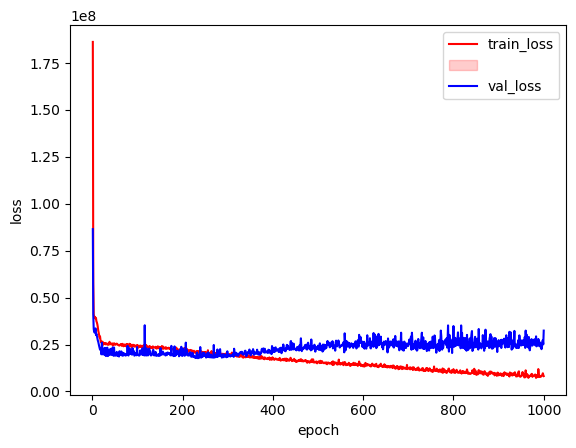

In [20]:
# Draw loss curve
curvePlotling(history1,'loss')

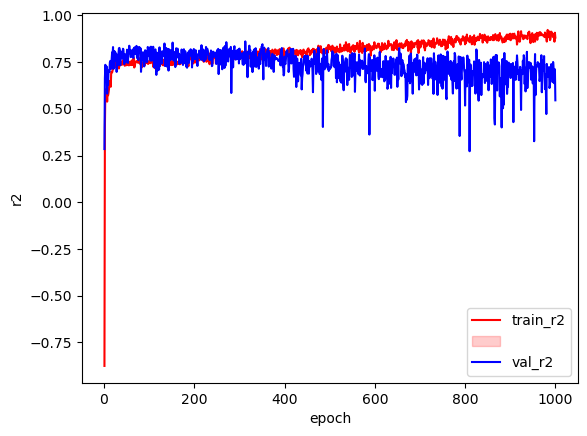

In [21]:
# Draw r2 scores
curvePlotling(history1,'r2')

In [22]:
# Prediction on test dataset
y_pred = model1(X_test_tensor)
y_pred

tensor([18542.8535,  8543.6455, 42665.7617, 13846.2471, 10607.5234,  3830.9753,
         2208.5537, 11845.3926, 10170.4453,  5632.3672,  7206.3550, 10360.6084,
         7343.5830, 22345.4980, 17455.6465, 19203.8555, 14571.4229, 19243.1875,
         7687.7544, 24084.1016, 24089.3359, 11369.8135, 17102.5586, 21571.1133,
         2317.4146,  6493.3877,  9093.3662,  7645.5259,  8520.3105, 10508.0986,
         9298.2783, 50248.9570, 17081.1855, 12835.4170, 15057.6367,  4903.4766,
         9134.5322, 38948.8164, 45164.0664,  6468.5103,  8471.7246,  2743.0688,
        26714.7734, 55725.6250, 34099.5508,  6240.0562, 17998.6719, 10673.8457,
         4818.5259, 13193.5781,  3442.3804,  8812.4502, 29099.5430, 51018.5898,
        12604.3486, 14401.7510,  3078.4312, 10087.9365,  9716.0234, 36102.6367,
         3064.7429, 43454.0586, 18891.1562, 14759.6494, 22365.9531, 10371.9248,
        20255.5176, 34842.5742, 22643.7344,  8602.6240, 12936.6602, 13309.5537,
        16575.5098, 14443.9863, 12876.91

9) Predict my medical cost and save model.

In [23]:
def predictMyself(model, personal_info):
    personal_info_array = scaler.transform(personal_info)
    personal_info_array = np.array(personal_info_array)
    personal_info_tensor = torch.tensor(personal_info_array).float()
    return model.forward(personal_info_tensor)

In [24]:
my_info_list = [[28, 20.11, 0, 1, 1, 0, 1 ,0]]
predictMyself(model1, my_info_list)

tensor([14893.0215], grad_fn=<SelectBackward0>)

In [25]:
if_I_dont_smoke = [[28, 20.11, 0, 1, 0, 0, 1 ,0]]
predictMyself(model1, if_I_dont_smoke)

tensor([2518.0898], grad_fn=<SelectBackward0>)

In the 'regression_main.ipynb', I predicted my cost is ＄17051, when I no longer smoke, it would be ＄4365 with GradientBoostingRegression.

We can also check results of a specific epoch:

In [118]:
# Create a new model
new_model = insurance_net()
# Load parameters to a untrained model
new_model.load_state_dict(torch.load('./models/model301.pkl'))

<All keys matched successfully>

In [119]:
# Predict my medical cost by a new model
my_info_list = [[28, 20.11, 0, 1, 1, 0, 1 ,0]]
predictMyself(new_model, my_info_list)

tensor([11044.6455], grad_fn=<SelectBackward0>)

In [120]:
if_I_dont_smoke = [[28, 20.11, 0, 1, 0, 0, 1 ,0]]
predictMyself(new_model, if_I_dont_smoke)

tensor([3871.7898], grad_fn=<SelectBackward0>)